In [12]:
# 그래프, 수학 기능 추가
# Add graph and math features
import pylab as py
import numpy as np
import numpy.linalg as nl
# 기호 연산 기능 추가
# Add symbolic operation capability
import sympy as sy

In [13]:
sy.init_printing()

# 상미분방정식을 위한 수정 오일러법 (훈의 방법)<br>Modified Euler Method (Heun's Method) for Ordinary Differntial Equations

## 전진오일러법 사례 검토<br>Review of Forward Euler Method

다시 한번 다음 1계 미분 방정식을 생각해 보자.<br>Once again, let's think about the following first order differential equation again.

$$
\left\{
    \begin{align}
        a_0 \frac{d}{dt}x(t)+a_1 x(t)&=0 \\
        x(0)&=x_0 \\
    \end{align}
\right.
$$

python 함수로는 다음과 같이 쓸 수 있다.<br>We can write a function in python as follows.

In [14]:
a_0, a_1 = 2.0, 1.0

def dx_dt(x, t):
    return - a_1 * x / a_0

$0 \le t \le 6$ 구간에서 $\Delta t=1(sec)$ 으로 전진 오일러법을 적용해 보자.

In [15]:
def forward_euler(f, t_array, x_0):
    time_list = [t_array[0]]
    result_list = [x_0]

    x_i = x_0

    for k, t_i in enumerate(t_array[:-1]):
        # time step
        delta_t = t_array[k+1] - t_array[k]

        # slope
        s_i = f(x_i, t_i)

        # x[i + 1]
        x_i_plus_1 = x_i + s_i * delta_t

        time_list.append(t_array[k+1])
        result_list.append(x_i_plus_1)
        
        x_i = x_i_plus_1

    return time_list, result_list


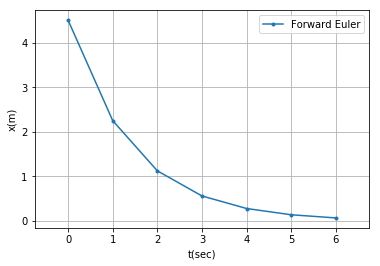

In [16]:
# Time step interval
delta_t = 1.0

# Time array
t_sec_array = np.arange(0, 6 + delta_t*0.5, delta_t)

# Initial state
x_0 = 4.5

# *** ODE solver ***
t_out, x_out = forward_euler(dx_dt, t_sec_array, x_0)

py.plot(t_out, x_out, '.-', label='Forward Euler')

py.axis('equal')

py.xlabel('t(sec)')
py.ylabel('x(m)')

py.legend(loc=0)
py.grid(True)


$0 \le t \le 6$, $0 \le x \le 6$ 인 영역에서 기울기와 겹쳐 그려 보자.<br>
Let's plot overlap the slopes within the region of $0 \le t \le 6$ and $0 \le x \le 6$.

In [17]:
t_array = py.linspace(0, 6)
x_array = py.linspace(0, 6)

In [18]:
def ode_slope_1state_interval(func, delta_t, delta_x, te, ti, x_max, x_min):
    time_list = np.arange(ti, te, delta_t)
    x_list = np.arange(x_min, x_max + 0.5 * delta_x, delta_x)
    ode_slope_1state(func, x_list, time_list)
    return time_list


def ode_slope_1state(func, x_list, time_list):
    """
    Plot field of arrows indicating derivatives of the state
    :param func:
    :param x_list:
    :param time_list:
    :return:
    """
    time_mesh, x_mesh = np.meshgrid(time_list, x_list)
    u_mesh = np.ones_like(x_mesh)
    v_mesh = func(x_mesh, time_mesh)
    # magnitude as color
    color_mesh = np.sqrt(u_mesh * u_mesh + v_mesh * v_mesh)

    # https://stackoverflow.com/questions/29589119/plot-width-settings-in-ipython-notebook
    py.figure(figsize=(12, 12))
    py.quiver(time_mesh, x_mesh, u_mesh, v_mesh, color_mesh, angles='xy')
    py.xlabel('t')
    py.ylabel('x')
    py.xlim((time_list[0] - (time_list[1] - time_list[0]) * 0.125, time_list[-1]))
    py.ylim((min(x_list) - (x_list[1] - x_list[0]) * 0.125,
                max(x_list) + (x_list[-1] - x_list[-2]) * 0.125))
    py.grid(True)

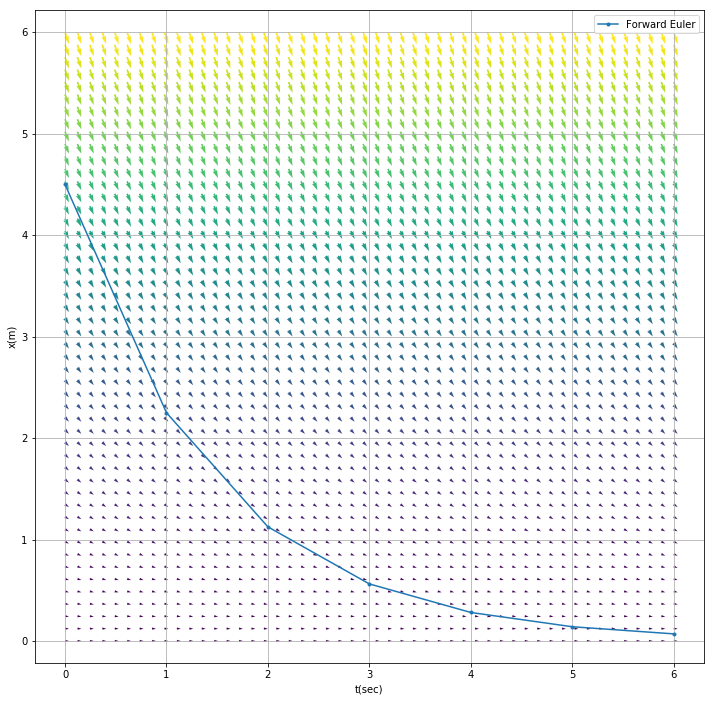

In [19]:
# Slopes at each (t, x) points
ode_slope_1state(dx_dt, x_array, t_array)

# Time step interval
delta_t = 1.0

# Time array
t_sec_array = np.arange(0, 6 + delta_t*0.5, delta_t)

# Initial state
x_0 = 4.5

# *** ODE solver ***
t_out, x_out = forward_euler(dx_dt, t_sec_array, x_0)

py.plot(t_out, x_out, '.-', label='Forward Euler')

py.axis('equal')

py.xlabel('t(sec)')
py.ylabel('x(m)')

py.legend(loc=0)
py.grid(True)


$\Delta t=1(sec)$ 의 경우, $t_0=0(sec)$ 과 $t_1=1(sec)$ 사이에서 $\frac{d}{dt}x$는 계속 변화하고 있으나, 전진 오일러법은 $t_0 \le t \le t_1$ 사이에서 $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_0}$로 가정한다.<br>
In case of $\Delta t=1(sec)$, $\frac{d}{dt}x$ continuously changes between $t_0=0(sec)$ and $t_1=1(sec)$.  However, the Forward Euler Method assumes that $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_0}$ over $t_0 \le t \le t_1$.

그렇다면, $t_i \le t \le t_{i+1}$ 사이에서 대표적인 $\frac{d}{dt}x$ 값은 어떤 값이 좋을 것인가?<br>
If so, within $t_i \le t \le t_{i+1}$, which value of $\frac{d}{dt}x$ would be representative?

## 수정 오일러법 (훈의 방법)<br>Modified Euler Method (Heun's Method)

수정 오일러법은 $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_{i}}$ 와 $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_{i+1}}$의 평균값이 $t_i \le t \le t_{i+1}$ 사이에서 대표적인 $\frac{d}{dt}x$ 값으로 가정한다.<br>
Modified Euler Method assumes that the average of $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_{i}}$ and $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_{i+1}}$ as the representative $\frac{d}{dt}x$ value within $t_i \le t \le t_{i+1}$ interval.

그런데, $x(t)$의 엄밀해를 알지 못하는 상태에서 어떻게 $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_{i+1}}$ 을 계산할 것인가?<br>
Now, how can we calculate $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_{i+1}}$ without knowing the exact solution of $x(t)$?

전진 오일러법으로 구한 $\left.x\right|_{t=t_{i+1}}$의 근사값 $\left.\hat{x}\right|_{t=t_{i+1}}$으로 $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_{i+1}}$을 사용할 것이다.<br>
We would use $\frac{d}{dt}x=\left.\frac{d}{dt}x\right|_{t=t_{i+1}}$ using $\left.\hat{x}\right|_{t=t_{i+1}}$, the approximation of $\left.x\right|_{t=t_{i+1}}$ by the Forward Euler Method.

In [20]:
def modified_euler(f, t_array, x_0):
    time_list = [t_array[0]]
    result_list = [x_0]

    x_i = x_0

    for k, t_i in enumerate(t_array[:-1]):
        # time step
        delta_t = t_array[k+1] - t_array[k]

        # slope at i
        s_i = f(x_i, t_i)

        # x[i + 1] by Forward Euler
        x_i_plus_1 = x_i + s_i * delta_t
        
        # slope at i + 1
        s_i_plus_1 = f(x_i_plus_1, t_array[k+1])
        
        # average of slope
        s_average = (s_i + s_i_plus_1) * 0.5
        
        # x[i + 1] by Modified Euler
        x_i_plus_1_m = x_i + s_average * delta_t

        time_list.append(t_array[k+1])
        result_list.append(x_i_plus_1_m)
        
        x_i = x_i_plus_1_m

    return time_list, result_list


엄밀해, 전진 오일러법, 수정 오일러법을 비교해 보자.<br>
Let's compare the exact solution, Forware Euler Method, and Modified Euler Method.

In [21]:
def exact(t):
    return x_0 * py.exp((-a_1 / a_0) * t)


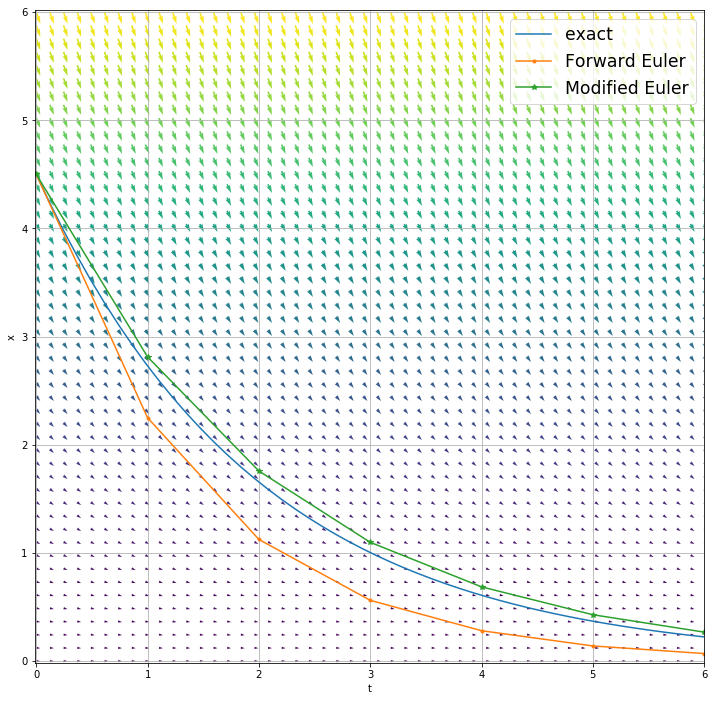

In [22]:
# Initial value
x_0 = 4.5

# Slopes
ode_slope_1state(dx_dt, x_array, t_array)

# Exact solution
x_exact_array = exact(t_array)
py.plot(t_array, x_exact_array, label='exact')

# Forward Euler
py.plot(t_out, x_out, '.-', label='Forward Euler')
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAsoAAAK9CAYAAAA9sUo5AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzsvXmYZEWx//3Jc2qv3maGGYYduSwiCgi4oF4BAUF2l6sCKijgAooXFRdQWQRUEJFNUUQRFBEXFGWT9QICXhYZvSAgM8wwwKy91l51Tsb7R56q7h5hKrKv8Jv7PhXPwyPd9peIysiKiIyMjDAiQo961KMe9ahHPepRj3rUo+kU/L8WoEc96lGPetSjHvWoRz1aF6kXKPeoRz3qUY961KMe9ahHL0C9QLlHPepRj3rUox71qEc9egHqBco96lGPetSjHvWoRz3q0QtQL1DuUY961KMe9ahHPepRj16AeoFyj3rUox71qEc96lGPevQC1AuUe9SjHvWoRz3qUY961KMXoJc0UDbGDBljfmWMedwY83djzK4vJb8e9ahHPepRj3rUox716F9FqZf4v38+cJOIvMcYkwEKLzG/HvWoRz3qUY961KMe9ehfQualmsxnjBkAFgBbiJLJeuutJ3PnzqVYLL4kMvXopadKpdLT3/9R6unu/y71dPd/m3r6+79LPd3936WHHnpotYjM7fZ3L2VGeQtgFfBjY8wOwEPAp0Wk8mKAzTffnG996xx22203jPGrChFp4pLWPhgBWjPA+fOaKU7EAtE6LmMEGIwJufPOO9l9991fQl4z1xmkMcZ44/7/ua9iwGJMuvM7je5eXhmbQKpnCzoYC8TTdNamtenu5ZWxBQQYE74MvP6v6Ky7/V5Tfy+/LRCM8QsHXn5bsG7a77bu/l/b75eK10xxzhaE67T9NsYsUf3dS5hR3gW4H3iziPzZGHM+MCEiX1nj7z4KfBRg/fXn7vzDSy+mr68AxuOEZpeBLUFqaw8JY4gWQTAIwTw9TMYhfh5S/wZ4KCV+Bogg3MJDxgZEi518wSw9zK4GuwpS2+BVhh4vAtIQbqLHSNV9tnAjMP2Uy2X6+voUMq4AO5bIqCUL0UII+iGY7yHjBMTPQfgKMDk9Ln4WpJHoWkstiJ6GYI77R0t2xK1Jaiu8zq/xYsBAuJkeI7VEZ/PBDHZ+3VV3dqWTM7WN46lj5nRmChBu6CFjGeKl7nMZj4qt+HmQSrKOWooSWzALgq7JhSkyjkG8DFJbAh4OK34GiN1+VPNqOF2/iC14Ud3N2BYsBLIQbuwhYyXR2cZgFDagI+NysOOetqBtvwcgWN9DxrYt2AJM1oPds0ADQh9b0Ezsd3dbME1/HVuwNeBx4Iifdn8fbqrHSA3iJe67aQb0OLsC7OjMbEFQhGADDxlLbv3DzcHk9bj4Off5UlvqMTOwBeVymb5Cy+1jb/u9BBD32bQk9URn64MZ0uPsKrDDyb7S2gJx62FyzserZWzbgk3W6Vhuj7cd8pCI7NL9b0Vekn+A+cDiKT//O3D92jA777y93HHLhRKPfUV8yJa+J/GyrcQ2HtZjrJV45dslXrmXWGv1uMYjjlfpYi8Z4/FTHK611EPGhsTLd5F4+ANevGztJser8ms/GUc+LvGy14iNS3pe8bDEy14p8ehnRUTkjjvu0OHKP3Ey1u/xk3HVIRKveLNYG+tlbD4p8bKtJJ4424/XxDcTnf1Dz8tGEq94s8Sr3+XFy9bvcrzKV/jJOHqCxMu2FRuP6HnFJYmXvVrikU9M+3033dnKNU7G2h/9ZFx9mMTLXyfWNvUytp5xOhs/zYuXLV3gZGz+VY+xVuKVb5N45T6etuCBxBZ830vGeOxkiZdtLTZa5iFjXeLlr5V4+MgX/P9fTHe2+gcnY/V3fjIOHyXx8h3E2qpexmilxMu2kXjsi168bPmHiS2430/GVQdIvGI3P501H01swXf8eI2fmdiCp/W8bEviFW+QePX7uv7tVP3Z2u2J/f65n4wjn5J42avExuN6GeNxiZe9SuLR47142cpViS243U/G1e+VeMUbxdqWnlfr6cQWnOnHa+LbiS14TM/LxhKv2E3iVQeoMXfccYfY+n2J/b7MT8axL0i8bBux0SoPGasSL99B4pGjvXjZ6rWJLbjeT8bhIyRe/lqxtq7nFS1zOhv7sp+MpUuSWO5BPcZaiVfuI/HKPT1twQIBHhRFPPuSdb0QkeXAUmNMO02wJ/DY2lFpd/qo35Sk7ZWU28/xrF+vhhhjILe/O5lFj+p5pbeHcGMvXgAmt7/7l/qNHjJmILc3NP8biVfomWV3A1OcoYx1aNyhxwSzIfMmaNyGSF3PLLcvYPxlzO/vMputh/SY9FbuhFq7oX1o0+ESnUnNZ1+FkHsHtP6GRM+ocWTeCGbWDHUWQf2PekzQB9ndofFfiC3pmeX2BtIz05mMQfNePSa1CaR3gPqNSWmPVsbEFnjprG0LFkH0hJ5XeicI5s9QZ+JpC7KQ3Qua9yHxsJ5Zdg8w+RnqrAqNO/WYcC5kXg/1PyZX5Uqagf0GMLn9wD4PrUf0oNS2LpNfv35GtoD6DXqMSUF2X2g9jMTP6WXMvhnMwMx0Rgvqt+oxwQBk3wr1OxBb1jPL7QOEM9v7dhiaf9ZjUptDajuo35CUsnjwwjcuCCC/H0RPINFTahyZ10Ewd4a2wEL9Jg8Z85B9GzT+hNhRPbPsXkBmZjJKGRp36THhfEjvAvWbX5ZYzuT3dzd10f/oeaVeo/7Tl7qP8qeAnxlj/grsCJzVFWEGE6d6HxIvVxkzk9rUBbD1GxGJkXi5SjiTn3SqIk0kXt0dY4xTZvQPpPWkmhfpnSFYv7MB1DJ2nOpNiC0jdkIhYy5xqvcidkQvY3YPIIckTsRLRqlA47+ASOUkTTgPMm/oOFW1jLl3AG2dRUi8Ui+jfQ5aC/S8Uq9yV2L1G/zXAxJnXFMZM2PS7vDQehiJn/fQ2b+D6Z+is2U6GdtOtXELYscQqXXHBEOQfQs07kBs1UPGxKnWrkfE+q2jHU4OikpM6t9cMJQ4VV+duXVsqoJRY4LEFvwdiRbq1yPzegjW87cF+cSpNtq2oPshxwSFxKne4/Ss1lniVGszsQUlaNyNxCtVhxwTbuDsY5Ig0duCqTprIfGq7rw6h6LFED3mYb+nJ0j8dIbzTbaK2DGFjBnIvb2TINHrbDJB4mULpiRIxI4g0uiOWSNBotfZZILE+WpdAmhqgkS99umtXSnEDO232/sNxI50x6yRINHbgukJEj8ZXYJE7ITqkLNmgkSvs8kEidc6TkmQ6GO56QkSvYxTYzkPW6CklzRQFpFHRGQXEdleRA4Rke4RQzAABEj1p8jIBwFdZsI51VVI6SykdLYOk9oSUq90X6Sxz6hPI50vUuV7yOhROkzHqT6GnTgLqfxYhSPzBgjmILXfIqMfdXVXGn75/YEYKX0LGTtBhwmKkNvDObnSafrsSW4vII1Uf+5q8l78veZ0frn9QCaczia+psOEG7lMXv1GZPyL0HxQKWPyRapchox8SMer41SfdjKWv6vjld4Bgo2Q+u+R0WNdzbKGX+JUpXQ+MnacUsYpTrV0JtR+o5Ox7VSrv0JGPuzqDTX8cvuD1JDSN5Hxk3WYcA5kdnVB+cSXofEnnYxtp1q9Ahk5XJ1ZdrZgeWILztXxSm3tahnr1yNjn4bocR2vts7K30NGj9FhOk71r84WVK/UyZh5E5ghpHatsztWGWTk3KFISt9Cxk/UYYJ+t0cadyITp0L9Fp2MubcDKaR6lfueKW+Z3L4aS2xB93wKtBMkr0lswYnQ+osO106QVH6AjBypw0xJkNiJM5HK91U4lyCZh9R+h4x9PKlPV/BLEiRS/g4ydrxSxhxk93SBSelrULtOJ2M7QVK7xq2HHdfLKBVk4hvIxFd1mKkJkvGToHm/TsZ2gqTy48QW6G4DTG5/iJ9FSmci5Qt0vDoJkuuRsU9C6x96XoCUL0BGP6bDdBIkD7l9Vb1aJ2M7QVL7DTL6EfcWQcMvvz/QREpnI+Nf0GGmJkgmvqK/Zcruy2Qs9yGg+wEMJhMkzn5/U4eZmiAZ+wy0PDLLClq3JvNJzRWAm5xTRrzE/a4brHzhZKq+eqUqUBM7gR05yhWO22XQ+KPKqEvjTqR0FhBA/XqIlnbHiGAnTps0CtXLdbzi5e5LgHHlIa0Hdbjqb5DyD90PtV+5rFxXGSPs2Geg9STQgupVOl6tJ5HRTzidNe8F6jpc+VKkdq37oXqVy0J1w9gKdvRj7lGCjEL9OqXO7k+CujQ0boZ4seoKz058I8mSA9WfuKvobrziYWT0SNyjvqeg+SfdHq5dj5QvdD/UrwVFpkXEYse+AK2/ARaqV6gywxItRkaOBtJuT0WP6mSsXOEOQwC1n7tsQVcZG9jR45KHkRW3HzW8mo8gY59NbMHtzi4odG1L30EaN7sfqlfodGbHkNGjwVadnI3bdDLWb0VK5wDG7UXFIVZEsOOnQPOBRMbLlbbgOWcLTAitv7qgUCNj9ZrJQ3ntGqUtaGHH/tM9vKKZ6FpjCx5DRo9zj+Sad7tSFpX9/h5ST4K66s/cNW83jC1jR49xBzy7yh3qVbbgT8jEaUDalb7ES7oGXc5+nwmNexIZf6LU2crEFuBKepr363C13yGVS9wPtV+DIjsmEmPHToTo70AM1Z+qSuEkesolYEzWlUNEj+tkrPwIqV2TyHgVKG46RerY0U+4B7Ay4eycyhY8iIx9HshC41ZnC+h+nW9L30LaZSjVK5RxwYj7nknd3To0/gvQ2IKbkfJ57of6de4zdsOIxY6fDK2HExl/oluP6Blk5CNAytmB1l+VtuDnSCU5lNd+oUqOiDSxo8cnCbCasyEaXq2/uQOeybs1jBcrbcFFU2K5nyp1VkpiuQn3oLJxs45X27craN0KlE3eOcapzk2TkSgcAVOvSlXXyAOYwqHuOt4DR2Y3Vx5CO9Cqdw26jDGY4hrZYI2M4XxMbp/pp0WNjPmDgCnZNw0vk8IUj5mW8VBdx6e3hszO0wNdjYyFw1zXCx8ZgyKm8KHEULZJgcu+Mem4MMW4KvaVKR7tDlE+mHAOJn+Iuyb0wLmMyZSvo4aXCTB9H5u+HhpcanNM9i3TA13V9+x904MYlYxZTPEja2TSFLjMju7adOq+UOnsyOmBhQYTDGEK/+HqXT1wZPfEdeQQPS9jku/Zs1N4aWzBRpjsXtMDXY2M+XcyLZOjkjHt9v6UfaWzBa9ytylTnZvKFnxwjc+lsQV9mMLh3utI5k1JN4O2LYjpFnQ5nR3tOqr4yBjOw+QOXMMWKGTMHQDTgneN/Q6dj5n6LkIjY2pLZx9lShZZpbNDXbDrw8vkMMUPT7cFmv2Y2QVSmzN9Hyv4FT/ibYdNMBuTf7cLuDxwZN/OtC5YWvtd/Ngae1hjvzfF5PZwySIfGfPv9renJoMpHuXvY9KvgfSr1rAFyljO08aZoB9TOGyNWE7BK/PW7n+T0Es9mc+fgvmu5Uz7UY0y6GXoW8jI4YDVLRJgcnsh+UNdxgTUjo7BM5DVC6ZcfTaAtbetMeEGDte+RtM+fMsfBo27XVZNLWMKBr+FDB/kAhvteqS3hf4Tk4y5XkbT9ymkea872WplDIowdC4y/D6gpeeVfTNSOAqql/nJOPBVpPXQlC98nW6DIk24Hgx+3WVcQOdAAHKHuIcP7ZOxyokEMHg2svpAF8AqeZnUFtB/sitp8JGx+FFXAtH6bw8ZszD4bWT4XUBDL2NmZ6R4LFQu8pLRDHwBaf45aVWmlDEYSmzBBwHR88rti+Tf4zLeWl7GwOBZyOqDEoccIdLq2tvUpDaGgdOR8c8kvJS2oPAht6+ad3vImE50drBzWtr1SL8a+k+YUsam/J71n4A07598IK2yBX1OxpH3A7GHLdgdKXzIZQu1vIyBgdOQ5l8mHavUoUv/VROu72zB2CfUvADIv8fprH3LoZIxhKFz3L6ScQ/7vRUMfMmVyih4jY+Ps3r1aprNPZF4B9pljmakDubv3RnKNxC7CndQTGFWKTD0I/aKTmLFDA9AoOF1GGL3pp0AMiNLwTy/dgyAXIS0E00mi1mukfHfEHt5J2FnRmatdT0GBwd5/PHHQf4TsYfjDl9gRh8DTes8+eHkOxZTwDyvkXFXxF4GST25GTFKnZ2O2JU4nYWY1RpeGbCXI+2D0XA/RqMz3onEb6F9EDUjq8F0v4VEzkt0JkAGs0LDa0PE/gSkQiqo0tfIM2d+g2z2xVtA+tQor3uBMgYzeC4y/G5m7Iy1wQJgBr6INP/bOWMtr2DIBaKjH6LjjBX9Hac7YyWvjjM+MCk50AZQU5yxx3o4Z3y3c8ZaXiYNg+ciw4e4X8zEGfvorP8EpHkfRI956GxNZ6zETXXGWofVccaPOGesxYXrO12PHQu0EIl0QwDy/5E4Y135kJOx7YwPdJkhL2f8RXd97dHlxPQdmxymHkakruq8akwehr6NDL8Hr8NU5vVI8WNQucRPxv6TkeZDrh+tel/NhsFvIqMfdr+QOiiGAJj8AUjjLqj/1uN7Zhyv4QNd1kVtCzaFga+6mkSfzjSFjyS24D4PGTPJAfidDqO23ztA3/Hu+trLFpzoDlPREx46618jsVIDuvcQNrk9kfxhrtTAS2dfSxIry/W4cAOHGzsepIaI6Bx7/tAksbL28qF6vc6KFSvYeOONyefzdErFkv7eJtD1wZZ4dXLrlsakX6nDiE2+Y1UI5jm7p8HZWnJoFkht5Q7uKhmXuVtZU3C1rCoZ42Q9mhBs6N5ZvAiVSiX6+/sTGUtJb3sg9UrVsA0RSUrTxsAMuu+rSsa2ziIIN3MJQw0uHkkOiaFLjql4SaKzCgTruf2pwtWTEi4L4ZaYQNcHW+IVSfIh53yOipdFWk/RiupMlPt55pln2HTTTdcaLGtp3Sq9SMikt8b0J4Xmns6Y9E5+GJPHDH0bSPvhsm9wWTlfGftPdg8FfDDBbMzg2f688gdA7mCgmUzyUWBMgBn8JgSz/XilNsMMfMVbRgofcQ+9vHSWcTozedWVcAeX2QHT187o+zljUtv4YYIBzNC3gMAPl9vLOTvwCszN4Blu8IIPr3ADhwO/w1T+MNdJwYeXSWEGvwWmzw+X3tatP6A9XIK75SC9vafOipihc/G3BW+GQvKo1+uQ/lXXkN+HV7geZvDrCS+fdoyHuIepSdCl4mUCZ3fMkKct2MLZOV8Zix+F9Os9bUEWM/htIOvVntJkdobisd4ymoEvuKEjXvZ7KLEFxg+X29dlpBHUj9qNwQyemQxeeHFeq1atYu7cuRQKBYcxmSkDgfQt2AjmgOlPZNSRMUEyyCb04mWC/ORwGY82cQ6T98IYEyaDtwxeny3onzJcRsfPGJOsfUaNcbj0lCEgPusxC1c+6qMzM6kzr3XMTRkO5iPjPFxZmw+vAJPahEw6YL05RWbNmsXISPeOJSpx/iX/lZeCCoe717heRjOFGTwH30S5c8af8wq6ABd0pV8zM2fs01uQtjP+MNor0A5u4JSZOeOBr/s5OYDcO90X0CuASgJznylZtJ3xSf4yFj8K6dfNwBkruydMxWV2huInvGU0A1+cmTMe/FbnKk6Naztjr/UwmMGz8JrkhbvlMAN+mWjA3XJk/t3rsxmTdjrzHKVs0q/G9P2nvy3oP8G9lvfSWZ8L8rxtwe6urtdXZwOnJRPR9PxMuL7Tted6kP+PpG7TxxaEmKFz6FYG8U+49FYuseL7PeskVnxkbCdWPJw+7paD4ke913EyseLjY2Y7m7qW9ajX6/80ydEEQ+5Q5B1AbYRvKGFMFsIN/AJegGA9d9j2DcxTHtNm27igkBw4fGWcD+S8cC4w3xifzwUuIYOZDT49wTuBeejXS9xkEl37rsfsxFf4ytg+qOjJHabmA5aBgQFKJY85AWuhdbD0wpG7svr69EJ3DS61CQzo2p5Mo8IRmHbtn5ZXUv/nbTTTr4G+j3thAEz/Zydfy2sxQR8MnovLSOhHSZrcHuBRwwNTjGbgMVYTXHPydjbah/LvxTT1L1eBTskBPoM2cLcc9OvaNE3D9R2nb4HUxpg8DJ3LtAeZGlz2DfgEJh1c/8lJTWn3DhEdTDAbBs9U1eROw+UPdCPIfeQzAQx+Q90OrYNLbQb9n/PCAFA8CtO8x4+XycDQt71ZuZKDo/1x/Z+H5sN+mGDA7X1peAWjJrcXaEqApmKStxxEi/1w4QYwcJIXBoDC4ZimfiACkLzlOAdt26oOLr0t9OnaN07D9R0Pzf/2wwRFt698hu6QJFbWciCKoohU6gV0Gm7of+AwaSTcUF8e0gEOQeC/ryTc2H89TBYJ53f/wzUpmIumC8t0XgESziQwLyKs541zBw697Qa39yXcGBe76JMJJhjEd06d09lG4DOECGdTRVniMY2COSBl0uk0cay7Se9G62ygDIkzDmb747K7+2NM4PqG+uJSm3ljYKYyZtzUJl9cZkdvDMxMRggwmZ1eFl7GGNdA3RcXbuhjGyZxM5Ix5XpQ+uLSr/LGwAxlDIpuCAZ3evLy/1wOt7s/JpwL4dyXh5cJ3LQyX1xqC28MzFTGLGR39cdldvHGwEz31RDMwPbM3BbMxH77BzQwUxnTM7Pf6Vd7Y6C7jC8U1BoTgtEnVDo4z8Nvh7+ZCS6N5h3AP+FeThmDnDfG4WYiY5Bk2X15+WMcbiYyprwP2zPnNTOdrY3WqdILkRo2Xkzc0jX7b1OjcgWVUb8TvrVjVMdOpFFRNvhOqNW4j/Lqw7A+Y2SBeukCqmNf9sLY6Dkqo5+kpW32n1CzdhPl4cNUE5baJGKpjZ9ObcKvxCBuPUFl5Giipq7Zf5sa1aupjBzjdfUjtkJ17Es0Kpd78YqaD1IePhwbeYyRBerlS6iO+WUkbbySyuh/0qz93gvXqt9OefVhiNVnBkSE2sQ3qCkHNLQpjhZRGfkYUeM+L1yzei3l4SO8xsiKNKiOfZl6+RIvXlFzAeXhI4ijhV64RuVyKqN+mX9rR6mOfpZm9ZdeuFbjHsqrD8X6jJEF6qXzqI6f4oWJo6VURo6lVdePlwdo1m6gPHy41xhZkYjq+KnUS9/xk7H1d8ojHyFq/s0L16j8nMqI3w2b2AmqY1+g0e4Lq6So8WfKw4dhtRO/EqqXvkt17IteGBsvpzL6aZq1G71wrfotzhZ4lFuICLXxM6lNfMOLl9g6cbQYsbohUW2y8Shx9LSf/RZLHD2LVfSFni5jlTha5OXPnIyriBVzDqbxkhZxtBQb+32nrS0Rtxap3wJ1cPFybKTo3jGFRBrE0RKs562otWPJOvrq7DmscgJuB2drbn9YvxtOGw8TR0v8eEmU6MwvJvPxf+tUoGwwiC3RrP3WC2ejxbRq1xG39LPZjemjVb+VZvUqPyGlStS8m1b9D16wuPV3mtWr/Jxq0EerdqO3Axc7TNS4m8ijobYxAVHzLzSrV/jNZjcZWvWbZ6CzZ2nVbyL2maBj8rQad9KoXOn1ZUdaRI27aNb9glfb+gfN6jVeTtWYflr1m2hWf+HFS+x4sq/+6MHLELf+SqOiGzQyicvTqt9IUzvFLyEbLyNq3E7sdX2cIWreR7NyhZ/OgKhxO83q77wwcbSIVu1aYo8rf2P6aDVuodEepqIksWWi5j20PAOhuPUYzcrPVOPoOzIGfU5n3rZgJVHjLqKGvpTEmBRx88FkX/k4/hRR/RZavrYgXkKrfj1xS9MGqi1kkVb9dpqVn3nxEppEjbtp1jztd/QEzerV2Fg3AQ3atuAGmtVrvHhZO5rYgts9eBni1oLENnoElCZww7c8D3vQdB0evK78DUgZscOetkCSke2K1mJTUdJA7CjideUfInZcNbZ6OsWIlBHlVMM2idSwdtjzexYkMnrqTFpuHT1KSYwJQCpYu9rbfostIYqhVNNBjeSz+ZT/hIiUvHXm8/h3nQqUMTmMydKqXeellHTetSVr1vRO1ZgU6fyBxK2/eDnVVPatmGCWFy+ATP4QoOXlVINgkHTubbTqt3s51XR+PyBNs+rnsDKFgxE74uVUw9QrCNM70qr9Xj1iGCCTPxjAy6kaE5DJH4yNnsQqRwwDhJk3YIL5tDzXI104BBCv7LAJ8qRz+xI17vFyqunc28HkvPdVOn8ISIVW/TY1Jgg3IJXZlWbtBi+nmskfBPh+z4zTWbyUuKWvqQ3T2xOEr6BV+62XLcgktqDlJWOadG5/4uYDXrcO6dweYAa8A0Nnrxo06zepMUEwi1R2d1qNW7yyf+ncAUDofZBN5w9B7Cqi5r1qTJjeijC1Hc3adV63Dm1b4LevQjL5g4ijR4mVI4YBUpk3YYK53jpz+yr2SpCYoEg693aixp1egWgmty+Qndm+kgmvWwdjMhhTQGTcS2cmeYdiPYJXYwwmGHKBq8+jRlNwddB2zMsWBImMPgG2MYGrw5WKV4BtzAAQeAWGixYt4vTTL+GRBX/3OzSbNCboQ+zEjHTme+AwwZCrCVdMyZsEuVjOeuqsI6PHOrquLYOI1Lz8WcqjdHDdCpRxC9V2qlYxBhIgTL8mcaq/c+NGlbjJYO06N14z7n4ime5Un1XzSuV2x5jBjgPX4tL5g2k7VWvHVFfzzqnu1nGqal4dp/o7N17TQ0bnVO/D9f/t/sVY06n66szJ2FRd47kAe9KpqnXWcap+OnMyOqfqMiHdjaAJiqSze3ecqppXx6n67f10/mCQCaL6ndh4leoWIUhtTJh5Ha3aH5K11/KaDLBFIqxiPLcxhnT+YGz8NHHrbx624LUE4aYJL39b0Kxdh9iaKrAxJksm/w6i5v3YeJnH9+xtYPpmYK8OAqnTqv8Ra0dV15pBuB6p7Fto1W92n0vN6wDAJDJa9a2KswXLiZt/9tDZtgSprb11lp5mCxqqq1djwiRBsoA4elpvC7JvSRIkbtS2376KaNVucIGN4rrcBANJguQOrB33WI93AGnvfeUCoSQjKjr7bUwWY/JJgC3qoHJqsCZiVXZnMsBugNT1AawpQhJgAzOQcRyRWJUAcgH2QJKxbal4LVq0iNO/djYLFjyJyJjfOpohwCIygUikCpiNSWNMMflxVznDAAAgAElEQVRc1ns92kGvj86QFkjVQ2d594jP+q1H8E/7SqMzfZ37OhkoAzTKP6C8+r3KL60hnT8EGz9NfeJ06qXzVLzC9E4E4SY0a9dSGfkYtj0NsAu1nWq99G0qI0epMMZkSeffQdS8j9r4aTQqupKPdG5PMEWa1aupDH8Qa3W1Qpn8wSB1ahNnUh37rAoz6VRvojZ+kvrqL5M/EDA0yj/CRovQ9vxMFw5B7HLqE6er62yD1Cs7TrU6+inilq4esn3rUC9fSHn4gyrMVKdaGz+dRvmHKpxzqrNpVn9JeeRIbKzLUmYKhwAR9YlvUhn9pE7GjlO9ndrEV9VXym2n2qheSXn4/erruEz+YETGqE2cQW38qypMmNqcMP1aWrXfUx37LJGyc0v7e9Yof4/y6verMM4WHISN/kF94mvUSxfoZMy8HhNsQLP2ayqjR2OVtdFuXwn10rlURj6qlHHy1qE+cZr6at7dOuRpVK+iMny4+qoxk9w6OFvweRUmCOeTyryJZu1GauNfpKUs42rfOjQql1Fe/R/qK+VM/hAkfpb6xGnUJs7uDqCdINmCVu23VEaPJW49quYFUC+dT3n4SBXGJUgOIG4+4GyB8p1EKusSJM3qNZSHj/A4cLhbh/rEN6iOflqF6SRI6rdQG/8yrfrNKtxkYDic2G9l/98k02jj5/VBuclhTB4rY9h4KaIs3XCBIVi7Ehs9rcQYAjPokmDR8+raaGP6wKQQO4qNFqu7NXQCyng5duoo8a788ogtYePn1dleEwwCBolHEp0p5yQEswCbHOx1fqlz62DHsfGziNX5iskAexVWWRvtAuxZiDSReJkqqeKAhU6AbeMlXmUVGlqnAmWRSqK8LK36Ddh4MZqgqzbxzU49bqPyQ9Wp3cYjVEaORLDY6Cmixu2qOs9m7Ubq5YuSf/+larOJWKpjX0rqcYVG5Yeqa4w4WkJl5CiMyRE3HyBuPaK6smpUrqRZdY8Um9UrVZkWkQaV0eOw8fMgFZrVn6mMWNRcQHX0BDAFosatboMrcPXS+Z163EblMpXOxE5QGfmIyyrEz9Kq36Di1arfQb30TSCkVbvWGb9uvESojp9C3HwwkfFSFS8bL6MyciSQIm79lbj5Z0Sh62b1Vx3n26z+DFE8nhCJqIyeQJwcTpqVy1U1g3Hrcaojx2FMgajxX9joSVDcVNTL3++UoTQrP1bV44mtukebdhSxq2nVfqNaj1bjPmoTpwAZWvU/YGPdQ5naxNeJGn8C2jrrzsvGqxOdgY2eIGrcpbq5adZ+TyN5pNis/sJ9d7qQswWfx7b+Dli39zU6i56mMnpMYgvuJ279TYVrVC7v1DU3qz9RBdcidSojn8DaFSATNKs/V9mdqPkw1fET3VuC+s3YeIkKVy+d1zmUNyqX0R5vvDaydszZAlrYeAlR/Y9KW3AL9dK5uGz5r7Fx94BGRKiOfdnZXzxsQfQslZEPg8kQtx4mbj2o2o+N6tU0Kz8FoFn9KdZ2L+ESaVEZPT75PA331kSxh8XWkqAuSGpKG2gCZRuv7Hz/xQ6jCdRE4qTMMQaJHF6RCbW2hLXLAJNkQxtdgy4RoTT+FCedfDrbvHJ/8sXN2WTTnTj22GMZHZ28Lbr33ntJpVIcddRRCa6FjZ9m0aKlDM1+LXvu/X5i67KTf/vb3zjqqKPYaqutKBQKDA0Nse+++/LQQw9h49HOqGyxowgt7rnnHvbbbz9mz55NPp9nm2224YQTTgDg8ssvZ++99wbgqKM/Rzq7A6n0xpx2WvdDotg6NlqCK/UoJ0GhRmerOnXNYodBYU/dY74luFalcYLvzsvdZD+H09lEkhnuHijbeHknFnD7XsFLImy8GEGSuvSSCufzyHadCpSNKQJppva11BikbPEj2Hjydasm4A3C2S47NiXQ1RixdG4fpipBUy9oTEC275gkoNHLGKY2I5V5c2KI9DJmCv8x/epYsYbGZMkWP5ycTtu47rxSmR0IUltM/1uFgc4Uj5h2yNB8LhMMkCm8d5pz0+BcVifHpDFvdA26jDHkisdMq1/X8ArCDUhn90KmZP41DstdWU/+9zX73pgU2b6jpmVYNLgw/UrCzGsQmQx0Vd+zwuFutGgHo9FZgUzhsOTQ2wZ23/upzBsxwRymHZTVtmDKq2kFJgjXI53fH7GTWTGdLdiPqcNCdDoLyBaPIY4nM9YqnaVeQSrz+mkPeHS24H3TAi2N3TEmR7Z4xDRboLFzqcxOBOGm0/SrkrF4JHZKv3zNegTBEJnCO6fZfY2uU9m9cF1RpYPpFnQZYxL7PSWTqViPILUxqexuiJ3MZGrWP5N/1xrfTY2PSbu9P83HaL6f+cQ2Tg0sFNf4wRym9XlXXf2HmGD2GtfpGlwfrp/nVD2tXWfNZpO99zmci797JQcdtAffOe+LvP/9B/PjH/+YPffck0bDxRhvetObOOmkk/jRj37EtddeizFprO3jiCO/QCoV8uPLziRIoqSbb76ZBQsW8L73vY/zzz+fz33uczzxxBPst99+PPHk8mlrcM0117P77rvz6KOPctxxx/Gd73yHQw45hN/+1tWdv/Wtb+WLX3RdVI4+6j1c/uMzufzHZ/LOQ/btvh5Bzg1DmXo40ax/MJvpvfk1ax9ggjn+OgvasdxUPen2leC7P1LuxmFaSUh3nIvldLROBcoAQbghQfiKyV9oDFI4l8LQZLmFxkAAZArvIp1/txfOmIDC0HcSQwGaoAsgTG1BoT0u2EPGbN8nSGUmi851gXmO4qyLweQTXrrrrVRmF3L9n5kiow6XHzyZIPXKKTiFzoIhikMX0tmCWp3l30Gm8IHJXyiCUGMM+aFzMMGU5uUaZ5zamMLQNychWhmLRyYOWY8zJk1h1oWd/o9aXqn0q8kNfGmSl/KhV67/c4TpyR63OqfaR2HWxTgDqN8f6dweZIuTZQm6PWwoDJ7pAi8PGYNw/em2QNluL5N/b6eW2gE1+yqkMOs7yXUmIBXV9WKY3or8wOmTv1DqLNv3KcLMGyZFVMmYd7aAbIJR7qvsG8n2TV75a3H5gVMIUlt5yRgEsyjMugCSKVx6nR1EpjBZkqP7nhkKQ+dignnJbyyaaadhajMK7dHh6Pd+tng0qan9jFUyZijMuohOP2Pl/khldiQ3ddiWUmcmnO+GHHVwuqB36ndTW64RBANTfKcOZ4whCDdieu/ktePOP/98Hn74L9xxxw2cc/bnOObo93DO2V/iF7/4BX/5y1+48srJtoJf/epXecMb3sBHP/pRli9fzte/cQn337+ACy84mU02md/h9YlPfIIHH3yQM844g2OOOYYvf/nLPPDAAxSLRc4//3yC1KZASKlU4bhPns4WW2zBggUL+NrXvsbHPvYxvvnNb7JwoTsgb7HFFuy5554A7Pqmt3L4YQdw+GEH8JrtX7nmR3nhNQnWx5iCej1gqs7a/bO1OusjmNbDXokLN3SzH7xkTBNMHdaifKwYhLMm7bASZ4w+/F0HB44EFGZdTHn1wbiHYVpnvBvZ4sdpVC5RGwiAwuAZlJoPuYyXsudfEM6jMHQelZEPuV9IFU2D63T+PaQbdyUv+ZVGzAQUZp1HadU+iB1Rr0eY3pL8wOnUxk9U8wLI9h1H1LiHqHmf2mG1nXFp9f6AjzN+Pbn+E6iXzlVlWtqUH/wqUfO/sdGT6vUIglkUZ51Pefj9uEcQFQzddZbJH+DaSVWvUu+PtjMurdrbZZa1OkttSmHoG1RHj+tkujSTrrLFo5J2gLerebUD89Kqd4CUPQ5T25Mb+AL1iTPUGIDcwBeImvclJQPKvR/0U5h1EeXV7wIi9R5J595GtnhUUtag/Z4ZCoNfp9T8i1ftZBBuQGHo3KQMQHBBV74LCjKF9xM17nIPPtU6CynOupDSyrcjMqbfV+lXkh88hdr4SeqgCyDXfzxR8x7i5gP6fRUktmDVgbgkgtJ+Z3cl2/cpGuULvOxVfuA0ouYD2Gihh87mUJh1PpXhwwBBbBUTanR2iGszWfulh84CCkPfTuz3KvVnC1OvoDB4FtWxT3vZxmzxo0k7wLvVOGMCgtSmnPa7P/PY8ibGTKCfyOQerhkMGI8+tlJDsBgzCrzwlMhXbTjAKQdul8iYIgw3ndJXfe2B0NVXX80uu+zC5ptvx/DIMsSOYEydXXfdlXw+z2233cbRR7uJmKlUip/+9KfsuOOOHHjggTzyyCMcfvihvP/9B7ksZRJ0FYuTg1iq1Sq1mlvfnXfemQceeABjMgSpjbn1tssYGytxzjnnMjQ0fUptEPxzcGZMX/IQcKLr55rEGILUpsStJwHr1lKDC/IE4QauHtpnxHawPsZW3L5XBq8uMN+MOHoKEIdTCBkE/RDOTWrK9TIG4YbYTrcSzzHb3f7b/9L/2r+IUpnXdLJkPkYzN3AiYXp7L8PismQXASkvXi5LdoyXjM4Zn+VOdR6NuINwPoX2eFyP4CRTeJ/rZKG4XpyUMaQw63yMGfJajzC9NfmBU52IPoY9yZL5tLyamiXzkTGV3ZVs3/HeMuYHTiVIbeXFKwhnd7JkPgGly5K9D2dYdA8SpmbJfHiFqc0pDCaPKD1w2eIxpLK7eQVdLkt2MZiCF69U5rXk+t0DND9b8CXC1HZe62GCgcQWhJ62YG8yxQ87GdWHS0N+6BuYcGMvGYNwA/JD5zheHjJmCh8gndvXzzaaFMWhC5PWSx77Kr0t+cFkuJJXYH4CYXpnr/1hgkJyy5HxwqWzbyHbdyygzw4D5Ae/RhC+wtMWTN54+gxgmLzxbKLtbT/1xtNHRmOyEPhP5IM0hlBRfbomQ3fD4QM0QZEgXD/Brf0W9/HHH+e+++5j7ty5zN9gezbYaHfmb/gG5s2bR61WY+XK6W9AttxyS8466ywefPBB1l9/fS6++HuEnYy5C7omJiY4/vjj2WCDDSgWi6y33nrMnTuXm2++uVP3HASDPLXQlTptv71uoqLLmG+Mm1znEbwmgflUGVW4YI6beOfTWs4EBKlNgABRPhx0vPIEndHhnoG5yfthpmXM/zWjq9u0DmaUHbks2V2eht1dWWk7UbQpldmB3MAXvHoZwmSWzC8wd1my2sQZ3f94CqVze5IpfsTP8SfOOFr1iAu6TPesCbSzZN+iWbvWS8ZM4TBMcKVXRt9lyS6gvPq9Xrxcluwr6hfQbcr1f5qo+Sc/JxLkKc66iOrYiV680tk3k+07zosXQH7gdKLGA4hUMYrsJLg628LQee4xlAdlCu+k1bgrkXFQhXHO+DxKqw/w4uWyZGcSeQ0sgWzfx4gad6vKbCZlzFKYfTGVkY958UpldiLX/1lVHfVUyg+cRNS4P/l+zun69+CcanHoAuqlc7x4ZfL7EjU+6BV0OVtwNtHKfVwG0LxwFu+fZExtRH7obFr1G/xkLByR7CsfnaUozLqQyvAHuv/xFEqltyM/cJL3tL1c/2fdw08vW1CkMOtiauN+U1bbN55evWhp33g+6GyB0X0/2zeejepPvXidcuBO2HgpJhgkCHS8wD2Ai6OnSKW39eJnY3dDGnaCve5kgnkYW6ZbhG2tZdddd+X0012Jk9gm1q7s8Jo1a9Y/YW680T3uGh4e5rnnnmPwVa9KAnMXdB166KHcdtttnHDCCey0004MDg4SBAFnnHEGixcvnpTRDCT/q/5YnYy57wS8IBhCgrLqYd4kL0MQbkIsT6pvLR0uS5DaWPXwfhouWA8jZXXW2/Fytxyah/fTeRWm6exfRetsoNy+stK2MGlTmHoF+YGTvfm5K6s7vTDGZJNsht95OpV5Lbkkm+FD+YEvqVtrtSkIBinOuhChrg66ANL5ffCdzd6uJWsbCrWM4YbkB0/zwgBkCh9y5QYe5LJkFyCKl/VTKUy/alr9tpZy/Z/pdGHQkgkKFGZfjLbNXpvSubcCHlMVEyoMfi1ps6dv1h6EcykMfhORCOOxT9L5d0+vJVNQu/xI3SoooTD1b+Sn1G9rKdt3LFHjLi9M512A55VfKvs6suIXzAPkB79C1HzIC+PKjy4EaYAyUAbI5PdzGUcPcrdn35r+iFNBYWoT8oO6toNTKVP8CFHDb7y3Kz+6yK2HB6UyryHX7zcmHdyNp+/Y+M6Np9d0uWQYjude7NQCex4SXV3pRl5BF+DsgMzAx6Q26RoYbrnlloyNjbHXXpNvRaydIAhe2DdddNFF3HTTTZx++ulcdNFFHH744fz5z38mnZ6HSImxsTFuuOEGTjnlFE499dRp2JNOOmnaz1tvvTUAf/3r33jd63Zd62eZ9nPQh5lByUAQbuCVrHO8U0n2VVDVQ7R5BUNYz0KETsbcZ+IvLr4y4Qbd/3BNXDDX2793o3Wy9KJNQTiXVGbH7n+4BqVze3pjjAncIABPClNbEKa28MbNTMYc6ey/e+NSmV0IPIMTmJmMEJLKvu5l4WWMmREuSG1M6Jn9gJnKmCad290bl0q/mmAGRmJGMgZ9pLIvbtBfnNfuXkEy/C90Fq5PKrO9N25mOguTQMOP3BCdzbxxM5MxT9pjslSbUtk3uGtXT5qZzmaTyuz0svBy+2om9nszwvTW3riZyZghndvNG5fK7LjGYyodzXTvm6DPGxcEA15BsuNlXjRwXTsugwnWnvQ59NBD+fvf/85VV03OK2jziuOYkZHJNomPP/44n//859l///35yle+wg9/+EMeeeQRvvrVr3ZkDMMQYwzWTg9k77zzTh588MFpv9t7770ZGhri7LPPZXx8egvNqSWQfX1unae2q5vZeoQEM9JZn9eDtkncTGRMJ506Xg5eM9tXa5XjX/pf+1+SEBHbVUSemaN64yHGy35XzlbqlCq/pFbXj2gFaEVLGZ34NtbzBFet30WpcrUXxtoSE+UraDR1QzXa1Gw9yejEd9R1yQAilkrtJspV/YhWgDgeZqz0fVrR0u5/PIUazUcYK13ihRFpUq5eS7V+pxcuip5ndOJ8rGdpTa1xLxPlK7v/4RSytspE5SrqDf24ZoBWaxGjE99WdVBpk4hQrd1KufobL16xHWW8fBnN1lNeuEbzUcZKF3thRCLK1d9Tqd3ihYviFYxNXETsMQYcoN54gPHyj70wVmqUKtdQa9zvhWtFzyQ688tIVut3Uqrohoy0ydoJJso/odF8zAvXbD3B6MT5nrYgplK7gUrtei9ecbyasdIlRB5jwAHqzb8wXvqBF0akQan6a2r1u71wUfQsoxPnYT1qpwFq9T8xUfmZF8baChPln9JoPuKFa7aeSvaVPrsoIlRqf6Rc1Y8Bd7iIKF6F9dzD1laJPMsERCxxPEbsaYdFWkTxCjTT1tr02c9+lje96Q184AMf4LDDDuPCCy/kwgsv5NOf/jSbbbYZ113nJiy2Wi0OP/xw+vr6uOyyyxCJ2W+/N3P00UdyzjnncPfdbn/19/ez5557cvbZZ3PiiSdy6aWXcvzxx3PggQey7bbbAkIUL0fE0t/fz3e/+12eeuopdthhB0455RQuvfRSTj75ZLbccsuOjNtttx2FQoHvfe9iLr30Uq6++mr+53/+R7EeEVG8Gmv9hmpYW0vW0ccWSKKz7j3zp+NaRPFKdW39pIwVIuVgmEleljgewSoHobTJK2ZxYwLXjX9eu9M2cvMfz5fRiUvEh1YMf1IWLt1QWtFKNSaOy7Lo2VfIslUf8OI1Uf6FLFw6X0qV33nhnlv5bnn62a0ltjU1ptVaKguXzpeVIyd68RoZP08WLp0vtfp/qzHWWnlm2ZtlybJdxVqrxtXqD8rCpfNlZPxcERG54447VLiVI5+XhUvnS7P1jIeMdXn62W3kuRXvVGNEREqV38vCpfNlovxzL9yyVR+SRc9uLnFcUmOiaJUsXLqRrBg+1ovX2MQPZOHS+VKp3emFW7p8L1n83I5ibaTGNJqPycKl82X12BnTft9Nd6tHT5OFS+dLo/m4mpe1LVn83Pby7PJ91BgRkUrtNlm4dL6MlS7zwi1f/XFZuHRjiaLVakwcj8uipZvJslVHevEaL/9UFi6dL+Xq9V6451YcJE8/t61Y21Bjmq3FsnDpfFk1ctIL/v8vprvhsXOcLWj8Rc3LWitLnn+9PLPsLV62oFq/TxYunS+j4xeoMSIiK4c/IwuXbiCt1nNqTGyrsujZLeX5le/14lWq/CaxBb/0wj2/8lBZ9Oy/SRxX1JhWtEwWLt1QVgx/uuvfTtXf6MTFsnDpfKnW/qTm5ez37rLk+Z3F2rjr3z/22GMiIhLHFak3HpFW63k1LxGRZutZqTcekTiue8gYS73xN2k0n/TiFcVjUm88IlG0ygs3UXpcTj3tk7LddttJNpuVwcFB2X777eXEE0+UJUuWiIjIl770JQHkuuuuS2RsSb2xQEbHHpWtttpKNt98cxkfHxcRkRUrVsgHPvABmTt3rhQKBdl1113l1ltvlcMOO0w222wTJ2M83uF/++23y1577SUDAwOSz+dlm222kc985jPTZLz66gvlVa/aUtLptAByyimndP1ccVxLdPas13q0Ws8nOquqMdZaqTce9bL5TsYJJ2O0wgvXbC2ReuMRsbbpIWMk9cZfpdFc+E//X3ufvxBNlH8hwIOiiE3XqYxyYPqAFOXqr71wfYV3AZaKx2k6CIoUc/tSrd/hlbUq5t+BIeedxesrvAsrE1Rrt6oxqdTG5DJvpFL9PepZ6bTXA691NMbQV3gXUfQ0jeZf1LhsZidS4eaUq7/xOqn2d2TUr6MxWYqFA6g37yOKnu0OSKiQ3wtj+inNYF+J1KnU9A+ZwnA98rndqNRu9MpaFQsHA8EM9v67ie1y6h61j5n0tmTS2yY602et+maksxTFwsE0Wgu8Mtj57FsJg/VmaAsiKspR3uCu9wr5vanWbyOeOqinCxXzBwCZmdkCO0q1rq+pTac2I5vZhXLtt15Zmv7/hS1oRU/RVI6IB8hlXk8q3IhS9ddetsDpTCjXfqvGBCZPMb8/tcY9XjeQhdw+GFOY0b4SqVBVjoUGSIXzyWffQqV2vdcNZF/+EMB466y/8C6i+DnqHo9ljcljTJbYjnnpLExK+azH98WYwD0+k6pXBjsw/UBIrBzv3KZCYT5f/OLRLFjwX9TrdcbGxliwYAFnn302m27qOlqcddZZiAgHHnhgImOKwPSTz0c88cTfefrppxkYcNf48+bN48orr2TlypVUKhXuvfde9txzTy655BKefnoRYKatxx577MEtt9zC+Pg41WqVxx9/nHPPPXeajO9+z/t4+C+/olZfjYj8U/3zC65H4MaA++osmJHODGEwhEgd6/V4uA9IYz111pbRR9eu9GQAkZKXbSzm99PLpf7Ll4nCYBbN1t9otp4kUs6Pz2f/fZpT1eL6Cu8GYsq132NtRXW9EAT9FPJvd041HlbzKub3x5DtBJR6Gd+FlTGq9duJ49WqgDmd2pRs5nWUa9ch0vTg9U4AyrXfIBKrrtacU30nrWghzdYCtI/JspnXkQo3oZw4VZ/1AChXf4uVOnHcfSRvYHL05Q+g3vgTUbxMzauQ2xtjip1AyEdGkRqV+k3Edgyr6NaQCueRz/47ldoNybWmltfBgEmCE0ukfPnfV3g3cfw89eb9al6Z9HakU1tTrl6b8NLh+gtuqI/b+03VwbQTYDcfphU97aGz3QmCWZ1DkZ8taFGp/gFry1jFy+4wGKSQ25NK7RZiO+5hCw4E0jOzBXaEWv0uoniV6io6nd6CbHpHKtXfJle2vt+z3yQ4jS0IElvwBM3WY2peueyuhOGGM/qegXW2wFZVh5wgKFDM70et4dZQr7N3YEx+RjoTKVOt3eKuhxUtH1OpDcll30Sl9ges1PUyFg4BSGyqVR0gXD3nLFwLuqo6IdMJsGU0ybrpcFMDbBGrCmwmA+wKVppqXpMBdjK2WYsLZgGCteOIxKpyuHaAPYnRrofrs+zWQ9SBnpMxwkoZkZYqYF4zwPZbDzc2Xq+zdoBdw9q6h85cstTOSGcQd9a/u230qesONSeYl4t+8IMfnLrPPvsxNOd3WCkxVvoeg31HdsUZExDFy6jWb8DaOvXm/RQUDztSqU2YqFxBFD1DpX4jucwOpNp9GtfKL0ul9huslJgoX85A8dCumMDkaLYepVq/FSujRPGz5BSP3lKpzRgvXYq1I0xUrqAvfyCBpihemomhrVCu/oa+xIiujcJgFtX6ndQb99OKFmJMQEbx6C0M12ei8mOsLbHs+RxbvGLnrg87jDHEdphq/QZEatQad1DMv70rL5exuppW9BT1xl2k0/9GWtFeKDB9lKvXJHXflzLQ170FlTFpWtFCqvWbsLZCs/U4+dybuuLS4eaMl39IHK+kXL2GQm6PjkFcOwmV2nVYqVCq/Jz+4nu6f66gn3rjz9QadxHHy7BSIat49JYKN2K8fCnWjjNe/h4DxQ+yZMlSNt988xfFuMcsJar16xGpUq3fSDG/f1deYbA+ldrvaLb+h0bzIcJgLul09wewQTCLUuVnWDvBePn7DPQd0RVjTEgUPduxBY3mQxQUD6jSqU2ZqPyEKH6OSvU6ctnXESoeUBmTolK7FrElJspX0l98n+Jz5Wk0F1Cr304sq4njFeSyO3eXMdyE8fKlxDLKRPlH9BXfRWByACxevPhFdSdSp1K/HpEK5dpvk8PV2ikM51Cp3UKj+SDN6HGMyZNRPHpztuByrC0xXrqYwb6PdMUYY4jjVVTr1zv73bibQn6vrrhUuDGlys+I4sVU67eSSW9LKrWhgl+BcvVXWJlgovwjBoqHKzAZWq0nqNRvRqREK1pIPvvGrrh0Yr9ju5pS5SqKuX3cQIU1aE39CXFiC8qUqr/s3AysjcJgkFr9T0lC4BmQFtnMdi/4t6tXr2bu3GR/m3Qy5jwmsisJg/VU9luIOkMyrEwQqlrKpZPAtYHYMpgMgaKjiiHE2hHAEtvVhGH3FozGGEQaiEyAWERqL05nIiwAACAASURBVLj2/4zLENvVCC2sHSUwfWt9tNxsNslms4DByhhCTGxHCMPZCl4h1lYRKbv1JFL5dyfjKpCY2K4iDGarHuYJMW48usXKuMovubHe41ipItTAhB27s3ZKYe0wkMgYrqfgZUBa2ERnViqEiod5hgyxHQaarruJKWBMevo+fwE67bTTlp166qldH0isUxllK2XieAXt8otW9I+uJyURYXjsDBrNBQCMly9WFXVH8QpWDB+DMVmarb9Sb9yDle64cvVaShXXn7JUuZI4fr4rRiRm1eiJtKIlQJOJ8qUqGZutJ1k18imCoEitcSfN1qNYRduT8fJlVGquJ+RE+VJi2z3ram2VFcPHYu0E1g5Trl6tkrHe+DMj41/DkKNSu84ZJkWbsZHxc6gnj6fGy99VZfDieJgVw0dhCGlFT1Kt3+qMbReq1G5kvHwpAKXqVbTiZ7piRCyrR0+mlUw+Gi9/D03LmVa0hJUjHycwBerN+2g0H1at40T5p5Sr1yb/fhmx7Z51FWmwcuT4JLtYZqLyE9U6NpoLWD32JYwpUq3fRCtapJJxdOICaknbtPHyJaobGGsnWDlyDEJMFD/TObx1o2r9dsYmzgdCytVf0mot6opxtuBUGkm5wHj5YtX3JYqed7aALI3mw9Sb96vWo1T5ZeeBrguyu2f+RCJWjXyWKH4Ooc5E+TKV3Wm2HmfV6AkEpkitfhut6HGVrsdLP6Badw8px8s/wMbds67OFnwckQqxXUm5+itEIWOtfi8j418HMlRq19KKnlJldkbGv0EjaXup1Vkcr3a2wKRoth6l1rhThStX/8BE+XIAF2QrSricLfgirWgREDNe/r5qD7dai1g5ciwmKFBv3EOz9VeVjBPln1CpXpf8+2VYxQ2MlTorR44jtqNYGadU+amKl7UV4uh5IMDa8aQNXfdyrChe0fmOtAO2buRuJpYk/95wwZCCV2wniJMbDWtH0DyeFRFa0XNIksGP7SrVoAyRJlG0BAiSDHtVJ2M80vGzLjjsnnUVsbSiZ5K/tZ3DSjeytpbs2xArE8l6aHS2smMzYqu7kRKJaUWLcW3kWq6UQqFra0vE8XJcOcpYcmDpHstF0TJs0ns9tqvQrIdIiyhajBvuVUtsVff1KFc9Sr3Uf/kykEu7G6CtQHcKXBsZYxjsOzIJaBxpjHoqXJ98brdpga6mprSYP2DaFZ8GY0zIQPEImq0nJnEKGTPprcmkXzmtpkjjwPsL7yeKJ190atYjCAr0F99LK/rHFBm7f7Zs5vUEQT/C5JWiJngd6DuCVmccqW49wnAOxfy+0z6bBlfIvZ2pgw90OgsY6DuCZuSnM1dLutO0QFez/n1FV2s8KWN3jDFZ+ouH0Yqm7n2NznYgDDeYJpdG1wPFDyTBQsJLIWMQDFDMH0w0ZTCMZh3z2XYfWGcohXrXKz9jDAN9H6Y5xRZodJ1KbUg+++bp66/RWeFg4nhybK9Gz8akGOj74HRboJAxk34l6dSWWJk8nGh03V88NDmgJ7y0tqDwnunfT4Wuc9ldMSbH1P7fqn3VdwTNqXZHsR5huB6F3F5EU/rsa2Qs5t8xrfuNZj2cLThyms40ez+d3oJMevskE9qWsftn6yv8x/TPpdGZydFfmG4LNOsRBMUXmAjXPTgJg9nTAlbNOGRXnjDItP7wiqArMP3ItFkFtmvQ5a7+1+sEym1cdxkzmKDIZAwCmvUIgqFpGM3bD2MCwmDO9MBfgQuCfNIHfVIuTXnImjrTrUdIEMyaAa4vmbgyXW9rxxjCcM4MeKWTlpeT/kFzKHJvTHS0TgXK4B6wpcKNOj9rDG0qtTFzZ583iVFOjhkoHkkh947Oz5qMoTFp5s3+bvKFJ6kR6l4flM28mjlDp0zyUrYymTXwebKZXTo/6xxdkXmzvw+4oQLa9Sjkdmew/5OTvBQ4YwzrDX2D9JRe0iqdhfOYO/sCL14AfYX3JvWkbZzG0YXMnX0hQdC+rmuqshKZ9NasN3TWFF66x3lD/Z8iN6XHrcphmTzzZl+CSaYnarJBAPnsG5k18DkvXgBzhk6dVlajqskNZzNv9ndpmw2NngH6CgfSX/ygFy9jDHNnnUc4pZe09qAyd9bkgxlN8Aow0HcMhdzeU2TU7KsM8+Z8D2P61fIBZDM7MntwciiSVtezB79ENj3ZV14XCPWz/pxLgLSXjIX8Xgz2TQ5C0cjodHY2qXCyl7TGzqXCDZg3a4otUK5Hf/FwivmDJnkp9qMxIfPmXNypaXRZw+5ONZN+JXOGTveWcdbACeQykyUa2oPK+nN+gMFdb2u/0/ncmxnqP6Hzs3bvp8INpw2U0QV5adKpTaf8RtfWMgxnEQSTJQm6ANuQTm3C9PlomoAySyqcUpanfLgcBnM732m9jEGy79shlW49gqBI2BnxrOMF7jtjpk3a1R1U0tP6vCt1FgwSBJNlE1qdubVPe8qYIZXaZJKXsl1qGMzpxGQOqFsPLa1zgTKEzJv9PSAE9F/2Yv4dDBRdPZzWgRtjmDv7253AXGuQ0qlNmDu77YwjVakBwEDxwxRy+yYy/n/svXecXVXV///e55zby/TJpEyYJBRD10SQFgKhBYiAPlKs8PjIA6gIgoIUAUUEQpemoFJsWBCpgpSJtNBCCSEJ6clker29nPL749x7595JuXuPPnzj78V6veYFd3LWrH332mftz1p77bXkZI0F5o4kWCsH5rLzAVAf/T4+r5svKTv3mhamuf5uRoG55GbsP6wEzGXbPI8F5rLzaOgTaK7/Wemz7BjDwVNKF5vkdabTXH97CZjL8pUDc1k9A9RGzi0Bc1lZY4G5rK5dYH6BK0uhbmVD7VV4jE8UZMl9N11voLn+DkrAXFpnC4iEvqzEMxaYy86jC8xvANxcYNlarzXhM0vAXNZpdoH53f8SMJeVBVBfcwk+zz6uLMn1qGlRmv9FYK6ms4UY+lQlWWOBuex6jIS+XALm8mM0aK4vB+aytmAUmMt+LygC8/0LY5S1qXoB5BXzkuXAmqZF0LXinR756jmVwFwOCG0JzCVBbxkwl4kyurLGAHNJsFYJzKtHvUtjrADmsmMcC8xldRYq2TiVikcVwFxyPsYCc1l5lcBcjkcIgWGUA/N/bwvrHRAog9/3aeqi3wfkI40A9bWX4/XsqbSB61ptCZirAMpQ4DiioTMAlY1uFJirjLEcmMtGMmAUmNu2XNTbHaOH5vq70ESNkoH2efeiofaHymMsAnOV+XCB+V2AV4kv6D+MmvA3C2NUAebXYRjTlHrcu8D8toIs+TGGg6cQDpyEQ1bhBrpOcyFirjIfXs+uNNT+RHmMtZHv4PcdpKRnTQSY0HA3QviVxhjwHVAC5rKABqCh9kd4jE8ojbEcmKsAynDws6PAXNqZGgXmKnbHBeYLXVkKY3SB+RFKeh4F5mFpgAfg9+5Lfc0lymMsAnMVPY8Cc0Npr3CB+ZlKYywH5io6M4xJNNXdqiQLisB8AY6TlAYZLjC/E02rU3s/tQCGXrwIKQ8ydH0CQoSUQFcFMFfgc4F5MyAfaYRyYK4yxlFgLhvlhSIwL3bBlQd5o8BcZT58pSCfrBMARWAeVpLlAvOpgKY0H+XAXGVdjQJzlTGOAnOVMcrQDgmUAWoj3yLgm6Nk2DXhLwAotUkqAnMVQwtQX/tDvJ7dlcaoa3U0199ZNfd6LLnA/HQlQ1sE5rreJB31BheYN9bdoNzpJhr6bzQRVYqGFoE5QleS5fPuTUPN5UobOEB9zUX4vJ9S0rWmhZlQf7d06Z4iBf2HUxP+ppIsIQSNdddjGNOU5t/QW2iuu1UJZICbzx4OnKS4rgoRc6mbz6Pk9exGQ+01Shs4FIH5gWo6KwBzVVtQBOaqY2youQqPsZsSwHaB+e2lyyuyFA6eQCT0JaW174K8WwpltuQ7nHmMNprqblCej5rwmQT888YFzFXJ7/0k9TWXKoFXgPqaS90cYiVA6QJz1W6MocCRRMPfUJwPQVPdDRh6q9J77QLzW5TquANoWgOaVqMEMlyQN5XRaLSsLBeYqwA8AF1vQYgQagCqCMzlaw67YywCc7UxGvrkcQNzFQcA3HQ4TauTjvK6soo606QDaOCWl3OBueIY/yVgrqqzQiqL4jxWI/kkjY+YhNBoqv8ZpkRViXLyenamvuYyZXm1kW+RVmgAAEVgfreSVwzg9+1HTeQcJR6A+toryGTli8mDC8wn1N/lAnMFYBMOHl+RtyZD7vFHq3KfdY/RSkPNVUo8ANHw10lnnlPicYH53cqA0ufdm9ro+dUfHEP1NReRzr6kxOMC87twkG8yAxAMzFP2pF1gfl2hUoS8PENvobH2OhzHVMr1igRPRS/Ld5Mbo05z/R2lm++y5PXsRl30YiUecIF5WrFNuptX+nPljT/gOxA7rLYWARpqfkQ295YSTxGYO066IgezGoWDJyCEREnKMhJCo7nuloqLhDLkMdqor7mi+oNjqCZ8JunM80o8QnhdnSk0cwIXmNdGvq3EA9BQcylphcZAUATmPy8Ac3mduaU21cBrMa/Ukaj1XMnnxTAm4zhO1bJy5aRpDaDogBVBniqg1LQAOi3VHxxDut6i7CT+S8BckQdcYK4aeBPCU8gFdlBZJ7peD7YabBzVmVqgSdP86FQv9ziWdK1ZWWfVSKh4FP/XNHv2bOeGG25g7ty5/6+H8jGNk9rb2z/W338ofay7/1z6WHf/2fRR62/58uXMnFm9Rv7HVJ3i8TiRiLwT8zF9dFRtnQsh3nIcZ/Y2HyjQDpd6YTtpLMUjI8tOk8guUZaVNTeRyatFPBzHJpZZrJSTBWDaMZI5+XawRUrnV5Mz5Vu0AthOnnjmNWVZeWuAVG6FEo/jOCRz72NK1NQtJ9vJEM+qRcQAsmYnGYmauuXkOA7xzBvYih6tZSdIZN9R4gHI5NeRNTdXf7CMHMcqrCs1x9W0hknllinxAKRyy8lLdDUsJ9vJEs+8oSwrZ/WSVmhfDa7OEtklWAptUwEsOzVuW5A1N1V/sIzGrTN7hGTufSUegHR+FXnFqLprC9ROoQDyVj+p3MrqD5aR4zgks+9hKaaw2fZ4bcFmMvl11R8sI8exiWdeV0o/AbDsOInsu0o8AOn8GnKmXGe9IjmOOU77PUgq94GiLAfLTivPh+PYyvs0uOvRttUi1u4Y5fO0R/ksLImuqGPJtrPYiqcM7hjl7wKN8pnKNg7AsjPK+9lHrzO5ijKVfOMdYw7bVkuHUllPOxRQtuwYmfxqhtJPK/GtHfgOK3u/rPRSmNYQ73XOpTN2W/WHy6g38QAre08lXmiWIUsre7/M6r6zlJSTzn3I+11H0Jt4UEnW5pEbWdF7ihKgdBybZd3zWT/4AyVZscxLfNB9PIPJx5T41g1czMqe05QAtmUnWdp1GB3DNyjJ6k/+iRW9XyCW+acS36q+r7Oq7+tKBilrdrC06zB64r9UktUVu4OVvaeSysuDXsdx+KDnBNYOfFfJQMezb7Gsez4Dyb8ojXHj0JWs6D2FnAJYs50s73fOY9PQ1UqyhlJPsLzncwyn/6HEt6b/W3zY+zUlw563+niv81A6R+5QktUT/zUre08lkX1TiW9Fz6ms6T9HSWep3Ae833UkvYnfKcnqGL6OFb0nkzGrN9kpkuNYvN91DBuGLleSNZJ5gQ96Pstg6kklvrWDF7Cy94tKANu0YyztnMvmkZurP1xGfck/sKL3ZGKZl5X4Puw9ndV9/6MEKDP59bzfNY+e+H1KsjpHbmNF7ylKjorjOHzQvYB1A99XkmU7STL5VZj2sBJfztpMJr9WyTY6jk06v5Kc1V394TKy7GEy+TXKDljW3EDGXKe059pOnnR+JXmrT0lW3u4rzIca6E3n15I1NyrZAstOkcl/iCnRPKicclY3mfwaJSfA1dmHZBVTYItYziyrWS5DWXNTQWfyANtxTNK5leRttSBCb+I30s/uUEBZ18IgNAaSDyvx1QePw3ZSSgDb0OuI+g9kKPV3JYBdFzgGEOMY47HkrM3Es/KRAr9nF/yeXRhI/lXpZa8Pum2F+5N/leYRQqMucCzJ3NtKADvi3x9Dq6d/HPPhkGMw+bg0j66FqPHPZTj9rBLArgscicCjPMa64HGY9oASwPYZUwh592Eg+ajSploXPBaAASWdCeqCx5LOrySdl48khb374tEn0q8IlOuCxwE2g8m/SfNowkdt4EhGMv9UiobWBOaiicC43jPLiTOkALA9ehMR3/4MpZ5QAth1QbfU43jsVdbcSEIhxzjgmYnPmFawBfKbav241pVOXfBoEtnXlaLsUf+B6CKq7IDVB4/DcbIMpp6S5jG0KFH/HIbSTysBqLrAUYA+DltwLHm7Twlg+z1tBD17MJB6RGnjH7UF8mMs2oJU/n3SuQ+rMxRIEyGEMDBtNdDltqt2pLpzjo5RQxdRLDuOrWAb3RbGYnxjdCyl9aEJD5oWwrSH1cqnFcq3qo7R0GpwuxTKA2xNBBDCi2kPVbUF9913H0II1q9fj1FoMW5a8k6REBqGVoNtJ5QAtq5FQOi88MJTCCFob2+X4jO0GnBsJYAthIGuhTHtEbX3LHC09LM7FFAGVymxzMvkzG7pyFVt4Cg0ESoZFlm+htDnsJ0kw+lnMO2YFGD2Gi1E/QczmHoKy07LywqegAuw3Y1Ohk8IQWPwpALAfp2c1Su1SQY9e+I3di4BbPn5OAmAgeQj2E6efFnXsW2RJrzUBxeQzC0hk1+Pg2Qd2cBcDK1OWWeNoc+5ADv1BJadlHqhDL2OmsBhDKf+gWmPSMuqDx6PwKA/+bC0zsBdV6bdz0jmRfJWvxRgDnh2Jujdm4Hk33AcU2k+wHWKHMeSioQIodMQOoF0fgWp3AfSsqK+A/DoE0ogQ21d2QwkH8V2MlKGWtfC1AaOLsxhr7SsuuAxaMJfAoYqY7SceMkJkwHMPmMKEd9nGEw9ju1kFGSdALhAyHFsKQdCCEFj6CSy5gYSuSXSskLeT1YAbJU17I7xr9hOTipNRxN+6kPHEy8AbHn7fTi6iIzDFpxUAtiWncCS6ZanN1LjP5Th9NNYdkJhPj6LC7BV5/Ek8lYPscwr5K1eKfAV9H6CgGdmCWAr24LUwziOSV6i9bXbwa4W205jKxzn6yJSAbBl+Qy9Fhdgu0BUxjYKoaNrowBbRlZ7ezteo5Gwfx88Ri1CiNJPY+P2LxMbWm0JYDuOKaUzTfOhacESwJaeD60WoAR6ZfiEEBhabQlgy8rSRLACYI/lK5+j8h+/p5VdZxyJaanozMVyxbQSWcdI16Ig9FL3Y6V5LABsx7HkmggZE6o+U6QdDCiDodUBDp0jt7Kq73+keHQtQH1wPrHMy2wavo7euFyqQl3gaDQRpC/xe1b1/bd0xKsIsDePXM+6gQukeLzGRKL+gxhMPcnGoasYTslFvOpDJwLCPebt+aJUWSJ3U/0cOauDjuHr2DT0EylZIe/e+I0Z9CcfZt3AhSRzcvm5xU21K3Y7WcmcwSLATuTeomP4erpjv5Diqwkchq7V0p94iNV9Z5KTjHgVAfbm4ZtY2/+t6gyAR68vAexNw9dIR1LrgwsQGPTGH+DD3q9Ke8eNBYDdMXw9Gwbljr0Dnl0KAPsR1g9eQiwjlxLUGCzq7Oes7DlNikcInYbgiaTzy+kYvp7OkVuk+KL+AwsA+8+s7vsmaVMuX9nd+C02j9zC6r4zpXhcgH0MI5lFbBq+lr7E76X46oPz0YSf3sTv+LD3dPJ2dZAB7tq3nDgdwwtZL3ns7TNaifj2ZzD5OBuHrmA43S4py3Vke2K/ZGXPqdKbqguw19Mxcj0dw9dKyQp7P4XP2In+5MOsHTiflGROdUPI7ZrZOfIzVvWeLsUzCrAX0zF8PT3xX0nx1QaOQBcR+hMPsarvf8iZcsfDjaHPYTsZOoZvYG3/d6R4PHoTNf45DKf/zqbhqxlKPSHFVwTYvYn7Wdn7VSzJ8nCNoc+Tt3roGL6ejUNyFYGC3pkuwE4+wrrBi4hLpgQZhbq/eatP2n6XA+yc2S29d5YAtjVE1twgHaU0dBcX5K0esgqVVE4/4xTu/dU1/Pq+n/Hr++7gwQcf5O67t1+C0I28Ckx7wE0DkKxkYxTKtOWsbnKSd1SKANuyR8hZm6WcvZIsXJ1l8mulAmjlADtvdZO3trz7dOCBB/Lggw9W/DzwwAPcePNlmPYQWXMTtmRVlKIT4I5TLt3GBdhR14k1uzAlgnVQBNgapj1IxlyvnHNfjXao8nCWHS9EMQV9yd+jS5QwchyHTcPXkDHXAzbdsbtoDp9elS9rdrBp6CfoWriUDmFJlBTpT/yZofQzgJuj6PfsUpXHdnJsHLwC0xrCdhL0Ju5jSm31slWp3DI6R25HF2GGC2kllhNDY/tl3rpj9xAr5FB3x39O1H9IVVmWHWf94OWAQ87qYDDVQW3gsKp8I5mX6Ev8vhB5/TO2c2HVMkGO47B5ZCHpvHtxsCt2J42hk6vKylm9bBy8El0ESebcizWmxLHaQPIxhgp5k72J+/GWtUjf9hgtNg5d6UaByNETv4dJ0XOr8qXzq9k8fAO6FmGkUG7QsuN49Prt8vXEH2Ak7aZ4dMd/QdhX9SIulp1mw9ClOE4W0+6nP/kQId8+VfnimTfoif8aIXwMplzwL2P8No/cWrqQ2hW7s5CKsX3KW4NsHPohmvCRzq8gnV9Bc+TLVfmGUs8wUBhbX+J3pY1he+Q4NpuGryZrbgQsumN3MyFS3dnOmBvpGPopmggTz74CIHVc25d4qJRD3RP/JQFP9SoCtpNlw+Dl7gmWE6M38SCttdXLWSaz79EVuwtNhBhKu2vZthNo+vbnpSt2N/GsewGzO3YXNf7Dq8oy7RgbBi9DoJMx15I115dSOLZHI+lF9CX/CGj0J/8oVV7ScRw6hq8lnV9TGO+dNIW/WJUvZ3axcejHaFqolMJiStjvgeQjpRSP3sR9+Iw2iTGabBj6IXm7H9vJ0BP/JZNrvluVL5VbSefILehamOH0s4C7rowq5TN74r8mlnFLSnbHf07E95ntPu/+3RQbBi/FwSRvdTOQ/AsR3/4SfInSnluMDsvY77zVU0oXyFu96GWgaFtkO/mCM6O5vA4YevVSkaY1UsqhNq0BhPBU4aAEHD+9/96c+kXXTnn0JrzGxO2xYdtZclY3QuijoNWxYBsyUyn3FDpvDZRshmn1o2mBrT5fOUabnLUZClFa0xrEa1Qv4WrZKffkUGjEE90Eg8XGHNvvRZAze0s12/NWXyGlpZKmTZvGl788ap8dxyRrdmI7aRwni+VkKwDwtsi0YxU51DJOvbuuukvOU97qw9AbtngulUoRDI6Wq7SdHDmzC4Feqh3u6NWdm/6EfIrYDhVR1rUIbjFrd5FbTqLqsYcQgqbwKRW3fS2negTPZ0wh6N2jwhO2JCJ/9cHjCxtxkae6cdaEl4bQ50jlRytKyMgKevfA0OsrALwMMGwM/Rfp/CqlMepahLrgUWTM0fxkGb6o7yAcJ1uWcuFUzbdydXYaqdzyMlnV58OrNxP2zSZXdrFAZox1waPH8FSXJYROY+gLFetKJjIc8OyMz5hakasm44A1hk4iY65RGqN7krKAdH700o/MfIR9sxFCrzidkOFrCp1Scm5keTx6PVH/wWPemerfrTYwD7Ps6Ng9Bt1+1EQIjcbQKRX52jJj9BtTCXh2xbTL5cnYgs+Owxb4aAidNEZn1WWFfHuja9GKphoywNC1BaM5qzJr0dCi1AbmjbEF1ccY9R9S2Khcm+0eDW8/YjhqC8p1JmELjImEfPtURKpk+OqC88dhCwwaQ18gXWavZOxw0LsbXqOlIo9XZo00hD5XUSVGzhYEqQseS0bR7msiVPi/8ndr+yDDrbdcP8a5lkhPEB50LVxZt1oirUHXohUpfTIR3iLQd+xRWduqMb9ixQo+//nPU19fTyhUywH7Hc/vfvPXMj5XXltbGwcffDCLFy9mzpw5BINBzjnnHO699168RiMrVoyuj5dfegMhxBalyS6++GJ8Ph/pdBohND5YtpmzzryIffZYQFPd/jQ1zOCYY47hjTe2rC5UlP/G6+9xxOEn01T7ac4/95rSGJ955hlmzZqF3++nra2NhQsXVthMQ6+r0JlMzX03/zdSsVfcf/+DpbznLZ8XXHnllYUgZ5menMqW3n19fXzzm9+ktbUVr9dLW1sbl1xyCVY+WIEfdt35M1ud83LShBdNBCrqNMuskXqJQE9JhvSTHxF5jVaMUkMCR+qoKuDZmZ3qR2/VyybvT4yeUxFtlTF+muZnRuMdaIUC/LKyIv5PV0QhZPmm1l1eEamS4TP0OmY03k7Rw5SVVR88lubwV0qfZYChEIJp9TdURGll5PmMVtoaFirxAEyInEFt4KhRPomNXxNeZjTeji6iBZ7qDhi44KS17hIlWQCTa79HyPvJUT6pjS7CjMY7EHgBubUIUBs4jJbI/5bJqs4nhKCt/pqKaJoMn9doYXrDTUo8AI2hU6gPnlDGJ+eoTG+4DUNzIwoOplTUO+jdjal1P1Ie46Sac4n4DlDi07VAwRa40SPZ9RH1H8CkmtEjf1m+qXVXEvDsVjbG6vPo0RuZ0XAbRVMvOx8NoRNoCo2m5MisRyE0pjXchEcfbewg5ah42mir/6kSD0BL5BvU+EdPvWQdlRkNt5dOK2UcMICw75NMqb1IeYxTan9A0Lu3Ep+h1TCj8XYEHiVZdcEjmRD5+qgsiXUlhMBnTEEIb+l3MgBKE158emsZj2x6Qn3hIqA8nzvG1tHurY4tfdEuk/bQ3z9Ef/8QfX199Pf3k82Ogr7Vq1dzwAEH8Nxzz3HOOedw7bXX4veH+cbXL+PWm+8vjHFUVkdHB8cddxyzZs3i1ltv5dhjj+WQQ1wM8epLq0G479lLL76GpmmsWLGC7u5RZ27RokV8EPvw2wAAIABJREFU+tOfJhBwbcZz/3iJ95eu5XP/dTTX3/B9zv/uWaxcuZJDDz2UFSu2LNValD971mdYeOMlHHXMwQC0ty/iuOOOY3BwkCuuuIKzzjqLO++8k9tuG63qpQkPvkJbbveLbTn32WyW/v7+ip+RIYtM2lv2lFyah9doRVR03HXlDQwM8JnPfIY//elPfO1rX+P222/n6KOPZuHChXzhC18ac+LrbHXOx5JHb3KLQZTYZPLK5Ruw7XBAWWAwo/E2it1i5Dfjz9EY+oISjxAa0xtuxqM3F/jkckkDnhm01buenO0kpW9aToyeTdQ/B5AHQprws3PjHSXPXxqY+2YxpfZCl0ehS01r3aUEPXso8Rl6LTMab0MUMnlk+eqDx5TSZGSiY1AA5g0LSy+T7Hz4jFamlYC5I93utjl8OrWF27GysjThYUbjz0obgixfyLsnrXWXKfEATK69kLB3lhKfC8xvVwbmNYG5tETPVpLlAvOf4DemK/F5jQlMb7iZki2QXCONoS/QEDxJiUcInemNt5acdNn1GPDswk4FYK5SR3VS9FtEfQcV+GR1NgaYSzvp+zO55nwlHoCpdVcQ8HxCic+j1xeAuZqT3hBaQFP4S4D8WnSB+Y149IlKsvyenWhrcHO1HfLS7agnRP6H2sARrizJ9THqpEeU+MK+fUvpebJrEWBK7UWEvG76lfz7qRcAVCEKK7mfGXoUQ29yP5TzbHodXrzR/e8WssYCczlZmvC6YLlAsh1IL7zgMtqmzKVtylxaJ32SpqYmfv/70XsLl1xyCSMjIzz77LNcffXVfOc732HRokXst9+n+fFVd9DfP1Tx3TZs2MAdd9zBzTffzDe+8Q1OPvlkdtttNyZMmMCLL76Kt7AWX/znG5x00kl4vd5SxYdkMslbb73FoYceWvp7Z599Nm+++Q5X/fgizvj657n4km/zxhtvEA6HueWWLe+AFOXfcsutnPW/3+PzX5gPwEXfv5hgMMirr77KD37wAy6++GJeffVV1q6trGCla+ES3tmak/LnP/+ZpqamLX4uOO+niEJnX1knRRMePProhbmizi6//HKGhoZ46623uPrqqznzzDP5+c9/zk033cQTTzzBohfewihLVdzanI+lUWDu2eZ3+1doh8pRLlLUfyCToufSGbtV0bBfRSL3jhKPR29kesOtrOz9khJfQ+hEYplX6U8+hOUkSuVhtkdFYL6s+1glWX7PdNrqr2HtwHeUQG9L5H+JZ15TKkmnCTdivqz7eKUxhn2zmFz7PXrJSTscAK11PyCRe0tJVjHisqLnC2qloYJHMyFyBj3xX2Pa8UKqz/bJBebXs6xrmZIsnzGFafULWd1/phJfc/grxDOLGUo/ieNYYzzyrZMmPExvvE15XYW8ezK17nI2DF2utK6m1FxAIvuGUukwXQszo/F2Pug+UWnjrwnMYWL0HLpid7jrqmDkt0dCCHaqv5pk7l2ltejVm5neeAsf9n5FaR4bw18gln2VgeTD2E4KvXScvb0x6kxvvIX3u+ZLA0MonJ7VXc26wQuUxjgxeg7x7GskFZpmFE/PPuheoCQr4t+PyTXfZfPIQqV1NbXucrfJjAKPR69nRuPPWNFzihJfffA44uHF9CYelLr3AaOnZ+57Jr+u/MZU2hquZ03/2UrzOCHy38SzixlOPy/dHroIzJd1qdkCXQvif+5e6H6n4IhVtzsAXhwMJwM4IIKQjUHP+25ET2gwYU/wVebCCiCAhe2kXUddeLf6t2nZC+aPXj41tCi23uTm5zoWiOrw5bvf/S7HHHMUWbOz4BBMYo89CoEgy+LJJ5/k8MMPZ/bs0TshXq+X8847ny9+8Ys8/+yrfPnLe5b+raGhYatAbc6cOSxatAhDqydrj/Da4ne45ZYz6O7upr29nVNPPZVXXnmFfD5fAZRDIddW+IypDI68RzbTj8+Ywn777bfV9Ity+brmx6tPYtPmd3nzzSWceeaZtLSMnua0tLTwpS99ibvuuqvib3j0CVhOcqsO4rx587j44i3vT02aNAm/MZW0uVraSXHHOJqr7TgWDg4PPfQQRx11FIFAgP7+0XS3I488EoDnnnuOefMOxy5UIdvWnI8lN2LeWmhC9O8FyjtcRLlIxaNQ1Zd958Y7lb2JqP8AJtecp2RoYfQoVMVoevQGZjTcVkqql6WG0Ak0hU9Tmo9ixEXXapQKwxePQlULvLdEvlEq4yNLxaNQVXKPQi9WHuOU2h8Q8u4zLmAue9u3SHXBo5gQ+brSuhJC0NZwLT5jqvQNeQCfMZnp9Tcqr+Gm8JepCx6nuK4MpjeMniDIUtC7O1Prr1TW2eSa8wn79lO0BSFmNN5RkbcmQzX+g5kU/bbyGHequxq/sbOik97EjEZ1W9AY/jyNITUn0U1luRlNCynVhy2ensnc+ygn9/TsEEVb4J6eodjdLOKbzZTaC5V1Vjw9U3FU3NOznynbgvrgfJrDX1PaK1xgvhCv3qJUZ7d4eqY6H5rwF95p+fkXCLTyS5uZkdFjb8d2P2+VTy9c9lTTtUefgKYFpcHazJkzOfLIo5l/9KkcPu8AjjjiCCZOdKO+fX19JJPJrbY43n333QHYtHG4QtZOO+2Epm0Jm+bOnUtnZyerVq1i6TtdJJNp5hx6MIceemgporxo0SIMw+DAAw8s8cViMc4991wmT5pKU91spkx0o95PPPEEQ0Nb1mQeK9/Q6ujY6K6p3XbbbYvnt/Y7N6rvniCMPQFraWnhiCOO2OJn9913RysAc1WdAYXLjTZ9fX0MDg7y0EMPbRG1Ls55b28vQmilNJFtzfnWqBgxV+3iWI12yIgyuIZ9RuOtZBXbfwY8uzCl5kJleROj32REsXNb8ShUtU1jxL8/LY5c6btymlp7BfGcWhewcmCuSUS9i9QQWoAuqt/cLSd3cU9BK88VkiC/Zyem1lW/+T+WJkS+zkjmeSWeYsTFVmwbGvbty6ToN5V4wD0KjWdeVeIxtCgzGm7HljwSLlJt8Ail56G4GV9buEylshlPYqf6q3EcEyER2SlSU+g0RnQ1nQlhMKPhNumSbUUKemdKVScYS5NqvjMOWxB0bQFqwDzqP1C5mxfA1Lofkcy9rcTj0ZuY3nATtpOWinoXqSF0otTpSzkVT8+yCh0BwT09a61T6w4K7unZSKZdiad4eiZb+71IYd8sJpbdC5Cl1rpLlFtTu8D8dldnBKszFKgueIyyIyvmXweOie1k0TX59SEAx47hiAii4w24/7Ng5UD3wufvhdb9ts7nOFhOHK1KFZAKngKAUt1zdS2Ax9l63dytReqLAFLXImhi9LShmFs8lopR4kWLFjE4OMjkyZPYeecZzJ07l2uuuYbu7m4WLVrE7NmzCYdH98fTTjuN5557jvPPP59PfepThCMGHiPCT3/6U9asWbOFnLHy3ZJvDdv8HtsiTXjwGlNwQa88n0evR9e2vg4ta9s6cdM9BLbtAtiTTjppi0t5RZo0aZI7Rs2PQN/mnG9PlmrAqBrtsEAZ3C/skThqHUvjAwy6VDm0sRTw7KzMA+6tflXSND81/oOV+SL+rRuqajSeeQSdiG+WuqxxzIcQYlx85bluKjSe+dCEl5rAodUfHEMh397VH9oKjWeMuhYh4t8faFeTNY73Zbw68xoteGmp/uAY+ihtQdC7ZfRGhsYzH7oWIOo/sPqDY2g8PDC+MXr0RjwS5b/+HbKE0KgNVC99N5b8njZlHhivLfBRE5ijzBf2fbL6Q1uh8a19A13B8S1SqeRd637wtUdh/YvQdsg2QbIrS2AIeZBcJE14VbDd6Bj1SllNTU2EQiE++GDLrqbFi3TTpk3DkHAS99hjD5qbm2lvb2doaIhDD52LJrwceOCBeDwennrqKV5//XXOP//8Es/w8DBPPvkkV1xxBVdeeWXF37v8cvn28TNm7FIx5nJauXLbbdBlvtfWqLHBBbJDQ0O0tbWVfj82H7qcNGGga0GamnxEo1EymQxHHCGzPtUVPd51tT3aAVMvHGVvEcBUaENdkuTYpc4x/9eyxstnOyaWrRZZHK+s8fLZTk4pteNfkeU4zrj4TDul1Pq3nE+VHMfCUmiF/K/IGi+f7eSVWpL+K7LGqzPLzozrCO3/z7Zgx9dZVqk9cZHGO8bx6uyjtQU7tv12FKpIVPJtY59u3Q8OuWCrINlxxre/O2PKi6nwbYt0XWf+/Pk8//zzLFmypPT7XC7Hrbfeis/n46ijjtom/1iaM+cQ2tvbefnll0sR5lAoxKxZs7j++uvJ5XIV+cm6riOEwLIq35f29nZee237Jw/lOpswYQKzZs3iD3/4Q0WFje7ubn7729+O4RvP3FfqbJddXGD+/POVJ4NjLx9uTWe6rnPyySfz9NNP89JLL20hK5PJEIvJt9iuHOO/N92inHYooGzaSeK5lQyk1Y6qlw9czcsdxystgpw1zIsdx7B6+A4lWV2JJ2jfeAjx3KrqD5fR2z3n8kbXV5V4kvn1/HPTPDrif1TiWz9yP+0bDyEr2dUG3EW9uPM03uv7npKsocwSXtg4h75UuxLfysEbeHHTUUobv2kneWnzcXw4eKOSrJ7ks7RvnMNI9j0lvqV9F7O482QlA502O/nnpiPZEHtASdam2EO8sPFg0pLdxcA1Dm90ncHbPXKdBosUy37Aoo2H0ZV4Solv9dAdLNp0GKYtVzEEXCfqlc0nsnzgx0qy+lMv0b5xDoOZLW/Ob4+W9V/Jy5s/q2Q0s9YA/+w4irXDP1eS1Rl/lBc2HkwyJ9fNrEhLus/hze7/VuJJ5NawaNNhdMQfVuJbN/xL2jfOISfRNrxIjmOxuPMU3u+7pPrDZTSYfpP2TYfSn35RiW/FwHW82HG0oi1I8FLHfD4ckusOWaTu5NMF+728+sNl9G7vhbzWeZqSLUjlO1i0aR4b47+t/nAZbYj9lvaNh5Ax5brdgWsLXu/8Cu/2nqcky7RTxHMrySvkTgNkzB7iuQ+V3jPHsUnkV5Mx5bq0FSlvxYnnVmAp5vIDZK2+7ersmmuuoaamhnnz5nH55Zdz6603c8ih+7N48WKuvvrqqu2ui5Szhtj/oN3o7OwkFosxd+7c0r/NnTuXFStWoOs6Bx10UOn3kUiEuYcfyMKFC/ne977HPffcw7nnnsuCBQtKFw63RpadIZ77kLw9+k4vXLiQZDLJAQccwHXXXce1117LAQccwPTp00fnwuwjnluJvR2ctG7dOn7zm9+Ufh588AF+ef9N/Or+2zFNF9DPnDmTQw89lMsuu4xLLrmEO++8kxNPPJHXXx+11aadIJ5buVVH9tprr2XnnXfm8MMP58wzz+Suu+7i5ptv5qyzzmLy5Im8tPhRpffMdkwS+VVkJbtDFqkrIdddE3YwoKxrPhxsNiceUeILGjuRsbrpT78izePVazG0CJ2JR5UiIGHvLlhOmk7VMXpaieU+IJ77sPrDBQoYU3BwlOcj5JmO5aSVFoIQGgFjMv2pf5K15HNBw95dsJ3sOMbYRs4epDf1gjSPoYXwaQ10JZ9QitJEvLtiOSllnQWMKSTza5UAtl9vQQgPmxOPKL3sYe8MbCdDZ+JRaR4hBAGjlcHMa6Tzci1TAUKeadhOTnk+Qp42TDtOT1Ku/Tq4x6R+YwI9yWeUAHbEuxvmOHQW9EwlY3YyqJAL6tXqMUSIzsSjSs522LsztpNRXvsBTysj2fdI5LZ9VDmWgp6p4Dh0Jv5a/eEyCnmnYzkpupPyTpEQOgFjEr2p55UAdti7M5adZnNcVWc7kbMG6E/JA2xDC+PRa+lKPK4EsCOeXbGcNJsV5zFoTCGRX0Ust+Ux/bYoYExCoNEZV7QFnhkF+/2YNI8QgoCnlf70K2TMLVsTb4v0woW6ctAlQ5rw4WApAWwhNDQ85O0RJYBdxAV5hbVYJMcxtwuwd9llF1555RUOO+wwbr/9di666Adk0lnu/uV1XHDBBdJyNOHjoDlu5YyWlhZ23XXX0r8Vo8if/OQniUYrUwJ+ff+dnPC5o7j//vs577zzePPNN3nkkUeYNWvb6Yua8OJ20B2dj8MOO4zHH3+curo6fvjDH3LXXXdx9tlnc+6555bxufNo2lu/YAnwyiuv8JWvfKX089Wvfo1vnHEh/3PGeaTSo/b7wQcf5IgjjuDWW2/l0ksvJRqN8ve//71Mlt+VtZUL6Q0NDbz22mucd955vPDCC5x33nn85Cc/YcmSJZzzrTPZfa8ZmJKtvF1ZBgKdnDWsuOfuWv2hogzpJz8CEhgYWpje1LPkrRhZs0+Kb2L4OAQGnQVwIss3OXwiOaufgfTL5KxBqfSBiHdXot49SgBbVtak8IkABaNpSYFRTRhMCn+WeG458dxKaVmNgQPx6c0lkKEyHw4WXQkXiMpskh4twoTgESWALXsxZkLoaDThpzOuNsZJkRMx7Rh96RfIWzGpFIegZyp1/tl0JZ/CsrMKOnObZGxO/FV6XQmhMSl8Aqn8ekay70rLqvXNImC00hn/m9oajpwIOHQmHnNbxFpb3pQeS7oWoCU8vwSwZWU1B+dhiHAJGMrP40lYTroElmUAs89oojFwED3Jf2DaSXlZoQUIdDbH5W2BEILJkRPJWN0MZF5z17EEYI54ZxL27lYC2CrvGVCwV5bUyY8mPEwMH89IdimJ3BoFW3AwXq2hBF5V3jMHs+CUZshb295ci+TVa2kOHU5f6gVy1rC8/Q7NR+Bhc+JvSmOcHD6RvD1EX+qf5KxhKcAc8k6j1rcvXYknsJ2c0nwAdCb+iuPY8rYgciKJ/GpiuWXSsur9++HXJyrZHSiuK7tgC3JS9lsIHUOLYtrJQjqWXAqdR4sg0ErgVZpPr3VBrx1zy4VJvGea8GKIcAFgW1Ky5s6di2Xn+Op/f558AUBti2/mzJk8/PDDDA0NkclkeP3NRZz6pWOxnBS2ky+Br/Xr1281XQBAFwH23HNPYtkVdHZ2Vsg65phj3NO/rZR7mzxxZ37x65+ysXMpiUSCl17+J/PmzeO+++7bovNdUb4QGh6tBstJFVKd8iU5S5YsIZvNsmHDBr7//e9zxhln4DgObW1tGFq4BChhS5256Qtb/uTMEYYzS/EHLRzHxnYsWltbeeyxx0gmkwwNDfHAAw/Q0NCA4zhceeWVaMLAo0U48JA9sOw8cw49qEJWbW0t119/PatWrSo1OXn99de56sqfUFdfS952dbZ23aptznk5ebRaHExMO4HtmFKOWMS7S9VniqSPTSL/f0m/+MUvrjz6qGOwa5/GcjJsiP2GKZHPVeXTtQCx3DL60ouwnDSp/Abq/J+qyhf0tLJh5AHy9ggd8T8yIXQExjZudJaT7eToST2D4+TpTDzCxPCWnWLGkk9voC/VzlB2CSlzEw42EQmPxq83sSn+B0w7ybqRe2mNnFb1dqsQGllrgN7UP3Cw6EsvojlY/XJSwJhMR/wvJPPrGcy8RtCYSsAzqSqfLkJ0Jv+GZafp2+yw64zql0904SOZW01v6nlsJ0cs9wH1gf2r8gU9U9kQe5CcNUBn4lEaAgfg0atX83Cw6Un+HdvJsinxZyaFF1Tl8eg1DGZeYzCzmKzVR96OU+Pb9pFYkQLGJDbEHsR0Eqwf+RVTIv9VtR6yEIK8HXd15ph0J59hQujIqrL8egtdiceJ51YQy76PR68l5Nmp+nfTaticeBjTTrM+9ktao6eyfv36issZY0kTBmmzo7CubIayb9IYOGibzxcpaExlY/x3ZMxuepLPUOvfG5/EJS+BQXfyCWwny8b47wtOwfbJ0EIMZ9+jP/0ippMgbXZS69+3Kl/AmMKG2IPk7RibYr+nJTQfvUrnJiEEtpOhJ/UMtpOnK/E4LeFjqsryGU30pJ5lJPsuyfw6NKET9la/FOzVG+iI/xHLSbF25B6mRr9Y+rdt6U4InazVR2/qGRxs+tMv0hSsfrk0YEymI/YnUuZGBtIvE/bOwG9Uv0ypiwBdycew7DQbYw8yJfL56jyan3j+Q/pSL2A5GRK5VdQHZlflCxqtri2wh9iceJjG4Bw8EheUHMekJ/U0tpOjI/4XJoWPr8rj1WsZSL/MYOZ1MmYPtpMh6tuyrNhY8hsT2Bj7bZn9PhUhtoxPlevPtQUjBVtg0ZN6lgmh6hcc/cZENiceIZlfzVB2CX6jmaBn6xeX+/v7aWpqKsjTydtD4NjkrAG8Zc0etkVCaFhOFtOJ4XbQTWFIVDvShIecNYjjmOTtEXQtiCZ5eTBvj+DgkLeG8Oq1EmPUsewUppPAwcLBlNrfNeElZw0ANjlrEK9eu1WdFSmXy+Hz+cCxSxH2vD0itS8JDPJ2DNtOYzkZBBq65qvOV9QZDjmrX1JnApt8oeOug+kkpd6Xos5sJ4/pxNFFAK3Q2KPat8vbI4UxDuDV6yTGqGE7GfJ2HLCxnRyGRAWWos4cLPLWEB49ihB6xTrfGl111VVdV1555S+q/v2qI/gIKW/HSgttY+w3pM2OqjyOY7Fi4Dpy1hC2k2PdyL0F5Wyfkvn1rBj4KR4tSn/6n8Ryy8hb1Y+RNsX+xGDG9QzXjdxL1qru7Vt2lmX9V+BgkbMG6Ij/Uao99HDmXdYO31vYfB4nmV8rlae1dvgeErmVhf+/WyrKmLOGeb//MnQRIJH/kN7Uc9s9oilSX2oRXcnHAMGm+B+kojqO4/Dh4E1krB4cLNaO/ELqCC+d38wH/T/Co0UZzCxmOLtEiq8z/igD6ZcBWB+7j4xEyUHbyfFB/4+x7AymHWdj7DdSOotll7Nq6FYMLUJP8mmS+bVS0bj1Iw8Qy74PwNqRX5CzB6vymHaCZf2XIYSHlLmRruQTUvMxkH6VjvgfERhsTvyZRG511SMrx3FYNfQzUnm33Nfa4bukvlfG7GVZ/w8xtAjD2bcZzCyWes+6E0/Rm3Ivi2yIPSBlC2zHZPnANeTtEWwnw/qRX0nNRyK3hpWD12NoEfpSLxDPrZDS9abYHxjKvAUUbUH1UyLLTvN+3w8ByFq9bE78RWo+hjJvsSF2P5rw0Zn4G8n8Gql3bc3w3STybpmptcN3SR2x56whlvVfjq4FieeW05dul7Kpvcnn6Eo8CcCm+O9I5jdU5XEcm5WDN5Az3dOodSP3SMlK5TexfOBqDC3KQPplRrLvSelsc/zh0h2Y9SO/ImtVT1NwbcFV2E6OvD3CpvjvpNbVSPZ91gzdhS5CdCefJJlfVwAA26f1I78mlnVTPNaO/Jy8hP3OW7GC/faTzK+lJ/m01BjzVrywPwhy9pBUSUrHcciYPaUa5W4ecPUInu3kSZtdCHRMJ4npJKXqIees4VKt65w1gI3MHmOTNjsLANl1AGSi15adIWN2I9DJ2zEsJyPVlyFrDWAW9mZ3PqqfrDqORcbsROAC2Lw9LCXLtJPkrEGKOrOcjJT9zpi92HaubIzVZdmOSbrQrMVy0ph2QmqMeWsUy7lzL4cL0mZXIRXWKZxQy+gsS6a4ruw4lpOW+m4d8T9XfaZIOxRQ9miRihdV5kUXQmdi+DhGCiAD5Fqghjxt+IzmCkAiY2hbwscQz42WYZHZ5HTNR3PwcGW+Gt/eOFhYZXVWZeZkUngBI9llpc8y8+HVa6nzzyJljm5uMrIaAgeRNrsoFiF3qH6cJoRgYnhBhc5k5iPgmUzQM7UiaV8GzDeHjiCRW13GU30+NOFlQuioipxEmQ086puJJnwVMmQ2x4nh4yplScyHoYWpDxxAMj9ab1NmDdf79ydnDZXSZNw1tn0HTAhRWFdlOpOQ5TeaiXh3JVN2SVFmjM2heaTy60d5JOZDEwYTQ8cRq1j71fnC3hl49PoKECnz3VpC8yvfaYn1oWsBmoNzS46sO8bq66PW9yksO1NpHyUclUnhzxLLLi0bo4wtqKPGty/pss6LMvPRGJxD2hzNlTftWNUNXAiNiaHjGcmNjlFGZ0FPKwFjMrky50TmnZkQOppEftQWyMyHJrw0h44kVnYBUGY+ot49CpHX0VQjme82MXQ8sdzoGpaR5dGj1Pv3I5kfzXuXtSFOAZiAe/JWDfQKIfBotRX7kgyg0YQHXfiwy2qNywAajxatWPcyPKPpCaOpeTJj1Au1e8uflRtjDbatJstNewlXjlFCli6CgE15449q8savMwNdBCqdcokxGlq4UmcSDtFWxyjhgOmaD014KtI+ZeS1hKqf/hVphwLKIAgaraWajLaTkYqa1Pj25BMNF5U+y14w2KXuPGp9oykaMhudR4uwb/MthYR6eVlNwUOZVvMNJVlCCPZovIqQZ1rpdzKG1m+0sHfT9RRrEMrIApgc/jyTwp8tG6McONmn6Qa8ekMZX/XNJ+Ldhd0bflj6LPO9AGbUnk2D/wClMRpakH2aby41UJHVWUNgf3auG60oIcs3s+FSwmU1dWW+m09vYJ/mGxGF1rEyDgDApPDxtEZOGR2jxOYohMZeTdfh10eP0mXWSMjTxp5NV5fxyM1HW80ZNJWl/sitKy/7NN9UqvVpOgmpTaTWvw+71o82HJKZD4Dd6i+gpqx2tRw4qWGf5psRuMeQsmu4OXQ4bTVnlMmStAVNPyZY6FYlO8aAMYm9mkbbAMvOR2vkFFpCoyllcjrzsE/zDXg094hVxgEDiPo+wcyG0YZDsutqRt23qPN/uoyv+jwaWoh9mm8uNZGQccDAvfcxo/bs0meZ91MIwcyGywmX1dqX+W4+o4l9mm6kuD1L2+/IiUwOj6a6yAWaBAHPFDRGj9LlAKUPvzGalid7CdarN1bU75UDlBoBoxVRmA8XzFe/tGVoIfzlfRgkLxD6jZaKZlsyoEsTBgFPK8U9V3Y+PHpNxd4pNx8CvzGphEFk5emal4AxWYkHwKvX4ylrCiOrs6CntbSfyThgAIYWwG9MVJIF4NObCw5EgU8SzMvSDgaUQQgPezddV/osEzUBaI2cRktovssjaWjHGnZZvqgmqlIIAAAgAElEQVRvJp+ovxSQi5oUaee6b5cMu+ymOtawy250jcGDmFF7lssjKcs17D8k5JmhxOczmti76QaKy0n2u5Ubdvkx6uzVfD0+3c07kp2PsHcGuzdeBcg7YADTa86kMeA2eZH9XrrmZ9/mm0vdz2Q3ujr/LHapO6/AI3+bfLf6i4l6d1eS5dVrCyDPzQ+UnceW0NFMjX4ZkAfzQmjs1XhNyUjLfregp5W9Gq8pfZZxwAB2in6F5uCRhTHK2gIXmHs0N6/QlLQ7rpN+cWF88jpznfRPKvF5tEjBFozfSZfXWaWTLgso/zUn/YQCj6zOKp10WV2XO+myDhhUOumy78t4nfT6wH7sUvdtJR6odNLl175BwDMFVZDn1Wvxam5urCygcSv1TC4Bc1k+XfOVgTwHJFtYlwNz+TEWgXkB5EnOh6EFS8EHWVkAfn1CaX3I8mnCIGCUAXNJPo8eLd0PUdGZ35hcsjuy86EJLwFjSumzrDyvVleyw7KyRoG5oSRLlnY4oAxFw+62eFYBeXs0/oigp03aiEGlYVcxSFMi/8XE0ALpqAmUGXatQUlWxLsruze4nXpkNx6AGbXnUO/fX3qTA/dl37f5FnQRkN5UoRB9rf1WYYzqhl3le/n0BvZuurGURyZLk8LHMyVysjtGSSBUHn1VWVchTxt7Nv7IlaUwxmL01bTj0g6YrvnYp/lmDC0ivTlCZfRVhW+3+gup8e2lNB9u9PWm0uUVWWoOzaMtejogv/aFEOzZdDUBo1VJVnn0VYWvNXIqLaH52E5Wumyh66TfiEerVZr7sU66LLlO+myl71XupKvwVTjpkmukGH0NeWYoySp30lX4XCfdvSgu64CVO+kqssqddFkHDGBazTdoDByspOdyJ13FppZHX2UiqEUqRl9VgEl59FWlHGN59FUeQBWAufAqySqPvqp8t2L0VTbq7Y5RI1gA5ipl89zoawGYK/AVo68q86EJvTBGoTQfHj1SCmqp6WxSqQSh/Bg9JWA+nsYq2/3b/9a/9m+knevOpc43S9mw79t8s1Syfzk1Bg9ieu1ZSoBSCMHujT8k5JmuBvKMJvZuXqhUJxBgcuQkJodPUjKaQujs3bwQXVN7KVzDfoUSEAKYXnsmhhZW0lnRsKsYZ4D6wGx2rvuO0nwAfKL+B0S8n1Aao1evY+/mG5UL3reE5zM1+kXlWqN7Nv4EnzGhIrexGgU9rezZ+BPpTb9IbvT1CKUxasLLPk03QZXqK2OpxrcXuzVcpOSAAexSfz61vn2VdO2mSN1ckf8nQ0UnXU1no066yhj9Rgt7NV1HXtEWFJ10FbujCYO9m24oAAb5WqNFJ11FFpQ56Ur223XSHcUun0UnXbVpxsyGSwl7dh2Xk24p1ASHUSdd1Rbs1XQdXq1eqdNn0UlXnY9i9FVlryhGX1XJjb5OUI78FaOvysDcmKK8xxSjr2rzMRp9VRqj5i2MUW0+vFo9Hq1GiW80+qpmv/VCWoQqCPXpzRgipDhGF5iX52HLkEcP49Ob/u0R5R2uPNxRRx1FW1sbQmg0BA7GdjL4jebqzAXy6Y349WZC3mnVHy6jev9sLCdNyNMmzaMJL/V+t02nTLmaIgU9U/BoUeUxNgQOxHQS2yz5szUytCBR7x54tKhU2ZkiRby7IdCVxiiEoGPjAJNaowTK8oyqkVevJaBPVJ6PWt++2OQUdWbQEDgAB7MiN6waBYyJeLW6cejsM1h20m0YIUm65qfWvy+68EuVxilS2DsdXfiUddYYOAjTTtCzOb/d8nDl5NGjhDw7uVGG7ZROGks13r1wHEtxjDoNgQOxnSw+Y9ulfsaSz2jCpzcp66zO/2ksJzUOWzAb0PDo0arPFynk2QlDhJR11hA4ENMetQXVSvuBG0iIeHfDqzdIlndyKeqbiUAojlGjMXgwlp2SKitXJK9ej19vGYfOPoXlZBR15qHBvz8OtlTpqiIFPJPwaLXqtsB/QEFnW9qCbelP1wLU+vbB0ILoWmCLf98Whb27oOHd5hi3VjZLCFHI27Qr8l+rkSZ0NDxowlu1dGk5uekGjtK+JITAEGHAUVrDmvAgMJRkuWMM4mBvl69UHq40Rg1DBBFCVC0LWiFL80mXhxuVVdSZpaQzIXQ04V6CU9FZMQV0PGN0sBV1ZoxTZyGK6+rfVR5OjKd/+v8VzZ4927nhhhsq2j9+TP9Z1N7e/rH+/kPpY93959LHuvvPpo9af8uXL2fmzOp1oD+m6hSPx4lEqtcj/pg+eqq2zoUQbzmOU7Vo+w6bevExfUwf08f0MX1MH9PH9DF9TP8vaYcCypaTIZ7fxGBmRfWHy2jVyF9Y1HWhUu5dzorzas+P+HD4T0qyetJL+EfH/5KSbCtapKWDv2Rxz4+VeFJmDy92/YCNieeU+DYlFvGPjv/FVMhrcxybt/pu4u3+25VkjeTW0t55Pn3pd5X41sQe5YXO7yhdQjDtNK/1/oTlQ79RktWXXsqzHWeTyG+u/nAZLR/6DS93X67EkzYHeLn7ctbFnlTi60y+wj86ziRnyeerOo7D2/2382bfjUqy4rlNLOq6kK7Ua0p86+NP89zmbxYKwsuR5eR5vfc6lg7+UknWYGY5z23+FsPZNdUfLqOVw3/in10XVX+wjLLWCK/0XMmqkYeV+LpTb/KPjjPJmNWbw5TTewP38FrvNdUfLKNkvosXuy5iU2KREt/GxPM823GW9CVDANuxeLPvRt4duEtJ1nB2NS90nkd/5v3qD5fR6pFHaO88X8l+5+0ki3t+zIrh3yvJ6k2/w7MdZ5HMdyvxLRu6n1d6rlTiSZv9vNR9KevjTyvxbU6+xD86ziRvy9+JcByHJf238lbfzUqyLDtLPLeJvKWWc521RojlNirpzHFskvku0mb1xjzllLfTxHIbMBXWMLi2OJ6r3qionGzHJJHfTEai/Xc55awEsdx6JdsIkDJ7SearN8AqJ8vOEc91kLPU7qNkrRix3AalPddxHJL5bmW8Y9oZYrmNmHa6+sNllDGHiOc2Ka0r27FI5DuV7XBv+m3pZ3cooOzeXE6yNv64ElfK7GVz8kUGs/IA29CC9KTfYlXsL8ove1/mHdbHn1IaYyK/mXXxJ0mZ1TtBFcmjRehKvcrqkUeUZOXtJH2Zd9iUbJfmEUJjOLeWVSN/UVrchgjRmXqVNbFHlcaYMQfpSi2mN/OONI8u/PSl3+XDkT8rvexCCHozS1gbU1tXCbOTDYlniOU2SvN49QhdqcWsiv1VSZblZOnLvMvGxD+keYQQxPLrWR17hJxSBYownclXlHWWtYbpSb9JV2qxNI8uPAxkl7Fq5M9Km4gmvPSk3xiHLeimI9nOUPZDaR6PFqIn9SarRtRsge2Y9GXeZV3870pjjOc3sjb2OGlzQGGMkcJ7pmoLEvRm3qYj+aI0jyZ0hrOr+HDkL0rOtqEF6Eq9ytrYY0pjTFv9dKZeoT+ztPrDRVkiSG/mnYItUEsf7M28zdr4E0o8ifxm1sefIpHvrP5wgTxamK7UYmX7bdrpgi2QD5AIIRjJrWN17K9Kl0OF0MjZCbISHRvLyXZM8naSvNKlRoFpp8lYQ0o6EwjydoqcQsWQ4hhzdlwJYLuVlJJkJbohVpJD3k4r2WFwQW/WGlGyjUJo5O0EWcX5cByLvJ1S0pkQAtPJkLWG1PZcRGEeFXVGnpydULqELdDI2ynldaVU9UP6yY+AdOHFowVYH38ay85KbyTTI8cDsDb2WKENYnU+TehMjxzHSG4dA9ll0rImBD5FyJjIGgVZADOiC3CwWRd7CtsxpTxWjxZkavgIutNvkMx3S8uaGj4MQwRLG5bKGE0nxcbEC5h2WuqFCnkm0BLYj42J58jbSenbptOixyLQlHQmhGB6dAFJs4ue9FtkrCFsicXe4NuDGu801safwHYs+fmILABgbfxxbMeS8lh14aUtcgz9mfcYya2XljUpdDA+rZY1qjqLLMB2cqxPPINlZ6WiDH69jimhQ+hILCJrjUjLaoscg4ZHfV1FFpCxBulMvULOiklFN2t9M2jw7cG6+FNYTl7eFkRdW6DyfmrCYFr0WIZzqxnKrpSW1RL8NEGjmbXx8dgCi3XxJ7EdU2oz8ephWsOH05VaTMrsVbAF89CFn7VxNZ1Njy4gb8fpSC4qAKLq0c2wZzITArNYH38G084o2O/jAKE0j0IIpkeOJ5HvoC/zDmlzQGqTbPLvQ8TTytrY44U2x/I6A1gbc21IRgJIGZqfncJH0ZtZQjy3SVrWlNAcvFp0XPbbcrJsiD+LaWekTqc04cGrhclZcWzHkgZsPt2tc5stVAyR4RNC4NVrSiDbdkzJJhR+DM1P1h7BcRz1MVrD0nxCCHxaDaadwbQz0rI8WhhNGGQL+/rXTv/qFpcz29raOP300yt+l0vpnHv2ZUyaNBkhBF87/aulcWyr0IImDLx6hJwdx3ZM6TH+7sG/0hjYnQ/XuA6p9DxqtdiORc5OYDuWdLc8jxYo6MzGdkza29sRQtDe3r5dWTAOnek1WE4O00lLf6/mwKeqP1SgHQoog1sBIWfHeG/wHhb3/kiKJ+Jtpdn/SdYnnubtgdvoSModTxY31RXDv+f5zm9LRU+E0JgePZ54fiNLB+/h7f7bpGQ1+fcl7JnCmvhjvNZ7DQOSx5OugXZYNvRr2jvPk+IxtAA7RY6kJ/0mSwfvZfmwXKrClNCheLQwa2J/5cXui6VTFVyAnWbp4L3SPEGjmYnBz7Ax8RzvDt4lfTw5LTIfgc6HI3+kvfM8qeiJu6kuIGX2sHTwHt7su15KVp3vE9R6d2Zd7Ene7LuBnvQSKb7iprp86AGe7/ym1AauCw9tkfkMZJexdPBelg7eKyVrUugg/Hoda2KP8nLP5Yzk1knxTY8uwCbP0sF7ebFbLlXBp9cwJTyHzcmXeG/g56yWjG7uFDkKTXgLKVIXkLHkjsimR48naw2xdOAXvNZ7dXUGoMY7jUb/XqyP/50l/bfQmXpFTlbB2V4+/Fue75RLL9GEzrTIcYzk1rJ08F7eGbhDStaEwGyCRgtrY4/zas+PGMwur86E63A42CwbvI9FXd+V4vFoIXYKz6Mr9RpLB++VTlWYGj4cQwRZ/f+x999hclVH/j/+uvd27p7uyXmUM0JCARRAAiQhYYTBxCUYkMNinNZ4ccBkY2FYY6+NFxsb25hsohdjogBJyAghlKVRztIoTOjumZ7p3Pee7x+dlfpc7X780/4e6nl4Hrp131PV55xbp05Vnaqe11hy6IdEUnKpCoMyh+0Ngcf5uP1eKYzb2kC980z29r7POv9vpT2pg7wXAQpbu19g0cHvkJIop5g/bB9kQ+APrOr6TyleVfbReK0D2NX7Bis6/0M61SyrCzYGn2LRwX+TwmiqnQFlc+iMrWND4I9sDP5ZCtfknoZd9bEz9DofHb6T3qRcJMyulSMQRFNd9CXlUhVUxYJNLSOp9xJJdeQMxNK8fCgoxPUgvck2DNnOa2rawI7qnVKpCosXL8aqOal2juLnD/+cSKr9KMfPL37xi0xlimLjLVvBKqb7M6kKpfV3zsAWcSKpTmkv9sMPPcJzT77KdTdcweN/foSvfnWeFM6WacgRTXXRm9xf4uk0qZnqREkRIZLqPKEezo5LunNjBdXOUTgsPjTVQkuLXAUnm1aeOYx2SUdiNNWGVXURN0JEUx3S6SX2zHjE9GAmJUimZba8+WuRfvKfQAkjRCrjudjc/Qxea/+SGEOkWOv/DQYpkkYfW7qfZ2zl10viuuM72NrzIjbVy76+93P8LarjhLhtPa/QHd8BQGvwT9Q5zzzh8wBJI8Karv/CojjoTuygL9lGnbPkRUvaI6vY0/cuKhZ2hF5DQUUI44QTLIRgY/BJIqkOADYE/sDAsouO+3yWoik/6wO/w6766IytB2Bk+Q0lcfv7FudyXbd0P49L/GsJRDqnaJ3/MVJGFF3E2RR8itMq5pXEhRL72BR8GrvmpS28BEjnymU9B8ejnaHX8cc3AbAx+Geq7KeV5JUyYqzx/xeKohHVO9kR+isV9iElcV2xDewM/R1NsefCu7qIYVFOXNppc/DZ3Ca1IfAHWtznn/B5SP/2tf7fYFXLCMa3EoxvZVBmYz4RHQgvzY3ftp6XsBa0lD0eCWGwPvB4OkxIitbgEwz3/UtJXDh5iNbgE9hVXy5lI6734LaeuHzg7t636YyljZFN3U/jsw0uyUsXSdZ2/RdCGCSMEFt7XmBc1bdL4gLxrWzveRWr6mFv3wIAEnoIh6XyhLit3S/lDiatwT/S4JpywuchnQqxputRrKqLnsQuQsk9NLnPLok7HFnB3r73UNDYHnoVFQtCiBOWdhJC0Bp8gqjuBwQbAn9gsPeS4z6fpUiqkw2Bx7FrPjpi6cOhjNd7X98HtEdWAOkDh7ugxfHxKKu/dREnJSJs6n6a0RVfLYnrSexmS/fz2FVfLsUsroewlmhLu6PntVxaTmvwCWocY0vySuuCX6MpNkLJPewM/U1Kh3RG17Gr901UxZbz6OsiiVaiRNam4NM5w2JD4A/091xQkldMD7LO/xhWrQx/fCMAw3xXlsQl9F4SGWdDTA+gSpQzE0IQ1TsR6BkD249TO/G7Auk0g6jehaJoOZ5C6FBiPOJ6NymRTgeMpvwl9+j0300bSg6HnRef/xvf+vcv4zqifNrTTz+Nw+EgFss7yNKpId0oqMQzaRQCI9el73gUTfnRRTzz/10cq3Pg1q1bUdX83m0InYWL3mPEqKHceX9aT3ms6SYn0WgUi+XY5llC7yORqZcf04NS9ZCFEMQLjM5oqgtHiZKIU6dO5Wu3/CsJvRddxHOHmmpvabssrvfkbLmo7keTKF0nhCCS6kAg0ga2HsAlUQ40ZcTS46BoudQXAx2thB/YzJ2UU8qjbFU9RfmxMspZVSw0uc7GH9uYx0kUkC+3D0EIQaKgKLsMvxb3+UW5dDJ5U1bVRa3zDLoTO/I4CRlrneOIpDowSHu3BEbuBTkeKYpCP8/MIo+HzO9yWqoos/ajL5X3CMvI2OiaQjCRzweVyftRFY1m97k5g1xWRq+tHxbVWRT2lJuz80yvD4vqoN55FsH4VlO8quyj0+kFIu9RkMH188zMGYayMto1HxW2oUWeI5n12OCaRKjA85zMhPBORIqi0uI5v3jOJGR0WxuwaxVE9fxlEBlcs3s6gVje0yrzuzTFSqP77NyhCOTGvsI2DF0kiqITMjL288ygy+Qatqoeqh2n05PYVYArnddY6xxPOHkol9pkkCJVogFOWhfMMK0LXJYa3JZGwqm8505GxkbX2QQK3hcZ/aEqFprd04suAMrgfLaBKFiKcmtlfluz57wi/S2DsagO6pwTivScjIzVjjHE9ACGyDfAkslhTesCc+vKoVXgsw0s8gjLrGGr6i7SVenQ+ok9qIqiYFPLivZqGc+wptpQ0Yp0jcx+YT2SlwQm60yac9F5bN64nQ3rNhelBW7YsIH169dzySXFB0dNcQBGUXMSGRltmjdnzAOIYzTKsNvtWK35Q4GqaHR2+vH58o6KLC+Hw3FcQ9mquovWVNawPBGl608XHzBKzdnAgQO58YZ5XPfFa7jy2rlcfe0lXH3tJVz6hbknxAGZ9ZE/gMikZKbXlcfUXEcikdzBqXCeZOasxX1eyWeydEoZygoqHmszFsUFpD28Mi70OtdExlR+LfdZNoF8Ys33qLANy32W2YydlirOqf9p7oQpo4wABpTNYajvClMyKorK1Lof4yoo2C9rUE6pu8cUBmBk+Rdpdp9rCqepdqbVP4RNTTdZEAipFJYa5+mMr/6OaRnHVf8bVfbRuc8yG5ZN8zKt/kFU0kpK9sJFi+fcIq+63JwpTK67i7KCpjCyBuXUuvsh4x2QlXGo70r6e+aYklFVLJxd/0CRR6HUAQyg0j6cM2u+b4oXwJjKm6lzTjCFs6puzql/KLNxpTEyIdAG1yROr8x7JGXGXlEUzqq5vchrLXe4rObs+gdyukD2stEg71wGey/NfZYzKDWm1t+Pq6D5koyMPttAJtXeaQoDcFrFTTS68p5uGRktqoNp9Q9hzTTJyeahlqJa5zjOqPqmaRkn1HyXSnu+RqqcQVnOOfUPomaCqTK/C9LG63DftaZ4KYrClNp78WRaIcviPNYmptTl01Zk95jhvmvo55mZ+yyzHhVFxWNpKvIky3Sws6hOXJa6PKbAMOmMdDLvnXl0RY+ubuG01GJVXbnPMga2qmh4rM05z6mZS1gzZ86irr6Gl55/vQj31FNP0djYyMyZM4ueVxQFl6Wendv2M++a7zCkcTIet4/x48fzzDPPHJPHo48+ytDBw2nwjeH8yZfz7luL4Ri6qjBH+cknn0RRFPbs3svyZaupdo6i2jmKDz9ckpPjyBzlVCrFf/zHf3DaaadR6x3OsOap3PKlH3Cw7fBR47hgwQImTJiAw+FgwIABPPzww6hKseEtO45OrTr3TkPx+sj9jj17ijCKolLhGMzP5qfT0U50AOvs7OSb3/wmLS0tuJ0VjB8xh5/c/Z/E44kiA3vAgAGcc845fPLJJ0yfPh2Xy8U3vvENANyWuqJIg8xvKxUxLKRTylCG9GWoyXV3AekJkb3BO6riRhpd5wDyRoZFdTCt4aFcuE5WIdU4xzKuOh0qMXOrc3z1rbmQnayMds1XbORJytjiOZ8R5ddlMHK8FEVhcu3deKzpfumyv81jbSxS7LIyDvNdTT/PLFMyaoqVaQ0/LUj6l+NV6RjJxJrbMrx6pbwSAGOrbqHWkU76l10fVtXDtPqH0JR0RyHZuW50T2F0xZfTvCR/l6IoTKr9Eb5MBy5ZGV2WWqbWzUfJqABZGQd7L2FQ5pKjLEZVLEyt+wlOrTqNk5zrcvsgJtXeAaRvQxd6bE5Eoyu+nEuDkDVes0Ze4SFdhuqc4xlblU71kh17gInVt1FhH57GScro0Co4u+6npg3z/mUXMMx3dRojrQtUptbdhzvTYVNWxjJbC5NrC4w8SdyI8utyHh55XWBjWv2DuUO6rN6pdpzG+OpbM/KFpG/Kj6v+FjWOMRmcHC+bVsY5DQ/muqbJytjsnsao8vTFLtn3LK0L7sylLMrKqKnWojQZWQPKrpXn0t4KDZrfrf8dq9tX89i6o8sLKoqCx9qYM8xleVlUB25rfYaXIV2BwWH1cdU1X+DVl94kqae9sLqu8/zzz3PdddcVpUJkadfO3cw5919YsvgTvnzztcz/6Y+x2+3ceOON/PznPy969oEHHuCOO+6gubmZn/3sZ1xwwQV8bd73WbvmxHeQpk+fzjPPPEN1dTXDhg3j90/8gt8+8RBDhx87xUwIwVVXXcU999zDtGnTeOSRR7jl67fw/rtL+Nz519HV1ZF79sMPP2Tu3LkEAgHuvfdebrnlFn7729/y61+n71PZs06tEofYeDxOV1cXfr+fWI+NoD+EvytIqFe+QkphWt+xDmB+v5/Jkyfz8ssvc9NNN/Hoo48yZ/aFPPrLPzPv2u8ctT7a2tqYO3cuEyZM4JFHHuGii9JppdkDXzaSIJv7LkunVI5yltKn939ha8+LxPUebBItYdOK/V7e3n+TqQ0re3pfcuj7poze4b5r6IyuZ394IboRl2qzqCk2zqn/Ke/sv9GUjFWOUUyo+S4rOn9mSsYzqr6JP7aRUGKPNMamlTGt/kEWtH3VFK8m9zmcVvEldpJW0IXehuNRWrHfQXd8hyleLksdU+vvZ9HB75jCDfZ+gc7YBnb3vknS6CuZ2wxZ7+t83t5/g6nyROX2IZxVczvLOn5sSsbRlV+hK9ZKR2xNyRzULFlUJ+fUP8S7+79kSsb6TCRmXeAxUzJOrPkewfhWU2s4G4l5/8DXTfHKXmra3vMqCb2nyBt1PMpGYt7ef6NUykCWvLZ+TK67m48O/8iUjCPLv0hXbD1t4SUYInWU5+ZYlI3EvL3/RlMlpbKRmFVd/2lq/MdV/xv+2KaidIpSlI3ELGj7V1PjkY7EfJHN3c+SMHpwUrpVfFoX3E13205TvNKRmB+z+NC/m8IN9V1JZ2wDe/veJSXCWJUT5zZDPhLzzv4bpQ1eyEdilnc8YErGMVVfwx/fiD8md9kT8pGYd9u+ZGp92DQPj614gS2BLVhUR+4ALUPpCKJgXeemopSDl7a+xEtbX0JBYULdhCKMQCdlxNEU63HbGo+oHMEPz8pfNLZr5SSNKHG9WyoHFdLr6ivzbuHRX/2Bhe8t5vLP38j777/PoUOHuOGGG/j000+Pwtxxxx309PTw0bKFDB9bh8fayLe/eSvTpk3j7rvvZt68eVRXV+P3+/nJT37CpEmTWLhwIRZL+t7A1GkTufLSm+jf//i5vIMGDWLQoEHcdddd1NTU8JWbvkVPcje249wXefnll3nttdf4+9//zsUXX5z7/uJLZjNtygX86peP8OBP05fUv/e97+FyuVi2bBn19enDxbx58xg+PH0wd1qqsahKyWjPK6+8wiuvvHLU99ff8C88+/QLJ8RmyaLacWiVxPTAMQ9Fd999N8FgkHXr1tHSko7C3nzzzZx22ihuvfW7LPzgQy793Bdzz+/du5e//OUvXHPNNUf9LU214bE00ptsMxV1kKFTzqOcpTOqv021Y4zJl93LtIaH0E3U/oR0PuSocnMbVjrEfidl1n6mZHRb65lSd7/peotDvJczoOxCUxt/VrGris1UDcQK+zDOrPmBqc0A4PTKf8Wquk3JaFXdTGt4EEMkTfFqcE1iTOXNpmRUFIUza35AuW2IqQ0rbeQ9YLJmaLoE3hDvZaZkzIbYHVqFqVqSPtsAJtXeaWrsIR+JMbOGLaqDcxoeNLWmIB+JMVsPNRuJMTNn2UhMqTzeI6mfZwYjyq8zJWM6EnMPHmuzqffaY21kat190h7ULGUjMWbGIxuJSV8Ilq81mo7EfM+0Lhhb9bWOUQ8AACAASURBVHVqHeNMyWjT0pEYvSD/UoYa3VMZXfFlU7wKIzFm3plsJMZMYyDIR2LMyJiNxKTziOX1Y7l9EGfV/sj0e2ZRnWlPr8m61Jqa9pafXn06lfbKXIqEgkKlo5Ix1WOOwihomUuN5nhlQ+xmDKEzxo7n9DGjeeH59OWtp59+mrFjxzJmzNFy6brOW2+9xYwZM5g66TwcWgWG0LHZbNx6663EYjEWLEhf+H3vvfeIx+PcfPPNuXxiRVG47PPXMXxE6cvHhZQ18o73u1544QWam5uZPHkyXV1duf+GDBjNgIH9WLRwMQDt7e2sXLmSa665JmckA9TX13P99ddnZFSL0oGORzNnzuS9994r+u/Nd17l1ttKF0soJJelFqvqPMqjLITgxRdfZPbs2TidzqLfNXt2Op3ww4VLizBVVVVcffXVx+Vl08pwWqqky9TK0inpUYa0Yj+n/gFTRfkhfXovzFGUpTFVXzPVSAHyIXbzin0yhjDXZSibR2mmKD+kL+ZMrfsxSSOCTSvtNcnSIO/Fxz3dHo/SuWSNuZQDWfLZBnFG1TdMYQBOq5jHgcjS0g8WkEV1cE79gwjMdVCqdY5jZPn1pjAAE6q/S7uJDkCQzaP8KUkjgkU9cbWMQupfNqvkjfojKRuJ6U7sBOQ31jJrMxNrbsMQutRN+SwN913DgYh88wvIR2LMGPOQjsRkU1nM0BlV3zTdtTAbiUmZONxAOhJj1vuRDbEXXlCVIZeljil190hVYSmkwd5LcYRPfEP+SMoe0s14sCEdiRlbcN9ElkZXfoVDkWWmMNlIjNlDer1rIimTh2ZIR2I6TTRYgvQh/ez6+aSMCJpEBCxLA8suxGpijgFuP+t2DJFCFwmpyE0hJfRerKqHn3zyE17Z9go2zUZSTzKr/yzunnzs7qZCCJJGHzZNfp/JGnkyedSFdOMNN3Hvvfdy6NAhXnvtNe6//9ilZzs7OwmHw4wcmc59d1lqczXER40aBcDu3emL0Nm83KFDhxb9DVWxMGL4KNauXY8ZOtE4bNmyhba2Nmpqjl0FIuuzyMqW9R4XUuF3mmrDbWk4YRWt+vp6Zs2aVcwnM2dmSFEU3NYmFLYWfd/Z2UkgEODFF1/kxRdfPCY26C9+z/r373/MdJlCcmo1pmUsRaesoQzpRVp4eUWWmj3nln7oCFIVC03uc0zjyu3mTo5ZOhkZLaqTetdZpnF1rgmlHzoGnYyMCho1ztP/ObwUlWb3NNM4r02uDuSRdDIyaqqdRvdk07hqx+jSDx2DTkZGm+al1jmOTSw2hTuZ90VRFJrd003j3NZ63NSXfvAIOnldULpk25FUYR9W+qFj0MnIaFVd1LtKl6Y8kk5GfyiKclIyOi1VOC2l0y6OpJObM+2k1qPPNsA0Bk5WfztocJnXBbXOM0xj4OTXvkzq0JGUNfICsQBXD7+aq4ZdxcvbXj7mhb4spRuQmHPGQN6DbYauv/56br/9dr74xS8Sj8e57rrrTvh8NuVNUdScgykbicn+25Gfi/HyzoNCOt54GIbBoEGD+P3vf3/Mf3c6nSVlOpqXvOMsS0fO2fH46Hrx4V9TrEelpxpG2rq/7LLLcpfyjqTGxuISk9nfaUbG/w06pQ3lz+gz+ow+o8/oM/qM/m/Qr87/Ve7/75p81/8PJSmmhoYGZs6cyYIFC5gzZw4NDceu415TU4Pb7WbTpk1H/duWLVsAch33Bg5MX6Detm0b55xTfEjburXYe/o/pSFDhrBkyRLOO++845aNg3Tuc6Gs/y9lAqioSEeagsFgUSfCXbt2HQeRp5qaGrxeL7FY7CjP9alGp1SOsiFSRPQAvcmO0g8X0KFoK2v8ch2nspQyEmzueYt94aOT+U9EoeRhlnf+iaQhdwM/S/vCK2gNynUyy1LCiLAh+N+0R+UvcwAE4ntY3vknUzmkQhjs7F3C1p73TPGKpnpY7f8LPQm5jnxZ6ohtZaVfrmNglnSRZGvPAvb0yXVby1JfspNPu54gZjJ/90BkDeuCR19mOBEljSit3a9zMGIu7NadaOOTzj+iS7bfhLT3YHffUjb3vG2KV0zvZW3gJfxxuS5+WeqK7eDTridN5bgaQmd76AN29sp1y8xSOOVnRddThE2mXh2KbGBN4NhhvONRykiwqftN9odXmcKFEof4pPOP0l24srQv/Ckbu183hUnoYdYHX6UjZm6zC8R3s7zriZPQBR+yPSTXIS9LkVSQVf7nCCXMpVu0Rzexyv+cKYxuJNjS8w57+8yly/Um21ne9QRxkznGbeFVrA/KNyiAjC4IvsahqFwX1iwFE/v4pPOP0pV5IK0LdvV+xJaed0zxMkSKSCpgeg0njRjh5PG9xcciIQQxPVTU+EKGdJEknOwypRuzlNDzofv77ruPe++9l3vvPX7HSEVVmH3hLBYuXMjq1flOrMlkkkceeQS73c7s2bMBuOCCC7Db7Tz++OPEEhH6kp0IYfD222+zebPcni2Qa9N87bXX0tvby89+9jMMoRNJBUhm7mIJIejqSs9FXV0dEyZM4IUXXuDw4Xw3zcOHD/Pcc8/lnpel7Jwdb+/Mpp0sXLiw6Ptf/jLd8fJEa1jTNK6++mreffddPvroIyD9zmR1fiwWo7e39FpJd//rIa6bS4fqTcp1G4VTzKOsiyThVBdbe95hYvWN0rgtPe+wuedNBpedh9d24o5fWRIYLO34LdX2IfRzy4cj26ObWBV4Fq+tkZG+z0nj1gdf4WBkPUO9s7BLhjySRoSPOh5lSNkMLnDeWRqQob3h5awKPEuDawz93LLhWYUVXU8RN0IM9c6QzjvtS3XwSdfjxI1eptTcLC3jttD7rA++wiDP2VTaB0rjPu78HR5rLQM8U6UxXfHtrPQ/g0MrZ0zF5dK41uDf2N23lGFls3BayqUwukiytONR+rnPotF19GWR41FbZDWrA89R6xjOoDK5dBJFUVjtf56eZBvDymZKhySjepCPOx9jdPIQ0+u+UxqQoZ29H7Iq8Cz93ZOpc46Qxi3r/AMW1c4gz3SpkCBAd2IfK/xPoilWxledOExaSJt63mRb6D2GlJ1PmVUubUugs7TjN9Q5R9Hilk9TOhTdwOrAc1TY+jPcV7p7WpbWBl6kPbqZYd4LsErmoMeNMB91/IYR3jnMaJBrOQ6wu+9jVvmfodk1jibXOEmUwvKuJ0gZcQaXnSetC3qTh1ne9UdSIs6kavnc8K2hBbR2/43BZdMpt7WUBmRoacdjlNta6O+RT2foiG1llf8Z3JZqRpeX7lKYpQ3d/82+8KcM887CIVGFCdLG5Ecdv2Fg2dk0OOVTqfaHV7I68Bz1ztMY4Cnd7RHSumCV/xn6Up0M9c5Ck0yfMIROX6oTp5aiTJVPc4zrvUT0ADbNg1WiU16W+pKdqIqGTfVI64KUkSCs+1EUFZeJ2rcAMaMXXaTQFAtTpkxhypRS4yn44X3fYOEHi5k5cybf+ta3qKmp4YUXXuCTTz7h4Ycfpro6XeayqqqKO+64g3vvvZdZM2dx0WUzCBwO8/jv/sTo0aOljTxdJDGEkWsxfSy67rrreO2117jzzjtZuvQjJk0fQ5m7gkP7/Lz22mtcd911ubrLDz/8MBdccAFTpkzhlltuQQjB73//ewYM7Mf6da05A7sU7d69m2effZa+VLpZlMdSk5uza665BovFwsiRIzn33HO566678Pv9NDc3s2DBAtoOpNtqlzqAPfTQQyxZsoQZM2Ywb948Ro4ZTG+km7adXbz6yl959dVXOe+880rK2pfqwKLYsWvuks9m6XD06KjB8eiU8ihbVSeaYmNzz1sIYRBJHb8XeSGN8qVr6W0OvZ05XZSu82dVHQzzzuJgdB3dif3SvAZ6zsGuetncnW5PLIsb6buIlIixo3chKSMh5dFwW6rp75nMrr4Piem90ryGe2ejorG5R15GRVEYVX4R4VQX+8KfEtf70I3SlxRrHEOpsQ9lS8876CIlXb9wZHbOet7KtK4MlkCk85yGe2fTGdtKV2yH9Hj0c0/CpVWxqfvNDC/JOSu/CIMUW0ML0EVKyiPt0LwM8kxjT98ywim/NK+hZTOwKHY2mZgzSI9jTA+xu28pSSMqFemosPWjwTmGbaH3SBlxaV4jMgfDzT3y46gqGiN9n6M7sY/D0VYiqaCUR6PRORavtZFNJngBjPLNRWCwtecdDKETTck0N3Ey1DuDtsgqQolD0rwGlU3HprpNvWcAI31zSYooO3oXkTLiUrqgzFpLP/dZ7OhdTFzvMzFnc1BQ2WRCXymKwijfXPpS7bRFVhPTQ1LevFrHCCptg9jS83bO6yVDI33pTl95vS+hC1Qbw32zaY9tJBDfLc1rgGcKTq3iJPT3XHSRZFvofXSRJCbhFXVZKhjoOZvdvUuJprqleQ3zpi/lml5X5XOJ6kH29i0joYelDCKLaseqOIjpoYzRJue1dWQuFsYyjYBkcIqi4NC8pESclIhJ87KpLjQsRE3wKqSsjDKeW1XRGDnsdN5Y9DznnXcujz76KD/4wQ+IRqM89dRTfO973yt6/p577uGBBx6gbf9B7r/jYd59dwHPP/884yfIHUqzhmdC78UQxnE9sIqi8OKLL/Loo49y+HA7D/34Ee7+0U944403uOCCWUWVIM4//3zeeOMNKioquOeee3jsscf4+te/zr99O+0UyXr0S43jxx9/zI033sg3vnwb3/jybdx4443ccMMN3HDDDUVtv5955hlmzZrFI488wp133onX6+Wdt98FICViJ5yzqqoqli9fzq233sqiRYu4/bZ7eORnv2P16lV8+9vfZvTpoyTGUMWheUmKKCkjIb0+Bnnk7zQoZtzw/69p4sSJ4if/cSe7m3/NxKqbCMR3cWHTsW+nFpIQghf3fIW40csgzzTqnaMZ6p1REtcZ287Le29mpO8i2qOb+ZcBf5I65X7U8Sjrg68yqfor9CY7OK/+30tidJHk6Z1X47HU4LU2MqbiChpcpS+97en7mLcO3MnYiis5HN3MFf0fLYkBeOfAvezp+5iJVTcgEJxZfVNJTEwP8dTOK2lyjSdlRJnR8CO81tIXqFqDf2NJx6+YUHUDh9fYufQCueoQr+79Jj3JNkZ4P0e5rYVR5aVbYwYT+/jL7psY5r2ArtgOrhrwe6lKD590/pHVgec4q/rL9CTamNnwo5IYQ+g8u+t6rKqDWsdwhnpnSkUf2sKreb3tNkaXf4H26CauGnDsCxhH0geHHmJb6D3OrP4SSSPMlJrSt/+TRpQnd1xBjWM4mmJlau3XqZLw0G/peZeFhx9iXOV1dMa2cEnLL1i8eHHJ0/vr+2+jPbqZMRVX4LD4GFtxZUlevcl2ntl1LYM90wklD3FJyy+koiqr/M+xvOuPnFk1j0BiD3Majx8yzZIQgr/suQndSNDPPYlm93gGl5W+1NQe3cyr+77BKN9c2mNpXSBDS9p/RWv335hU/RXCKb+Uhz5lJHhq51WU25pwWaoYX3ktdc7SG8LO3iW8e/BexlZcTUdsM5f1+3Xu3040d28duJP94RWMr7weVdGYUPXFYz5XSJFUkKd3Xk2L+0zieojZjffisR77xn0hrQ++ykcdjzKx6ka6Yju4qPmBkhiAl/fcTF+qi2HemVTZhzDCN6ckxh/fzYt7vsxw7xw6Y1u5esAfpbzfH3f8jrXBFzmr+iuEkgeZUf+DkhhD6Dyz6xrsqpcq+0BG+i6i2T2+JG5f+FPeaPshp5dfTntsE1f2P7oJBxw9f+8dnM+O3kWcWT0P3UgwqeYrJXnF9T6e2nkl9c7RgGBa3XeoOM7F5c2bN+cqO0RT3fSm2nFplaRETNqrH4zvIyXiOLVyNMUqFXVLGQkCid3Y1TJ0kaDc1u+EntQshZNdhHU/bq0KXSTw2hpLYoQQBBLp9DKr6sKueqT0TkKP0J3cjzNTt7nSPuCEz/f29lJWVkZv8jBRvQe3pRpD6FIRLUMY+OM7sSh2FEXFbamW8tDH9BCh5CFcWgVJI0aFXe6CeneijaQRwaVVSnvodZHCH9+JXfVgiBReW5NUxCKSCtCX6sStVZEScXy20iXphBAEE3sxhI5d82BVnVIRnKQRI5jYi0PzkTJiVNj6oyhK0To/FimKskoIMbHU3z+lPMoxPZRz1a/0P0VvqnSucspIsKzz91hUO+FUFxu6/5uoXtqj3B7dwpaet7EoDjb3vEUgsTtXBuZEtD74V/qS6VDE8q4/EdVLn/Zjei8fdzyGQ/PRGd/Ozr4PpWTcF17B/vBKQGFd8BUC8dIJ8kIIVnY9TdKIYpDiU/+fpXj1Jtv5tOvPOLUK9oWXczC6Xsozvz20kM74NgBW+Z+RqvepixTLOh9HUVRieoi1wReJSdT87IrtpDX4GnbVw7bQewQSu6VwG7tfJ5RM501+2vWEVN5rwojwcedj2DUPwcRetoYWSHknD0TWsrvvI1Q0Wrtfoyu+o2R+qBCC1f6/pL06GHza9SepsY+kAizrfBynpYKD0bXsj6wgJjHXu3s/oj0TdloTeJ7uRFtJjCF0lnf+CUMYJEWUVYFniUmMRzCxjzWBF3BqPnb2fUhnfJvUetzS8w7BxF4AVvifzL1zJ6KUEefjzsewqi56U+1s7HmdqMT6OBzdxLbQezmPvj++Sypnc13gFcIZb9/yrj8RlfCExvQelnX+DqelnPbYZnb3fSQl496+5RyIpMsMrgu+RCC+tyRGCIMVXU9lvCxJVviflOIVSh5mpf9pnJZy9oaXcTi2Ueo92xZ6n67YDgBW+p8mJJEDqIskH3f8DlWxEdWDrAu+IsWrM7adTd1/x6a62Rp6l0Bij1Tua2vwNXpT7QB82vUnKW9tXO9jacdvsateAoldbO/9QGoNt4VXs7fvExRUNnT/la74zpLRFCEEq/zPEjf6MrrgCaJ66XXVl+xkedefcFoqaIusSkcCJN7PmN6bK2kY0QNS+lsIkXsfBQYRPSDlrU0ZcaJ6EBWNuNFLSsSlSiNGU905ucK6X8pjaAiDvlQnCmomAtAjJWNCjxA3elFQiOrdGRlLOxMjqUDOGxxOdZXsepeWMUU4lU5FSYooCSMslZce1/tykcOIHpQqTyuEyOSUCwSCsO6XnLMEkZQfFQtxo4+kiEnNWSyVt+XScyazrgzCqU4UFAxSRPVuqfFIGjFieg8KCjG9Jz1nEuUDzdw5OKUMZbvmJlnQpjYmYSxYVBv1ztPoiOVvecoYC7WO4fSluorqnsoovwGeqRyI5Gthyhg0Dq2McltLbuOX5dXkOoPO2DayRdmzoYUTkaIo9PdM5mC0QEYJXmXWOqyqi76Cw4nMOPZ3T+JQJF/bWeYl0hQLTa4zOBzN14GVkbHKPoi40Ue8oEaizPin5yxfy1iGl011UW0fgj++M/edzHg0OE9Pn4gzKSgCg7hx4g1cURQGeKaYltFlqcRlqSSUPJjHSYxHs3sih2P5C0ZRvbvkZqAqGi3uiRyK5i8pyshYYeuXToEoeFYG1989mYORdbnPMmNvUe3UOUbSWXDhTUaH1DlG0JtsJ1VQ21xOF0zhQCR/4UcG49B8eK2NdCf2mcI1u8YV6bi4ESq5iSiKSj/3WRyM5sdRZn14rfVoio1wKn9ZS3rOCtaHzJxpipVG11jaY+Z0QbV9CFG9m0RBPWMpGU9CF9g1D1X2gQQSeUeFjDHf6BqLP74rt2kbIlnSGZPWBVM5WLjHSPDyWGtwaN6iC0pyes5dlK4lY5goioJNdRXt1TIpd5piS19eK3jWkKhnb9M8JArGTYaXqqhYVUfROy2Ds6pOdJEs6jAog7OpJyOjBU2xFBmRMvunTXUVpdUY6CX1d7pkmpuEybm2ZO69FM6TDM52hC0nt65UrKqTZIFNJiWjYscQqeI5k8CZued0ShnKChpea2MulC6jIAAGlU1jXOW1uc8yOEVRmFn/Q8qt+TCTjPLzWuu5oPFOyHQfkq2kMLr8Cwzz5i/8yPDSFCtzmu7DqeWL/cvgahzDmF73XVMYgEnVX6bZlQ8nyoyjTXNzYdOPsSjpcJGBLrVI+7nP4qzqL5mSUVEUzq37d6rsg0zh3JZq5jTem2vLKjseI3wXMsr3+dxnmY1HVTQuaLgbtyUfppYZx0r7gKIQsKyMEyqvp787f0FFBmdVHVzYeD82NX3xQRcJqUYZja6xTK25xbSM02q/Ra0jf/lPBue0lDOn8b5ce1tZXkO85zO24qrcZzldoDKz4Ud4rflwrgw/n62JWQ35S7ayMo6puIIhZeebwmmqjTmNP87lhsri6pwjmVb7bdMyTqm5mUbnWFM4u+bhwsb7sWQaDmVzQ0vRAM8UJlblL2/L6oLz679PhS3fJlgGV2atZXbD3aZ1wUjf3FyOPsitK1XRmN14D25LtSlclX0Q59XflvssK+PEqhuLUsNkcKqi4rU25cZDYEhVSLFpbjwFv0vWwC6z1ObWhyxOUyz4bI1k91zZBj0OzYtTy6eDyOAURcFrbShK55PBWVRbUZqibMUSp1aJXc2ng8gcHBRFxWdtRCGfZiTjQbWqTjwF+5LsfSKPpaaoeY3cISBty2W7NMp2yrNrZbi0fDqIDE5RFMoyh3szOJm00iydUoYypE8HWSMvJWLSNzQnVX8ld6tbJuQERxt5soZ5P/dZnFU1L4MpbTzB0UaeLC+3pZrZjffkFJksv5G+zzHKl+4JL5MyAEcbebIKutI+sMjIky3/U2jkyY7HkUaeLK7QyItKbuBQbOTJ8nJayrmw8cd5I09y/AuNPFleiqIyq+GOnJEnizvSyJPFjam4MmfkyWKONPJkvJpQbOTFjT7pSxqTa26m0ZmuOCLj1YSjjTzZ9yxt5N2QwcjOWbGRJzseaSOvUBfI8Rvlu5gR3gsB+fE40siTHY9qx+CckWegF3l8T0SFRp4sL6vq5MKm+3Nd5GRxze4JTKpOd2+VHXtFUZhe+x1q7OlyWLLj6LJUMrvxXtRMgSlZ3DDvBZxefllaRhNzNqvhTsoyBoAs7n/DyJM1hNJGXlPOyJPlVWjkyXhQs1Ro5MnyOtLIk0lRgGIjT5bXkUaeLE5TrXit+Qpf8nNWjkNN5/zKHjgURcVra0DNzJkszqo68Fjq0hgEhmSJSrelGlvmnZYde1XRMoeH7Jz977awPuUMZcgaeWlPninF3nAPbkuNtIKAYiPPDG5C1Rfp755CPFN+RoYKjTxZBQ3pFIy8kSePm1b7bWodI6THEIqNPDO8io082c0nb+SZ4VVo5JnBZY08mRBolgqNPDPjWGjkmZExa+SZwRQaeWZwRUaeCYMha+SZ4VXoyZM9gMGRRp6kYa5YmN14L25LtbQxCcVGnuzhEmBi1U30c5+V8aDKbQaFRp6Z8Wh2j2dyxsiTXY+KojC97lZq7ENNjUehkWcG9z818syMfYWtHzPrb8/wkseNq7yGgZ5ppERMuoawRbUzp+l+7KrX1NpvcI7m7NpvmJZxau3XqXecZmo8HJqXCxvvR1NspngVGXnSRm/eyDNjmBQaebIGNhxh5JkwzLNGnuzvgmIjzwwua+SZMeYLjTwz42HX3LmDrKxBqSgKHmtdOl3BBC9NseacMbK8AJwWX86rL2+Yp736KhZT68qi2inLrCszMsrQKWkoQ96TZ+Zlzxp5CUkjKEtZI08mnzFLhUZe3EQji6yRFzfMNb/IGnlmjLWskQeKqSLjWSPPzGYAaSPPqjhPyshLSUYOspQ18syMx//MyLvHdKH8rJFnhlfWyLOpLqnyfFnKGnlm5yxv5MnjskaeWWWU9eSZkbHIyDPxfmaNPFmPZpayRp6Z8cgaeR5rbcl89ELKGnlmdBzAGZXXMMgzzdR4ZI28dGhdXhdkjTwzvKDAyDMxjlkjz2wzp3Tq3XUm9Xcm9c7WYkrGbOqdWV2QTb0zpwvSqXeaYjVlMNQ4hnJu3XdNz1nWyJM1aCBv5MmE/gspa+SZ+V1FRp4Zwzxj5JlpugN5I8+sjGkjTzM1Jlkjz6wn1JXx6psxsNPpNo2m9ACATXPhsdSYMrAh69V3SKWV5GVMp9uYXVcOrQyXVmFaxlKkZYtUnwr0+OOP3zd79mwGDBiQuTx0FikRK8rxKkUeaw1OrUK6XEqWmlzjSBgRUwXvLaqNRucZANJF6AHKbS1YFKcpGRVFoZ/7LOJ6XyZfS47smptq+xCcmk+6IQVAjX0YgCkZVUXl4P4u6pp9eCSbPUDaqHFbqk3PWYNzDEkRO24JpGORplhpdo/HELp0ExEAr60Bm1pmes5a3GeSMPqkSuNkyao6qXOOwqI6pBtSAFTZB6NiMSmjSj/3JBJGH/4DsaI2pCcip+ajzFqfDqNKlHfKUr1zNLpImFxXFlrcZ6KLhKmGA2XWWhxauel11eweT9zoM6kL7DQ6x6IqqnRDIYAKe38siv3kdIHRmyuTtWfPnpJzZ9c8VNoH4LZUSzekgHR9ZIFhcs40+nnOImlEpMrKZcltqcJlqToJ/X0GSRE1NWeaaqPJNQ6BgbMg97sU+WxNWFX3SemC+HF0wfHmz6a6qHUMx6a5sJho7FHtGIKCelwZu7q6qK6uLiqHmr6k58YQBppauuRmlrKX0jTFJt1EBMikRBhYVHvJZwtlzKbaqCbWsKZaURXVFC9Ij7/AyF1qOxYlEgns9vzfzV5KU1Ckm/VAWocoKKbHw6a6EabnTENTbGiKxdScpdNUxcnJiDCldzTFiqpopufMmpkzTbHS1dVFTc3x9c+Pf/zjQ/fdd9/jpf7mKVdH+ec//7lUJ5bP6NQkmVq8n9GpSZ/N3f9d+mzu/m/TP3v+duzYQWNjIy6X65/G8/9fKVtH+TM6tSgSiXD48GEGDRp03Gf+T9ZR/ow+o8/oM/qMPqPP6P8t1dbWcuDAASKRiOkQ/Gf0GZ2qJIQgmUwSCARoa2ujqqrqf+XvyvvB/0mUMGLE9Qh2Tf6kP1DXGAAAIABJREFUm9CjHIptp797jClegfgBBIIqe7M0xhA6u8NrGeg+w1RYJZrqpSuxnxZX6Q5chdQe24VD9eCzyacy6EaSPZH1DPZMMMWrNxmgN+Wn0TlUGiOE4EB0C5W2JlwW+fSTpBHjQGQrAzxjSz9cQN2JwySMGLWOASZkNNgTXk+L6zQsJsJTMT1MR2w3/dyjTcnYGduHRbVRYZMvP5NdV4Pc402FwsKpbroT7TS5hktjhBAcim3Ha63BY6koDchQykiwP7KJgZ4zpDEAoWQnUb2XOsfxT/bHknFfZAMNzmHYTISc43qEw7Gd9HeX7npZSP74AQCq7PIpMvk5G2cq/SSSChFIHKDZdfyOUceiw9GduCw+vFb5VDTdSLI3soFBntJd5AqpN+mnLxWkwTlEGiOEoC26mWp7P5wm0k8SRoyDJ6ELgolDpIwkNQ75FAghDHaH19HffbqpMHBM76MztpcW92mmZOyI7cGmOim31UljdJFiT3idaV3QlwoSSnbS6BxW8lmvN62rDx48SCwRQUGT6pCXpXRb4uQJUxKORYbQTYfgQZAykmiK1dR4ZFtym5VRFylTaROxWAy7w07KSGI1PR7pttVm9qW0jEkUVFM2yP9szgypDriFlDISmdSOf+66slgsOBwO+vXrh8Nx/L3DVM66EOKU+W/0uBHiL2//QazyvyXM0Kv7HhQPbvyCiCRD0phoqlf8dOOl4tV9D5ritcr/lpjfOldsCy03hfvzztvELzdfL1J6QhrTFWsT81vnigWHHjfFa9Hhp8X81rniUGSHNMYwdPHrrfPE49u/KQzDkMbt6Vsn5rfOFcs6X03zXrRICvd62y/FA62fF6GEX5pXQo+K/9h0hfjLnnukMUIIsT64UMxvnSs2dn9oCvfc7jvFzzddLRJ6VBrTk+gU81svFm8c+LUpXks7XhLzW+eKfeGN0hjDMMTvtt8ifrPtq8IwdGncgchWMb91rljS/nzR96Xm7u2DvxXzW+eKYPyQNK+UnhC/2HyNeHrXD6UxQgixuWepmN86V6wJvGsK99Len4iHNl4uoqk+aUw42S1+2nqJ+O/9PzPF69Ou18X81rliR+9KU7g/7bhV/GrLDUI3UtKYjuheMb91rvjg0BPH/Pfjzd0Hh/8s5rfOFe3R3dK8dCMlfrXlBvHHHd+RxgghxM7e1WJ+61zxadffTOFe2/+w+OnGS0VfMiiNiaXC4qGNl4mX9v7EFK+1gQVifutcsblnqSnc07t+KH6x+VqR1OPSmGD8sJjfOle8feC3JZ8tnL8l7c+L+a1zRVt4izQvwzDEb7Z9VTy27Wum9Pf+8CYxv3Wu+KjjRWmMEEK8eeC/xAOtnxfd8XZpTFJPiIc3XSWe3X2HKV4bu5eI+a1zxfrgB6ZwL+y5T/xs05UilgpLY3qTAfFA6+fF623/KY1ZtGiR+KTzr2J+61yxu2+dKRkf3/Et8eut80zpgkORnWJ+61yx6PDTpni9d+gPYn7rXNEV2y+N0Y2U+OXm68Wfd/67KV7bQ5+K+a1zxUr/m6Zwr+57SDy48QsinOyRxkRTveLBjZeKV/b91BSvVf63BLBSSNimp1TqhV11oaKxOvhOuuWi5K3d08tnoIskG3oWoosU0VTpG8kOzcOwsklsDS2jLxWU5jXSew6aYmVN8B0AUzKG9W62931KwoiRkKjyUGVvosk5nA3dC0kZCVO8ANYE35UeR0VROd03g474Hg5GtxFOydUabnGdhs9am+Mle9v09PIZCAzWd7+PIXQiEiWQrKqDkd5z2Nm3mp5Eh/R4DC+bjE11ntScxYwwm0NLSRkJ4nrpaipeazUD3WPZ2PMhcT0izes037koqKwJyMuoKAqn+2YQTBxiT3g9UV2u1nCDYyhVtmbWdi/AELr8ePiOXFcyjTKsjPJNZ1+kla74fmleQzwTcWpe1gTfBczNWUrEae1ZjG4kiep9JTEui48hZWeyJbSUSCokzWuUbzqqYmFNwLyMfakAO3pXEtcjJCXKk9U4+lHvGMK67vfRjaSJOUvXvF5rQheoisbpvvM5HNvBoegOaV4D3GMos1Sx5iT0tyFSrO/+IKMLSlcEsmsuhnunsL33U0LJLnld4J2KVbGflC6I6iG29i4jacSldEG5rY5+rtG09iwiYcRM8ErPmZm1n9UF/kQb+yMbiaRKd24EaHIOp8LWkFkfhqnxEBis7X4PIQwp/W3J6II94XUE4geleQ0tOwuH6j6pOUsYUTb1LCFlJIlJ6AKPpYJBnvFs6vkHUb3PhC44FxWNNYG3Tck4xjeDULKTXX1riOnhkp13AeocA6m1D2Bd93voIvU/sAvkmuacVn4uB6JbaY/tluY10DMOt6Wc1cG3T8qWa+1ZlO7oKm3LTWZb6BP6kuZsOVk6xape/OG+WbNnscu5EItiY2PPhwz3TimJq7DVsy74Pp3xvbTHduPQ3FTaS1eGcGgeNvSklfOyrlcYV3lhSYxVteOPH2BraBmaYmVPeC2DPONK4qpsTawI/J2+VICtoWU0OIfglqi6oKCxKbQEgBWB1xlTPrMkxmXxsi+8gV3h1egiSTBxiCbXiJK4cls9KwJ/J2FEWBl8g5G+c0qGkhRFJWFE2RJaiqpYCB4MM2Jw6VQFn7WWjT0fcjC6ne5M21WZEKrb4mNd9wJSIsHSrpeZUHlRSYymWulJdrAltBSramNb73KGlJ1ZEldpa2RV8C16Eu3sDq+j0tYoFfZOr93FCGGw3P8aYysuKIlxaG4ORrexo28FAIdjO6VSPipsjazwv07U6GN99/sM9kwombakKAq6SLE59FHmYPo2p/nOLVk5ocxSxbbe5ZmNuIe4EZFKpyizVrM6+DZJI55+zyrmlAzHqYpGOBVkS2gpFsXG5tA/GOadXJJXha2BNcF38cf3czC6HbfFJ5UCY1edbOhZhEGKZV2vMq5iTkmMTXXQFdvL1t5laIqFfZGNDJRIH6i0N7HC/zqRVDebQx/R5BqBy1K66oICbAr9AxSFlf6/5zY+OH7VBLelnN3htezpW0vCiBFKdUmF5n3WOlYG/k7CiLLC/zqjfeeVvFWvKCoxI8KW0FI0xcqGnoWM8J5dkle5tY4N3Qs5HNuJP96GpliplkiHc2m+jLGQ5OOuVxhf+bmSGItqI5g4zJbQx1hVGzt6VzK4rHSKWqW9iVWBNwglu9jZt5IaR3/KrKUrsGiKhY2hDwGDT/1/Y0zFrGM+Vzh/Ds3DgchmdvatxBAGnfG9Uil7FbYGVvhfJ6aHWRN8h6HeSdhKVM1RFIWUSLA5tBRV0VgbfJdRvukleXkt1WwJLaUtspnelJ+UkZBKh/NYKlkTfIeUEefjrpcZX/G5kukUmmKhNxXI6e8toY8ZWnbWCTGQ1t+rg+8QSBykLboJr7VGKoXRqjpo7VmEEAbLul7ljIrZJ3x+z549DB88kvbYbrb1LUdFpS26hQESqaCVtkZWBF4noofY2LOY/u7TcWonvhioKApCGGwO/QMFhVWBNxldfv4JMZA+BOzsW8ne8AbiRpiwZGqVz1rLqsCbJI04n/j/ytjyWSVTPlRFJar35vT3xp7FDPeWbhldYatnffcHdMR2p9OWNCeVEulwDs3D+p4P0EVGf0vacrJVL04pj3JUz5+CF3U8RSjVVRKT0KMs7ngGt6Wcrvh+1nW/R1iiVuX+8Eb29K1FVSysCLzOodiOkidwIQSf+v9GSsQRGCzqeJJwKliSV18qyEedL1BmqWRPeD07+1ZKnXq2935KR2w3AEu7XqQrvr8kxhA6/+j4C6piIWFE+UfnX6RkDMQPsCrwJm6Lj02hf3Aoul0K19q9mJ5EBwAfdjwj5dFMGnEWdzyDUyujJ9nOysAbUuNxMLqNbaFPsCp2VgffpiO2m4ReuubqysCbOQ/QwvYn6UsGSmKiqV6WdDxHmaWSA9GtbAktpU9Cxt19azkY3QYoLPO/SkdsT0mMEIKPO18GICUSfNjxjNR49CQ6+MT/VzzWSrZnDFgZ3OaejwgkDgKwpPM5gonDJTG6kWRJ53PYVRfhVDef+P8qtT7aY7vY2L0Yu+pmfff7dMT3SHkM1wTfzXmpFnU8SW+ytC6I6xE+bH8Gj6WSjvgeNvQslBqPfeFW9oVbUVD51P83Dkd3lsxfE0LwSddfSYlkRhc8JTUevckASztfpMxaxa7wGnaF10jJuC20nM74XgA+6nwBf+JASUxWF1gUKzEjzNKuF6V4dcX3syb4Di7Nx8aeDzkc2ymlU9d3f5Cbp8UdT9OT7CyJSRoxFnc8g8viI5g4xOrg21IyHohsYUfvCjTFyqrAm7THdkp541b408Y/iLQukJizSKqHf3Q8j8dSyf7IRrb1fiI11zv7VnE4tgOAj7teyc3fiUgIg6WdL4GikhRxlnQ+JzUewcRhVvhfx2OpYGvvxxyIbpHCbepZknv/P+x4lmCytC5IGUk+7HgWu+ahLxXgU//fpHgdju5kc88/sKlO1nYvoCO+R8rLuzrwDrFM3eqF7U/Sm/SXxMT0PhZ3PIPHUsHh2E429nwoJeOe8HraIptQUPnE/1faY7ukIqvLul7FQMcQKRZ3PC21PkLJLj7uegWPpYqdfSvZE14vJeOW0Mf4E20A/KPzLzldfiIyhM6Sjuewqg6ieoiPu16Weqc7Y3tZF3wPp1bGhp6FdEh6ldcF38+9W4s6niIkob+ztpxL8+FPtLG2e4EUr/2RTezuW4OmWFgZ+Lu0LbfC/3rJv52lU8pQtqku4nq+QUBEYpBsmpNKW2NOIQFSi7TJNYJDse0FTRMEkRKNQxRFYYB7LDv7VhfwKi2jx1KBTXUWLWgZXH/3GPaE1+U+RyTSIVRFo5/7tCKcTIil0t5EzAgXySUTThvoOaNoPGTCfVbVTq2jPweiW/MySjRdaHAMoSO+l6TIh6plXvZB7jPY2bfKFC+npQy3pZzO+L7cdzLrscU1ir2RDUB6nuJG6XCaoij0d5/O7vAaU7x8tlqEMAgVGCQya3+A5wx2FcyZDC9NtdLgGMq+SGsBr9LjWGsfSHeynXhB4w+5ORtnes7smotyWz3tsZ0FMpbm1eQaQVt0S664vYFOTD9xo5K0LjiDXX35OZPhVWatxKLYCCYO5b6Tec/S62NtAS85XdDsGsne8IYCXOn1UWVrJqKHiBSMucxvG3jknEnwsqoOqu0tmcNlmiIS66PBOZT22C50kSzAyeqrvIwya99l8eHUynLGCcit/X6u0ewpGPuI3ltSP6brmo9mT1/xXJeiCls9SRGnN5U3ImXm7Mg1LJtCUe8cTFtkUx4nMWd1joEEEgczB5WMjDK6wHOk/i6NcWgevNYaOuJ7ct/JHIpanCNpi2zO6YKUSBTJezwa4B57hE4tPY5eazWqotGTbM99JzdnY03PmapoNDlHHKELSvOqtvejLxUgWtBgR0YXp9+zlQUYOVuuytZ0hC1XmleTcziHYtsLnHSipDMma8vJ0illKGuKhfKCnuKyuSZnVMxmfEU+7Cabh/eF5h/iLSiGL4OrdQzg84235j73SXZaOqfmXxhaNskUL5vq4Mp+d+JQ3UB2Ay99Au/vHsOs+q+Y4gUwp/4WGp356gkyOLelnCv73ZG7EauLlNQJ/DTfuUyquqyAV2klpigqX2j+HhW2fI97GRkr7U1c2vw9yPSBl+EFMKnqMkZ582FImZfdotq4suUOXAUNDGSNtTn1t5jCAMyo/xL9XfkKDzI4p+bhqn53YVXShdxlNnCAYd5JnFNzrSleiqJwceN3qLH3N4Xz2Wq5rPmHKBkVJTse4youZGx5PlQqM2eaYuHyltsps+RLCcng6p2DmNv47TxGUsbptdcVVaSR2cDtmosrW+7Cnmm2kBJxqQ18oOcMzq+7yZSMiqLwuYZvUO/Ih2VlDwFXtPwo1wjCTF7imZWfN8Urrb9/QLk1X01CJuJTbW/hkqbb8rwk9feU6isZURA6lpHRqtq5quVOnLlmVHJ5oS2uUVzQcLMpXgAX1H21KEVDBueyeLmy5Q4sii2HkakGMMI7lanVV+U+y4y9oqh8vum7VNnyaTUyurjcVs8Xmr9vWhdMrLw4d69CFqepVi5vuR13QTUgGVyDcwgXNX7LFAbgvNobGOjOp27K4Byam6v63ZVLq4kbEaloyuCyCZxXe4MpXoqicFHjt4pS7GRwXms1lzffbtqWG1txAeMr8umUYb30+lAVjcuOtOUkcDWO/iWfyfGQfvKfRDbVwaz6rwLyGzjA7PqbaXamyy3JTorb4uPKljtzRp50ErjvHKZUXWEKoygqlzT9O5WZrkyyCrrC1sClzd8nZ+RJ4s6svITRvvNMyWhRrVzR8qNc7rTMBg7Q6BzG5xq+kfkkpDZwgBl183J5XLIyOjQPV7XchTVTMkxWxqFlZzK95jpTvBRFYW7Tv1FrH2AK57XWcHnL7XnFLjln4yovZFzFhaYwmmLhspYfUpbpXikrY61jABc3fSfzSW4DB5hecy1DPGea4mXTnFzZkj/wSV8O84xlZt2XchiZDVxRFC5suCWXhyvLy2Op4IqWO3Jlq2QPU6PLz+OsqkvTGMk5UxWNS5u/nzvwycpYZW/ikuYCI08SN7nqckZ6p5nC5A98XlO4ZtdI5tR/DYCEEZW6qAgws/4r9HONNsXLaSnjyn53Yskc+OQv9E3mnJprTGHSB75bqc50upPZiCF74PuBaSNvQsVFjCmflcHI8dJUK5c3/whPpnulLK7eOZiLMgc+gVHkPTwRnVv7xVzZQdnfZddcRUaeLG6QZzzn1d6Yw8g4YxRF4XON36TeMTiNk3w/y6xVxQc+SdyY8plMrLzYFCZ94Ps+vsyBT3Y8qu0tfL7pu7nPsrip1VcxvGyqKYxVdXBlyx253GnZddXPPTpny0X1Xqm0TIDZ9f9q2pZzZWy5wgPf/yadcoYyZE+C52NmAy88CZoZpMKToBnceXU3MtA9LpMOIVePr/AkaIbXkLKJnFv7xYyMcou08CQo+9JC8UnQjIyFJ0FZGQtPgmZ41Tj657z6ZnBZr76ZDbzQq2+GV3/36Tmvvhnc7Pqv0eQcbgpT6NU3gxvlm87kqstNyagoKpc230alrVF6ngEq7Y05r74Z3FlVX2CUd7qpDdyi2rii5Q7cWrkpXk2u4cxp+Dpgbs5m1n2Z/q7TCaeC0s0bnJqHK1vuxKrYTb2fw8omMS3j1ZfFKYrCxU1pr76Z3+Wz1XJZ5sBnBjeu4kLOyHj1ZXH5A1+VKV51jkFc3PRvGV7ycz295joGeyaa2sDTXv07c3n6sjTQcwYz6ualZZQ0sLNe/QbHUFPrw2Ot4MqWO1AViykZTy8/nzMrL0nLKIlTFY0vNH2fcmu9KV5V9mYubfqeKV4AU6qvYIT3bHSRJG6UrjoCaa/+lRmvvhleLa5RzK6/2bSMs+rTXn0zmLRXP33gM4NLe/WvBuQdRoqi8PmmW6m2t5jilfbq/8C0LphYeXGuAMH/x957R1lxXeniX9XNsXPOZCSQkEAJJRBWtqxo5YAkSyBQspLfmxcWsjSyZ0aTnid4xmE8tpUDIAQidEOTumm6GxroQOecbs6xqs7vjxubkW6d0+OAfqv3WizrQn3eu/Y+9dU+++w6h5oLeBXuqYhN+FhzuVtLNzPpopXzMlGOzQSfR5F2PtMNJ2aCNFtCpUtiJshCtImZoFlVgADlCxxIzQRZA3l1/vex2HQVEy4xE5SIyHT6UmImyELQQGwmqOK1jCQRmwlGKIkvIUuzrsHq/PuYdCWq+nnqciZcjroEd5W/IdvDfq7EqvprmXQp4ySh4FTUL3AgUdXfzByztUVPoNpwMfULHIhV9e+r+F8zesVpZIHpMlxf+AhjzFJVfRacWZWPeyr+BzMXXJJzMy7JuYVJF88pcHd8kp7eiy0nsar+y1Q9hulybbyqz2Kjmtfivor/xTSmgNiWb+uKnmKO2c0lz6GUccKXqOqHGHwIJNq47mLmgkQbF1uSF2vjovkgNV1ibVzXMnKBGvdV/gUAjnplFYi1cd1SvJH5HbOu+ClU6pcx4RJV/SjFdqfpkmjjomnZSAjHcbij9GUUaCqZJ3z3lP+IeqKdkEtzbsXF2Tcy6VJwStxT/j+h5nVMPkm0cbHwMABcX/gI5hlXMvF+YsInEPl2jXSZZ7wEa4seZ+aCW+JtXGy5XKyNi6bVNF1iudwdf/BE+c9+yEj6n5UrV87YeN0VniYTgV6mTaQJIcybyRNCiCBFmQ8RISS2+beD4QCGhMzGxpDgJwPek8y4fu8Jpk3XCYltYD8bG+v215JRfyczbja6REkgZ92NzDhraIRYQyPMuNnYGBGDpM/DdiAFIYSM+NqZDmBIyGxs9EddZNh3hvqwmIScdTcwHXRCSOxgm7PuBiYMIYQ4wpNkMtDPjJuNP6JihPR4jjPjJgK9TAcwJGQ2NgYFHxn0tiV/08au19NMImKISddsucAdsTIdmpGQ2XJBt+cYM246OEhsoTFm3GxsDItB0u9t/dp/yxS/Id8ppsO0EjIbG31RJxnxtc9KF8tBJ4QkuICdv+2hMaYDdBIyOy4Ik14ZLvi62I35u4gnYmPWNxsbA4KXDDEedEIIIT2eJiJIUSbMbLnAFZ4m44EeZtxsczlaLgDlgSMcOY/OeV+1ahV59913sWbNmj+3KXMyS6mvr5+L37dU5mL37ZW52H27ZS5+316Zi923VziOayWErJK77rxsvZiTOZmTOZmTOZmTOZmTOflzyx81UeY4bojjuDMcx7VxHNcijwAICESGfqyEBGX2Pf06kYiEEMVRpH8IXbPFCZKACOWHZ/9dXYSQWeHCYgiCxNb7CPzpYzab1ZPZ2CgSAWGRrWdvtrpmG7OoFEGUYkuhc2W2MQvOImYhMQCJ8kPZdJldzESEKA6v+UPomi1OkKLfCi5g7YMG/v/LBYJ0/nNBRApDkKLyF54jf0ouCP6JueB8j9mfkr9jNs6Gv4PnfS5HK3+KivJaQsgKmvJ2WApiMjiMLs8JuUtnyNaxX+OnZ19metiDoh/vdL2AryY/ZNLV5mzAmx0bMBrol784Tf5z6G/xT73/l4mgbeEpvN21CUdsu5l0HbZ+hTc7NsAVkT/BKCGEEPys73/jd0P/wKRr2N+Dtzqfw2l3IxNu58T7eKfrBSZCikhh/PXZH2L7+H8y6epwt+LHHRsx4O9iwn0w8k/4u54fMRG0O+rAX3Y+jwNW+lN/AOCYvQ5bOp6FNTwpf3FcCCH4t4G38auBnzLpmggO4cedG9HqPMSE2zv1Kd7qfA4Bgf4DC5EI+Nue1/HpqOwpoTOkx3saP+7ciLPeNibcZ2O/xN+cfZUpWfMLXrzT9QL2Tn/CpKvVeRhbOp7FRHCICffrwb/Gv/a9ycQFltAE3urahEb7PiZd9ZYdeLNjAzxR+o+EJCLhH3v/Au8N/4xJ16DvLN7q3Igz7mYm3I6J3+EnXS8yvfjDYgg/PfsSvpz4PZOuM64mvNmxAcOBHvmL0+T3w/+If+z5CyYucESs+MuuTThk28mkq8G2F1s6noU9bKHGEELwL/1b8B+D7zLpGgsM4K3O53DCdYQJt3vqY7zduZkpgRKkKP6m+1VsHfsVk66znjb8uHMjen1n5C9Ok49Hf453u19nSta8UTfe6XoetdOfM+lqdtRjS8ezmArJn56bLr8c/Cn+rf9tJsxUaAxvdW5Ck72OCbd/eht+3LERPoYPUSUi4e97foSPRv6FSVefrwNvdT6HTk+r/MVpsm38N7PI5QL4SdeL2MWay7noc5bzqvVCxWtAECMKANQBLdVVwS94cNrdhKgUoaoM6RQG5Kjz0eo8hLAYotZVrp8HgUSTLyxaXIm2EtPhMQz4uxAQfFQv8lx1ITS8FsfstZCIRG+jrgYCiaLJUQdCCPwUOI7jUKKtRI/vNKzhSWpdxdrYvqINtpg/JNC9SEp1VQiKfpx0HYVIBKpZpJrXIE9TjDZXAwKCjyFmNbEz4O1s46pEWwVnxIpu7ymExCDVi9yszIFeaUSTPXbuPK2uCt28uI37QAihwsViVoGhQA8mgkPUugo15VBySjTY6HUBQJmuBhEpjBbnQUhEokqYFZwSRZoynHEfhyfqYtIlEQmNNvbnzCM40e5uRlSKUE3EDEoTslW5aHbUIypFGGI2HyIR0DALLpgIDWM40IuA4KNKvvI1xVBzGjTa2LigLM4Fxx37IRGJigt4jkextgLd3jbYwxb6+9JVgYCgkZW/tVUIiD60uRogSAJV8qVRaJGnLsQJ1xGExAB9zPSzj5ktMoU+XztCYoDqRZ6jyodOYcAxex1EIjK9Y0QioMlRy8gFlRjwd2IqNEatq0hbDg4883NWpq1CWAqi1XkIIhGpuEDJq1CoKcUp9zH4BA8jFwiz4IIquKN2dHlOICyGqLjApMqCSZmN4479EKQo87hqZOTUEm0lxoIDGAn0wS94qCbPBZoSqHgVGhjeFQBQpqtGlERw3HEgzgXyu4DwHI8ibTk6PC1wRexsMQM7f5dqE7ncMQhSlKpKrFPoZ5XLVejmyV8Ulz/qx3wcxw0CcCJ2nu+/EUL+S1mJ47hnATwLAEVFRSt//ot/hU/pRLYqDwIRkK3KOxfyX4SAYDI4DBWvhoJTwqjMgprXyOKCoh/2yDTMyhyEpSAKNKVU92WLTCEsBmFW5QIgMMUP6MgkIhExFRqBVqGHRCTkqguShxtkEq/ghjtqR5YqFxEpjDx1kSwGAKbDY5CIBIPCCCWvhl5hlMVEpQimw2MwKM2ISGEUacqodLmidvgEdyxmQQnZphx5EIDJ0DB4Tgk1p4ZeaYQmvgl9JgmJAdgiUzApsxGWQiikjJk9Mo2QGECWKhcSEeOxyywSJEwGh6FRxOzKVuVBGT+cJpP4BQ+cURvMqhxEpDDy1cVUNlrCExBIFEalGQooYFAmB/wkAAAgAElEQVSaZTECiWIqNAq9wgSBRFCgKQUXP5wmk3iiTngEJ7JUeYhKYeSqC+Hz+WA0Zh4nk6ERcOCgVeih5XXQKvSyusJSCNbwBIzKLESkEAopx5UjYkVA9CJblQeRCMhi4gINeI6HWZkDFa+WxQVEHxwRC8yqHITFEAo0JbIYALCGJxGRwjCrsgFwMCmzZDEiETAZGoFOYYREBOSpi8BzClmcV3DBHXV8LRdkit1UaAwEEvQKI1SUXBCRwrCEx2FUmhFm4gIbfIIH2ao8REkUOap8WQwBwWRoBEpOCSWnhkFpgiZ+oFAmSfC3SZmNiBSi5u8EF5hVuSCQYFbK85VEREyGRmJcQAiy1QVQUvC3T/DAFbUhS5WLsBT6Ri44N36W8DgEIsS4gFPCED/sIZNESQTToTEYFCZEGbjAHXXAK7iQrcpDRIogV10giwFiXMCDh1qhhU5hgJaGv6UgbOFJmJRZcf6m5QILAqIvzgUisij4m0DCRHAEGl4DjuNhVuVAxclzgV/0whmxxvhbDCFfhgsSsbOGJxCVIjCpssGBg5GBC/QKIwQiIF9TDJ6ifukRnPBEY/wd44JCWQyAZMVbp9BDzcfiJicRKQRLnL/DUoiaC5xRG/xxLhBIFNlMXKCC8k+Qy61du5bqYz75J/2/J1cTQiY4jisEsI/juLOEkBnrvfHk+d8BYOmKxUTSCGgr2gMAuNC8CnfV3JtRQUDw4bBtFybdHZgMjQAAnqh+FcuzLs+I6/O1o887jVOWvSAg0PBa/OXyzEv6hBActu2CzzeGdk9seXF13s1YU35XRpwrYkOTYz+GHK1wRq0AgBcX/iUq9Qsy4trdzfD4R9BmjfmjUFOKe5f8fUaMSATUW3bA5RtEr68dAHBb8UNYU7QmI24yOIIz7iZ0244kq7v/54J/lSWkVschWP02tDn2AwCunLpL9gvgkBjEIeuXmPacxVhwAADwUMVmrMy9LiNu0H8WPd4zOD1dCwkiePD46UXvgee+mVgIIWiw70XAN4lT8faQVTnX43uV92TU5Ym60GDfi1HnKdgisXaIjfP/DxYYl2XEdXlOot83noxZtioP//uCzMtWEpFw0LoDbt8wuuOtBusK78aaku9lxFnDEzjhPIo++zH44nvx/mjJP8gmeW3OBjj8DrTFK+xV+oW4Z+HbGb/ejkoRHLB8Abu3F0PxZet7yn6A1flff31CRgJ9OOs5iXbLfggkVoX7yfLfySavx+x1CPmn0eY8DAC4KOsK3FmdmQv8ghdHbF9h3H0G06ExAMBTNW/gAvPKjLhe7xn0+abQZonFTKcw4K1lv86IkYiU5IIOT+zzi2vzb8Oasjsz4hwRC5od9RhytMAVjbVG/XDhT1Gmr8mIO+Nqgts/hDZbzMYSbSXuXfw3yX//utgJkoB66xdwevvR7+8EAHy35FGsKZx53bkyERxCu7sZZ62HEIqfsrnlwl/AKDNxa3bUw+K3oc1xAACwxLQCd8+7LyMmKAbiXNCJ8XgLyyOVL+KSnKsz4vp9nejzteP09D5IkKDglPjp8t+D4745MSSE4IhtN/z+cZx2NwEArshdhzUVd2fU5Y460GivxYjzJOyRaQDA5vlvosa4JCOu09MKr28syQV56iLct/T/fe21ifiJRMRByw64fEPo8Z0GANxUdB/WFN/xtbiETIfG0OZqRK+tAf74fsF/sfRnyJVJoE44j8Dmt6PNXgsAqDEswT0L3syICYshHLTugNXbjZFAHwDg++UbcEXemoy4YX8PznpP4YylLrmi+tPl70HJZ05DGmz7EPRPoc11FABwSfbVuLMqM3/7BA+O2HZj3HUKlvAEAOCZmv+JxeYVGXHd3lPo900mucCozMKWCzO3jdXX1wMXeOHxjaLLG2sbXVNwB9aUZuYCW3gKrc5DGLAfhyd+hsNri99FsbYiI+6U6xhcfleSC8p0Nbh3Ueb2u6gUwUHrDti9fRj0nwUA3Fm6HtcWrMmIGwsMoNPTik5rffL7iLeW/Vo2wW6y78eU34I250EAiVxOjgv8OGTdiSl3ByZCwwCAx6tewUXZV2TE9fk60Oez4NR0LJdT8xq8s/y3GTExLvgq4zXp8kdtvSCETMT/1wJgK4CM2atGoUUobQneQ3VWvREqXpNMkgFQ9eNV6Rehy3sSBLGKeliSX5rhOA4V+vnJhwEAvFRn1ecjKPqTSTKtjTWGJWhP6/fzRCnOqueUKNSWJZNkgM6PRdpyTIZGZrRAeCn0VRuWzOhJFCHfD6ZV6GBQmpNJcsxGeX9U6Bag13sGUlyHBPmlZI7jUKVfmExmADrfm1XZkIiQTJJjOBp/LJ6hy0tx3CrP8SjVVqHHe2oGTk7y1SWwR6aTSXLMRopxZVyCM+7jaRh5XSpejWx1XjJJjtkor6tMV4NBf3cySaa1sdqwCB2MY9+gNEHBKZJJMi2uUr9wxncRQdEv22bDczzKdfPQ5TmZ/Dsaf+SqC+NVxtT3AzTP57nPGY0PlbwS+ZqSZJIcs1FeV7G2EmPBwWSSTKuvxsA+rnQKPXQKQzJJprWxUr8A3d5TyVYvmvYtjuNQZViIzrRY0/BOlioXUSmcTJJpcdX6xeeMYfmTGxWcAsW6ihn9uDTjo1BTBmt4PJkkx/TJ4859x9BwvkahhVmVm0ySAbqxX66fhwFf54y2Q5oDR6oNi9DOyN9GpRkckEySATo/VukXzeir9Qseqh7nMl11sshBqytPXQR31DFjLM3mOaOJmYpXI1ddlEySAbqYleqqMRLom/ERMX3uks4F8hidwgA1r00myQDdc1alX4iznlQuF5HCsu23iVyOVv5oiTLHcQaO40yJ/wZwE4D2TBglp0KupjC5XOSl/ABlbcH3sCJ7dfI37cB5svq1GcsjNEGpMSzB3WVPpzAUugDgjtLHMN94IRPOoDRhffVrUMWXHkJSgKpPdnnW5bixKFV9oxmkPMfjwYrNM2azNP7I0xTisaqXk8tFtB9OrM67CZfnrk2zUd4fSl6Jx6tfmVHlpiGkcv08PFDxXPI3zYsYAG4pfhBLTKkKBN3DrseT1a8nlyFFIlKd3LjYvAK3lTzMpIvjOHy//FmUp/Va0Yz9LFUunqh+Ndn646E8evny3LW4Jv/WNBtpJm4KPFr10ozKFs24KtZW4KHK55O/aWO2rvAeLM9KVSBo/KhRaLG+5rUZy9s0+uYbL8CdZU+k6aKz8c7S9agxpKqRNDaaVFl4svq15NKxX/RS7TSzIvsq3FCYWvGi5YKHK5+fsSxOw8X5mmI8WvVSir8pTzq9Nv82rMq5nslGFa/GE9WvzmiboBlXlfoFuLf8meRvmucFAG4reRiLjBel2UhXxFlf83qyjSRKIjMmH98kF5hX4pbiB5hs5DgO91c8h1JtdRpO3h856nw8XvVD8Ii1/tD4EACuzFuHq/JuTP6mLeI8Vv1D5KhSrR00/F2qq8KDFZuYMABwY9F9uNCcWlWnGVdahQ7rq19LVkwJyIxCxDfJQtNy3FH6WPI3je85jsM9ZU+jSr8wDSd/b2ZVNtZXv5ZsA/QKLqrvHC7NuQbXF6RWJmhixnM8Hql6ccYqJQ2uUFuKR9K4gDZmawruwCXZqdUk2lxuffWrM3I5Gu6pNiymsgn441aUiwAc4TjuFIDjAHYSQmS3b9Dy+iRJ0FTjgARJbESZrhoA/cOefS5JUCbm6SRBq0vBKfF41ctJkqB9ifwXkqC0MZ0kaJMMjUI7gyRoX/wLTctwR+njAGK9fDQfuqRIYlHcRrr7OpckaP1xSc7VWBMnCVrMuSRB68f/QhKUfkwnCVrMuSRBOx6rDYtwT3zCR/sxJQDcUfpocsJHq8ugNOHJ6teTvWa097Ys6zLcVHRfHEOXzHMchwcrNqEk/pEpbcxy1YV4rPqHyQkfrY2r827CFbk3MGGUvBKPV/0w2XNNO/bL9DW4v2Jj8jft8b+3FD+ApaZLYzZSYrQKPZ6seQ1aXs+EW2y6GLeXPBK3j64ax3Ec7i3/ASp085l0xSZ8r6QmfJTP9WW51+Pa/NuYMIkJX6IvnDZmxdpyPFz5QvI3bfHnhsK7cFHWlUw2qnnNjAkfrR/nGZfirrInAdBV4xKSPuGj5QKj0oz1NakJH+29XZx9JdYVxlpkaH3IczweqtycnPDRckG+phiPVb2cxt90+q7JvzU54aPnAtWMCR+tHyv08/H98mcBJJJ5ug/Ybk+b8NHel05hwPrq15LfENGO/aXmS1K5XJQumec4Dt+v2JDK5ShtzFbn44mqV6DgErncH/YI6z9aokwIGSCEXBz/cyEh5C9psQmSoK3GATGSeKI6RhIsTkonCdrqApAiCW+ULpkHAEMaSbDYmE4StA9SjCSeR5GmnGlrqHSSYMFdk39LiiQoCSlGEq/ArMxh8kc6SbDE7LaSh7HYdDF1NQ6YSRIs/lhqvgS3Fj8IgD5m6SRBS0bATJJg8eMVeTdgdd7NTDYmJ3zqAibfl+gq8VDFZgD0LzoA+E7RvVhmvoy6GgckJnyvQ68wMsVsgfFCfC8+4aO1keM43F32FKr0i5hiZlJl48n4hI8lZrEJX6x3nfY54zkeD1e9gAJNKZPvCzSlyQoxix+vL/guLs2+hroaB6QqxCZlFpONVYZFuLfsBwDYuOC7pY9ioXEZfIKbess3vdKI9dWvQc1rmGJ2YdYq3Fx8PwA2Lnig4rn4Li70unLVBckJH0vMVuffiCtz1wGgT4RiE75XkK3KY/J9ma46ucLH4sebi+/HUvOlCElB6v3EYxO+16FTGJj8sch0Eb5b+iiTjckJn34BdZwBwKzKSa7wsfhjZe51uC7/dgBsk4dHq15CvrqYeuIAxFozH658Ic4F9LgbCu/CxVlXQYKIgEi3raia12B99eswKM1MY7/GuCSZy7HEmkbOq+3hEjKDJBiCkqsuwOPVr1BtgZQuq/NvxJV532Ea3AmSMCrNTBtkl+mq8UDlJqZBCsRI4gLzSiZ/aBU6PFnzOgQSZdqzdZHpItxR+hiTjQmSUPNapkFqVuVgfc1rzJuMr8y9DtcV3M4UM57j8Ujli8hXF1NX44AUSdC+9BOytvBOrMi+iskfCZIAOKb9P2uMS3B32VNMyRoA3Fn2OOYZLmCy0aA048nq15gP6FiefQW+U3Qvc8werNyMIm05UwKVaAli2TMUAK7OvwWX565lIujEhE+r0DPtC16un4f7KzYw+QMAbit5CItNK5hilmgJYj2wZIl5BW4reYiZC2ITvhqmBCpbnYcnql+lfqEm5PK8tbgm/xYmP8YqxC8jW53PNEZKdJV4qPJ5eBm5YF3h3ViedTlTzBITPkIkpv2bFxgvxJ1l65nfMXeVPYVq/WKmd4xJlYX11a8xH0ixImc1bii8k5kLHq58AYWaUiY/FmhK8Gjli8xccF3+7ViZcy0TpyZW+FScmmlf8CrDQtxX/gxzgnd76SNYaFzOxFexlqDXEJbYDlW5MGslbi6+nylmidX+Um0V070lWoICFFvYpctVeTfiqrwbmce+rBBCzps/K1euJAcOHCAJsYenyai/n7DKaecxZkxUjJIOdwszbtTfT+zhaWbcbGwMCn7S7TnFjDvrPklCQpAJI0nSrGys3V9LhnzdzLjZ6BIkgbS7mplxk8FRMh0cY8bNxsaQECRd7pPMuH5vJ/FG3cy42djojbpJv7dzxrNHI2dcx4koiUwYURLJGddxJgwhhFhDk2Q8MMiMmx0XREiHu5UZN+zvJc6wlRk3GxsDgo/0eM4kf9PGrsPdSiJimEmXJEnktKuJCUMIIc6wlQz7e5lxs+OCKGl3sfP3RGCYWEITzLjZcsFZT9vX/lum+PV6zxB/1Muka7b87Yk4yYCvixl32nmMSJLEhJktF1hC42QiMMyMm40/ImKYdLpPZLzm62I36Osm7oiDWd9sbPRHvaTX286Ma3c1E0GKMmFmywXnay4HoIVQ5KZ/1H2UWWXVqlXk3Xffld1ebE7OX8m0xdicnN8yF7tvr8zF7tstc/H79spc7L69wnEc1T7K52XrxZzMyZzMyZzMyZzMyZzMyZ9b5hLlOZmTOZmTOZmTOZmTOZmTr5HzKlGOSBFMh6bQ7+uTvzhNDljq8G73XzF9sBYUg/jFwM+xZ4r+dBYA6Paexdudb8IetjHhdkxsx8/7/5kJ44w48U99/4hGewMT7qTzBN7ufBNBho+tCCF4f+T3eG/4d0y6JoIT+Nvuv0aXp1P+4jQ5YjuEvzr7DtMHaxEpgl8P/gI7JrYz6er39eGdrrcwEZyQvzhNdk/tws96/4EJ44l68K/9/4SD1nomXLv7NN7ufBPeKP3HC4QQfDL6EX4z9CsmXZaQBX/f8y7aXCflL06TJnsj3ul6C1GK7f8SIkgCfjP0a3w69jGTrpHAMP7q7DsY8g8x4eqm9+Hve95l4gK/4Me/D/wr9k3vYdJ11tOFtzvfhCPiYMJtH9+Kfx/4ORPGEbHj//X+PY47mphwrc5mvN35JsIi/Ud8EpHw3vBv8eHIe0y6xoPjeLf7r9Dj7WbCHbLW46/P/oTpg7WwGMavBv8dOyd3MOnq9fbina4fYzo0xYTbNfkl/rnvZ0wYd9SFf+77GY7YDjPhTrna8Hbnm/AL9B84E0Lw0egH+O3Qb5h0TYWm8Hc9f4Mz7tNMuEb7Ufyk623q3YMAICpF8R+Dv8K28c+YdA35B/GTrrcxGhhlwu2d2oN/6Pk7Ji7wCT78vP9fsN9Sy6Sr09OBtzvfhJtxW7LPxz7FrwYzn/x3rtjCVvxj79+h1dksf3GaNDuO452uHyPC8JGhRCT8bvg3+Hj0QyZdo4FR/PXZn8wil9uPd7v/iokLYrncv2H31C4mXSw8dV4lyjzHIySFcMBSByA2aGkkIAZw1tuFLm8nQmKI6mtTLa/FcGAItdP7IBKRWpeSU2IoMIh66wEQQqhx7qgbLc5mTATHqTEGpQG93h7UTe8DQO8PCSKGAoNotB+FRCQqwuU4DvawDYdtB+GNephs7PF1Y388ZomTsuQkJIbQ6+vBaVcbIlKE6kWu4lQYC46hzlKLqBShtlHDazDg70e9lW1ceaMenHK3Ycg/CJ/go3p49Qo9+n19qJveyzQ+AGAoMIgjtkOQiESF4zgOzqgDDbajcETsbOPK15N8GdDiwlIEA/5+tDqbIUgC1URMySsxHZrCQesBhMQQtS4tr0Ofr5eZC/yiHx2edvT4uhEUg1Qvcp1Ch0H/AOqm91H7Hojx1VBgEIes9UyxdkWdOO44hqnQFH3MFEb0+ti5QCQxLjjmaIxtt0nBBTzHwxq24qC1Hj7BR61Lr9Cjx5viAlpcUAyix9eNdvdphMUwFReoeTVGAiPYb6mFIAnUutS8CgP+AdRbDzDZ6Im6cdLVitHACHyCjyr5MiiM6Pf1MnMBAcFQYBBHbYeZuMARseOo/TBcERe1LqPSiF4vOxeExDD6/X046TqBqBSl2gFHxaswGZrAfst+hMUwPRcotOj39zFzgU/wot1zGv3+PgQEP1VRRq/QY8Dfj1pGLuDAxbngIDMXHLM3whq2MsesbpotZgKJYsA/gOOOJgiSgIAgv1MJz/GwhCw4aD2AgBBg4oLYO4aVC+K5nIc9l6tjzuVUVNcBgGLLli3UF/+x5Ze/+OWWtd9Zg6P8YWgVOnR5O7HUfIEsrlhbgjrLPngFL1qdLZhnnA+j0pQRw3EcCCFodh6Hmldj3/ReXJl3layuHFUOTrtP4ay3CyIRYQ1bUWOokcXlafJRb92PKIli3/ReXJ57hewZ9wpOAb/oR4uzGXqFHodth7AyR7bvHEXaYhy1HcFocATWsBU8x6NYWyKLMyqNaLAfAUCwc3IHrpM5Bx6IkdhUaAqtzmYYlUa4J9xYOn+pLK5YW4z9ljo4o050eDpQoi1Btjo7I4bjOCg4BY47mqDklNg7tRur86/OiAEAsyoLZz1daHefgYJTYCQwjAXGhbK4Qm0h9ltqEZJCOGw9iIuyV0Cj0GTE8ByPsBRGi7MZOoUO9db9uCw348ntAIB8TQGaHMcw6O+HT/AhJIZQri+XvzdlNo7YD0EkInZOfolr868Hx3EZMWpeDXvYjpZ4zI47juHi7BUYGhpCdXX1N+KKtSWot+6HNWxBv78f2aps5GnyZW3U8BocczSC53h8NbUT1+RfK4sxKA0Y9A/glKsNGoUGPd5uLDHLj6siTTHqLPvgF/w47mjCQtNiGJSGjBiO4yARKc4FGtRZ9uIKCi7IVefhpOsEur3diJIonBEnqgzVFLhcHLTWQ5Ci2DO1G1flrU5ulP9NouSV8ApetDibYVAY0GA/gktyVib//ZtiV6QpxmHbQYwHxzEZnIRaoUaRtkjWRr1Cj0ZHbCVr1+QOXFtwvQwiNuEYD47hpOsE9Ao9zrhP48KsZbK4Ym0J6qb3wSN4cMp9ChX6CphVWRkxHMeB57gkF+yb3oOr8lZnxABAtjobHe52dHo6AAAToXHMNy6QxeVrYlwQkcKot+7HpTkroebVGTE8xyMoBuNcoMchaz1W5V72tdemx69QU4RG+1EMBYbgijghEhGlurKvxaWLSWnCUfthSHEuuI6SC6xhK1qdLTAqjWhxNOOi7ItldZVoS3DAWgd7xI4ebzfyNPnIVefK4lS8Ck2OY1BwCuye2oWrKbjAqDShz9eL0+5TUHFq9Pv6sMgkf6pakbYItdP7EBQDaLQ3YKn5QugUuowYjuMgSAJanMehVWix31KLy3OvzIgZGhrCqkWr0OJsRp+vFyExBK/gRaW+UtbGHHUuDtnqIRIRX03txNV514DnMtcvlbwKrqgzyd+N9gasyL5EVlexthiHrPWYCk1iNDAKg9KAAk2BLE6n0KLR0QAOHHZNfolrC66TxeiVeowGRnDSdQI6hR6dng7KXC7G3z7BixPOVlQbamBSyedyANJyuT24koILctQ5ePPNNye3bNkiW9I/ryrKPsELjuMhEAEfjr5HtaTpjrpxxHYI+ZoCnHafwmn3KTgj8vv1dbjbkzOPz8c/xXhQfllHIhLqLLXIUmXBJ/iwbeJzOClsnA5N47TrFLJUWThiO4xB/wBcFHsKtjpbkrPgD0ffhzU8LYuJSBHsm96DAk0BpkKTqLXspbJx2D+EkcAI1Lwae6Z3YygwSFXZabAdhYpXgiDWuiFI8rN2n+BDvfUACjSFOOvtQovzOJwU/jjr6YIrElva2j6xFcOBIVkMIQQHLHUwqUwISSF8MvYR1fiwh21ocTQjR52L445j6PF1U/nxlKsN4fhetR+PfYgpiiVeQRKwb3oP8tT5sEfs2DX1JZxReV3jwTH0+3uhU+iw31KHkcAw1Wy6yX4sSS7vj/weNoo2oqAYxH5LLQo1RRjwD6DBfoTKj32+XljDFvDg8eXkFxjw98tW5gkhOGith06hR5RE8dHoB1TjwxVxocF+BPnqfJx0nUC75wxVzNrdZxCI7wP72fjHmAiOy2JEIqLWshc56hx4BQ+2T2yl0jUVmkSHuwMmpQmHbAcxFBiEi2K5tsXRnPTbB6PvwRq2ymLCYhj7pveiQFOI8eAYDljrqGI25B/EeHACSk6J3VO7MOAfoGq3OWI7DDWvhkhEfDD6HtUY9ka9OGStR4GmEB2edpx0tVLFusvTCU80ti/utonPMRIYlsVIRMJ+Sy3MKjMCYgCfjX9C5Q9r2IqTzlbkqHLQaG9An6+XKtZtrpNJv3089gGmKfg7KkWxb3oP8jUFsIYt2DP9FZUfRwMjGAoMQsNrUWvZh+HAUHJMZ5JGewMUHJ/kb3tEngsCgh8HLHUo0BSi19eDY45GKj/2envgiDjAgcOOye0YCgzKVuYJIai37IdeYUBEiuDjMToucEacaLIfQ546H63OFnR5O6lidsZ9OrlS9snYR5ikbNfbN70XuepcuKIu7JjcTqVrIjiBLk8XDAoD6q37MRwYgodif+5mx/Hkf8f4W54LQmIItdO1KNAUYiQwjEO2eqr8asDXj6nQFBScArumvsSAv1+2Mk8IwSHrQWh4DUQi4kNKLvBEPTiclsudcrdRxbrT0zEjlxujzeXiq3M0cl4lyipePWNp0EXx8CWS1qnQZPLvaB7aakMNjjuOJX+7o/InNPEcj0JNwYx+LpqEt1BTiNHgMNzR1ENAZaO+BsfsjWkY+ReqmlfHlkB9qf4bGl1lunK0e07P6F+iGaQV+soZD65I5Je6jUojolJ0xoCmi1k1mp0pXQExIJvMcxyHYm0JTjpPJP+OJma56jxMh6fgiNhTNlLgqg3VaLKnxhUNYSp5JbJV2ejydqRspPBHibYU3d6zM1ogaO6tylA1Y+zTJGqxSkxseZFFV6W+CiecrcmWHJqlMY7jUKYrwwlnS0oXhT+y1dlwR90zEhIaG6sNNWhypJ4zF8VpmwpOgTx1/iy4oAhDgQF40zbSpxn7VYZqNDnSx5U8RqPQQKvQoM/Xm4aTH4/lugqcdrdBSHuWacZIpb4SLWl9kzQ2mlQmhMQQJkKpyQmVP/TVM/q1vYJXNpnnOR5FmuIZvfk0MctX52MiND7j+ad6zvTVOOZI5295jIpXwag04ay3K6WLAleqK0Onp2PGIRJ0NlbN8CNNnPVKA0Qizpic0HJBs+M4CGLPVkSKyCbzHMehVFeGk67WlC4Kf+Soc2CP2GGLpJJIKi7QV8/gAmfUSdVmk6vOQYenPU2XvB+LtcXo9/fCn3bYFs0YqdRX4ZidjQu0Ci1UvBID/v40G2ne7xU46TqRTI4JyIw85uuE4ziU6yqYucCsMsM/i1yuSj/zneuOumWTeZ7jqarpyeupr/wTiIbXzFjKpUlMAOC+8vuxzHxR8jfNADAoDXh+wUvJpRgJEjwyAwAALspegXvKvp+ykSJ55TgOT1Q9hSp9NZONeZo8bJr/QnJZ1k15Xvp1BWtwQ+F3mHQpeUEyrykAACAASURBVCU2ztuMfHVq8NAQUoW+Ak/XPJv8Tftx3h2ld85oI6GxUavQ4fkFL8GoNDLhlpovwIOVDyd/0zx8HMfhkcrHZ7Ro0E3csvH8gheTy7I0yTwAXJF3FW4tvj1lI8V98RyPZ2o2okRbmsJR2FisLcGGeZvAgaPGAMAtxbfOWN6mwal5NTYveBFZqlRbDU3MFhgX4rGqJ1K6KLng/ooHcYH5QiYbjUojnl/wMrS8FgAgEAE+ihOhLs1ZibtK70nTJc8FPMfjqepnUKFLLcvS+KNAU4Dn5m9OcoGL8gW+tnAdri9Yy6RLySvx3PznkavOS+EoX+BPVf+ASRcA3FV2z4ylYxqcXqnH8wtegl6Raquh+ZDqwqxluL/iweRvWi54vGo95hnmM+Fy1DnYPP9FKLlYi51X8FD1zF+dfw1uKrolpYvivhScAhvmbUKRJtVWQ2Njqa4Mz87byMwFt5fcgctzr2DSpVFo8PyCl2BSmpN/RxPrRabFeKTysZQuynH1YMXDWGJKtWvRPJ8mlRnPL3gZGj7WYheRIlSnDq7KvRx3lNyZ/E1zXzzH4wc1z6JMl2qxo8EVaYvw3PzN4OPpGy0XrCu8Edfkp9omaJ5pFa/G5gUvIEeVaquhwc0zzsOT1U+nMJQxu7f8fizPYs/lXliYyuUISHK1KZNclL2CyibgPEuUAcCgMOCW4tsA0D+0PMfj2Xkbk324tLgSXSk2zHsuSRKOWSQMNEsKQIoksuK9d7Q2LjQtxGNV6wHQJ/MA8EDFQ1hqupBJl0llwgsLX4YmnjDQ3lt6wiAQkSqZTyUMFXEb6XTFEobnkwkD7b2tLViH6+M917QYFa/CpvkvJBMGWoKuMlTjyVkkDHeX3YuLs1Yw2XhuwkDrx2VZy/H98ljCEBD9VMl8KmGYF9NFOT7OTRhod4m4Ov9a3Fh0c0wXpT/OTRhocWW6MjyTnjBQxuz2kjtwWc7lcQwbFyQSBlobF5uW4OF4wkCbzAPAQxWPYLFpSVwX3Vf5ZpUZLyx4KZkw0N5besLgjNC9wM9NGGjH8LkJA60fv1N4U7JPnp4L1Ng0/wXkqHJiOMrxMduEIb34Q+uPc4s/tLj04o9X8FC12Zxb/KH1R54mD5sXvJDkAlr/pxd/aDFKXomN8zcnK4e0/ji3+EN7b+nFH1qOSxV/THEb6XSlF3/CUpgqmec4Do9WPo6FxkUxXZT3dW7xh5YL0os/LFyQXvyh9cd/Lf6w7UQka9cf9P/tDyT3lN2Hi7IuRlgKUW9xplfq8cKCl6BX6KnJCACWZV2E75c/AICexBIJQ41hHtXsKiHpCQPtAACAa9ITBkobFZwCG+Y/h0JNETUGSCQMG8CBY7IxlTDQzeaA9ITBRP0CBxIJw6MA6P3BcRweqngUi4yLqSvzQCxhSJAEiz8uy70c3y35XsxGhgnfM/M2oFRbxjSG0xMGFtyNRTfh6rxYwkCLiyUMLyJHlZPsF6eRecZ5WF/9VEwXgx+/X/4AlpmXIyD6qbc1Sk8YWPxxcfYK3FN2HwD6mHEch/XVT6NKX810X+mrRSzj6vqCNbihcF3MRsp7S18tYvFHhb4ymTCw2HhH6Z24NHtlPJmn3dkgtVrEwgXpCQMLFyRWi2ircUCstWfzgpeg5tVMsZ6ZMNDdW3rxhyVm6cUfmuX/hKQXf2i3OEsv/rD4Y4FxIR6Nrxax3Fui+ENbmQdSq0UaXsukK734w8LfieIPiz/SV4tYnrMZxR/KmKWvFrHoSi/+sDyfieJPLJmnz+USxR+2XC5V/GHJeWjkvEyUYwnDRpRqy5iCWaQtxoZ5m6gTtYTcWHQzVuddwxQUFa/G5vkvQqvQMu1XPM84H09UP8WkC4hVGC40L2N6AI1KI15Y8BLTHqoAsCL7Etxddi+TjYmEQc2rmXB5mnxsmv8ifAJbzK4vWIu1BeuY/JFOEixjpFJfhadrnmXeI/N7pXfhkuyVTP7QKnR4YeFLECkr8wlZar4AD1Q8xERiHMfh0arHMd+wgOk5iyUML8Iv0m99BwBX5q3GLcW3MfkjlTAUM9lYoivFs/Oek+2nO1duKb4NV+ZexWSjRqHB5gUvQskrmfYoTawWsXLBAxUPY6npAqaxH1steolqG690uTRnJe4svZsp6eI5Hk/VPINyXQXTvSVWi7yMXLC2YB2uy1/D5I/EapE5/o0LrVQbqrG++mnmF/HdZffioqyLmfyRKP5EpCjTXsCJ4g/L85K+WsTCIYniD4sPgVTxh8XG9OIPCxcnij+sXJAo/rBywfMLXgIApj2mE6tFrO/cRPGHZewnij80H3umS6L4w8rf/53iD+0KekISxR8Wf1AJIeS8+bNy5Upy4MABkhBLaJoM+QYJqzTbjzNjImKEnHSeYMYN+gaINWRhxs3GRn/URzrc7cy4065TJCSEmDCSJJEWB7uNtftrSb+3jxk3G39ExSg54Whlxo0FRslEYJwZNxsbg0KQnHGdYsZ1uTuJJ+Jhwsw2Zq6Ii3R7zs549mikxdFMRElkwoiSSFodLUwYQgiZCk6SEf8wM252XBAmbc6TzLh+bx+xh+3MuNnY6I16Sae7I/mbNnYnnSdIRIww6YqNq2YmDCGE2EJWMuDrZ8bNlgtmw98j/mEyFZxkxs3GxoAQIO2uM1/7b5ni1+FuJ/6oj0nXbLnAGXaSHk8PM67FcZxIksSEESSBnJgFF0wExslYYJQZN5uYhYQQOeVsy3jN18Wux9NDnGEns77Z2OiJeEiXu5MZd8LRQgRJYMKIkjgrLjhfczkALYQiN+UIw0z1jy2rVq0i7777LtasWfPnNmVOZin19fVz8fuWylzsvr0yF7tvt8zF79src7H79grHca2EENnDKc7L1os5mZM5mZM5mZM5mZM5mZM/t8wlynMyJ3MyJ3MyJ3MyJ3MyJ18j51WiLBIRzogblpD86UDp0u3txyejO5gwUSmK2unDaHWclr84TaxhO3439CkCAttHMW2uDuyYoD8JBgCCYghfTtTirKePCTcWmMDvhj6l3tMYiPWqN9pbUTd9hEmXN+rDp6M7MRaYlL84Tfp8Q/hwZBvTRyqCJOKApQHH7K3yF6eJPezEe8Ofw834kWe7+yy2je9mwoTFCL6aPIAz7rNMuMngNH479CkiFFszpUuzow17puqZMD7Bj63juzHoH2HCDflH8d7w50wxk4iEw9YmHLY2yV+cJs6IGx+ObIMtzLbNz1lPHz4d3cmEiUhR7Js6hJPOM0w4S8iG3w19ipAYkr84TU46z2DnZB0TJiAEsWNiL3q8A0y40TgXsHwYKhEJDbYWHLA0MOnyRL34ZHQHJoLyJ9ClS693EB+PfMGEESQB+6eP4rj9JBPOFnbg98OfwRtl+/jstKsLX4zvZcKExDB2Tdahw90tf3GaTASn8NuhT5k+BiOEoMl+EvumDzHp8kX9+HxsF0b88qdRpsuAbxjvD29l4gKRiDhoPYajtmb5i9PEEXHh/eGtcDB8ZAgAnZ5efD62iwkTESPYM1WPNleH/MVpMhWy4rdDnyIs0n/MCwCtztP4avIAEyYgBLF9fA/6fENMuBH/OH4/9BkzFxy1NeOg9Zj8xWnijnrw8cgXzLlcj3dgVrlc3fRhtDhOMeGsYbv8RXE5rxJlgYhwRt3JF78v6s8MiMtRWzM+HduJYf8YfIKf6uElAD4c2Y6PR3eAEEKta8g/ii8na3HA2hDDCXS42qlD+GBkG5wRN7WuqBTFhyPbsH1iDwB6f7S7u/HlZC2OO9ogSAKClC/yL8b34v2RrQiLEWpd7qgHn4ztwO6p2MNO+xAet5/E1vHd6PUNIiAEqY6+5jjgk9Ed+HDkC0hEorZxPDiJLyb2onb6CFOsD1ga8OHIdlhCNmqMSER8MLINW8e+AkAfs7PefuycrEWDrRkiEaknYrsm9+P94a0ICEFqXQEhiI9GtmPnRB2Tja3OM/hiYi/OuM8iLEYQoXwpfDa2Ex+MbIudykepyxK2Yev4buydOshk42FbEz4Z24GxwAR8UUouIAQfjGzDJ6NfMo2Pfv8wvpysxUHrsdh4pOSCvVOH8MHwVniiXmpdYSmCD0a24YuJWLJGizvt6sSXk7VodZ5GVIpSJfUcOGwb3433h7ciIkWpdTkibnw6tpOZvxvtrfhsfBf6fcPwCwFqDvl49At8xMjfo4Fx7JjYh/2Wo0y4/ZYj+CA+caPFCJKAD0a2Yds4G393enqxc7IWjfZWCBIdF3Ach52TtXh/eCtCYohal1fw4aPRL5ITN1pci+MUtk/sQZenFyExRLf3Mjh8OvolPhzZzsTfU0ELtk/sQe3UIaaYHbI04qPRLzAZnKbGSJDwwcg2fDYWm2zT4vq8g9g5WYvDtiZIRIJfoNtRYvdkPd4f+Ry+qJ+ev8UgPhzZji/jhTda3ElXO3ZM7sMpVwciUpQqqefA4fOxXXh/+HMIkkCtyx524rPxXdg9y1xuyD/KmMt9MatcjlYUW7Zsob74jy2//sWvtly77lrUkUaoeBUG/SNYbJoviyvS5mPPVD3CUgT7p4/i0pxl0Cg0GTEKToGAGMQxRytMSiP2TNfjqryVsrpKtIU4ZG3EgG8YXsGPoBhCpb5MFmdWmVFvbQABsHX8K6wtvBocx2XEaBQaTIWsaLKfQLY6C0dsx3FpznJZXWX6EuyZqoc1bEevbwg5qizka3IzYjiOg5pX4aitGSpeie0Tu7GmcHVGTOy+TOj29uGE8wz0Sh18Ux4snb9EFleiK8LuyQPwCwE02FuwxLwABqU+I4bneESJgEZ7KwxKPb6arMPV+ZfJ6irU5KPR3opuTx8EIsAecaLGWCmLy1Nno85yBCIRsWNyL64ruCJ50Mk3iYpXwRlxodHRimy1GfWWRlyWe7GsrjJdMWqnD2M8OIWJ4BRUChWKtYWyOL1Ci8O2Jig4BbZOfIUbCq+WxRiUegz6R9HsbINZacJJVzuWZy/F0NAQqqurM9hYhK8mD8Ab9aHVeQaVhjJkqczfeD0QG1cEQKO9BVpeiy8na3FtwRUZMQCQp87BCecZtHu6wXM8xoITWGiqkcUVavKxd/ogolIUe6YP4vK8S6DmVRkxSl4Bn+DHMccJmFUm1E4fxhV5l8rqKtEW4aC1EYP+UTgjbghEQLm+RBZnUhlx0Bo7JnfreCxmclygU2gxHpxCk/0kstRmHLOfwCU5y5L//k2xK9MVY/dUPRwRF7q8vSjQ5CFPk5NRF8dxUPIKHLU3Q8Or8cXEHlxfeJXsfWWrzej0dOOksx1ahRY93n4sNS+UxRVrC7B7qh4hMYRD1iYsz1oMnVKXEcNzPMJSBI32VhiVBnw1dQCr82W/yUGRtgANtmb0eAcQEsNwC15UG8plcdmqLBywHgUhEraNx7iR5zLXmdQKNWxhJ47FueCQ9RhWfQMXpMevTFeCvVMHMRWyYDgwBoNSj0Jt/tfi0kXLa3DYdhxKToFt47uxloK/TSoj+n1DaHWeglFpwCl3J5ZlUfL31H54BT+OO9ow31gNk8qYEcNxHCQiodHeAr1Ch52Tdbim4HJZXfmaXBx3tKHT0wsCgqmQBfON1VS42unDiEoidk3WYXX+Kih5ZUaMklfCE/XimP0EslQm1FmO4PK8SzJihoaGsHrpFdhvOYKRwARs8Uplqa5Y1kajUo9D1mPgwMW4oOgaWYxeqcNocBzH7W3IUpvQ7GjDxdkXyuLKdSXYPXUAzogHZ1xdKNEVIUedlRHDcRx4jkeDvQUahRpfTOzFdQVXyurKUWfjtLsTp12dUPMq9PuGsdhMk8sVxHI5MYIDlqNYkXMhtBS5XFAMzSqX+/GbP57csmXLv8tde15VlL2CD0peiYAYxG+HPoGdYtnVFnbgtKsLBZpcHLIeQ4enG7aw/B56ba6OJNH9x9BHGAtMyWIESUDt9GGUaosxHbbh8/FdsFPoGgtMYDw4GSeHWvT7h+GhWPprsp+AXqEFAcEvBt6jWsYIiiHUWxpRpitBt7cfByxHYafYU7DPOwif4AcPHh+P7kC3d0C2skMIwUFLI3LV2QhLEfx68EOqyrAr4kaz4xSKtAVocpzASVc7bBQ2trvPJmeYvx36BMMB+eVCiUiotRxGibYQzqgbH45uh53i1J7J4DT6/cMwK03YO30Qfb4hqqW/FscpqBWxE4x+OfA+pkIWWUxYjGD/9BGU60owFBjFV1MHqMb+oH8EjogLKk6Jz8d3occ7QNW6cdTWjCyVCSIR8cvB92GhWILyRn1osLWiVFeEE64zaHKcoBr7XZ7eZLXpvZHPMeCTb/eQiIT9lqMo1ObDJ/jx++HPqFowLCEbOtzdyFPn4IC1AWe9fVQ2nnS2J08K+/XghxgPynNBVIqiznIYpboiTIamsX1iD9UYHgmMYypkgZbXYMfEPvT5huCn2M+00d4Ko0IPAoJfDrwPS1ieCwJCEIesTSjTFaPD041D1mNUY7/HO4CAEAQHDh+ObkePb0C2skMIQb2lAbnqHISkMH4z9BEV7zgiLpx0tqNQk4+j9macdndS+fG0qyv5378Z+hhjgQlZjEhE1E0fQYm2CPaIE5+M7aB6ziaCUxgOjCUT8n7/MJwR+f1dmx1t0MVf8r8ceB/TFPwdEsPYbzmKcn0J+v3D2Dd9iGrsD/iG4Yp6oOAU+HRsJ7q9/bJcTAjBYWsTslVmRImAXw1+QKXLHfWgyX4SJdoitDhPocV5igrX4e5OtgP+bvhTqtavGBccQbG2EB7Bi/dHtlLpmg5Z0e3tR44qC3WWw+jxDVCNxxPOM1DFJ9a/GvwAExRcQEBQZzmCMl0JxoIT2DG5j0rXsH8MlpANGl6N7RN70OsbpFr9bbC1wKQ0QoIU5wJ5/vYJfhy2HUeprhin3Z04am+m4oJubz/CYgQcOHwwso2q3YMQggOWo8hX5yIgBvGfQ59Q+SOWy3WiQJOHw7YmtHu6qfj7lKsTfLzQEMvl5NtABUlE7fRh2esScl4lygpOAV/akgUNYeapc9DnG4I17eGhGQCVulLsT+vHpcEoeSXUvAqn3J1pNsrjSnRFaHGcQiBts3+agVOqK0Z9vPJEq0sXPwClzzeYwlEQS7m+BActxyAhlhyLRIQnmvmIXI7jUKDJw5G0njORyPfVZanMGA9OYjKU6mWkeWFV6EtRZ0kNbkfEKZvM8xwPo9KAFmeqF51mIlWkLcBpVyc8accE0zy0Zbpi7J8+mqZL/r40CjVESOjy9jLqKsER23FE03zuoLk3TT4OpfUM04x9k8oIW9iOkbTJCc14rNCXYr8l5Q+P4JVt2eA5HtlqM5rS+k9pnpcCTR66vf0zrqW1sc7CxgUqXgUlp5jRi04zhku1xWiyn0RISh0CRDMeS7VFqE/rE6QZH3qlDl7BhwH/MJOuCn0p6q2NIIglxxEpKttWwnEc8jS5aLC1pOmS90eOKgtDgTFMh63Jv6PmgjT+toUdssm8glNAp9DihCvVi07jj2JtIU4622f4gJa/08c+jT+0Cg2iUhTd3n4mXWW6EhyyNiUTUQIie1obx3Eo1ObjsO14mi55G7NUZkyHLBgLphISGhsr9GWoS0tOXFH5E/Z4jodZFauasugq0OShw90DZ9qBFVTvQV3JjHFFoytxbHKHJ9WLTqOrTFeMRnsrwmmHFNGM/WJtIQ4xcoFRaYAr6p7RbkDFBbpSHLAcTXJBUAzJtgJxHIccdTYa074lovFHnjoH/f7hGb3DNLiKc2JGwwVKXgFN/EhuGjmvEmW9Qod8dWpZkGbQcByHDfMfxSLTvOTf0Tg3V5OD15dsSi7L0gwAAFhTuBrfK72JyUYFp8DLi56ZsRRDNQD0pXhp4Q+SD6ItTHfc6t1lt+La/NTyNh1Ba/HGkk3ITltKp8FdkLUIz8x7OPlboEiUY6f4PTBjiY9mUpSlMuONxZuh5WNVGpFIcFFUdq7KW4n7K+5I0yV/XzzH44WFT6FKn1qWpZ0Uvbp4AxTx1QpHhO647NuKb8C6wmuZdKl5FV5b/Bzy1am2GhrcAlMNNi14IvmbhmgB4JGqe2a0/tCMfaPSgB8t2QSDItVWQxPrlTkX4dGqe1MYSi54bv7jWGBMtWjQ4PI1uXht8Uao4lVlr+BHiOI0y3VF1+L2knVMupS8Aq8sehYlaW01NH6sMpTjpYVPp3EB3UeO95XfPmMZkgani3NBlsqUwlGMq+VZS/DUvAeZdHEchx/UPIQL0lo0aHTlqLPwxpJN0MS5IEqEGZPab5JrCi7HvWW3JX/TJIY8x+PFhU+jQleaspEyEfrhomfBx1+zdoqJPQDcUXoj1hSk2iZoJ9tvLNmEXHU2E26xaT42zn8sDUPHBY9V34cVacv9NLrMKiPeWLIZekWsrYaAUK3SXZa7Ag9V3sWki+d4bF6wHvMMqRY7GlyhNh+vLd6YXGFyRT1U/dc3F6/BzcVrmHQpeSVeXbwRRZpUWw2N/+cZK7F5wZPJ3zRjGAAeqPgeLs9NtZHQ8I5eqcMbSzbBpEy11dA8nyuyL8T66vuZMBzH4dl5j2CJaQETLleTgzfScrmQFJ5RlPwmoWknS8h5lSgDsZ7XG4uuA0D/0Kp4FV5bvBEFmjwA9C/++cYqbF6wPvmb9uXzUOVdWJUT6zWjeekDsb7QHy3eBKPSEMfR6bokZxker74PABCWwlTLtBzH4dn5j2KRMTZ5oJkVA0BefPKg4lRMNq4tvBp3lNwIILakQZPMK3kFfrjoGZRoi2I2Uvq+0lCGlxalTR4o7+2esttwdd5lcV10GG0yYYhNHmjHx4VZi/F0TWzyIEGiWqblOA5P1TyIZebFcV10NmarzXhjyabk5IH23lbnr8J95d8FEEvmaVpmEglDoief1sYSXRFeSZs80I7H20vWJXuuaX2vVqjx+uKNyItPuGl1LTLNw3PpkwdK3KNV9+LS7OVMGKPKgDfSJg+0z9nK3IvwSNXdAAC/GKBapuU5HpvmP4H5hiomGws0eXht8XPJyQOt/28sug63Ft/ApEvJK/HKog0o1hbEddHhqg0VeGHhk0kuoB3791V8F1fGe9BpdSUSBrPSFMfR+eOi7KV4suYBALEiAk3LHcdxeGbew1hqWshkY2ryEKuU0frj2oIrcHfZrTEMZTKv4BR4aeEPUK4rieui80e5vgQvL3omOXmg5e/vld6E6+O9sbSJoUahxuuLn0OOKiuOo9O1xLwAG+Y/mvxtp9xt44nq7+PirAuYdMUmD5ugU2jjOLp7uyLvEjwYnzy4o/KrdEBq8lATnzzQ+r5IWxAv/sS+z6GN9S0la3FT0fVxDH0u9+riDcy53LxZ5nK0ct4lygCwvvoBLM9aQrVMm5AslTk54GhfPABwZd5K3F/xPQD0L6xYtfFJVOnLqQcNABTrCvHqotiAY8HdWnwDvlMUqzbSkqaaV+HVxRuRr85lGjQLjNXYHE8YaHUBwMNVd2NVzkWQQL8TSHq1kcXGS3OW47F4tZHWjxzHYeP8x7DAWEO1NJOQfE0uXo8nDCz+WFd0DW4v+Q4A+nEVmzzEqo0s/qgylOPFeLWRZezfV347VuetolqmTUh6tZGW1AFgWdZiPFXzEAB6EuM4Dk/XPIQLzIuolmkTkq3OwhtLNkPDa5j8eHX+Zbi3/HYmGxMrDxW6UiZdpbriZMJA+zIAgO+W3Ii18Woj7dhXK9R4fckm5KlzmGxcZJqHDfFqI8vYfzxebQyIQerdW0xp1UYWG9OrjSwx2zR/PeYZqmAL26m5oFCbj1cXb4CSUzLx903F1+OW4rUxG6m5QIlXFm9AkSaf6ZmuMVTi+Xi1kQV3f8UduCL3EohEhFum5S4heqUOP1qyGSalkUnXxdn/H3vvGSZXcbQN32fyzOas3VXOEUVyksnBJJGjQBh4MMYBY4zBBiEyyGQcAJsMElGIpJx2V3lzzrNxdnZyzqe/HxNXxjrV+72PLd5367r04yxzUzXdPVV3V9Xpnotbp0SzjTz++45YttESoFXpgJHZRp51dUbBSbi89AIA9HUVrxyXasdx6RqvK8GvZ9wR9d8cv7PLS85PvFhHJeYauRoPxDYPPGt4TuYM3DU1unngsfHWKdfguKw5cIXd5KPzMpUZ+P3se0bF5a7l5HJUOSaJcpwwlMReuqDKRF0pfjXjdu7zFleUXojT8k/gCljxbKNckHOdnRhvVeBZbIIg4LbJ12F+1myuxZ2tysTvZ98DLyELnSon5y/D1eMv4SJCccKgkim5Fmm8VcHOecbxRcVn4+zC07h0xbONmcp0uML0c1RnZEzB3dNXwsqxFgHgplirAo/TjGYb70FQDHKddxnNNq7g0pXaqsCz9uPZRmpAjcs5RafjouKzuGxUyBT47cy7UKTJ5/pdT04bj1/OWMU9Z/FWBZ7xiGcbGUAq08bluOw5WDXlOu45+9nUGzA3cwY5IwREs42/m303PMRNbFxOLzgRK0ov4vYF0WxjCdfvM96qYA9JV2BS5dKS87C84BQuXWq5Cr+bfTd0Ci2pTBuX2ZnT8T/TbuaKS0B087Away6X/463Kvgjfq7zik/IW4zrJ17Ota5kggw/j2UbeXDxVgVeX3D+uOU4v+hMLl3KePJHnUtquYvL1PRJ+MV0fl8Qb1XgmeuoL7gHYRbhusdgUc48rJx8DdcajrcqzMqYxmVjvO2UJwYC0VaFy0rO5/IFqW2nPLh42ykvl4u3nfL4b5Iwxo6Zf0uXLmU7d+5kcTF4jazL3cN4ZZ/5MDcmEAmyw5Zably7s4sN+83cuNHY6Aq5Wa2tiRtXaa1jgXCACyOKIttvruTWtXXHNtbm7OLGjWY8QpEwO2ip5sbp3X1swDvEjRuNjd6wj1VbG7hx9fZm5gy6uDCiKI7KRlvAzpocbSN+exTZb65kETHChYmIEXbAXMWFYYyxAa+B6d193LhR+YJwgFVa67hxLc4OZvFbaxoYTQAAIABJREFUuXGjsdEZdLF6e3PimTp3By3VLBQJcemKiJFR+QKjz8Q6XHpu3Oh8QYgdstRw4zpdPczgG+bGjcZGT8jLamyNP/jfjjZ/NbZG5gl5uXSN1hdY/FbW4uzgxu0zH2aiKHJhwuLo/HefZ4D1ega4caMZD1/Yz6okfMEPzV2To43ZAg4uXaOdM0fQyRrtrdy4A+YqFhbDXJioL+D338cqlwNwmBG4qcA4dqr/27Js2TK2du1aLF++/L9typiMUnbt2jU2fz9SGZu7H6+Mzd2PW8bm78crY3P34xVBECoZY5IHsB+TrRdjMiZjMiZjMiZjMiZjMib/bRkjymMyJmMyJmMyJmMyJmMyJj8gxxxR9kb8Iy4dIWHCfhy2Nkt/8Ajp9Q5B75G+0SlVIkzEfks96TitVHGE3Ki1t0t/8Ahpc/XC4JO+0SlVQmIY+8z1XC+AAIA5YEezs1v6gynCGEOdvR32IN+LAf5IAAetjVwYABjwDaPD3c+FEZmIg5ZG0q11qeIKeVFta5X+4BHS5R5Av1f6Rr5UCYsR7DXXcc+ZNehEg6NT+oMpwhhDo6MLlgDfS1OBSBAHLA1cGAAY8lnQ6uqR/mCKMMZQaW2GNyx9BFqqeMJ+VI7CF/R4DOjxSN/ClSoRFsE+cz3XSzsAYA+6UTcKX9Dq7IHRz/c2d1AMY7+lXvqDR4jJb0OzU8+FYYyhxtYGZ4jvhUFfJIBD1ibpDx4h/V4jutzSt3OmStR/NyBIPEElLq6QZ1S+oMPdj0GfSfqDKTJa/20JOEblCxocnbAG+V6m9o/SFwz6zGh39Ul/MEVEJuKQtYl0tnmqeMI+VFpbpD94hHR7BtFLuKk3VZK+gP4CNgDYgk7U2Tu4MADQ7NTD5Od7YS0ohrB/FHNm9FvR6uT339W21v8Yl+vzGtE9Ci5HlWOKKHvDfgz4TNg8tB+MMbhCtEF+reMTrG58A+aAnYzxhP34ZdVa/KNrIwCQcduNB/FY41soN9ciwiLwEAP5k01v44mmf8AXCZB1Dfks+FX1n/FJ3zYuGz/t2441TW+h0dkFfyRACgqMMTxQ+yrWtnyACBPJupqdevy+7jV8a4jeuEQ9qeGNzg1Y3fAmBn1msq5AJIhfVb2Av3d8AYA+HuXmWjza+AZ2Gg9DZCI8xCOrnm99H2sa34Ir5CXrsgaduLdqLT7s+Z7Lxo2De/B40z9QZWtBUAzDTzxJ5U/1f8Mzze8iLEbIuro9g7i/9mVsGNjFZeO7+m+xuvFNdHsG4Q57SXMdYRHcV/MiXmv/hOs3fcjahD82/A1bjQfAGCM73Ffa12F145uwBp1kXa6QF/dWrcU7+q8TzxTZbNiPNU1vYZ85unGmkvrHm97Ck81vIxAJknUN+Ibx65oX8Fnfdi4b1/VuwWONb6HFqYcvEiBt8EUm4v7aV/Bi60cQOXxBvaMTf6h/Hd8ZKrjm+q8dn2N1wxsw+i1kjD8SwC+r/4w3ur4EQB+P3cNVeKzxTewxVSHC4Quebn4Xjzf9A56wn6zLHLDjl1Vr8VHPZi4bvxzYhTVNb6HW3o6gGCKdqsQYwx/qX8fzLe8jwui+oN3dh9/VvoKNA3u4bPxn90asbnwTvd4huEJeEqkPiWH8pvoFvN7xKZeu/ZYGPNLwd2wzHuLyBS+0foQ1TW/BEXKTdTlCbvyyai3e03/HZeO3gxVY0/QWDlkbERLD8BFJ/erGN/FM8zsIimGyrh7PEO6reRGfD+zksvHDnk14rPFNdLj64An7SRv8CBPx25qX8FLbx1y/6Wp7Kx6q/ws2GfZx4V7v+JSby3nDftxb9Tz+0fUVAPp47DAekv5QTOSrV68mf/h/W95+65+rTznrNGwKVyHEIjAHbJiWPl4Sl6VMx+ah6JWOn/Vvx9mFJ0AmHH0PoJIpYPRbscdcjUJ1DrYY9+OkvAVHxQBAqbYA3xoqMOgzoc9rhFquRLE2XxKnlCmxc/gwVDIl1vduxXnjTpTEpCt1aHX2YJ+lHrmqTBy0NmJRzixJXLE2HxsH98AV8uKApQFT00uRpUw/KkYQBIRZBLtN1chUpuGz/h34SaFkjzvy1dnYa6lDnb0dCpkcQaMHs6fNlMTlqbPxnaECYRbBxsE9ODV/IVQyxVExCpkctpATe8zVKFBl4xtDOU7NXyipq1hbgM2Gfej2DMISdCLMIpigK5LE6eQabBs+BIVMjnV9W3Be0UkQYnfK/zvRytXQewyosNQiX52NMnM1luXOkdRVoi3AxsEyWIJONDg6UKjJRb46WxIHMOw2VSFNocEnfdtwdtHxkogcVSYqrS2otLVAp9Cg2dWNeVlTodfrMXny5H+LK9Lk4uvBMgTEELYZD2Jx9ixoFZqj6pIJMrjDPuwxVyNXlYmvBvfgjILFR8UAwDhtHrYbD6HV1QOfGIQj6MKU9FJJXKYyDVuMByBAwCd923DuuBMhk5gztVyJQb8ZZaYaFKizsX34IE7Mmy+pq0RbiG8GyzHkt6DbM4h0hRZFmjxJnEKQY+dwJTRyNdb1bcW5BF+QqUxDk6MLB6yNyFZmoNLWgoXZydvs/t3cFWvysHGgDJ6wD+XmGszKnIQMZdpRdQmCgKAYwh5zNbKU6fiifyeWFy49KgYACtU52GOuRoOjE4IgYNBnwoyMiZK4XFUmvh/ahwgT8eXATiwvWAKFTH5UjEKmgCXowB5TNQrUOfh+aC9OyT9OUleJNh/fDe1Fr2cIRr8VAgSU6golcRq5CjuGD0MpKLCubwvOH3eSJEan0KDT3Y+9ljrkqbOw11KHJTmzf/CzqfNXos3HVwN74Ai5UGVrwQRdEXJUmT+Ii4sgCBBZ1BekK7T4tH87ziL4gnhcqba3Qi1TocPdhzmZUyRxheocfGMoR0gMY9PQPhyfNxca+dGvBJYLMjhDHpSZq5GnysLGwT04vWCRpK5iTT62Dh1Ah7sP7rAXnrAfk9OKJXHpCh22Gg9AJsiwrncrzh8n7b81chX6vEZUmGtQqM7BTlMljs+de1SMXq/HqXOPx9cDZTAFbGh19SJHlYFCTc5RcUDUP+4yVUIn12B931acU3SCJCZblY46ewcOWZuQoUxDnb0dC7KnS+LGafKwcbAM3kgAu0yVmJc1DekKrYR9AnyRAPaYq5GtSseXA7twZuESSV1FmlzsGq5Es6sbESZiOGDDdAKXy1ZmRBOlYPisfzvOKjw+cVHVvxOlTIFhvy3B5TYP7cPJ+TQu9+SaJwyrV69+Q+qzx1RG2RXyQCVTYThgw9vdX5PKjAafGQafGVnK6CQ2O/UwEc7Qq7Q2I0cVvWXpxbaPSaXyQCSIPaZqTEsrRaurBxsGdpNs7PYMIhAJQCko8H7Pd2hwdpLaACrMtSjW5iPEwnipfR0MfoskxhnyoMrWgkm6Yuy11KHMXEOysdmpT9zC9bfOL0ilcpGJ2GWqxCRdMewhN/7e+SVChCush/1WdLsHkK+KkuUGRyeGCedpVttakRkj/C+1ryOVykNiGLuHKzEtfTx6vENY37eVNB693iE4Qx5o5Wp83LsFzU49KZOx39KAQnU2IkzEi20fY5DQNuMJ+7Df0oApaSWosrVgq/Eghgk2trl6IUCADALe6voKTc4uycwOYwy7h6swQVcIT8SH1zs+JY2HJeBAs1OPEk0+thkPotLWAiNhzurtHUiLkelXOz5Bt0e6VB5hEewcrsTU9FIM+S14T/8tycZBnwnDfisyFDp83r8DLS49rIT2kkPWJuSpMsHA8GLbxxjwSpfK/ZEAKsw1mJpWiiZnN74eLCPZ2OUeQEgMQyHI8Y7+GzQ6OiWzvIwxlJtqUKwtQEAM4uX2dTASfIE96EaNvQ0TdIUoM9dgn6WeZGOToztBev7a+Tna3b2SGJGJ2Dl8GFPSSmANOvFm1wbS+jD6Lej1DiFXlYmvB8vQ5OzGMMF/V9lakBUj/C+1fUwqlQfFUMx/j0eXZwCf9W8n2djjMcAT9kEtU+HD3k1ocnaTKon7zPUo1OQizCJ4qe1jUgudO+zFIWsTpqSV4KC1CTuHK0lz1ursgVyQQYCAN7o2oNmpp/kCUxUm6sbBFfbir52fk3SZAna0uXoxTpOHzUP7UWNvI+Hq7O3IiBGzV9rXQ+8xSGLCYtIXDPhM+KBnE2nO+r1GWIMOpMm1+KRvG1pcetgIZz0ftDQiX50NEQwvtH2EAULbjAiGCnMdpqaXos7Rge+H9pLGo8PdD5GJkAsy/LN7IxodXZLtAIwxlJmqUaotgC8SwKvt6zFE8AW2oBP1jg6M1xZil6kSB62NJBsbHJ3QyaO3vr7e8Rk6Ca1OESZi53AlpqSXwhSw45/dG8lcbtBnQrYyHRsGdse4nPQ5ypXWZmSncjkfnctR5ZgiygBGkBHK4BZqcrDHVA1HytWgFFyBJgcbB8oSz5TFpparYA+6UOtI9hdSdBVr8vCtoWIEiaQQoSxlOr437OXSlalMQ4e7H10phIRmYz6+jJXigSjhliofyQQZVDIldpuqEn8LEUq7+epsHLA2wJxymDgl8Bdp8hLtAgBI5FopU8AXCeCwLdn3RHG04zR52DS0b8QYUMYxV5WJbw0VSRsJmDSFFgO+4RGbE+qcbRjYDRHRgBgQQyN+Bz8kgiBAp9Bge0rZiTL2uapM1NjbMOhPBnuKjeO0I9eV0W+VbNmQC3KITMS+lN5aypwVqnOxc7gSrlQfQsAVqLOxcZDPF2jkapgDDjQ4kz2hpDnT5uPrwTKEY2VPEQxmiWAgCEI0Ux6rmlF1ZSnT0OrqQU8KiaTZmIcv+nclnq1Bp+TGXibIIBfkI4IPRVe+Ogd7LXUjemQp41+ozsVXsXYBqi6VTAl32Itqe7LXmLSGNXn43rAPATHZAkHxPTmqjJH+m4BJV+jQ4zGg3Z3s46WMR7E2HxsGdoHFfEH0XZ+jt5UIggCNXI2dw4eTNhLGI0+VicO25hF2UXBR/717BEaKzCtkcoRYeMT7LFRd24wH4Um5TIb03dRZ+CbFF1B8owwCjH4rmlLe76HMdbEmWvmNk+Mwi0j2iguCkMiUx4USY7KVGWhydqPPZ0zaSIwxqb7AHLBJbuyjG7Zooo/HxjiXs4/gctLjH+VyfL5ALVfBwfEuxTFFlDOUachTZSWeKYtNLsjx4JxbR5RiKLiJunF4eO5tibR+NBhIZ0OvnnDOiLIbZVI0cjVWz7sDBSmldApuftY0/GbmDYlnymIDgLumXTGiXETRla1Kx5r5d40oxVD0nZq/EKumXJJ4plwzLBNkuH/WzZiZUpal2Fiizccjc38GRezOeXfYR8ryXlp6Bi4rOSPxTPleKpkSj8z7GYo1ybYayrqamTERD8y+BQKEBIbSv3fr5J/itPxkGZIyHhlKHR6bf+eIthoK7vjcubh7+pVcGEEQ8KuZ12N+5jQuXIE6G6vn3Qm1LJqhDLMIbEHpzM55407CtRPO4dKlkMnx8NzbMFE3jgs3Oa0ED8+5DbKYOzQF7KT+vesnnoezC5Plbcr60MrVWD3/Tm4/d1z2DPxyxnVJDHHO7p521YhyPwWXo8rEmvl3QidPttUME14cOrNwCW6ZfDGXLrkgwwOzbxnRYkfBjdcV4k9zb0/4AkfITXrZ6/LS5bi4+FQuXWq5Co/O+xmK1LlcuNmZk3H/rJu4MACwauplODmlDZCyPjKVaXhs/p3IUOi4cCflzccd0y5PwRCIoSDDb2fdiDmZk5M4EnnNxaPz7oBapgQABMQgiaxcVHwKrhx/VuKZ4r+VMgX+OHcVSrXJthqKjdPSx+MPc26FLO6/CRt7ALh50oVYXpBsSaAlSDR4bN6dI9pqKMRwcc4s/GL6NUkMYZ4FQcAvpl8zol1rmDDXeeosrJl/J7SxrDJlYw8AZxUdjxsnXpC0keQL5PjDnFsxJa0kaSMBN1E3Dn+cuyrB5SxBB4nLXZWypqTkmCLKQDRztbwg2g9HJYZHLjiqQ1qcMwv3xhYcAyNdKx1fcIuyo324lMwCAOSqs/DYvOSCo9p4VtEy3DTpQgCALeQivdghF+R4cPZKTE0r5bJxgq4If5x7e2LBUW28cvxZuGDcyQBAar0Aor1gj867A4XqHC5d87Km4rezbkw8UwI4ANwx7QqckDuPS1eWMh1r5t+J9FjwoeJOyT8Ot0+N3jnviwRGZDj/nUQ3DzdiVsakqC7inBVr8/HovJ8l2maouJ+WnI7LS88EAAwHbCQyr5Ip8Kd5t6NUWxDVRRyPGRkT8PvUzQMRd8vkixP9zFRMmkKLNfPvRHZs80DFLc2dg5/HNg8iRJgJLRuCIOCXM6/DgqzpXLoK1NlYPf9OaGKbB0pwBIBzx52A6yeeByAaDEKEYKCQyfHQnFsxKbZ5oBAhAJiUVoyH5yY3D9Tvdt2Ec3FurM+Suha1sURCfPNA1bUgezp+PfP6xLOR4AsEQcDd06/Espw5MQxtPLJVGXhs/l1Ik2u5bDy9YBFum/xTAIj110q/PBjdPNyMGekTANDjYKm2EI/MSyYSqN/tspIzcUnJ6TEMbWOvkinxyNw7MC7Wk0+NMbMyJ43cPBDX46opl+DUWA86dewzlGlYM/8uZMZadIaJ43FC3jzcOW0FAPrGXhAE/GbWDZgb6++mjn2hJherUzYP1Lm+oPhkXD3hbACAKWAjbewVMjkenrMKE7RFMRtpuqakl+LBOSuTmwfiXN846QKcFXvPiTrPuhiXy41zOaKuRTkzce+MaxPPJuLmgSrHHFEGgN/MugHzMqfCHLCTj2FLXXDUxQYA56csOOrCiWeuJuiKuI5rmpJemtitUhcAANww8fxE5orSvwdEF9zq+dEFx2PjwuwZ+FUsc0W1URAE3DP9aizOnoUIE8lv/+eqMvFYbLfKY+PywqW4ZdJFURuJOLkgw4NzopsHHl3jdUWJzBUPbkXpT3BR8SlcNqZmrnh0zcmcgvtn38SlCwB+NvVynJQ3H0ExROrfA0ZmrnjW8Mn5C3DH1MuiNhKdpkyQ4b6ZN2B2xuRYMKCdqFKkycOj8+6ASqYkBywAuLjkNKwoXR61kTiOKpkCf4plrnjGfnr6ePw+Fnx4cDdPughnFiwBAyP17wHRzcNj8+9CjjKDS9eSnNn4xYyrAfD5gntnXIuFWTNgCzpJG3sg2o71WGzzQCVdAHB20fG4YeL5MRtpc51aheRZw5PSklVIKukCRlYhqbFJI1fj0Xl3IF+VzTVnqVVIqi5BEHDXtCuwLGcOfJEA+VSJ1Cokz+/stIJFWDXlUi4bU6uQ1CodMLIKyTPXl5WegUtjVUi6L0hWIXnmbGbGRPxu9s0QOH1BvAoZYSL5qM/UKiSPrhNy5+F/YokE6lynViEtAdrGHoi2UsSrkDw2np9SheQ9RlNKjkmiHM9cFWnySC/mxSVe9ub5QQDJBcczuOkKHdbMuwsiE7nO542XvXl0xTNX87OmkfrV4hIve0v1rR4p5447EddOOJdLV3zzoJYpucY/XvZO7VemyHUTz8M5RSdw2Rgve2vkKvIRMgBwXPZ0/GrmddxzFi9789iYo8rEY/PvgjtMO3IpLmcULMbKyRdz6Uote/N8t1JttOxNeVEuVeJl7yEOXfHNQ746m0tfvOxN3VjGJV725hmPaObqToTEENf56vGyN++6ui+WueIhJ/Gyt52QHUuVC4tPwVXjz+LSpZQp8PDcVRivLeQa/3jZm8fnA8BNky7E8oKlXOMYr0LKBTn5KC8gWYXkWcOpZW8eXLzszXsudbQKeQGXrtSyNw9ugq4ID89ZRarApMpVsSokj654FTJbmU7e2APJKiQvebpz2hU4IXcueQMGJKuQvkiA65zeaAvjpVz+O7UKyTOO8SokJVOeKpeUnI7LSs/kGsc4lxunySNv7IFkFZLXf98y+WKcnr+IazxIwhg7Zv4tXbqU7dy5k8Wlz2NkHa4+xiu7h6u4Mf5wgO0z13PjmhxdzOizcONGY6Mj6GZV1hZu3D5zHfOHA1yYiBhhe0Zh49Yd21iLQ8+NG814BCMhVmGq5ca1u/pYn8fIjRuNje6Qlx2yNHHjqqwtzBl0c2FEURyVjWa/ndXbO0b89iiyZ7iKRcQIFyYshlm5qYYLwxhjPR4D63IPcONGMx6+sJ/tH4UvqLd3MLPfzoUZ7ZzZAi5WY2tLPFPnrtxUw4KREJeuqC+o5sIwxtiA18RanT3cuNGMRyASZHtNddy4VmcPG/SauHGjsdEZ9LDDluYf/G9Hm7+DlkbmCfm4dImiOCr/PeyzsiZHFzdu93AVE0WRCxOKjM4XdLsHmN5t4MaNZs48IR87YGk46md+aO5qbW3MGnBw6RqtL7AGHKzW1s6NKxuuZmFu/x1hZaPwBX0eI2v/j3I5mi8AcJgRuKnAOG//+d+UZcuWsbVr12L58uX/bVPGZJSya9eusfn7kcrY3P14ZWzuftwyNn8/Xhmbux+vCIJQyRiTvDDimGy9GJMxGZMxGZMxGZMxGZMx+W/LGFEekzEZkzEZkzEZkzEZkzH5ATnmiLLIRK4XYuJiC/K9sAZEb/1xcrzUlaqLt2WFMQZrgK95HgD8kSD5FIlUGc14iEwcFc4d9iEQob/QGJfRzpkjyPdyS1zXaNqMRmNjIBKSPOz//5QuxtiocN6wH37iiQSpMhpdESbCPoo5cwQ9/zFfEBLDo/YFvDLaOfNFgvCG6S+exeU/6QucIS/57fZU+b/VfwciIdItfkfKf3JdecL+/5j/Hq0vsAc9pPOMj5TR2BgUw3CFjnX/HYDvP+S////4gmOdy1HlmCLKrpAXzw6uxYa+PRCZSHYwL7duxPV7n4c37CcvcG/Yj2sqnsXr7d8CAJnY7DTW4YqyJ1Fr70ZQDJMdzJ/qP8D/HH4dESaSdQ35bLiq/Gl83BO9dYb63T7v24vLy55Ar8cEd9hHCgqMMdx9+C94qPY9APTxaHH2YUXZU9g8VAXGWOKWOCn5e8cmXFPxDBxBD1lXIBLCjfvW4oXWDQDo47HP3Iwry5/CfksLwmKE7GCebFyPW/e/iJAYJttoDbhwdcXTeKdrO5eN3wwcwuVlT6DdNQhvOEB2ML+ufhP3Vb0FxhhZV5d7CCvKn8JX/fvBGCN/t3e7t+PK8qdgDjjJusJiBLfufxFPNa0HQF9XVdYOrCh/CntMjVxHDq5t+RI37VsLfyRIttEV8uGaimfx947vuWzcNlSDy8ueQL1dj0AkRDrkHgAeqnsPPz/8F4gcvmDAa8GV5U/hk95yLhs/6S3DFWVPYtBnJY+HyETceeg1PFL/AZeuBkcPrix/CluHarjW1V/av8W1Fc/CFfKRMf5IENfvfQ4vt24EQP+dlZsasaLsSRy2tiMkhsmbxTWNH+NnB19FWIyQbTT5Hbiy/Cm8r9/JZeNX/ftxedkT6HYb4Qn7SQSRMYZ7K/+GB2re5vIF7a5BrCh7Ct8MHuSas392bcWV5U/BFnSTdYXEMG7Z9wKea/4cAH08DlnasKL8SZSbmhAWI+TN4rPNn+GW/S8gEAmRdTmCHlxd/jTe6twMgL72NxuqcHnZE2h29MEfCZI3iw/UvI17K//O5Qt6PcO4svwpfN5XwWXjR/pdWFH2JIx+O3k8IkzE7QdewZqGj7l01dq7saLsSeww1nJxuVdaN+L6vc/BG5a+WTIu3nAA1+59Fq+1fQOAvq52D9dLfygm8tWrV5M//L8tT7/42Grx1Aj6jPVwawsRYSImphVI4nyRADYPVUEtU+Jd/XZcXHK8JEYpU6DS1oGy4QYUa3Oxc7gOJ+TNlMRlKLX4tLcc1qAbVdZOlGrzkKfOlMSZA05sM9YiW5mG9/U7cX7xEklMmkKDbUM1OGxrR7pCgwZnLxZkT5bEqWQKfNm/D0EWxreDh3FC3kxo5aqjYgRBQI9nGDuGa1GkycanveX4SdFxkrqylGnYMLAfrc4B+CIByC0BzJo6QxIXEsP4znAYckGO97t34qKSpZIHgCtkcjQ4erDTWIdSbR6+N1TilPw5JBs/6S2D0W9Hu3sQmUodxmlyJHH2kAfbjDVIV2jwnn4HLixeKonRKtQoMzVin7kFueoMHLK2YXHONAJOhc/69sIbCWCHsQ7zsychQ6mVxA16Ldg+XIsCTRY+7tmNc8YtksRkKnX4ZvAgGhw9EAQBA14LZmaWQq/XY/LkyUfFfj14EAwMH/fuxjlFi6CQyY/6eZkgQ5trANtjc/bVwAGcXjBP0sYspQ6f9e1Fr9eEQZ8VcpkM43X5kjh32I8tQ9XQyFV4r3s7LiL4ArVciYPWNpSbmlCkycYeUyOW5Uqv4TSFBp/2lcMR8uKgpQ2T0wqRo0qXxA377dhurEWOKh0f9uzCueMWS2IyFFpsMVSjyt4JrVyFNucA5mUlb7b8d3MnF+TYMLAfIRbBhoF9ODV/DtRy5VF1CYKALvcQdhjrUKzJxed9FTizcMFRMUD0d/Zl/z60uwbhDHnhDQcxOb1IEhcQQ/jeUAmVTIF3u3fg4pJlJF9Qa+vGLlM9SrS52DJUjZPyZx8VA0TPkf2krxzmgBNNjl7kqTNRqMmSxFkDLmwz1iBTqcP73TT/rZOrsWu4HgctrchWpqHa1oWFOVN+8LOp86eRK/F5314EIiFsGarC4pxpSFNofhAXF0EQ0Oc1Y7sx6r/X95bhrKKFkjZmKXXYOHgAjc4+RJiIYb8DMzJKJHERJuLbwcMQIOBD/S5cULwEMuHoeTe5IEOzsw87Yr7gm8FDOLVg7lExAJCl0uHT3goM+Kzo9ZqgkatQos2VxLlCXmwZqoZOocZ7+u24qETynS1o5CrsN7eiwtyEAnU29pqbsTR3+lExer0e86bPwmd9FXCGfKgwN2FGRgmyVGmS+ob8Nmw31iJPnYEP9URfoNTie0MlamxdUMkU6PYYMSdzgiROEARsHDgAkYn4tLccywsXQClTHBUjEwR0uA3YYaxFiTYXX/T9cu2SAAAgAElEQVTvwxmF8yV1ZSvT8EX/PnS6h2AJuhBmEUxMK5TE+SJBbBqqivkCOpersnZgj6kRxdpcbDfW4sS8WZK4DIUOzz3xtGH16tVvSH32mMoo20IuMAHo9PfjlfL78YtNN0piej0miGDQylV4q2sL6ux6Ugr+kKUNU9KKEGIRPN64Dr0ekyTGHfahzq7HzMxS7DU34zvDYQz4pM89bHcNIkOhgwwCXmr7CnX2bsksL2MMFeYmzM4aD0fIi+dbvsCgV1qXJeBCn9eE8do8fD1wEAcsrSQbGxw9KNJEr9h+uulTtLkGJDFhMYJyUxPmZU5Er9eEv3duImXVBn1W+CPBaNDR70C9Qw9z4Oh33APRLOOktEKIYFjTuA49nmFJjC8SxGFrB2ZnTkCVrROf9VWQxrHLPQSNXAWFIMfr7d+ixtYlmeVljGGfuRkzM0rhjQTwdNOn6Cfosgc96HAZMCWtCFuGqrHH1ECasxZnH/Jjm7Tnmj9Hs7NPEiMyMTpnWRNh9NvxStvXJF1DfhtsQTfyVBlY31uGOrseQ4Sb0Gpt3SiNEdzHG9ehyz0kiQlEQthvacPcrAlodvbhw55dGCCMY69nGHII0MiUeKNzE2rs3aRM9EFLG6alj0NQDOOJxvXoI/gCV8iHRkcvZmSUYI+pAZuHqkg2tjkHkK1KhwABL7RuQJ1dT/IF5aYmzM4cD1vQjT+3fEmaM3PAAYPPimJtLjb070OltQODPunzRevtehTHNpJPNq1Hu2tQEhMWI9hrbsa8rEno9hjxVtcWko0DXguCYgTpCg3e7t6GeoeeVHo9bG3H5PQiRJhI9t/ecADVti7MzhyPg9Y2bBjYT7Kx021AmkIDuSDDK21fo9rWKXlGLmMMe83NmJU5Hu6wH880f0bSZQu60e02YpKuEN8ZDqPC3EzCNTl6URjz3880f4YWZ78kJsJEVJijvsDgs+L19m8xSPEFPhtcIR+ylWn4qGcX6h16GP3SZ+RW2zoxQZcPBobHG9eh222UxAQiIRy0tGNO1gTUO/RY17uHNB56jxFKmQIqmQJ/6/ge1bYuUvV3v7kV0zOK4RdDeLJpPfq9ZkmMyEQ0O/sxLX0cdg7XYbuxlmRjq7MfubGN9dqWL9Ho6CXpKjc1YW7WRFiCLrzY+hXJ7wz77TD5HShUZ+OzvgrU2LtIvqDOrk9sSp5oXI9Ol0ESExLD2GtuwdysiehwG/BO93aSjX1eEyIQoZOr8Y+urXxcLn0cwjEu1+eV9gWesB919m7Jz8XlmCLK8RyCSmSYyTS4etFvJTGFmiys69kzopxO+bFr5Cp82leeeB4gLJp0hRZ19u4RC5ryg8hXZ+Kd7m2JtgRfJAirRDAQBAEiY/hm4BCXrhxVGrYba9Gf8lkKMcxRpuPd7u2JZ4NP+iY0hUwOW9CN3aaGxN8oJad8dSY+76sY8SOgfDedQoOP9Lu4MFq5Cu2uAdTYu7hwBeosvN+9A+HY1aARJkoGA0EQIBNk+LJ/X+JvlLWYpdRhr7kZXZ4kiaQ4llxVBt5JmTNzwCkZDGSCDN6wH1uHapK6KGtYlYmvBw/CknJIPQWXodTig+6diWfKeKjlSvR7zThoaeOzUZ2FD3t2w59yARDld62SKfBZbwWXrnSFBlW2zhGEhOoL3u7eBhbzBe6wXzIYCIKAEIvgO8PhxN8o45ijysCWoWoYUsaA5kPS8Z5+R4ou6ZvQFDI5TAEnykyNXLry1Zn4pLcM7pQNDckXyNVYF2tJI2MUajQ7e1Fn1yf+RvGNBeosvNu9PeEPQywCk8QFG/GM+Mb+/UkbCbqylWnYY2pAjzeZBKB8t1xVBt7p2pZ4HvbbJX2xXJDBGfJih7GOS1eeOgMb+vfDnnIRCu03o8WHKf6b6gv0HiMqrR1JXcQ5e1+/c0TihkIMFTIZPuvj8wUyQYZDlja0pWwoB7zSuvJiviAu9pBHskVBJsgQEEPYZKjksjFXlYHvDYcxnHLpBwWXrdTh/e6kLxjwWSR9gVKmwJDfhr3m5hSc9HgUqKNczptyARBlrjVyFT7pLUvBSOtKU2hQn+IHpOSYIsoAAMYQFACHMg22sHT/mEauwrMLb0VxSimGMrgLsifjT/OugxCj54M+C6kX7N6Zl4woHVMDz9rFq5Cl1HHhziicj1/OvIQLIxNk+NO867AgaxIXrlSXh+cW3Za4cz7MIjD5pW9bWjHhFNww6czEM4Uoq2QKPLVwJSbpkqUYyuKenTkea467KXHn/LDfQcpg3zHtfJyb0pJAJXjPL16FPFUGF+7EvFm4f/YVXBhBEPDAnCtHlPgojqVQk43nFt0GnVzNpe/CkmVYNfXcJIbwe1HI5Hh8wU2Ynl7MhZuaPg5PLbwFCiHaouEIeUm9ZzdP/gkuKT0h8UwJcjqFGs8tui1RGYnipG1clDMVD827JvFMCQaCIODXMy8d0fpDCljqDKxdtAoZimRbDQV3VtFxuGfGxUkM4fciF2R4dP71I8qyFGI4XpePZxfeBlWsLBsQQ7AEpSs+10w8DddMOC1pI5EIPbPwVozX5nHh5mZNxOr5NyT895DfRurrv3v6RfhJYbKljKIrU6nD2sW3j2iroYzjqQVzcd/sy5MYoi/4w9xrsCh7atJGgq5x2hw8t+i2RIudCAaDT7ric0npibhl8llJXQQblTIFnlx4M6amjUv8jfLdZmSU4InjboY81qJhCbpI74vcNuUcXFScbJug2Jim0GDtolUoVCfbaii4Zbkz8OCcq5MYwtgDwG9nXzGi3E/dJD6/aBXSU9pqKPrOHbcYd02/MPFMGXuFTI7V82/ErIxSLhsnphXimYW3Qhnz395IYMQG6d/J9RPPwIrxp3Dp0shVeG7RbSO5HAG3IHsyHpl3fcIXGPxWEpe7Z+ZPJT8Tl2OKKOcoM3GbXQEIAixigDRIQDT4/HnRKmTGiCiFZADAT4qOw89nXAQg+qarhfBWczz4zM2M9gcOEgIWAEzQFYwIPtQf4NUTT8O1E08HABj9dlIwUMuVeHrhrYmeTup4HBl8qOP/P9MvxFmxfuYg8SW0TKUOzy9elQg+VF2n5M/BfTEiysAwRPhuMkE2IvhQSAYAjNPk4PlFqxLBh2rjJaUnYuWUswEA1qCb9PKJUqbAk8clgw/F+QH/GnyouNTgQ10faQoNnk8JPtTxWJo7HQ/OvSrxTFn7giDgt7OSwYf6e8lXZ2LtotsTwYeKSw0+vkiQFAwUMjkeW5AMPtTxmHRE8KHirksJPtRgEA8+8fIpVdf87Ekjgg/1N3PPzJ/izIJoDyOFTAJAtioNaxffjmxlWkwXDXd64Tz8etalAGgVHyDqC/4471osyJoc1UUcjxJtLp5beBs0sUQCFXf5+JNx46TlAAAToeIDxBMJt2ByrKeTqmtW5nisWXBTwhdQcXdMOx/nj4v2XFPHPl0xMpFA1XVC3kz8bvaViWfq5uGBOVcm3hug+rgCTRaeX7wKaXINF+7CkqX42dTzAACusI9U/o8mEm7EjPRofzd1PKamj8NTxyUTCVTcTZOW49LSEwHQKj5APJGwKvF+DvX3uTBnCv4479rEMzX586tZl+LUWCKB+r1yVOlHcDkabnnRgkQiISiGSa2ccome+lQ5pohyceYEzJ10P073+CCEveh3DZCPhJmYVoinj1sJpSAn/yCAkcGHkrUCYlnsRbeiRJvLpSs1+PDg7plxMc4smE8OBkA0+Px5UTT48Og6vXAefjUzGnyoOJkgw8Nzr8Vx2ZMRZhHySSCpwYfHxsvHn5QIPlSSlxp8eHTNzCzFmgU3Qi7IuHA/m3peIvgYiPfOpwYfHl0n5M3EA3OiwYe6hlODj5sYDICRwYeqCwAuKE4GHyouNfgMErK8cZmSXpQIPjw2pgYfqoPWylWJ4MOjKzX48MxZPPhQgwEQq2gtuh2ZSh2XjanBh7oe5YIMj8y/PtEDTz29ZbwuH88suhUqmYLLxisnnJpIJFBx0Sz2SkzQ5XPpmpM1AasX3AAZBC7cXdMvwNlFC6Mbe0JfPxBLJCxahVxVOpeuk/Nn475Z0Sw2z7p6cO5VWJwzFfaQh3zCTJEmO5FIoG6kAOCnpcfj1lgigZpoUsjkeOK4mzAtfRwGvDRiCADT0osTiQSecVw55ezEi2RUnE6hwfOLb0OhOptL15Lc6fjD3Ku5dAmCgPtmXY6T8mbBFwmSj1TLU2dg7eJVSFdouWw8e9wi/E8skUDFyQUZVi+4EbMzx2OI0MoZl4lphXh64UpuX3DtxNNxZYzLUf03VY4pogwAmpzxWBGcCQERROytMBGDAZAMPpSSU1xSgw/P4MaDj18McZ0burxoAX4x42KuBSBLCT48BKpUl4dnFt1KypSnylUTo8GHSkKBWBb7uOjiphJDIBl8qAEkLvHgwzMe8eAjEwSus6lPzp+D+2ZdzhUM4sFnSc40cpYGSAYfW9DDddbrxSXH47Yp53DpSg0+POMYDz7DxE1bXOLBh+d3Fg8+mco0yb7+VFmSOx0Pzb2a63cWDz4n580mZ1uAZPDxhv3kYABEg8/d0y/imrPU4MMzjhPTCvD0wpWSvbVHyrUTT8dVE07l0hVvpyjW5nL9rudnTcKj86/n8h9ANJGwvHABl41ZqjSsXXQ7IkzkOkP4tIJ5+NWsy7h0yQQZHpp7DRZmT+HCFWtz8dyi27jPlb1s/Em4efJPuH7T0YrWLZicVsTl96OJhJtg5PTft8cSCTzjka7Q4rlFq6BVqLjOzD0+bwZ+P+cqrvEQBAG/m70Cx+fO4LIxX52FtYtXwRXycp37fH7xEtwx7XwuXQqZHGsW3IiZGSVcuMlpRXh64S0Y5vQFN05ajstLT+LyjVq5Cs8tvA0F6kxSK2dcFmZPwcPzrh3xfoWUCIKAX866FKflz+Xy+yRhjB0z/5YuXcp27tzJ+ur3sL+9OJ7Nf2c+W9/+FeOVbYZqbow3HGBlw43cuFpbNxvy2bgwoiiOykZrwMUOWdq4cbuN9cwfDnJhImKEbRuq4da1Zfs21mjv4caNZjwCkRDbbaznxjU7+lifx8SNG42NzqCX7TO1cOP2mVqYM+jlwox2XRl9NlZr62Y7d+7kwm0bqmGiKHJhQpEw2zlUx4VhjLFOl4F1ugzcuNGMhyfkZxWmJm5clbWDmfwOLsxo58zid7JKS3vimTp3O4fqWCgS5tIVFiNs+1AtF4Yxxno9w6zZ0ceNG814+MNBtsfYwI1rsPewAa+FGzcaGx1BDztgbv3B/3a0+SsfbmSekJ9L12j9t8FrZfU2PTdum6Ga2xcEIyG2y8jvC9qcA0zvNnLjRjNn7pCP7ZXwBT80d4ct7cwacHHpGq0vMPntrNrayY3bMVTLwmKECxOKhNmOUfgCvdvI2pwD3LjRjIePg8sBOMwI3FRgo7it7H9Lli1bxtauXYvly5ej8ZnT8Nt8G4Scidhw+QaoU15YGpNjV3bt2oXly5f/t80Yk1HI2Nz9eGVs7n7cMjZ/P14Zm7sfrwiCUMkYkzxg+5hrvYiL7ozf4BGzGf3ufvyz4Z//bXPGZEzGZEzGZEzGZEzG5P8xOWaJ8pSTrsCkcCFOdQNv1b2FPsJlCmMyJmMyJmMyJmMyJmMyJv+n5JgkyowxQCaDb9nPscY6AIEBTx588qgvN422hWQ0uP+krtHixmz87+kaLW7Mxv+ertHixmz8V8yPwcb/lK7R4sZs/O/pGi1uzMZ/xRzrNlLlmCLKATEEvceESms3QmIEJctvhIJl4QqLHBUDFdjeu/0HcZ/07MfKfX9DWIzAHaKdZuANB/D76o/xRkf01hkqrtqqx3UVr0LvNsETDpDfbH2jfQd+efhdLl0mvxP3HnoHX/YdAmOMjNtlbMK15a/AHvSSMYwxPNu4EY/Wf85lo95twqr9b6Dc1IoIExO3D0rJxv5K3Lj3dQQjYbKuQCSEh2s+wSutm7lsbLD34YaK19DqHIQ/EkKIeGTVe11luOvgP7jG3hb04DeV7+Nj/V4uG/ea2nFN+SsY9jvIGAB4qeV7PFizjkvXgNeKOw+8ha1DDRCZCA/hnGcA2DRYi+srXoMvHCTrCosRrK77HM83f8NlY6tzEDfv/QtqbD0IiWHyyQTr9Puwav8biDCRrMsd8uOBqo/wj85dXDYetnTh2vJX0OexwB3ykx31X9u24TeV73PpGvY7cM+ht/H1QBXXetwx1Ihry1+BM+QjY0Qm4qmGDXi84UsuG7tcw1i1/w3sN3cgLEbgI1wYBQBf9B3CzXv/ghCH//ZFgnioZj3+0r6Vy8Y6Wy+ur3gNHS4jfOEg+fi6f3buxs8Pvc019taAG786/B4+6d3PZWP5cCuuLX8F5oCLy3//uflbPFz7CZeuPo8Fd+x/EzuNTVy+4NuBatxQ8Rr8kRBZV0iM4JHaT/FCy3dcNjY7BnDT3r+gwd6HQCSEYIR2ytSH3RX42YE3IXL4AmfIh99WfYD3usu4bDxo7sS15a/A4LNx+e/XWrfg/uoPuXQZfHbcffCf+G6whms9bjXU49ryV+EO+bl8weP1X+Kpxq+4bOxwGbFy399wOMblKBfLAMBnvQdGxeUerF6Hv3ds57Kx2qonfQ44xoiyXJDDHwnh3a49eLHle3T67DDNvQ2/d7SiVFmCZw4+A+8PHAsTYSIaHf34ou9QgjRIiVauQr/XinU9+/DdQE3CmUlJulKDDpcR73WXYXXd5zD5aUev+SJB7DW347uBGqyJBSApyVbp0Okexnvd5VjXsw87jU0knEqmRKd7GB/qy3Ff1Qek4+sEQYAz5Mf3AzXYaqjHy62bSLpy1elodxrwblcZ/tq2DX5icBQZQ6vTgE969ycchZSo5UoM+x34tPcANg/WJZyZlGQpdehwGfFuVxmeatiAfuIxb/5ICJXWbmzsr8QjdZ+RMJlKLbrdJrzfXY4v+g7hu8EaaRAArVyJLvcwPuiuwAPVH5EDljvsx7ahBmwx1CXIqJTkqNLQ7hrCu1178HbnbhyydJJwMkFAu2sIH/fsw31VH5CIoUImhzXoxhe9h7DVUJ/YmNJsNOLdrj14vulbdLmHpUGIXi9cZ+/Fl32H8FDtehImTaFGr9eCj/V78XV/FT7vO0jCpSs06HQP4/3uMjxS9ymsQelLSoDo7VZlplZ8P1iLJxs3kDDZyjR0uIx4p2sPPtRXoMzUSsIpZHJ0uofxkb4Cv6l8n3R8nUyQwR7y4ZuBamw11OPVts0kXTnqNLQ6DXi3ew9ea9uCZucACScyEc3OQXzWewAPVH9EwmhkShh8dqzv2Y/vB2vxkb5CGoTojZsdLiPe69qDxxu+hMFHO+LQHwnioKUT3wxUY3UsmSAlmUotutzDeL+7HJ/2HMCWoXoSTi2P+e/uCtxf/SH8hE2iIAhwhfzYbKjDFkN9goxKSY4qDW2uIbzTtQdvduwkkwcBAtpcQ/ikZz/uq/qAhFHK5DAHXPi89yC2GOrxz9jGVEqyVbqYvyrDs01fo8djJuGCYhg1th5s6K/EH2MbCClJV6jR67Hgw+4KbOyvxFf9ldIgADqFKuYLyvFQ7XrYg7Tj6zxhP3YZm7F5sA5PN24kYZL+uwzvdZdhn7mdhJMLMnS6jfi4Zy9+U/k+KcknE2SwBT34qr8SWw31+Ev7NknMSBv34OWWTWh3DpFwYTHJ5X5f8zEJo5WrMOCzYp0+yuXW9+wj4TKUWukPxeSYIsr+SAg6uQp7ze1Y37MPPV4LZlx0L4LQ4upBwOg14q+1fx2B6fGYMU6bDYUgx7NNX+OgpVMyY8gYQ6W1G0tzp8AZ8uFPdZ9CT/jx2YNemPwuTEsvwlf9ldhhbESPVxrX7hzCtIwiAMCf6j5Fva1XEiMyEYct3ViWNxV9XgvWNn+LXoKu4dhZhXnqdPyzczcqrd0Y8Eqfcdlo78fcrFKIYHiwZh3aCAs7EAmhwd6HxbmTUW3T4+2u3QgQSHmfx4JcdTrUMiVebPkehyxdpNvrqq16LMqdFM0m1a6H3m2SxLhCPvR5rZidVYLNhjp8O1iDXsJcd7qMmJyeDwEC1jR8iSprtyQxZIzhsKULx+dNxXDAiScbNpCcujnggi8SQok2Bx/qK3DA0kmysdkxgFkZ0Zug/lCzHs2OQUlMSIygxtaDpblT0OIcxF/at6HXI30u5qDXhjSFGukKDV5v24JKazdsBGJYa+vBguwJCLEIHqxZRyK83nAAHS4jFmRPwJ7hFnzed5A0jnq3CaXaHMgFGZ5u3IhDli7JYMAYw2FrN5bkToE95MXq+s9JumxBD6xBD6akFeDzvkPYPdxCmrM2pwEzMqK3L/6x9hM02PslMREm4rC1G8typ6LHY8aLLd+TdBl9DigEOXJUaXizYyeqbHoSMay392F+1nhEmIgHa9ahw2WUxPgjITQ7BrAoZxIOWbrwfnc5aRz7PBYUqjOhkimwtvlbHLR0kaoH1TY9FudMgiccwB9rPyH5b2fIB4PPjpmZ4/DtYA02G+pIPrXDZcSU9OgteavrP0eNrUcSI8bm7Pi8qTD47HimaSNpzkx+J0JiBEWaLLzXXYZDli70Ec6tbXL0Y05W3BesQ4uT4gvCqLP3YWnuZDQ6+vFGxw6SjQNeKzKVWujkKrzcugmV1m44Q9LX0tfYenBczkQExDD+QPQF7pAf3W4z5mWNxw5jI77qryStq273MCbo8iCDgCcbNuAw1X/HeIEl6MZj9V+QdEWYCGfIj4m6PKzv2Y8KUxv6CLgWxyBmZBYDAB6qXY8mh7QvCIsRVFn1WJY7FZ1uI15p3UyaM4PPDo1ciSylFn9r344qm56U5Ku39WJ+9oSEL+gk+AJfOIhW5yAW5kzEPnM7Pu7ZSxrHKJfLSnC5Q5YuMpdbkjsFrrAff6r7lKTLHvRi2E+/o+OYIsqesB+elBR9r8cMmS4H/VOvxkrXQZyWcybeb3of7bbkDipTocUrLZsQZtEBjTBR8sIRQRDgCvsT5XEg6rClJFOpwVf9h9HpTi4WCk6rUOHllu8Tz8MBp2RZUibI0O+14tuB6sTfKIQmS6nDO127YQkkD6nvJThamSDgbym7xT5CAFHLlai26VFhakv8jXKFdbZKh9datyAgJgMiJRj4IiG825XMIlO+V7pCg82GWjQ5ktktKu6llk1gsVYSV9gPu8Qh94IgYNjvxBd9hxJ/o3yvLKUOH+srMJiybik4pUyB19u2JJ77vRZJYqiUydHiHBxRnaCQhWyVDn9t2wZ3ykUtlHEMiyL+0bEriaH8XuQq7BluQbVNz4XLUGrxUsumRNY0KIZhlDjkXhAEOIJefNKTrCjRfIEWX/QdRLcnuVmjBCyNXImXW5LVGoPPLllKlgsy9HhM2GSoTdFFWFcqHd7q3DliQ0PBCUCijAnQxkMjV+KQpQsHLB1cuEylFi+3bkYwtsFmYKSKjyccwAcpWWTK2Kcr1PhusBqtTkMKTtrGtCP8ty3ogUuCGMoEGQw+24iMJEVXtkqHD7rLRqxbyjgqBDleb9s6AiNFDJUyBRrsvdg93JK0keiv/tK2Fd4jYrWUBMUw3u7cw6UrTaHGDmMD6uzJ5BLZf7d+n2gF9EWCMEtcvCUIAqwBNz7tPZD4G8UPywUZPu3dP8Iuio1quRKvtSarNQM+myQxjFaIjNiaUp2g6MpW6vD39h1wpKxbCk4Ew1spVUDKeGjkSuwzt+OQpYsLl6nQ4uUjuNwggcu5w3581J3iCyi6lBpsJFYLgGOMKBdpspCZkg6PO5YpP70fEAQsb7UhQ5WBJ/Y/kXACOeo0vHr8rchVpSVwlB3FT4rm4vfzLuHCyAQZ1hx3FZbmTuHCjdfl4pVlK6GVqxJ/oyycqyediNunLU88U5yRWq7En5fciGmxDAgVNyerFM8tviFx/7kj5COVj34+41z8tHRx4jkoSmeDMpRavLpsJYo0WYm/9RCCwSkFM/DIghWJ516PNDEUBAF/nH8FTs6fkYKTHo8ibRZeXbYSGQoNF+6S8Utwz8zzEs+U9aGUyfHs4usxJ7OECzc9owgvLL0JSkEOAAiIYRgJu+Tbpp6JqyeemHimBHCdQo2Xl61EqTY3BSdt49K8KXh84dUQIAAADD6bZCuQIAj43dyf4idFc5O6CGQ+T52O145fiWylLvE3yro6p3g+7p9zcRJD0CUXZHhi4TVYmDMpBSeta2JaPl5edgs0ciUAOjG8fvIpWDnl9MQzZTw0ciVeXHITJqcVJHGEOZufPQHPLLou4QssQTep7+/eWefhwpKFiWfKOGapdHjt+JXIV2ckcQQbTy+cjYfmXZZ47iUQQ5kgw6MLVuCEvGkpOGldxdocvLrsVqQpkmf5U34zV0w4HndNP5tLl1KmwHOLb8CsjOLE3yjjMTOzGGuX3AhFzBd4CcQQAO6YfhaumJA8Rpa04VBq8PKyW1CszU7BSY/HCXnT8NhxVyae+71WyR7x6A2nl+KMwtlcNhZoMvHqsluRlcInKON4QclC/Hr2hVwYAHhq0bWYnzWBCzclvQAvLr0ZapkCAC3JBwA3TzkNN04+NfFMSj4oVHhp2c2YqMtLwUnbuDBnEp5adC1kMf9t9Dsk+40FQcBvZl+Ic8ctSPyNMh5xLpenSufCLS+aiwfnXZp4pnyvOJejyjFFlAGgRJudIKLxYKDMnQR98QX4qXsrVpTehKrhKmzsTPbzxImoLkZEKTtwALhqYpKIOkJeOAjE8EgiSiG8wL8SUcriBoC7Z5yTIKK9XulgAMSJ6K0JIkrVdfIRRJRSPooT0VNiRDRIvM77SCJK0QUAPy1dnCCiATFEKh8pZXI8l0JEqeMx7QgiSsXdNvWMBBE1+OykHvEjiSh1DS/JHUlEKbgjiSjFsQD/SkSp43Fu8QL8ds5FAKIZin5CK9CRRJSq60giSv1u100+OUFELQE3qUf8SCJKnbMjiSiF9ALAL1KIKIUYAnLWVe0AACAASURBVEkiWhAjopRsC/CvRJTi544kotTxiBLRlQkiSvWpl09YliCinkiA1COulCnwfAoRpY7HjMxxI4goFXfH9J8kiGi/10rqET+SiFLH40giSsEdSUSp3+tIIkpdw6lENEoMpVuBFDL5CCJKtfFIIkrF3TT5VNww+RQAUWJI6RHXykcSUeqcHUlEqX7u17MvSBBRqo/LUaXhtRQiSt0EHElE+z3SG/sjk4pUXzBel4uXl93CzeWunHhCCpejJflUcgXp/w0cg0RZgBAjokUjgsH4i36PNCGA8ZXNWFiwEC9UvgBHyl3lqUSUksmIy90zzsElpUsA0H9IqUSUutiAkRlRqmNJJaL+SAimAK2vJpWIUnUBI4koJUMGjMyIhsQI+VSJOBFVyRRkXcBIIkqd61QiSnUsQJSIPrHwGggQuOYsTkQjTCT1iAMjiSglExqXVCJKXY+pRNQUcJF6xIGRRJRnHFMzolRcnIhOSStAr8dMPlUilYhSAw9wJBGl2ZhKRHl8QSoRpdoYJ6In5k2DO+wn9YgDIzOiPHOWSkSp3y2ViPZ5reRTgVIzojzjmEpEqd8tlYjyrI8T8qYlslBUXalENMQiGCK+PFigycRrMSLKMx6pRJSKSyWiQz4H+YSZVCLKM46pGVGqT40T0Ulp+VxrOJWI8sxZakaUSnpTiSjPnKUSUaqNqUTUHvKSesQBoDSFiFK/FzCSiFK/m0quwJ+X3IjpGUXkJB9wBJfjGMe7Z5yDS2Ncjpp4o8oxR5SBZGk+U6lNlI80ExaiJ/sknGn7EjdN+QXsATteqXplBC6eEe0j7HjiIggCHp5/OU7Jn0HevQBJIuoK+chHDAFJIsrjWFKJKA8uTkSNvqP3aR4pt009A9dMPJHLIcWJqFImJ5WP4rIkdwoeP+5q8kkUwEgiyjNncSIaZvTjaoBkaZ5n7FOJKHUDBiSJKHVDFJc4EeVxfqlElAcXJ6IDHPMMJIkoz3hkqXR49fhboZErJXvEU+X0wtl4eN5lXJvEVCLKMx5xImoPecjEEEgSUR4bU0vzPOMYz4hSiVpc7pj+E6yYcDzX2o8T0Tx1umSPeKrEiSivL4gTUR5/FSeivkiQfNwYAJxfchx+M/tCrvGIE9EF2RO4NsCT0wvw0tJbYOJ46QhIElEe35jIiKblcY1/nIjyYIBoRvS84gVc45ijSsOry1ZCFjvhgypxIsqjK5WI8oxjnIhaA26uc33jRJTnNz2CiHKs/TlZpXh+yY2S/b9HSpyI8tj4Q1yOIicXzMCjC1agn0OXIAh4aP7lOLVgJpeNJIkfCn0s/Fu6dCnbuXMni0uHc4i1OQyJZ1fjVsYezWQf/fVx9syBZ9iCdxawuuE6dqRsGqj9l79JiSfkZ7uHmrhxlZYuZvTZuTCiKI7KRrPfxQ6YO7hx2w0NLBAOcWHCYoRtHvzXsZWSLdu3sQZbHzduNOPhCwfZjqFGbly9rZf1us3cuNHYaA94WMVwGzeuzNjCXEEfFyYiRtjmQX4bB702VmPVj/jtUWTTQC0TRZELE4yE2DZDPReGMcbaHAbW6TRy40YzZ66gj+0xNnPjDpg7mNnv4sKM1hcM+xz/H3vvHV7Fda3/f+Yc9V6QhKiidwwG04wB27j33h3n5tppN3YSpziOE9fg3oIb4I4LuIHpmG56Fwgkod57OTq9zezfHzo6OnJszR5+ia99v+d9njxPRp6XtWbvPe+stfc6e4uDLaXBa9m+21SXJ7yq35Atn+oXX52GFpTbmkSBpdYw73Taw+n3iO2nod/H2ipFraPNMO90fGzz2MXe5uJv/W+99d/2hnzh9HkM2TpdLahxtIrjbZWGeaejBR6/T2ypP2HYVoGlVpTbmgzzTqfPrF6X2NVU2Os939Z3e5qKRLvHYcjW6WpBo8sijrSWG+ZtrDsu/JpqiONV/WJTnXH9/mYsJ4v/dCwHHBISsaki/oOnmRjF1KlTxXPPPce8efO+/QYhaHh2Gna7Hf8vt/PrnbeSHpvOx5d9jNlk/l59DePbsX379u/uvzB+0Aj33Y8X4b77cSPcfz9ehPvuxwtFUQ4LIabq3feDLL34TigKsXN/y3BTHQc3fsEfp/2RgrYClp+SO1ggjDDCCCOMMMIII4wwZPHjCpSB5Kk30h6Zxejyd5mcNpeZ2TNZeHQhLa5/b/F2GGGEEUYYYYQRRhj/b+NHFyhjjkRM/xVnKYVs2LiWB6c/iEf18Nyh5/63PQsjjDDCCCOMMMII4/8QflCBsl9oNLqtlNtacPm937nnZNo5/43TlED2icWkRvXn0mHXsbZsLfvr9+PwyW1z5dX8fFR2gPU1JwCkebVOC48fW0u7xyHNAfi6sZjXCrcbsuXwe1hStJM9TaVoQsOpc5pfF0qsTTyauwav6pe2JYRgXU0eS0v3GfLR4nXyYv5mCjsa8Kp+ZCvej7fXsOD4eoQQ0rb8msonFYf4sirXkI+NLiv/OL6ORpfVUJ/tbS7j5fwthmy5VR/vFO9hR0NR57NJbrtWYW/l0dw1OPweQz5uqsvnreLdhny0el28UrCNY201+DRVap9QgHxLPU8cW4sqNGlbqtBYUXmUTysOG/Kx2W3j6byNVDnacPg90rtJHGqp4LkTXxmy5VX9fFC6n421Jw3xahztPHZsDR1el6E+29FQxBunvjZky+Hz8MaprznQXG5IC4qtjTx2bA1ezZgWrK4+zodl+w352O5x8MLJTRRbm/CoPultIo+1VfNU3gZDWuDTVJaVH2R19XFDPtY7O3ji2Dpa3HZDfba7qYSFBVsN2XL6vbxVvJudjcWGtKDc1sKjuWtw+b2G+mxD7UneLdljyMcOr4t/5m/lRHstXs0vvTXcSUsdTxxbh2ZAC/yayucVR/i88oghH5vdNp7K20Ct04LD75HeTeJAczkvnNxsyJZH9fF+yV421xUYGo9VjjYeO7YGm89taFxtqS9kcdFOQz7afW5eL9zBoZZKVKHpnvLbhVMdDTx+bC1+TZW2pQmNVVXHWFZ+0JCPrR47z574ijJbc6+x3DdxtLWKp/M2Gmp7r+bn49OM5WQhv+Py9wBVU2lxO1hSvAtNaPxq9DwGxaf9643RCTgm/oT5R1/jo607SRw0CaGs4i+7/s74QXfxz+m3SNl7s3gXEYoJp9+LisaNObo13ZTbWvi4/CCJkTGctNSxcPrNwcMNesPq6uOsq8ljZFIWXzcW89jkK3U5Pk1lUdFORiZlcry9ljHJfZnbd6Qu71h7DcsrDjEkIZ0djcW8dfaduhxFUVhWfoiTljqyY5M53l7D78ddoMvr8Lp4q2g31Y52kiNjmaHG6HIAdjWW8EHZfsamZLO5roBXZuj3maIovFO8B6fqRVEULB4ndw6fqcurdVr4sOwAZsVEtaONf5x5NSlRcbq8DTUn+LTySMDHQp6eeq0uRxUai4t20jc2iQp7K1mxSVzcf5wur8BSz/KKQ2THJbO3qYy3zr4Dk6Kfx35WeYR9zeXkJKRzoLmcv0y8RJfjUn0sKd7FCUsdwxIzuKDfGCalDdTl7W8u56Pyg4xMzmJLfSGLZt6uyzGh8H7pPhpcVhIio6myt/HzUXN0ec1uO++V7sXp9+Dwe/n9uPn0i0vR5W2uL+T90n2MS+3HproCXjjrBl2OQLCkeCdx5igsXheRJjPXDp6syyuxNbGs/BCpUfHktlXz+sxbiTLpS+rKqlw21RUwIimTnY3FPDLpCl2OV/OzpGgn41P6cVafHM5MH8SszGG6vCOt1SwrP8SwxAy21Z/iTQktAPi4/ABF1iYyYxLJt9Rz39jzdTkWr4u3infT4LISbY7gruGzGJaYocvb0VDM+6X7glrwz+k363IU4O3i3fiF1pm4+T3cNnS6Lq/a0cZH5QeIMUdQYmvmuanXkRCpr1lra06wsiqXMcnZbK0vZMGUa3Q5qtBYfOprBiekU2RtYnB8GvP7jdHl5VlqWV5xiAHxqexqLOHts+9EUZReOYqi8GnFYQ63VjIgLpXDrVX8ecJFurYcfg9vFu+iyNpI/7gUrhg4kfGp/XV5e5pK+aj8AGNS+rK5roDXZ96myzEpCu+W7qXd4yDWHEm9q4OfjZity2twWXm/dB8+TaXVY+evEy8lIyZRl/dVXT4flR9kXEo2m+sLeHaq/klsAlhSvIuUqDia3DYSI2O4YuBEXV5RRyPLyg+REZ3IgZYKlsy6nQiJDQZWVuWyo6GIYYkZ7Gkq5W9nXKbLcat+Fhft5FBrJRNS+zMrYyjTMobo8g62VPJx+UFGJGWytb6QxbPu0OUoKHxQtp9KeytpUfEUWRv5nzHn6vLaPA7eKdlDu8eBAH4xag6DE9J1edsaTvFe6V7Gp/ZjU10+L027SZcDnX1mVkw4VS9+TeOmIfqxXIXdwNah0nd+D1CFIDYikpVVuayqPk657bsfJOP8+1CVCKIPvcbElCGI2Ek0O+vYXb1O144QggJLPXOzRlLjtPC33FW92upCm8dBfEQU2bHJLC7aye6mUirs+vv1lVibmJExBAHce2A5ee21uhyfplJua+HsjGHkttXwz4KtlEt0bKPLyuD4NBIionnqxEb2NpfR7tE/mKDAUs85WcNxqT7uPbCcImuTLsfh99DudTI5fSAbak+yvOIQHolT6Goc7YxP7Y9ZUXjwyEr2NJfqzhgKIThpqWNe35E0u+08cHgFpRLtYfE6MSkKQxLSeb90H9saiqT6utzWwll9cgC478An5LZX63JUoVHU0cicrBGcsjby9ImNUraa3TYyYxNJjYrjpfwt7G8pp96lv3fqqY4Gzs4Yhk9T+c3+ZRR2NOhy3KqPOqeFaX1y+LqxmHdK9lAm4WOt08Ko5CyiTGYeyV3D7sZSqf1nT1rqmNt3JB0+F/cf/IxSW7Mux+p14dX8jE7uy6eVR1hXe0Jq7FfYWzkzbRAA9x/8jEMtlbocTWgUdDQwL2sklY42Hj22RspWq8dOcmQsWTGJvH5qB3uby6iy6+8lW2xtYmbmUDQEv9m/jHxLvS7Hq/qpsLcyI2MoB1sree3UDqk+a3B1MDSxD3ERUfzj+Hr2NJdJ7T9b0NHAnKwROP1e7jvwCcUyWuDz0OFzcUbaANbU5PF55VGpsV/laGNiWn9MKDxweAV7m8t0Zww7taCeuX1H0uCy8uCRlVK2LF4nkSYzA+NTebtkD183FlMuod+ltmamB7Tg3gPLOS6h335NpcTaxOys4Zyw1PH8yU1S46rJZaVfbApJkTE8f3IT+1vKpU4fLexo4OzMYXg1NaDfjbocl99Lo8vKlPTBbG04xdKy/ZRJ+FjraGdsSjYRiom/HV3F7qZS3dWDrj6b13ckbV4nfzj0OaUSfdbhdaEKjRFJmXxcfpCv6gqkxn6FvYUpfTpP9fzdwU853Fqly9GERmFg7Jfamnni+DqpceUXGmnR8aRHx7OwcBv7W8qpkZitLLY2MitjKH6h8Zv9yyjo0NcCj+qj2tHGjIwh7G0uY3HRTqk+q3d2MCIpkxhzBI8dW8uuplKpVan8jnrmZI3A5vfw24OfUCKh33afG4ffy4SUfqysPsaX1cekxn6lvZUz0gaiAH889Dn7msultKAgMK5qnRb+dnSVlK12j6PHkfR6+EEFyq0eBy5/99JPry9EYhbtw6/lCm07z6zbiIjMRkT0w+PIo6CtpFc7iqJQ0NHA8opD3bYkGjc+IoqX8rdQH3KAh8yL5FZ9PJm3IXhdYW/VXYqINJnZ0VjMpvoCQ7ZizJE8fnwd9pBlPpmPQYvHzsKCbYZsxZmj+KT8UA8R8kgET2bFxCO5q1EDL4Fb9VPv7P1gAkVRKLO18F6gNETax4goXivc0aMNZITWp6k8cbw76ap1WHSXJc2KiQMtFayuOd5tS2JcxZmjeCpvA+0hx27KPFuH18UL+ZsN2Yo2RbCmJo/dTaXdPAnxizKZO8t5Ah9EDUGlxME+NU4LSwJLi4CUiMVFRPF28e4egb9Mn4Hg0WNrglctHjtWb+8nVpkUE3nttXwaWA6WtRVnjuL5k5toDAliZJ7N6ffydN7Gblt2/RMHo8wRbKkvZFvDKUO2YsyRPHpsTY8PolSw5rbyaqBMTJYTGxHJh2UHyG2rCf5NZjyaUXgkdw1aoGjL4ffSpBMYKopCsbWRD8sOGLIVZ45iYeE2qh3dBy3IvGde1c8/jq8PXlc52nQDwwiTmT3NZawPlPPI2oqNiGJB3nqsIQmNzLO1e528HCgNAfnxsbIql/0t5d22JHyMNJl5+Ohq/IFvmF/i9FFFUai0twbLxECuPeIjolh8amePZE3m2VQheCx3bfC6wWXVLX0xKSaOtlazIlDaB1Bm19dGk6LwzImNtIZMSMk8m83n4ZlAmRh0tr2uFpgi2FiXz47GYkO2os0RPHpsDe6Q77PMJF+9syNYJgayWhDF+6X7yLPUBf8mM65MisKjuWuC5ZtWn1v3WPquWG5ZeUgsJxkXvBQoq5TBDypQHhCfQkJkVPBab5BmXHQ/MYqPWxtPEm+KRovtPH52wYGndG3dPOQsfjVqbrctqcEWySszbmFUUlbwbzIzZONT+/PPaTcREVhK92j6gSHAfWPO4/rBZ3bbkhikyVGxLJ55O/1ik4N/kwmEzskawT/OvDp4XeNs161dVRSFRydfybys7nIQj6Zf45Ydl8ySWXeQHBnb7aPEs109aBL3h5SDyAV4Ebw07UYmhiwnytgamZzFqzNuITqwlK4hqJSYMbxn5DncEbIELONjfGQ0i2bezuCQMiMZ3rSMITw39XpMdC7LtnocdOgEhoqi8ODES7io39jg32TELyMmkSVn30F6dLwhHy/uP67HcmKZrUV39SDCZObZqddxVvrgHjw95CT0YdHM24iL6NYQmWe7Y9gM7hl5Togt/eeKjYji1Rm3MiIpM/g3mRmyM9IG8HKIFjj9XholTl67f9wFXD3wDEM+pkTFsWTmHfSNTQrh6fs4r+8oHp98VfC6ytGGV2elyKSY+MeZVzE7pBxExsf+8aksmXU7SSHlDzLv5/U5U7hvzHkhtvQ5UeYIFk67mXEp2cG/lUoEQmNSsnl1xi1EBZbS/UKTOv31V6PmcsuQs0Js6fuYGBnDopm3MTAuNfg3mWebmTGUp6dcS1eBRoPE7zEUReHvky5nfvbo4N9kgq7M2CTePPsOUkPK12TG/uUDJ/KXCRcHr8tszbqBYYTJzPNnXc+ZIaVhMt/cYYkZvDHzNmJDyiJlAsOfjpjFfw2fFeKjRICHwhszb2NoYp9unsS4OjN9EC9OuwFzoKzG6nP3CLa/DYqi8KfxF3L5gAkhtvR9TIuOZ8nM28kMKVmReT/n9xvDI5MuD15X2Ft1TyI2KyaeOvMaZoSUg8i048D4NBbPup2EkJlemfF485Cz+PXoeSG29J8r2hzJQokSry78oAJlBYWBcWlBIdNrJCVjFM39zuc6dT23JcwjKiIRETOG3Mb9bKva1isX4Nej53FToC65zmmRKopPjIxh8azbGRCol5T5EAPMyhzG01O7hUzmZVcUhb+fcRnnB4RMZtAAZH1DyGReJIArBk7kgfGddW2CzqUQPUR+Q8hkZpShS8huDQqZ3Iwh/GzE2dwVqEtu8zqxePWPNY6LiOoUsoQ+AVv6bQ8wJX0wL5zVLWQy7agoCn+ecBGXBYSswt4q9UO0tOh43px1BxkxCdK2oFPIHg4RMpnxaFZMPD3l2qCQyXzkAAbFp7Fo5u3EBwJR2bEfmpS6VB+NLv2l5G8mpbK2vpmUyo6r0KS0xtkuVVbyzaRU9v2cnTW8R1Iq42NXUjo3a0QnR7I9vpmUyrZHaFKqCtFjFva7EGWK4MVpNzIhkJTKtseIpJ5Jqez7ec/Ic7g9kJQ2uW3YJcpKvpmUyvp4Vp+cHkmpbJ+FJqXlEjOG8K9JqWyfXdx/HA9NvDR4LasFoUmpTOIA/5qUyrZjaFJq83to8dh1Od9MSmVtnZE2gJem3WhYC0KTUpnAEP41KZW19c2kVKbPTIqJJ0KSUllb30xKZTU1NCn1aarUj+C+mZTK2hqd3LdHUir7bQpNSutcHdKxnCx+UIEydE6/vzHzNgbHp0l9DNIv/ANpih3T/i94+sxrUaJGkhyTxVMHnsLl159de+iMS7mw39jOwFBilgACQjarU8hkBynAJf3HB4VMduB0za5NTR9Mu9cpVW8MnULWlVHLCgvAncNncvfIzh9YyH6Mu4RseGIGXs0vvUPBGWkDeTEgZLK2AP4w7gKuCgiZ7LOlRMWxeNbt9I1NMmTr3OxRPDbpSkO2QmfXXKqPBol6YwgI2cw7SIqMMdRnN+RM4d6AkMmOx1Ahq3HIBYYAY1OyeXX6LUSazIbGfmhSKjv2u5LSgXGphmyFJqWytkKTUlUIqiS1ICs2iSWzOpNSWVvQmZR2za7JPlukycwLZ93A5LSBNLvtUvXG0DMpNeLjz0aczU8Ds2uy4zE+Ipo3ZtzK0IQ+UmUlXQhNSmVtKYrCAxMu4rIB4zt9lEjsoWdSakQLQpNS2XYMTUrtkoEhdCelCRHRhvrslqHTgkmp7LOFJqVVdv2yki6EJqVG2jE0KZXt69Ck1Iit0JVSI+Oqa6XULzSpemPoTEoXz7yd5MhYQ30WmpRK67cpgpem3cTE1P7Uuzqkd8EJTUqNaGroSqnss8VHRgdjuVKJ1YMuhCalRvQ7NCmVWT0wgh9coAyQHp3Akll3EKGYadMJDE2DZ9KedgZXuVbibk7k75OvYECf86lz1LHk+BJdW2bFxDNTrmV6nyHSMxkAgxPSWTTzdlo8dumtT6BTyH45aq6hQCjGHMkr029mVFKWIZGYkNqfhdNvlpoNCsVvx5zPdYMnG3qRkqNiWTLrDsyKWaqspAtzAkJWYcCWSTHxWGB2zYiP/eJSWDzzdhw+j/Q2SADXDJ7M/ePmSy2ndSF0ds2Ij10lH0a2rgH4+chzuG3oNENjuEvIBsanSieJ0FXycZ3UikMXQpNSmdWULnTNrgmEbr1xKC7pP56/TrxUekYCOpPS5wJJqZE+G5LYmZQ2uq3SHwPonF27e+RsQx/V2IgoXgskpUZ87EpKZROALtw/bj5XDTzDUJ+lRsezeNbtJEbG6NYbh6IrKZUNeKErKb2a2ZnDDI39/vGpLJ55OxaPUzowhO6k1EjbdyWlY5OzDbXj2JRsXpl+MzU69b/fRFdSasTHrqQ0OzZZt944FF1JqZEdBEKTUiPfs66VUq/ql95qD7pXSo3od+hKqZFv9fCkTN6YeSv1zg5DWtC1UmpkDIeulBpp/66k1Ijmh66UGtHU9OgE3px1B9HmCN1641B0lXwYGcOhSamRcSUFIcQP5n9TpkwR27ZtE10otNSLU5YGoQf1xEohHk4Sjzz5hPCrmlhVdUw8uPNBMen9SaLUUqrLF0IIm9clttYVSt0bin1NZaLR2WGIo2maWF11zLCtJpdV7G2Se55QrK85ITyqzxDHp/rFuuo8w7Y2btkk8tpqDPNOpz2cPo/YVJtvmHe0tUpU2VsNcTStc1wZRZvbLnY2FBvmba0rFDavyxBH1VSxpvq4YVvV9jZxpKWyx7sng9VVx4SmaYY4Hr9PbKg5YYgjhBAn2+tEcUejYd7p9JnV6xLb608Z5u1uLBEtbpshjqZpp9VnDc4Osb+pLHgt23frqvOET/UbsuVV/WJdjXEtKO5oFCfb6wzzTkcL7D632FxXYJh3sLlC1DraDXFOV79b3Daxu7HkW/9bb/23qTZfOH0eQ7b8mirWnsa4qrS3itzWasO809ECl98rvqo9adhWXluNKLM2G+adjhZYPE6xo6Go13u+re92NBSJdo/DkC1VU09rXNU62sXB5grDvLXVx4WqqYY4HtUn1p+Gfp+yNIhCS71h3mlpgdcttkhqAXBISMSmijCQ9fynMXXqVPHcc88xb948Y0RNxfH8ZIptZiqvWc1VkwfQ4mrhypVXMjZtLEsuXKK7D2UY/x5s377deP+F8YNAuO9+vAj33Y8b4f778SLcdz9eKIpyWAihu+nyD7L0wjBMZmLn3sckUxnbvlqJqgn6xPbhvsn3sb9hP+vL1+v/G2GEEUYYYYQRRhhhhBGC/xuBMmCafCue6DSusH/G6mOd+/ddP/J6xqWP49lDz2LzytfKhRFGGGGEEUYYYYQRxv+ZQJnIWCJn/JzzzUdZ9dUWVE1gNpn524y/0epq5dXcV/+3PQwjjDDCCCOMMMII40eEH1ygbPN5aPc4pbc76eS42VhTiGn6PfjNsVxi+zQ4qzyuzzhuHHUjHxd+TH5rfg/eqY4mTrTXI4SQtqcKjbXVJ/GofkM+trodbK/vPDHQCO9oaw1ltlZ8miq9R7FH9bO66oSh5wKoc3awt6nckI9CCHY2lNLkshmy5fB7WV9TYMgWQIm1haOtNYaeTROC9TUFOP1eQ7baPU621BUZ9vF4Wx1FHU2oQtM9tKULPk1lddUJVKEZstXgsrKrscyQj0II9jaVU+fswK360CR/p+Dy+1hbfdKQLYAKWxuHWqoM+7i59hRWr9uQLavXzVe1hYZ9LLA0crK9AU2IHqeD9ga/prGm6iQ+TTVkq8VtZ8dpaMGhlioq7W14NVV6pwaP6mdN1UnDWlDjsLC/qcKQj0IItteX0Op2GLJl93nYcBpaUNzRzLG2WsP6vb46H7fqM2SrzeNka12xYR9zW2spsbbg1zRp/fYGtEAz2Gf1Tiu7T0MLdjeWUe+04vR7pXdqcPq9rK/ON2QLoNzWypGWakM8TQi+qi3E5vMYstXhdbG59pRhH0+211NoaTwtLfBrxvS7yWVjZ0OpYR8PNFdSZW/Ho/rxa3K7brlV32lpQZW9nQPNlYZ8FEKwta6YttOM5YzYgtOP5WRhfuSRR6Rv/k/jxddeeWTkrKkcFh18WHqYc7NHEGWO0OU9fGQ9L5zYyU5JwAAAIABJREFUxoSsYdQ3FXG+bSePVk/mmhmjMZkUJmVOYkXxCnKbcrlmxDUoioLT7+XSjYvIa6vD4fdi9boZmtRH19bqqhP8fv9K0qLjeK1gF1cNGi/1Q8Ff7/mMt4v2MTalL59XHGN236G6nHqnlcu/Wkyz286J9nr6xMSTGZuoy3uraB8PH1nP4IQ0Xi3YxeWDxulyhBDcvO09VledoH98Mrsay5nSZ6Au76SlgVu3v48mBKurTjDcF83QIUN0eU8d28zTxzczLrUviwv3cNGA0bocj+rn8q8Wc7C5EkVRqHF2MCo5U5e3pa6I/9n7GYmR0Swu3MNlA8dhkuiz+w+s5PWC3YxPzebjssPMzR6uy2nzOLn0q0VU2dupsrcTYTIzID5Fl/dx6REePLSGfnHJvJK/kysHj9flAPxkx4d8Un6UYUl9+KqmkOmZg3U5ZbZWrtvyDi6/j+0NJYxIziAlKpaKigpycnK+k/fyyR38I3cTo5IzeaNgN5cMHKNrSxUaV21awo76UpKiojlpaWB8arYub09TOXfvWk6U2cz7JQe5oN8oIgOb0PeGvx5aw8sndzAhtR/vFu/n/H4jdTl2n4dLN75BYUcT7V4XLtVHTmKaLm9F5XH+eOBLMmISeDV/J1cNnqDLAfj5ruW8V3KQ0SlZfFmVx6ws/fel1mHhyk1LaPM4OdJSTXZcEn0Ch9MA39l3iwp38+jRDQxN7MOr+bu4TFILbtjyDutq8ukbm8T+5kompw/Q5eW21XLnjg9AUfi8/BgzM3OIjYjU5T2R+xXP5G1lQlo2b57aywX95bTg0o2LONJSgyoETS4bI5IzdHkbawq4d98XpETF8nrBbq6U1O/79n3B4sI9jEvtyyflR5nTd5gup8Vt57KvFlPn7KDE2kx8RBTZccnfem9o/71ffJCHDq9jYHwKr+Tv4opB+loghOC2HUv5ouI4OQlpbKsv5qyMQbq8ImszN259F6/m56vaU4xPy5Y6iOH5vG0sOLaJMSlZvFG4m4sH6GuBT1O5ctMSdjWWE2OOoNjazNjUvrq8rxtK+cXuT4g1R/J20X4uHjCGCJP+HN8DB1ezMH8nE9P68X7xQc7tN0KXY/W6ufSrRZRaW2h02VARDEpI7ZVTUVHBQdHOnw+uJis2gdcKdnGlpBb8bOfHfFh6mJHJmaytzmdmZo4up9LextWb38Lmc7OvuZLBCWmkRcfp8l4t2MXjuRsZkZTBqwW7uGzgWF2OJgTXbnmLTbWnSI+J52hrDWek9dflHWyp4qc7PyJCUfi47Ahzs4cTLRHLPXp0A8/nbWVCWj/eKtrH/P6jdDldsdzxtjqcfi8dXjfDJGK5NdUnWfbS6/WPPPLIYr17f1AzyhGKiWhzBG8U7mZrfTElVv298OqcHczNHo4A7tm1jEUpk4hA4zzrClYf75xVTopK4g9T/0BeSx6fF3+OKjRqHR3M7z+S3LZanjy2iWKr/v6F7R5nMKj4R+5X7Goso0HilLFKexvz+43Epfq4e9cy8i0NuhyP6sfu9zArawgbagp4q2gfxR36Pja77ZzVZyCRJjN/PPAlO+pL8ErMPpXb27howGia3Hbu3fs5xR1Nuhy7z0O0OYLRyZm8V3yAtdX5UrMm9U4r5wQShV/u/oT9gWy1N2hCUGVv58IBoyjsaOLhI+spkWgPi9fFwIRUMmMSeC5vKzsby6iS2Fe62tHOedkj8Gkqd+9axvG2el2OV1Np9TiY23cYOxpKeSV/p5SPrW4HE9P6EWuO5K+H1rCjoQSHRFZcbmvlwgGjsHhd/HL3JxRK9JnT70VDMCmtP5+UH+XT8lyp96zBZWVW5hAU4Dd7P2NXY5nu7JMQgjJbKxcNGEOFvY0/HVglNYatXjeZMYkMiE/h1fydbK8vkdpPs9Zh4dx+I1CF4O5dyzjaWqvL8Wsa9U4r5/UbycGWKp49vkVKC9o8TkYnZ5EUGcOjRzews7GMVrf+PqGV9jbO7z8Kh9/LPbuWkd+urwVu1YdT9TE9YzBrq0/yfslBKR+bXDamZQwmQjHx+/0r2NFQojuL0t1no2lw2fjtvi+kbNl8HhIiohme1Ie3Tu1lY22hFK8+oN/QmUAcbK7S5ahCo8rezgX9R3HS0sBjRzdI2bJ4XQxJTCc9Op6njm1mV2MZNQ79/cqr7O2c328EHs3P3buWcaJdXws8qp92r4vZfYeypa6I1wt3S/nY4rYzOX0A0aYIHji4mu31xVKrUhX2Ni7qP5o2j5Nf7/mUUxJa4PB7MSkK41Oz+aj0MCsr86TezwaXlbMDyd2v93zK3sDKQ28QQlBhb+PC/qMptbXw4KE1Urpj9brJjkuiX1wSL5/cwdcNpVTY9ff/rXFYODd7BH6h8d87Pya3TV8LfJpKo8vGvOwR7Gmq4MUT26XaQxUa41KziY+I4uEj69nRUEqHxJ7vFbY2Lug/GpvPw893LafA0qjLcfl9eDWVqX0GsrIyj49KD0uNq0aXjRkZgzErCvft+4KdDaW6K4mh+l3j7OD+/Sul2sPmc5MaFceQhDQWFe5hS10RJRI+1jk7mNN3WDCWOxxYeegNXbHcBf1HcsxoLJekn1h34QcVKNc6O/Cofrq6T+aBm912HjiwCug8dnm/X0EdcwV3RGzhzc3H8audH4bLh17O1KypvHT4JTo8Fr6symNlZV6QJ2ML4A/7v8TidQV9lBkA5bY2nsj9qtuWxGCLNJlZXLgnuKyOpI9e1c+9+77Ap6kIwC80Km36wnK4pZpX8nd2+yghYpEmMwtyN1HY0RRsD7dEoNzhdfGH/V8GbTW6bFi9vZ8yZlIUvqotZHnZ0RAf9dvDrCj8+cAqmtz27nEl0f61jg4ePrI+aKvEqn+yUKRi4v3ig2wOlGvI+qgKjd/u+wKX6jM0rk62N/B83rYePuohyhTBC3nbyG2rNdQeDp+X3+5bgQjYsvrcNLl7P2VMURR2NZTxXvEBQz5GmEw8dHgtNQ6LIS1odNn4y8E1QVsVgZKl3mBWFD6vOMaaQEmJ7PspEPx+/wqsPrchH4s7mnnq2KZuW5J99lr+LvY1Vxqy5Vb9/HbfF/iFhqAzkauy954kKorCwZYq3ijc0+2jRHtEmcw8nruREmtLiI/6GtLmcfbQghpnh26SaFZMrKvJ57OKY90+StgyofDHA6to9TgMtWOVo51Hj2zottWhrwVRJjPvFO0Pltsh6aNP69QCj+YPvmulVv0DWI631fHSyR1BH2WC0CiTmWeOb+lcsg76KBEIeT38fv/KoK02j1M3SVQUhW11xXxQeijIk9Jvk4kHD62lzmk1pFf1Tit/PbQ2aKvM2qqbJEYoJpaVHQmWAcnqlQB+t28FDr/XUDue6mjimeNbgv+GlBaYzSw8+TWHWqq7vxUS7eFWffx23wpUIRCAS/XpHmqlKAr7mip489ReQz5Gmsw8fGQ95fY2Q9+zZredBw6uDtrqKi3pDWbFxKqqPFaExnIS7aEoCn8IjGEZ/KAC5ZyEtB5LdTIPfEZaf14/+8bgsqyGoHrSncTjZKZlDasCtcqKovDQjIdw+py8ePhF7h9/LjcPPdOQrdToON6Zc2uPpXSZgTMvezjPTruKrgW+Fo+DNo+zV45JUVgw9fIeS8dFEj72j0/h3Tm3kRrVvRQj4+MNQybxlzPmB69LrM26GWe0OYJXZ13fY1lW5sS70SlZLJl9E7Hm7r6WeZF+NWY2Px0xPXgt0x6JkTG8NecWhiamB/8m0x4zMnN4eca1mAPLsg6/lzqdEwcVReGRMy/usaQlYyszNpF359xGZshSusyzXT5oHI+eeUnwutLepissESYTL824tscSn4yPw5L68PacW4iPiArxUX/W6qcjp/OrMbNDbOl/wOMiolg8+yZGh5TVyLTHmX0G8uqs64lUOmXNJzTd2SdFUfjzxPO5PueM4N9kxmJ6dDzvzrmVfnFJhnyc338UT069Injd4LLpHkVtUhSemXYlc/t2l/7I6NWghFTemXMrySFL6TJ9ffPQM/nDhPN6cPQCw2hzBK/NuoGJaf2Cf5P5gI9LzWbR7BuJNnUvy5ZKjJF7x87hjuFnBa9lxmJSVAzvzLmFwSFL6TJ9PTtrKC/MuAZTQME7JJPEx6dcykUhZSQyfZYdl8S7c26jT3S8IR+vGjyBv0++KHhdZm3RTRIjTWb+OeM6poaU2MmMjxHJGbx5zs09tECGd8/oWdwzalY3R6I94iOiePOcm3vM/hVZ9fv6rIxBvDLreiICWuDR/FTb9QPDv066kGtCyiZk9CpCMfHunFvpG1IWKaMFFw0YzRNTLwte1zgsuvW1ZsXEs9OuYnZWd+lmkUTbD05I4+05t5IUqgUd+s92+/Cp/Hbc3OB1iVX/WPoYcySLZt/EuJTushqZ9uiM5W4gKiSWkzkF8Pfjz+WW0FhOoj1SomJ5e86tuvd14QcVKJsUhZyEtGBQIzvLOytrSI+g5nhMFmLwbH4etZHXthQGZ5WHpQzjznF3srJkJUebjvYIakptrVJF8Vmxibw751YyAkGNzACAzqDmkZCgRjYze3nGtczI6Kw7lRFMgOHfCGpkPiIA/zVyRjCocat+qaOv4yKiWBIS1MjMKMO/BjUyL7uiKPzljPlcFwhqqh3tUj+2+GZQIyPQ8K9BjYxomhUTz0y7irmBGkaZ2Sf416BGtq9vGTaFP0w4FwA1sFSmh2BQk9oZ1MiO4fGp2SyefVMwqJGZtQL47bi53DG8c0/3Zreddp0kETqPRH9nzq3BoEZWC87pO4znQ4Ia2dmFJ6ZeFgxqSqwtUj9wzI5L5r05t5MeCGpkfbwmZyJ/m9Qd1MiuMC2c2R3UyNoamZzJm+fcQlwgKZXt65+HBDUOv5d6l1WXkxAZzZuzu4MamYAGYFrGYBbOui4Y1MjolaIoPDTpQq4OBDUySSJAn5gE3ptzG1mBoEa2PS4eMKZHUCO3mmXi+elXB4Ma2T7LSewMahIjow35eMfws7gvENT4hEalzuoBQGxEJItDghpZbfxmUCO9Ijuhe4Kq3mXVTRKhM6h5Z86tDAxMUJVIBHjwrxNUMuOxc4LqiuAElax+f3OCSla//3WCSv/ZuiaozgxMUMn22ZhvTFAVS76fvxozm/8a2TlBZfG6aNZJEgESI6N7TFDJjo+ZmT1jOVn9fjgkliuTWEkEghoggx9UoAyd4vLunFvJjk2SHgAAF4QENSXWZpSz7yNDtDChfTNf5tYF7/v5xJ/TN74vj+97HE2owaDGp6lUStQ+QWd29m4gqJEdAAC3DpvC/eM7gxqZ2RbofCleP/tGJqb2o9bZgd0nd8b9+NRsFgWCGpkArwuhQY1s+ycHsrPBCamdpTOSv5w+p+8wnp9+NSYUaVuKovDElMu4sP/ozmVJybPgs+OSeXfObaRHxxvqs9CgRjbhiDKZWTjzeqb2GUi710WrR+6M+9CgRvbjCPDz0Wdz96iZgLwgJURG8+Y5NzM8qQ9lthbpXwCHBjWy7dEZ1FzEVYEfJcn6GBrUGNGCSwaM4Ymplxqy1RXUnJ01BJfqk6pdhc6g5p1AUCNT19+FO0ecxb3j5hjyMTSoqbLLJYkAk9K7V91kP+DQM6iRHY+hq24yM1ZdODd7BM9MuxIF+QQsdNVNFYJyiSQRegY1RrQgNKiRHY+hq27NbjsWidpV6Apqbg7+6E0Wvw5ZdZMdj6GrbrJJIvQMamTHxzdX3WT7Oitk1U02AYOeq26yfRZhMgUnqOx+Dw0SSSL0XHUzot+hE1SyfR266lZhb5XeUSV0gsrIN/eBid0TVLI+hk5QGdHv0AkqI/r97LSrmNt3eCCW008SjeAHFyhDYKZm7m34haZbuxqKa3Im8tdJF3YGhiMuQGSM4d7Y9SzcUhScVY6LjOOBaQ9QYinho4KPegQ1RgRpZHImS865mXqnVVpYoHOm5r9HzTRkKzSokRUWgOkZg/nnzOukPyDQHdRcOWi8IR8zYhJ4d85tmBSFRrf84S6XDBzL41MuNfQBjzCZeGH61czKHGLoBRySmM7bc26hxe2Q+oFjF7qCGiM+dgU1Y1KyDLVjV1CjV0v6TfxxwnncNGSydAIG3UFNZkyCIXtdQU2pgXFlUhSePOsKzsseYShx6wpqXKpP6geOXbhhyGQemDjf0PjoDGpuYFJaf0N91hXU1Dg7pJNEgP8Zcw53jZhmqD26gpohielSP3DsQteqm0y9axdCgxoj7dG16hZhMkn9wLELVwwaz8NnXmLIVuiqmxFe16pbk8tuaJuorqDGiK2uVbdRyZmGxuOUPgN5bdYN0hM40HPVzYiPXUFNSlSsbu1qKLqCGplymS6ErroZaY+uVTer1yO97SZ0r7oZaY/QCSoj72fXBJXMamwofjtuLrcPm2qoPbpW3QbEp0j9wLELXatuMquPXQidoDLSHl0TVKoQUj9w7MI1ORN5aNKFhtojdNXNSF9LQQjxg/nflClTxLZt20QXTrTVi1OWRmEUKyqOdf6fIx8I8XCSuOMv/xCfHaoO/ndN08SvNv9KTPtgmqi31wshhLB6XWJz7SnDtnY1lIpGp9UQR9M0sbLiuGFb9c4Osbex3DBvTdUJ4VH9hjhe1S9WV54wbGvDlk0ir63OMC/YZwZg93nExpoCw7yDzZWiyt5miHO6fdbisouv60sM876qKRR2n8cQx6+p4svKPMO2Kmyt4khLdY93TwYrK44LTdMMcVx+r1hXnW+II4QQx1trRUlHs2He6Yyrdo9TbK0rMszbUV8iWtx2Qxz1NMdVrcMi9jVVBK9l+25VZZ7wqaohWx7VL9ZWnTTEEUKIQkujONleb5h3On1m87rFpppCw7x9jeWizmExxDldLWhy2cTOhtJv/W+99d+66nzh8nsN2fKp6mnpd5m1ReS21hjmnY4WOH1esf40tOBoS40ot7Ya4pxun7W6HWJ7XXGv93xb322pLRIWj9OQrdPVgmp7uzjYXGmYt7LiuFAN9pnb7xPrTkMLTrb//4zlDMBILAccEhKxqSIMzID8pzF16lTx3HPPMW/evH/PP+j3Il6eSK4rk99FP8rm388lwtw5iV5tq+aaL69hzoA5vDDvhX+PvTDYvn37v6//wvheEe67Hy/CfffjRrj/frwI992PF4qiHBZCTNW77wdZevFvQ0QUyvRfMNl/jPi2k6wMqVUemDiQeybew6bKTeyq3fW/6GQYYYQRRhhhhBFGGD9E/N8OlAGm/hQRlcifEjeycGtxsFYZ4K5xd5GTlMOC/QvwqHI/kgsjjDDCCCOMMMII4/8N/N8PlGOSUabexTm+3ahtlaw42n1CT5Q5igenP0i1rZq3897+X3QyjDDCCCOMMMIII4wfGn5wgbJf0/CqqvTWR12osXceBvGtvOm/RFEU/pS8mVe2lQRnld1+H8NTJ3JRzsW8mfcmVVb941Oh89Q2IYQhH4UQ1Dp68fE7YPN66PC4cPl9hn5R32t7fAdUTaPeYTXMa3E7cPl9/94++w54VD9NTjuaENJb4gDUOTp3JzHaZ6fjo8Pnpd3jxKP6USX25u7C6djShKDuNPqs3ePE7vN8L33m01QanTbD70yj04ZPM6YFp9tnLr+PFrcDn6biVeV3RKmxf39aYPW6sXrd30uf+QNaYPTZml0OPKr/e9OCZpcdVdN+sFpg93mweFy4/T5DuyOdrn6fjha0uZ04/d7vpc+8qkqT044QArcBXr3Dil/TvjctaHU78aqq1NkKXTgdLdBOUws6PK7vVQsaTkO/m5z271kLHPgNaoEszI888si//R89Xbz02quPDJ0+heIIL6+d2MMVOWNRFEWX98ThLfx531ompffj45Jc5vQb2vOGmCSUtnKGN6zj5Y45ZKSlMDQzjvmrFlNgaSIjPoeitt2UWkq4bOhlvdr8qrqIGzYuZVhSOv/M280VOWO/895Q3LvrS148tpOhSelsrS1hauZAXU6j08Z5qxZh83nYWF3ExPRsEgKb0PeGj4qOcseWj5nUpx+vntjDxYNG6XKEENy06UM+Lc0L7APZwtjULF1efnsjl659ixhzJG8WHGCCEs+QnBxd3gvHvubeXV8yJaM/7xYe4tz+w3U5XlXl4jVvcqi5mkaXDU0IBiak6PJ21pdz7Yb36B+fxD/zdnPlkHG6HIAH9q3jicObGZuaxeqKfGb2HazLafc4OW/VIhqcdvY0VpKTlEpqdJwu74uyPG7d/BHj0rJYmLebSweP1uUA/GTrct4pPEhmbAJHWmqZmJ6tyymztnLRmjdRgA+LjnJu/2FEmc1UVFSQ00vfvXFyL/fs+IwpGQNYXLCf+QNG6NpSNY3L173DttpSnKoPi9fN0KR0Xd7BpmquWPcOGTEJvJK3myslteDRQ5v464ENnJHej09KjzM7e4gux+7zMH/1Yso6WjnR1kCfmDgyYxN0eesqC7lp0weMSM5gYd5uLs8Zo8sB+NXXK3glbw+DE1P5uq6MKRkDdDm1jg7mr16Cy+9jVUU+UzIGEB/ZfTLad/Xde6cO8dNtnzC5Tz9eP7mXiwbKacF1G99ndUU+kWYzlbZ2RqVm6vLyWuu5dO1bJERGsyh/H5cNHoNJos+eObqd3+1ZzZkZ/fmg6Ahz+w3T5XhUPxesXsKx1nqq7BYiTGb6xyfr8rbVlnDdhvcZnJjSqQWS+n3/njU8fXQbo1IzWFdZyPSsQbqcFreD81YtosXtZEddGaNSMkiOivnWe0P775OSY9y2+SMmpmfzyok9XDJITgtu3/wxHxYfITU6lrzWBsan99XlFFtauHjNm0SYzLxbeIgLBowgInCISG9YmLebX+/8gikZA3ir4CDnD9DXb7+mcem6t9jdUIHF68Kl+shJTNPl7Wuo5OoN79E3LpGFebukteBvBzby94NfMSG9L1+Un+Dsvjm6HKvXzXlfLqLabuFwSy3Z8Un0iYnvlVNRUUEeTm7e9CGjUzL5Z95uLhsspwV3b/+MRSf3MSAhmb2NlUzu01+XU2Vr54LVS/AJjc9KjzOr72BiQk40/i68mX+An23/lCkZ/VmUv48LBo7U5WhCcPWG99hQVYiGoNFlY0RyH13e0ZZaLl/3DilRsbx+Yq90LLfg8Fb+uHctkzP68VHxt8Ry3wKX38f5qxeT395IaUcL8RFRZMcn6fI2VRez9MWF9Y888shivXv/4zPKiqKYFUU5qijKGr17I0wmTIrCY4c2sa2ulBqdIycBWt1OxqZm4vT7+MnWZeS21H37jbN+g1l1cX/qThZuLabN5WRsWhbrqwp5u/Akswdcy+663Wyu2vydtmxeDzmJqUSazPx29yo21xRLZT3NLjvj0vrS6LJzz47PONnWqMvpyooGJ6by3qlDfFp6nIJ2fV6Hx8WIlM6B/LNtn/J1XZnuTLQQgiaXnYnp2RRamvjj3jUUtutv6u7y+0iOiiElOpZnc7ezpbZEKptrczsZm5qFV1O5c8syDjfX6nL8mka7x8n4tL5sryvj2dwdFEj4aPd56B+fRIw5kj/vW8eW2hIsHv39HJtdDsamZWHxuvmvbZ9wQrLPvKrK8KQ+fFJ6jPdPHZby0ep1Mzy5Dwrwix2fs7WmRHf2SQhBo9PGhPRsKmzt3LtrpZQtt99HrDmSzNgEFubtZkP1KU5Z9HntHiejUzJRheAnW5exv1F/9UXVNFrcDs5Iz+ZAUzWPH9os5aPD5yUrNoGEyCj+fnAj2+pKqXfq783d6nYyLq0vdp+Xn2xdxrHW79CCEPg0FYfPy+iUDFZV5PPGyX3SfTYkKQ2zYuLeXSvZXFMsNfabXXbGp/elzmnlFzs+J1/infaofsyKiQHxybxVcICV5Sel+szicTEqJRNNCP5r2yfsqq/Q5WgBLTijTz/y2hr4y751FFr09yR1+r2kRseREh3Lk0e2srW2lAqb/t6ubQH99qh+Q1pg8bgYl5bF5ppiXjq+U0obbV4PgxJSiTKb+cOeNWyuKcbm1f9tSrPLwfi0LFo9Tn627VPpPlM1jaFJaXxUfJSPio9Kj6sRyX1QFIW7t3/GttpSKf1udNqYmJ5NSUcrv9u9igKJ8eHy+0iIjKJPTBwvHvuaTTXFFEkcEtPucTImNROfpnHnlmUcbKrW5aiaRqvbwYS0bHY3VPDkka3S+t03PpHYiEj+un89W2tLaZHYm7vF3anfNp+Hu7Yu57iEFnStZI9KzWBF+QneKjggNa40IRialIZZUfj1zhVsqSnWPRmuW7/7UuPo4FdffyGt31HmCPrFJ7Ho5F7WVBZIvZ8Wj4vRqRloQnDX1uXsbqiQeq7mQFxwtKWOvx/YKOWj0+8lIyaexMhonji8mW11pVL79Le6O8eVS/Vx55Zl5Lboa4FPU7F63YxLzWJD1SkW5u2WGvtdsZwsvo/Si/uAApkbK6xt+IWGGhAGmU453FzDn/auBTqP8C20NH27sGSNg+HzuUmsp6mtg1+v2cHmmmIABBAfM4FRqaN46sBTOHzf/iK2eZzcuWUZbtWPKgSaEBRJDNJN1cU8fXRbDx9l8Ps9qzneWh9sj8J2fVtVdgs/2/YpImCrzeOi2dW7sCiKwofFR3m78GDQR5m296p+7t7+GXUOa9BHmSOsT7Q1cN+uL4O2SjpadIXFpCi8cOxr1lR2DiVNCKlg3ur1cOeW5dh8npB21OftrC/j0YObgj7KcBQUHty/nv1NVcFAV4ZX77Rx19blqEKgCoFL9VFp611YFEVhRfkJXjuxx5CPfqHxq50rKLO2GRpXRZYWfvn1F0FblbZ2HL7eDwAxKQqvn9zLJ6XHDfno9Hu5a+sntHlcIVqg/8Ha31jFA/vW9bClF2QoKDx2aDPb68roulPGxxa3gzu3LMOrqahC4BcapR36G/ivrzrFc7k7QnzUb3tNCO7b9SX57Y2GtLHc1sZ/b/s0aKvJZafV3fvx4Qrw3qnDvH/qcJAn0/ZrT+41AAAgAElEQVQe1c9/b/+UBqfN0Ht2rLWO3+9ZHbRVZGnWLVcyKQrP5G5nQ9UpoEsL9Nuxw+vizi3LcPp9QR9PSej39rpSHj+8JeijTNsD/GnvWg431xrSghpHBz/d9glaQAtsPg+1jt5PhlMUhU9Kj7Mof1/QRxlbPk3lFzs+p9JuMdRnBe1N/PrrFUFbZVb9k+FMisLCvN2sKD9hyEeHz8tdW5bT4XUHfcyX4O1tqOSh/RtCbMkchQx/P/gVu+orQvpMn+fTNH6yZTk+rTN28Woq5dbek0RFUVhTWcBLx3eF+Kj/XBqC3+xcySlLsyFtLLW28vMdnwdt1Tmsuoe5KcCbBQf4qPioIR9dfj8/3fYJLW6HoW/MkebaHrHcKUuz7oSRCYUnj2xlU0gsJ/N+tnuc3LHlY937uu38B6EoygDgMuBNmfuHJKUHz44HpALKCweO5IVZVwTPc7f7vNQEan7+BbPuJdrdwv+kH6alKoHz+3UvHRd1tPHQjIdocjbxeu7r30ofnJjKB/NvIT1kKV2mU24dOZmHppwfvC6ztunWZ0WbI1g893qmZHQvxci8EBPSs3n73BuD57kDFFj0eb+beA4/GzMteC3T9snRsbx//s0MC1lKl6k7m9NvKAvPuTp4nrtXUynTERaTorBg+iU9lkpl2r5ffBIfzr+FrJCldJmM89qhE3hi2sXB6zqnlQ6dmegos5nX5lzLrJASDRkfR6Vk8N55N5EYUlYj0/6/GDeT30w4uwdHT1gSIqN599wbGROylC4zPqZnDWLR3OuC76cA3SRRURT+PvUCbhw2sduWRHtkxCbwwfxbeiyly8yaXDp4NM/OvCyoBRavmwadmegIk4kXz76S8/p3L/fLjI+hSel8MP8WUqNju3kS7+edo6bw58nnBq9LrS26NdGxEZG8de4NTOrTL/g3mfExuU9/3jr3BmLMEd08nfZXFIU/TprLT0ZNCbGl3/ap0XEsPf9mhoQspcv09bn9h/Py7KuCJRpu1U+FTpJoUhSennEZl4aUJMi0/YCEFJbOv7nHUroM74ZhE3nkrAuC11V2C3Zf7zPR0eYI3ph7HdNCSuxk2mNsahbvnncT8RHdZTUyvP8ZP4tfjpvZg6OXJCZFxfDu+TcxKiXDkK1ZfXN4Y+61RJo6wwdVCIotvc9EK4rCY9Mu4tqh4w3ZyopL5IP5nccgd0EmWLsiZyxPz7wseN3iduhOGEWazPxz9lXMCSnXkhkf0WYz78+/uUdZjcyz/WzMNH5/xpzg9SlLs25NdFxEFG+dewMT0rrLamSC0CkZA1gy7/oe8ZWej4qi8OCZ53HbiMnSHID0mDg+OP8WBoeURcq04wUDR/Di2d+I5XSqCswmE8/OupwLQ8pIZMbHoMRUPpx/q+59XfiPHjiiKMpnwJNAIvAHIcTl33LPPcA9AFlZWVOWLFlCrerGp6kkR8UwSKIGFaDd4woGyIMTU0n6tlpeIZhy+H58XhdTrM9w1/gYBifbsfk8mBWFsalZfNz6Mfvs+/hz9p/pF9XvX/8NOsW8c0ZOo09MHNlx+vUwAE0uO40uOwDDk9N7BLPfBU0IymxtuPw+YswRUvVB0JmJV9ja0RD0jUskQ6fOqgt1Diutns5ZpzGpmUQo+rmUX9Motbbi1VT6mWNIT5brsw6vm2q7BQEMSkj5zvq9UAigyt6O1evBhMK4NP06auic8SoLrFikRcdK1TMCtLid1Ds7Z3SGJqX1+IB9FzQhqLC14fD7iDKZe3yIeoPT76Pc2oaGIDM2oUdw3xvqnbbgcuSolIweYvhd8AuNMmsbHtVPfEQUQ5PSsNvtJCT0btPq81Bla0cA/eOTSQsJFHtDtd2CxetGAcalZaGgX6/WmUC14tM0UqJipOrRAdo8ruAPZHISU3skIN8FAVTY2rD7vEQoph6JRG9wqZ19pgpBn5h4suMSpXiNLjtNAS0YkdynRzD7XVCFoNzaikv1E2uOYHiIFvTWd3afl8qAFmTHJdEnRr9mHjrrotsCyeHY1EzMElrg0zTKAlqQFBnNYMnlTYvX1fljKAxqga0dq+/0tSA9Oo5+EvWMAM1uRzDxGpaUTpxEXagmBOW2Npx+H9FmMyOTv10Lvtl/Dr+XCmtnn2XFJpIZK6ff9U4rLYFVg9EpGUQa1IKEyKgeyU5vsHrdVAX0e0B8co+ksTdU2S10BLWgr4QSdGpBaUcrfqGREhXLwAQ5/W71OIM/cBySmEZCpL5+CwTl1nYcfi+RJhOjU3rXgq6+c/l9lNs6tSAjNp6+sca1YGRyH6KltKCzz9yqn7iIyB6TVb3B5vNQGdDvfvFJPSb9ekONo4P2gBaMS82S+u2BLzAB5v1PxHLfgAAqbe09YjkZnHvuuVIHjvzHjqMGLgdeC/z/ecAaPU7XEdalHS1i6qcvi7krXpM6hrAL7xQcFDlLF4iXj+387puOfyrEw0niieeeEbOf3iI63G5xw8alImfpAlFts4h2V7uY/fFscce6O4SqffdRr0eaa8S4j58TN25cKu2fpmniqSNbRc7SBWJ5ca40r9XlEBeuWiyGffCkcPt90rwt1cVi+AdPift2rpTmqJomfrdrlchZukDsqP3241a/DdW2djHz84XitS+WS3OEEGJ5ca7IWbpAPHl4qzTH7feJOzZ/LHKWLhCn2pukeSdbG8TE5S+IK9a+bcjHl4/tFDlLF4h3Cg5Kczo8LnH52rdFztIFosPjkubtqisXIz98Wty97VNpjqZp4sF960XO0gVifaX8Mb71DquYs+I1MX7Zc0LVNOljkL8sOyGGLF0gHtq/QdqWV/WLu7d9KnKWLhBHm2ulecWWZnHmJy+K879cJM0RQoglJ/eLnKULxKt5u6U5dq9HXLfhPZGzdIFocMgfS3+wsVqM+ehZcdumj6Q5mqaJxw9tFjlLF4jPS+WPrW122cX5Xy4SIz58SnhDjqXX67uNVafEsA+eFPfvXi1ty6+q4jdfrxA5SxeIPfUV+oQAKqxtYvpn/xQzP18ozRFCiA9PHRE5SxeIZ49ul+a4/T5x66YPRc7SBaK0o0Wad7ylTkxY9ry4Zv27hnx8PneHyFm6QHxw6rA0x+J2ikvWvCmGLF0g7N5vP5b+2/pve22pGPnh0+KXO76QtqVqmvjTnjUiZ+kCsala/hj2WnuHOPuLV8UZy18wdBT156XHRc7SBeKxg5ukOR6/X/zX1uUiZ+kCcaJV/ojzwvYmMWn5C+Ki1UukOUII8fqJPSJn6QKx6OQ+aY7N6xZXr39X5CxdIFpcjl7vDe27fQ2VYvRHz4ifbFkmbUvTNPHwgY0iZ+kCsapc/njoJqdNzFv5uhj10TPCb+BY+rUVBWLoB0+KP+9dK83xqar45Y4vRM7SBeJAY5U0ryuWO8dgLPduYWcs99Kxr6U5Tp9X3BiM5dqlOEgeYf2fLL04G7hSUZQKYBlwnqIoH8gQhyals/T8m7H5PLp1kKG4a/RU/jRpXu9Lp2OvhpRB/Dp6HdVtLtbkNvLWvBs4I/BDtpSYFH7//7F33uFxVUf//+yuVr1ZslxlW+69994t916AhJJAEiCBBEICvIHQk1BChwAJxTZuuILBxt3GvVu9y5LVey/b7vn9sUUr2+ie67wY8/72+zz+Y+X96ozmnDszZ2buOcMf5WLxRb7K+Op7f83Q1h35z9QV9t2ZZFZep9Px5yFTuKv3cOk+ZYAwX38+n3E7nQJDVUtc7pgW2YM3JyyUekHDCb1Oxytj5zG7c2+pkqsTkYGhfD7jdgDVEpc7VvYYzDMjZmrSh4/Biw8dZU2ZMosT/cLa8tm0leQ7jhqSxUMDx/ObfmM0yRjs7cvqaavoFdJakx7Ht4/iX5OWki7R7+qETqfjhVHRLOk6QJM+2vkHsW7G7QQZfVwZWBks7Nqff4yZK9Xf6YRRb+CdiYuZ2L6rJhl7hLRm7fTbKTfVazpO6r5+o3hk0ERNYwUYvflk6koGhLXTNNcj2tjLmperyzXZgr8Mm8YdPYdKlU6daO0bwOczbqe9f7Bqu5I7nC1qMu9UOGHQ6/nn+AXMjOypSR/OFjWzzSb14qwTd/Qayl+GTdc0Z+4talr06GxRy6mt0nRs2yODJnJvn5Ga9OFsUesWHK5J/5MdLWrpGu23s0VNix6dLWq+Bi/VdiV32FvUojXpw71FTYuMvUMjWDP9NkoaajUd4ehsUdMylnuLmhaes0VNy7Pp3qKmZawIv0DWzbiD1r4Bqu1K7nC2qGlZi156PW86WtS0yOhsUauzmKRenHXi7t4jeHzoFE3PtLNFbXB4e5I08KQgE03/t//QmFF2IqY0X6RWlEjvKJzYopahOfkvIZ4JFk+++W8x6qV9ot5kFRWN9a4duE2xiZ9/83MxccNEUdlY2eKvOpyXIYrrazXJZ1MUTVkkJ/JqqzRldpz4MjO+WfZJBiarVdPu1olv9+8TcaXyWQInVOfsOqgxN4pvNWRQnThZmC1yalqe16uh3OCcFdfXaMrMO7ErO0nUWa6fffo+WGw2sSMzXvNYGVWl4kJxrnRG2YmtGbGask9C2Hf932QlaeIIYa/gpFfKZwyFsM/ZjayrsoY6cSAnTTPvQE6aKG9sOft0NWyKIrZlxGkeK6emQpwqzHZ9lp277ZlxwqIh+ySEPWu78wZsQUJZoUgoL9TMu5E5qzI1iD1XUjTzjuVfFvm1VZo4N2oLCuqqxdH8zOv+X0vztzMrUVMlUQh7BedGbEFaZYm4pKHi48SN2IJas0nsytZuC84W5Yis6nJNnBu1BSUNteJwXnqL37ne3O25kqKpkiiEvYKzPVO7LciqLhdni3I087ZlxAmbxjlrtFrE11mJmseKLc3XVP114kbmrNItllMDkhnlH7RH2QmdTjeF7+lRdseIESPEa6+9xpQpU35Ygcx18EZ/yluPZFjaPTw+uw8PTGl+dmdKeQqrvl7F0p5L+evYv/6w8vwfwuHDh3/4+fPgB4Fn7n668MzdTxue+fvpwjN3P13odDqpHuWbcjOfEOKwWpB8U+EdACPvIyxnH7d1M/Gvw+lU1Tcv6/YO680dfe9gS+oWYktifyRBPfDAAw888MADDzz4sXDLXWF90zDq12Dw5vGQ/dSYrHzwXcY1X3lw8INE+EXw4qkXsSr/+9cieuCBBx544IEHHnhw6+L/30A5sA0MuZ1WqVv4WX9fPj1+maLq5gdwB3oH8qdRfyKpPIlNKZt+JEE98MADDzzwwAMPPPgxcEsGykIITW+4A643lzXxxj6EsJl5JOQwNkXw1oG0a74S3SWase3H8u7FdympL7nxsf5L3s0cy65/+Qy6cHFunoxmm031Bq//rbFulHfz50yeJ4S46TJaFUX1BsarOTd7Xd3MsbTyfow5U4SQuprbXcabPWcmm1XTyRX/f9gCbXN2s2W0KDZNJw/9/zFnt7YtsCmKJlvw49hvq/TJQ1pgePbZZ//Xf+mN4p1/vf9sz7EjKfHz4q1LJ5jftY86CViXfIk/HdtNt5Awvs1OZWTbSFVOg9XC704fo5epgPCsvZT2u5MvLhSzYFB7WgU0HUqu0+kYFDGIdUnrKKovIsy3Hz/fs4leoa15J+Yk0V16tTBKE96+dIJXzn9HkLcPcWVF9A9XPxC7tKGOXx3YTqWpgU8TzzOzcw+89Op7mwM56fxi31YGhrfl48TzTI3spsoRQvDXU/vZlBpLWWM9jVYrXYLVDwjPqq7g7n2bCfDy5p2YkwzU+xEVFaXK25IWz0NHdtK7VWu2ZSQytn1nVY7ZZuP3333NiYIrnC/Oo0NgMGESlyfElRby8z1f0CW4FW/HnGBOVG9VDsBHcWd47vQB2voHcqowh8ER7VU5VaZGfnNwO7m1VXyRFsf4DlFSB8gfzcvi7r2bGRDelg/iTjOjcw8pGf9+9jD/jj+LRVEoqq+jR6j6wfN5tdX8Yv9WdMB7saeY37UPOp2OrKysFuduZ2YS9x/cTv/wtqxPiWFix+//rhM2ReGxo7vYeyWNlIpSgry9aStxKUdyeQl37v2CdgGBvH3pBPMkbcGapAs8cXwPnYNCOZCTwfC2HVU5dRYzDx76kuSKEvZkpzKodTsCJC4mOF2Yw517NtG7VQTvxZ5iVpeeqhyA1y8e482Lx/E2GEivLKNPmPrlJsX1tdx7YBv1FjP/jj/L7KhezS4A+b6525udxr377bbg06QLTJG0BX85uZdtGQkUOK6n7xSkfsFDZlU5d+3dTLC3D+/EnJS235tSY3nku2/oGdqary4nMaadui0w2aw8fGQn54pyOVGQTVRwK0IlLry4VFLAz/ZsoltwGO/EnGR2lJz9fj/2FC+dPUyYrz8XSvIY2LqdKqeisYFfH9hOUX0t61JimNKxK0bD9S8AcZ+/w7mZ3L1vCwPC2/JR/Fmmd+p+Xc7VeP70AVYnXaDWYqbS1EjXEPWLQ3JqKrln31aMegPvutkCNezISODBQ1/SL6wNm9LiGN+hiyrHqig8+t03HMrNJL60iDA/fyIkLlJJKCvizj1f0DEwmDcvHZe2BZ8knOMvJ/cRGRjMkbwshrW5/gVi7qgxm3jg4A4yqsr5KjOJEW074qdysUxWVhb5Pjru3PMF/cLa8H7sKWZ2lrMFr57/jvdiTqHX6cmuqaRXK/ULxQrrarh3/1bMio0P4s4wN6q31AUgu7NS+NWBbQwMb8ua5ItM6thVlaMIwRPHv2Xn5SSyayox6vV0CFS/oCetspS79m4m3NeftzXGco8d20X3kHB2Z6cySiKWa7Ra+O2hr4gtLeBwbia9WrUmWOLCovPFeXz02usFzz777Edq31X34DcRep0es83GQ4e/wqIo1JhNBHm3fCuLyWZFQZBaWco9+zYzvZN6gOHcsZQ11vOUri+bLadZ6bOfL71G8899qbx3x7Bm3+8S3IV7B97LBzEfMKLdNLJrKrl732Z8vYz2o0NaWKTCkfEw22xcKMnn90d28rPeQ6DnwBZltCkKPgYvcmurePn8ESyKwoMVpaoG2myz4WPw4kpNJbd/u5GuwerG0iljg9XC3itpHMzJ4LHhE1UDIauiEGD0Jru6kseO7cKiKKzoon7JjXNXmllVzp17vpByjIoQ2IRClamR3VkpKELQL6yNamBoUWwEGL25UlPJffu3otPpsCg21RurGq1WLIqNuLIi7j+4gyXd+6vKaFMUjHo9hXU1vBNzAouicEfvIYxu16lFntlmw9/LSHZNJXd8u5E2/uo38rnP2dH8LE4VXuGBQWOIVgnW7HNm5EpNJU+d3ItFUcipqaRLcMs3qJlsVgx6PVkOGQe3Vt80KEJgVmzUWszsu5KGTqejrX8gg1S4VkUh0Nub7JpKHjz0JTYhqLeY8VcJXhutVqyKQnJFCffu3yq1iVWEQK/TUdJQx+HcTKxCYVbnnqpz4FxX2TWV3LX3C4KMPtK2wGS1cqYol4sl+dzTdziLVdaWTVHw9TKSW1vFS2cPYVEU0ivL6KsSYJttNrwNBrIdtqBnqLoTdspYb7GwKyuFvdlpPDFysupG1qooBDr08ejRb7AoChWNDbTybTl4NdmsCATpVWXctfcLJnaIUpXRmekub6xnb3YaVqEwvE1HolTWsEWxEWj05kp1Jb/cvwWj3oBNUTC0kHxwt98xpQX87vCXrFCx3WCfM2+Dgfy6at64eAyLovCLfsMZ3qbljZvZZsPXy26/7/h2Ix0lbg1ssgVWDuVmciw/i4cHj2OaSoDttN9Xaip58sS3WBSFgroa1UDIZLOi0+m4XF3Bz/ZsUv2boCmLXGMxcehyJkIIugSH0k9lDVsUG0HePmTXVPKbg9sRwv6c+3q1HLo0Wq3YhEJSeTG/OrBNKlBThMBLr6e4oY6jcaexKAqLuvVT9YMCCPCyr/2f79kkdUOhc84abVZOFl7hXHEu9/UfqSqnTVHw8zKSU1PFc6cPYFEULldXqPpBk82Kl17vsgVqenfKaLZZqbWY+SYrhV1ZKfx11HRGqASvVkUhyOhDdnUFDx/ZiUVRqDabCJaI5QSCtMoy7tm3mWmR6htERQgE9ttYD+RkYBUK4ztEEalyc6PTFsjilmq9SK8sdTxQ9pJMYrn6wdYbUmJ4+uQ+wH59anyZ+p3ijVYLd+/dzLniPM76dOScTyTdUtbxq/Gd+Ca2gLjcay9fuHfAvUT4tee5ky+gCKsrkM+pVb+o4Y2Lx3k39qQmGSvNjSz7Zh3ZNZUufcjwjuZf5hf7trjGSq8qo0GlhKEIwf+c2MuW9HjAfqWpzFgFddUs2rmGKnOjS8YGidLMjoxEHju2yyVjQlmRarnEbLPx6wPbOZqfhc3xcMjImFJRyuKv12JWbFgUBbPNRkal+mHwH8af5tULR10yyoxVazGzavcGUipLNc3ZmaIc7tizyTVWXm01FY3qFzU8f+Yga5IvungJEmOVNNSxcOdaShrqNMn4bVYqvzv8lWusxPJi1dYXm1B4+MhO9l5JQ2BfZzJjXa4uZ9HOtTRYLVgUBUUIqQPkP0++yPNnDrpklNFHvdXMz/d8QUxpAVYhr49LJQWs3LUe4Rir3NRAQZ36RQ2vXjjKh/FnXDLKjFVuamDJ12vJq63WNGeHcjO5b/8211ipFaWqpVNFCP50bDc7MhMBuy2Q0WNubRULdq6hxmxyyZhQrs7bnBbHE8f3uGSU+bvMNiv37t/KqcIcTXOWVF7Mkm8+xyoULIriuDK+5YsadDod78We4s1Lx10yyuijxmJixa71ZFSVN+lDgney8Ap37dnsGiurppJqlYsaBPDXU/vZkBrj4snoo6i+loU711LWWK9pXX19OZk/HPnaNVZCWZFq64tFsfHbQ19yICfDFdzI6COj0m4LTDa7z7UKReqijE8Tz/PS2cMuGWX+rjqLmdu/3Uh8WZEmfdRb7XbfOVZxQx3F9bWqvH+cO8LHCec0yVjWWM+Sr9dSUF/jJmOhKu9ATgb3H9zhGiupokS1Dc4mBI8e3cU3WSmuz/ESz3R2TQULdq6hzmG/ARIleBtTYnnKPZaT4DhjubNFuS5bkCChj/iyIpZ9s071e07cUoFyt5AwvNzKiTIL555+w3lq5FTX59zaKtXboPyN3nwyc5lrJ/xR8BhC6ou4v00CrfyNvLIn+RqOr5cvz417Gh1VBBhSpGXU6XQ8MWIy9/ZvyrTKBBnhvv6sm72K7m7lMxl9TO/Ug3enLHLpURGCpPKWDYtBr+fVCXNY4LablTFinYJCWT/7Ntq6Zd9k+opW9RrEi2Nnuj7LBBm+Xl78e/oSxrlltmT0MSC8LZ9Hr2xWmZDh/X7IeB4aPNb1WSbICPHxZW30yma7dRk9TugQxUfTl+DtluVWCzJ0Oh0vjp3FSrfslszf1T4giA2zb2u245bhLerej1cnzMGZL5UJMox6A+9OWcg0t3K/zFg9Q1uzLnpVs8yMjB7vGzCSx4dPdn2+XF2hehtUoNGHz2YuZ4hbW42MjCPbRvLJzGX4urXVyNiCp0ZO5Z6+TRWr+HL1TWKEXwAbZt9GN7eMqYw+orv05O0pCzA4stxWYQ+WW4JBr+eNSfOZ69aeJKOPqOBWrJ+9qlkpXYb38z5DeW70DNdnmSDD18vIf6YvbVaWlRlrUOv2rJm1olkmSUaPjw6dwP0DR7s+ywQZoT5+fB69kt5uWXwZGSd37MoH0xZjdMtyqwUZep2Ov4+LZqlbZUImyOgYGMyG2bfRIaCpFUqGt6zHAF4eP9v1ucZiJqemskWOj8GL96cublbul9FHn7AIPo9eSYhbKV2G98Cg0fxx6ATX54yqcupVbvkN8vZh9cwVDHKr2soEoQFe3nw8Y1mzFju1daXT6Xhm9HR7ddmNo2YL2vgHsn72bXQJamqLlNHH3KjevD5pnqtFw2yzkV7Z8u2vXno9b02ezyy3NhKZsbqHhLN+9irC3doiZXh39xvGU6OaYjmZhJG/0ZtPZy5nhFtVQ2asoREd+GzmctXvOXFLBco+Bi+6hrRyOUgZIwbXOsiEMvVMtLuD3OfXi2zv1videY/fTunO0bRSjqdf61AmRk5kRucZ+Ori8dXbJ1BmUpwO8m6Hg5QJMqDJQXZ1OEiZseBaBymjR6eDnOMoV8sEGXCtg1TLXjvx8z5DeXb0dNdnmb/tageZIBFkwLUOUlaP7g5SJsiAax2k7FiTO3blX9MWuRykDO9qB1lUXyt1fbjdQa5yOUhZGZf1GMA/3BykzLq62kEmVRRLvdB3tYOUlfGBQaN51M1BylSlnA5yoOO9AZlgAWBMu87NHKQM72oHKVuVutpByurjagcpw3M6yJmOPvmMqnKp5/pqBykr49UOUmZdXe0gZYIMaHKQ/o6+U1n7/fjwSdznSHbIBBkAYY5kR4+QcOmxAKZ16s57bskOGZ4z2bGwW19ALsgA6BQUwga3ZIesz13ZaxAvjZ3l+ixnv734aNpixre39zPLJIwA+l+V7JDV40NDxvGwI9khW5UK8fFlzawVrmSHrD7Gd+jSLNkhu65eGDuTVY5kh2xVql1AEOvdkh2y+ljUrR+vTZjrSnbI8K5OdqRJJIzg2mSHdCzXfyRPjHCL5SRsaoDDFjiTHbL6UGshccctFSgD+Bq8WBu9kmBvH2nlQnMHKbMLhCYHOaB1Oz4IHAkFl7irfQ4dQnx55dvk6xrex0c9jkGvZ3hEDj4GL2kZdTodz46ezh29BwNyCwCaHGTnoFCSK0qk3xR2d5Cy+vDS63l7ygKXg0ySCDKguYNs0PC2tXs1QFYf7tWAarOJXIkgA5o7SNmxnA7SWQ2Q5bk7SJnWFyfcqwGy6+pqBynLc68GJJYXS78p7F4NkNWHu4OUbX0Bu4NcG72CII224GE3BynLc68G5NVWq1alnHB3kIkabIG7g5Q17O4OMrG8WPqkB3cHKTuWu4OUqUo54e4gZfUBdgfpTHYkSNoddwdZbvt1kDAAACAASURBVGqgUKLcDXYH6awGyOpDp9PxF7dqgEwyBqC1XwDrZ6+iW3Ar0irlggyAWW7JjkTJsQx6Pa9PnOeqBshsEgG6BLdiw+zbiPALkNYHwM/6DHFVA2TnzNfLyH9mLGV0u07SCSOAga3buZIdsroHeGToBB5wJDtk9ehMdvRpFUFWTaVUwgiaVwNk9aHX6fj7+NmuZIes/t2rAQka7PfSHv1d1QBZPXobDK5kh2zCCJonO7TM2f0Dm6oBsvpwrwbItr5owS0XKENTuby4oU46yIAmB6nlYXc6yMRO0zH7huF9+l3+MLMXMblVfBt/bYDZLqAdDwx+gNiS0/xuUAfSKkulF6mzXL6q50BNjt9ZLo/wCyCjSj2T4YTTQcoaTGjuILXo0ekgFccLd7JwVgO06MO9GqBFRqeDvFxVLh1kuJfLtYzldJBRQaHSQQY0VQOSJbIfTrg7SC16jHI4SL1OJx1kQFO5XIs+3B2kFp6zGpBfV6PpaKJHHNUALWO5O0gtht3pIFMkHQg0d5BaZHQ6yFAfXy5Xy204oMlBym5uoHk1QMu6cjrIClOjdJABTeVyLfpwd5CyCQGwVwM+mbGMjKoyTfbbWQ3QIqMz2dEhIJg0DWtkblRv3pg0X5P9di+Xa9FHt5AwNsy+DZuiaAoynNUALfrw8zLyyYxljGwbqWldOZMdOTWV0sdM6nQ6/uyoBmjRR5ivP59Hr6RnaLgm/TurASka7Ldep+PVCXNY1K2vdDULmqoBAV5GqaqUE85qgEzfsBPOZMeEDl00zbWzGlCiMZZ7aMg4Hh4yTnMs56wGyG5UpOE89/JW+Dd8+HBx6NAh4cSF4jyRVlEqtEBRFPFFaqwmjhBClDXUibQvnxDimWBhzY8TM/55WEx97ZCwWG3XfNdsM4vFOxaLWZtniV2X40VpQ52msWyKIrakxWmW8Up1pTiRn62Ztz09XphtVk2cBotF7MhI0DzW7v37RHxpoWbejcxZZWOD2J2Vopl3PC9L5NZUaeIoiiI2p2qfs4LaanEkN1Mzb2dmkqi3mDVxzDar2J4er3mstIpScaE4r9mzJ4PNqXFCURRNnFqzSXydmaSJI4QQZwtzREZlmSbOjdqCkvpaceBKumbenqxUUdnYoIljtdnE1jTtc5ZVVS5OF1xxfZadu61p8cJqu9amtYQGi1l8mZGoiSOEELElBSKprFgz70bmrKKxXuzJStXMO5KbKQrrqjVxbDdoC3JrqsSxvKzr/l9L87cjI0E0WCyaxjJZrWJHunb7nVxeLC4V52vmfZEaq9kW1Jgbxa7LyZrHOlVwRWRXV2ji3KgtKKqrEYdyMlr8zvXmbtflZFFtatQ0lsVmE9tuwH5nVJaJs4U5mnmbU+OETeOc1VvMYucN2O8LxXkitaJEE+e/ieX2ZadJfRc4JyRiU534AQ5nvlGMGDFCvPbaa0yZMuXHEaC+HN4YAP0WsqfXs/xm7Xn+sXQgt4269mik80Xnuefbe7hv4H38ftjvfwRhb00cPnz4x5s/D/4reObupwvP3P204Zm/ny48c/fThU6nOy+EUD3T9pZsvfjR4B8Gw+6EuM3MirQytHMob+5Po9FybZlneNvhLOy+kM8SPiOzMvNHENYDDzzwwAMPPPDAgx8SnkD5aox5EIRAd/oDHp/dh8LqRlafyLruVx8d/ih+Xn68dPqlH+TaRA888MADDzzwwAMPfjx4AuWr0aoL9F8M5z5jTAcvpvSO4P3DGVQ1XNuIHu4Xzh+G/YEzhWfYdXnXjyCsBx544IEHHnjggQc/FG7ZQFnLG+7/Le8azriHwVwD5z/jT9G9qWqw8OGRjOvylvVcxoDwAbx69lVqzOpnIAohMNvk3thtUcYfkGex2aTOt/zfGOtGeTdzLOG4bvRmjHWjPJuiYLnF19XNHOtGeTd7Xd3qtsBss91Qtez/8pzd6jJaFUX6GNH/dqwb5XlsQXMoQvwk7Pf/VVugBsOzzz77g/ziG8H7H3zw7KDx4zAFBfLO+VPM6tpDineuII93LpxCp4NLRYX0b61+j7nFZmN1/EXSKsr4NO4CUzp3w8t5G1JQO8g+Aal7aTP9ITLLGtlyIZeVIzpRaa7nhROHaBcQyL9jzjGtS3f6hvfl88TPabA2MDFy4nXHO5SdyYakGHJrqqkxm+gSEnrd77mjwWLh/YunqTaZePv8SeZ264VOp1PlpVeU8eLJw7TxD2RzcjxjO177MuLVEELwVXoy+7MyOJl/hTb+AYT7+avyqkyNvHbmKEa9gbfPn6S3zkhUVJQqL6a4gNfPHsfPy8ix3GwGt2mvyrEpCusSY4gtKWRTUhyj2kfi6+Wlyiuqq+XFE4do7RfABxfPMK2L+h3yAMdzs/kk9jxVpkZya6vp0SpcldNotfJRzFmK6mp5/+JpZkvOWVZVBc871tXahBgmRHaRknF3Zio705OILSnE18uLdm63bH0faswm3jx3AkUI3j53kjnd7JfMZGVltTh3CaXFvHL6O0J8fNlzOZ3h7Tp+73edUITgi+R4TuXnsCsjhX7hbQjw9lbllTbU8beTRwjx8ePdC6eYGSVnC84U5PLexdNYFYXE0hL6hkeocsw2G5/GXeByVQX/jjnH9C7dMejVcwg51VUOWxDEJ3HnmdypqyoHYH9WBpuS47hcVYHJZqVTcIgqp95i5p0Lp6i3Wnjr3Enmdu/d7P+/b+5Sy0t56eRhWvsFsCMtkdEdOqmOJYRge1oih65c5kjOZToGhtDK10+VV9HYwCunj+JvNPLWuRNEd+2pygG4UJTPm+dO4G0wcDo/l4ER7VQ5VkVhbcJFkkpLWJtwiQmRXfA2GFR5BbU1vHjiMG38A/jw0lmmdummygH4LieL1fEXKamvo6Shjm6hYaqcRquFDy6epayxnncunGrRfrvPX2ZlucvHrE+MZbykLfg6PZldmamcL8wj2MeXNv4BqpwqUyNvnD2OXqfj7fOnmN1Nbs7iS4p49cwxgry9OZCdybC2HVQ5NkVhY1Is5wvz2Z6ayJA27fE3GlV5xfV1vHTyCGG+/rx34TQzouTs98m8K3wUc5YGq4X0inJ6h7VW5ZhsVj6OPUdeTTUfXDrLrKgerst6vg9ZWVkYwkJ5/vgh2gcE8Vn8BSZ1ipKScc/lNLalJpJSbj82sENQsCqn1mzm7fMnMdmsvOWIC2SQXFbC3099R2s/f3ZmpDCyvfqFG0IItqQkcCw3i/3ZGXQNCSPEx1eVV95Qzz9Of0eQ0Ye3z59klqQtOF+YxzvnT6HXwcWiAvq3bqvKcY/lPou7yJTOUXjp1W1Bfm01r//9HwXPPvvsR2rfVY8ybiIUIShvrOdnX2/GS6/jH5NnSTms43nZbEiKZVtqIit692dFnwFS432ecIm8Wvv5rHcNGNr8YR/3e1i3DOK38MdZi9gVV8BbB9JYMiaMzSnxfJWeTMdAe1DSP7w/q3qvYmPKRhb1WES/8H7XjLU3K50NSbF4Gwz8fvhYJko8SFahsDr+InUWCyablafGTqF9oHoglFRWwrbURL7JSGV4O3UDBvbzJrenJnIsLxtFCDoHh9JTwrDUWcysTYhhbUIMilBY0GuYKgfsAc0XyfF8mZbMvO69uIuhUjJuSIwlvbIMs83Gwh59pJxISX0dG5Pj2J6WRCtfX15kpioH4OCVTD6Lv4iPIY57Bw1nttTDLlgTf5GKxkZMNiuPjBxPdwmnmlFZ7pqzPuHqenfC6Ry99HoCjd5SGw6Tzcqa+It8EnsBs83Ki5NmNLvi+/twqbiALSkJ7ExPYWpnuaBQB3yRHEdcSRFmxcb4yC7MDFAPeisbG1mfFMvmlAR8DAb+PnmWqsMCOJqTxfrEGLamJHB730Es6XXts3g9rE24RGFdLSablV8NHiEVrOXWVLn00UUi2HXi28upbElJwNtg4I8jx0ttZC2Kwpr4izRYrZhsVv46fppUIJRQWuxaV6M7yN1EpdPp2JaSyOmCHKyKQp+wCLqGtlLl1ZrNrEuIYX1iLAAvT47GKBG8nsrPYVNyHDvSkljcsy939BusLiOwPjGWy1UVmG02VvYZILUJKKqrdY0V4e/P86oMO/ZnpbMm4RLeBgP3DxnFdInNtiIEqxMuUm0yYbJZeXz0RDoHqydIUivKXHM2MEI9UHDiq/Rk9mdnoNfpaO0XIJUwMlmtrEm4yGfxF7EqNl6aNAN/o/pG9nxRnssPzozqDgxX5eh1OjYlxZFUXoLZZmNGVHemdlbfqJQ31LPB8UwHGI38bdJMqeTDkZws1iZc4ovkeO4aMIQFPfqocgDWxF+itKEek83Kb4eOpo/EZjurqpKtqQl8nZEiZe+d2J2Zyo60JLz1Bh4fM4kR7dWTDxbFHhj+O+YcJpuV5ydMl9rIxpYUumScEKluc5zYkhLPhaJ8rIrCkDbtpTb21WYT6xJj2JgUh0Gn4+XJ0ZKx3BVXLLe8d39W9hmoytHpdKxLtCchTTYrP+8/RCruKahV7wBw4pZqvUivKEMIuyOvs1hUb/ASQvDy6e946/xJwM6LKVE/VLyisYGF2z4n05HRAYgpvorXYzq06Q8n3qFLmD+3j+rMhjNXuH3bDtdYmVUVrss1Hhr2EKE+obxw8gVsboehK0Lw2KHdbEyyOw+zzcalq8e6DnKqq5izeTXljQ1uMhao8r5IjuORg7tcMsaVFKpermGyWbnnm60czrmMVVFQhLhWH9dBYmkx87esxWSzO2+LotAocaj4u+dP8fdT37nGltFHtcnEku3rSCwrdpWrZXgn8q6w8suNrrEK62opqmv5QH0hBE8f3c8nseddPBndF9bWMHfzGlfABXJztjM9mQf2fOUaK6m0RLUkb7HZuH/Pl+zKTEVgD6Rk9JFeUcbczWtcmy8BxJWoH+r+n5hzPH10v0tGmfVRZzGz6qtNnC/Kx+x4JmR45wvzWLJ9PYqjzF1tNpFV1fINXkII/nbyMO9dPN0kY4m67ssa6lmwdS3Z1ZWuOZPR497L6dy9a6trrLSKMmrN5hY5NkXhDwe+YWtKAmC3BTL6yK6qZO7m1VSaGl0yxkrw1ifG8Nih3S4ZY4sLVUunjVYrd369mWN52VgUBYF9g6SGuJJCFmxdi1mxueyBzAUsb5w9zmtnjrlklHleqkyNLN6+jpTyUtdzIqPH73KyuG3nJtdYuTXVlDXUt8hRhODJI3tZm3AJcM6Zuoz5tdXM2byGkvo6Tetqe2oiD+3b6ZIxvrRItY3CbLNx37fb2ZuVjiIEVkWRkjGlvIS5W9a4Nl82IUgoVb+o4cNLZ3ju+CGXjDK6rzWbWb5jAzElhZrm7ExBLst3bEA4xipvbCC3puXLNYQQPHf8IB9eOqNJxpL6OuZvWUtebfX3xwXXQbXZxL27t7vGSikvocHSsh+0Kgq/27eTL9OSADArcuvqcmUFczavpsZs0iTjmviLPHlkr0vGGAlb0GCx8LOvN3O6INdlC2RkvFRUwMKtn2NVFEw2K/VWi+qV70IIXjl9lDfPnWgmoxoqGhtYuPVzMirLNfncQ9mZ3LFzs+r3nLilAuUuIaHNskZqitLpdPx51ETu6t+UjUwuK1HtU2nl68fqucua7fyucTw6HYx7CIoTIX0/D03vgY+XgUHGARjcZHQGGcHewTw24jHiy+LZmrbV9f96nY5/TI5uViqVcXKdgkNYPW95s6yRzCZgZZ+BPD1uiutzjdlMpsqGw8fgxfuzFjDWLSMjI2O/1m34eM5SgtxK6fUSV1j/dthoHhgyyvU5s7KcalPLN3gF+/jw6ZylzXb3sRL6GNexM+/OnI+3WylGZl09O34ay3r3dxurSHXD0S4wiNXzltExsKl8JqPHBT368OKkGThXlVmxkVzW8s1ORoOBN6fPa1bul9FHj1bhfDp3GaFu5TMZGe8bPIJHR4x3fS6oq6G4vq5FToDRm3/PXsxgt+ysjPEb3q4jH0YvatZWoyajTqfjyTGTuaPvINfPEktLVPv+wv38WT13GV1DmjKmMvqY1bUHr02d47JXAogvbXnDYdDreXXK7GZlSBl9dAkJZfW85bR2a4WKldgE3NFvME+Omez6XGlq5Ep1y0GGr5cXH0QvYpRbWVZGHwMj2vGf2UsIcCuly/D+MGIcvxrUdIxpakUZ9ZaWNxwhPr58OncpvdxaoWRs46ROUbw9fT5Gt8yWmox6nY4XJ85gUc++TZySItUgo0NgMGvmLae9WytUrIQDX9KrH89NmO763Gi1klre8obD22Dg3RnzmehWXZPRR++wCD6du5Rgt2qSzHr8zZBRPDRsjOtzTk0V5SobjkBvbz6es4QBbqV0mfUxqn0k789aiI+hyRbI2O+nx03lNjdbEF9SpPreTYR/AKvnLaOzW8ZURo/B3j68PCXaZQtsQqhel+2l1/PPaXOaVSZk9NE1tBWr5y0j3C2DLGP37xowlD+PbmoLLW2oJ18lo+pnNPJh9CKGu1XaZdbHkLbt+ffsxfh7NdkCmTn706gJ3D3ALZYrL6FRJZ5o5evHZ/OuiuUk9DG1SzfenD5X9XtO3FKBcoDRm6iQVi4Fy/zBOp2OZ8ZP5RcD7SV/i6KQVKp+fWSbgEA2LFzlUvB1H4gByyC4Ixx/izZBvtw7oSvnM2v589CZrn5m9wUwv9t8RrYbyVsX3qKsoWkH5aXX89b0ecx3BMtF9bUUSqT9u4eGsXHhKtr6BwJyDxLA3QOG8bybsZXRo7/Rm0/mLGWcowycJLHhABjatj1r561wle7VdtJgn7PHRk3gd27GVi3IAAjz82f9/BWuvlNZfUzr0p0Poxe5gmUZfRj0el6eHM2K3vY2nhqJrCZAp+BQNi5c5QqWZQwt2Dc4r0yZ7QqWZXjOoMbZBpEukdUE6N+6DesXrHSV62T0AfC74WP406gJrs8y+g/x8WXN/OUMbtPONZbMCyHjOnbmkzlLXcGyjD50Oh0vTJzBXf2HAEhnNdsFBrFhwUq6OYJlWX0s7NGHt6bPc22cZfRhdAQ1cxy9oHm11ZQ2tLzhAPsGZ+PCVUQ4Ns4yDgvsG5y/jpvq+iyjxwCjN5/OXeoKlhPKiqVeNBrRviNr5i0n0FG6l9GHTqfjiTGT+M2QkYA9gyuT1WztF8D6hStdfaeytmBW1x68P2uhK1iW0YdBr+efU+ew1NHGUyGR1QT7BmfjwlV0cLTLxUpUbsC+wfnH5FmuzzLr0dfLyL9nL2ZiZBRg702XscUDI9qxfsFKV9+p7Np/ZOR4/jBinJuM6n9bqK8fn89f7monkbUFkzpF8Z/Zi13BsoyMep2OlybN5HZHsCyT1QT7BmfjwlV0cbTIyK6rJb368brbxlnm+bQnqBa63r/Iqq6ksrFBldc7LIINC1e5Ns6yMv5myCj+x23jLKPHIG8fVs9bzgjH+yjxpeobDoDRHTrx2bxlTbGcpC3467ip/HKgvY3HqigkqSSMANr4B7Bh4Sp6tAqTHgtwvZsjg1sqUAYIMBpZPW8ZAUajVAodmhR87yC7gmVKrmBX8EaHgjMry11tFC54ecOYByDrKORd4NeTuxHqb+RYXAPvzlyAl17fTEadTsdTo5+i3lLPG+ffaP6r9HrenD7P1SclG0B1cwTL7QICiZVoo3DirgFDeWHiDPtYkgvHz2jk49lLGN+xs1RW04khbdvz+fzlBHn7UC95n7tOp+OPI8fz8HB7sCxT3gVHsLxgJf3C29izmiptFE5M7dKND2cvwttgkF5XBr2el6dEs9LR8y6rx07BIWxatIrIoGASSoulTzZY0WcAr061B8uyMjqD5WmduznaKORk7OcIlsN8/aTHAvjtsDGuzIQsL8THl7XzVjCkTXuqTI1kV1dK8cZ17Mync5bi5+UlrXudTsdzE6a7MhOyvHaBQWxYuIpuIa1IqyijTiWr6cSCHn14e8Z8DDqdtD6MBgNvT5/veglH1rD3aBXOhgUrifAPkCqdOvHLQcN5Zvw0QH7OAozefDZ3KaPbR9qzmhXqQQbYqwGrHcHyJcm1qNPpeGL0JO53VJlk56y1XwDrF6ykT1hrcmqqVNsonJgZ1YN/zVqE8Sr73RKc1QBnsCzTRgFNwXLHwCDiSgqlT6O4re8gXp4c7bAFcmM5g+VJnaKk2ygABkS0Zd38FYT4+EqPBfZqwKMj7VUmWT3ag+UVDIpoS2lDPXm11VK8iZ2i+HjOEnwMXtK6dwbLP3P0vMv+be7BskxW04nFvfrxxrS56HU66bG8DQbem7mAWY5gWXYz1SusNRsWrKS1nz+XigukbcGvh4zkqbFTAHmfG+jtzWdzlzGyXUepllgnRrWPbIrlNNiCp8dN4T5nLCcpYxv/ADYsWEXPVuHNWmL/t3DLBcoAI9tHsnrucnJqqqWymuAIUsfaFazlYY9wU3D89RbpsLvBJxhOvE2wr5HfTe3B0bRSfM0hvDdzwTU7nm6h3bi7/918mfEl54vON/s/L72eN6bNZVGPvtLOEezllo0LVxFo9OGyRFbTiTv7D+HFiTOkswRgD5b/M3sJEzp20STj4DbtWTd/BVZFkcpqgn3OHhkxnoeHj9U0VitfP9YtWEH/1m2kH0CAqZ278VH0YlLKS6UNi7N15rY+AzWtq8igEFc1QK106o7lvQfwz2lziJd0cmDPTPwreiHTu3TTNNd9wyNYv2AlDVarVFbTiQeHjubx0RM16T7Yx4c185YztG17TXoc27Ezn85dRlZVhfTxSc7WmXsGDNO0rtoGBLJx4SqiQlpd3xZ8D+Z17807M+aTKLmxBHuw/Nb0eczr1kuTPpyZZW+DgRyJrKYTvxg4jOcmTJPqR3fC35FZHtOhkyY9Dm/XgTXzl1NYWyOV1QT7nD0+eiIPDh2taV2F+/mzbsFK+oRHaFr7M6K680H0IpLL5G2BM1he1qu/prE6O6pMYb7+pEtuOABW9R3Iy1OiNc2Zr5cXH0UvZnKnKE16HBDRlnULVlBtNkllNZ14ePhY/jhyvCZ9hPj4snb+CgZHtNO0riZEduGTOUvIrCyXPr5U76gy/bzfYE3PWfvAIDYtXEVkYLBqG4U7FvXsy5vT55FQJj9n3gYD785cQHTXnpr00dMRLIO9FU4W9w0ewVNjp2haV4He3nw6dxmj2kdq0qMzlsvVGMv9ZewUfjV4hKZ1FeFv3zj3ahWu6W+TghDilvk3fPhwcejQIeHEuYJckVZeKrRAURSxKSlWE0cIIUrqa8X+rPTr/+fep4V4NlSIskzRaLGKSa8cFDP+eVhYrDaxJzNNlDfUN/t6nblOzNw8UyzesViYbeZrfp3FZhNbkuM1y5hVWSFO5l3RzNuSHC8sNpsmToPFLHakJmoea9e+fSKhpEgz70bmrKKhXnybmaqZd+TKZZFfU62JY1MU8UVSnOaxcqurxNGcLM28HamJosFy7dppCY1Wi9iekqB5rOSyYnGpKL/ZsyeDTUmxQlEUTZxqU6P4Jj1ZE0cIIU7lXRGXK8s1cW7UFhTV1YqDWRmaebszUkRlY4MmjsVmE1tTtNuCjIoycSY/x/VZdu42J8cJq0ZbUG82i6/SkjRxhBDiYmG+SC4r1sS50Tkrq68Tey+naeYdzMoQRXW1mjhWm01sTtZuC65UVYrjudnX/b+W5m97SoJotFo0jdVgsdyQ/U4oKRJxxYWaeTdiCyobG8TujBTNYx3PzRZXqio0cZQbtN8FNdXi8JXMFr9zvbn7Oj1Z1JhMmsYyW603ZAvSykvFuYI8zbwvkuKETeOc1ZpNYucN2IJbJpa7CsA5IRGb6sQtdPXyiBEjxGuvvcaUKVN+bFGao7oA3hwII34Bc1/l2/hC7v/8PC8s6s+dY6OuSzl45SC/P/R7HhvxGHf3v/vmyvsj4vDhw7fe/HkgBc/c/XThmbufNjzz99OFZ+5+utDpdOeFECPUvndLtl7ccghuD4NWwsXPob6c6P5tGdMtjNf3pV73amuAqZ2mMjlyMu9deo/COvnygQceeOCBBx544IEHtwY8gbIsxj0Elno4+x97w/n8flQ2WHj3YNp1v67T6Xhi1BMoQuGVs6/cZGE98MADDzzwwAMPPPhv4QmUZdGmL/ScBac/BEsD/TuEsGJ4JJ+dyCKr9PovQkUGRfLrQb9mX/Y+juYevckCe+CBBx544IEHHnjw3+CWDZRl33B3hxDihnjSnHEPQ30pxGwA4PfTe2A06Pn77qTvpdzT/x6igqP42+m/0WhtdN1894PJ+L/Au5lj3SjvZo7lvO3qZox1ozzPnDXHD24L/hd4FptN+sSF/3asG+V55qw5bIoifeLCfzvWjfI8tqA5fgrrymMLmuNmz5kabrlAucpkIrm0hJdPyGdgq02NbE1KYFtyIqfycqR5ccVFnMnL5fEDe+UWadQERIeh1Bx+nYSifLamxfLglO7sSSjiZMb1j/3xNnjzlzF/Ibc2lyeOvMKH58+SWSF3DiHAydwrxBYV8tTh/dIck9XKxoRYzuTlsikxTpp3paqSA5czeOHoYdWb8pwQQrA3I43EkmJePHZYeqxas5nNifHsSk/lUFamNC+ptISTuVd4/MBe6Q2HIgTbkhNJLi3hzTMnpccqa6jnq9QkVsdcJLFE/oigc/l5XCws4MmD+6Q5ZpuNjQmxXCwsYHXsRWleXk01ezPSePXkMekzpYUQHMrKJLGkmOe+OyQ9Vr3FwqaEOA5nXWZXeqo0L728jKNXsvjLoX3SZ0oLIdiZmkxyaQmvnjwmPVZlYwPbkxPZlBjH+YJ8aV5MUSHn8vN44uBeaY5VUfgiMY744iI+vHBWmldUW8uu9FTeP3ea7Cq5M6UBjudkE1dcxNOHD0hzGq0WNibEcjL3CluSEqR5WZUVHMrK5NnvDlInedyjEILd6akklZbwt+NHpMeqNpnYkhTP12kpHL2SLc1LLCnmVF6OvP3GHuhuTUogqbSEd8+ekh6rtL6edkECvgAAIABJREFUnanJfHzpPCll8sc9nsnL5VJhAf9zSN4WmGx2+32+II/P42OkebnVVezLTOfvx7+TPlNaCMGByxkklhTz/FF5W1BnNvNFYhz7MtPZk5kuzUstK+V4TjZPHNwrnXxQhGBHShLJpSW8fuq49FgVDQ3sSEliXXwMMUXy7wldLCzgQkG+JltgsdnYlBBHbFEhH186r05woKC2hm/T03jrzEnyauSPePvuShbxxUU8c+SgNKfBYrcFR69ksSPl+5N7VyOzopwj2Zd5+vABGiXvSRBC8HVaCsmlJfzjxHfSYzljue0pSZzUEMvFa43lQNOG10v9KzcP9RYLV6oq+Z8tG4jwD+CpiVOkeK+dPM7auEv4eXlx//BRTOwcpcoxWa3c8+VWGm1W6i0WHh0znsjg4JZJOh0x3Vcy5OiTfLjheYo6TWX1wlFsOJPDi98k8tXvJmDQ666hjWk/hnDvgezP2cbueoWIgGX0CAu/zgDNUVJfxz1fbsPLoMdss/Hc5Gn4ul0L+X3YkBDLc98dwt9oZGbX7vx84BBVjhCC3337NenlZTRYrczo1p1JEnpMLS/jN7u+wt9oxN9oZGr3vqocgHfPnuLDC2fxNxq5c+AQZnXvqcqx2Gzcu3MbVSYT9RYL9w8fSa/w1qq8YznZ/HHfbvyNRrq3CuNPYyeocgBe+O4QO9NSMOoNPDF+IoPatlPlVJsaufsr+xXm9RYLT0+cQoivrwoLdqQk8uTBffgbjYyP7Mx9Q1VfxAXg0b27iSkqxGyzMqxdB2b3UNdjTnUV9329A18vLww6Hc9Pmd7s6vjvw38unuON0yfwNxpZ1qc/i3qrz7UiBL/65kuK62qpt1i4Y8BghrRrr8q7UJjPw3u+wd9opH1gEP8zYbIqB+DlE0fZmBCHr5cXD40cw5jITqqcBouFu7/cikWxUW+x8OexE2kbGKjK+zY9lccP7MXfaGRo2/b8buQYVQ7Akwf3cjznCgqCTiGhRIW2UuUU1dbyi6+2YTQYsCoKz0+ZjrfBoMr7PC6Gl44dwd9oZE73Xtw+YJAqRwjBg7t3klVZQYPVyvyevRkb2VmVl1RawoO7d+JvNBLi48Mzk6apcgDePnOSjy+dx99o5BeDhzGtazdVjtlm456vtlFnMVNvsfDQqDF0ldDjkewsHtv/Lf5GI73DW/PImPGqHIBnjhxgT0YaBp2eAKM3/SLaqHIqGhq4+6ut6HU6Gq1Wnpk0jUBvb1Xe1qQE/nJoP/5GI5O7dOUXg4dJyfj7Pd+QWGq/IGNcp87M6NpdlXO5soJffb0DP6MRb4OB5ydPRydhCz64cJZ3z57C32jktv4Dmd+ztyrHpijc9/UOyhrqqbdY+OWQYfSPaKvKO5OXyyN7d+FvNNIpOITHx09S5QD87fgRtiQl4OvlxSOjxzGiQ0dVTp3ZzN1fbsUmFOotFp4cP5nW/v6qvK/TUnjioN0WjOoQyf3DR0nJ+Of9eziTn4tVUegd3lo9BgHya6r55Vfb8PHyQgjB81Omu24KbgmfxVzglZPH8DcaWdCzDyv6DVDlCCG4f9dX5FZX0WC1sqxvP0Z2iFTlxRYX8dC3X+NvNBLu58/TE6eqcgD+eeo4a2Ltsdxvho2UikFMViv3fLWVBqszlhtHpNs15N+HA5czpGSCWyyj7Myu1FssZFdVUlrf8q5YEYKnD+9ne3IiAA1WKxckskj5NdUs/mI91WZ7wAVwsVCd92VKEr/OsJGtb8XdtUeJLS7EoIc/z+5NQn41Wy/kXsMx22w8uHsnxZUDAT16n5Ocz1cfK7WslBVbNmJ1PLBWRSG2SP0Q7Y8unOXN0/asab3FwoVC9Zttas1m7tyxhdQye5AMcFFCj2fzc7nny6agsLS+XrX0IYTgpWOHWe/IlNhlVB+rpL6O5Vs2UFpf75ozGd6ejDQe3bvbNVZSaYnqJQhWReGP+3az73IGihCYbFYuSujxcmUFS75Yj8nxwAJcKlLnfR53ib8f/84l44VC9ZuWGiwWfvnVNmKLCzHZrAjk9BFTVMjt279ACEG9xUKN2UxaecuXIAgheP3Ucf5z8bybjOpjVTQ0sGLLBvKrq92eM3V9HMm+zAO7drrGyqgoV70EQRGCJw/uZWdqMgCNVquUjLnV1SzZvN4VcIGcHrcmJfDXIwdcMl4qKlDNUJhsVu7/5ktO5eVgVmxYFUXK7iSVlrBy60Zsjjkz22wkSFQ4/nXuNO84sqayc1ZtMnHH9s1kVJS7bMGFAvU5O5Wbwy93bneNVVBbS0FtyxkyIQTPf3eITQlxLp7M+iiuq2Xp5vVUNjY0zZmEvfomLYU/H/jWNVZCcbHqJQgWm40/7PmGw9mXsQmBWbFJ6TGjopylWzZgsdk3X4oQxEjYgk9jLrgqKPUWi5QdrrdYuOvLLSSUNN0iJ8O7WJjPnTu2uH5HZWMjmZUtX2glhODVE0dZHXPRxZNZH2UN9SzfspGi2lq3OVPnHbicwUN7vnaNlVpWSo255WqnTVF4/MAedjuqXo1WOfudU1XFks3rabBaNMUFFY0Nrmy88zlTq3aarFZ+9fUOzhXkYbbZUISQWlcJJUWs2rYJxWELGqxWkkvVLzp65+wpPnBUvezPmfpYVY2NrNq2ieyqyiZbIKHHY1ey+fU3O1xj5VRXUVLf8oVWzlhuW5JbLCcxVkFtDUs2r3clz+wyysVyWiq+t1Sg3D4wCPfNrNpk6nU6np44lQmduzRxigpUF2mHoGDeip5LK18/189klLuod1/uHzWOj/3GMNyaS/+GTJLLSlk4uANDO4fy6p4U6kzNDa+3wcAr06MZ0KYrZtNQvLzyOVmgXpbsFd6a12bMdt2VLivjr4aOYKXbTlFmkQZ6e/NG9FyiQkPdxlJfpCM7RPLc5GkY3XazaldY63Q6Hh83iWlu2Y644iLVADvCP4C3oucR4R/g+pmM8Yvu3pNHx4xzfbYqCrHFLW84vPR6Xpwyg2HtOrh+JqP7rqGteGPWXAK9fZp4Eg7rZwMGc/egoa7PZQ315FS3fOuan9HIP2fOoadbZULG+A1u246/TZ2Ft6GpmKQmo06n4w+jxzGvZy/Xz5JLS1yG6fvQys+Pt6Ln0z4oqGksCRknd+nKE+MnNctyXypsuXSq1+l4dvK0ZpnPiwXqG47I4GDemDWXEB+3OZOQcVnf/vzGLWtUZ7GQqrLh8DF48cqM2c2ykTLro2/rCF6eEY2vV9Ocycz1/cNHsaxPf9fny5UVVDS0vOEI9vHhzVlz6eSWkZHRx5jITjwzaWqzzJbMunpy/CSmRHV1/SxGYsPRJiCQt6LnEe7XlOmTkXFez948PGqs67NZsZFQ3PKGw2gw8LdpsxjStqkKImMbu7cK4/WZs/E3NmWQZXj3DBrKHQMGuz4X1tWSX9PyNc/+RiNvzJpL91ZNGXWZsYa268ALU2ZgdKtMqK0rnU7Ho2PGE929h+tnCSVFmFSueQ738+ft6Hm0CWyy3zJzNr1rd/40dgJOSyCAGBVbYNDreX7ydEa5ZT4vFOar2oJOISG8MWsOQW5Zfxkf08rXj/uGNFUAq00m1fZKHy8vXpsxmz7hEU0ySmwc+ke05R/TZjWzBTJ6/O2I0Szs1cf1Oa28TLW9MsTXl7ei59ExqCnLLbMBm9C5C09PmILBzX6r8a4byxWqx3LtA4N4K3pe81hOQo+LevfltyNHq37PJZ/0N28CQn196Rwc6gq8ZBapt8HAO7PnuxaBzCIFeyC6celK2gXYS6wyygX45ZDh9J3xB8p1fvym4QQXCvJdx8WV1Jj44Mi16fxAb28+W7iMkRGzsNnCKLMeoKBWXcYRHTqydvFygh1OXEYfTufjXgaWWdwR/gGsX7KC/g4nLrNIAWZ178lH8xa7ysB1ElfWeun1/HPGbFdA32i1kiSxK44KbcWmZatcTlwmyAC4Y8BgXpsx2xV4yQQZfkYj/5m/mGlR9jJwbnU1JXXq1zwPatuO9UtWEOZ4cGUcljMQdW8JkeG18vPj88XLGepoZYgtLpLqAZ7cJYpPFy7Bz2FsZfSh1+n429SZroDeJgSxEn1/kcHBbFy6km6OsriMUQdY2qcfb0XPcwVeMjwfgxfvz1nA3B72gL68sUGqB7hv6wg2Ll1FmwC7E5d5zgB+M2wkz0xqKinK6DHYx4fVC5cxpqO9JSS5rFSqB3hMx06sWbTM5cRl1r5Op+PpiVO4f9hINxnV/7a2gYFsXLqK3o62pksSFQ6AOT168a+5C/HWG6THMhoMvDlrLkv79APs9kOmB7h7qzA2LVvlcuKy9vuuQUP5+7SZrsBLZl35G418vGAxkx1l4KzKCsoleoCHtuvA+iUrCHW0XsnYYZ1Ox5/GTuCR0U2bexlbEO7nz7olKxjUxt4eFlNUINUDPK1rN/4zf7Er8JLRo0Gv5+Xp0fzMEdBbFEXqyvdOISFsWrqKqBB7Qkb2OVvZbyBvzJrrCrykbIGXFx/MW0R0N3tAX1xXJ9UD3D+iLRuWrnK1W8jaq9+OHM1f3NrDZHghvr6sWbyMEe3tLSGJpcVSPcDjO3Xhs4XLCHRswmTWh16n4/nJ07l3yHDAvuGQqXa2Dwxi09JVroSMTLUTYH6vPrw3Z4ErlpOR0RnLLXLEcjVmExkSsVzPsHA2LVtFe0e7nIwdBnssJ4tbKlAGuyP5YO4ivA0G6UXqpdfz+sw5LO9rz57I8ro5jG1kcLD0IgW4fegYCvrexkxLKnmX7eWMYZ1bsXBwBz76LpO8ymuzNv5GIx8vXMqA0KXo9fX848wbUmMNadee9UtW0MrXV2pXDHZj+8cx4/mjo/9OZpEChPn5s27xCoa0bS+9SAGmRHXlkwX2wEsty+iEQa/n79Nm8fOBgx0yys1ZZHAIm5atomtoK9IryqlqbJTiLevbnzcdxlY2wPbx8uJfcxcy29E/LStjv4g2bFy2igj/AKkMmRMPjhjN046+fFkZg318WbNoOaM6RGK22aRfOhwb2Zk1i5YTaPSWXh86nY5nJk3l18Ps2RNZfbQLDGLjMnvglV9TQ6FKSd6J+T17896cBXjr5W2B0WDgreh5LHb0T8v+bT3Cwtm0dBUdAoOIKy5SLck7cc/gYbw01R54yQZrAd7efLJgCRM7d0ERgthiuReNhrfvyOeLVxDi4ysdZOh0Ov48biJ/cGRSZfXY2t+fDUtWMrBNW8obG8iSfOlwRtfufDR/MT4GL+mxDHo9r86YzW39BwLyAVTnkFA2LVtFl5BQUstLqZV86fC2/oP458w56HU66fXh62Xkw/mLmOmohMnKOKBNWzYsWUm4n79UtdOJh0eN5QlHL66s4w/19WPt4uUMb9+BBquVlDL15APAxM5RfLpwKQFGo/Sc6XU6XpgynV8OsfdPy679DkHBbFq2ih6twqTaK51Y1Lsv78yej5deL617Z+C1wNE/LavH3uGt2bh0Fe0CAoktKpQ+SeG+oSN4fvJ0QF4fQd4+rF60jHGRnbEqCnEq1U4nRnWMZI0jiSazAQO7LfjLhMn8doQ9kyrLiwgIYMPSlfRrHUFJfR15KhUOJ6K79+TDedpjuX/OnMMKZywnKWPX0FZsWnobnYJDSJRor9SKWy5QhqZdblpZmfQidd/lannbvXNIKJuWriIyKFiqB9iJ/vOewmbwYVDGFtfPHp9j3wm9vDv5uhxfLyNrF/2Wtj4jOJTzFSnlKXJjRbRl49JVgD2zKYvfjRzDXyZMll6k0HyXe74gT5rn3OWaHT15MnDf5co+ENC0y+0VFi5tNAEWOHa58SVF0m/Guu9ytawr5y430NtbtQfYHb8cMpwXpkyX2u07Ya9YLGV8p86a5tpZsShrqFftAXZCp9PxxLhJPDxyjKax3CsWssEJwKxuPfho/iKSS0ulNxxeej2vzZjNqn4DNa0rZ8WiXUCgplNO7hgwiFdnzNY0Z35GI/+et5jpXbtpWlfOioXJZlXtAXZCp9Px+9HjeHzcRE1z5qxYDGvXXpMeJ3eJ4rOFS7lcWaFaknfCvWKhRR8dg4LZtNS+cZbpAXZiSZ9+vB09j9iiQmlb4GPw4j1HxUKLPvq0jmDT0pX4GLy4rOHEI2fFQjbogqaKxdjITpr0aK9YLKewtlb6xCOdTsdTE6bwwPBRmtZVm4BANixdRZ/wCE08Z8UioaRYesNhNBh4Y9ZclvXpr0kfzopFmJ8/yRpOOblz0BBenj5L0ykbzorFlP/H3ndHx1Vd6393qka9994tW7ZluRv33nAvYEooCYSEhCSPQCCPAAkvzckPAgkdTDHuNq7Yxl0uqlbvGo1GGnVpNL3PnN8fMxprjDX3jPLgmffmW4u10Gi299Hd535nn3322TspxaMx5kXHYPf6LVCbjKzplcNgGAb/Mese/HLmHJR58OzDRL74YsNWTIyM9miMC5NT8eGaDWiRD1JXPOJyOPjT4uV4IHeSR/MjISgIezduRXxgEGt6pccghNw1/+Xn55OLFy+SYdyQtROxfJB4ApvNRvbUVHokQwghvRo1Odfa4pnQ8WeI9ZUwouhvc37019MNJOm5E6RMKh9VrE87QKZ/Pos8cPIBYrVZqdWJ5YOkUNbh2RgJIftrq4nZSq+HEEK0JhM52ljnsa5TX58ldf19HsmM1WaDOi0509LksdwFiZh0q1UeyVisVrKvtspjXe0KBSmQtrF/8TYcqq8lBrPZIxmD2UwO19d6rKu2r5dU9HS7vHs02FNTSWw2m0cySoOenGxu9EiGEEKutUuJVDHkkYzVZiN7azy3WbdaRS5KWj2WO97UQJQGg0cyRouFHKyr8VhX0+AAKemUOX+mtd2+2ipi8ZAL1EYjOdZY75EMIYSUdslI40C/RzJj5YJ+rZacFTd7LHdW3Ez6tBqPZMxWK9lfW+2xrjbFELnWLr3j79zZ72BdDTFaLB7p0ptN5EiD5/xd1dtDqnt7PJIZtpmnXDCk15FTY+CCy1IJ6VAqPZKx2mxj4m+ZSkkutUncfudOtjvaWEc0RqNHugwW85i4oGGgn9zs7vRYbm9NFbF6aDOV0UCOj4ELimQdpOUu9OUAlBIK35QhYyhy/W1h6tSpZOfOnViwYMH/9FDoMCgG3swH5v4SWPwSAEBrtGDBzkuIDxHh8I9nj1pq50jzEbx0/SW8OvtVbMjY8F2O+lvFpUuXvj/288IFXtt9f+G13fcbXvt9f+G13fcXDMOUEUJYa7HelakX3xuEpQHj1gAlHwJGe7MHPyEPzy7LQnm7AscqRz82WJe+DnmRefh72d+hMNA3HfDCCy+88MILL7zw4ruB11H+dzH754BBAZR/5vxoU348cmIC8eevGmAw3zkvh8Nw8OKMF6E2qfFG+Rvf1Wi98MILL7zwwgsvvKCE11H+d5EwDUicBdz4F+C4Kc/l2MvFdSkN+KBg9PbMWaFZ2DFuBw41HUJlP32rUi+88MILL7zwwgsvvn3ctY4ybR/4kbDabNQ3mP9dXS5ys38GKNuBui+dv5uVFoZlOVH41yUx+lSGb8o48NTkpxAhisBrha/BYhv9hvi/PcZvWWascjZCPOq5/u/oGqvcd6lrrHLfpS5CyF0/Rsv/FBfcpbrGKvddcwFtNYN/V9dY5bw2cwXx8vd/i5yXv13xXftybLjrHGWz1YqWwUG8V1xCLUMIgXhQjo/LbkIy5L4F50hoTSZ0KJR49fxFj8bYKpejsrsbB6pr7B9krgDCM4FrbwAjjPvCqnEwW23YebYRNkLQKpfjL1cKoB5RfseP74dfT/816uX12Ne47xu65Do92hUK/PnyFY/GKB6U47xYjEutEmoZs9WKtqEh/O7ceY8WrC6VGhL5EP55o9DjMe6trEJdH129T8DeurlDocTL5y94pEsyNIT6vn58XlFBLTM8r/5x/QZVs5FhqAwGdCiU+K9L7B0YR0I8KMf19nacamyilrHYbJAMDeH3Fy5Sl98BgD6NBm1DQ/h/V695PMYv6+pxs5O+bI/RYkG7QoHfnTvvka52hQLNA4P4sKSUWmbYZh+UlKJD6b674UiojUZ0KJT4/QXPuEA8KEdZZxeO1NZRywxzwZ8uX4HORF/vc1Cng1ShwF+uFHg8xjNNzbjaJqWWMVmtkCoUeOnceY8WrE6lCq1yOd4uLKKWGbbZZ+UVaBqgL8WlM42RC+RDqOntxZ7KKo/G2CqX4+9Xr7F2NxwJhV6PDoUSfxwDF1yRtOHr5hZqmWEueOX8BY8chl6NBpKhIbxx/YbHYzxYU8vaKW8kDA7+9pQL2oaG0Njfj11lN6llhufV20XF6FLRlVIEbnHBH8bABSUyGY7V37k87J1gtdkgkQ/htYuXqEspAsCAVgupQoGdBVc9HuOpxiYUdXRQywzzt6dcIFMqIR6U490x+HK7bpajVe65L/eKh1xACx77V7476M1mNA0O4tdf7EVmeDiemknXYvCvBVfxcdlNMAwQIBQiNTSUVcZosWDVrk+hcvQIf37+PPgK+Kxyl1ol+OGRL+EvEGBeSjLumzQR4HCA2U8Dx54GJJeB1AUAgORwPzw8KxkfXpNgwCpDWa8EWpMJsxMTsSD1VtvWZUnLMDt2Nt4sfxPLkpYhwtfe1nJQp8PSjz4GIfbasC8smD9qFY2ROFBdg+fPnEWAUIhtuROwJD2NVYYQgocPHkJ9Xz9URiMeypuMrIgIVrmWwUGs/2w3+FwuEoKCMCkxnlUGAN68UYg3r9+AkMfDL++Zg9zoKFYZi82GdZ/tRr9WC5XRiF/dMwchIhGrXFFHBx46cAi+fD6mxcfhB1OmUI3xP8+dx9G6ehgtFoyLiMDKrExWGbXRiKUf7YLJaoWNELy4YD64HPb96PGGBvzixCkECIVYk52Fe8dls8oAwJNfHkVpZxfURiPW54xDXmwsq4xMqcSqXZ+Cy+Eg1FeEZ+fNpdL1UWkZ/uvSZfgJBPjR9GmYnsBuaxsh2PLFXnQolVAZjfjprJkuLa1HQ2V3N7bv3Q8fHg85kZF4YsZ0VhkA+OOlK/jMsRmK8PND4oi27KNBbzZjxa5PoDOZYbBY8MKC+RDy2KnxvFiMJ788Bn+BAIvSUrEldwKrDAD8/MRJXJG0QWMyYWFqKuYkJbLK9Gu1WPrRLjAARHwefjN/HhUXfFFZhf/8+hwChEI8MHmSC++MBkIIHth/AM0D9ja3j+XnIy2MnVMb+/uxYfcXEHJ5SAkJwdOzZ7HKAMDr167jneIS8DkcPDd/HrIpeMdstWLNp59hSK+H2mjEc/PmImBEG/LRcE0qxSMHD8NPIMCsxAQ8mDeZaoy/OXMWpxqboLdYkBcbg6Xp6awySoMBSz/aBYvNBoYBXly4wKUt+2j4sq4Ovzp1GoFCIdbnjKPiHQB4/PARVHT3QG00YmtuLhWntg0NYe2nn4PH4SDK3x+/umcOla53i0uws+AqfPl8PDVzBqZQ8I7VZsPG3XvQrVZDZTTimTmzEeHnxypX1tmFHfv2Q8TnY1JMNB6fxlqkAADw6oWL2F9dA6vNhqTgINwbOI5VRmsyYfnHu6A3W2C0WvDCwgXOrrPucKapGT85dhwBQiGWZ6Rj4/gcqjH+9PgJXJe2Q2MyYWVmJhWndqvVWPHxJ+AwDAKEQjw/fx6Vrs/KK/Dy+QvwFwjwSP4UzElKYpUhhOC+vfshGRqCymjEE9OnIYmCU2t7+7D5iz3w4fGQER6Gn1D6cjsLruIjhy/nJ+BT8Y7RYsHqTz6D0mCA1mTC8/PnwW9EG/LRcFlCH0S8qyLKHUolCCFQGY2o6ulh3WFZbDY8d/oMDlTXwGS1wmixokTG3iRDIh/Ctj370OdwuCw2G8opirp/7phoNscYS2Wdt3ZYE7cB/lH2qPIIPD43GTwuwZVaPdRGEwiA0k7XMTIMgxdmvACz1Yy/lv4VAFDR3Y0H9x+E2miCymiEXK9njZYTQvD6tet4/fp1AHan7XZdd4Jcp8dDBw6hpqfXWWye5jleFLfiqaPHobdYoDIaUd/fzxqJttpseOnr8/i8vAJWQqAzm1Eik7Hq6lAosW3PXshUSucYyyiimsObBovNZrdZZyfrGI0WC352/CS+amyCzmyGlRCUUDzHur4+3Ld3PxQGA1RGIzQmE+r72aPl7xQV4y+XC0Bgb8FO8+xVBgMeOXgYJbJO5wkFjdz19nY8fvhLaM1mqIxGtA0pWKPlhBC8dvES3i8pBQGgMZmobNajVuO+vfshlss9mlfHGxrwy1NfwWS1QmU0oqK7mzVabrZa8R+nTuNIXR1MVitMVivV3G8ZHMS2vfswqNVBZTTCZLWisps9QvZx2U28ev6iCxewQWsy4YkjR1HQJnV2kSuleI5lnV146MBBaIxGqIxG9Gq0rNFyQgh2Flx1nvKoKefVgFaHB/YfdG6YAaCkk32MX7e04OnjJ2G02G1W29fHGi232mx48ezX2FNVDYvNBr3FQjVGqUKBbXv2OR0uAjou2FNZhd+ePQerw2YlI/l7FBjMZvz02HF83SKG1myGjRCqMVb39OL+ffuhdHCB0mBEM0W0/K0bhdhZYD/lUVHyt0Kvxw8OHkJ5V7eTC2jkCtra8MSRo9A5uKB5cJA1Wm4jBK9euIiPy27CRgg0JhPV3O9SqbB9735IFQrnvKKR+7KuDs9+dRpmB3/f7OxijZabrFb88uQpHG9ogMFigdlmo7JZY/8A7tu7H3KdHiqjEUaLFTUUTcgGdDq8dunyLf6mePZqoxGPHz6CG+0dTi6gkSvukOGRg4ehNdn9gk6VijVaTgjBny5fwdtF9lMeO3+z6+rXarFj3wE0DQx4xN+nm5rwzMmTTv6u7uml8uWeP30G+8fgy23fuw+9jkY5VkJQQenL/e4cffT5rnKUR0YHTVYrqliOdIajrCN3ODQEkRIagmfnzQVvRKSPZsG6/7aITI9GA5nS0SmPJwRmPAGILwA91c7vRAf54uf0V4+QAAAgAElEQVSLM2AxiQCTvRf5nSZAUmASHst9DF9JvkJhdyEmx8TgqZkzXCIQbBOHYRg8NXMG8mJinJ/V9LIvWKG+Iry0aCH8hbd2YTQv7cK0VHtE3QGbw/F1By6Hg1/Pn+uyU6RZsBKCg/CbBfMh4N6K9NE4a5snjMeKjAznz/YFy32nPCGPh5cWLUB0gL/zMxpSz4mMxM/nzPLIZgDw+LSpmJGQ4PyZZsEK9PHB7xYvRJCPz60xUthsdmIifpCfh5FxLba/jWEY/PKeOS6RvvIu9tbc0QEBeHHhfIj4t2xG8xzXZGVhfc6tiIzBYkEty4LF53Lx4sL5iA8KdH5G8+zTw8Lw7Nx7XLiAZu4/lDcZ81KSnT/LVCp0q90vWH4CAV5atBBhvrd4jkZXflwsnpg+zWMueHrWTJeoIk3wIdzPFy8tWuASkaF5jkvT010i6jTBBy6Hg+fnz0NqaIjzs9JOGSsXJAUH4/n581wifTRzf/vEXJfTNZrggw+fj5cWLXSJfNLM4dzoKPxsludc8MT0aZgWH+f8ub6v3yVV704IFtn5e2REnYYb5yYnfyOizrbh4DAMfnXPHGSGh92S6WIPPsQGBuLFhfMh5N2yGc3cXzduHNZmZzl/1prNqGdJ1RNwuXhx4QLEBnrGBVkR4fjFPbPB4Xhms3BfX5dTIZrgQ4BQiN8tWoSQEfxNY7PpCfH44bSpLqdJpSwbWYZh8MzsWZgQdYsLaIIPEX5++O2iBfAdwQU0ftKKzExsGj/e+TNN8IHH4eA3C+YjKWSEL0fx7O/ky9HY7P7Jk7CQ4nRtGHeVoxzh5+fx5A7y8cEnWzZhdqJ9onYolehhWbAAYE5SIj7buhlBPnZyoXlpOQyD3y1a6JIS4iI39VGA7wdcf9NF7sl5GUiL8APXEA1CmFEXrEcnPIqEgAS8VvgaTFYT1mRn4Z119zrJheZ5CLhcvLFmNbZMsE9Ui82GCoqWwRnhYdi3fTsSg4IAwDVa7gaP5E/Bn5cvcy4IWsfu2B38BQJ8tHEDFqWmAqBbsABgalwcdm/dglDHhopmcWQYBs/Nn4dn597j/IxGLtzPD19s2+rcdNT3sy9YgN1h+GDjBvjy7Wk8NC87j8PBX1Yud1m0aCJkySEh2HffNqQ5Uo1oouUAsH3iRLy+ZrWTXGjmvojPx7sb1mFVpv0YmDZaPjE6Gnu2bUOUv59DFzvRDjt5v124wPkZzdwPEYnw2dYtmBFvP76UDA1hgCK3fG5yMnZt2eR0NGgWLC6Hg1eXLMaPRhwD04wxLigQ+7ZvQ3ZEOACgoqsbZorc8vU5OfjXunudziHNHBbyeHjr3rXY4Nh00AQfACArIgJ7t29FnIOLaeYwAPxw2lS8tmyJcxNGs6gGCIX4eNNGzEtOBgCqaDlgdxg+27oZISK7o0Hz7BmGwQsL5uOZObOdn9HIRfr7Y8/2rZjo2HTQRMsBYHlmBt7fuB4+jjQemveMz+Xib6tW4n5HAII2Wp4aGor9921DssPRoAk+AMADeZPxt1UrwHXwN83c9xMI8P6G9ViWYU8/oY2WT46JwZ5tW52bDpp5xTAMfnHPHPxmRHoBzdwP8/XF7q1bMDXOvumgCT4AwMLUVOzatAn+DueQdu7/17KleCw//9YYKeQSgoOw775tyAizbzpogg8AsGnCeLy1dg34w/xNocuHz8c/713r3HTQBB8Ae/Bn3/ZtznQ5mjkMAE/OmI5Xlyx2cgGNXJCPDz7ZvMm56aAJPgD24I+LL0fxPDgMg5cWLWT9nvP71N/8jhAqEjlfXJo/GLC/uB9sXI+ljmgBrTEnx8Tgi21bEe7rS71gMY4d9XOOvE4XYhGFAPkPAzWHAOWtz3lcDv6wPhdmMxcxvORRFywfng9+M/03aFO14ZPaTwDYo7Yfb9oIf4GAiiAA+yL+x+XL8Gi+PReX9mVPCA7CXseL6xItZ8Hm3Al4c+1q8DkcaFkiysPw4fPxr3W3XlxaW4+PisS++7YhOsCfKlo+jCdnTMcrixc5dLEvBoDrJsxGCG520V1gG7kJK+mkW7CGN2HDuVy0Y4wJCMCe7VsxPjKSKlo+jDXZWXhnvX0TRjs/BFwuXl+zyrkJo7XZyE1Y08AgFJSXoR7Jn4I/r1gODsNQz31/gQAfbbq1CaOVmxoXhy+22TdhtAvW7Zsw2uc4chOmt1hQ29dHJbckPc25CaN99rdvwmjlRm7CaBcswHUTRsvDt2/CaMc4chNGEy0HvrkJo9Xl3IQlxFOn6gH2Tdgnjk0YbfCBwzB4dcliPDF9GgD6ORwbeGsTRht8AFw3YbS6hDwe3ly7xrkJo32OIzdhtMEHwH7qNrwJo+XGAKEQuzbf2oTRbDgA+ybs861bECLyoYqWA/Z59ZsF85ybMNq5P3ITRht8AG5twkQ8HvWzv30TRiuXEhri3ITRRMuHsWPyJOx0+nJ0Nrt9E0Y7xpGbMJpoOQCqOx7D4L788svUX/628d577728bNkyrJg2DdmREdhTWYXHpuZTXYDgcThYkZkJmVKJAa0OCx0LJRvC/fywND0Np5tbMDU+DtEUF40AID8uDpF+fjjd1IwHRh5fhWcChe/Y/z99sfPjhFBfSAa0qGjTIz/FH3weMC3+m4n7SYFJaFG04HDzYaxKWYVAYSDig4IwJykRB2pqcO+4bPhTXFphGAZzk5PAcWw4aC8X+AsEWJ2dhRvtHYjw98O4SPaLNYD9CHtidDS6ZTJMzMpyOQoZDVwOB0vT0zGg06FdoXS+HGwIEYmwIiMD58Ri5ERFIsERBWfDxJhoJAUH4UhtPX4wJY/qRRFwuVidlYmmgQEYLBbMprh4BdjTDuanpODLunosSU+nunTIMAxmJSbCl89HQZsUWyfmUuny5fOxJjsLpZ1dCBAKMTE6mkouJSTE7iBWVmHH5EnolsmQ7FhURgOHYbA4LQ0akwmN/QNYPeJY1B2CfHywMisTVyRtSAkNobpwC9gjGpnhYdhXXYNHp+ZT2YzH5WJlZgbaFAoo9AbMT6E7Yovw88OS9DScbGzEzMQERPr7swsBmBofhzCRCGdbWrBj8iQqGR8eD6uzs1DZ3QM+l4v8OPbLUACQGByE2UmJ2FtVhU3jxzuPRdva2ka1HcMwmJ+SDCshKO/qxvoc9ktNgN3RWJWVievSdkQHBCDLEQVnQ2Z4OCZERmJPVRUeyZ9CdZmVy+FgeUY6ejUadKnVVBeQAXvkcFl6Br5uacHEmGhnFJwNebExiAsMxPGGBjw8JY9KZpgLGvoHYLFZMTMxgV0Idgd2bnIyDtXWYmVmpku61DButx/DMJiTlAQhl4vr7e3YPIHuoqivQIA12Vko7pAhWCRyOW53h9TQUOTFxuKLyko8ODkPfIoLbByGwZL0NCgMBojlcqzMpLt0GCwSYUVmBi61SpARHobkkBB2IQAToqKQGhqKgzW1eDR/ChUX8LlcrMrKhEQ+BLXRiLks/DaMKH9/LExNxYmGBsxNTkK4m0uHw7ZjGAYzEuIRKBTiQmurS1qiO4j4fKzJzkZ5Vxd8eHzkxcawC8GegjQ9IR57KquwbWIuRHz2YgQchsHC1BR7RLmvD2spL40HCIVYnZWJq1Ip4gODkDEi9cYdsiMiMC4ycgy+XAY6lSr0a7VYmEbvyy1JT8OZ5hbkx8VSXRp/5ZVXul9++eX3WL9ICLlr/svPzycXL14kw7jaJiUSuZx4AqvNRvZUVnokQwghnUoVudAi9ljueH0DUer1rh8efIyQ12IJ0Q25fNyr1JPxL50mD35YSPZXVo36b3Zrusm0z6eRn577qcvnjf39pLijw+Mx7quqImar1SMZlcFAjtbVeazr5NmzpKGv3yMZm81Gvqjw3GZ9Gg0509TssdzZ5mbSp9F4JGO2Wsm+qtFtNhokcjm52ib1WO5AdQ0xmM0eyehMJnK4ptZjXZXd3aSyu9vl3WODzWYjuysqic1m80iXXKcjpxoaPRwhIZdbJaR9SOGRjMVqHRMXyBRKclHc6rHc0bo6ojYaPZIxmM3kQHWNx7rq+/pIqazT+TOt7fZUVhLLGLjgWH29RzKEEFLY3k6aBwY8khkrF/So1eTr5haP5U43NpEBrdYjGZPFQvZXVXusSzw4SG5I2+/4O3f2219VTYwWi0e6NEYjOVLrOReUd3WR2t5ej2TGygUDWi053djkkQwhhFwQi0mnUuWRjMVqJXvdrLmjoX1IQa5IJG6/cyfbHa6pJVqjySNdepOJHBoDf9f29pLyri6P5b4Yg80Uej05Xt/gsa5rUilp/Y58uS6Vipyn9OUAlBIK35QhYyjq/G1h6tSpZOfOnViwYMH/9FD+PXRXAe/OBZa8DNzzC5dffXhVgt+fqMO7D+Zj+fjRI3+7anbhb2V/wxsL38CixEXf7nj/G3Hp0qXvv/3+j8Jru+8vvLb7fsNrv+8vvLb7/oJhmDJCCGu9wbsuR/l/BWIm2mspF74DWFxzsB6elYTs6AC8erwOOtPoOXU7cnYgPTgdfyr+E3Rm3bc7Xi+88MILL7zwwgsvvgGvo/xtYfbPAE0PUH3A5WMel4NX101Ap0KPf14cvesSn8PHb2f+Ft3abrxXxZ5C44UXXnjhhRdeeOHFfy+8jvK3hbRFQFSuvVTcbTfop6eEYmNeHN670orWfs2o/0R+VD7uTbsXn9R+ArFC/G2P2AsvvPDCCy+88MKLEfA6yt8WGAaY8zOgvwFo+fobv35+VTZ8eFz87lit25JBv5r6K/jyffFa0Wse9Vn3wgsvvPDCCy+88OLfw13nKBMAQzo9vm4cPS3hTjBbrThV1wiNkb3hxe1yBytrPJZpH1KgsK3D/RfHbwAC451trc1WKw5V1sJGCCIDfPCrZZkoaB7AVzWjNwEIEYbgJ5OfRklPCU5KTno0xsquHjT2sReCv13O0+dhsdmgNhjxVX2Tx7rON4kh13qWgz1Wm/WoNbgibvNY7kh1HVWN7WEQQmCyWHCostZjXY19A6jqYm8KcbvcgQrPnofVZoPWZMKJ2gaPdV2TSNFFWWN7pNxYbCbX6nC+ybPTFLPVihO1DdBT1vQG7DYb6xglg0MoaaerEzpS7mBljUebXxshMJgt+LK6zmNdZR2daKGssX37GD2BxWaDymDAmYZmj3WdaWiGUm/wWG4sNutSqnBNIvVY7nBVLVWN7WEMc8HhKs+5oK6nD7U97E0hbpfz9HlYbTZojCacqG30WNdlsQS96tFPRUeT85SvzFYr+jVaXGxp9VjuaE09TBQ1todBCIHJsVZ7qqtlYBA3ZXT1mkfKjYUL9GYzjtXUe6yrWCqDVK4Y0xg9lVHoDTg7Bl/uq/qm78SXowWP/SvfHUwW+0T7+xcHkR4ehqVZdHV191dU470bJVAbTPjLvQLMT2Ovm2q2WvH04RPoVKowoNFh08TxVHUZq7p68PMjJ+EvEGBOahJmJruppcnlA7OeAs68gEOnPsWHMgKZQoUJMVHIigzHAzOTsK9Uht+fqMP8zAj4CV3NodQb8OSBo1CbjBDyYrCzZCfmxc9DoMB9rdCC1ja8ePJriPh83DdlIrIi6eqf/v7sRRS3y9DSP4jFGWkI8WWv/dulVOGJA0cBALGBAbgvMphFwo5jNfV4/fJ1mG02vLhkPlaMY6/BabXZ8MsvT6FVPgSZQoX1uTlU9Zob+vrxk4PH4SvgY0pcLOalJVONcVfxTewtr0avWoOU0BBMjmOvb6k1mfDjA8cwpNfDaLFg06TxrDIAUCyV4dnjp+HL5+PeCdmYGEtXC/mvFwtwpaUN4kE57klNQkwge+3IPo0GTx44BrPVihCRCGvG09XSPNPQjD+euwwOw+Cnc2di40T2v40QgudOnEF9bz8kg0NYk5MNHz477bQOyvHjA8cg4HGRHRmBxZl0dXX33qzCR8VlUOgNCPEVYU5KEquMyWLBU4eOo1etwZBOT80FFZ3deObISfgLBViYkYppid+si34nvFVQiK/qmyAdUiAvLhZp4ew1pYd0evz44FFoTWYIeTysz6Wri36pRYKXvjoHIY+Hh6flIZ2y/unLp8+jTNYF8YAcy7MyEODDXru9Q6HEjw8cBcMwSAwOxvLsDFYZADhcVYu3rhbCaLbglZVLsITC1habDT8/fBLtCgV6VGpsnDieqkZrXU8ffnr4OPwEAkxPjKeaHwDwYWEpDlbWolulRmZEOCbEsNcn1hiNePLAMSgNBlhtNqr3BQCuS9rx/Ikz8BUIsGliDsZH09VC/tP5K7jWKkXLwCDmp6Ugwn/02r/D6FFr8OMDR2Gx2RDh54c14+nqop+qa8RfLhQAAH618B6speAQGyF49thpNPcPok0+hHUTsiHgsXNBS/8gnjp0DEIeD7kxUViYTldX9/PSCnxWWoEBrQ4xAQGYnsT+fhrMFjx18Bj6tVpojCZq/i7r6MQvj34Ff4EAy7LTMSWeri76G5ev4+umFkgGhzA9MR6JIezrp1yrwxMHjsJgscBPIMC9E+jqop9vEuPVsxfB43Dww1lTkRTKrosQgt9+dQ5VXT1oHZBj5bhMl/b2o0EqV+DHB4+Cy+EgLSwUyyh9uQMVNXj3RjE0RhP+tGY5FqR75sv1a7TU/F3N0lZ7JO4qR7lPo4HRYo+qDWp19vp1bv5gGyH4oLAUp+ub0D5kb3taJO1gdZS7VWq8e70Yxe0y566lZWAQGSwF9c82tuBIdR06HdE0HpfdSTNN2gHbudcQWfUhWmzrnWPMigwHj8vB79eNx+Z3buDNCy14fuUtsmnuH8AnJeWo7OqBxWYDhz8N5qgTeKv8Lbww44VR9R2qrMWx2nr0OHb5RdIO/GD6FLdj1BiNeLOgEOeaxOhW2TtwFbfLWBe6so5O7K+ocUatO5UqVkeZEIJdJeX4qr7J2fmvUCpjdZQHNFr881oRbkg7oHBEnWp7+jCJxaG82NKKw5W16FDY54fJwh4ZtthsePtaEc42tKB1UO4YYwero9wmH8JHRWUo7+yC0aGnR61BdID7xhXHaupxtKbB+ewLpR348ZwZbmX0ZrPd4WpogkyhcsptYHGgqrp6sLe8CrXdvSCwN1EwWiwQulmwCCHYXVaJk3WN6HKMsUgqY134h3R6/PNqIa62SjHgODUo7+zCrGT3TVuuSaQ4WFkLidzeWUypN1BxwXs3SnC6vhltjmhJkVTG6gh1KlV473oJyjo6oXV0eWyTK5AS5r4Jwun6JnxZU+98Hr4Ui4fJYsGbVwtxtqHF+bcVSTtYHeWGvn58VlqBys4eWAkBl2GgMRpZGw/tr6jGidpGFy54YOpktzJqgxFvFtzA+eZWZ6SwpEOGRRnundeSdhn2V9Sgqd8ete5Va2AjxK3zSgjBR0VlOFV/aw4XSTtYHeVetQZvXytGUXsHVAZ7VaGG3n7kREe6lbvQLMahyjqnLpoIntlqxb+uFeFMQzPEDi4oknawOsriATl2Fd9Eeeetjq8DGi3CWZzXI9V1OFZzi78LpTL8cNY0tzI6kxlvFtzAmYZm59pUJJWxOr2Vnd3YW16N2h57Z8h2vgImq9XZJv1OIITgs9IKnKq/xQWF0g5WR1mu1eGtq0W4JpFCrrN35qzs6mHdXBa0tuFgZa3zndaa2KOMVpsN714vwemGZud7VijtYHWU24cU+LCwDGWyTujN9gh0h0KJhGD3Da2UBiN2Xy9x8neQ9JsNZW6H0WLBmwWFONPQDOmQwjlGNke5rqcPn5dVorq7FzZCwOdwoDOZ4Stw32xk780qnKhrdI6xSCrD9jz3DVGUegPeulqIyy0S9Gns3fjKOrpYA02FbR04WFmDlgH7+0Lry31YWIqvbvPl2BzlHpUa71wvRkl7p7PLY3P/IDJZgoPDvhwt7qrUi5EPckCrcxLTaOAwDFZkZ0A1og1moZT9CDQmMAATYqJc2h/TyM1NTYJtxLFbXU8f61GhwDcY6ok7MNtQiQRyy+kaxtTkUGzOj8cHBa1o6bvVJjY9PAzxwUGwOPTZzOGYHbkC+xr3oXZw9COhxZlpMJhvHTMVt3eyHhX6C4WYl5YMleHW31JE8Tzy4mNddpcao8lJMKOBGbaZ4ZbNiqQsKSwAwv39kB8fB+2I4xgauTnJiS6LtUQ+xHpUyONwsDwrA0MjWi3T6EoODUFaWKjTSaaVW5ie6nI0eFPWxXpUKOLzsTAj1ePnmBsThRCRCMMugslqRUWn+3a8DMNgeXaG05Ec1sXmaIT4ijAjKeG2MbLPq+mJ8eCP2IT2qDVO8hwNTi5wmcPszyMuKBDjoiNc5i2N3Ly0FOe7CQDVXT2sR4UCHg9LM9OdGz1aXVkR4YgO8IfV8bythKCkg72165LMdOhGpJ8UtctY2/EG+AhxT6orF9Bw45T4WPiO6Aym0BvQ0Oe+He/wvBr53AopnkdUgD/y4mNu428KLrht09TUP8ia9sXncrE8O8OF52meR1p4KJJDg11Stooo0nMWZ6S68EdZRydr2pevgI+F6alQejj3c2OjETjipEBvtqCaJe2LYRgsu81mNLpC/XwxIykeahc59ucxIykB3BH8LVOonJuB0cDlcLB8DFyQGBKMzMhwl/WTRi5AKIDFdstGlZ3drGlfQh4PSzLTbrMZ+/MYFxWBSH8/53tsttmoUj2WZqVDZ3K1GRt/B4l8MDsl0eM1ZmpinMtJwYBWB/EAuy+3/DZfjkZXdGAAcmOiXf42Gi6Yl5rsUarLXeUoxwUFIsLf1/kzzcRJDAnG3ge3YVyUvdVyXU8f1Ab2/vGbJ03APzethZDHdehif7giPh//3HwvNk60R+0IQLVgRSz6FTgcPp7mlQGwR19GLljPr8yGr8D1Yh/DMHhy9nT8YdUSp6MXgXkIEYbgDzf+AKvtzuQZLPLBrvs3OaPqaqMR9b3s/ePnpCTh0x2bEepIt6B5HhyGwX8uW4Bn5s12fkaz448JDMCeB7c6o8HiQTn6Nez949eMz8J729Y7F2SaMQp4PPx9/SrcP+VWa+FiigUrMzIc+x7ejpRQe2SxrKOLqn/8w9On4G/rVjpTQqiI1keID7ZvwHLH8ZTRYs8vZ8PUhDjsfmArIh1RKpr3hWEYPLtoLp5fPM/5GQ2xRPj7YfcDWzDdEQHqUqmdUXp3WJqVjo/v24gAR/STRhefy8Wf1izHYzPyPRpjcmgI9jy0zdlqubq7l2o+bs+biDc2rHZG0mh0+Qr4eHvzvbh3gj2SZiUEZTJ2LpgYG409D21FXJA9faqoXcZK2AzD4Om5s/DKikUYdhlobB3qK8In92/C3FS7g6jQG9DUz35nYV5aMj69fzOCRT4OXezPg8vh4OUVi/DTe2Y6P6MZY3xwEPY8uNUZoW3sG3BGHN1h3YRxeHvLvRA50nhoxijk8fCPjauxdfKtdtA0zmt2ZAT2PrwdSY5oX2mHjOrOwmMzp+LPa5c7HT2aMQb6+OCj7RudqUY6sxk13ex5ytOT4vH5A1sQ7mdfP4va6fj7+cXz8OzCe5yf0dgsOsAfux/Y6kwvaB9SUt1ZWJ6dgQ+3bXAGV6j4m8vFznUr8fC0W23GaeTSwkOx96FtzlbLFV09Lg7waNiRPwn/b/0q8B38TcMFHIbBu1vXY3WOPYJP67xOjovBFw9udZ440jivDMPgmfmz8dulC5xcQDPGMD9ffLpjC2Y5UkVpApGAPYiz6/5NCPKh528eh4PXVi3Bk7OnOz+jkRv25XKi7CdDdb39Lpud0bBp0nj8c/NIX459DvvweXhr01rW7w3jrnKUAXuP9ReXzAcAFLa1U8mE+/vh8x1bMCMxHjZCUNJBd7FmcWYaPr5vEwJ9hCimiLYA9knwx9XL8MOZ9mYuNC8tAqLBTNqKdeYyTAsTQWkwomGE8xruL8Szy7NwrWUQJ6pco3tbJ+fizY1rIOBycbNjEP8x7T9QM1iDQ82HRlUn4vPxr81rsT53HP0YAeTGRGPvQ9sQHxSI5oFBDFA4rwzD4Kl7ZuDVlYvBYRgqxwSwRxs/uX8z5qYmO8ZIZ7Nhhz5EJEJpRyeV88rlcPC75Qvx9Fz7Ik7z0gL2jdueh7ZhYmw0DBYLKlkir8NYOz4b72xZBxGfR61LyOPh9Q2rcZ/jOOwG20VRB7Iiw7H3oW1ICQ1Bp1JF5bwCwKMz8vGXtcvB43Con32AjxAfbt+ApZl2h572b5uWGI/dD25BhJ8vqrt6XCKBo4HDMHhu8Tw8t2iuR7qiAvyx+8EtmJoQB4vNhrIOuos1y7Mz8OH2DfAXClBM4bwCdof+L2tX4BFHahPr5V4HUsNCseehbciMCINcp0dzP90lu/umTMI/Nq4Bn8ul1uUnEODtLeuwxrGIF1HKTYqLwZ4HtyE2MAD1vf0YonBeGYbBz+bNwu+W2x16Wt4J9fPFp/dvxmxHSg7txcj5aSn4xOHQF7d3ukT4RwOXw8HvVy7BU47UJtoxJgQHYe9D2zAhOhJak9mZrsCGDbk5+NeWe+HD41G/Zz58Ht7cuAabHfmxNBFsAMiJisTeh7YhMSQIbXJ77jYbGIbBD2dNwx9XLwOXYajfsyCRD3bdtwmLMlIdY6STm5mcgN0PbEGYry/KO7thpLhkx2EYvLBkPn61YA4Aem6MDgzA7ge3Ykp8DMxWK/Ulu1U5WXh/2wb4CfgoktJxgYDLxd/WrcSDjtQm2ueRHh6GfQ9vR1pYKPo0WmeqCBsempaHvzscelpd/kIB3t+6HisdaY6083FKfCy+eHArogL8UUsZiGQYBr9cMAe/XboAAP3zCPf3w+cPbMbMpAS7L9fOHnwAgEUZadjl9OU6qH05WnBffvll6i9/23jvvfdeXrZsGdbPmYXk0BAcrKzFD6ZPoUrMFvJ4WJ2TBfGAHEqD0emAsSE2KBDz01Jwsq4Rs1ISqS5AMAyDOSlJ8BMIcL6pFfdNcZ/rAwAISwdT9DbWTM5DKScFAh4XeSMS/pBYzv0AACAASURBVCfEBeF8fS9O1/bgvumJEPBuGTEtPBTTEuOwr6Iav5m3HnVDVTjRegLr09fDl+97J23gcjhYnJkGvdmMqu5eZ+SLDcEiEVaMy8R1STtiggKQyZK37Rx/TBQyIsLQ392FSdnZ4FJMQj6Xi1XjMiFTKNGr1jhJlw1RAf5YnJmKrxvFmBwbjdgg95cbAbvNZiQlINzPF6fqmpyExgYRn4/VOVmo6+mD1UaoLoQAQFJoMGYnJ+JQVS1W5WS5HHGOBg7DOHOyiqQd1BdJAn18sHpcJgrbZQj1FbHmag4jOyoCE2KisOdmFR6cOhmdHR1ITk52K8PjcLAiOwP9Gi3a5ArqC1vhfn5Ylp2BC82tyIoMp7q0AthJOj44CIerPOeCpoFB6Ewm6gtb8cFBmJuWjGM1DViQloJQvzu/WyPBMAzuSUmCiM/DJXEbtuXlUunyFwqwOicLZbIuiPh8TKK4KArYF9b8+FjsKa/Ctrxc58XItra2UW3H5XCwNCsdaqMRdX39TqeZDaG+IqzIzsDVVinig4OoLwJOjI1GWlgo9lfU4JHpU6gu2Ql4XKzKyUKbfAiDOh3VJR7A7gwtzEjF6fomTE2MZ70PANhtNjM5AUE+PjjT2Iwd+XRc4CvgY3VONqq6e8AwDKYmxFHJpYSGYEZSAg5UVGPdhHHwF34zn/12+3EYBosyUmG22R082subQSIfrBqXiRttHQj390W246SVDTnRkciJjsCem1X4wbQ8Kv7mcTlYMS4TPSoNZAoV9eX7CH8/LM1Mx/lmMXKiIhHPkgMMwPm8owMCcKymHg9Ny6PiAh++nQsa+vphtFhY70cMIyEkCPekJOHL6joszUpHsGj0i+3DtmMYBvNSk8HncnBN0o4tI04u3CFAKMTqnCyUdnQiQChAbgzdRe7MiHBMjovBnptV2JE/kepiJJfDwbIse/pXc/+g02lmQ5ifL1ZkZ+BSiwSpYaGsdziGMSkuxu7LVdTgkRn5VDYT8HhYlZOJ1gE5lAYD5lJevo8NCsSCYV8umc6Xe+WVV7pffvll9o5uhJC75r/8/Hxy8eJFMozLLRIilQ8RT2CxWsmeskqPZAghpGNIQS42t3osd7S6jqj0Brov795KyJ9TiEGnJAcrar7x6zKpnCQ9d4K8drLujuL1vX2kpF1GxENiMvnTyeSFgheo1O65WUksVivdGB1Q6vXkWE29RzKEEHLizFnS3DfgkYzVZiNflFV4rKtbpSZfN7Z4LPdVXSMZ0Gg9kjFaLGRfeZXHulr6B8l1idRjuf3l1cRoNnskozYYyZGqWo91lcu6SG13r8u7xwabzUZ2l1YQm83mka4BjZZ8Vdfo4QgJudAsJjKF0iMZs9VK9tz0nAuk8iFyRSzxWO5wVS3RGI0eyehMJnKo8ptcwIba7l5ys6PT+TON7WyO98zqoc2GdHpyvKbB0yGSa61SIh4Y9EhmrFzQpVSR802ec8GJ2gYi1+o8kjGazWR/ebXHupr6+klRW8cdf+fOfntvVhGTxeKRLrXBQL6svvM64g4l7TJS39vnkcxYuaBPrSGn65s8kiGEkK8bW0i3Su2RjMliIXtves7fkkE5udra5vY7d7LdocoaojOZPNKlNY6NC6q6uklFZ7dHMmO12aBWR07Wes4FV8TfnS8nUyjJhWYx1XcBlBIK35Qhd1ETi6lTp5KdO3diwYIF/9ND+XbQdg3YtQpY/Tdg2uN3/MpzB6tw6KYMp34+F5lRo5f6euPmG/ig+gN8vPxjTI2e+m2N2GNcunTpf6/9/pfDa7vvL7y2+37Da7/vL7y2+/6CYZgyQgirA3XX5Sj/r0bSbCBuKnD9LWCUy3i/XpEFPyEP//ml+wLkP5r4I8T6xeK1otdgttE3VvDCCy+88MILL7zwgg5eR/m7xHBb6yEJ0HDijl8Jc1zsK5LIcaxy9MsHIp4Iz09/Hi2KFuyu2/1tjdgLL7zwwgsvvPDi/yy8jvJ3jew1QGiqva31KBHj+6YnYmJ8EP5wsh5qw+jR4oWJC7EgfgH+Vfkv9Gg9a3vshRdeeOGFF1544YV7eB3l7xocLjDrJ0BnGSC9fsevcDkMfr9uAgY0Rrx+rtntP/fc9OdACMGfi//8bYzWCy+88MILL7zw4v8s7kpH2WC2oLGXvTD+7aju6vGo24pTrtPzaOyQTg8ZS7ewUXVN3gH4hgHX/zHq9yYlBGP7tETsut6G2k7lqB2T4gPi8aOJP8K59nO4Irvi8ru2wSGqgt13HKOHMFmtqKesLToStd29rJ0D74SxjFFtMEIySFen8t/VRQgZk1y3Uk3VfOV2jEWX1WZDLUUzg9vR2NvP2jnwThjLGHUmM5r7xsAFnd8dFwxotFQNF/47dBFCWLun3QmtA3LWzoF3wpi4wGJBQw97k6PbUdPVS1X/9HaMZYxKvQFSR1vkb1vXWLlANqSkql99O8aiy2Kzoa7bc/6u7+mjar5yO8YyRq3JBDFlzfF/V9dY5XrVGqr61f8dumyEoKbLc/5u7htg7Rx4J4xljN8HX44G7IX3vkNYbQRdSjVeOHYWMYH+eHbpPHYhAOUdXdhXVo3yji68tW0tMlj6fNt12fBJYTlaB+So7+nDoR/toNLVq9Lgr+cKoDOZMDMlEQ/NyGMXAlDQ0oazdc242NSKEz95GMHTfwRc+iPQ1wBE3rnG8TNL0vBlRQce+OgqZqRb8M596+74vYfHP4xj4mP4Y9EfMT16OrqVerx56QYGNFo8MH0ylo2jq3V7vLoBxW0duNTUiou/+CFVQW6N0Yi/nbsKtdGEQKEQ8/zo9l41Xb34tOgmGnoG8Id7l2JiHHvtSBsh+KKkEo09/bjZ0YWTP3mYSteARou/fl0AndmMCTFReGLudHYhAIWSdhyvasBVsRT7Ht+O6MDRq5AMw2S14v2rJZAplOhRqvHxQ5updMmGlPj7hWtQ6Q1Yk5uN9ZPo6qaeqWvGVXEbLjS24sIzj0FIUUtTZzLjjQvXMKTXg8Nw8Kf1y6l0Nfb2472rJegYUuKXi+dgZgp7TVJCCPbfrEZNVy9utLbj6589SlVLc0inx06HzRJDgvGLxXT1vMvaO3GwvAYlbTK8/8BGqnqfFpsNu26UQTIwhJYBOfY9tp1KV7dSjZ3nCqA1mTA/PQX3TZvELgTgUlMrzjeIcaGpFad/+gMEUNTYNpgt+OflG+hTa6E3m/GPrXRdpVoH5HjrciH6VBo8Ojsfi7LSqOSOVtahrL0Ll5pbcfGZx6nq6qoMBvzt3FVojCaE+fnihRULqHRVd/bg8+IK1HT14q8bVyInhr0OuI0QfFZUjpa+QVR19eDokw9S6epTa7DzXAH0JgsmJ8Tgsdl0FYOuiaX4qrYJl5slOPLEDoRT1Gg1WSx4p6AYXUo1BrU6vL9jA5WudrkCr1+8DoVOj015E7B6Al3d669qG3G9tR0XGltx8RePOztNuoPGaMLrF65BqTfAh8fD7+9dSqWrvqcPH14vQ+uAHC8sn4+pFPXlCSHYW1qFup4+FLfJcObpR6h0ybU6/PVcAfQmM9IiwvD0gllUciVSGY5U1KFQ0o5PH96C+BD2es0Wmw0fXCtFu1yBdrkCnz+ylUpXp0KFv52/Cq3RhCXZadgyha6e+vkGMS412/ng658/6uxa6A56sxlvXryBAa0WFhvB3zetotLV3DeAtwuK0a1U4al5MzE3PZlK7lB5LSpkXbjaIsWFZx6j4m+l3oCdXxdAazYjOsAfv15G58tVyLqxt7QKFbJu/GPrGmR66MvV9fThMK0vp9ZQfQ+4yxzlIZ0OQzo9TjV1Ylw0e6F0QggKWtqwu6QSl5slAIDrre2sjvKQTo+rLW1492oxlHoDGNhfRrYGA7XdvfiqpgknqhsA2MmazVG22my40NiKj26UorzD3tmtUNKOFdN+CFx9HbjxJrDun9+Q61GpUdDSBsJ0Y0gbjSuNKpitVvDvQH4CrgC/nflbPH72cfzh2utglPk4VdMIwN4FjM1RNlosON8gxttXitDq6Mle3dmDvIRYt3Jtg0O43CzBntIqAPYmG/Ny2RsFXBNLsa+sCmfrWwAA18VSVkdZZTDgcnMb3i0oQr9GBwDoUqpYm4009vbjTF0zjlbV2/8dvZHVUbYRgouNrfi0qNzZyex6azs2TnbfAKRPrcFVsRQfXCuB3myBgMuF3myGyNFyezRUyLpxvKrBabNQPxGro2yyWnGhQYx3CoqdXR7L2jsxO9V9cw3ZkBJXWtrwWXEFbIQgMsDPXieShfwKJR04WF6Dk44xXhO3szrKWpMJl5okeNfhLACAZHAIqeGhbuVa+gdxrkGMQxW1AIDc2Cj8YvEctzKEEFxulmB3SSUKWtoA2OcVm6Ms1+pQ0NKGdwtKoDYawWEYqAwGBPr4uJWr7urBqZom5/Pgc7isjrLFZsOFRjE+vFaKSkfko7hNhsXZ7p3XLqUKV1uk2HXjJsw2GwJ9hLDabKzOa6lUhsMVdc55lR0dweooG8wWXGgU419XipwR17qePuTGun8/WwfkuNQkwb6yagBAeoR7GwN2m10VS7G3tArnG8UAgOutUlZHWaE3oKDZPq+G2133qTWIZGk20tDTj9N1TThWZedvndnM6igPc8HHhWUoldq7hN1obcfaiePcyvWqNbjaIsWH10thtFjhw+PBZLGwNoUo7+jCsap6p81iAgNYHWWTxYLzDps199kjrhUd3Zie7N55bZcr7O9McQUI7A0baLjgRms79t+sxle1TQDs3MjmKGuMRlxqkuCdgmKng9IuVyAx1H3joaa+AZyrb8GRijoAQF6ChtVRJoTgUrMEnxWV43qrvbvvtVYptuW7bww26OCC96+WQGsygcfhQGM03bFBzEjozRZ8WnjTaTNfAZ/VUbbYbDjX0IL3r5ag1hHJL5V2Yn6G+/WzU6FCQYsEnxTehJUQhPiKYCOEtalPcZsMh8prnGO8JpayOso6kxkXm1rxTkEROhyn5019A8hiaWLTOiDHhUYxDpTXAABV05thX+6L0kpcanL4cuJ2Vkf5dl8OoPflTjvmLw3uqtSLkUeD9T39rC2UGYaBr4CPihFtaq+Jpax6gkQ+aOobdD5YAuCGhL3FYoS/n/PFA4BiiYy1hTKXwwGHYVDffeso8ppYCviFAXk7gKr9gPqbxwVhfr642dEFwqjA4WigMwTjbN3of9uMmBlYlbIKJ9v342p71S1drezPQ8jjQWM0QToiLYHmOUYEuD4PqVxBdQwX6CN0LjoAcJVijAFCITrkCqeTDNhfJNYx+vvh2ogx3mzvZG2hzGEYCHhclyNumucR6ueL6s4e6M32tAST1eryd46GcH9fXB/xDK6L21mPnQRcLkxWq8tRJM0Yw/39UChpdx5x96m1aKE4zgwW+aB4ROtYmnnly+ejT61xOskAcJVmXvn7ufwtNV29rEfQDMNAJOCjouNWm3GaMQb7itDYOwC10d6W1UYICim4INLf38VmNyTtrC2UeRwOCLFzm3OMlDYrkcpgdvz7KoOR6sg1xFfk8rfQ6PLh86DQG5wLo12O/T2LDHB9Hi39ctYjaIZhEOAjxE1P+dtHCMngkNNJBuDCQ6MhIsB1XpVKZTCY3acQcRgGXA6D2hHPm4avwvx8USHrgtFi50ODxeLyd7qTG/m3XGuVsnMBjwe92QLJgOf8XSjpwPC/3qVUoY0iHSVQJETpiPbHNLr8BAJ0KVUuUTwaucgAfxfOqJL1sLZQZhgGPjweqjo94+9gkQ/quvugNdn9EIvN5sJ5o4HH4bjY7HprO2s6IY/Dgc1G0NTnGX9H+PuiWNoJq2NODOn0VCmPIb4+KG4bYTMa/hbwMajVuaSYjoW/G3rpfDl/ocAZTKQdY7DIB839t3w5gJIL/P2oeG0Yd1UL632ff/bywsWLcaXX/sKPi4lEVpT7HUVscCAWZaXiUpMEaqMRvY4jRnfRFoZhMDs1EWF+vvaoLYAAoYA1suMnFGB1bjbquvvQPqSE2WbDrJRExAW7j2qmhodiZmoizjeKYTBboNAZ8NCMPDDhGUDROwCHB6QucJHhcjhYnJUGAoKyjhZYrcGo7VLiB7PTRt3xT46YjANNB5ARxyCITECfWguVwYh7J45DkMh9hGx8bBQmxEbhfEMLLDYbLDYbNuW5b8Ep4HKxcnwm+jVaZ37bvKgQjMtwH8GOCvTH0nHpuNLSBqXegD61Fg/NnAIBb/SjQoZhMC05HrHBgbjcLIGNEPjweVie474Fp0jAx5rcLLT0DUIyOAQbIZiSGItklkhjUmgw5qYn40KjGDqTGYMaHR6Z7b4FJ4dhMD8jBUIe17nxCvPzxT0sO/dAHx+syc1GeUcXupVq6MxmLBuXznq8mxUVgbyEWJxvFMNktUJvsmD7VPdREx6Xg2XjMqA1mpxRzaTQEExOiHHbBjnc3w8rcjJxXSyFXKfHgEaL+6dNgkgwerScYRjkJcQiNTwUF5panZGPtbnu26n78HlYMyEL0iGlM0KWGxuF9Ej3LZTjg4OwMDMFl5ok0BhN6FNrqbhgTloSgkQ+uOqIRAf6CLEw0307dX+hAGsmZKOmqwcyhQomqxVz05MRE+Q+PSc9IgwzkuNxrlEMo8UClcGIB1lOpbgcDpZmp8NstaKs3e5sxQUHYtqIKN6dbBfq54uV4zNR1CZDv0YLhd6AjXnjWVM9cuOiMS46AucbxLDYbLARgg0spykCnp0LelUa50YgIzKcNTocHRiAJdlpuNIsgdJgRK9ai0dmTbnjydkwGIbBjJQERAX640qzBAT2RX0py8mZr4CPNbnZaOzrR9ugAlYbwbSkeNaoZnJYCOakJeFCYyv0ZjPkWj0emeW+nTqHYbAwMxU8Dsd5KhXh7zfqic+w/YJEdi4oa+9Ej0oDjdGEVeMzWSNk46IjMTE+BucaWmC22mCyWLA1331Uk8/lYkVOBhR6A6odG4GUsBDW073IAH8sy8nANbEUQzo9+h0pfsPt1O8EhmGQnxiHpNBgXHJwAZ/LwSqWaLkPn4c1udmQDA5B3C8HATApPpr1VCohJAjzM1JwsbEVWpMJ/Ro7F7iLvHIYBnPTk+EvFDodwmCRiDXK29EuxU/XLkdlZw86FSoYLRYszEpFFMsJR0ZkOKYlxeF8gxhGixUaowk7prtvp87lcLB0XDoMZrPTqUwIDkJ+ovt26mEOLrghacegVge5Vo8t+bms0fJJ8THIjArHhUYxrDa7c76O5bRTyONh1YQsdClUzvzkcdERrJHomKBALM5Kw6VmCdQGI/pUGjwyO99tCijDMJiVmohwf19ccfhy/kIhtS/3xz/8gaqF9V3lKL//3nsvb753LeISElHW3gk/gQBLstn7x4f6+WLVhCwUtXWgW6XGjJREqnykkQtCv0aLh2e6Jz/g1oLQ51gQogL9qXI1Ry4IMoUKa3OzERwWC/TVATVHgOmPAzzXBWx4QYgJ8sOlphbINSIkhvoiJ/bOjrkf3w8ingj7m/bhV/PWwmwMRNugAmkRoZjAcnQKuC4I0sEhPDQjjzXndXhB4HM4KGzrwMzwQEwa594RAuCyIHQp1chLiKXKJx25IHQp1Xh09lRWm92+IIT5iqjysyIC/LA8JxPXxFJ0KdVYnJWGiAD3zqtzQQgLwaXGVmiMJqrc1dsXhISQIExhSX0BhheEVFxsbIVUrsD2qRPhy5LnNnJBuCaW2p3XiePcOsoAEOAjxJrcLOeCkBMTRZVDNnJBkA0p8QiL8wrcWhCMZnskLkAopMqvDfPzxcoJmShstXPBPWlJrOk5gH1ByIqKwIVGMeQ6PdXdg9sXhJjAAExPTmCVG7kgdAwpsX5SDgJZNrK3LwgWqw0b8245r6PZzk8owJrcbNT39KNdrkBGBLvzCgAp4aGY5djctw8q8PCsKaw5r1wOB4uyUsEAKJbKIOLzsDyH/X5EsK8IqyZkoVTaiW6lGlMdDhUbxsdEITc2CucbxOhRafDILPcbWcDBBeMzMajVoba7DxH+vpiT5j5dCQCiAvyxbFw6Clqk6FKqsDwnA2EszivDMJiWFI/4kCBcapJAZzaPevw/0n4ivt2hF/fL0TogR3JYCCbFx7COMTE0GPMyknGhsRVtg0PYMX0ya9oXh2EwLz0Zvnw+rre2g8flYPUEdv4O9PHB6txsVHR0o1OpQm5sNNIj3G9kAfvmfkpiLM41iCFTqPDo7KmsaQM8DgfLczKgMZpQKetGkMgHC1g2soB9c79yfCautUrRrVRjfkYK1T2TyQkxSI8Iw4XGVij1BjzA4ry2tbUhKz0dqydk4f+zd97hUV1n/v+MuoQKEqiAaAKBChKo0MEYd2zj2HHsFMeOnc2m7KY43myym7JZk2onTmI7TnGJ44ILmF5NlUQRICSh3nsf1dH0du/5/TEaITCae4dN/INkvs/D40fWfecczXvv977f95x7vx1j4j5xahTL5nouXsEleG9JmU9+QwsdI6M8lJNBeLBnIesW91PDQjnV1IaMUPVMS3hwEPdlplLVo6VzZJTU+FhSVWxxXRA7jZVJszlW10zniI4vrs4lwF+Zv29PXYAkyxR3dBMWHMgdKmq56DEuKBqr5VYlzVZVy2XMvFTL9RtMPKGyltu8efONVyi/8sorT99555187tb1TA8PY095LY+vyla1eXxK0KUbgsXuYM185eIVLt0Q9lTUcmvKAqLDQhVjJt4QTjW1KSp3NybeEMKCAl3KPWoOXHgFpkyH2VffO5s+I47MWVHsr+jibPMoDy+bTVjQ1QvY9GnpnOw6SV7ncV775A8wWBw0aIcUlbsb7htCQVMb82KiFZU7uC7cZWM3BJ1WS3Z6qiL5weU3hGGzhfUKyt0N9w3hYFUDK+fNVtybCJffEI7WNfGIygevIkOCx28I/n4achSUuxsp8dPJmZPItpJKHliaxhQF5Q5X3BC6+7hfYR+kG9PDw8ZvCPER4YrK3Q33DeH94goeX5VNZ0eHx0IZXMWh+4bQO2pQVO5uuG8IR+uayJiZoLgKA2MrP2M3hP2VdTy2Uh0XhAcHsSkzhaoeLQ5JYmWScvEKsCA2hpVJs9lZVs1daQsVV2Hg8hvCudZOxVUYNybeECJDg8mYGa8qzn1DeL+4kkeWLx1fhfEkcsZXfgwmmgeH2aiwCuNGQmQEd6Qlk9fQQnLsNMVVGHDlbMW82cyIimDHxWqeUOi8uhEWFMi9Gak09A+it9oUV2HcmDsm7vdX1rEuea6qh+z8NBo2LEwiyN+fvIYWxVUYN6JCQ7g3I4XSzm6C/QPImq1cvIJrb/jSWTPYVlLJQ9mLr7oKc2X+AvxdXDBqsVHdq1VchXEjNnwKd6Uv5HRzO4lTIxVXYcCVM/cq29aSSh5flaPq4c2QwADuzUyhbWiEAaNJcRXGjVlj4v5IbSNZs2cqrsK45+gW9x/WNCoWr26EBwdzX2YqFd19yEKwXGHfthvJcdNYPjeRHReruCcjhUgPqzDu3LnFvd3ppLijW3EVxo2YKWFsXLyI862dRIeFqRKyAEsSE0iJj2VrSQWPrszyuArjRtCYuO8dNdA+rFP9oP+MqAhuS1nAifpmUuJjFVdhwJWzVUlzmB4+hb3XUMvV9Q1gtjsUn7txI2l6DGsWzGVvRS23LJqvuAoDqC6UEUJcN/9yc3NFXl6ecON4XZPoHNEJb2B3OsW7RWVexQghRNvQiChoaPE6bufFKmGwWr2KMdnsYntp5aX/8fo9QvwmXQin3WPcgYpWseD7B8S33iv1eFx5f7nIfCNTPFv0rJBlWbxbVCackuTVHIdNZrG3otarGCGE2H/4sGjqH/QqxilJ4p1ryFnXyKg4Xtfkddz+yjoxZDR5FWN1OMTW4gqvx6rXDoizLR1ex713oVzYnE6vYvQWq9hVVu31WBfaOkVNr/aya08JkiyLLecvClmWvRqrT28QH1Y3eDlDIY7WNooend6rGLvTKd674P151TI4LE41tXkdt720Uphsnq/hK2G02cT20iqvxyrv6hVlnT3jP6vJnTyWM8nLnA0ZTWJ/ZZ23UxQnG1tF6+CwVzEOSbom/u4c1okT9c1ex+0trxEjZotXMRa7Q2wr8Z4Lanv7RVFb51V/N1n+ZFkW710oE3YvuUBntog95TXeTlGca+0QdX0DXsW4ucBb9I7qxZGaRq/jDlXXC63e4FWMzekU7xeXez1WU/+gONPsmQuulrttJRXCYnd4NZbBahM7LnrPBaUd3aKiu9erGPka+XvAYBQHq7znghP1zaJz2Lta7lq5oN2LWg4oFipqU424hnfV/b2wbNky8dxzz7Fhw4b/31P5eNFwGN79NDz4Kizx/Dqa54818PyxRv76xHJuSZ1ceW4+u5ldjbvYumkrKTHqusl/C+Tn5//z5e8fBL7c3bjw5e7Ghi9/Ny58ubtxodFoSoQQiu+IvK7eevFPi+Q7IDYVzrw4qa21G/+2YQEL48L54a5KjLbJn9h+MvtJIoMi+dm5nyEL7w09fPDBBx988MEHH/7Z4SuUrwf4+cGab4K2EppPeDw0OMCfZz61hF69lecO10963NSQqTyV+xRlA2Xsadrzt56xDz744IMPPvjgwz88fIXy9YLMhyE8waOttRu5c6P5wqq5vHm2jdKOyS2Z70++n5y4HH5b8lt0Vu/tWn3wwQcffPDBBx/+meErlK8XBATDqq9BSz70lise/t2NqSREhvDfOyqwO6++tcJP48cPV/0Qg93A86XP/40n7IMPPvjggw8++PCPjeuyUJZkGZ2CE9fVMDTBte3vHWe2OxQd3rweK/eLEBQOhb9XjAsPDuBnD2TQoDXy54Lmq37ciMlCctRCHk17lB2NOygfUC7AFec4CWRZMGzyPu7jzJnd6VR0dfpbjXWtcTqzVZW74d9iLCHENcV9nN+HU5LRma3KB/4NxrrWOJPNrujwYX/0uAAAIABJREFU9rca61rjhk1mRYe3v9VYsiwYMV3f/G11ODFe91xgUXR4+1uNJcSNwN/SZQ5sf8+xrjXOYLVhd17fXDBk/Pi44Eao5dTguiuURy1WXi24wKEK9T7coxYrO0uq+fZ7+726kMo7e9lRXMXP9+epjpFkmW1FFfz+WCHnvLBA7Ncb2XOxhn9/e8/k5Bc6FXKfgKqdoHN99unGNt49V8bL+ec/cvhtafHct3QmL51ooqn/kl2s3elka1EFzx4soLa3n3/L+jfiwuL42bmf4ZQnv4jbh3TsuVjDU+/tV/13CSE4WFHPX08Xs6u0RnWc0WpjR3EV39t2iAG9UTlgDDU9/ewsqebHu46qjpFlwY7iKv544jwF9a2q44aMZnaXVvP1LXu8Ir+ilk62FlXw/JEzqmPsTomtRRX87shpyjt6lQPG0D0yyt6LNXzznb1ekd+x6ibeKrzIu+fKVMeY7Q62FVXw411H6RhSv5WnUTvI7tJqvr/9Q9UxQgh2l1bzcv55jlY3qo7Tma3sKq3myXf3YbLZVcddbO/hgwuVPHOwQHWMU3JxwYvHCilqUba6daNv1MDeMS6QZfU5K6hvZcvZi/zlVLHqGKvDxQW/3J9Pw5hLlhq0Dgyz52IN/7n1oOoYIQT7y+t47dQF9pXVqo4zjHHBf2496FWxVtXVx47iKn6y97jqGEmW2X6hkj+eOMvpRmWLXDcGjaZx/vZGyJ5t7uD98+W8dPys6hg3Fzz34Skqu/qUA8bQOezi7yff3ac6RgjB4aoG3jhTyraiStVxJpud7Rcq+eGOI/To9Krj6vsG2FVazQ93HFEdI8uCnSUuLjhRe/Wm0NUwYrKwu7Sab76zF4sXTa3iti62FVXw3IcnVcc4JFfOXjhyhuK2btVxvToXF3x9yx6v+Duvtpm3C0t580yp6hjLGH//dN+Jy+zOldDcP8Tu0mq+u807LthbVsurBRc4WDH5s1RXQj9Wyz31MdVyauHZdu1jhtFmp2tEzx+qa7k5JYnPrVI2hdCZLfzuyBk+uOC6yAub2rk70/Pr0JySjFZv5Btb9jJkNDMlOAi7U/JooQyuQuFodSNP73ERs8Xu4NY0z4YLLqVuYfOe4+TVtQBQ0dlH9txJXNdW/Ruc/zPS2T/QkvNdvvXOPqwOJ3OmTeUHVzn8f+9L51TjAP+9o5JtX12N2W5na1EFvzl8GoC506ayOHEV/7X8v/hOwXd4v+59Hk1/9LLPkGXBkNHE97YdGifm7hE9idGeTSFsDieV3X18d9tBhIAVSbNYkKxsdjFqsfKnE+d4q/AiAKca23kw1/PL2SVZpl9v4lvv7KNHpycowB+z3UGYBwtlcOXoVEMb/zNWWG9amsqmpZ5f3i+EYMRs4Rf78zhU6RJsxW3drEn2/OJzhyTRPaLnG1v2YrTZmR4e5noHo8JL1k02O7tKq/nF/nwAokKDWZbk+cX4QggGjWZ+sOMIF1q7AGgZGGaBgsGA3emkvm+Qp97fjyQLMhLj+ebtazzGgIvAXj9VwisFRQCsSZ7L51d7fum/LAsGDCaeeu8ALQPD+Gk06MxWpoZ5NvKwOpycb+nkB2M309vSFvDwcmVTH53Zwq8PnWJXaTXgKlJuT/fsBuWUZPpGDXxjy15GzBYiQ4JxSrKi85TJZufDyoZxLpBkwfoUz4Y5bi54evdxTja4BFt1j5bMWZ5dM+1OidbBYZ58dx92p8T82Bi+d/d6jzHgEqNbzpbx4rFCABYlTCdFwYlLlgWDRhPf3XaImh6XLb121Eh8lGdTH5vDSVlnL9/bdgiANclz+MLaHMU56sxWXjpWyLvnXatdpxvb+USWZ6MdSXbx9zff2YdWbyQkMACbw0mwBwtlcPF3fl0LP959DIAHctLZmOnZfMXNBT/be4Ij1U2AS1StmO/ZxMYhSXQOj/KNLa4ibcbUCNVcsL24imfHBFtcRDhZczw7dMqyYMhk5vvbD1Pa7rI4bxscYd50zwYxdqeT2p4BvvP+QWQhyJozg6/dstJjDLi44JWCIl4/VQLAqYY2PrPCs2mLJMsMGEw8+e5+OoZ0BPj5YbDaFO3UrQ4nhU3t/GiniwvuyljIJ3OUjTxGTBaePVjA3jHBVtTSyc2png1RnJJMj87F33qLjeiwUCRZVjRfkYWrkN88xgWBAf6K9wohXDn7n11HKGxyNcXqegdIm+nZbMTulGjqH+LJ9/bjlGRSEqbzH3et8xgDLjH65plS/njiHOAym5of69lMzM0F/7n1IPV9LpE9aDQpmvrYHE5K2rv57w9cjZH1i5J4ZJWyQYzObOH5I2fY5q7lGtu5e4m6Wu6bW/YyaDQTFhSoupY7VtOkOCc3rquOcq/uUlf0fEunquXMvLqW8RsjwKn6NsUYuyTxzIH88Ta9yWantF1ZBbYNDPO7sQIU4GRDqyoVuKu0erxIBjx3NaNmQcan8Ct9i9/s3jf+HXQM6Wi7igqcHh7Mj+5Np7h9hHeKOqjs1vJKwYUJc2wD4I65d7B25lpeKnuJfnP/ZZ8hELx+uuSy7sWpBuXO65DJzM/25o2/0a60vQdZxfdR2NjO+0UVl+ZY3+LhaBecksxvj5we717YnRLnVXT0u0ZG+dWhS52B041tikpSo9FwsKKew1WXOplqOtFWh5Of7TuBcayTOWg0U9s7oBhX1zswTmBqxxIC3j1XNl4kq40bNVv5yZ7jSGOdzKpuLQMGk2JccVs3bxde6l6oGcspy7x0/CwtA8OA64ZS2KTcxesbNfDMgfzxnwubO1R19I9VN13WyTypYo42p5NfHshnZGx5UG+1UdbZoxjXMjDMC0cvrRicrG9RxQUfXKgcL5LVztFos/HTvSewO6XxsbuGRxXjyjp7eX1C99nNBZ4gC8ErBRfGi2RQxwUDBhM/23fpjT0XWrtVdfRPNbTyQXHVpTmq+D4cksxzH55CO7YSZXU4KZpwHUyGjiHdZV3CUw1tqjr6+8rqODrhpqrm3DfbHfx074nxTmavzkBT/5BiXE1PP3/K844LAN46UzpeJIO6nI2YrPxk74lxzi7v7FW1ZeZ8Syfvnru0jU9NziRZ5sWjheMrUU5Z5myTMn93j4yOiwaAM43tqjr6h6saOFBRN/6zOv528PP9eegtri05I2YLVV1axTibw8lLxy6tGKjN2dbzFeNFMqi7PvVWKz/dewKn5LqH1fcNXlY3TYbS9h7eOF3i1RwlIfPHE+fGi2SA0yrmqNUbx5s+AOdbOlR19PPrWtg5oZY7qeIcdkgSvzpUwOBYLWe2OyhRU8sNjlxWyynhurKw3rbl7adv2nALZ/p0OGWZ7DkzmaugitNmxLFs3ixO1DZjc0oMGEw8sTbXo3IP9PdnY8YibE4nFztc5BI9JYy1Cz2rwNjIcO7OTKGopYtBowmjzc6dixcyLXxyq0SNRkPO3EQWxk8nv74Fpyxjsts9K/DoeWiKXmbj8mX0RmZQ1+cqtmbHRLF0zkdtU9NmRFDSPsKOki6+dVs6n8hK4XRjG3qLjX6DkUdWZhEaFMiS2CW8W/sufaY+7ph3x3i8n0bDuoXzmBYexunGNoQADXCvQuc1IiSYTUtdVpMdQzpkIVifGENKsucu3sL46axaMJu8uhYsDid9eiNfXJfrUbkH+PtxR3oyGhgvDiNCgtmg0CWYFh7GPUtTKGnvRqs3YnU4Wb8oiQQF29Qls2ewODGevNpmHJLMqNnKo6uzPcYEBwRw95IUho1mqscKjYSoCMXu8MypkdyxeCFnGtvRma0Mmyx8Mnexx26LRqNh1YI5JEZHUtDQiiwEkix4ICfd41hTgoPYlJVGy8DweAG7MH4aaTPiPNogJ8XGcNPCeeTXtWCyO+jTG3h8bY5H21R/Pz9uSZ1PaGAAZ8dETUhgALcv9nx+TA0LZdPSVMo7e+nRGXBKMsuSZjFbwTY1PTGerLkzyattwe6UGDSYeHytZwvloAB/NmYuwmx3UN7p2vIyLXwKq5PneBwrPjKcuzIXca65kyGTGb3Vxj1LUoieEjppjEajYVnSLObHxZBf14IkC6wOp2K3PDQokHuXpNI1oqdxbPvE3OlTL+tEXy13c6ZNZUPqfE7Wt2Gw2ujXG/n86ixCPHRe/fw0rE9JIioshDON7QhceVTq7ESGhnBfVhq1Pf10Do8iC8GSWcpdq5SEWFYkzSK/rgWrw4lWb+SJtbn4+U2eMxcXLEQWYnyZOyoshPWLPHf0p0dM4Z7MFIrbuuk3mLDYHdySNp+4yMm75RqNhqw5M0ibEUdeXQtOScZgtSl2yEICA7h3aQoDehO1vS4uSJwaSc7cxKse785fYnQkt6cnc7qxjVGLlUGjiYeXZzIlOMjjHNckzyUhKsJV/AuBEPCJbM+d+fCQIDYtTaVJOzTehEmdEcuihOke4xbETWNt8lzy6low2x1oRw08sTbX4yqMv58ft6YtINDfn/Nj25TCggMVV2RjpoRx79IUyjp66R01YJckVo/xnidkzEpg6ewZ5NU2Y5ckhk0WHlvj2UI5KCCAuzNT0Ftt402juMgprFRYPeju7OSrm+7gbFMHwyYLOrOVTVlpHlfONBoNK+bPZs60qRTUu/jbIUk8mJvhcaywIFfOOoZ048Jrfmw0ixPjPcbNmx7NzalJFNS3YrTZ0eqNPLY6m6CAybnA38+Pm1OSiAgJHm9wBAb4c1eG51WYqLAQ7l2aSlWXlu4RPZIsyJ47U3GFI3WslsurbcHmdKqu5e5avAi75BwXitFhoaxbOM/jWLERU7g7M4XnnvmlKgvr66pQfu3VV59++IH7CY2eTm1vP5GhIYrLmcA4uZxqbKNv1MDNqUnEeyA/uEQu8ZHhnGpoQ2e2qloeuJJcZkZPTn4TsSBuGmuS55Jf10LH8CgPLcskPGQS8guPh84L+DV8yK2PP0tAQBDnWzqRheAT2R8thDQaDcvmxvDm2Taa+008vmYB9y5N5WJ7D72jxvEl16jgKCQh8V79e2THZTM74nICmEguHcOjiuQHl8hl1OIil1XxkWSmKjsBJkRFcOfihRQ2t6PVG1k1fzaJ0VEeY64klwGjiS8okB+4ySWNtsERmvuHiY2YwsoFnskPLieX7hE99y5NZWrY5IUQfJRcbE4nn1rmmfzARS6bsi6RS1JsDBkK5AeXyOVEbTMdQzoeW+OZ/GCMXCYIxUB/PzZmLvJYKMPlQlGrN5I9Z4Yi+bmF4qKE6eTXtdCjM/DEuhz8FHIWEhjIvUtT6Rs1UNc3QPQUZfIDl5i8LX0Bpxra6B01cHt6MtMjPC8VXikUjVYbn12pvO0rIiSY+7LSqOt1CcVZ0VGKy+TgEoqrF8whr66ZjmEdn12xVHEL0UeFooZNWZeE7GS5mygU+0aNpM+IY2G850IILheKncOjPKEgZMElFO9ZksKwyUJ1t5bwkCBuURCy4BaKyRQ2ddA3amTtwrnMmOq5ENJoNKxcMHtcKA4bzTy6OkuRC6YEu/i7ddAlFOMjw1muIGRhTCgucgnFrhE9D+SkExnqeQvRuFAMCuRsUwdOWZ5028DE/F0pFBfETSNdYUkeIH1mHNljQrF9SKcoZOGjQjEoIIA7Fy9UHCsuMpyNmSmcb+mgT29k2bxZzJnmWchqNBqWzUscF4p9owYeVyiE4KNCcdqUMMWtDXC5UOzR6dmYuYiYKZM3tWBMKC5KYmpYKGca2zHb7HxaYVtJW1sbS9JS2ZSVOi4U506bypLZH21qXYmUhFhWzp81nrNHVi0lJFANF1wSin5+ftyjIGQBpodP4Z7MRRS3ubggc1YC8+M8C9krhWL3iJ4vrvMsZOGjQjEqJNirWu50Yxt9o0bWpyQpbvvSaDSsniAURy3qa7nNmzffeIXyK6+88vRdd97JFzfeSmhgAIcq61WRH1xOLpIsK+4hc8PdhdpVUs3GzEWK5AeXk8uF1i7F/bVuTOxCTQ0LId1TIRQRDxdeQxM9l2Vr7mV+XAzbiip5ZNXSq+6/iQoLJDjAnzfPtpGSEMGSWTFsWuoil47BEe7McJHfktglHGo9xJnuMzy06CH8/S7/LDe5nKhtYWH8dOYqkB9c3oUyDQ2SnZ6mKmcTu1BGm12xo++Guwu1r6yO9SlJHjv6bgT4+3Hn4oVIQuZUQ5si+bkxkVxCAgNYqoL8JpLL1qJKHl6WSahCIQSXk0td74BiR98NN7mcbGhlVnSU4j5l9xzdXajtxVV8YW02nR0dHgtluFwoDhrNivv+3HALxUOV9SxLmqXY0YfLu1BHqhoV90S7ET0ldLwLJYBl85SFLFwSituLq9i0NFVx/yS4uMDdhbrY3qPY0XdjXCg2tTM9YgqpM5T39k8Uih9cqOTzq7PGCyFPIsctFNuHdHSPjCru23bDLRSP1TSTNjOO2TGehSy4uMAtFPeV16oSsnB5F8rqcLJ6geeOvhtuobi7tIbb0hd47Oi74e5C2ZxOzjZ38NAy5f3vcKkLVdTSxZTgIMW95eAWijNZlDCdrUUVfGbFkqvupb4yfxOFYlP/kOJzN27Mioni1vQFFNS3MG96NEkKHX24XCjuKq3m8bXKQhYuCcX63kF0Zgs3KXT03XALxYMV9axeMJtYhaYWXBKKfhoNJ2qb+ZwKIQuXhGJpew/+fn7kTPZs0BVYMjuBxYnxfHChkgey0z129N25mygUq7r6uE9hr70bM8aE4pmmduIjwxU7+nBJKM6KiWLbhQq+sCZbUcjC5UKxb9So2NF3wy0Uj1Y3smRWAjMVOvpwuVC81lrO6U0tNyYUd5ZUc1fmQqJU1HJqC2WEENfNv9zcXJGXlyfcOFLVILpHRoU3sDkc4t2zZV7FCCFEc/+QOFnf6nXcB0UVwmi1eRVjtNrE9guVng+SZSH+tE6I3y8TQpKEEEKUtfeIsvaeSUMcTklsevGUyP3pUaEz2cc+RhZvF5YK59hnCCHEqa5TIuONDPFy+cuTftaAwSj2ldV68Ve5sO/Dw6J1YNirGIdTElsKL3o9VvvgiDhe0+R13O7SajFiMnsVY7bZxdbz5V6PVd3VJ4paOr2KkWVZvHu2TNgcTq/iRkxmsbu02qsYIYQ429Qu6nr7L7v2lOCUJPF2YamQZdmrsbpHRsWRqgYvZyjEwYo60aczeBVjtTvEe+e854KGvgFxprHN67it58uF2Wb3KkZvsYodxVVej1XS1iUqOnvHf1aTO0lycYEkeZez/lGDOFBe5+0UxfGaJtE+OOJVjN3pFO+c9Z4LWgeGRX5ts9dxO4qrxKjZ4lWM0WoT24oqvB6rsrNXFLd2XfV3k+VPlmXxztmLwuGUrvr7yTBsNIs9F2u8naI43dAmGrWDXsU4nC4u8BZdwzpxtLrR67j9ZbViwGD0KsZyjVxQ19svCpvaPR5zZe5kWRbvnSsTVrvDq7F0ZovYWeI9F1xo6RTVXX1exbi5wFv+7tMZxMEK77ngaFWj6Br2tpZzXnMtV1DXoupYoFioqE014hrep/f3wrJly8Rzzz3Hhg0b/n9P5fpA5XbY8SX47HuQeo+qkKruUe7/wxkezE7k1w9Prrr/I/8/ONl1kt3372ZWhPLSo1rk5+f78neDwpe7Gxe+3N3Y8OXvxoUvdzcuNBpNiRBimdJx19VbL3y4AukPQNQcVbbWbmQkRvHV9fP5oKSLvLr+SY/73vLv4afx45dFv7yml4/74IMPPvjggw8+/KPDVyhfz/APgNX/Dh1nofOC8vFjePL2haTER/BfOyrQma/+iqaEKQl8PevrnOw6yYnOE1c9xgcffPDBBx988OGfGb5C+XpH9mMQMhUKX1AdEhzgz28+vZRhk50f76me9LhH0h4heWoyzxQ9g9nx97F+9MEHH3zwwQcffLhR4SuUr3cEh8PyL0HtfhhSb9+ZkRjFk7ctZG95Dwcqrm6JHOgXyP+s+h/6TH28XPHy32rGPvjggw8++OCDD/8QuC4LZSHEuPOMN7iWmGuNc0ryNe3tvaY5rvgqwj8Qzr7kVdiXb0pi6awofrS7kn7D1X3Tc+JzuH/B/bxV/RbNuuZrn+M1xn2cY0myrMqJ628x1rXGfZxjXWvcxznWjcIFH9dY1xrny9lHYz42/r7GON95dTlkWSi6qv6txrrWOF/OLseNwAVqcN0VynanxJGKRs42KlvduiGEoFk7xM93nfDqQho1W6nu0vLy8fNezbFZO8T7Z8tp7FO2JHVDkmVa+of5+S7v9gP3jxopHnDQHH8HlL0LRmVLZPcc/3z8HP+zKQWTXeIHO6smvTH8x7L/ICwwjJ+e/SlNfYP8al/BVY+bDB2DOvJrmjlRrd473Z2zZ/bk43AqW5K6YbTaqOvu5/eHC72aY0v/MLuLa6js7FM+eAyyLGjpH+anO497dVMdMpopa+vhrZMlygdPQLN2iFdPFKmyJHXDIUk0a4f45Z48r8bqHh6lsKGdAxdrlQ++Yo6/3l+AWYUlqRtmu4OG3kF+d1C9ZShAa/8wB8vqKW5Rtid2YyIXeCOKRs1WKjv7eO1EkVdzbNYOseX0RVr6h1XHOKUxLtjtHRf06QxcaO5i+/lKr+f4wqHTjJqvLpavBpvDSVPfIL/e7z0XnKhu5mStOhtfuJSzX+zO8+pGZ7DYqOnS8sejZ5UPnoBm7RA7iiqp6Z78Yecr4eaCn+067tVYg3oTpa3dvHP6otdz/POxcwyM2XSrgcMpjXOqN+gaHuV0XRuHKxq8nuOv9hVgdSjby7thttmp7xnghUPecUFL/zD7Smu52KZsL++GEJdy5g1/j5gsVHT08np+sfLBE9CsHeKNgmI6BnWqY66VC3pH9Jxv6mB38eRbKyeb4+8OnsJotamOsdgdNPYN8psDJ5UPnoD2gRGOVDRS2HANtdzua6vl/nzsnPLB1wDPFl4fMxySTLN2iFeOVfPAsnRuSlX3AvO3Tpby/KEzOCSJTyxLJ3ue8kvFhRD8y5+309I/zIzoCP79jlWqXoZd3aXlcy++h7+fH1+9bQWLZii/HBzgN/tP8V5hOQ5J4su3rVD1wm6bw8lnX3yXEZOVjYmr+KXzAFx4FW75gce4/JoWvvHXPQT4+zF3ejTfuyuFnx2oZUdpNw/lfvRVcDEhMXw799v85OxP+NTrmwkwLOTb96xTdAsDGDaa+dTvtuCUZO5cspC7Zyq/8B/gg3OV/GKP68Z4a8YC1ixSNhsRQvDV13ZR09XP1CkhPLlxraJDELjI4cHfvo2fxo8vrM9m6Vxl0xCAPxw5y+v5xTgkiS+sz2FBvLKRh0OS+Pzv30c7amTRjOn8yy3LVY11vqmDL728g0B/f6LCQnhkrTpzjc07jnOgtA5ZyHxr41qiPNimumGw2Hj4+Xew2J3clDqP+5epM8zZV1LLj7YdRghYPn82t2eqM6548o29FLd0ExoUwLfvWavoFgauQv7B324B4OFVmaxaqM6A4vX8Yl46fNZlB7syg8zZyqYQsiz4wh+30jE4yuxpUXztjlWqxqro6OXzL71PgJ8/Tkli/q0rVMX9al8BH5yrxCFJ/Nvtq4hTcJ4C183q0y+8i8FiI3d+Ip9do85w4VhlE0+9vQ9/jR+LZsRyX646E4TvvnOQU3VtBPhpeOqemzzaXrsxqDfx4G/fRpIF92ancGuGOjOD9wrL+dW+ApySzMasRaxQ4ZophOBfX9lBQ+8g0yLC+OZda1Txd0PvIA8/vwU/jR//smEZi2cpu18CvPDhad46eRGHJPEvG5YzZ7qyEZPDKfG537/HoMFM+qw4Hr85V9VYZ+rb+eprOwnw9yMuMpxPr1ZnjvQ/HxzhcHkjAsGTd68lIlTZMGfUbOWh323B5pC4dfF87s1WZ3K060I1m7cfQxIyaxbNZUO6OuOhr/91D2VtvUSEBPHte9apMsnoGNTx4G/fRoOGz61ZyrL56l5n+srxIv587DwOSeKzq5eSmqjsbijJMo/9YSvdw3qS4qL5ym3qrunS1m4e/9M2Avz8CfD35wmVuf757hPsvlCDU5b4+p2rFV1EwSU2Pv3CuxitdlYtnMNDK9UZ5hwub+C77xxEo4GM2QncnaXOxOY7Ww5wtqGDoAB/nrpnnaLzK7hE/YO/fRtZwP3L0lifpq6We/vURX538DQOSeK+nDRykpTNooQQfOnl7TRrh4mPCufrd65WxQW1Xgjl66qj3D4wghCuYiOvpllVR2hPcTUvHS7EIbm6knnVyvt4bQ4nT765j8a+QRySRMegTlVHqK67nyff3Dfuy36iRt2e4ddOFPH+2XKv5jhqtvLV13bSrzfhkCQOdMo4kjdC0atgn/zBu/NNHfxo62HApVbzqpv5l7VJrEiKYfPeanp0lo/EyLKgsSYGLLFI8eewyWYK65VVoHbUyJdf2YnF7sAhSZyqa0WNbv+wvJ7nDpwc7x6p+T4cTonvvXuIyo4+HJLEgN5EdZdWMa5ZO8TXX9+NJI/lrLpFxQzh7VOlvFFQPJ6zEyrmaLLa+frre+geGcUhSVR3adGOKneELrb18L13DgGMzVF5LCEEvzt4iv2ltTgkCUkWFNQq/22DBhNffnUHeosNhyRxtqFdVUcor7p5TOULZCFU5cwpyfxo2xGKmjtxSBJ6i42LrcodoY5BHV97bRcOSRr/PtR0hHYUVfGno+e8us4sdgffenMvLf3DOCSJlv5h2gdGFOOqu7Q89db+S3yl4rwSQvDno+fGi2SAPBUcMmq28pVXdzJsNOOQJIqbu9BblLvDhQ3t/O/2owgBTllWNZYsC3628wQna1txSBIWh5NzjR2Kcb0jer786g6sDicOSaKgtlVVR+jAxTp+d/C0V1xgdzr5zy0HqO3uxyFJ9OkM1PUor7Q19g3yzb/umcAF6vj7jYIS3j510SsuMFptfO0vu+gbNeCQJCo6ehk0mBTjSlq6+P57Li5wSupyJoTg1/tO8mF5Aw5JwinJnKpvU4wb0Bv58qtxJrouAAAgAElEQVQ7MFrtLv6ub8PuVOaCo5WNPLMnH6csI4RK/pYkvv/eh5S2duOQJIZNFsrbr/7szES0DYzwtb/swinJXnHB+4XlvHqiyKucme0OvvHXvbQPjuCQJBp6B+kaHlWMs9idfGfLgQlcoC5nLx0uZPeFGhyShBBQoGIVZsRk4cuv7GTEZMEhSZxv6sBsu/qbrSbidF0bm3ccQxYCSVbH35Iss3n7MQrr23FIEiabnQvNyqt73cOjfOXVndicLv7Or2lRXcv9/sMzXtdy335rPw29rlqua3iUJq3ySn9dzwDfemOv4nFuXFcW1u++9ebTa2/ewLmeUcx2BzelzSNeweo2dWYcM6ZGcqquFUkW6EwWxW5cgL8fG9Ln0z6oo3nsS42PCidXQb1Mj5zC8gWzOFXXhtFqZ0Bv4pMrMhStbrPnzSQ0MJBzjR0IwDnW+faEkMAANqTPp7pLS/ewHgFkLVnG3NYPIGIGJF5dsc6KiSJjdgL5tS3YHE56dQa+sD6HdcmxvH2unapuPQ9kJV6muDQaDWsWzaO7J5B6WwH4Owi2zuO2DM8dw/CQINanJVHS0sWAwYTNKbFh7jQWJXvuJCUnTGfu9KmcrG3FKcsM6E184aYcjyrQ38+Pm9OS6NXpqe8dBCAmPEyx0xgTHsbqRXM5U9+G3mJDZ7Jwd1aKotXt0rkziAoL4UxDG0K4CqpPKSj3oAB/NqTPp753cHz5bc60qWQodDVnTI0ga95MTta2YrE76NMZeGRd1lWtbt1wWZjOQRZifGuCn0bDxqWeuwRhwUHcnJZEWVsv2lEjTllmyZwE5sXGeLRBToqLITlhOgVjBZR21MAX1ud67Oj7+Wm4KXUeQwbLuKiJCA1mXerVx3AjKiyEtYvmcraxA53JgtFq59bFC4iN9NxtSU+MIzYynNN1bchCoLdYFTuvgf6unLX2j4yL5RlTIxRXpeIiXXxxqq4Nk81Ov97IwyszPVrdajQacucnEhjgz/kmV/Epy4JNOZ67vCGBAdyyeAGVHX30jOiRhSBlRiwLJ6xmXS13s6dNJT0xjoLaFmxOycUFN+UQ4D95f8TFBXMx2ezjhUxoUCC3LPZ8TUeEBnNT6jyKmjsZMppdNtQL5yiunC2aMZ1Z06I4WduCJAuGjWY+v86z7bW/nx83p8+na3iUxj4XF0yPmKLYiZ4WHsbK5DmcrmvDYLUxbDRzX26a4irM0rkziAgJ5mxjO0K4bs6fXO55FSYowMXfdd0DdA65iq15sdGkT9LBdudvZnQkS+YkUFDbitXhpHfEwGPrsgkKmHwVRqPRsHrhHBySRElrN+C6x925ZKHHOU4JDmJ92nxKW7vHGjIy2fMSFbvlC+KnMT8uhoLaVpySTP+okcfX56rib63eNN7JiwoLUVxJnDollDVuLjBb0Vts3LlkIdPCwzzGZcxOICY8jNP1Li4w2ux8epXnznygvz+3pM+nqW+ItjGxnBgTqbgC2d3ZwaduWcvJulbMNgfaUSOfXbOUUA8rshqNhuULZqHx01DU1Dn+/+9R6OiHBgWyYfF8ytt76dMZkGRBemK84mrnnOlTSZkRS0FtK3anRJ/OyOPrczx29P00GtamzB3flgauc+bmNM+rB5GhIaxLnUdRUyfDRgtmu4N1qfNImOpdLTcyVst5Oq+uVsvFRYUrrjq4+GIWf/jtc6osrP9uhbJGownZvHlz4ebNm7+xefPmb27evDn+6aefzvcU85fXXnv605+8H0tgGG0DI0SHh6pack2ZGcvqRXM4WddK94iejSoKoUB/f+7MXEiAnx9FzZ2YbQ5VSxixkVO4Jztl/ESdMy2KzDmeCyGNRkPWvJlkzI6noLaF9kEdj6zNUlzODAkK5J7sFAwWG5WdfdjCEtgY3gUtebDiK6C5+kmeGBPFnUsWcr6xk369iczZCWTNi2dqWCBvFLYxPTyIpbMvJ0M/jYbbUpdQ1tlCF+foao/kibXrFbc2RIQEsyknjY4h14m6akYUGanKSzoL4qexPjWJk3VtaEeNbEifT1yk5yXoAH8/bl28gPDgIM41dqAzW/jcGuUtCjHhYWzKTh0XHTOmRpCtYkknY3YCuUmJ5Ne20DGo4+FVngshgODAAO7OWoTdKXGxrQenLKta7p4xNYKNWSkUt3TRrzeyaEas4rYejUbDigWzSU6YxsnaVjqGRnl8vedCCFxktyknlT6dgfreQYIDA7h18QKPhTK4bvS3pM/ndH07/XoTq1QUQu6iJiY8jDMNbQzoTTyqUAiB6wZ5X04aDWOiY1p4GCuSlZfk0xLjWJk8m5O1rXQN69mUo1wIBQb4c+eSRaCB4pYurA4nD67IUBwrLiqce7JSKGvrpW/UyLzYaMWlfI1GQ05SIumJ8RTUttI+OMKj67IVlzNDgwK5NzuVYZOZmq5+/P38XHMew2S5mz1tKrdnJHO2sYMBvYmsuTOZGxvtcSw/Pw1rU+YxIzqS03Vt9IyJbT+FnEWGhnBfTtq46IgKC2FtykfndCUWJkxnXeo8TtW10qszcHtGsuISdIC/H7dnJBMSGMD5pg4MFpuqLQrTIsLYlJM2LjoSo6MUCyGNRsOSOTPImjuDgjEu+MzqJR4LIXAJnLuzUrDYHZS39yILMenWhon5mxkdycalizjf1MmA3kRaYhzJCZ4LIY1Gw8rkOcyLi+FkbQtdw6M8vj5XcWtDeEgQm3LS6B7W09g3SGhwoKptFPPjYtiQPp/TdW1o9UbWpsxVLIT8/VxFzdSwEM42tjNkNCsWQgDRU0K5NzuVuh6X6IiLVC6EANJnxbN8/iwKalvpHBrlgeWLFbejBAX4s3FpCpKQKWntxu6UeEBha1pbWxsrl2Zwd1YKJS3d9OuNLIiLUdzqodFoWDZ/Fqkz48ivbaFzUMdj63MUt6aFBQVyX04aAwaX6AgM8OP2TM+iCFzF8m0ZCzjb2EG/3kju/ERmT/Msivz9/LgpNYm4qHBO17eh1Rl4TKGpBS4RdF9OGs1al+iInhLC6oXK2ytTZsayZtFcTta10jNiYOPSRcQoiKLxWs7fj6KmTsw2u6pabnrkFDZv3vz/t1DevHmzBLwnhHhx8+bNrwK/2Lx5c9XTTz89ae/+lVdeefquu+7ia/ff5VoqrG5WVQgBxEdFjJ+o/n4aVXtb3Cfqohmx7Ciq4v7cdKaEeC6EwNWV25STyoDBTGVHH5/I9dwddmPu9GhuzUjmTH0bcVHhLJoRqxjjPlFjI6ewo6iKx+68Df/SNyAuzfVvEkw8UXtHDdy6eAGZiVFc7NSx9UInm5bMYGrYR//WDUmr2d6wE0tAF7nRtzArRnkv3sQT1aEfJmdxmqo9QtMniA6HJKkqhNyiI3N2Arsv1HDnkoWq9uVOFB1FzZ2qCiG4XHREhgar2tPop9GwetFcZk+bygfnKvns6qUeu8NuRIQEc9+Y6GgdGOGuCYWQJ7hFR151M/PjY5inUAjB5aJjT0kNj92UQ0d7u8dCGcZER45LdBitNlWFEFwSHftKa1mbMk/VXryJouNkbRufUblX0y06Slq6CPT3J0vFMwsTRccH5yt5cEWGqj36btGh1Rmp6R5gU466PZ7zYqO5dfECTtW1MjM6kuQE5Wcd3IVGTHiYiwtuyh4vhDyJnImiY1BvUr2f1C06Dpc3kJ2UyAyFQgguFx1HKhtVFULg6tC7RYcsBMsWKBdCE0XHjqIq7s1OVbUvNzQokHtzUhkxWiht6+EBhe6wG27RUdjYQUx4GGkq9rxOFB3bz1fyyNosAq/SHb4yfxGhweOio3NolDtUFEJwSXQcr2pi0YxYVXupJ4qO/aV1PLZOuRCCy0WHxeFQVQhNFB17S2q4ZfECxUIILhcdZxraeXiVun25E0VHaFAgS+YoP58yUXRsP1fJp1ct8djUcucuPCSI+3IviQ61e4CTxkRHQU0Lc6ZNZX58jGLMRNGx+0I1j07gAk9wi476ngFGTBbVe4fdouNgWT0rkmcTr+K5iomi40RVM59T+dxNfFQ4d2elUNrajZ/Gu1ouZWYsO85X8YncdMJV1HJqC2WEEB7/AelX+X8blOKuOD4MKAVWejouNzdX5OXlCTcOlNaK3hG98AYWu0O8e/qiVzFCCFHfMyBO17V5FSPLsni/sEyYrDav4nQmi9h+vtKrGCGEuNDcKSpau4R4IVuIl28WQpYVYyRJFm+dLBFOSRJCCNGrs4jM//1QfOqPZ4RTunr8/ub9IuONDPGjo897Pce9hz4U7QMjXsXYHA6x5VSp12O1aIdEXnWz13Hbz1cKncniVYzRYhNbC8u9HquivVcUN3d6FSPLsthyqlTYnU6v4gYNJrGnuNqrGCGEOFXbKhp7By679pRgdzrFWydLhKziHJyIjsERcaSiwcsZCrG3uEYMjBq9ijHb7OK9M2Vej1XbpRVnG9q9ipFlWbx3pkxY7A6v4nQmi9hZVOVVjBBCnG/sEFWdfeM/q8mdU5LEWydLhDTJdT8Zekb04lBZnbdTFEfKG0TXkM6rGKvdId65Bv5u6hsUBTUtXsd9cK5CGCxWr2L0Zqv44FyF12NdbO0Wpa3dV/3dZPmTJFm8fapUOJySV2MNjBrF3uIab6co8qqbRbN2yKsYNxd4i/aBEXG8ssnruN0XqsSQweRVjMlqE+8Xes8FVZ194nxjh8djrsydLMvindMXhc3hHRcMG81i1zVwQWF9m6jt7vcqxuGUrom/u4dHxeHyeq9ihBDi4MU60fOx1nKtqo4FioWKGlYjFDbGazSaKuBt4FdAyNh/lwkhVisV4RqNxh8oAZKBPwgh/svT8cuWLRPPPfccGzZsUProf24Uvw77n4LH90PSTV6H77rYxVNby/n+3al89eaP7j0UQvCvR/6V2qFa9n5yL9ND1b3ZAyA/P9+XvxsUvtzduPDl7saGL383Lny5u3Gh0WhKhBDLFI9TUShPAZ4FcoEI4B3gWSGE6pfcaTSaqcAu4JtCiKorfvcV4CsA8fHxua+99hrh4cpt/X9m+Ek2Vp37MoaIZCqX/NjreCEEL5XZKO+X2LwmlMSIjy7Z9Dn6eKbnGXKn5PLY9MdUf7bRaPTl7waFL3c3Lny5u7Hhy9+NC1/ublzccsstqgplNe9RdgAWIBRXR7nVmyIZQAih02g0+cBGoOqK370CvAKujnJ4eLhPnalBwDeYlvdzNqTHe9yrPBkyl9u463cnea8tkF3/vpbAqzwApi3V8lrla3xt3ddYnqDufcA+dX3jwpe7Gxe+3N3Y8OXvxoUvd//4UPMe5Qu4CuXlwDrgcxqNZrtSkEajiR3rJKPRaEKB24G6/8NcfZiI5f8KgWFQ+PtrCp8eHszPP5lBVbeeP+Rd3VHvK0u+wswpM/n5uZ/jkNU7sfnggw8++OCDDz78I0BNofwlIcSPhRAOIUSfEOJ+YI+KuBlAnkajqcBVbB8VQuz/v0zWhwkIi4HsR6FiG+jV23pOxMaMGXwyO5GXTjRR2fXRF6uHBoTy/ZXfp3m0mS01W/6vM/bBBx988MEHH3y4oaBYKAshPmJ4LoR4W0VchRAiWwixRAiRIYT4ybVO0odJsPrrICQ4/+dr/oin71vM9PBg/mNbGVaH9JHfb5i9gQ2zN/Cn8j/RZ+r7v8zWBx988MEHH3zw4YbCdWVhDSCAkuYu2vqVbWQnwuGU2HmuSvnAiWMJwYjRwpGyBq/HOlrWgN6sbCN7ZZy3c3RKMl1Do5y9mqV09DxIfwCK/wpW/UfG2nO+etwadjJEhQXy7ENLaOw38rujDdgcTnafr77smP9e8d8IIXim6JlJ/67qjj7qutR7p7vjriVnerOVQyXe7eJxOCUKqlsY1CvbyF4Z5+0cJVlGqzNQoNIue+JY+4trsamwlJ4Iu9Pp9RwdTomm3kHKVVhKXxm381yVKhvZiTDb7Oy7UOP1WOcbOugaUraRvTLO2+9DlgVDBjPHyhu9HuvD0npMVmUb2SvjvM6ZJNExoON8g7Kl9JVj7T5frcpGdiKsdid7ruACNWOVt/bQNOae6U3ctXDBqMnKh6X1Xo91oqKJEaPF67hr4YLeET2na5Ttia8ca19RDQ7nR5sXnmB3Otl1DVzQ0DNAVYd3jZBr4QIhBEarjQPFtV6Pdaa2jb4RwzXN0RvIsmBQb+JExdW3JHoa61BJHWabd9sUr5UL2rTDlKiwlL5yrF3nqrzmAovdwd4i77mgtLmLNu2w13EfVy2nFmoe5vvY4JRkmvuG2JbfyKfXLuVf71ihKu7D0npe2H8arc7AmpS5JEQrvxhfCMFTr++jplPL3Nho7sxSZ+7Qqh3ma3/aiVOW+Pamm7hvhTqzkXcKStmSf5Fho5mN2SmEBSubGTicEv/6hw/oHTGwYuFsVqdc5YXua78F1Tuh9E1Y800Aylp7+N6bBzBbHSRER7BykWd3w5sXxfLIyjm8fLKFg+eKCPWz84nl6eOufInhiXx16Vd5ofQFTnadZP2s9eOxoyYrT/x+KyarnfuWp5Op7CMBQF5lM7/amU+/3khO0kzmqXjJOsAP3/mQ4qYu4qLCuTtXnblD19AoX/7DdhySxJfvWMln1nm2NXZjx9lKXjtaRP+okduXJBOpwthEkmW+9qedtA+MkDk3gZsXqzN3qOnU8u2/7MXmcBIeEsSGDM+WwW68fPgcO89WYXM4+cTydEVXPnAVrU+8sA2d2cJtS5JZmqRsyAFQWNfOT7YeZcRoIS0xlrTZyuYrAD/ddoxTNa0uE4Xl6q4Xrc7Il17ahs0h8fmbs3niVsUHkwE4UFzLSwcL0eoM3JQ2j1gVL8YXQvDkX/ZQ3z3AgoRp3L5UnblDU+8g//7yLpySjBBC9fn4Zl4J7528yKjZyj05qYQEKdOwzeHkSy99QP+okTWp8xSvaTdKmrv4wdsfYrDYmDM9ihwVRh4Av95VwLHyRvz8NHxiRboqA4oRo4UnXtyKxe7gkyszSFZwlnTjWHkjv9lzkn6dkRXJs5ilwiRDCMH33jxIeVsPM2Mi2ZijztyhY0DHV/64Hack8+93r+bB1eqMK7aeLueN48UMGkzcmbWQ8BBlYxOnJPOVP26na2iU7KRE1qWrM3eobO/jO3/dh9XuJDo8VHXcHw4WsreoBock8YkV6aoMKAwWG198cRt6i5W7slPIUHCZdeNUTSu/+OAEgwYTmXMSWDhTXa6ffv8oZ+vbiQ4P495l6h5C7x3R86WXPsDhlHn8llwe3ZCjKm7P+Wr+fPgc/TojGzLmqzI2kWXB11/ZRXPfECmJsdy6JFnVWA09A3zjld3YnRIB/n7cobKe+MuxIj44U4HRaue+ZWlXNaO5Eha7g3/5/TaGDGbWp88nV+U1XdTYyY/fPYzOZGVBwjSWzFM2XwF4ZkceJyqbCA4M4L7l6rhgyGDiiRe3YXM4eXjNEr5850pVYx2+WM/z+1y13OqUOcxQcH4FFxd856/7qeroY44XtZw3Bfx11VHu0xmwOyW0OqNqZZBf1cxfTxTTM6xHkoWqjpBTknl+3ylKm7vR6owUN3UxZDArxrUPjPCbPSfp0xkY1Js5Uq5ujrvPV7PtTAU9I3qsDiena5W7C2abg1/uyKOuewCtzkh+ZQt251U6jTOzYd5NcO5PIDmo6ujjxf2n0eqMGKw2jpYpfx9CCOaFWwnUOOmyRdGnM1PZ3nvZMY+nP05SVBK/OP8LrE5XJ33EaOGZnXm09494lbPCunZePXKenhE9TknmiIqcSbLMSwfOcLauA63OSGV7H70jesW4nmE9z+0qoGdYz8CoiaMqO4aHSup4p+AiPcOuOeZVNivG2BxOfrWrgJpOLVqdkdM1baq6Cw09Azy/7xRanRGdyar6e3z/VBl7i2ro0xkYMVkobupUjDFYbPxyRx4t2mG0OiNHyxtVdReKm7r406Gz9I4YsDqcHFFxXsmy4OXD5yioakGrM9LUO0SrCnLqHzXy3O58OgdH6R9Vf14dr2jizRMl41xwXEVHyCFJ/GbPScpae9DqjBQ1dDJqUl4patUO89s9rpwNGcyqzmGAnWcr2VFYSe+IAbPNcfWVoitgttl5dmcejT2DaHVGTlQ04ZCUO40Vbb28dKCQPp0Bk82uKmdCCP56/ALHyhvp0xnoGdZT06lVjBs2mvnVrnw6BnQuLlDJjadrWvnLsSLXdSbLquYoyTIv7j/DhcZOtDojZa099I8aFeO6BnU8t7uA3hEDA3qTqrEA9hfX8v6pMnpG9NidEgVVyitFVruTZ3fmUdvVj1ZnpKC6BatdeaWotqt/rOljZNRsVZ2zdwpK2V9cS5/OwJDBzMUW5ZUivdnKszvzaO13ccGxskZV3eHzDR28fPjc+Peh5vqUZcEfDxVyurYVrc5IXVc/nYM6xTitzsCvdxXQPaSnf9TIUZXn1ZGyBt7OLx0/r9R0hx1Oied2F1DZ1odWZ+RsncsaXQk2pzTOBa6uprrz6oMzFew+V03viAGDxcY5FStFJqudZ3fm09w3hFZn5HhFE5Ks/BKyiy3d/OFgIb0jBix2h6qcCSH4y9Eijlc0odUZ6RjQ0dCjvFI0ZDDxq50FdA66uEBNDQKuWu714xNrOeWcuWq505Q0d6HVGSlRWct1DOh4bs9JVfOC66xQjgkPI2BMBdd3D9AxoHwhrU+fz82LLyluNYVQgL8fn785h3lxLqtfWQjyKpWTMjc2mofWZI5bI6q9kO7JTWH5BHtmNSdOWHAgX9iQw8wxRWWw2jjfMEkhtPZJ0HdD1Q4y5iSwaXn6uF+8mgtJo9Hw+ZuWsm62H4IALIHxH7mQAv0D+eHKH9Jt7Oa1ytcAiA4P5ZH12UyPdLWROwZ0qrYNrE6Zw21Lk/EbU6bHVHwf/n5+fG599mX2nmoupJkxkTy8dgmRYa4OkNoL6fashZd18NWcV8GBATx2czaJMVEAqkXRopmxPLAyY9wmtaBqElF0Be5fufiyroCaOUaEBvPozTnETXXlbGDURMUVouhqyF2QyMacRfiPrTIcK1e+qfr5afjsuqzLuk1q5hgXFc5n1mWNd4CqO7T0DCuLog0Z87nJSy4I9PfnsQ05zJnu4gKnLJNXpSyKkuJjeHB1xvjK0JnaVsw25e0X9y5LI2fBJUtWNTessOAgHr05Z3ylbNRspbhJeck1c24C9y5LHV9lOFahLIo0Gg0PrVlC2qxL9sxqvseY8DA+d1MW0yJdOWvpG6a5b0gxbk3qPG7JTMbdpFLT6PD38+PzN2eTNMYFQqBKFM2aPpWH1y4Zt7kuauxAZ1LefnFX1qLLOvhqvo+QoAAe25DLzBgXf1vsDgrr2hTj0mbFcf/ydIIDXfydV6UsijQaDZ9clUHm3EvdYDVzjAwL4fPrs4mLdK269IzoqVYhilYsnM0dWYsu8beKsfz8NHzupmwWJEy7NEcVvB8/NYLPrFtK9JRQAMpae9HqlEXRrZnJrE2bd2ksNVwQ4M+jG3KYHevib4ckqdo+Fxzgz4OrMwgds7w/VdOKxa7cILlveTpZE1bz1HwfU0KC+PzN2cRHubhg2GimtLlbMS4raSb35KaO11dq+Fuj0fDw2iWkzoq9NEcV3+O0iCl89qalTItwcUF9zwDtA8pbadenz2fDhBXYoyq40VXLZV9Wy6kRRXNip/LQGnWrSQD+Tz/9tOqD/9746+t/efrhBz5Bv8OPPp2R2Kgp5Mz37POt0WhYvnA2abPiOF3TSsegjgdXZSr6fE8JCWLTsjR0JgvVnVrsDknVsvC8uBhuy0ymqKmTIYOZBTOmsWhmrMcYfz8/1i+eT8LUCArr2ukY1PHozTnjxexkmBoeyn3L02kfGKFFO0yAvx+3Zl5lKShm/v9j773jo7rO/P/3jCrqBUlIIBBCAhWaQHQwGNtgmkucuCabbOLd7+7+knhTNk423gQn3mw2cbJJbMeOG8UYNzC9CYEoQr33Xka9T9FoRtPO74+RBNhi7h25BCfzeb34Q2g+8xzNufc5n+c5Z+4Hqo9DWx6kfpPE6AjWJs7hWnUL/Vo9K+KimRka6DCWp7sb96fOp6K1iwa1grbePr5156Kbtllm+c+iVdvK4frDbI3ZSpB3EBFBfmxfnkhlm13MrIoOInmB460PhULBstiZLI6JJLOqmY5BLduXJxA0lgxvBR8vD3akJmIwmSlr6UJvNPHg6oUOOWC/KbYsnU9hYzv9Wj3R04NInu342ICbUsm6xBhiwoLJrG5B1a/msQ1L8fJwvE0e4OPNzhWJdA5qqe/qRwGytoLio6azcWEs2TWt9OtGWDQncuLmvxU83Ny4a+xISE5dK52DWr66cdnEkZlbYXqALztTk6jr7KetX42ftyfrEmNoaWkhJiZmUo5CoWBxTCTL580is6qFbrWOOxfNmyiSbgVvT3e2LVuAzSYoaupAozfw8Drpoy9RIQFsW7ZgolsYEeR/06IyGZQKBavmz2Z+VBiZVS209av5yrpF+Hg5zgV+3l7sWpHIoG6E6vZeLFarrG3h2BmhbF40j9w6FQO6EeZHhUkeN3B3U7Jp4TzCAnzJqmmlvV/D1+5cJrlNHuznw64ViTR3D9LSO4SXhxsbbzieM9ncKRQKkqIjWLNgDpnVzfRp9LK2M7083NmydD4ebkryG9ro0+h5/I6lkluuEUH+bF+eQEVrN11DOkL8fEiNc7wtrFAoWD5vFgtnz+BqVTPtAxp2rUiSPObk4+XJjtQEho2jlLd2YzCZuX9VskMO2Jsddy+Jp6ChnX7dCDHhwTcVBZPBTalkfdJcZoUGcq2mBVWfmifuSMFTYps80NebXSuS6BjQ0NA9gJtSectjPTfO34KZYaxPmktWTSv92hGWzo1idpjj4yge7m7cvSQeX29P8upVdA/p+OrGZZJzFhbox47URGrae2kf0BAwzXvyI343QKFQsHRuFCmxUWRWtdA1pOOeJfGE+Ds+2jDN04Nty5DZxOIAACAASURBVBIwW62UNHeiMxj58trFDjkAs0ID2bpsPsVNnfRp9UQGB0geG1AqFaxZMId5M0IncsHD65ZMiNlbYfx4WK9GT21HHzabjW3LHB+pamlp4a7Vy9m0MJacsVyQOCuc2BuKgsng7qbkzkXzCPH3IbumlY5BDV/bJJ0LQv192JmaSGP3AK19aqZ5ebBB4niOQqFg4ewZrIyPJrO6mV6NnvVJc4kIcnw0zcvDnXtTFqBU2HcVB3UjPLp+ieR1FRkcwLZlCZS3dtm1XIDvTQ2CW43xRi3X1q/hS6sXSh5zGtdymhEjlaoeRi0W2Vru2Wef7dq9e/erUq+9rYTyq6++uvvee7fy7S9vQzNiJLumVdaNBGMCdnE8efUqvD08ZJ2/GRewkcEBHM4u56E1iyRvJBgTsKlJqPrU1Hf1S95I40icFc66hDlcrmgmenqQ5I0EdgG7Zel8vD3dOZ5XxRMbUz5+IykU9mcqF+6BWSsgNJbwQLuArWrvZWjYIHkj2d9Gwa6lc7hQ1UmzRsH86Z7ER94s1lLCU3i/9n1qh2rZFbsLhUJhF7DLEzGaLSgMWlKSE2WdY4qePiZgm+wVsdSNBPYEuDYhhpjwED7MrmBnaiJ+06TPC44L2K4hLRWqbtlnZccF7LXqFsICfFkw03FRBNcFbKCvN0eyK3nsjqWSRRHYK/FdKxKp7+ync1Ar63zcuIBNjZvF+ZJ6kmdHMEuiKAK7gL132QJswn7G/4k7Umhtbb2lUB7HjQJ21GKVdVZWqVCwckzAHsut4q4l8ZJFEdgF7M4ViQzqDOTXt8k+TxobEcLmxXHk1Krw8/YkWca5Szelko0L5xEe6Mfh7HIeXrdYsiiCGwRszyDNvYNsTZF3VnZcwGZUNDI3IoSYcOkz+p7udgHr6e7G8bzqm4oiR0VORJA/O1ITqFB1ox0ZvanTdiuMC9hFcyI5VVjNmgVzZJ33HheweqOJK1VNsr8PMDssmHuW2gWsu5tSsiiCMQGbOJfo6UEczq7g/pVJ+Eo0SMAuYHeOCdjq9l7ZZ2XHBezVqmZmBPnLOpdrF7Bx+E3z4khuBU/ckTLp9wg+On9hAb7sTE2ktqOPXs2wrO8sKBQKlsyNIiV2JudK6lgSE0lkiPQZz2meHmxfnoDJYiW9tF5WUQQ3C1iL1caK+GhJjlKpYPWCOcTNCOVIbiX3psyX9d0P/2n2XNCr0VPc3MEDq6QbJADzZoSyaWEsWbWtBPl6y/pehb2YjSU0wIcPsyt4ZMMSPN1vnQvG5y5kTMA2dQ+i6lNzz1Lp7zqMC9hV82dzsayB+VFhkkUR3ChgFZwqqOaJjSkTHX5HiAwOYPuyBMpau9EbTaxJcFwUjY8xNS6apOgITuZXc0dy7ES32BFuFLBZta18xQktd/eSePLq2/D2cJet5TYkzSUqOIDD2RU3dfgdQa5QRghx2/xbvny5yMjIEOM4llshetQ64Qz0xlFx8EqxUxwhhKhUdYusmhanODabTbx9uUjojSaneAM6vTicVeYURwghsmtaRHlr1+S/NI8K8XyCEHt33vzfFqvYe7FAWK022XG6NQaxePdZse5XacJgsnzs929XvS0W7l0ozjSf+djvjp06K9r61bJjCSGEYdQsDlwqdIojhBB1HX3ickWjUxybzSbeu1oiNHqDUzyN3iDezyx1iiOEEIUNbaKosd0pjsVqFfsuFgiT5eOfvSN0D+nE8bxKpzhCCHGxrEE0dPXfdO9JYdRsFvsuFgibTf51JYQQTd0DIr203skRCnE4u1z0a/VOcXQGo3hnCrmgrKVL5NS2OsWxWm3iwKVCYRg1O8Xr1w6LD7PLneIIIURmVbOoauuZ+FnO3JksFrF3CnPW1jckzhTWODtEcTK/SnQOapzijIyaxIFLRU7Hqm7rEVcrm5zi2Gw28c6VYjFsGHWKNzQ8Ij645nwuyKtTidLmzkl/d6v5G88FZovVqVhdg1pxMr/K2SGK8yV1orln0CmO0WQW+zOcz98NXf0io7zBKY7NZhOHssrE0PCIUzztiFG8e7XEKY4QQpQ0dYi8OpXD13x07qxWm9ifUShGzc7lgl61ThzNqXB2iOJyRaOo7eh1imMyTy0XtPYOibTiWqc4Qkxdy7192flcUKnqFteq5Wk5oEDI0KYK4eRjnj5LpKamiueff95lBzlVXPsjnP8Z/PNliFr6id7qQnUP39pXwD+ui+Hnu27e0rTarDx26jH6Df0cf+A4fp7XO00uO88vLlxz98WFa+6+2HDN3xcXrrn74kKhUBQKISQfqXRbfZnPhU+I5d8AT3/I+tMnfqu7EiP4xtoY9lxrIaPm5ucjuyndeGb1M/Qb+nmp5KVPHMsFF1xwwQUXXHDhdoRLKP8twTsQUr8BlUdhSPqxU1L48bYEEmb488MPSunV3vzIrMVhi/ny/C9zsOYgNYPOmX+44IILLrjgggsufBHgEsp/a1j1r/Yv9+X8+RO/lbeHGy88loLeZOH775d+7NFSTy17ikDPQJ7LeQ6bkH6WowsuuOCCCy644MIXCS6h/LeGwJmw6GEo2g8jzllHTob4CH9+tjOZzIZ+Xrt68zMlA70C+X7q9yntK+Vow9FPHMsFF1xwwQUXXHDhdoJLKP8tYu13wDwCBW98Km/32Mpo7k2ewW/P1VLadrMJzH3z7mNZ+DJ+X/h76ofq+UP3H+g3SLv3uOCCCy644IILLtzuuC2FckNnPwYZ1r8fRUVLt9OcUbOF2vY+p3mVLd2yrH8/iqmMcWjYQLsMu88JRCRB3D2Ys14Bs7Qd740QQnxsjAqFgl8/tIhwfy+++24xw6PXXeOUCiU/Xf1TdKZhvpfxfZpGm3i59GXZ8abyeZitVqpV0g5SH0W1qkeW9e9HMZUxDhtGae52vqM/lVhT5XUNaumTYf37acSy2QSVU+DVtffJsv79KKYyRoPJTH2H80VeRUu3LOvfyXjOYkCrp3NA87nEmiwXyEFz96Asx9KPYkq5wGKlpq1X+oUfQWVrtyzr349iKmPUjhhp7ZF2Jvs0Yk2V196vZlCGY+mnEctqs1HZ6jyvtq0Xkwzn149iKmMcMZpolGHXPFmszysX9KqH6R7UfS6xhJha/m7s7GfEKO1Y+lF8nlpODm4roWwTgs4BLb94O51LZdI2suOobOnmx2+e5qmXj8leVIUQ7EnL599fPsa7l0pkxxrUjfD0G6fYfSCNYhnWkePIrmrlR6+f5D/3nJZ9I1msNv7vwys8/fopTuZUy47V0a/hL5qVeBj7Gby2RzbvbEEt3/vLcX5/+PLHfhfk48kfHk2hbXCEnx2rmPh/g8nMV44/gk1YadW1IBC8X/s+i/YtYvmB5beMVdvex0/G5syZRfVgRjH//vIx9p4vkM3R6I38554z/OLtdHJrVLJ5hfXtPP3GKX746gnZi6rNJnjpRBY/ePUER65VSBPG0DOk4+nXT/Gfe844JdYuljTwg7+c4LmD6bI5JrOFX71zgWf2niWtUNomdBxNXQP8+M3T/Psrx5xaVD/MLOe7Lx/l1dM5sjnDhlGe2XuWXx5M52qFtI3sOMqauybGKHdRFULw+plcvvfKcd6/Uio7Vr9Gz9NvnOLnb52jrFnaBnwcmZXN/MdrJ3lm71nZucBstfL8oUv85M0znM6T/+VZVa+ap984xQ9ePUHngLQN+DhO5Vbz768c509HM2VzDKNmdr+VxrMH0sgokbaRHUe1qocfv3ma7/75qFOL6oELRTz18jEOXCiSzRkaNvCTN0/zi7fTya9rk83Lq1Xx9Oun+NHrp2Q3SKw2G386msl/vHaSY9mVsmN1Dmh5+vVT/PiNU04V2+eL6vjeK8f59XsXZXNGzRaeO5jOz/ancb5Ifi5o6OyfWHM1evnNmPevlPLdPx/jzbP5sjm6ESPP7LXn72tV8r+kXtLYwdNvnOJ7fzkuu0EihOAvp7L53l+OcyizXHasXvUwT79xiv/ad5ZqJwq3K+VN/ODVE/z8rXPyc4HFyv++n8FP95zhbIH8XNDaM8SP3zzN9/5ynF4ZNuDjOJ5dyVMvH+OlE1myOXqjiZ/tP8ezn0DLybEBB/uc7R3Tcu9kFMuO5cwadlsJ5UHdCBq9kfLmLs7my7sAKlu6eeNcHucKahnUjchaVG02wcncat67VEJOjYr04npZi2qvepi3LxaRVlhHQ+cAZ2SOMb+2jTfP5XG+qJ62Po2sRdVssXLkWjkfZpaTX9fGmYIaWTdSa+8Qe9LyeaXSnSpzJMqcF0GGyLtc1si+8wVcLmuiuLFz0kV15dwQvr05ng+LOjha3IHeaOKDK2V4lDwMAzEwNjxPpSc75u7g3EPnJo1V09bLm2fzODs2Z3IWVSEEZ/JreCejmKyqVq6UNaGXsagOaPW8k1HMmfwaatp6ZV9XxQ0dvHkuj7TCOnrUw7IWVYvVxtHsCg5dKSWvto2zBTWyBHZHv4Z95wtIK6qjrU8t+7q6VtnC3rR8LpY2UNveR2PXgCTHYDJz6GoZx3MqKWrokB2robOfPWn5nCuoZUA7ImtRFUJwvqiOAxeKuFbZQlZVK+phgyRPPWzgvculnM6vpqKlm7P5tbLGWN7cxRtn8ybGeK2yRZJjswlO5FTx3pVScmtUnC+qw2yRXlS7B3UTuaCpa5AzMseYW6PizXP5pBfX09o7RJWMnRGT2cKRzAqOXKsgv66N0/nyckFLzyB7z+eTVlhHr3qYc4XyxphR0sC+9AKulDdRUN8ma1HVGUZ5/0opJ3OrKG3qkn1dVat6ePOc/boaGjbIWlSFEJzOq+ZgRjHZ1a1klDbIWlT7NMMczCjmbEEtde19sq+rwvp23jyXT1pRHV2DWooapBskZquVo1kVHM4sG8sFtbIEdlufmv3p9lzQMaCV/TlerWhmb1oBl8oaqWztobVXuoNtGDXzwZUyjudUUexELqhr72PP2JwN6kZIL5aXC84V1PL2xSKyqlq4WtmMbkRaYA/qRnjnUgmn8mqoUvXIzt+lTZ28cdZ+7fdr9OTIENhWm41j2ZW8f8U+Z2mFdVis0vnbbLXx1oVC0grraOkZkv055lS38ua5PC6WNNDUNUidjAbJqNnC4cxyjmZVUFDfzpkCeddwU9fARP7u1+hl54ILxfXsTy/kakUzuTUqBrR6SY5uxMj7V0o5lVtNeXOX7NxY2dI9kQsGdSNcLXdCy10uJadGxYWSBkZlarmDF+WL6ttKKLu7KRl3YcyqamVIxqIaMyMEzxusZuV0W5RKBbGRIbiNWYkOG0bJlLGohgX6Eug7Dbcx29j04npZi+q8qNCbbEvl3Ege7m5Ehwfh4W63Plb1qqlqlV5Uo0ID8J/mBSjYN7KOIGM7ovaUJC8uavpNFpi3qlS/uzmO1DnBPHO0ggG9hYggP7zwR2G5biNtspkwWAxMnza5xeuciGCmeV23lzwt4/NQKBTMiwydsO82mi1cKpVeVEP8fQj2nzbx+V8sbZR1rCc2MhT3G6zCz8i4rtzdlMREBE/MWZ9GT1G99KI6I8SfAB/viWv/TEGNrEU1Lip04hoGZC0i0zw9iAwNnLBklbuoRocF4eN13R5Yzn2mUCjs19XY/WKx2WQJ7EBfb0L8ffAc+xyvVjajlbGozp0RgpfHdatwOdeVUqlg7oyQietDozeSXS29qIYH+RHg6z2RC9IKa2UtqnFRoXg4mQs8PdyZOT1w4vNo7h6kTsYW48zpgfh5X78v5VzDAHEzp0/cZ0LYd5qk4D/Ni7BA34lcnFfbRr9GelGNiQi5ySrcmVwwPmcjo2aulEkvqtMDfAn29Z64ry8U18taVGMjP5q/pXf3PNzcmBMePDFnXYNaSps6JXmRIeP5ezyWvKLoY7lAxpxN8/JgRog/XmNjLG3qoqNf+ljP7PCP5G/ZueB6/jZbrKQXSzdIgv2m3ZQLLpc3MixjBzJ2RsgEB+RdV25KJTERIRP356BuhLxa6R1IDzclgT7eE+vn2YJaWQ0Suy64PsYzedLXlZeHOzNDAyb+trr2PllHRKLDgm6yd3cqF4x9HjYhOCdjB9Lfx5vpAb54juXi7OoWWd1bu5ZzPn/PiwqdyMPDhlEyK5oleWGBvgT4Slunj8Nt9+7dsl/8WWP/3j27H3pgFw1DZgaHDcwMDSB5zgyHHE93N+5aGkdogA85NSpUvUM8umnpTcl3MoQH+bFrdRIt3UO09Axhswm2LJ/vkKNQKFgSG8XKBdFkV7cyqBsheU4EMREhDnnTvDzYtiIBN6WSwvp2Ovq1PL45ZSJp3AqzpgexbUUCVa09dA3qmOblwdqkGIccN6WS1YlzSJodwcEyHXe7FeHeX4PHim845AX4eLNrVSLDRhMVLd0M6Qx85Y4lH3udUqlgbVwob+eqyGke5OldS9iybD7Hm45hHgzna5EP0iTqaFA3sDZqLRG+ER97Dw83NzYtmUdkSAA51a209an50vqFN93IkyE0wJddq5PoGNDS2DmA0Wxhx8pEhxyFQsHCmBmsS4ohp0bFkM5A3MzpxEVNLuLH4e3pztblC/Dx8iC/ro22Pg2P37nspgVzMkSGBLBjVSK17X109Gtwd1eycfE8hxylQkHq/GiWxEaRVdVCv0bP6oTZRIYEOOT5TfNix6pEzBYrJU2d9AzpeOzOFBQ3FDyTYe6MELYsn09JYyd9Gj1Bvt6kzo+mpaWFmJiYSTnubko2LJxLTEQI2VUttPdr2LkqkQAfx8km2G8au9Yk0acepra9j2GjifvXJDvkKBQKEmeHs2FRLHm19jmbHRZM4uxwhzxPD3fuToknyG8auTUqVL1qHtu09KZCejJEBPuza1USTV0DtPbavwtwd0q85BhT5s1kefwsssZywZLYKGaHBznk+Xh5sn1lAgBFDR10Dmh5YvOym4rUyTA7PIh7UxOoaOmiZ2gYX29PVifOmfj9ZHPnplSyJmkOC2aGca2qle4hHXctjSc0wMdhrEBfb3atTkKjN1Kl6kEzbOChDYsdcgDiZ4axeWkcBXXtDOpGmBHsx6K5kQ45Hu5u3LlkHuHBfuTWtKLqVfPlDYtvEmKTYXqgLztXJ9HWp6apexCz1cq9qQkOOQqFgkVzI1mdOIecmlYGdQYWRIcTGxnqkDfN04N7UxPwdHejoK6d9n4NT9yZcpMwnQxRoYFsX5FITVsvnQNaPN3d2LAodtLXjs+fUqlg5YLZLIyZQXZVC70aPeuSY4gI9ncYy3+aFztXJWIwmSlr7qJPreeRjUskc0FsZCj3LJtPcWMn/Vo9If4+LIub6ZDj7qbkjkWxRE8PIqu6hbY+DQ+sWYjfDQJ/MoT4+7BrVRI9QzrqO/oxmMzsWp3kkKNQKEiaE8GGhXPJq1UxqDMwd0YIC2aFOeR5ebizZfl8/H28yKtpQ9Wn5vFNKRNNjFthRog/O1YlUd/RT1ufGqVCwealcQ45LS0tfOme9SyLm0lWdQsD2hGWx89i5vRAhzxfb0+2r0zEZhMUN3bQPajj8TuXSc7ZnIhgti5fQHlzF73qYfynebMyYbZDjptSybrkGOKippNd1ULnoJatyxcQ7DfNIS/Idxq7ViUxpBuhuq0X3YiRB9ctcsgBWDArjDsXzyO/rp1BnYGZoYEkx8jTctMDfce0nJpHNi7F29Nx/g4LHNNyPXYtZxU2tixf4JAzruWeffbZrt27d78q9ffcVkL51Vdf3b19271899HtdA3qKGns4P61CyV5CoWC5DkzWJ8cQ3Z1K4E+3iTO/rhA+yi8PNzZunw+vtM8OXKtgoc3LpEU2AAzQgLYsTKRhs5+WnvV3LPMscAGuxhaHj+LpfNmcrGkgfiZ05kdHizJ8/X2ZMfKRKw2G6fza3hic4rkogr2m+me5YlcKGkiVZcOsZshcJZDjpubkvXJc5kXGcrJ3Go2LIyddFENmObBnBBf3rzWjNUm2LE0mq8ueYjBtlAihTc/u+9HXGy7yKG6Q6yOWk24z+QCJyE6nI2L55FXq8LLw53FEosqXL+ZQgJ8OHKtnC+tWyS5qML1wqi5e5D69j62rXC8qIL9ulo6L4oV86O5XNbIrLBA5kksqnC9MFIqlZzIqeJxGYsqwKwwe2FU2dLNgG6EO26xqN6I8cIoMTqcc4W1LIufxQyJRRWuF0Y6g4lLpY08snEJra2ttxTK44iLms5dKXEU1XcgBCyLd3xNgb0wunNJHJEhARzNqmD7ikT8fRwvqmDvAO5alURHv4bylm7JRRVuLowyK1sIDfBhQbRjgQ3XC6Npnu4cy6rk0Y1LJRdVsO/g7BwrjDoHtJKLKthzwYr50SyeG8X54noSZ4cza7pjgQ3XC6NRs4W0wjoev6EoclTk2AujeEoaOzGaLKySWFRhrDBaFMuc8GBO5FSxeWmc5KIKY4XR6iR6NcPk1bbxpfXSi6q9MIpgw6JYcmtU+Hp7slBiUQV7/r5nWTyBvt4cyargyxsWSy6qYC+Mdq5MpKlrgKauQbamOl5Ux8e4LM5eGF0qbSBmRihzZzhukAD4eNsLIyHgZG71LRskH52/2eHB3JuaQHlzF2q9kfXJcyVjuSmVrE2KYf7MME7n17A6cQ5hgX6SvPHCSK03cqWiiYfvkBbYAPNnhXHnkjgK6ttwUypYOs+xwIbxwiiO8GA/jlyr4L7VyZINErheGKn6hqhW9bJjleMGCdjnbPFYYZRZ0UxEsB/xMx0LbLAXRtvGCqNj2ZU8eudSPNxunQvG527mdHthVK3qoWdomE1LHDdIwN54WplgL4zSiupYNDeSqFDHDRIAfx8vdq5KYmTURHpxvawGCdgLo7tT5lPc0IHZYmXFgmhJjrubvdkza3ogx3KquGfZfAJldGPHC6PuQR3FjR08IFPLJc2JmNByAb5eJMnUcluWz8dvmpdTWk6uUEYIcdv8W758ucjIyBBCCGGz2cShq6WiXzMsnIFWbxAHLxY5xRFCiJLGDpFT3eoUx2q1ibfSC8XIqMkpXq9aJw5nljnFEUKIK+VNoqq12ymOSa8Rxl/OFLaDjznFa+kZFGfyaxy+5ulDpSLmxyfFtfq+if87evKM6OjXiE5dp9h6aKtYe3CtqBlw/D7DhlFx4EKhU+MTQojK1m5xtaLJKY7NZhMHLxYJ3YjRKd6AVi8+uFLqFEcIIXKqW0VJY4dTHLPFKval5QuzxeoUr6NfLU7kVDrFEUKIcwU1orl7YOLek4ORUZPYn14gbDabU7Hq2vvExeJ6pzg2m028f7lEDOpGnOJp9Abx7qVipzhCCFFU3y7ya1VOcSxWq9ifXiCMJrNTvJ4hnTiaVeEURwghMkobRG1b7/WfZczdqMks9qXlOz1nTV0DIq2w1tkhiqNZFaJ7UOsURzdiFG9PIReUN3eJrMoWpzhWq028faFQ6A2jTvH6NcPi0FXnc0FWZYsob+6a9He3mj+TxSL2puULi9W5XNDWNyRO51U7O0RxOq9aqHqHnOKMGO25wFnUqHrEpdIGpzg2m028d6lEaPQGp3hDuhHx3qUSpzhCCJFfqxKF9W0OX/PRubNYrWLf+QJhMlucitU1oBXHsp3PBelFdaKho0/6hTfAOMVc0NDZL84X1TnFsdls4nBmmehTO6nlRoxT1nLZ1fJyAVAgZGhThZjCo0w+K6Smpornn3+eTZs2/bWH8reFi8/Blefh2wUwXbrjJRcjJgu7XshEZ7Rw+qkNTPfz4tKlSxPz165r5xtnv4HJauKNrW8QH+x4O9uFvy5unDsXvlhwzd0XG675++LCNXdfXCgUikIhRKrU626rL/O58Blh5T+Dmydkv/Cpvq2PpzsvPLYMjcHMU+8WY/3IF9Bm+c/iza1v4q5058m0J2nSyH/MlwsuuOCCCy644MJfGy6h/PcAv3BY+jiUvAPDzj+c3xGSogL45f0LudYwwP+d//g3YmcHzOb1ra+jQMGT556kVSv/OZguuOCCCy644IILf024hPLfC9Z+B6wmyJM+t+4sHl4RzcOps3gxo4GS3o8/bik2MJbXt7yOxWbhW+e+Rbuu/VMfgwsuuOCCCy644MKnDZdQ/ntB6DxI2AH5r4NJ+vmmzuIX9y8kKTKA18pHaRv8+DMT44LjeG3LaxgsBr517lt0Dct3MnPBBRdccMEFF1z4a8AllP+esO4pMAxB8YFP/a29Pdx4+avLsAn4t7eLMJo/bsSyIGQBr255FZ1JxzfPfZMevbSBigsuuOCCCy644MJfC7elUB7Q6GX7nn+U5yysNhtqnbQD4KcRa6o8vdEky01OMlb0SoheDdkvgvXWjlRTGeOgdoToYB/+aZEX5R0afnGyatLXJYcm88o9rzA0OsSTaU9S1+P8mWWbTTCole/TPo7Pc85GzRaGR6QdpD6NWFPlqYcNWGQ4S34asYQQU+J9nrnAYrHKstj+NGJNlTc8MopRhl3zpxFrqrxB7cjnNmc2m2BIhuvXpxFrqjzjqFmWm9ynEWuqPLXOIMtN7tOI9UlywVQwFZ7ZYkWrl3YD/TRiTZWn1RsxyXCW/DRiTZX3RdBycnDbCWXNsJHfvpNBZXO3ExwDH2SU8B9/Pu7UpBTXtfPi4at8eKVMNsdqs3HoUik/e+Ms3QNa2bzeIR1vpxXy7J5zsjkAl0saeeHQVS4U1svmmMwWDmWU8sOXjjNiNN38y3XfBbUKqo5+jNfSNcibp3J54fBV2bGEEJzKruL/3r9MYW0byyLc+X8bYzmYq+LDosnPIi8OW8zvNvyRDl0XT5z4On16aTvecVQ0dfHnI5m8k14km2OzCT68XMYv96XR0j0omzeg0fPuhWJ++tpp2RyA7IoW/vTBFc7myrMJBbtIO5RRyo9fOYnGCbHW3qdm35l8fvtOhlNjTMur5Y8fXCGrokU2xzBq5tClUr73wlGnBHatqpe/HMti75k82RwhBEevlvPrty9Qq5L/BVT1sIH3L5bwo5dPOJULIK3vmgAAIABJREFUCmraeOFwJsczK2RzLFYbhzJKeea10/Sph2Xzuge0HEgr5Ln952VzADKK6vnT4atcKpa2bh/HqNnCoUul/OClYxidKLabOgd4/WQOfz5yTTZHCMHJa5X87t0MSmRYt49DN2Lkg4wSfvDSMVnW7eMoa+zkxQ+v8v7FEtkcm01w+HIZz+45R3ufWjavXz3MO+lF/NfrZ2RzADLLmvjjoSuk50tb/47DPJYLfvTyCXQyrNvHoeoZYu/pPH7/3iWnxng2t5o/fHCZ3Cr5TYsRo4lDGWO5QIZ1+ziqW3p4+WgWB9IKZHOEEBy9Us6v3kqnQYZ1+ziGdCO8d7GYn/zlpGwOQF61ij8dusKp7MmbPZNhPBf856unnGridPZreOtcAf9zIN2pMaYX1PHC4atcKZX/JCnjWP7+/ovHZFm3j6OhvY9Xj2fz6vFs2RwhBMczK3j+nQwqmuQfs9TqjVPSciX1Hbx4+CqHLzun5eRC2rrkc4TeaKJrQEt6QTsBvt4sjJV2alMPG3jjZA7vpBcDUN7UxeJ5UQ45QghUPWp+sTeNtl410eFB/OP2lZLONkaTmSslTfz6wAUATmZX8eTO1ZJjHNDo+eMHVziXV4tCAV0DWiIl3HdsNkFjRz+/2HMOjd5Ic9cAO9dKO5PpjSaOZ1bwu3cvAXChsJ5d626wDJ6/DULjIetPsPAhGPubuwd1/O/bF8ivacPb053/eHyzpGOSxWKlormb5/adxzwmnO6Km8Z/bFlAiUrNfx4pJykqgIQZN/+tWr2RknwzlG7GmJzG1059k3fve4sgb8fuZO29ap7bd56Gjn7Cg/34lwfWStqAm8wWsitb+dVb9kQUN3M6335og0MO2JPsS0cyOZ5ZCUBz5wBzoxy78tlsgpbuQXbvOceARk9STARfvvPjNuAfhWHUzNncan79tv26OptXwyObUyR5vUM6nn8ng8yyZtzdlKh1BoL8HbunWaw2alW9/GLvOYwme9f7jqXSDlLDI6O8e6GYV45lAZBZ3symFOlncnf0afjv/eepaukhyG8a3/3yHZKOd2aLlcLaNn61Px2bEIQF+ZEwR9qdST1s4C/HsvggoxSA6tYekiQc3oQQtPYM8Yu95+js1xIbFcrXtqbKygUZRQ0Tc3Yqu4pvbFspOcZ+jZ4/fHCF9II6lAoFvUM6wiWcFK02Gw3t/Ty7J41hwygdfRruXSXtLKk3mvjwchl//OAKABnFDWxbLe1o1j2g5dcH0imq68DHy4MfPnanpPulxWKltLGT5/afx2K14enhTsp8addGrd7IntO5vHWuEIDi+naWS7iFCSFo61Xzy71pNHcNEhkawD/tWoNS6XjORs0WrpU18z9jueDktUr+5YF1kmMc1I7wwuHMCeGk6hlidoRjV1WbTdDcNcCze84xpDOweF4UD9wh7VJoGDVzKqtq4ro6n1/HlzZK24f3DOr47cGLZFe24unuhlZvJEDCPc1itVHd0s0v96YxarYyarKwdqG0A6BuxMjB80W8diIHgJzKFtYvlnYRbe9T89z+89SqegkN8OH/e3A97hK5wGS2kFet4r/fOo8QMDMskO8/skkyllpn4OWjWXw4Jpzq2vqYH+3YlU8IQWv3EM/uOUfPoI750WE8dvcyyVhCCM7kXM/fp3Oq+eqW5ZK8fvUwv3/vEpeKG3FTKujX6Jke6OuQY7XZqG/r45d709AbTfQODXN3qrQz8LBhlEMZpbz4YSYAV0oauWeFtCNlZ7+GX711gbLGTvymefH9RzdJOt6ZLVZK6jv47/3nsdoEfj5eLJLQZGBveL5+MneiCVbW2MWSOLla7hyqHruW++YO+VpOLm6rjrLeYEJgryLS8mplbTEOj4xS1ni9YjlxrVKSo1AoqG7tYXBsy66tV01pQ6ckz2YT5FS1TPx88lqlrKqnX6OnVmWvhIWAU1nSlapCAUX17RNHLgpr2+no00jyzGYr+TVtEz9/7PNQKmHtt6GrFJqvTPx3e6+a1p4hAIwmC+kFMjogCgW5Va1YxzoKF4vqsQmBu5uSFx5Pwd/bg389UITOePM8jhhNlNR3oNTMwKPqbrpG2vnn8/+MZtTx31ff3kfvkA6A3qFh8qtVkkO0CUFOZcvEz6eyq2RVkkM6A1XN189Qn8iSc11BWUPnxDZrVUsPjR39kjyL1Upe1fW/5eQ1eZ2M7kEdTZ0DY+9h42yedAdboYD8atVEYXOlrEnW1rXRZKao7voOgZz7DKCle5CusZ0X9bCBzDLp5CSEIKeyFdvYvXUut0bWFqNWb6Si6fpOlNxcUNXcPbFl19Q5IGs3y2qzj3EcJ69VycsF6mHq2uwdcpsQnM6ulh4jCgpr2yfyYV51K92DOkmeyWyhwFEuuAXaetWoeuzd1pFRMxeL5O1m5VapJu6t9IK6j+9mTYJhw+hNuVfOta9QKKhr66N/bHu2a0BLUV2bBAuETZBzQ9f0ZFaVrA72oFZPdev1XHBSZv4uru+Y+AzKGjtp7R6S5JktVvJqrucCuXPWNaClucu+W2ayWEnLr5U1xtxq1URH+FJJo6zjBobRqeWCpo4BugftuWBAO0J2pXQHWwC5Va2M31pncqpl7Wap9YabOplyx1jR1DXxGdS19cnazRof4/VYFbJyQc/QMA3t9vXBahOczZGXC/Jr2iY6wtkVLfTL2M0aNVkorHU+F6h6hugY23kZNoxyqbhBFi+nsnXCVyEtX56W0xlGKW+6IRfIWnMV1Kh6GNA6p+WEwKkdFLfdu3fLfvFnjbff2rv7gft2Ut6hRzNsIDZqOnGzpjvkBPh6s2ttEharjdLGTlS9ah67K0WyUo2bNZ0tKxZQ2dxN79AwCoWCjRKdNQ93NzYujSNmRgg5Va0MaEZYmThbsjs8PdCXXeuSGdKNUKPqpWtQyyObHXuzKxQKFs6N5I4l8yiqa0c9bMDfx4vUBMfdFm8vD7asWECwvw/51Sra+zRsX5N4c3chLAGK9oO6BRY/AkDU9EB2rE1C1TNES/cQWr2R+9Y79mZXKhWkJkSzPCGavKpWNHojq+YFkzA/Hl8vd5bMCuTNay009enZsShy4u/18/Fi+5oklEoFJWVaPEam0x9QSE5nDltjtuLl5jVpvLmRoWxdlUhNaw9dAzosNht3LXdcTbu7ubF+cSzzo8PIrWplUGdg8bxIosMdd4SC/X3YtT6ZYcMolc3dtPdpeOzuZQ67VgqFgoQ5EWxOiaO0oZMB7QjTvNxZnRzjMJaXhzt3LY9nRmgAeVV2EbR5WRwhAY67CxEh/uxam0zngJbGjgEGtCM8JNF9UioULI2fyZrkGPKr29DojYQH+7EoNpKWlhZiYiYfq4+3J9tWJ+Ll6U5hXTuqXjUPbVws2WmcHRHM9jVJ1Lf309GnwWiySHZD3dyUrE6OYWHsDHIrVaiHDcRHhxEr0dEP9JvGrnXJmMwWyhq7aO9V8+jdy3B3c9wPiI8O4+7U+ZQ3ddGn1k9cM47g6e7GncvimB0RRG6Vij71MGsXxhAR4rg7PD3Ij13rkunX6Klr66N7UMfDm5dK5oJF8yJZvySWwto21MNGAn2nseyGju1kczfNy4N7VyUQ4OtNQU0b7X1q7luXjJ/P5PfXOGaGBbJzbTLN3YOoeoYYNoyyc22yQ45SqWRF4myWzZ9J7lgumBMRzPzZ4Q55/j7e7FibDAiK6ztQ9ap59K4UyV2H2KhQtq5MoKqlm55BHTYhuHOZY+dPd3c3NiyJJW7mdHKqWhnUjpAyfxYzwwId8kIC7Plbqx+lqqWHzn4Nj96dglJizpJiZrAxJY7i+naGdAZ8vT1ZmTh70tePz5+Xpzt3p84nLMiPvBoVnf1atqxYILlTNCM0gJ1rk2nvU9PcNciQzsCDEh1spULBsvmzWJk4h/xqFRq9kRmh/iTPdbwL4zvNi+1rEvF0d6NoLBd8edMSvD0d54I5M0LYtiqBurY+Ovu1mCwWtkh0Nd3dlKxdOJekmAhyKltRDxtImBNBTGSIQ17QWC4wmMyUN9lzwWN3L3O4A6lQKJg/O5y7ls+nrKGTfo0eT3c31i5y3GVvbW3lH790NzPDgsiraqV3aJg7lswjLMjPIS882I9d6xfSO6Sjvr2fXvUwX960RDIXLImLYu2iGApq7Pk72N+HpfEzHcby8fbk3lWJ+E7zoqCmjbZeNfdvWIjvNMe5YFZ4EDvWJNHY0U9brxqD0cT2NY53tt2USlYlzWFJXBS5VSo0w0Zio0KJm+W4ox/g683ONUlYbYLShg5UPTK13MybtRwK2LjU8W6nXcvN49lnn+3avXu35DNzbyuh/Oqrr+7euX0b3358O81dA9SoeiUnBexJemXSHJbGzySztIkZof6SkwLXJ8Ym7F2CR2QkaIB5M6ezdeXYxKiHJScF7BNzx9J5xEaFcj6/jiXxUZICGyA00Jf71iUzNGwgo7hBUmCD/WZKnjuDjUvnUVTXgcVqu1lgu7mDdRQK90LifXZDEsDb04N7ViwgNNCXE1mVbEmdT6Cf4wQNEBkawM61SbT1qgl0M7N0oX17d1awD97uSvZkteDv7c6yOdfFqVKpYPmCaFYkzia3cIh7k9dyeeAUed15bI3Ziqfb5Mc+/KbZRba7m5LjmZV85c4lkltBADGRIdy7KoFaVS9tvRpZ21XubkrWLZpLwuxwMorriZ81XXLLFewie+e6ZEaMJs7l1UoKbBgT2bPD2bw8npL6DoYNJtYsjJGM5enhzuZl8URND+R0TjXrF8cSKrF9BxAebBfZ3YM6cqtaeWjTEodCeXyMdpFtX1g9PdwljznBmMhelYiPtyfHMit4YP1CfCSO9QBEhwezfU0iTZ0D1Lf3ce8q6WMDbkq7yF48L5IrpU3MCg+SFNhgF9k71yZjtlg5nV3No3enSApsgLhZYdyzwi6yB7QjbFgivQXt4e7GppQ45swIJi2/luULoiUFNtgL7vvWLWRQO8LlkkYeuUFg32ruFAoFi2Ij2bA4lsLadmyImwT2reDt5cHWlXaBduJaJdtWJeDv43grH+wF9861ybR2D1HR3HXzsa9bwF5wz2b5gllklTcTGujLAgmBDeDv48WONUkoFPZO9FfuXIKnjFwwNyqUe1cmUN3aQ2e/ls0SAhtuLrgvFtaTMCeCWeGOj4oBhAT4sGtdMrqRUdIL6m4psG+cP4VCQWJMBHemxFFc14Fh1MyqpDmSscZFdkSwP6eyq9iUEkewv48kb0aIP7vWJdHZr6Wgpo0H75A+6qFUKEiZP4vVSXPIrVLh4+3BwrnSRyV9p3mxbXUi3h7uHM+s4Et3LMZbotiGsYJ7dSJ1bX00dw2wZaX00SM3NyVrFsaQPHcGl0saiIkMkRTYYBfZO9cmMWq2cCa3WlJgt7S0MHfuXObfUHCrhw2skxDYMF5wxzMrLJCzuTWsTp4jKbABwsYLbvUw18qb+cqdjgU22K+rxfOiWL94Lvk1bSiVCkmBDfaCe+tK+/1//FolO9ck4SchsAFmhQWxc20SzV0DVLf2skOulkucTUr8TK6WNRER4k/8Z6jl5AplhBC3zb/ly5eLjIwMIYQQNptNvHuhSAxq9cIZDGlHxDvpRU5xhBAiv7pV5Fe3OsUxW6xi35k8YRg1OcXr7NeII1fKnOIIIcSFgjpRq+p1imMwmsSe07nCarXd/Av9gBDPRQrx4f+blNfQ3ifO5dY4Fctms4kjJ06L7gHtTf/3T/vyxbyfnBL5zQOT8jTDBnHgXIE433JeLNm3RPzD6X8QepP0vJfUd4hr5U1OjdFitYq3zhWIYcOoU7zeIZ04dKnUKY4QQlwtbRTljZ1OcUZNZrHndK4wW6xO8Vq6BsWprEqnODabTZy4VinaeoYm7j05GDaMiv1n84XNZpN+8Q2obO4Sl4obnOJYrTbxzvlCMaQbcYo3oNGL9y4UO8URQoicyhZRWNvmFMdstoi9p/PEqMnsFK+9Vy2OXS13iiOEEGl5NaK+vW/iZzlzN2I0ib2n85yeszpVrzifX+sUx2aziQ8uloi+IZ1TPLVuRBw8X+gURwghimrbRHZFi1Mci9Uq9p/NFyNG5/J394BWHJ5CLsgoqhdVzd2T/+4W82ccywUWq3O5oLlzQJzJqXaKY7PZxNGr5aKjT+0UT6c3irfO5jvFEUKI8sZOcbW00SmO1WoTb6cVCq3e4BSvTz0s3r/ofC7IKm8WJfUdDl/z0bkzjeUCs9niVKy2niFx4ppz+VsIIc7kVInmzsnX1ltBbxgV+844nwuqW3vExcI6pzg2m028d6FYDGimoOWmkAvyq1Uir0qelgMKhAxtqhBTeHTHZ4XU1FTx/PPPs2nTpon/E0JIVkofxVQ4nzfvthjjmR9D/mvwVBkEfryynEqsS5cusXHjxpt4GoOZ+17MxGi2cuq7G5ju9/FqdDzW2eazPH31aVZErODFu17E291xF+vvbs4+w1iXL1++6d77rOJ9UT6PL9IYL126JHvubvfP8e9lzm6E1PzdDmO8XWJNlfdZxbrV3N1OY/w0eX9LsRQKRaEQIlXqdbfVl/kmw1Q+pKlwPm/ebTHGNf82dqr95c80VuA0D15+YjnqETPffad44pD/ZJx7597Lc+ueI687j6cynmLU6vj5o393c3YbxZoq72811lR5rjH+9WJNleca418v1lR5rjF+Ory/1ViOcNsLZRc+QwTNhuQHoWAvGKWfqPFJkBQVwC8fWEhW4wC/P+/4G9m75u3i2bXPktWZxfcvfR+z1XmDBRdccMEFF1xwwYVPCpdQ/nvHuu+CSWf/Yt9njIdTo3kkNZqXMhq5UO3YvvrB+Af5r9X/xZX2K/zw8g8x21xi2QUXXHDBBRdc+HzhEsp/74hcAnM3Qs7LYJF+7uknxbP3J5MUGcD33iuhbdDx83sfXvAwP175Yy62XeQnV3+Cxea8XacLLrjgggsuuODCVOESyi7Yu8q6Lij/4DMP5e3hxitfXY4A/t9bhYyYHIvfJxKf4IepP+RcyzmeufYMVpt862QXXHDBBRdccMGFT4LbUijLcd75tHhCCKe86j9JrKnyLBarU77nTseadxdELISsF0CIKY9RLmaH+vCnR1Oo7tbyg/dLJf+2ryd/naeWPcWpplP8POvnWG3Wz3yMn5RnsdpkuX59GrGmyvs8Y02V93nGstm+GLng84o1Vd7nnr9v8zF+5vn7U+C5rqubYbXZZDm4fhqxpspzzdnNmGoukIPbTiibzFb+cjiLgTF7UjkQQlDX2svvDmQ4FWtAo+fMtWouF8qzZRxHU3s/v3/7EqMS3dAbYbFYKa/v5M8fZDoVq7NPwwfppVTcYNMtd4z/u++CvAStUMDa70BfNTXnD/D2mUKnYrV0DvLm8Vw6ZVhsj2PTgjC+tTqaMxXdvJQh/fk/uehJ/m3Jv3Gs8Rj/cvyHnJFhI3sjmtr7+dO7VybspeXAarNR1dTNH9+9Iv3iG9AzoOP45XIKqqQttj86xt/sv+hUgh41WSisbuPN47lOxVJ1D/HW6QKaOwZkc4QQNI5dV85geGSUy4UNHLlU7hSvqWOAP3+QOWEvLQc2m6C2pZffH7jkVKx+9TCnMiu5ViJtsX3TGNv7+d2BjAlLcDkwW6yU1nXwl8NZTsXq6FXz3vliqpsdn++fbIy/3pvulFgbMZrILmvm3bRip2I1dwzw+tEcemVYbI9DCEGdqo/fvnXRqVhqnYG07Bou5NU5xWtq7+eP71zGMCr/ew8Wq42Kxi5efO+qU7G6+rUcuVROcW279Is/Msbf7LvgVLFtNJnJr1Sx72S+U7FUXUPsPZlHW4+0xfY4hBA0tPXxGydzgU5vJCO/nhNX5Vkoj6OpY4CX3s+UZbE9DptNUN3cwx8OXnYqVt/QMCevVJJT3uLcGNv7+e1bF50SayazheLadl47ku1UrLaeIQ6eLaRe1ef0GJ3NBXqDicySJj5IL3UqVnPHgF3LqZ3Xcs+/5ZyWG9SO2LVcUaNTPLmQtjH6HGGzCVo6B9h/oR0/Hy++vmulLN7Jq5U893oaSoWCb+xaRUSotMuVEIJn/nyKoup2VibP5q6V0k5tYF+snvjpW9iEYFFcJNvWSbvNAOw7mc+rH2bh4+3Jkw+ukeVMZrMJnvrth6i6h9ixIZlFcdIuaABl9Z380y/fBWDrmgRSkya3Tb0JCx9Ce/w/0V94niPm7/DVHakO3YjGYRg180+/fBet3ojNJkhw7Dg+gYv59Rw/nI53UCTPp9UxP8KfLcmOrVP/Zcm/cCa7ghzSaW4bYueGPbIeA9M3NMzX/usAFquNmKgQvrR5iawxvp9WzB8OXsbTw40nH1gty6VQCMEP/+8odao+Nq+IZ+VCaUctgDpVH1975i0A7kiZx/oUaYc3gFcOXePg2UJCAn345n2rJO0+wS7U/vVX79Ov1qPWGfjeE5tkxcoqa+b7vzsKwFfuXsr8OdLuaQD/8+Z50vPqiIuezpfvknaQAtDoDPzjz9/GaLIQGuTLE9skH3UJwLHL5fx6TzpuSgX/eP8qwoKlXa6EEPzkhZOU1XeyZnEMG5dLO22CXWA8/tP9CAHLEqK5Z7VjO95xvHkshzeP5eLn48W3Hlgty5nMarPxnd8cpqNXw/2bFpE49x5ZsYpq2vjXX9mPVO3csJClC6SduAB+fyCDE1cqmRUeyOP3Lpd0lgT7gvrkL99leGQUd3clTz6wRlasc9k1/PyVMwD8w44VzJTheCeE4Gcvnya3opWUBTPZulbatRHsRexX/+sAVquN+Nlh3LfRsc3zON45W8iL713F29OdJx9cI2kDPj7G7//uCE0dA2xZvYBlN7qjOkB1Uzff2H0QgM0r5rN6cYws3kvvXeX98yWEBfvy9V0rZTlLjpos/PN/v8eQdgSD0cx3Hr1DVqwrRY386I/HAXh06zJiZ8lL/M+9nsalwgYWxITz4J3SDoBgF0Hf+NkBRs1WZkz355Ety2TxDl8s5fn9F3F3U/LNB1YTEiDtUiiE4Ed/PEZVUw8bUuaxTobTJtiF/HguWL0whjtXSLs9Arx2JJv9J/MJ8PXmm/evxstTWpJZLFa+/etDdA/o6B7Q8aOv3yUrVl5FK9/5zWEAHrhzMQvnSTspAvx2/wXOXKtmTmQwj26VdgYGe3Pkm8++w4jRhK+PF9+QqeVOZVbxy9fOjWm5lcyYLu1eLITgmZdOUVjdxook+VrOmcbebdVR7h7QYhurdI5eKpdVTTd3DPD6WDVmE4Jjl+V1rQ6ll1BS0wFAXqVKVjWtN5j49d4LE2M8kiEvVll9J++eKwLsnZq07BpJjhCCVz/MQtVtH1d6bq2sanpAo+f5Gzozcsd4tUzFWwMrWD6thUBtDbnlrZIci9XG7w9kTIzr+OUKWbHaeob48/tXUQAB6m4ipin53nsl1HY77kKduFJJX14c7q3J9AQU8tOLv5CsjI2jZn69J31iS/3Di2Wyqunq5h72n7J3ZkxmK6czqyU5Qgj2ncijbqzKv1zUKKua1ugM/GZv+sTPRzLKJDkAuRWtHB3r0g5qRmRV01abjT8evEz/2LhOZ1ZiNEl31rr7tfzpneuddbljPJd1vcpvaOunokF6Z2TUZOF/913AOLZjc0TmnDW29/PG0RwArDbBiSvyrsd3zxVR3tAJQE55i6wEOjwyOtaZsf8s9/Morm3ng/MlE++RLqMbKoTglQ+u0dFrH1dado2snZF+9fBNnXW5Y7xUUD+Ro9p7NbJ2RiwWK8/vv8jwiH1cxy6VyzrGouoa4pVD1yZ+Pipz1+FIxvUdm+LaDlk7I4ZRM/+z5zzWsXHJ/TwqG7s4cLoAAKPJwpksebngjaM5NI2NK6OgQdbOyJB2hN/uvzF/yxtjdlkzJ67Yu7R9Q3pZOyNWm40/HLzEkNb+peqTVysxmaV3STv7NLz0/vXOutwxns6sInNsXLUtvVQ3dUtyjCYz/7snnVGzdSxWuaxcUKfqY+/YLpvFauOUjA62EIIDpwsmdmyulTTRI2NnxGYT/GYKuaCwuo0PL9pfq9UbySiolxXrxfeu0j1gH9eZa9WMGKW/hN87qOMPBy9N/HzkorwxXsirm9ixae0akrUzYrZY+c2+CxPjOppRJlvLvfahfZfNKS13oZTiGvu48qtUE5rJEfQGE/+zJ13ydeNw2717t+wXf9Z45+39u7dv20Zho4Yh7QiL46KYFeG4uxAc4MOODcn0DupobO+nvWeIh7csk+yAJM+LZOXCORTXtKHVj+Lp4c4qie6fp4cbW9ck4O3pTnFNO139Wu5aEU+wRKUaEerPvWsTaO4YoL1XQ596WLKaVigUpCbNJik2goKqNnQjo4QF+0pWgT7enmxfl4TJbKGisQtV1xAPbl7MNImu1ZzIECITV+FRsodgpZ6TA/FsWZPgkKNUKtiQEsusiCAKqtvQDBtYvSCEBfGOO3KBftPYsSGZQc0I9apefMwGRFAoZyq6eWDpTKZ5Tt4VXRATzrrFcynLFqiNamoUVxi1jrI6cvUtq1x3dzfuWbUAfx9vimra6BsaZs2SuYSHON51CAv2Y/v6JFRdQ6i6h+jq1/Dlu5c6rKYVCgVLF8xi6fyZFFSrGB4ZJcBvmmQXz9vLg23rkhACyuo6aetRs3NDsmTXalZ4EFtWL6C2tZfuAR3aYSPb1zve4VAqFKxdMpfYmaHkV6rQ6keZMyOE+NlhtLS0EBMTMynPz8eLnRuS0elHqW7uobVrkK/cnYKnh+MOdlx0GBtS5lFW38mgdgSL1camVMfXh7ubks0r4gkN8qWwqo1B7QgpCbOICgt0yAsJ8GHH+iS6+rU0dQzQ0avm4S0pKCU6IIviolieFE1RTTs6/SjTvDxYkex4F8bTw52taxPx9HCjuLaDjl4NW1YvIMjf8a5D5PQAtq5JpKGtn84+DQMaPfdvctzVVCgUrFw4h4SYcPL9tu+2AAAgAElEQVTHcsGM0ACSYq/vwEw2dz7enmxfn8To6Fgu6B7ioc1LJDvYMVGhbEqNp6Kxm361HqPJwt2rHHfLlcr/n73zjo/zqvL3M0W9S5Ys25Ity1XNttzj3kscm5AAy7LLssCy7G8LC2xhEyA4gUBgEyAJpDhxiu24994lWbJ6s3rvvYw0M5qmKff3x9gmBHvmfUXimOx8Px//o3mfnJO59z333HPfeY+S1QumMSEyhMKqdob1JhLjxzNlQrhLLiTIj20rEhkYNlDf3k9bzzB/tSnV7WlWwtTxLE2Jo6S2E+2IGZVKySNzprpkvNQqNi2dTYCfN8U1HfQO6lmZGs+4UNenDlHhQWxdnkBLl4b23mF6B3U8sc71yYhCoWB+Qiwp0ydQVN2G3mghLNifOTPufSp4Z/z8fLzYujwBhxCU13fR1jPEjtUpBPi5PoGMHR/GhiWzqGnppVejZ8RkYYubKrtSoWDFvHimTAijsLINncHM1EkRTI91XR0OCvBl28oktCMmalr6aO0Z4q82pro9zZoxOZKVqfHcqutkSG9CCMHK+dNcMmqVivWLZxIW7E9RdTsDwwYWJk1mgptKY0RIAI8uT6Sjb5iWLg2d/Vq+uMF1NVShUDB35iRSZ8c4Y4HRQoCvNwsSXJ8EtLa28k9/8ygqlYJbtZ209w6zdVkCwYGuu8pOjAxh09LZ1Lf10z2gY0hnYvuqZJeMQqFg6Zw4ZsSOu5sXTIoMYXbceJdcgJ8P21YkYbRYqWzsobVniC+sn+u2gh0/KYI1C6ZT0dDNoNbAqNXOukWuK7YqpZI1C6czPiKIoup2hnQmUqZPIHZ8mEvuo7lce+8wf7UxFaWbWJAUH82S5CkU13agM5jxVqtYkhLnkrmTyz333HPdO3fu3OXyYh6yRHnXrl07d2zfxre+vPnuYizlONPHW83aRTOImxDOjeIGpk6MIG6i6wANzgR2+6pkdCNmruTW8KVNqajcHFcpb99MK+dPo7y+C+2IiWVzXQdocE7ULcsSCA8J4HJODUuTp0g6Fp4cHca2lUl09WvJKW/lSQlH12qVkiUpcSxIiKWgqg2V0umzO4WEhqAa1RPfe47dzZNZtXwhgX6ukzWFQsGMyZFseSSB+vZ+xvk7mJvsOsEGZ6KxesF0Zk6OJKe0kS+vnMnVhmFK24fZMW8iqvtsdCLDAtm+OhlLRxS13W0UGC8jECyOvv/RjkKhIGX6BNYsnEFlYw99Gr2k43U/Hy82Lp1F9LhgruXXMWfmRCaMc52sAUyKCmH7yiT6hkbIKGrgSxvdH1eplEoWJk5mScoUims6sNrtkh6ZCQrw5dEVifj5eHH+ZhUbl86S9IhI/KQIHl2RQHPnIGX1XexYnewyUQZnorF8XjzJ06LJKWshJMiPhKmuAzQ4F63tq5Kw2x2cy6riCQkBWqFQkDA1mvWLZ1Ld1EtH77CkIzVfHy/WLZrB5Ogw0osamDE5ksnRrgM0OBPY7auSGdYbuZpXx19tch+glUoFqbNiWD5vKrfqujAYR1nqJkCDc9OxZVkCoYF+XMyuZnnqNCJCAtxyUyaEs21FIh29w+RXtvH5tXPuzqv7jZ1apWLpnDhSZ00iv6INXx+1pEe4woL92b4yCaVCwbnMSnasTnH7uJhCoWDmlCg2LZ1FfVs/De0Dkh6J8PFWs2bhdKbFRJBZ0khMVKiko/yo8CB2rErGYBrlYnYNX9o0D7XKdbKmUCiYM2MiqxdMp7y+i0GtgZWprpM1cG46Nj8ym8iwQK7k1bEgIVbSI34x40PZtjKJnkE9WSVN991sf3j8VColi5ImsyhpMkXV7bcf7Ylxays40JdtKxPx8VJzLquSLcsSCApwnawBTIsZx5ZlCTR1DFLV1MNjK5PcMl5qFStTp5EwdTzZt5qJCAlgloRHsSJCA9i+KhmL1cb5rGq+sH4u3l7uY0FSfDTrFs2gqqmH7gEtaxe6f7TBz8eLDYtnMml8KNcL6kmIjyZGwmM9EyNDeGxVEoNaI9cL6p2bbReFt5aWFuLjpzJ/dizL5kyltLYTs8Uq6bG7IH8fti5PJMjfl4s3q1i9YLrbwhs4N7OPrkikrWeI4poOHpfwGItarWLZnKnMnTGRvIpWAvy8SZLw+EVYsD+PrUpCCOepw+NrUtwW3hQKBbPixrNxySxqWvpo6Rpk41L3ecGdXG7qxHBuFDcSNzGcuIkRbrnxEUHsWJ2MzmDmcm6tc7MtIZd79tlnJSXKCCEemn8LFiwQaWlpQgghbHa7+OB8oRjWGYUc9Wn04uClIlmMEELcLG0SRdVtshjLqFW8ezpPmC1WWVxrt0acSi+TxTgcDnE+q1I0tPfL4vRGs3j3dJ6w2x3SAG2XEM9GiMED/yyu5tXKsmW3O8TxU+dFn0YvixvUGsQH5wvFkcJ2MeUHZ8VPTlVI4nLLm8W3z3xPJL+XLN4ofUMSY7XaxPtn8oTBZJHlY2ffsDh27ZYsRgghrubViqrGblmM0Twq3j2VK6w2uyyurrVPXLhZJYtxOBzi2LVborNv+O69J0XDOqPYczZfOBwS59VtldR0iMziRlmM1WYXe88VCO2ISRbXM6gThy8Xy2KEEOJGcYMoqemQxZgtVvHuqVwxarXJ4po7B8WZG9Lm+x05HA5x9kaFaOoYuPs3KWOnNzhjgdwxq2joEtfy5ceC/ReKxKDWIIsbGBoR+y/Ij985Zc2ioLJVFjNqtYn3TucJk3lUFtfeMyROXJcfCy7lVIua5t57fna/8TOYLOLdU7nCZpcXC2pbesWlnGpZjMPhEEevlorufq0sbkhnFHvPFchihBCiqLpNZJXKjwV7zuYLvcEsi+vu14ojV0pkMUIIkV5YL8rqO11e89GxM1lux2+ZsaCxY0Ccy6yUxTgcDnEqvVy0dmtkcdoRk3j/jPxYUFbfKdIL62Uxd3K5oYcwlwMKhYTcVCHG8NqaT0oLFy4UL774ImvWrLn7NyGE7L7dY2EeNPdQ+3jyX6DyOOK7FSgC3O/mPqz09HRWr1495u/jZ2ereDurmReeSOHLi91XVG12G89kP8OZpjN8f8H3+Xry12XZG4uPcvWXMq8yMjL+6N77pOz9pXwff0k+pqenSx67h/17/L8yZh+Wu/F7GHx8WGyNlfukbN1v7B4mHz9O7rNkS6FQFAkh3P5S/KH6Md+9NJYvaSzMg+Yeah+X/RtYjSgKd3/ytj7C/M/W2aycMY4fn6qgoEXjllOr1Dy3/Dm2xG3h10W/Zl/Vvk/cx4eZ8/j46dkaK+fx8dOzNVbO4+OnZ2usnMfHj4f7rNpypYc+UfboU1DUbJixGfLeBKv0d9h+HFKrlPzur+cTE+bP/9tXROewe/tqpZqfr/w5GyZv4JcFv+RgzcEH4KlHHnnkkUceefRZlydR9ujeWv4dMA5A6f4HbjrE34u3/m4hFquDf9xTiGnU/QvcvZRe/GrVr1gTs4bn857nWN2xB+CpRx555JFHHnn0WZYnUfbo3pqyHCbOh5zfgeOTaQvpStOjAnnlr1Op6tbxX0fdt7kG8FJ58dKal1g+aTnP5jzLqYZTD8BTjzzyyCOPPPLosypPouzRvaVQOKvKmiaoOfepuLB2dhQ/2DKbs2XdvJYurTWlt8qb3675LUsmLOGZ7Gc433T+E/bSI4888sgjjzz6rMqTKHt0fyXsgLA4yH4FJFR0Pwl9e1U8j8+byP9equVKVa8kxlftyyvrXmF+1Hyeznqayy2XP2EvPfLII4888sijz6IeukRZCDibVo7NJu+43zJq5dQ1aW0Z78hmd1BS1UFj24AsbtRq4+QVaY8DfFi6ETMXM6tk28ooqEcjoRXyR7mTV+V9H0IIuvu0ZBY2OP+gVMEj/wodBdCW69LWhYxKLBJaIcv1UaFQ8MKTc5gTE8J3D5ZQ062jqqGHynrXrZD91H78fv3vmRM5hx/c+AGXm69w6pq0VpoflsE0ytk0aa2Q78hqs5NT0kx3v04WN5YxAxgYGuF6Tq1sW5dvVmMwum+F/FHu5JVbshghBI1tAxRVuG+F/FFbp6+VSWqF/GGZLVZOjyEWFFa00SKhFfKHNZbvA5xtyy9LaIv+UVtpeXUM3245LIcby5h19AyRU9Is29a59ApJrZA/LMuo/Llvdzgor+uipknaBvqO7txncuO3wWjhfIb7VsgfltVmJ6uokX4JrZA/rLHGgr5BPRn57lshf9TWxcwqTOYxxG+Z88rhENS19FFa7b4V8kdtnb5Wht0hLxaYzFbOXJfWCvmObDY7+WUtdEhohfxhjTUWaLRGrtyskW3rWk4tuhGzbG4ssaC1S0PerRbZtsaWy9nGlMuVVnfQ0Novi5Mq1y1xHrAcQtDcMcj+a+X4+nixYZn7Ti4AOSXNPPf78zgcgk3LE/Dzdd015o5+9tpFsoubWP/ILH7wjxslMQNDI3zrh/sZ0pmIjx3HnNnuO96BM/l/dW8GIUF+bFqe4LbFNjgn6Pd/fpy6lj6+vG0B3/jCI5JsNbUP8L2fH0MzbGBRymQmuWkDfkfvHc/lwNkipk+JZOWdNsPz/gbSfu6sKk/5U/ujVhtf/5999A3qsTscBEp8K0txZTs/fvksZrOV9Y/MdNlBytdLxa6vLmT777L40u8ziexqZeW8KSTN2ObShr+XP6+tf41vXvoW/5H+nwSXbSR63L+yZG6cJB+v3Kzhxd3X8PVRs2VlgtsWrXf01EunKavp5HMb5vAvf7NKEtPRM8S/PneYwWEjc2ZNJN5NG9k7OniuiHeO5hATHcrapTMlvRbHZnfw7R8foLNXi/ZLJr64db4kWxV1XTz10ml0I2ZWLZpOeKj7bnIAr+7N4GxaBamJMSxIdv9ubHBuUL72gz0M60wEB/qxZon7TlwAmYUN/PyNSwBsXpmAj7e0WPDsq+fIu9XK5pUJ/Mc31kti+gb1/OOP9zOkNTEjLoqkGe67XAGcvFrG6/tvEB4SwMblsyWNmcMh+M5Pj9DUPsjf7ljE331+iSRb9S19/McLJxjSGliaOpVoN61/7+jtI9kcuVBCwrTxPJLqvvMoOBe4v//BXgaGRlAqlWxd5bqd+h0VlLXyk1fPMWq1s3H5bLftmu/ohTcvk5HfwKpF0/nRP2+RxAzpjHzjqX0M60zERodKno8XM6v4zbtp+Pt5sWlFAmo3Xb/AGb//65cnqGro4cnN8/j2l1dIstXapeE7Pz2CZthAamIMUyR0mQXYeyqfvSfzmTIpnNWLpd0vNpudb/1wP939OkxmK5/fOFcSV1bTydO/Ps2IcZQ1S2YQKqGbHMBv30/j4o0qFqVMYV6C+26DACNGC1/77z1o9SYiQgNYvsB9J0WA9Lx6Xth1GbVKyeaVCW47AN7Rj397lqLKdratSeLfv7ZWEtPdp+X/7TyIZthIwrRoZsW771gKcOxSCbsO3SQqIogNy2ZJjgX/svMwrV0a/v6JJXxl+yJJtmqbevmvX51gSGdi+YJ4IsPdd5YEeONAFieu3CJl5kTJa6fZYuVrP9jL4LABH28vNi6Xlsvlljbz3O8uYHc4ZOVyz79+kZtFTaxdOpOnvr1JEjMoo/j4UFWUBzQjWG12jKZRjlwokcR09+t4+0g2Wr0ZvcHCJYkV24uZVeSWNjNitHAxswrdiPvXkFlGbby+P5PeQT2jVhuHLxRLstXQ2s++0wXoDRY6eobJKZVWpTl4roiaph5GjBZOXLmFVcLOTG8w8/r+TPo1I9gdgqOXSiXZKqlq59S1MkaMFkqrO6hr6XN+4O0Pi/8Ras9Df90fMQ6H4J2jOXT0DGMwjXL4vLQx69fo2XUoiyGtEZPFKqliGx3iy7fnR6K3CtqDI7maW0+/ZsQt56P0I6n7yyj1YehSrvDatcOSfGzpHOT9E3noDWb6NSNkFDRI4k5cucWt6g5GjBZOXyuXVKUxmkd5fX8WfYMj2O0OyXO/oq6LIxeKGTFaqGnqpby2yy0jhGDPiTyaOzSMGC0cvVQqqcqu0Rp589BNBocNWG12yTv+7JImLmdVM2K0kFXUSGfvsFvGZnfw5sEsegf0zlhwUdp91tk7zDtHc9DqzWj1ZslVmvMZleSXtTFitHA+vRK9wX2Vxmyx8tr+TPoGnTHriMRYUNvcy4GzhegNFlq7NOSXtbplhBDsP1NAfUs/I0YLx6+USqrS6EZMvHEgi4EhZyw4JjEWFFa0cTatghGjhYLyNpra3Z+4ORyCtw/fpLPXGQuOXCiWVLHtHdCx6/BNhnUmjKZRzqdLO725ml1DVlEjI0YLV27WoNG6r7KPWp3xu29Qj2VUevxuah9g78l89AYzvQN6bhZJ+73E0YslVNR3M2K0cOpqGZZR91V2g9Hyx/H7orRYUFbTyYkrtxgxWqis76aqwfWJGzjn1bvHc2ntcsYCqWM2OGzgzUNZaLRGZ6VXYsU2s7CBazm1jBgt3Ciop2fA/YmbzWbnjQPOMTOarZLHrL17iHeP5aAbMaPRGrmWU+ceAs5cL6e4qp0Ro4WzaRUYTKNuGSEErx9wxgKb3cERiWNW3djDwXPF6A0WGtsGKK5sl2Rr36l8Gtv778ZvKVX2YZ2R1w5kMjBkwG53cPyytKpy3q0WLtyoZMRoIae0mdYu970N7A4Hbx66SXefFqNpVPKYdffreOtwNsN6E3qDRfLp+6XManJKnLncpcxqtHrpuZxUqXbu3Cn54k9a+/a+t3Pjxk0UVGvoGdCzbH48keGBLpmgAB/mJcRQ39JH76Cerj4tT2ya63ZnNm3yOKLCgyipasdoGiU40NdtdVitUrIgeTLaERO1zX20dWnYtiaJQH8fl1x4aABJMyZQWd/NkNaIVm9ii4RqS+L0aPz9vCmt7kBvsDBlYjjTp0S6ZHy81SxMnkxXv5aWTg0tHYN8YUsqXm6qoRMiQ5gWG8mtGmeSZ7XZWbXodlU5KgHyd4HVALMevcsoFArmJsQggLLaLgaHDSxLiWTGdNc7/gA/H1ITY2lsG6C7X0dHzzBPbpmH0s2YzZ8RjVmrJ6/PglXlRajN5LYipFIqWZQUj6EuikpDEV3BhUz2nsHMqHiXXGiwPykzJ1Ld2MPgsIEBzQjb16W4ZABmx48nOMiPkuoODEYL0ZHBzHZTXfBSq1iQFEv/kIHGtgFaOgd5YtNct9XQqIggZk0dT1ltF7oRMybLKOuWznLJKBQKUmZNQq1WcqumkyGdkcQZ0cROCKOlpYW4uLh7cn6+XsxPiqW1S0NHzzCtnRq+uDUVldL1Xjt2QhiTJ4ZTUtWB0TSKSql0W5VQKhWkJsYwarVRWd9Nd7+OlYumE+Gmgh0c6Mu82THUNPfSrxmhp1/H4xvmuI0F06dEEhEWQElVOwbTKOEhASTPnOiSUatVLEiOZVhnoq6lj5YuDdvXpritho4LCyRxWjQVdV0M65wLwqYVCS4ZhUJB0swJ+Pp4UVrdgW7ETPzkcX906nCvsfPx9mJBciwdPcO0dQ3R0qHhi1tS3Z6MTIwKIT52HKXVHRiMozgcwm0VT6FQMC8hBoeA8tpO+jUjLJkzhfFuKtiB/j7MT4yhoa2fnn4dnb1antw0z+2YTY2JIDoy2DmvzKME+HmTmhjrklGplMxPmsyI0UJ1Yy/t3UNsXZXk8jQLICzEn+SZE6iq70ajNaLRGti2JtklA5AwLZpAfx9uVXegN1qYND6UmVOj7nntnfHz9lKzIHkyvQN6mjsGaekY5MnN89xWQ8ePC2bGlChu1XSiN5gxj9rcnsIoFArmzpqEQqGkrKYTjdZ5muXuBNLf15v5ibE0dw7S1aulrVvDFzanonQTC6ZMDCdmfKhzXplG8fJSsShliktGqVSSmhiLadRGVUM3nb1a1j0yizA3FeyQID/mzJpETVMvA0Mj9A3q2bE+xe28mhkXRViIPyVVTh8jwwJJnO76pKi1tZUnH1uJRmukvrWflk4Nn9swx201NDI8kIRp0ZTXdqHVmzCYRt2eojtjwUR8vNWUVnei1ZuYGRdF3CTXHXR9fbxYmBxLe/cQ7d1DtHZq+MKWVLcnIzHRocRNiqC02hkbFcAjqa7XTqVCQWpCDDabg8r6LnoH9TySOtVtBTsowIfUhBjqW/vpHdDT1TvMExJiwR/lcuZRggJ8mDvb9WmFWqVkflIsv/j5z7p37ty5y+XFPGSJ8ltvvbXz8597jL/+/Foq67vp6ddLOkIKDfLj0dXJhAT5kpZXR9L0CW5vdoVCwfQpkTy6Oonufh03Chr4wpZUt49EeHupWbFgGnNnT6KkqgPLqN3tzQ7Om2L7uhRUSgWXMqtZK+G4SqlQkDRjAhuWzaapfZBbNR3sWD/HrS0/X2/WPzKLqbHjyC9rJcjfx+3NDjBpfCjb16VgNFu5eKPKebP7eDmryrpu5zuV538NfP6weVEpnRNu1cLpVDV0MyFMyZxk98cswYG+bF2VyLiwQG4UNhAfM44pk9wfMa5InIiw28nqMlLV3Mffr3d/DOqlVrEydRZJfou41nKda33nWDRhIRMDXSdDEaEBPLY2BR9vNVeza1gyN87txk2hUDA7fjybVyTQ1jVEflmLpI2br48Xa5bMYFb8eArL21CrlJIe64mODGbHumRsNjvnM6p4dHWi242bUqlg7uwY1i6ZQW1LL3XNfWxZlegyUQZnUrNpRQITo0LILm5ybq4mu964AUyeGM5ja5PR6kxczqrhyS3z3G7c1GoVi+fEsXReHOV1XQwMjfzhcSAXCg32Z9uaJIIDfLmWW8fc2ZOYEBniklEoFMyIi2LrqkQ6e7VkFTVK2rj5eKtZuXA6yTMnUlzVjt3hYEGS+6P8qIggtq9LBhRcvFHFhmWzCAnyc8koFQqSZ05kw7JZNLT1U1HXxWNr/7Bxu9/Y+ft5s2HZLOImhZNX2kJIsL/bjRs4F8jt61IwGC1cvFHN5zfOcbtxU90uJCxfEE9VQzcdPcNuN24AwYF+bF2VRHioPzfy65kxNYrYCWEuGYVCQXzsOB5dk0TfoJ70vHq+sMX9xs3bS8Wy+fHMT4qltLoTg9Ei6Th5XFgg29cm4+Wl4nJWDSsWxLvduCkUChKnR7NxRQItHYMUVbTdd+P24fHz8/Fi3dKZTI+LpKC8DV8fL7cbN4AJUSHsWJeCZdTGhRuVPLY2GX83GzdnIhrD6sUzqGnqpbF90O3GDSAowJctKxOIHhdEVlETsRPCmCrhcbG4SRE8tjb57nO5X5CwcfNSq1g6N47Fc+Ior+1CozVIevwiPMSfbWuSCfDz5mp2HQuTY91u3BQKBTOnjmfLqgQ6eobILml2u3FraWlh1swZrFo0ncTpEyiqbAOcm313Gh8RxPZ1KQghuHCjis0rE9xu3JRKZ7Fj3dKZ1Lf2U93Yy6NrktzaCvDzYePy2UyeEEZ2STPjwgLvu3H7sGInhLF9bQp6g5mLWdU8scn9xk2tUrIoZQrL5sdTWd9NV79O0uNzIUF+PLo6idBgP9Lz6kmYHj2GXK6eL2yZLymXe/bZZyUlygghHpp/CxYsEGlpaUIIIUatNvH+8Vyh1RuFHHX2DouD54pkMUIIcS2nVpRWt8tiDCaL2H0kW1hGrbK4+pY+ceZ6mSzG4XCIk1dvieb2AVncsM4o3j2WIxwOhyyutLpdXM+t/cMfBhqE+EmIEFefvS9jtdnFsZPnxMDQiCxbPf1a8cHpAsnXOxwO8dTxMjHlB2fF88eKZdnqGO4SK9/fIBbvWyxKekskc83tA+LE5VJZthwOhzifUSlqmnpkcboRk3jnaLaw2e2yuMr6LnEps0oWY7PbxcFzRaK7X3v33pOifo1e7DmZJ8uWEELk3WoWN4sbZTGWUat473iu0BvMsrj2bo04ckHe/HA4HOJqdo0oq+2UxY0YnbFg1GqTxdU294pz6RWyGLvdIY5dKhFtXZq7f5MydhqtQbx3PFd2LCiubBPpeXWyGKvVJvaezBMarUEW19WnFQfOFspihBAiPb9OFFW0yWJM5lHxztFsYbaMyuIa2/rFyau3ZDEOh0OcuV4u6lv67vn5/cZPqzeJd47mCLtd3piV1XaKKzerZTE2u13sP1Mg+gZ1sri+Qb3YdypfFiOEEDklTSKnpFkWY7ZYxbvHcsSI0SKLa+0cFEcvSo/3QjjH7FJWlais73Z53UfHbsRgFruPZAurTV78rmnsEeczKmUxdrtDHLlQLDp6hmRxg0Mj4v0xxIKC8lZxo6BeFjNqtYn3Tzy4XO56bq0oqZKWywGFQkJuqhCf0mu/7qWFCxeKF198kTVr1tz9mxBCdt/usTAPmvuL9PHQV6H5Bnyv8o+qyh9Weno6q1ev/sS/D5vdwbf2FHKjfoC3v7aQtbPc74zvqM/Yx9cvfh2NWcPbm94maZz73fhYfPw0uD/HVkZGxh/de1IY4KGe+5/1MbvDpaenSx67h/17/L8yZh+Wu/F7GHx8WGyNlfukbN1v7B4mHz9O7rNkS6FQFAkhFrq77qH6Md+9NJYvaSzMg+b+In1c/u9gHoaSvZ+8LTdSq5T87ivzmR0dxL9+UExll1YyG+Ufxe7NuwnxCeFbV75FjUbaj77+IsfsE7b1l+Djg7I1Vs7j46dna6ycx8dPz9ZYOY+PHw/3WbXlSg99ouzRQ6SYhTB5GeT8Huzy3rn5SSjAR807f7+IED8vvvFeAV3D7n/tekfRAdHs3rybAK8AvnX5W9QPyXv3qEceeeSRRx559NmXJ1H2SJ6Wfwe07VB58tP2BIDxwb68+/XFGC12vv5uAToZL82fFDiJdza9g7fSm3+4/A80DTd9gp565JFHHnnkkUd/afIkyh7J04zNMG4mZL/8qbW1/qhmRQfx+t8uoLF/hH/5oBirjE5uscGxvL35bRQo+Oblb9KibfnkHPXII4888sgjj/6i5EmUPZInpRKW/Rv0lENT+qftzV2tmDGOXzyRQmb9AE8fL5fVngD0zXkAACAASURBVHZqyFR2b96NQzj45uVv0q53/+J3jzzyyCOPPPLosy9PouyRfM35Kwgc72xr/RDpiwtj+c76GRwp6uB316V10rujaaHT2LVxFxa7hX+49A90jbjvcueRRx555JFHHn229VAmyhUSWvF+VEKIMXFNbQOMGCyyubHYslrt1DT0yOaq67uxyXic4I7G4qNOb6Kt002bSrUPLPknaLzurCzftjWWVw2Oxcf2riGG7tOy9nsbZvBE6iReulLHiZIOWbZmhc9i18Zd6K16vnnpm/QYerDbHVTWuW8H+1HVNvZKaln7UY3l+zCaRmls7R+TrQc1Zr0DOnoltKz9OGyNNRY0tvZjlNCy9qMaiy3LqI3axl7ZXFV9N/YHFAuGhg10dA89EFtj5Vo7BtFJaFn7cdiy2R1U18uPBTUNPVit7luOf1Rj8XHEYKFZQsvxe9l6ULGgq3eYAc3IA7HlcIwtFtQ392G2yP/B+lhsmS1W6pv7ZHOVdd04HA9mzAY0I3T1Dj8QW2ON383tY8vlpOihSpSFEHT3aXnmpTPUNEpPKOub+/jes0f51euXZd3se4/n8exvznL6irS+5wB6g5kfv3iap144Sd+AXjJXVN7Gd545xK79WZIZIQSvvJPG869eIC27VjLXN6Dn6V+e4n9+cULWwn8tq4bvPXeU/ScL3F+88BvgHYgj6xV+/uoFnv3tOcqqOyXbam4f4D9/doznfntO1sJ/5FwxP/rf0xy/UHLPzxUKBS88OYdH4iP476NlZDcOYDSN8pOXzvDDX56ivcv1wp8YkcibG95kyDLEV8/8Pf/03G5+/366ZP8A3tyXyc9eOc/lDGm96gE0wwZ+9CvnmEnpVX9HWfkN/PvOw+w5lieZcTgEv3z9Mj975QK5Jc2SuY7uIX7w8xM88+IZWQv/mStl/M8vTnLkbLFkxmKxsvM3Z3nmxTM0tEjfBNQ09vDdnUf49a6rsmLBe4dzeO635zh7tVwyo9Ob+NH/nuZ/fnFC1sKfX9rCv//kMLsP3ZTMCCH4zVvXeP6VC9zIk/6Glp5+HU+9cJKnf3lS1sJ/OaOK//jZcQ6eLpTMWK12fvbKeXb++qysha6xtZ/vP3eU51+9IGvhP3i6kGdeOsuJS9Ljt8Fo4ZkXz/D0L0/KWvhLK9v5zjOHeH3vDckMwGt7MvjZqxe4mlUtmRnQjPDD27FAbzBL5jJy6/juzsPsO54vmbHbHbzw+0v89OXzFJa1SebaOjX89/PH+clLZ7DZpMeCk5dKefqXpzh2/t7x+14ymUf5ya/P8qP/PS1rE1BV382/7zzMy7uvy4oFuw/e5Kcvn+fc9QrJzLDOeDcWDA0bJHM5xU1855nDvHs4RzLjcAhefPMKz796gZuFjZK5rt5hnnrhJD/81SlZRZwLaRX89/PHOXymSDIzarXx05fP85OXzsgqDtY39/H9547yy9cuyYoF+47nsfPXZzl1WV4uJ1UPVaI8rDOhH7HQN6Bn/wkJyRrOBGPPsVwKy1ppahsgt1jawl9Q2sK5a+U0tg5w+Gwxo1b3E8dms3PsXAnpOXUMaY0cOiNtEenoHuKDE/mU13aRX9oiefeYnlPH1axqWjo0fHAiX9LNbjKPcuBUATfy6hnWmThztUySrbqmXg6dKaK2sZdLGVXuF36/UMT8v4PKY1QUFNDdq+WDE9ICtFZvYt/xfHKLm+nq1ZIhceEvqWzn1KVSGlv7OXa+BJP53psAb7WSN766gLiIAL69t4g3TxSSnlPH4LBB0sKfEpnC8wtfot/UT37k+5Q2NVBeI20TkJXfwKWMKprbB9l/qkDSJsAyauPQmSLSc51jduJiqSRbTa39HDhdSHV9D2nZtXT2SFv4L2VUkZZdS0f3kLRNEc5K1Qcn8rlZ2EjfoJ7LN6RtAipquzh2oYT65j5OXb4lKTg5HILTV8vJyKmnb1DP/pPS5tWAZoS9x/IoKm+jrrmPwlutkrjc4mbOpVXQ2DrAwTOFkhZ+m83OkXPFpOfUMawzceSctE1AW5eGD07mU1HbRXZhE01t0hb+6zdruXazhtZO6bHAaBpl/8l8MvMb0AwbOXdN2iagprGHw2eLqGvq5fz1CjQSFn4hBOeuV5CeU0dPv05yLBjSGtl7PI/80hbau4bIKpD2yFRReRunr5TR2NrPkbNFWCRsAmx2B8cvlJKeW4dm2Mih09IW/q7eYfadyKesupPiinbJVeWM3Hou36impX2QD04WSFr4LRYrB08XknE7FpySuAloaOnn4KlCahp7uZpVQ0+/+9MbIYQzFuQ4Y4fU+0w3Ymbf8Tyyi5roHdBz7aa0Is6t6g6OXyiloaWfExdLMRjdV/8cDsHpK2Vk5NYxoBnhwClpa27fgJ69x/IoqWinuqGHkkppvzvJLmzkQlolTW0DHDxdKOkkVwg4fPYPseCoxE1AS8cg+08WUFXfTWZ+vfuT3Nu6mlVDWnYdbbJjQQGZ+Q0MDhm4kFYpyVZVfTdHzpVQ19zHmavlDOvufZL7YQkhOHO1nLScOnoH9HwgcV5phg3sPZZHwa1WmtsHyS2W9haqglutnL2byxVJy+XsDlmbNdXOnTslX/xJ6913du9cu249BZUaWjs1bFqVSHCg677nfr7e+Pt6U1Hbhd5goV+j59F1yW5tjQsPxGC0UFnbzYjBwsTxIcyMH++SUSqVhIcF0NIxSHevlqa2AR7fPA8fb9d9z4MCfVGrVZRVd2AyWzGZR1m9dKZbHyPDg9AMG6lp7EEzbCRl9iQmRbvue+6lVhEa4kddUy8DQwZa2gd58tFUlErXe6LQYH8cDkF5dSdmixWlUsGiuXEuGcW4WZD3BpOiQ7jSNZH27iFWpEYxbVq8S87Xx4ugAB8q6rrQ6c109WrZsXGO25eEjwsLxGi2UlHbhdE0SkRoAIkzJ9zbhpeKdbOjOFbcSZXWSmqkHz09wzS3DbB94xz8fL1d2poaHov30HhyDVewRrejqxjH5hVzXDLgnFfDOhPV9d0M60zMmBpFXEyES0atUhIe6k9jSz99g3qa2gZ4cmsqarXKJRcS7A9AWXUnZosNh8PBIwtcf/cAkRGB9GtGqG/uo6dPx9L5U4mMCKKlpYW4uLh7Mt7eaoID/ahu6GFIa6Sje4jHN89zO2bhof6YLTbKa5w+Bgb4MDchxiWjUCgYFx5AZ4+W1k4NLe2DbF2TRGCA61jg7+eNn48XFbVdjBgsDA4Z2LLGfdfFceGB6EfMVNV3ox+xEDsxnOlxkS4ZpVJJRGgAze2D9PTpaGrr54kt8/D2ch0LggN9USqVlFV3YLbYsFisrFwyw62PkRGBDA4ZqG3qZUBjIDUplgnjQ+5+fq+x8/JSERrsR21jL4PDBlo7BnliaypKpesxCwvxx2533J1X3l5qFqRMdsk4xyyQ7n4dzW0DtHdpWL98FqG35+j95OfrRYC/D5V1XehGzPT063hsfYr7WBAecDt+d2EwjRI1LojZ06NdMkql08fWDg2dPcM0tQ3wuU1z8PXxcskFBvjg7aWivMYZd/QGC+uWz3LJAERFBDGkNd69Z2ZPj2byxPB7Xntn/NRqFWEh/tQ399GvGaG5zRm/VSr38VvgTEYtFmeisCR1qkvmzpj1DeppaOmnq1fLikXTiAi7d9fVO/LxVhMU6EvV7RjX2TPE45vnSojfAZjMVsprujCZrYQE+ZEye5IkHzu6h2jrGqK5fYBt65IJ8PdxyQX4++Drraa8phODcZQhrZFNqxJdMuCMBbrbsUCnNzM1NoL4yeNcMq2tLcyfl0hT2wC9/Tqa2gZ4Yss8vLzcxO8gPxQK7sbGUZudFYumufUxMiKIAc0ItU299A3qWTh3CtGRwS4ZLy8VwUF+d3OJti4Nn98yz30sCA3AarVTdttHP18vUpNiXTIKhYLI8EC6+7S0tA/S1qlh48oEgoP8XHJ+vt74+30olxsckZ/LGS1MiJKSyymICAvkN7/+ZffOnTt3ubPxUCXKb7/91s4nn9jBlvVLKK/pZFhnYpmEhT9mQhg7Ns4BhYJrN2tYNDeOqIggl4xapWR+8mTWPjKT5vZB8ktb+PwW9wt/SJAfW1YnEjshjOKKdtQqJXMT3S/88ZPH8diGFAxGC5duVLF5dSJBbhZ+b281jyyIZ9mCeGoae6lt6mWrxIV/2/oUwkL8yCluJmpcMDOmum7xrFQqSJgezda1yfRrRriWVcPnN8/D29UmwDcExWADsQNXmfe1nZQ3apgS7U1ykvtFZML4EHZsnINarSQjt56U2ZOY+KGF/15SqZTMS4xhw4rZtHVquFnYyBOP3n/hD/bzYml8OPty21CNC+P7j8+joqaTUaudhXOmuLSlUCiYP3U2iWHJXOw+TbOjghVRa4gKC3PJeXmpWDwvjhWLplPf3Ed5TSePbXC/8IeHBvDoumQiI4LIK20hJMiPBDcLv0KhYGb8eB5dl8ywzsiVG9W3NwGuF35fHy9WLp7O/ORYquq7ae8aYt3y2S4TZYDxkcFs35CCn683mfkNTI+LYvKkey/8d6RUKkmZPYlNqxPp6h0mI7eOJ7amonaz8Af6+7B+xWxmxo+nrLqDEYOFpfNdL/wAsRPD2bFxDnaH4GpWDcsWxDMu3PXCr1arWDhnCquXzqCpbYCi8lZJC39osD9b1yQxcXwoReVteHupJS380+MieWzDHPQjZi5lVPPoWvcLv4+3mmULp7EkdSo1DT00tPazefUfFv77jV1kRBDbNqQQHORLdmETMRPC3C78SqWCxBkT2Lo2id4BHddu1kpa+P39vFn7yEySZk6gvKYLzbCBFYumu2QAJkWHsn3jHFRKBWnZdaQmx7pd+FUqJalJsaxbPpvWDg05xc08IWHhDw70ZdOqBOJiIiipaMfhEMxPdr8JmBo7ju0bUjCbrVy6Uc3GlbPdLvxeXiqWpE5l2YJp1DX1Ut3Qw7b7LPwfHr+IMGcsiAgLIK+khfDQAGZNc73wKxQKZk0bz7Z1yWiGjVzJrObxTXPxcbMJ8PP1YtWSGcxLiqGyrpvOXi1rH3FfxImOCmH7BucmIyOvgdnToomZ4Do2KpVK5iTEsHHlbDq6h8jMb+DJre43AYEBPmxYmcD0uEhuVXViMo+yeF6cWx8nTwpn+4Y52Ox2rmTWsHLxdMJDA1wyXmoVi+ZOYdWS6TS29FNS2c6OTa6LOC0tLaTOTeTRtUlERwZTWNaGv583STMnurSlUCiYMTWKbetT0OnNXL5RzbZ1yfj7uS7i+HirWb5oGovmTqGmoYfmtkE2rkxwyQBEjQvisQ1zCPD3JruwiSkxEcTFui7iKJUKkmZNZMvqJHr6daRl347fboo4Af4+rFs2i4Tp0X/I5Ra63wR8NJdbOGcKUeOk5XLrls2iuX2APBm53LPPPispUUYI8dD8W7BggUhLSxNCCGEyj4p3Dt0UuhGTkKOmtn5x+GyRLMbhcIjz1ytEeU2nLE6rN4m3D2QJy6hVFldR2yXOXi2TxVhtdnHoTKFo7RyUxfUP6sW7h7KFw+GQxeWVNIv0nFr3F3aXCfGTYCEyfy3MFqs4evys0AyNyLLV1qkRH5zIl8U4HA5xNbNaFJW1ur32WnWPiH/qnPjKWzlCozWKtw9kCZN5VLKtrI4sMe/9VLF533ahs+gkc3a7Q5y4WCIaWvokM0IIoRkaEbsP3hQ2m10WV1TeKq5kVstiRkdtYu+xXNHbr7t770lRV++w2HMsV5YtIYTIyK0TOUVNshijySJ2H7wpRgxmWVxjS584ek5eLLDbHeLM1TJRWdclixvWOeeV1WqTxZVVd4jz18tlMVabXRw8XSA6uofu/k3K2PX268R7R3Jkx4LswkZxI69eFmM2j4p3D2WLYZ1RFtfaMSgOnCqQxTgcDnEpo0qUVrbL4nQjzvhttsiL39X13eL05VuyGJvNLo6eLxZNbf33/Px+4zegccYCu13emBXcahHXbtbIYiyjVrHnaK7oH9TL4jq6h8S+43myGIfDIdKya0V+aYsszmC0iLcPZAmD0SKLq2vqFcfOF8ti7HaHOHX5lqhp6HF53UfHbkhrcMYCmfG7tLJdXEyvlMVYrTbxwYl80dU7LIvr7tOK98cQC7IKGkRWQYMs5k4up9XLy+Wa2wfEoTOFshiHwyEupFWIsuoOSdcDhUJCbqoQD0nTCICFCxeKF198kTVr1tz9mxBCdt/usTAPmvtM+bjnceirgu+Wk56Vw+rVqx+67+N4cQffP3yLLUnR/O4rqaiUCln2Mtoz+G76d0mMSGTXxl0EeLmuTIzFx4+D+3NsZWRk/NG9J4UBHrqx/rRsjZX7OGylp6dLHruH/Xv8vzJmH5a78XsYfHxYbI2V+6Rs3W/sHiYfP07us2RLoVAUCSEWurvuofox3700li9pLMyD5j5TPi7/Doz0QtnhT97WGLkn5sfwzGOJXKzs4YcnpP+a+Y5Wx67mxVUvUjlQyT9f/WeMVvc/apDr48fBPWhbfwk+PihbY+U8Pn56tsbKeXz89GyNlfP4+PFwn1VbrvTQJ8oe/QUofi1Ep0DGr5jcegTapb+e6EHqGyum8p110zlU2M4LF2tk8+unrOeFVS9Q2l/Kv13/N0w2+e9v9cgjjzzyyCOP/nLkSZQ9+vOlUMCsbaBtY2rzB/D+joc2Wf7expl8dekU3sxo4o0M6e+gvKMtcVt4fsXzFPQU8N2072KxfzIvOPfII4888sgjjz59eRJljz4eKZ1vx1AgwG6BlsxP2aF7S6FQ8OyOJLbPncgLF2o4mC/9Jft39Fj8Yzy77Fmyu7L5Xtr3GLXL7+bmkUceeeSRRx49/PIkyh59PIpfDWpfBIBwgK/r9z1/mlIqFbz0xbmsnhnJ0yfKuVAuvy3t52d8nmceeYbMzkz+M+M/sTrktzv1yCOPPPLII48ebnkSZY8+HsUuhq+doXXyFyE4Bq4+Cz3yfzT3oOStVvLG3y4gdXIY/36wlKx66a1R7+iLM7/IU4ufIq09jR/c+AE2h/S2oB555JFHHnnk0cOvhzJRHnTXPvlj5AY1I7L6wP85tux2h6w+8H+OrbFyBqMFo0n+owSDmhGIXUxL/N/CNy6AdwDsexKGWj52H4eGDZJaQ7uz5eet4p2vLSI+MoB/3FtIafuftoAWQrj08SsJX+G/Fv4XV1qv8HTW09gd9nvaGquPUmQZtaHXS+9b/+fYGiun1ZmwWt23hv44bI2Ve5CxwGazM6yV/uaUP8fWWDn9iBmzWf5JyYP0UTNkkNQa+uOw5XAINEMPd/w2mUcZMcj/3cSD9HFYa5TUJv7jsOUufruy9aBigdVqR6uT/8PwBzlmOr0Jy6j8QtCDjt9jiQVS9NAlylqdiR89f1JWQqnTm9i9N5OX37gqy1ZRaSu//v1lsvMaJDMOh+DE2WKeevYYFov0RaSvX8eru66z91CuLB8zbtby/EvnqK3vkcyMWm0cPlHAj352QtbEaW4d4OU3rnJKRg90gAtXyvnJL07R169z/iF0Mnz1ONjMsPfzMNL/J4zBaOH9A9m88NsLsmyVVXbwm9eukJYp/a0VQghOnivh6Z8ex2j840UkxN+LPd9YzLhAH/7+3Xzqe/V3PxvUjPDa7jR273X9vPXfJf0d353/XS40X+CZ7GfIzK3jhd9e4FZFu2QfbXYHR08X8dSzx7DJ2AR0dGp4+fUrHD1dKJkBuJJWybO/PE17p0YyYzKPsv9IHs/96oysRaS6rpvfvn6FS9elnzAIITh9oZQf/eyErEVkWGtk1/s3+N1b1yUzAAXFzbz46iXyipolM3a7424sGLVKX0R6+rS88uY1DhzNk+Xj9cwafvbiWRqa+iQzllEbh47n8+PnT8oas8bmPl5+4ypnLt6S5eO5y2U88/NTDAzq3V98W/oRM+9+kMWLr16SZau0vI3fvHaFG9l1khln/C7hqeeOYzJLLwgMDOr5/dvXeXf/TVk+ZubU88JvLlBR3SmZsdnsHD1VyNM/PS6rINDaPsjLb1zjxJliWT5eul7JzhdO093zp4WC+8loGmXf4Vyef/GcLFuVNV385rUrXE2vlszciQU//OkJWQWBYa2RN9/N4I13M2T5mFvYxP++cpGi0lbJjN3u4PgZZyyQUxDo6h7m5TeucuhEgSwfr2VU89yvztDSJv0k1GKxcuBYHj954bSsWFDX2MtvX7/K+ctlkhkhBGcv3eLHz5+UtbnU683s3pvJb1+Xl8sV32rl169dkZ3LSdVDlSibTKP09eupquni4HFpE8dkHuXg8QL2HMwh42YdjS1/mpTdS909w7z+ThpZuQ28tz9b0sRxOAQ38xp45c1r1Db0cuaStImj15t5b/9NTpwt5szFW5J3Sy1tA/zuresUlbby/oFsSYzNZufStUp+/3YaVbXdZOXUS+I0Qwbeev8Gl65VcvBYgeRFpLq2m1d3XaO8qpMPjnxo4Y9KgL85Avoe+OBJMOvufmSxWDl6qoh39mWRX9RMVU2XJFu9fTreeCedjJt17DmYI2kREUKQX9TMq7uuUVPXw/Gzf7oJiAr2Zd83l+ClUvLV3fl0DBkZMVjYeyiXwycKuXitku5erUs730z5Jv8875853XiaH2U8Q15RE+/vlzhmdgfXM6p59fa8uppeJYkb1hp5e28m5y6Xc/RUEfoRaYtIfWMvr+66zq2KDvYeypHEWEZtnD5fypvvZVBa3k5JmbQfQfYP6Hnz3Qyu36hh76FcSZUkIQQlZW28uus6VbXdHJa4iBhNoxw4ls8Hh3NJy6yhpW1QEtfZPcRru9PJzm/k/f03JcUCu91BZk49L79xldqGXs5fLpdkS6c38e6+m5w6X8rJc6WSCwJNLf38/q3rFN9qY89BafPKarVz4Uo5r+1Op7Kmi+x8aW95GdSMsOu9G1xJq2L/0TzJBYGK6k5e3XWNiupODhyT9tYbs9nKkZOFvLc/m+z8RskFge5eLa+/k86N7DreP5AtadETQpBb2Mirb16ltr6HU+dKJdkaMVh4/2AOR08Vcf5y2R8KAm7U2j7Ia2+nkV/cLCt+X0mr4tVd16mp65FcEBgaNvD2nkwuXCnn8MmCPykI3E91DT28+uY1yio72HtYWhHHMmrj5NkS3nr/BkW3WiUXBPr6nfE7PauWPYeyJRUEhBAUlbbyyhvXqK7rllwQMBot7Ducy4Fj+VxNr6JDYkGgo2uI195OI6egifcOSMsLwFnQuhMLpBYEtDoT7+zL4szFWxw/UyS5INDY0s/vdl2ntLxd8rwatdo4e6mMN97JoLyyg3yJBQFnLMjgWkY1HxzJk1QQEEJQXtXJq29ep7Kmi0PHpcUCZy6Xz56DOdzIrqOxWVpBoLtnmNd2p5GVU897B6TFb4dDyEqqH6pEGcDb29lD/OTZEklHk2qVipBgPwL8nf3R90icOEqlkpiJzt70dY295BY0SWAUqFVKJkY7f6h24GiepOMItZeSiPBAvL1UjI7aJC8iAJNjnL3Yb+Y1UNfY6/Z6lUqJr4+acRGBAJIXEbVayfioYFRKBcNaI6cvSK8kTbndL/7cpTJstg8Fv9jF8KU90FsJB78CVmcip1KrCA7yJSjQ966PUqRSKZg4wfndt7YPknGz1i2jUChQqpRMmuAc68MnCu75aMnkCH/2fGMxxlEbX92dj85sJTzMH18fL+x2B/skJJT/NOef+HLcV9FEV2Kcn0/hrRbKqzrc/38pFXh7qxkfGQzAXombAC8vFeMjg1GplIwYLBw7XeSWARDA5NtjdjWtio6uIbeMWqXE39+HkGA/AN6TWFlTq5VMjA5BoYCeXi2Xrle6ZRQKBUqlgthJzjE7fqYYnd79IuKlVhEa4oefnxdCwN5D0mPBHVtVtd0UlrRIYBR4qZVMGO+cjx8cyZW0iKjVKsZFBOKlVmG2WDkksSAAMDkmHEByQUClUuLr60V4mLOLpNRNgFqtInp8CEqlAs2QgbMSCwIKheJuvDp9QVpBQK1WEhzsR2CAD4DkTYDqQ/d0U0u/pIKAQqFApVQy6XbcP3g8X9KjJWqVkoiwALy91dhsDvZLPAlQKhXE3h6z/KJmqmvd/2hYpVLi46MmclwQAHsO5kiM3yrGRwahUirQ6c33LAjcS0L8YV5dvFrhtiAAzu8jIMD7biyQWhBQqZR343dn1zDXMtxXle/Egpjb9+fRU0WSHi1Re6kIC/HHz9cLh0NIPslVKv4wZuWVHZILAnfuGUByQcBLrSRyXBBqtRKTyblhlCQhmBzr9DEts4bWdvcFAbVKhZ+fN2Gh/gCSNwEqlZIJ453xu39Az4Ur7gsCd5p9xMY4x0xqQcBL/ce53PsHpBVxPpzL1Tf2SSoIKJUKVCrp6a9q586dki/+pPXuu7t3fumLj7NwQTK3KtqxWu0smBfnklGplCQnTGLrxhT0ejPXblSzevmsuxPifgoM8GHNitnMS4mlvqmX8qoOHts8x21Hl9hJ4WzfOhd/P28KS1oICfIjYeYEl4yXWsX8uVPYuCaRvgE9129Us23THPz8vF1yoSH+bFqbyIz48dTU9dDeoWHdqgSXjEKhYNrUKLZvmQtAdl4D06ZG3k2M7icfHy+WLoxn5bKZtHdqyMpp4PFtqajVKpdc5LggHt04h4nRoZRXdTI9zp+kpFl/uCBiGoRNhZzfwUAtJH4OpUpFwswJPLopBZNplLTMGpYsjCcyIsilLX9/H1Ytm8mi1Dgam/soLmtjx9Z5bsds0oRQtm+ZS0iwH8W32vD2VpOSGPOn/y9BPiyKC2dPTgtZjRp+9DdL2LEphUHNCNduVLN5fRKBAb73taNQKFg5ZRlmm5lC+zUCw5T0lvixeV2yS/8UCgVxk8exfctc1GoluYXNTIwOYdrUKJect5eaRfOnsmbFLDq7h8nIquXxbal4e6ldchHhgWzdkMzkmAgqqzsZ0BhYsXQGLS0tyMbDCAAAIABJREFUxMXF3ZNRKhXMmh7NY5vnMmq1ceNmHXNTYu8uDveTn683y5fOYOmieJpbBsgvaubxx1JRKl2PWfT4ELZtnktEWAC3KtpxOATz505xyahUSlISY9i6IQWtzsS1jGrWrppNSLDrWBAU6MvalbOZmxxDXUMvVTXdPLoxxeW8upMUbt86F19fLwqLWwgLDWDWjGiXtry8VCyYN4X1axLo7dORllnDY1uc/w1XCgsNYPO6JKbFRVFd101X9xBrVsy++/m9xk6hUDA9PoodW+bicAiy8hqYNT2amEnhLm35+njxyKJprFg6g7aOQW7m3Y4FbhaWqHFBbNs0h/FRwZRXdWAyj7J4/lSXjFKpJHHWRLZtmoPBYOH6jRqWL5lORHigSy7A34fVy2cxf+5k6pv6uFXezo6tc93GgpiJYWzfMpfAQF+KSlrx9/MmKWGSS0atVjEvZTKb1iUyMDjC9Yxqtm5IIcDfxyUXEuzHxrWJzJ4RTXV9Ny2tA2xYk3jPa++Mn0KhYOqUSLZvnYtSqSC3oJHYmHCmThnn0paPt5rFC+JZvWIWHV1DZGbX8bltqXh5uY7f4yICeXRTCjETw6io7kSrNbJs8XSXjFKpYPaMCWzbPAez2UbGzVrmz5tyd6N/P/n7ebPykRksWTCVppZ+Ckua+dyj7mPBhOhQHtsyl7AQf0rL21EoFMxLiXXJqFRK5iTFsGVDMkPDRv4/e+cdFtWZ/fHvDB2xoGIXsaEoIggae429xE12s9nd5LebZJNNNrvpm2STWFM2ydoSe8eCih1FAem9996HPo0ZpjH9vr8/EJckOvNeokiS+3ken8dnZr6cwz2Xc88979z3RMeX4snFXujX18mirm9fRyxb6AXvKSNRXilEeZUQq5+cZlEjEAiwaIE/NqyaDnt7W2RmC+A2uC8mjh9qUWdnZ4sAPw8sWzgZLSIFYhPL8NRqXzg4WM7fA137YNUyb3i4D0ZpeQtEYiUWzvO0qOHxeJg4fijWrZoOs6ljNWyq10iMHG55dypHRzvMnTUBc5+YAEF9K9IyarBxrZ/VInPokH5Yu8IHboP73qvlAvw8LGr4fD6m3q3l1OqOWm7hXE+4DuhjUddZy/n5jEZltQiFJU3Utdy2bdtatm7desTiB4GONnlv+efv709iY2MJIYQolVpy7HQCUal1hA0l5c3kUkgWK43RZCbXQnNISVkzK520VUWOnkogBoOJlS4rV0Bu3ylgpdHpjeRMcCppbJax0jU0ycjJoCTCMAy1hmEYEpdURhJTKljZUmt05PKVm6RN0f7jN1MPELKlHyE33iTkB75UVovIhSvprGyZzQwJDc8neYX1rHQyuZocPZVAdDrDAz8TUyYi4/99i/zuUArR3o1tXmE9uRGWR2WDYRjyVfpXxDvQm7xy7n1SIxCz8rFF1EaOn0kkJpOZWsMwDElOryTRCaWsbLVr9eRkUBKRtqru/e3RUFsnIWeDU1nZMpsZEh5dRDJyalnpFMp2cvRUAtFo2OWC4tImcvVmNiuN0WQmV25kk/LKFlY6sURJjp1OIEYju1yQkV1DIqKLWGl0OgM5fT6FNAvb7r1GE7v6xlZy6nwy61wQnVBKktMrWfmoUuvIsdMJRKnUstKVV7aQ4KsZrDQmk5mE3M4lhcWNrHStso5coDcYWely8utIaHg+K43eYCRBl9JIfWPrfd9/UPyaW+TkxNlEYjazi1liSgWJSypj5aNGoyMnziYSmVzNSlddKyZBl9JYacxmhoRFFpLsPAErnbxNQ46eSiDtWj0rXWFxI7kWmsNKYzSayKXrmaSyWmTxcz+MnUis6MgFLPI3IYSkZlaTyNhiVhqt1kACzyUTkVjBSieol5LT51NY54KouBKSmlnNylZ3a7nSikdfywHIIhS1KY9048nOR0VAQADZsWMHFi9efO81Qgjrud3d0fS07pfqY1xcHBYtWnR/XfR2IHEnsPBfwNJPf7KtR6kLyWvC28F5WOzphkMv+MPB1oaVLUIIvkj/AsHlwfibz9/wD79/PHQfH5amUxcfH/+9v71Haas3n8M9rXsYtuLi4qhj19uP468lZl2xFr/e4GNvsdVd3aOy9aDY9SYfH6QB0Ot9fJS2eDxeNiEkwNrnLPf4ewHdOUjd0fS07lfp49JNgEYCJPwXcB4MzH7t0dn6ibqnfEdCozfj42uFeCMoFwf+NAP2tvTfaeLxePj4iY9hYkw4XHAYtnxbvDb9NetCFj4+LM3PwVZ3dZyPD0f3S7XVXR3n4+Oz1V0d5+Pjs9VdXU/7+CB6faHM8QuCxwPW7gbaZUD4h4DzIMDnd4/bqwfyxyfcYWYYbAopxpvnc7H3j36wY/EAAJ/Hx+Y5m2FkjNiftx92fDu8PO3lR+gxBwcHBwcHx8Ok1+16wfELx8YWeOY44LEAuP4aUMluv8Se5oU5HtiyfgrCi4V4+0Ieqz2OgY5iefvc7Vg9djX25OzB6eLTj8hTDg4ODg4OjocN11Hm6HnsHIHnzgGBa4GLLwD/dwMYPfNxe/VAXpw3FmaG4PNbpeDzedj97HSrOwB0xYZvgy/nfwkTY8J/s/4LOxs7/GHyHx6hxxwcHBwcHBwPA66jzPF4cOwHPH8FcBkKnPsdIKaftPc4+OuCcfho9WTczG/Gvy4XwMxyVKYt3xZfL/waS0YvwZfpX+JyxeVH5CkHBwcHBwfHw4IrlDkeHy5DgBeuATb2wNmngTb6kc+Pg9cWjcf7KzxxLbcJH14pYD1X3o5vhx2LdmDByAXYnrod16uuPyJPOTg4ODg4OB4GvbJQZjMr/afqetIWwxCqiT0Pw1Z3dUajmdUc+J9iCwCMfd2B568CenVHsayxPmWoJ48HIeR7un8snYi3n5yIy9mN+Pha4QOL5QfZsrexx+4luzF7+GxsTt6M0JrQn+yjyWRmXbR311Z3dT1pq7u6nrRlNjNU0xcfhq3u6no8F/TymP0wFzxKW93VcTF7OLqezgVc/v7puu7aoqHXFcoGgwm7votgVVAyDEFKahXOUo5C7kQsVuLYyXjU11svzrpSVS3Gjt3hrBKSwWBCWEQBwiKsj4DsSkOjDPsPRaOtzfo4766UljXj232RrDQajR6Xr2YinWKcd1dqayXYs/cO9Hrr42A7IYQgK7sWxwMTgGHewB8vAG31HV/D0D949G1rqxqBp5NQRTHOuyvVNWLs3BPOKiGZTGZEx5bi+o2c773+1rKJ+OfSCbiQ2YBNIUU/Og+amuU4dDQWEonyvj/XwcYB3y79FgHDAvBJ0ieIEEQAACqrRNj1XQSr30urNeD6zVwkJFkf592Vunopvt0XifZ26+NgOyGEIL+gAQePxLKy1dbWjjPnUlBUbH2cd1dqaiXY9W04q4LSbGaQmFSBCxfpxgx3IhQpcPREPJqarI/z7kp3c8GtsALciSpiZau+oRX7DkZBobQ+zrsrJaVN2HuA3UOzarUOwZfSkZ0jYKWrrZVg93cRMBisj/PuhGEIMjJrEHg6iZUtiVSFE6cSUVtrfZx3V6pr2MfMaDTjTlQxQm/nsbLV1CTHwSMxaG21Ps67K+UVQuxmmQva2/W4FpKN5BTr47y7UiuQ4Nt9d6DVGqg1hBDk5tXhyLE4VrZkcg1On01GGcU476505m+2uSAuoQyXWYyJB4CWljYcORYHodD6OO+uVFWLsHNPOCuNXm/EjVt5iI4tYaWrr2/F3gNRUKt11BpCCIqKG7H/UDQrW0qlFueC05CbV8dKV1Mrwa7vIlgVsAxDkJpWhTNByaxsicVKHD+ZwLqWo6VXPczHMAQNjTKER9TCa9JwbFjnR6VLSCrHts9D4Ohoh43rZ8DV1fLIQ6DjpPl2XyRS0qogEimxddNGKlutrWr8/c3TMBrNWLxwEubMtjzus5MbobnYfygGgwe5YPmyqVZH1gIdf+iffXkDlVUi2Nna4I3Xl1HZqqoW4+9vngEAbFjnC08rY3U7OR2UjIuXMzFunBtmBYyzOloU6Ljof/DJRUilaoxxH4Qhliet3iMjswYffXoZdnY2+M1T/hg6Zi7wu0Dgwp+A4OeBP14EbL8/4psQgv2HohEbX4bqGjG++oJuazmFUot/vHUWOr0RswLGYumS+4+R/SHhdwqxc08E+vVzwppVPujTp2NkLY/Hw7vLPWE0ExyKr4Ytn4etG6aCx+OBYQi+2XEbBUWN0OtNeP+dVff92U62Tti3dB9ej3odHyV8BIVch0MflYEQYPWKafCxMqK1kwuX0nH6bApGjXTF/LkTrY4cBzpuAD7ZfBVNzXK4DXbBn1+YT2WroLARb79/Dnw+D09vnGF1FDLQEbMjx+MQFlGI/Px67Nn5R6o9Ltvb9Xj7/XNQqXTwnjoKa1dPp/IxNr4MX3x1E32c7bFhnS/697c8vhroyDu7v41ARlYtWmVqbPr3BipbYrESr/3jFMxmBsuWemFWwDgq3ZXr2ThyLA5D3Ppi2ZIpsLe3nobNZgbbvghBTY0ETk72eO2VJVS2yiuEeOOts+DxgKfW+2H8OMtj0YGOmJ08nYSr17PhOXEYZvh5UOUCvd6I9z4KhlyuwfhxQ/DMb6zu4w8ASE2vwqdbrsLe3hYbn5oBt8GWR9l3+rj3QBQSkypQ39CKL7Y9Q2VLLtfg72+egcFgwry5E7Bw/iQq3a2wfHy7LxKuA5yxasU0ODnZW9WYzQy+/CYUJaXNYBiCt/+5gspWXb0Ur/3jFABg3ZrpmGJlxHYnQRfScO5CGsa4D8Kc2ROsjhkGOm4APt50BUKRAsOGDcDzf5hDZSsnrw7vfxgMW1s+frPRHyOsjEIGOmJ26GgsIqOKUVLWjJ1fP0dlS63R4613g6BpN8DPdwxWLvem0kVGF+PrHbfh4uKAdWt80bevo1UNwxDs2BOOnNw6KFU6/PuDtVS2hEIF/vbGKTAMwfInp8LfyrjmTi5dycTxwEQMH9YfixdOtjpyHOg4rzZvv4a6+lb06+eEv764kMpWaVkz/vlOEPh8HjZumAEPK2PRgY6YHQ9MxI3QXHhNHo79375Alb+1WgPe/eA8FAotJnsOx1Pr6Wq5xKRybP08BI4Odtj4lD8GsqzlWoRt2Lb5N1S2ZDL6m9de1VFWa/53d3T6bAp0OusdSq3WgKzsWvB4gE5nxNnzqVS2KqtEEIk7On7xieUor7B+h0sIQWxCGezvnszHTiZQdSgVinYUFnV006Stalz7QYfyQeQXNKC9veMuPyQ0F0KR9Ttcs5lBQlL5vT+4YycTqGwJRQpUVYsBADU1EsTElVLpUtOqQO7e5AedT6U6HgaDCWkZNeDzeTAazTh15m4nadJqYMNeoCYWuPY3gPl+90AgkKLl7l1+emYN8gvovtMcn1AOO/uO43H8VCLVaoVarUNefsfPVyq1uHgl43vv83g8fLhqEl5ZMBanUuuwPbQEhBAUlzShTdHR/Q+LKEBDo+yBNpztnHHgyQOYMmgKvijYAsZdCAA4eiKeqtslbVWhvKJD09gkR/gdutWKjMxaGI0dHb/gy5lUqxVGoxnJqZWwteWDYQhOBCZS2WpskqO+oeMYFBQ1IoNytSIhqeJecXbqTDJVh1KrNSA7pyMXaNoNOBecRmWrolII6d2OX0xsKdVqBSEEcQllcHDoKHKPnaDLBXK5BiUlTQAAsUSFkJu5VD7m5tVBezcXXAvJgUSqsqoxmxkkJlfAzs4GhADHaXOBUIGau13aikoh9WpFcmoVOq+hZ8+lUq1W6PVGpN/NBQaDCWeC6FYFq2sk9zp+KalVVKsVhBDEJ/4vNx4/mUDVoVSpdMgv7MgF8rZ2XL6aReVjYXEjVKqOa1ro7Xw0NVtfrWAYgriE8nvn1dETCVS5QCJRorKq47ytq29FZHQxlY/pGdUwmTvy4YWL6VBSrFYYDCakplXBxoYPk4mhXgmob2i9t2KTk1tHvVqRkFgOm7sNgJOnE6lygUajR87dDqharadeYSorb4ZMpgEAREYXUa9WxCaU3bvhPUYZM5lcg9KyjrqjRahAaFg+la3sHAH0+o5jcOVqFlXBZzKZkZRSCTs7G1b5u7mlDYI6KQCgtKyFerUiKaUS/LvJ4HRQMtVqhVZrQGZ2Lfh8HnR6I86eo8sFlVUiiO+u3iYkVVCtVhBCEBNPv4GAzdatW6k//Kg5derk1md/txEeHmOQl1cPBwdbTPMeZVFjZ2eDuXMmYsH8SRCJFYhPKMfyZVPh4mL57nHQIBesW+OLkSMGoKJCiOoaCVY8aflOlcfjYYrXCKxdPR1GkxkZmTUYMXyA1S6No6MdlizyQsAMDzQ0ypCUUon1a32tdpKGDx+A9Wt94erqjJLSZrTKNJg/d6JFDZ/Pg5/vGKxY7g2VSofE5Ar4TBuN4cMs3/G7uDhixZNTMWXKCNTUSJCVXYsN6/ysdiU8xgzG+rW+cHS0Q0FRI7w8+2LKFE+LGhsbPmbPGo8lCydDKlUhLqEMSxZO7uj+DfcB7JyBtAOAVg5MWI7Oq6+rax+sXe2DMWMGobJKhJKyZqxeOc3qHe4kz2FYt8YXDCHIzhHA1dUFkzwtd9nt7W2xcMEkzHliPBqb5EhIqsCaVT7f6yTxeDwsmDgYSp0RJ5MF0BrNeGbuOGxY54fBg/uirKIFzS1tWLxw8oPt2NhjucdypLakoGVoDuZ4BKAopQ2ensMxepTljq2zswOeXDoVPt6jUSuQIC2jGk+t87PaVR49eiCeWu+HPs4OKCxuhFZnwKyAcRAIBPDw8LivxsaGj5kBY7FsyRTI5BrEJ5Rh7pyJGDTQxaKt/v2csHrlNEwYPwRV1WLkFzRg3RpfqzGbMH4o1q/1BZ/PQ25+HZyc7DF1iuXOmp2dDebP9cS8uZ4QihSIiy/DqhXe91YCHsTgwX2xbs10DB/ekQtq66R4culUixoej4epU0ZizUofGIwdN37u7gMx1sPNos7JyR5LF3vB388DdfWtSE6lywUjRrhi/dqODnlJaTPa2toxt8tq1v1ix+fzMMNvDJY/ORVKpRYJSeWYMcMDQ4f0s2irb19HrFzujcmTh6O6Woyc3DpsWOdntas81sMNG9b6ws7eFnkF9bDh8zHdx92ixtbWBnNmT8CiBZMgkXTkgqVLvNCvn5NF3cCBfbB29XS4jx6IikoRyiuEWLXC2+J5xePxMHnScKxdMx1mM4OsbAHcBvfFxAlDLdpycLDF4oWTMStgHBqb5EhMKsfaNb5wdLC8KjhsaH+sX+uLQQNdUFbWDLFY+cAOdmf8eDwefH3csXLFNGg0eiSnVmKK10iMHOFq0VafPg5YvmwqvKeMRK1AgozMGqr87e4+CE+t84OTkz0KixpgMJoRMMPDosbGho9ZM8dh6RIvyGQaxCWUYcE8T6sruQP6O2PNKh+MHeuGyioRioobsXb1dKu5YOKEoVi/Zjp44CEntw79+jrBa/IIixp7e1ssmOeJeXMmoqlZjvjEcqxe6QNnZ8srAW5u/bB+rS+GDu2P8goh6htkWLrEy6JGIBBg/dr5WLPKBzqdEanpVRg3dgjGuA+yqHNysseyJVPgO90ddXWtSEmrwoZ1vla7yiNHumLDOl/06+uEopImqNR6zJ413qKGz+fDf4YHnlw6BW0KLeITyzBr5jirqzf9+jph1QpveE4chuoaMXLy6+7lZUuMHzcE69f6wtaWj7y8Btjb09dyC+d5QiRRIi6+DMuXTrW6EtBZy40a4YqKSiGqqkVYYWXVobOW27ZtW8vWrVuPWPww0FFZ95Z//v7+JDY2lhBCiFSqIoePxRKNRkfYkJ0jIFevZ7HS6PVGcuFiGqmoFLLSNTbJyJHjccRoNFFrGIYhiUnlJCKykJUttVpHTpxKIC3CNla6qmoRCTydSBiGodaYTGYSFlFAUlIrWdmSydTk0qWbRKnUstIVFDWQ4Evp338x4hNCtvQjJO7r+2oMBhO5fDWTFBU3srLVImwjR47FEb3eSK1hGIakpleR0Nt5D3x/0/VCMubDUPJVWOm9Y93erienziSR+oZWqzbadG3kmZBniP8Zf3I9N4IcPxlPzGb6mJnNDImKKSZxCWXUGkIIUSjaydET8aRVpr73t0dDSWkTCTqfysqW0WgiITdzSE6ugJVOLFGSw8diSXu7npUuM6uGXAvJZqXR6Qzk3IVUUlUtYqVraGwlR0/EE5PJTK1hGIbEJZSRyOhiVrZUah05HphARCLFvddoYldRKSSnziSxzgW3wvJJWnoVKx9bZWpy5FgcUanZ5e+8/Hpy6UoGK41ebyQXL2eQktImVrqWlu7lguSUSnI7PJ+VLY1GRwLPJJHGJtl9339Q/GpqxOTEqQTWueBOZBFJTCpn5WNbm4YcOR5H5HINK11RcSM5H5zGSmM0msjVkGySX1DPSicSKcjhY7FEqzVQaxiGIemZ1STkZi4rW1qtgZw5l0JqasUWP/fD2NXVS8mxbuSC2PhSEh1bwspHpVJLjp2IJxKpkpWurLyFnAlKZp0Lbt7KJZlZNaxsSaUqcuRYHOtaLidXQK5c614tV17RQvV5AFmEojblkW48IfuoCAgIIDt27MDixYvvvUYIYT23uzuantb9Un2Mi4vDokWLfrotQoDrfwfyzwFrdwEz7z/6ubccD4Yh+DSkCOfS6/Hm0gl4d8UkKl1X5Do5Xop4CU3qJhx88iBmDJnRo+dVfHz89/72HqWt3hCz3qJ7GLbi4uKoY9fbj+OvJWZdsRa/3uBjb7HVXd2jsvWg2PUmHx+kAdDrfXyUtng8XjYhxOrDFI/sO8o8Hm80j8eL5fF4pTwer5jH473VzZ/TI5qe1nE+WtHweB3fV/ZcBdx6Dyi+9tBsdVdnScPn8/D5U974fcBofBdThW/Cy1gnIldHVxxdcRTD+gzD36P+jnwJ3XfWaH182DruHH44Os7Hx2eruzrOx8dnq7s6zscfa34OPvaULUs8yof5TADeI4R4AZgN4A0ej0e33QAHBwDY2AK/PQm4zwauvAJUs9uWrKfh83n4z9PT8IdZ7jgQV41tN0tY72k62Gkwjq84DjdnN7we9TqKpOy2EOPg4ODg4OB4eDyyQpkQ0kIIybn7fxWAUgB0+9xwcHRi7wz84Tww2LNj27gmuh1DHhd8Pg9f/sYbL80bi8AUAf59tZD1uGs3ZzccW3EM/R3649XIV1HaSrcDCQcHBwcHB8fDpUe2h+PxeB4A/ACwmwLAwQEATq7A81cA54FA0G8BadXj9sgiPB4Pm9Z53RtK8u7FPJhYTmEb1mcYjq88Dhc7F7wS+Qoq5BWPyFsODg4ODg6OB/HIH+bj8XguAOIBfEEIuXqf918F8CoADB061P/YsWNwcbG85RRH70WtVj+y+Dm1N8Mv9yMwfAfkzPgKBgfL2+/0BkKrDbhcaYT/UBu8Nt0BdhSDG7oiMUrwneg7mIgJbw59E8Pthz8iTx9t7DgeLVzsft5w8fv5wsXu58uSJUuoHuZ7pIUyj8ezAxAKIIIQssva5++36wXHzws2T993i+Y8IHAd0H8U8OLtji5zL+dkci223SzBIk83HH7BH44U05e6IlAI8GLEix0/a+VJePT3eARe9kDsOB4ZXOx+3nDx+/nCxe7nS2/Y9YIH4DiAUpoimYODihG+wB/OAbJq4NzvAYP1qXKPmxfnjcXXz0xDQqUEfzmZAbXe+mSprnj098DxFcfBEAYv33kZDUq6iYQcHBwcHBwcP41H+R3leQBeALCUx+Pl3f23xpqIEOD6NboRoV1pbpYjKZFu1GonBoMJ4WEFVKNWv6fTm7rlY2FBA0qKm1jbuhmSA7OJ3Xdcte0G3Axh9+AbwxAkJZajmWLUalc6jwfb1QmpVIXoKLpRq50YjWZEVg5E+5qDQFMWcOnPgNn6qPPuxqyiQohcylGrXW3dCs393qjV3890x57f+yJTIMcLx9Oh0P7YZ53OiJDr2ff9meMGjMPRFUdhMBvw8p2X0aTuOI8IIUhPr4aActRqVx+7EzOFoh3hlKNWOzGbGMREF0PWan3Uale6G7OG+lakUI5a7Wor7HY+1ajVruj1RtY+EkKQl1uH8jLro1a7YtCbcCMkm2rsclc0Gj1CKUdld8IwBAnxZRDdHRNNS3djJhIpEBdbwkpjNJpxJ6IQ6rtjomnpro+lJU0oyK9nbSv0Zi6MRjMrnVZrwI2Q++eCB0EIQWpKJRrqW1npupsLZDI1Iu8UstKYTGZERxVDLtew0nU3ZoJaCdLTq1nbuhWaB73e+nWlK93NBdlZtaiqFLHSGfQmhFzPBsPyQXG1SodboXmsNGYzg7jYEkjESla67sasuVmOxAT68dJA92s5WizPTf0JEEKSALDezK6+Toqzp1Ph7j4IM/zHUmmKixvx/jvnMGiQC2Y9Md7qONhODu6PQtjtfDQ1yfDyXxdTabTtBrz0lyOQSlWYPt0dY62Mr+4kIb4MX34eggkThmLvgT9T7/O3fds1ZGXWgCEET230p9JIpSq8/JejMJsZzJ3viUGD6L4/de1qJo4ejsXsOROwdfszVBpCCN5+8wyqqkQYYmU0bleqq0T45xun4NLXEXPnTfzeaGhLnDgWh2tXs1C+wQ//WLsLCH0bCHkD2HgI4N//vs9gMOHlF49CKGyDl9dITJpM9z3fjPRqbP70Mka7D8KhIy9ZHQfbyX+/CUViQjnUaj1+/9zse68/5TsSDrY2+Of5HPzhSBrOvDwLg1w6xisr2trx0l+OQKPRY/bsCRg6rP+Pfq6nqyeOLD+Cl++8jJcjXkbgqkDkxAnx3Z4ITPd1x1ffPEd1XhFC8OEH51FS3IR+/ZywdJnlcc2dNNS34rVXT8De3hbz50+Ci5XRop0EnU3GuaAUPLncG+9/sJZKYzYx+Nurx9HYIMO4cUPgM93yKOROCvLr8cH75zFkaH/MnDnO6jjYTvZ+dweRdwohFinw5xecuNMEAAAgAElEQVQXUmk0Gj1e/PNhtMnbMWOGB9zHDKbSxcaU4JuvQjFp8nDs+e4F6lywedNl5OYIYGNjg7XrfKk0IpECr7x0DAAwb771McOdXL6YjhPH4zF/wSR8unkjlYZhCP75xinU1kowfIQrnnjC8ljdTsrLWvD2m2cwYIAz5sydCAcro6E7OXIoBjdv5KDmNwF47e/LqDR6vREv/+UoRCIFvL1HY8JEy+OrO0lJqcT2LVfhMdYNBw69aHWEbyf/+fIGUlMqodcZ8czvZlFpZDI1Xv7LUej1RsyZMxFulHn15o0cHNgXBf+AsfjiP89SaQgheP+9cygva4arax8sWmx5XHMngloJ3ng9EE5O9pg7z9PqmPhOTgcm4mJwOlat9sHb766m0hiNZrzy12NobpJj4sRhmGplFHInuTkC/PvDYAwfMQD+/h6wtaXLBbt3hSE2pgRtcg3+9MI8Ko1KpcVLfz4CpVKLmTPHYeQouq8ERkUWYed/b2PK1JHYuftP1Lngk48voiC/Ho6Odli5yodK09wsx9/+ehx8Ph/zF3iif39nKl3whTScDkzE4iVe+OjjDVQas5nB3187ibo6KUaNHoSAALparqS4Ce+9E4RBg1zwxBMTYO9AWcsdiELYrXw0Nsrw11cWU2nYNEV6ZNcLWtQqHQxGMxiG4MD+KKrOidFoxo3rOTAYTGhpacPVK5lUturqpMhIr4bRaMal4HQIW9qodJGRhZBKVWAYgoMHoqnuwtvb9bh9Kw9Goxmlpc2IiabrnBQXN6KkuBFGoxmBJxKgUmmtagghCL2ZC7VaB63WgBPH46lsyWRqREcVw2g0IzGhHPl5dVS69LRq1NVJYTYzOHQgGjRNCbOJQUhINvR6E1qlagRfSKOy1dwkR0pKJYxGM0KuZaPObT2w9FOgIBi48ykeZDwmugQikaLjvNoXSRUznc54rxNUUy2m7qJWVAiRn1cPo9GMs6eTIJN9v4u6ynsYjv5fAKolajx3JA1ipQ6EENy+nY+2tnYYjWYcORzzwJ/vNcgLR5YfgUKvwIthL+FmTAqMRjOyMmuRQdk5yc0RoLpKDJOJwdHDsdDprHdOzGYGN0JyoNMZoVRqceZMEpUtkUiBhPgyGI1mhIflo7JSSKVLSChDS3MbGIZg/75IqlxgMJhw80YOjEYzmhplD+zO/xBBrQRZWTUwGs0IvpAGMWXnJCK8ALJWdce5f/DBMeuKWq1D2O18GI1mFBU2IiGernNSWNCAsrIWmEwMThyPg0ZjvXPCMB25QKPRQ6PRI/BEApWt1lY1YmJKYDSaERtTguKiRipdWmolGhtlHcdjfxRMJutdVJPJjBs3OvK3WKzEpWC6jZEaGlqRlloFo9GMa1cz0dgoo9JFRRazzgXadgNu3c0FlRVC3Img66KWlTWjsKABRqMZp08lQdFm/WtihBDcDs2DUqmFXm/CsaNxVLba2jSIvFMEo9GMtNQqZGXWUOmyMmtRW9ORC44cioGB4mthZtP/coFcrsH5oBQqW8KWNiQmlsNoNONWaB5qasRUuvi4Ughb2u7VBTRdVL3eeC8X1Ne1IvQG3YpKdbUYOdkCGI1mnAtKgVSqotKFhxVALtfAZGJw+BBlLlDpEB5WAKPRjPy8eiQn0e1slJ9Xh4pyIUwmBsePxkHbbr3gYxiCmzdy0d5ugFqtw+nARCpbEokKcXdzQeSdIpSVNlPpkpMq0NQkB8MQHNofRbUibjT+Lxe0tLThCmUtV18nRWZ6R/6+fDEdLZS1XNQd+hkFNlu3bqX+8KMm8NSJrb/97VPo02cQcrIFGDS4LzwnWe7+2dh03B1NnDS8Y8k1qQKrVvtY7VAOGOCMVaunw8HRDuVlLRAKFVR305Mmj8D8BZPQJtcgLbUKkyaPwKjRlu8e7exssWTpFIwaPRC1tRJkpldj3YYZVu9whwzphxV37xaLixuh05kwc9Y4ixoejwdfvzEICBgLkUiBpMRyzJ470WpX2cnJHstXTMPgwS6orhKjsLABa9b6Wu2cjBo9EE8u94ZOb0Rebj2m+bjCy8vToobP52H2nAmYMnUUGhtlSEoox/IV3nBxsdyh7NvPCatW+cC5jwMqKoSor5Ni2UuvALo2IP0gYOcIuM/5kW7CxKFYuHgylEotMjOqMWbMYHiMdbNoy9bWBosWe2HsWDcIBFKkpVRh7Tpfq6sVgwa5YOVqH9jY8FFS3ASlUos5cyd+7zMeg/sgYMxAnE2vw63CFiyfMhTzZo3DE7PHo1WqQnJSBfz9PTBk6I+7ygAwxHkIAoYG4FLFRTDjhXhx/u/RWKNEbo4A6zb4gf+Aznonw0e44skV02AymVFQ0AAbWz6mT3eHQCCAh4fHfTV8Pg8zZ42Dz3R3NDfJkZhQjsVLvax2JVxcHLFytQ/69XdGZaUQleVCrFg1zWrnZOxYNyxZOgVqjR45WbUYOqw/JkwcZlFjY8PHgoWTMGHiMNTVSZGSVIE1a33h6Gi5QznAtQ9WrfKBg4MtyspaIBYrsWDhZIsaAPCaMhJz53lCJtMgLbUSU6aMxMiRrhY19va2WLZsKkaOckVNtQSZGTVYv2EGbGwtx2zo0P5YsXIaGIaguLARJhMD/y5dmvvFjsfjYcYMD8yY4XEvF8ybPwkDB1ruKjs722PFimkYOLAPqqtEKC5uxOo1vlZjNtp9EJYtmwqdzoicHAH693eCl5flrfP5fD7mzp2IyV4j0NggQ1JSBVau8oGzs+UOZf/+zvfyfEW5EA0NMixdZn2elafnMCxc2JEL0tOqMX7CUKsrAXZ2Nli8xAvuYwZ1LOWnVWH9+hlWVysGD+6Llat8wOPxUFLSBLVajydmT7jvZzvjx+Px4DPdHbNmjYNErEJSYjlmzRoHNzfLXWVHx4787TakH2qqxcjPq8O6dX5W8/fIka5YvtwbBoMJ+fn1cHCwxTSf0RY1fD4Ps54YD+9po9HU1PGVx2XLvdHXygqTS19HrFzlg759HVFZIUR1lRjLV3hbPa/GjR+CxUu8oFLpkJVZgxEjB2L8eMsruba2NliwcDLGjx+COoEUKalVWLPW1+pqxcCBfbBqtQ9s7WxQVtoMWasG8+Zbvp4JBAKsXTsfs+dOhKxVjZTkSvj4jMbw4QMs6uwdbPHkk94YNnwAamvEyM4SYN16P6srl8OGDcCKldNgNjMoLOh4XsVvhodFDY/HQ0DAWPj6uqOlpQ2JCeVYuGgyBgywnAv69HHAylU+GODqjOoqEUpLm7F6zXSrMRvjMRhLl02Btt2AnGwBBg50sbqSa2PDx7z5nvCcNBz19a1ISa7AqlU+cHK2XMv1H+CMlat94Ohoh/JyIVpa5JS13HBs27atZevWrUesfpgQ0mv++fv7k9jYWEIIIQ0NreTg/ijSrtETWhiGIYkJZeTalUxqDSGEqJRaEnginlRViVjpKipayOFD0cRoNFFrTEYziQgvIJF3ClnZapWqyOFD0UQkUrDS5efXkcAT8YRhGGqNXmckV69kkLS0Kla2mpvl5OLFG0SpbKfWMAxDUlMqycXgNFa21GodOXs6iZSWNBFiNhNy+WVCtvQjJPuURV1tjZgcOhBF9HojtS2TyUyio4rI7Vt5rHxsk2vIsaOxpLGh9b7vZ9fJiPeWcDLnyyhSI1Hfe724qJEcPxpLzGbLMcsSZpGZZ2eSjdc3EpFSTG6EZJPEhDJWPopECnJwfxSRy9X3/vaswTAMycysIefOJrOy1d6uJxfOp5L8vDpWuvo6aUcuaKfPBWYzQ+LjSknI9SxWtpTKdnLieByprRWz0pWXNZMjh2KIyWim1piMZhJ2O49ERxWxsiWVqsihg9FELFbee40mdrk5AnIqMIFVLtDpDOTypXSSmVnDysemRhk5sD+SqNU6ag3DMCQ5uYJcvpTOypZKpSWnTyWS8vIWVrqqKhE5dDCaGAws8rfJTCLvFJLwsHxWtmQyNTlyKIY0N8vv+/6D4ldU2EBOHI9jl7/1RnL9WhZJTq5g5aOwpY0c3B9F2to01BqGYUh6WhW5cD6Vla12jZ6cC0ohRYUNrHQCgYQcOhBFdDoDtcZsZkhsTDG5eSOHla22Ng05fjSW1NdJLX7uh7ErLW0iRw/HEJOJPhcYjSZyKzSXxMWWsPJRLFaSQweiSKtURa1hGIbkZNeSs6eTWNnSag3kYnAaycmuZaVraGglB/ZHEo2GXS7oiVoOQBahqE0f+T7KbLjf9nCEENZzu7uj6WndL9XHuLg4LFq0qOePh8kAXPgDUB0DPHsG8Fr30O09imNf1KTA/53IgA2fh6C/PgHPoX1Z2UtvSccb0W/Ao58Hjq88jn72/brtY3x8PKttjn6p53BP6x6GLdotqjrzfW8+jr+WmHXFWvx6g4+9xVZ3dY/K1oNi15t8fJAG+HXngse+PdzDojsHqTuantZxPj5kW7b2wLOngREzgMsvAQLL36HtLcfDe2R/BL86GzwAzx5ORU69nErXyRPDn8B3S75DjaIGr0a+CpWR7jt1bHx8mJqe1nE+/ljzc/Cxp2x1V8f5+PhsdVfH+fhjzc/Bx56yZYleXyhzcFBj3wf40yXA1QM4/wegpeBxe0TFxKF9cem1OejvZIc/Hk1DdCm7rYLmjpyLPUv2oEJegdejXofawG4bNg4ODg4ODo77wxXKHL8snAcCL1wFHPoBZ58BZHRPfz9uxgzqgyuvz8XEIX3x6plsXMxkN1Rk4aiF2LloJ0qkJXgj+g20G3v/IBYODg4ODo7eDlcoc/zy6D8KeOEawJiAM78BVHRbkj1uBrs44MKrszF3/CB8cKUA+2IqWQ0BWOq+FF8t/Ap5kjz8I+Yf0JqsbyfIwcHBwcHB8WC4Qpnjl4mbJ/Cny4BaApz9LaCl21vxcdPHwRbH/zwTG31HYMedCmy5UQwzi+lLKz1W4sv5XyJLmIW3Yt6C3vxoJhVxcHBwcHD8GuAKZY5fLqP8gefOApIy4MIfAePPo8Nqb8vHrmd98erCcTidWod/ns+BjsUI3LXj1uKzeZ8hrSUN78S+A4OZ3VhmDg4ODg4Ojg64Qpnjl834pcDTh4G6FODyy4DZ+uSp3gCfz8PHa7zw6Vov3C4U4s8nMqDQWp+g18lTE57C5jmbkdiUiPfi34PRTK/l4ODg4ODg6KBXFsqFefWsNXKZGo31rax1Rfn1rL4H2kl3fKwXSCGXaXrEltnMoLiQ3QNhAFBe2kw10viHdMdHjVqHmip2OzwAQFFBA9VI43t4PwOs/gYovwWEvvXAUdf3o6VJDgnlSOOudOd4EEJ+pPvrgnH49jlf5NTL8fvDqRApdT/SVVUI7zvS+Leev8UnT3yCuIY4fJj4IUzM928SuuOjXm9EOeUY066UFDZSjTT+Id3xUSpRoqVJbv2D97HVU7lAUCOBUsH+gctu5QITg5JCujHUXSkvaaYaafxDuuOjUtEOQY2Eta4ov55qpPEP6Y6PjQ0ytFKONP6pthiGoCifva6yvIVqpPEP6Y6PWq0BleUtrHXFhQ1UI41/SHd8FAsVEFGONP6hrZ7KBbXVYqhVP87rj8KW0WhGaXETa11pcROMLFY1O+leLadBQ13P1XI09LpCWdjShi0fXkRzo4xaU1crwYdvncPeneGsDtSFMyn4YvM1RIUXUmv0eiM2f3AR2z6+zOpCV5hXj00fBOPogWhqDQAc3huF7Z9cQW5WLbVG0daOf/3zLL757AarC11CTCk+++QKzp+yvAdxVwgh+O/nN7Dlo0usLnTNjTK8/4+z+PabMFYXuuuXMvHl5qu4fSOXWmM0mrE9ZCCCGxYAuWeB6G1UuvKSZnzy3gUc/DaS2hYABB6Jw+ebriI1qYJao1Hr8NHb5/Cfrdd+dKF7ynckTvxlJhpk7Xj6QAqqxP/b/i09pQrbPr6M08fi7/tzn5v8HD6Y+QEi6yLxceLHMDMdyW7PN7ex9d+XWBW9YpEC779xBru/usXqQhcemocvNl/FtYuZ1BqzmcEXm65iy4cXIWRxoautFuPfb59nnQuCApPwxeZriIsqodZotQZ8+v4FbP/kClRK+q/15GULsOXDizh2IIZaAwAH9tzB9o8vs7r4yGVqvP/PM9jxxU0YDPS5IOZOET779AqCz6ZQawgh+Hp7CLZ8dInVha6xvhX/ejMI3+0IYxWzKxfS8eWWa4i4lUetMRhM2PbxZWz56BKrpkVJYSM2/esCDu+NotYAwPGDMfjs0yvITKum1iiVWnz4VhC+3h7CqmmRkliB7R9fxtmTidQaQgh2/icUWz66hKoK+oeehS1teP+NM9jz9W1WTYvQ69n4YvM13LiaRa0xmxh8fjcXiEUKal1VuRD/fvc89u++Q60BgDPHE/D55qtIiiuj1rRr9Pj4vfP4fPPV+zYtHkR2Rg22fHgRJw7HsvJx785wbPv4Mqsb4FapCu+/cQa7vgxl1bSIDCvA559ewaVzqdQahiH4z9Zr2PLhRTSxqeUEUnz4FvtccDEotVu1HC29qlBu1+ihUeuhUumwb1cE1YEymxmEXs9BbbUYOZm1iI0sprIlamlDdEQhpBIVjuyNor7QJceXIyu9Goq2duoLnV5vxI0rWWhulCPydgEKcuuodLXVYiTElKBNrsHeHeFUFzpCCGLuFKEwrx7NjXJcOJNMZUut0iH0ejZEQgUuBqWiXiCl0hXm1SMtuRIqpRbf/fc2lYZhCMJu5qGqQoiSokaEh9Jd6KQSJe7czodErMKJQ7GQy+j2C05PqURGahWOlT6BbLIESNoNpOyzqDEazbh5LRsN9a1IjC2lvtDVC6SIjSyGrFWN/bsioNXSdXfio0uQly2ARKzCmRMJP3p/wUQ3BP9tDvQmM353KAU59XK0a/QIvZYNYXMbrl/KfOCF7oUpL+Ad/3cQJgjD5pTNKC5qQEpCOZQKLb79bxjVhY4Qgju3C1BW0ozqShFCrtBd6OQyDcJu5EEsUuL08XjqC112Rg0yUqugUumwf3cElcZsYnDzWjYEtRJkplUjMZbuQtfSJEfMnSK0SlU49F0kNGq67k5yfDmyM2rQJtfg5OE4Ko1OZ8SNq9lobpIj7GYe9apPVYUQSXGlaGtrx3f/DaO60BFCEBVehKL8BjTUt+LSuTQqW0qlFrdv5EIkVOD8mWTqC11+Th3SO3MB5YXObGZw+0YuaipFKMyrR2QY3d7nYpECd8IKIBGrcHR/DBRtdE2LtKRKZKRUQaXU4sg+uqLXYDDhxtUsNNbLEBtZjJxMui0n62oliIsugVymwd4dYdQX5vioEuTnCCBsUSAokK7o1XTmghYFrlxIR221mEpXXNiItMSKu/mbrmlBCEF4aB4qylpQUdaCW9dzqGzJWtWICM2HRKRE4JE4SCV03fnM9Gqkp1RCpdJRNy1MJjNCr2ejXiBFalIFUhLpmhZNjR0xlknVOLDnDtopi97EuDJkZ9RAJlUj8EgclUarNeDm1Wy0NLch9Fo2ykroOr0VZS1Iji+Hoq0d3+4Io2paEEIQGVaIkqJGCGoluHIhncqWoq0dYTdyIRYpEXQyCS3NdCt1uVm1SE/pyN/7KJsWZjODW3drubxsAataLjKs4F4tp6Ss5VIpzwkAsNm6dSv1hx81JwNPbN3w1Dro2+2QnVELj3FDMGasm0UNn8/DtOnu6D/AGXW1EmSm1WDNBl/Y29ta1Ln0dYTvDA8Y9EaUlTRDpdJh9ryJVn0cM9YNHuPdIGxuQ1pyJfxnjcWQof0tamxtbeDrPwaOTnaorRajILcOqzf4wcbG8n2K68A+mObrDrVKh6L8etjZ28LH192ihsfjYYLnMIwY5YqmBhlSkyqx6Mmp6NffyaLO3sEWfgEe4PN5qK4UobpCiOWrfaxOuBkyrD8mTx0JuUyD3GwBfAPcMGmy5ePI4/EwZdooDBrcF3W1EqSnVGHl2ulwdLK3qHPu4wDfAA8YjWZUlDWjVaLG/EWTLWoAYJT7IIz3HAaxSIHgVGesnecCp/yjwAAPYNi0+2psbPjw8RsDFxcH1FZLkJNZgzVP+cHW1sairf4DnOHjNwbt7XqUFDWCMRPMmDnWqo/jJgzFKPdBaG6UITWpAvMXTYbrwD7f+8yQfo5YOXUYbhcJcTpVgOljXPH0qqmwtbVBTZUIpcXNWLXO974x8xviBxueDc6UngFx0eFvq/4IpUKLgpw6DBjYB5OnjIBAIICHh8d9/ePxeJg8ZSSGDO2HeoEU6cmVWL56Gpz7OFj8vZyc7OEX4AHCEFSWt6CpUY7FT061ejxGjHLFhEnDIZWokJ1egwkTh2L0mMEWNZ25oF9/ZwhqJMhKr8aaDX6ws5IL+vZzgu+MMdDpjCgtboK23YBZcyZY9XHMWDeMGeuGluY2pCVXYOac8Rjs1s+ipiMXeMDBwRa11RIU5tVj9QZf8PmWc8HAQS7w9nGHSqlFYX49HJ3s4e0z+t7794sdj8eD5+ThGDZiABrrW5GWVImly6eibz/LucDBwQ5+AR3nbFWFELXVEixb6W01Fwwd3h+TvEZA1qpBblYtRrkPwtjxQyxq+PyOXOA6sA8EtRJkpFZj1XpfODjYWdT1cXGEn78HjAYzKkqb0SbXYO6CSRY1ADB6zGCMGz8EohYFMlKrMN3PHcOGD7CosbHhY/qMMXBydoCgWozcbAHWbPCDja3lmA1w7QOf6e7QaHQdnT8e4Ovvcd/Pdo3f+IkduaCxQYa0pEosWDwZA1z73FfXib29LXz9PWBjY4PqKhEqylqwYs106/l7aH9M8R6JNrkGeTl1GDy4LzwnD7eo4fF48PIeicFDOnJBWkolVqyZDidny/nbydkefv4eMJkZVJYJIRIqsHCpl0UNAIwcPRATPIdBIlYiK60akyYPxyj3QRY1fD4f03zd4dLXEYIaCbLTq7HmKT/Y2VnO3/36OcHHbwy0WgNKihth0JsQ8MR4ixqBQIAly2ZhjIcbmpvkSEuuxOx5EzFocF+LOjs7G0yf4QF7e1vUVotRXNiIVet9wedbjtmgwX0xZdooqBRaFOTWwaWvI6Z4j7Ko4fF48PQajmHD+6Phbi5YtsIbLn0dLeocHb+fC+pqpVi6YqrV82r4iAGY5DUcrVIVcjJrMWacGzwoajlvn9EY4NpRy2WkVmP1ej/YO1iv5fz8x0JvMKGspAkqJV0t5+7hhu3bt7Vs3br1iNUPE0J6zT9/f38SGxtLCCGkrLiJ7NsVTtrb9YQWg8FEwkPzSMjlTGoNIYSIRQpyZF8UEdSIqTUMw5DcrFpyeG8kMRnN1Lr2dj25djGDREcUsvKxob6V7NsVTiRiBbXGbGZIckI5OXU0jjAMQ61TKtpJUGAiyUqvZuVjZXkLuRgcQtQqLbXGaDSRqPACcvl8GitbrVIVOXYgmlSWtbDSFebVkcO7bxHzyXWEbHUlpDzcqkanM5AbV7NIeGgeK1vNTTJyYE8EaW6SUWsYhiHpKZXk+MEYYjbfP2YSlY6s+y6RjPv3LRKcUU8IIUSt1pHgsykkJbHc4s/fm7OXeAd6k89SPyMMw5DaajHZtzOctMk19/72rGEymUlcVDE5fyqJ+vcihBC5TE1OHoklRQX1rHQlRY1k/+4IotUaqDV6vZGE3cwlN69lsbIlEraRQ99FknqBlFrDMAzJzqwhR/ZFEZOJRS7Q6MmVC+kkLrqYlY/1AinZtyuctEpV916zFjuzmSFJcWXk9PF4VrlAoWgnZ04kkJzMGlY+VpQ1k307w4lGraPWGI0mcud2PrkanM7KlkSsJEf2RZHqSiG1hmEYkp8jIIe+iyRGo4lap9MZSMjlTBIZVsDKx6aGVnJgTwQRtbTd9/37xY9hGJKWVEFOHo5lFTO1SkvOn04m6SmVrHysqRKRfTvDiULRTq0xGc0k5k4RuRiUwsqWrFVNThyKIaXFjax0RQX15MCeCKLXGak1ep2R3LqeTW6F5LCyJWyWk4Pf3iEN9a0WP9c1dgzDkMy0KnJ0fzSrXKBR68ilc6kkMa6UlY+CWgnZtyucyFrV1BqTyUwSYkvJ2ZOJrGwp2jTk9LF4kp8jYKUrK+l+LXedZS0nESvI4b2RpLaarpYDkEUoalMeeURffu4OAQEBZMeOHVi8ePG91wghrOd2d0fT07qetgWwn3/eHVtxcXFYtGhRrz4eAEB0SvBOrQck5cD/XQfcZ/c+Hy3o1HoTXj+bjcRKKd550hNvLpsAHo9n1RYhBHty9uBE0Qk87/U8Ppj5wT1dfHz89/72fop/vUX3a/ExLi6OKnY9mQu6q/u1xKwr1uLXG3zsLba6q3tUth4Uu97k44M0wK87F/B4vGxCSIC1z/Wq7yjfj+4cpO5oelrX07Z+Dj72lC0A4Dn2A56/AvQfCZx7FhBZf4irN51XLncHkzw9YyR2R1XgneA86Ixmq7Z4PB7envE2nvd6HmdLz2JX9q5uJ6PedDx6g63u6rhc8PhsdVfH+fj4bHVXx/n4Y83PwceesmWJXl8oc3A8MvoM7hh1becMnH0akNM9ZNlbsLflY+fvpuNfKyfhel4z/nQsHVK19YdPeDwePpj5AX4/6fcILA7E3ty9kLRLsEe4B1It3UOcHBwcHBwcvwa4Qpnj180A945i2agFzvymY+T1zwgej4c3lkzAgT/NQFGTAhv3J6NSZP1pch6Ph4+f+BjPTHwGRwuP4s2YN1Gjr8HB/IM94DUHBwcHB8fPA65Q5uAY4gX88SKgbAaCngF07AeMPG7WTBuOi3+bA72JwdMHUhBfYb3g5/P4uFlzEwBQ1FoEAoKL5Rcx7dQ0+J/1f9Quc3BwcHBw9Hq4QpmDAwDcnwCePQ0Ii4DgPwEm+k3jewvTRw/A9TfmYaSrE14KzMSZVIFVTfjT4VjtsRo2vI5tk3jgYfbw2Yh4hm7vYg4ODg4Ojl8yXKHMwdGJ5wpg4wGgNgG4+grAsB/Z+bgZOcAJl1+fiyOp1C0AACAASURBVMWebtgUUoytN4phtjBEwM3ZDS72LmAIAxvYgIAgrSUNB/MOQmVgP66Xg4ODg4PjlwRXKHNwdGX6c8DKL4GSEODWe0Av2j6RFhcHWxz5vwC8PH8sAlME+OupTKgsjMKV6WR4dtKzeH/4+3hm4jMY3Xc0LldexsaQjYipZzdmmYODg4OD45dEryyUJSzmuXeiVLRDp6MbF/xTbQGAVMz+e6ytUhXVuOCHYYthGLRK2OskIgWrGetddWzRqHXU44K70p3jAbDwcc4bwPx3geyT0N7eSjUuuNu2ukAI6ZZOKlb+KGY2fB42rZuCzzd6I6FSit8eTEWj/Ptjfjtt7VmyB5/O/hSj7Edh69ytuP30bQStCcIAhwF4K/YtvBv37r3dMAx6IxRtGtY+dvfvrFu5oK0degs3Bg/TFtDNXCBRgmHY54Lu+Gg2mSGTsl8d6MnjoVZpqccF/1RbQPd+N5lUBXMP5oLu/G73ywU0dMdHndYAFeW44J9qq7u6NrkGBoOpR2wB3TsfpeKeywVGownyVnWP2AK6dzxUSi102p6r5WjodYWyoq0dn74ZxCppqpRa7P/mNgL3s+t+ZaVWYfu/glFBOWMd6Ehgl04nY+t751kVUGJhG3ZvD8G182msfIyPLMKmt4MgbKKbsQ50zLk/vjcKuz+7wSpp1lQK8fWmq4innLHeSURIDja9FQSlot36h+/SrtHj4M5wHP32Ditb+Vm1+OyDYBTmCKg1hBBcv5CGTW+fg0FPWUAt2wzdlOfglLkHuXs/ZOVjSlwptr57HvUC+h00zGYGpw/H4ptNV1klzQaBFP/dcg13buTe9/3nZ49B4Isz0azQYuP+FOTWd5xHUbfysemtoAcWUN6DvXFh3QW86fcm4hviseH6BgSXXMSBnWE4uCOc2j8AKClowBf/voTMlEpWutDLmfj0zSBWSVPZ1o69X9/CmcOxrGxlJFVg2/sXUF3eQq1hGAbBgYnY/q9gVgWUsEmOndtDcONiBisf4yIKsfmdcxAL26g1RqMJR7+NxLdfhrLKBZVlzfjPJ1eQFGN9f/GuhF3PxqdvnoVaRV9AadQ6HPgmDCf2RbGylZNeje3/CkZxfj21hhCCq0Gp2PLOeRiN9AWUVKzEni9u4tKZFFY+JkaXYMs759FU30qtMZvMOHkgGju2XmcVs7oaMb7ZfBXRtwtY+XjnZi42vRWENjn9DbBOa8DBneE4vItdLijKq8MXH11CbkYNK92NixkduYBFM6xNrsHe/4Ti3LF4VrbSEsqx9b0LqK0SUWsYhkHQsXh88dElVs2wpoZW7Nx2HbeuZrPyMSasAJvePseqEDXojTiy+w72fX2Lla3y4ib85+PLSEsoZ6W7fTULn755llUzTKXUYt/Xt3DyQDQrW521XHkxu1qOll5VKOv1RrSKlRBUi3F8bySVhhCCsGvZiIsowvULaSjOo0uabXINzp9IQEVJM3ZuC6G+6yzKq8fpw7GoLG3BxVPJVBqTyYyrQWnITKnCqYMxaKyj26tWLFTg7NF41FSIsPtz+qI3Nb4cV86mIDOlClG38qk0Op0BF08lozCnDge+uY02Gd1dZ4NAisADMaitEuPQTrqkSQhBZGgeIm/mIexaDnLSq6l0KqUWF04moqyoCTu3h1AnzfLiJpzcH43aShHOUiZNM0NwXvw0koXjMVNxFKLIY1S6VqkKQccSUFUuxK5tIdRJMzu1ChdOJqIgpw63rmRRaQx6Iy6fSUZeZi0O7Yp44B31goluuPb3uXCy5+P3R9JwOrYCpw91xGzf17ceeF7Z8e3wis8ruLzhMjxdPfF55mc4w+xBZGoqUuLKqHzUqHUIPpmI0oJG7PniJnXSrK4Q4uT+aAiqxTi5ny5pMgyD0CtZSIgsxpWgVJQV/T975xleVZn97Ts9oYMgRZQiIgIqIKgoAirYAGEs83fsjiOKvY2DDekqIkjvJYReE0pCKGkkpPfeT056ryc5/Xk/BH1RIefZESHO7Pu6+ECyf6zFWc9Ze61nl1UgpaupamD31iAyU4tZOs9TugFOiMnDY0MA6cmFHNoVKqUxmcwc2hVKdGg2W1efpaigSkpXWlyDx4YAcjJK+WnRMelcEOKfxpE9YYQFpePvmyilaWo0sN89hOQ4Lau+O0FdjVwDrM0t/yUXbFwu1wALIfA9GstZnwSOHYgkPipXSldX08jebedITy5k2Xwv6SsIqYkFbF/nR3ZGCXu2npPSWMwWPPeEEX4ug50bA8jLKZPSVZTVsWtzINkZJfw430u6AY4IyeSAewixETn4eMZIaQx6Ewd2hBAfpWHdUh8qJa8gFGorcV/vT25WGWuXeEtphBCc9U7gpGcMp4/HExGcIaVrqG9i37ZgUhMLWL7AS3ozLDOt6JdcsGO9XANstVo5fiCSYL9U9rkHk5laJKWrrmxg95YgstKK+XGep3QDHBuRy+7NgaQk5OO1N1xKYzSaObQzlJjwHLasPE1JkdxmWElhNTs2+JObWcqKxfK5INgvlaP7Iwj2SyXojNxmWKPOwL7twSTH57Ni8THpKwiarNLmc25WGZtXKq/lvPaGkxQnN9egtkbH3m3nLtRyntK1nJIG22Hu3LnSB//ZbN68ee5jjz9GcZ6e6NBsbh95E71u6Nqixs7Ojg6dXBFCoM0tJz5Kw2PTR+Ho6NCizsnJgQ6d3Kip0pGeXIgdMGLMAJs+urg64ebmTIG2kqiQTO578Da6dGvfosbe3p6Ond0wGs3kZZeRkVLEpKkjsLdveXqMk5MDHTq6UlFWR3J8Pt26d2Tw0D42fXRr54yTiyMFmgoiQzKZNOUO2rV3aVHj4NDsY5POQHZGCSVFNYyfNMymLWdnB9p3cqOksJq4yFxG3debwYMHtaixs7OjfQdX7OwgX1NOTFgOj00fhZOzY4s6R0cHOnZyo66mkczUYox6E6PHtmwLwNnFkfbtXSnUVhJ5Pou777+F63p0alFjb29Hx07tCdDcRPuqWPqVH0b0GYV995tb1DXHzI3KinpSEwto18GFoXfcaNNHVzcnXFydKcirICI4kwcfvZ0Ondxa9vFCzPRNJnIyS8jPreDBx26/5FSibu1dmH5nH6I0VeyKLuT2Uf3o1NBIYkweNw7oQf+br0ej0dC/f//fabu6duXJm5/ExdCBKEMw9cOziAjKZOo9D+Pm1vK6cnRs9rGhTk9majF1tY3cO/5Wm5+Hs7MD7Tu4UpRfRdT5LEaMGUDP3l1a1NjZ2dGxkytWqyAvp5yEaA2PTR+Jg0Qu6NjRjeoqHelJhTg42HPHXb//HH6Li8uFXJBXSURIJuMeHkrnLi3nAgcHezp1dsNoMKHJKiU7rZhJU+60OUnK2dmBDp1cKS+tIzlOy/W9OjNoSO9ffn+52Lm1c8bJ2QGtpoLI81lMmnInbu1sxaz5e6Zr0JOdXkx5WR3jHhraogbAydmRDh1dKS6oIjYih9tu70ufG7u1qLGzs6N9R1cQzU13XEQuj80YhaNTyzFzdGr2sbZGR0ZKEWazlVH3tPzdhAsxa+fSnAtCMrl3/GC6de/Youbn/G0ymdHklJGWWMgj00Zgb9/yPpOTc/O6qiyvIzWhgE6d3RgyvO8lj704fm7tnHFxcUKrKScyJJOHHr+d9h1cW7Tl4GBPx05uNDUayMkqpVBbyYRHhkusK0c6dHClpKia+GgNAwZdz00DerSoaY6ZC/b29mhzy4kJz+ax6aNwtpW/L8Ssvq6JzNRiGnUG7h43uEXNzz626+BCUX4lUeezGHXvzfTo2dmmjx06uWKxWNHmlJMUm8ej00fi4GA7Zh06uVJV2UBaUiHOLk4MH9mvRY1Go2HIkFtwdXP+5Zw7/pFhdOrcrkWdvb0dnTq3w9BkIjezlNysMh5+4g6bMXNydqRjR1fKSmpJitXSu283Bg7u1aIGwK29M06ODmg15USFZDF52ghc3Zxb1PwcM129nqz0YqorG7hv4m02bTk5O9L+Qi6ICctpZS2Xy6PTR9qu5S7kq5pqHenJRSAEI8YMtOmjs4sT33+/uHju3LkbbR4shGgzf+666y7h7+8vLBaLiAjJEKu+Oy6amgxClvq6RnFo53lx/GCktEYIIXIyS8Sq744LbW65tMZsMoug00liw/KTwmwyS+uqKurFrk0BIuh0krTGarWKlAStWLH4mKgor5PWGfRG4Xs0Rnhs8BdWq1VaV1JULTavPCXiInMU+RgTni327fEUDfVN0jpdg1547g0TR/aESmuEECIvt0ysWXJC5GSWSGvMZosI8U8V65b6CKPRJK2rKSkSVYtGCNO8nkLky6+tjJRCsWLxMVFaXC2tMRhM4qx3vNi6+oyimJWV1Ihta86IiJCMFo/Tm8zio72xot9/jou3PKJEaGiWWLH4mKit0Ql/f3+bdkp1peLd0++J4duHi0nbHxdJFfLruEBbIdb/6CPSkgqkNRaLRYSdSxdrlpwQ+iajtK6utlEc8AgR3keipDVCCJGVXixWfXdcFGgrpDUmk1n4+yaKTT/5CrPZIq2rLK8THhv8RbBfirTGarWKpLg8sWLxMVFdWf/Lz23FTt9kFCc9o8XOTQGK1lVxQZXY+JOvSIjRSGssFouICs0Uq747Lhp1emldQ32TOLInVHjtC5fWCCFEblapWP39CaHJLpXWmE1mEeyXItb/6CNMCvJ3dVWD2L0lUPifTFDkY1pSgVix+JgoK6m55O8vFT+DwSROH48T29eeVRSz0uIasWX1aREVmiWtsVqtIjYyR6z89pior2uU1jXq9OLogQhx0CNEWiOEEPmacrF2qbfISC2U1pjNFhEamCbW/uAtDAb5/F1boxP73YOF79EYRT5mphaJld8eE8UFVS0ed3HsjEaT8PNJEJtXnhIWi3wuqCirFe7r/URoYJq0xmq1isRYjVix+JioqW6Q1jU1GYT3kSixZ2uQtEYIIYryK8X6ZSdFcrxWWvNzLbf6+xPKa7ld58WxAxGKfFRaywFRQqI2tRNt6Kn+0aNHi6VLlzJx4sRffiaEUDy3uzWaq6272rZA+fzz1tgKCAhgwoQJbfrzaJWuoQyx5RHs9DXwT1/oYXtX9Kr7KKkRQrD5XC7f+qRyc48ObHx5NP2va0dgYOCvvnstcSbvDIvDF1Opr+TloS/z9oi3cXNseQdciY9XStfm19UVshUQECAVu6uZC1qr+1+J2cW0FD81ZldG92fZulzs2pKPl9PA//a6srOzixZCjLZ1XJu6R/lStOZDao3mauuutq2/go9Xy1ardB2ux+6lI+Dg3Dzqulbu/tdW2foDOsnkwBvjB7Ljn/dQ0WDgydXB+KfL3Xf5M5P6TcJzhidP3fIU25O385TXU4QWyd2n29Y+j2utU3PBtbPVWp0as2tnq7U61cffa/4KPl4tWy3R5gtlFZU2Q7cB8OIhMNQ3F8uNcg9itVXG3dKdo++O48au7XjdPQqvLCPWFoaT/JZOzp34Zuw3bH10Kw72Dsw8PZOvgr+i1vDnvaZHRUVFRUXlaqIWyioqSuh1O/xjL1Tnwa5nwaD8nZRtiRu7tePQrPuYMeIGjmSZeHNndIvDSS7FmF5jODjtIG/c/gYnck7wpOeTnMw92ar3uaqoqKioqLQl1EJZRUUp/e+HZ7dBUQzsfxnMyl+O3pZwc3Zg2d/v5IUhzvillTF9TQhZZcoaAFdHV94f9T57p+6ld/ve/Dvo37zn9x4lupI/yWsVFRUVFZU/H7VQVlFpDUOmwLSVkH0WPGdBKyYrtSXs7OyY3N+Jna/fQ22jiRlrQjiVrLzIvbXbrex6Yhf/Hv1vIkoimO45nT1pe7CKv/bno6KioqLyv4laKKuotJZRL8GkeZB0EE7Ohv+CWw3G3nwdx94bx8Ae7ZnpEc2yU+mK7lsGcLB34OVhL3P4ycOMuH4Ei8MX84rPK2TXyA2WUVFRUVFRaSuohbKKyh/h/g9g7LsQsQGCll5rb64Ifbq4sf/NsTx7V19W+mXxrx1R1DYpu28ZoG/HvqyftJ7F4xaTW5fLM8eeYV3cOoyWv/atKioqKioq/zu0yUJZdgThH9Vcbd3VtGWxWDGb5MZv/lFbrdUZjeZWPfDVpmJmZweTF8Cd/wD/hRC1tdW2hBBtZl25Ojmw5Jk7WDB9GEEZ5UxfHUxGaT0mk1l6FC8039Ix7eZpHHziMI/0e4S18Wv5+7G/E1cW94d9vJKaq627qrnAbJEexftHbbVW91+RC66gTgiBydS2fTSZ1JhdCd3VtGU2WbBYlN8G99+cC2Roc4WyQW/ihy8OKjoZWyxWDmwN4uxxuZPvzxTlV7J8zmFqKpU9uBQfmcPqhUcVafRNRjYvO0lsmLLLz5qsUpZ+eRB9o7JduKCTieza4K9IU1utY/Wio+RmKLs3NTutmB++OKjoZGy1Wjm6OwzvA5GKbJUWVfPT3COUlyh7BVlqfD7Lvj6s6AtoMplxX3WGsIC0lg+0t4cnV8Etj8Lxj6nw38GPXx1CV69X5GNYQBrbfjqlSKOr17Puu+OkJ8m/1xkgJ6OEH7442OLJ2M7OjpfG9mfPzHtpMFiYsSaEb7ec54jHeUW2Kkrr2LnkHB8O/A9rHl6DzqzjZZ+XWRy+GJ1Jd1ldZkohP3xxUFHMLGYLezcFEHgyUZGPRdpKln19mNrqy/tzKWLCslj37XFFGn2jkU1LfUiIylWk02Q25wKDwreS+J2IZ+/mQEWamsoGVi88Sl62svdrZ6UWseTzA4pOxlarlcM7QvA9Eq3IVklBFcu/OUJleb0iXXJsHivmeirSGA0mtq04RVRwhiKdNqeMH786RKPOoEgXfDoZ91VnFGnq65pYu/gYmSlFinQ56c35W8nGihCCE/si8NodpshWeUkNK+d5UlpUrUiXnlTAj18dUpQLzCYLO9f5EXw6WZGtAk0FP351iPraRkW6qOAMNv7go0jTqDOwcYk3KXFaRbrcC/nbaJDPBUIITh+N5cC2c4psVVXUs3K+F/m55Yp0P+cCxbXctnOcPaaslisuqGL5nMNUK6zlZHGYO3fun/IPt4YNGzbMHTp4FN57kmjXwZWhd94kpYsNy2L5N57EhWUz/rHb6djJ9oQwIQTrvj2Ov3cCeTllPCgxYx2ak9GHL2wgLbGAmwb2oN+gnlI+nj0eh/uqM8SFZzP5yVG4uDrZ1FitVr77bD8RQRnU1ui4d8IQKVtF+ZXM/tdWkmPyuGP0AHr2aXnG+s8ccg/miMd5kqI1PDJjlM0Z69BcTH4+czuJ0RocHB3o1N2O/v3729SlxGn57j/7iY/I4f6Hh9K5a3ubGiEEW37y5bRnLDlpxTw0dQT29rZj1qgz8OEL60lPKuD63l0YdFsfmxpoPlltXOpDbFgWD00dQbv2Lpc/2N4BhkxBaM7hEr8N73A7EnNg3KRhUrYqSuv45OVNpMRpGXJ7X/rcdJ2U7ti+cPZtDiIhMpdHZozCycnRpsZitjDnHQ/iwnMwmyyMGjsIAI1Gc8nY3dDFjSfv7ENASgmnixqIitHywK096HF9JykfPdadxftAJOkJ+bz+4gyeHfIMTeYm9qTt4Vj2Mfp16kf/zr+2a9Cb+OilDaQlFNCpSzuG3H6jlK3I4ExWLThKbFg2Ex+/nQ4d5XLBqoVHCfJNpDCvkgmP3S6VC2qrdb/kggGDe3HTwB5SPvp6RuOx1o/YsGwmzxiFi4vtXGCxWFn0yV6igjPR1eu5+4FfT4a8XOzyc8v54k13EmPyGHnvzfTo1VnKx31bg/DaFUpKXB6TZ4zCwcH2norJZOY/r28lOTYPF1dHho/6vT+XIiEql6VfHiI2LJsHJg+nU5d2NjVCCDb9eJKzx+LQZJbw4JQ7pWKma9DzwfPNuaD3jd0YOLiXlI8BJxPZstyX2LBsJk0bgWs7Z5saq9XKki8OEuafRlVFPfc9NPSyx14cv9Kiav79zy0kx+QxbGQ/evftJuWj165QDmwLJjEql0emj8LRyXb+NpssfDnLnYTIXKxCMOKem6VsZSQXsvDjPcRH5jJ24hC6XtdBSue+6gw+h6LISC5k0rQR2NvbXlf6JiMfvdj8PevWvSODh90gZSssMI213x4nJiybB5+4k/YdXG1qhBCsmOdJ8OlkiguqeOCR4TbXlUajoXPH7nz00gZS4/MZdFsf+vbvLuWjz6Eodm3wJy48m0emj8LZRSJ/W6zM/3AXMaFZ6JtMjL7/FilbedllzHnHg8ToXEbffwvdJfP3no0BHNsbTlpCPpOnj5TKBUajmU9f3URqfD7t2rswdIRcLRcXns3yOUeIDctm/KPD6dhZLhes/e4E/t4JaBXWct9+t6h47ty5G20d26YK5TWr1819+OHJpMdVEhOSyT0ThtCte8cWNUIIstOKqa9tJD+3gvTEAiZNG4m9jWDq6vUU51dRWlhNRnIhnbu259bb+9r0MS+rDF29niJtJZHBGTz4xB2079jyF9BqtZKTXkJNlY78nHIK8yoY/6jtk3FVRQMVpbUU5VeRGKWRPhnnpJfQ2GCgUFtJTGg2k6fbPhmbTGY0maVUlNWRl1VGY4OBMQ8MtmmrtLCa2mrdBVtZ3DXhBgbdYjvZZqcVo6vXU6CpIDlW7mTc1GikMK+SsuJaslKLcHVzYtjIfjZt5eeW01CvpzCvkqjgTB54ZJjNk7EQgqy0IupqmteVJqvU9hfQwYm6ng9iiD/KpN6xHAx2xqXHjVIn49zMEpoaDRTlVRJ9PkvqZGwxW8hJL6G6ooG87DKqKxoY++BtNm2Vl9RSXdFAkbaSuPAcho/qR6++3S5bbAF0cHVkoMlAakoh2m5dOBqex6Q7+nBdp5bXvr7JSH5OOeUlteRklCCAMWOHMO6Gcdx3w32EFoWyM3UnmloNo3qOop1Tc1wK8yqpr2uiKK+SqJBMqZPxL7ngQsyyUop4eNpIm81UQ10TxQXNuSA9sYBuPeROxnlZZeh0Boq0lUQFZ/DQlBG069BCM0XzSS4nrZiaSh35ueWUFFTzwORhtnNBeT2VZXUUaStJiMzllqG/PhlfLnY56SU06vQUaiuJDc2SOhkbjWbyskqpKK1Dk1mKvskodTIuKaiitrqRQm3zGpY9GWenFdNQ10hhXiWp8Vqpk3FjQ/PnXlZUTWZKkfTGija77Fe5QGZjxWptjlltTXP+lt1YqanSUV5cQ3FBFckxeS1urFwcP01GKY265lwQE5optbFiNlnIzSylqqKevKwy6Y2VsuIaqit1FGkriQ3N5s4xchsrP+fvwrwKEqPkNlaaGg0UaCooK64lJ60YBwd77hg9wKatAk0FDXVNzTELyZTaWPk5F9TVNFKQWyG9sVJX00hpUTXFBVWkJchtrGg0GjC5/XLOjQ7JsL2xwoX8nVFCdWUD2pxyyktqpDZWKstqqSqvp0hbRVxEjvTGSk56yYWYVRIfkSO1sWLQm9Bml1FRWktuRumvNlZaokhbSV1NE4XaCqJDsrh7/K106yFRy6U213IFmgu13JOStVzB/6/lZDdWtNllrFq7TKpQRgjRZv7cddddwt/fXzQ1GsTpozFi1QIvoW8yClmK8yvFjtVnhM+hSGmNxWIRMaFZ4sc5h0ShtkJa11DXJI7vDxcbl/oIs9kirdNklYqNP3iL834p0hqT0SzO+6WIH+ccEtUV9dK66op6cdA9WOxc7yesVquUxmq1ivSkArFqgZdIitFI2zLojcLfO17s2+0pGnV6aV1ZcbXYud5PeO0JldZYrVYRH5kjls05LPKyS6V1uga98DkUKdZ9d1yYjGZpXX5uudjyk68I8EmQE9QWCeuyYcK4sJ/YMmeNKC+plbZVW60TnrvOi+2rTkvHTAghslKLxJpvj4mY0CxpjcFgEkG+iWL5N4dFfW2j8Pf3l9IdDMkRQz4/Lm79/Lg4Hl8kpbFarSI5Nk/8NPeIyEwp/OXnRrNRrItbJ0buGCnu33O/8Mz0/NX/u0lnEKe9YsTqRUeFQS+fC4ryK8X2VafFKc9oaY3FYhHR5zPFj3MOieL8SmldfW2jOLY3TGxedlJYLPK5IDejRKxfckKEBaRKa37OBcvmHBY1VQ2//NxW7Koq6sWBbefEno0tH3cxVqtVpCXki5XzvURqvFZap28yCr/jcWLlfC/R1GiQ1pUUVgmPtWfF8f3h0hqLxSLiIrLFsjmHRX5uubSuob5JeB+IEOuXnBBmk3wu0OaUic3LTopzp5KkNWaTWYQFpokf5xwSFWV1lzzmUvGrqWoQRzxCxI41ZxTlgsyUQrF60VERH5kjrTEYTCLwZIL4ae4R0VDfJK0rK64Rezb6iyMeIdIaq9UqEqNzxU9zj4ic9GJpXaNOL3w9o8Wab48Jo9EkrSvMqxDbVpwSZ4/HSmvMZouIDM4QP845JEqLqls89uLY1dXohNeeULH1J19FuSA7vVis//6EiAzOkNYYjSYRfCZZLJtzWNTV6KR1leV1Yv+WILF/S5C0xmq1ipQ4rVgx31OkJxVI65oaDeLMsVjltVxBldix5ozwPqislosNyxLL5hwWhXlytRwQJSRqUzvRhl5pNXr0aLF06VImTpz4y8+EEIrndrdGc7V1V9sWKJ9/3hpbAQEBTJgwoU1/Hq3VKdJUZMHWR8GpHeJ1X+w6yd3ucbEtuDox+1kXGBj4q+9eS+RXNfLenlji8mt4eWw/vnjiNlwlLvVezsecmhzmhs4ltiyWe3vfy5yxc7ix4402da2x1dZ0V8JWQECAVOyuxbpqy7Zaq7vStlqKnxqzK6P7s2xdLnZtycfLaeB/e13Z2dlFCyFG2zquzT3M91ta8yG1RnO1dVfb1l/Bx6tlq7U6RZrug+DFg9BUhd3Op6FJ2cMrbT1mN3Zrx/43x/LGAwPYEZrH0+vOo6mQexDuUrYGdhnI9se289U9X5FYkchTXk/hnuyO2WpuUdcaW21Np+aCg9AN7QAAIABJREFUa2ertTo1ZtfOVmt1qo+/1/wVfLxatlqizRfKKip/WfqMhOd2Q2UW7H4OjMqeom7rODva8+WUoWx6eTQF1U1MXRXM8QRlT9xfjL2dPf835P/wnO7JvX3uZWnUUl7wfoG0KhtvHVFRUVFRUfmTUAtlFZU/k4ET4KlNkB8OB14Fi/LBHW2dyUN7cuL9cdzSswPv7o7lK89E9K14h/fP9Grfi5UPrmTphKWU6kp57vhzLI9ejt6s7HV7KioqKioqfxS1UFZR+bMZNgOmLoNMX/B6FxS8V/KvQt+uzbdizBw/kJ1hWp5ae55cyVsxLoWdnR2P9n8UrxleTB80na1JW3n66NNEFEdcQa9VVFRUVFRaRi2UVVSuBqP/CQ9+BQl74fTX0IYeor1SODnY88UTt7H55dEU1jQxbVUwx+JbfysGQGeXzsy7bx6bH9mMQPD6qdeZe34utQZlA2dUVFRUVFRag1ooq6hcLcZ/Cne/CaGrIWTFtfbmT2PS0J54f/AAt/TswHt7YvnyyB+7FQPgnt73cOjJQ7w2/DU8szyZ4TWD03mnWzXqVEVFRUVFRRa1UFZRuVrY2cFj38HwZ+DMNxDjca09+tO4oYsb+98cy5vjB7IrXMuTq4NJKar7Q/+mm6MbH9/1MXum7KGHWw8+DviYD/0/pFRXeoW8VlFRUVFR+TVqoayicjWxt4cZ6+Dmh+HY+5Dmfa09+tNwcrDn8yduY/trY6huNDFjTQibgnKwWv/YLvBt193G7im7+eSuTzhfdJ4ZXjPYn74fq/jvu/dbRUVFReXa0uYKZWEVHNgcqFgXciqJnLRiRRp9k5HD289hVnhZuLKsDu994Yo0Qgh8D0VRVlSjSKdvNHJgc6DiS8wZSQWE+acq0phNFo7uOk9DXZMi3c8+KiUiMI20eK0ijUFv4sj2YIxGs+2DL6K+tgnPHSGKNEIIznrFUKipUKTTNxo5uCUI6+Ue2nN0hv/zgD6jmt+EoWn2S5tdRqB3giJbFouV43vCqKlqUOxja2IWH55NQkSOIs19/bvyQW8Xxg+6jkXeqbywOZyiGttrrFFn4ODWoEv+ztHekVeHv8rhJw8zrPswFoQt4LWTr5Fbm0uQTwJ5mcp2mfVNRg5tO4fFrCwXlBXV4HswUpHGarXisz+CilJl91m3NhekxmmJDEpXpDEZzXjtPI+uQdmbRlq7rsL8UshMLlSkMehNHN5+DpPCXFBT1cDRXecVaYQQnPaMpqSgSpHu51ygNGa56cUEn0pSpLGYLRzfHUpdtbKHaFsbs5iQTJKiNYo0RoOJI+7BGPTK3v6ja9BzePs5RRqAgBNx5OeUKdLoG40c3BqExaKs8S7SVnLGM0aRxmq14r0vnKryekW61uaCpGgNMSGZijRGoxkvjxAadQZFutauq5DTyWSnKnu25ef8rbSWk8Vh7ty5f8o/3Bo2btw4d+gto9ix9ByDh/flhv7dpXTa7DL+88omYs5n8vD0UTi7OEnpPFadxmPlGQx6E3fdf4uUxmK28Pb0lZzzTeSucbfQvWdnKV1caDaLPtxFalweD00fhYON+eU/s/zLgxzeHkz7jq7cNuImKY2uQc87M1YSejaFcY/eTsfO7aR0Z4/GsuobT7TZZYx//Hbpl3Z/NXMbJw9E0m9QT4RjE/3797epKS2s5uN/rCc6OIOHnhyJq5uzlK0DmwLZuuwkddWN3DNxiJTGarXy/jOrCfBO4I4xA+l5Q1cpXVqclm9m7SAxKpeHp4/CUXLy3LpFx9i/KQBHJ0duHz3g0gc5OMNt0yDtOERvx3jTg8x6fg8hZ5IZ+/BQunTrIGUr5FQSy744SHZKEQ9OG4G9vVzMFry/k+N7wuh5Q1duvq15aqBGo2kxdtUV9bz3zGoiA9OYOHUE7dq7SNk6uiuU7Uu8Gd3Nlaefvov9UfnsDtdyY7d2DO7Z8ZIaIQSf/GMdfkfjGHLnjfS56bpLHtfZpTPTBk6jT4c+HM85zs6UXQR5J5B0qIJJ0+/C2dlRysdty33ZteYsZrOFkWMHSWnMJguzZqwg2DeJMROG0K3Hpf8vvyXqXAbffbKX9Ph8Hpo2QjoX/PCf/XjuCKFz1/bcesevpxZeLnb1tU2889RKwv1SGf/4HXTo5CZl69ShKNbM96JQU8EDj8nngs9f24zvoSgG3Nqbm26+XkpTlFfBpy9uIDo4k4efHImLq1z+3rPOD/efTqFr0DNm/K1SGovFyrtPrSTIJ5ERYwfRo3cXKV1SlIb573qQHK1h0oxRODjK5YJVcz05uCUIF1cnho3qf9njLo6fvtHI2zNWcP5MCvdPHkanru2lbAV6J/DTV4fJTS9mwpQ7pXPB3Lfd8d4XQZ9+1zHg1t5SmorSWj74+xoiA9N5aNoI3NrJ5YIj7iFsXuJNVXk9Yx8eKqURQvDB39cScDyOoaP60fvGblK6zORCvvrXNuLDc5g0fRROkrlg8w/e7FnnjxBw5z032zxeo9HQp09f3p6+gpDTydzz4BC6dpfLBeH+qSz5bD8ZiQU8NG0E9pK54LtP9nB0Zyjdru/ELcNukNLUVut476lVhAekMfGJO2jf0VVK57MvnHWLjlGirWTco8Olc8G/X9rA6SMx3DLsBvoO6CGlyc8p47OXNxEbqqyW27n6DB4rT2NoMnLXuMFSGovZwvwF84vnzp270daxbWpH2WQ0/xKEH/6zj+J8ue49LV7LdT07UaytYtkXBy+/k3cR+kYjVeX1OLs4cnjbOc75JkrZyk4rplPXdphNFhZ/sJtaie5dCEF2ahGdu7UnPaGATd+dkLJVW62jqdGIg6M9W5b6SHfvafFauvfshK5ez6IPdkl17xaLlfycctp3dCXcP5UDmy+9k/dbSgursaP5dV7LvzyI0SC3u5Mal0f3np0oL67l+0/3SnXvBr2J8pJaXFyd8N4XLt2952WW0q6DK1aLlW8/3kNVme17ZYUQZCQX0rV7R3LTS1g9z1Oqe2+oa6KhrglHJwc8Vp5uuXtv1w1eOgwuHbHb9TSDbzChbzSy6INdUt271WpFk1lCh85uxIVl47HqtE0NNJ/krBYr9vZ2rJ7nKd29p8Rq6dG7M9UVDSz+aLdU924ymikpqMKtnTP+x+LokF3EifcfYECP5ncuf7wvjrpLrM+C3HKcXZ0QQvD9p3spLbz8ZEM7OztmDJqB1wwvhtmPpG5COrETPflq0SqpmDXqDNRU1OPk7Mj+TYGEnk2xqYHmE3Hnbu0xGc0s+mAn9bW2d8mFEOSkFdOpa3tSYvPYstRHylZNZQNGgwl7B3s2fn+C1Di5KzFp8Vp69OpCfW0Tiz7YhdEgkQvMFgrzKmjXwYWQ08kc2ia3k1ecX4W9gz12dnYs++KA9JWY1Dgt3Xt2prSwmiWf7ZPL301GKkrqcHF14ujOUAJOxEnZyk0voWPndljMVhZ/uJuaSttXYoQQZCUX0uW6DmSlFLFu4TEpW/U1jTTq9Dg6ObB9uS/x4dlSurSEfK67vjNNOgML39+FvtFoU2OxWNFmldGhkyvRwZnsWecnZau8uAYhwN7ejpVzjpCbUSKlS43V0qNXZ6rK6/nuk71SV2KMRjOlhdW4tnPm1OEoTh6QuxKjzSrDrZ0zVmtzLigvkbsSk5FYQLceHdFml7FizmGpXKBr0FNbrcPRyYE96/yICJAbdpSZVECX6zpg0JtY+P4uqauyQogL69GNpKhctv/kK2Wrqrwek9GMvYM96xYeJSOpQEqXGtccs7pqHYs+3C11VdZsslCYV4lbexeCTibi5SF3JaZQU4GjU3NjsnT2fgW1XD7dezXXcktnH1Bey20P5txJ+VpOFru29NT46NGjxdKlSxl26wjO+SZSqKnkzc+nSHUVVquV1DgtQT4J3DKsL5NmjJKy2agzEOaXQtS5DF754BHp3cZCTQVBPgnoGvS89vFjUrtCFrOFhIhcAr3juW/yMO6eILcjWletI+R0MsnRGt6YPYXOEjsMQgg0GSUE+iTg4urMc29OlOoEjUYzMcEZBPsmMe2Fsb/buboclWV1BPsmYnAo58kZT+DazvYOsRCC9IR8gnwS6Dvwep74+91StvSNRsID0gjzT+GFtx+W7lZLCqoI8kmkqryOf/37CakdYovFSlJU8+X8Uffdwv2PDJeyVV/bROjZZOLDsnn908fpdn2nyx9cng5bHwXXLuQ/tJOAgOYv8IvvTpKKmcloJjY0i3MnE3nkqdHcPuYyu9i/obqinpBTSWQmFzHz8ylERoUxceLEFjVCCLJSigjyTuC6np2Y8fL9UrYMehORQemcP5PMs/+aQN+br2e1Xxar/DLp3dmNn54bwZj+v98pKiuqIehkAqUF1bwxe4rUDrFfnh/zghdQZapkgutkljy9gHZOtq+q6Br0hJ1NITokk1c/fJTr+8jtNhbklhPkk4C+ycSrHz2Cvb1cLogLzybIO5HxT9zOXffL7YLUXsgFKTEa3pw9lY5dmv9fAQEBl43dzyfkQO942nd04+9vTJCyZTSYiDqXQcipJGa8Mk5656qitJZzJxPJzyln5uwpUleLhBCkxWkJ9ElgwOBePPrMGClbTToD4QGpRASm8+I7D9Onn9xVyCJtJedOJlJXreOfnzwmtUNssVhJjGzOBXdPuJV7H5LbEa2vbeL8mWQSwrP512dPXHK38VLx02SUEOSTgIOjPc+//bB0LogJyeScbyKP//3uFnexL6aqvJ7gU4nkpBYz8/OpUleLhBBkJBUQ5JNIrxu6Mu2FsVK29E1GIgPTCfVL4f9mTqTfoJ5SutLCas6dTKSsuIY3PntCaofYYrGSHK0hyCeB28cMZMITd0jZ0tXrOX82mdjzWbz28WP06HX5K8cXxy4/p4wgnwRMRguvfPiIVMzMJgtxYVkEnUzkoWkjGXGv7V1saL6FKORUMukJ+cycPUXqalHzpl0xQT4JdO7Wnqdfe0DKlkHfnAvOn07iqdce+OUqpC3Ki2su1HIVvPn5VOlaLi0+n0DveAYNu4HJM+6SsvVzLRcZlM4rHzxCr762rzzY2dlFCyFG2zyuLRbKFycMIYTiud2t0Vxt3dW2Bcrnn7fGVkBAABMmTGjTn0drdX+qrYIocJ8G190Mr55AuDQX1lfTx8DAQJuF8pWy9bMuOq+aj/bFUVDdyKyJN/PBw4Nxdrx0oanEXoOxgRUxK9iXvo/e7Xvz9divGXfDuFb5qIRrta5aKpR/q4Gru67asq3W6q60LVuNDqgx+6O6P8vWpWKnxuzK6P5sW7KFcpu69eJStOZDao3mauuutq2/go9Xy1ZrdX+qrb6jmx/wK0uDPc9jZza0PR//BFt39euK9wcP8MxdfVnjn83T686TXX7py+FK7HVw7sCX936J++PuuDq6MuvMLGafm02VXu4S4F/tc1Si+Sv4eLVstVanxuza2WqtTo3ZtbPVWt3V9vFytPlCWUXlf4ZBk+Bv6yEvBA69DhZlT/P/Veng4siSZ+5k/YujyK9uZMrKc+wMy7siw0RGXj+SA9MOMOvOWfhqfJnuOZ1j2cfUQSUqKioqKlKohbKKSlvi9mfg8e+b34Zx/MP/ylHXl+Ox4b3x/XA8Y/p34yvPJF53j6K0TtnryS6Fs4Mzb494mwNTD3BTp5v4IvgLZp2ZRWGDsteRqaioqKj876EWyioqbY173oTxn0GsB5ydf629uar07OSK+2t3M2fqUEKyKpi8LJBD0QVXZAd4UNdB7HhsB5/f/TmxZbH8zetveKR4YLH+Oe/eVFFRUVH566MWyioqbZEHv4C7XoPgZRC65lp7c1Wxt7fjn+MG4PPBAwzu2ZFPDsTzunsUJbV/fHfZwd6B5297Hs/pnozuOZolkUt40ftF0quUDeRQUVFRUfnfQC2UVVTaInZ2MOVHGDodfL+A+H3X2qOrzsAeHdj35ljmTB3K+ewKJi8PZH9U/hXZXe7doTdrHl7DkvFLKNIV8dzx51gZsxKDRdn0KRUVFRWV/27UQllFpa1i7wBPbYIB48Hrbcg4da09uuo4XNhdPvnBeG7r1YnPDibw6rZIqRHYtrCzs+PxAY/jNd2LJwY+wabETTxz9BmiSqKugOcqKioqKv8NqIWyikpbxtEFntsNPYfD/pdBG36tPbom9O/enr0z72Xek8OIyK3ikeVB7I3QXpHd5S6uXVg0bhEbJm/AZDXxmu9rzA+dT72x/gp4rqKioqLyV6ZNFsqx51sY+3sZ0hPy0dUr32WKDclQrKmvaSRTcmzkxSRG5EiPeL6Y1vhYlFdBsbZSua3zmVJjI3+na4WPWcmF1FbZHgF+JWzpm4wkR+cq1iVH56Jvsj1C9re0xsfy4hrys8t+/wuXjvDCQejUB3Y/C6W/HrEcH5olNUL2SvioySiRGgF+KVtKi1qLxUpcaNYvf7e3t+OV+/rj++F4ht/QidmHE3l5awSFv9ldTovToqtXfj+zW253Dj95mFeGvsKhzEPM8JzBWe3ZFjU1lQ3kSI4Av5iE8GxMEiNkf0trYlaQW97iCPDL2jqfqThmQohW+ZiZVEB9TaNiXWtsNTboSZMcAX4xSVG5GC4xbt0WrfGxtKCKQk25Yl1caBYWy9XJ37lpRVRXKG8mW5MLzCYLCZIjwC8mNUZDk0757VSt+TyqyurQSI4Av5iEsGzMpquTv7VZpZQX17TKVqtyQStrOZkR4L+lNZ+HLG2uUC7Jr2Lh2zvIyyyV1hRrK1kwazuL39upqGA4vCWQBW/v4PRh+UutFouV+bPcmffmNiokZ85D88l74Ts7WPnVQUULbusSb+a9tZ3oc/IPGzXpDMx/aztzZ25T1DycP53E4vc82LFcbub8zyyfvZ95b20nK1n+dVuVpbUsmLWdhe+4K2oeju86z8J3PDi+S27mPDR/YRe9s4P5b7lTIjlzHppPBAvf3sGP/96nqHnYueIU82e5c/50krTGaDAz/63tfPPGVuqqL9E8dOgBLx0BRzfY+RTUNJ/oo8+ls+g9DzZ9d1zaFsDauUeY99Z2UmI00praKh3z39rOvLe2KyoYTh+KZPF7Ozm0JVCRj9++v5NF7+ygIOfXzcNN17Vj97/uZcGM4UTnVfPIskB2hTe/d7lQU86Ct91Z8vFuRQXDgY3+LHh7B+E+6Xw65lN2P7Gbrq5d+dD/Qz4O+Jjyxt8XLRazhQWzmr9nVeXyzUNSVC6L3t3Bmm+OKMoFm749xry3tv+qebCFrl5/IRdspbFBvnk45x3P4vc82LXytLQG4MfP9rHg7R3kpsk3D2VF1cx/azuL3t2hqGDw2hHMwnc8OLlP/iqL1WplwdvuzH9rG2VF8s1DVlIBC99256fP9yuKmfuyk8yf5U6Ef6q0xqA3MX/Wdr55Yxv1tfLNQ4R/Kovf82DbD97SGoBVXx9i3pvbSY+Xbx6qK+qZP8udBbPcMRrkc8HJfeEsetcDL/dgaY0QgkXv7mDhOzso0lRI67RZpSx4250fPtmjKH/vWXuWBW/vIOhEvLTGbLJciNlWaiovPTDpUsSHZrHovR2sW+CpaF2tX+jFvLe2K2oeGuqaLtQu29E3ym/++B+NZfF7O9m7zk9aA7Dk490smOVOnoLmoSS/igWz3Fn8nkfrarlDkdIaJeeHNlUom00WDHoTjQ165s6UX3AZiflUVzQQE5zBhoVHpTRGg5nUWC1NOgMrvzxIUmSOlK4gp5xibQWVpXXMe3Ob9IJLjc2jvqaRs0eiObDBX0qjq9eTHq/F0GRi8Xs7pZuHnLQiyotr0WaV8u37cs2DEILU2DwaapvYt86Ps0eipWxVldeRmVSAocnE3JnbpBd3ZmIBVeX1JEXmsupruebBbLKQFqelsUHPuvlexATLdZBFeRVos8uoq9bxzRtbpZuHtLh86qp1BJ9MYOcKufuD9Y1G0uO16BuNLPl4t3TzoMkoprSwurnpe3vHpXcbu/aDlw6DqRE8/oZoKCftwrry2h7Mid2hUrZqq3SkJ+RjaDIx/63tlBbINQ/ZKYVUldWRkZDPj//eK3XysVispMVraahrYuv33oSdSZayVVpYjSa9mIa6Jr55Y9vvmgd7ezteurcfvh+O584bu/DlkSRe3BJOSHguNZUNRPinskWyeTAaTKTG5tGkM7B89n5SYzQM6z6MPVP38MGoDwjMD2S653QOZRz61TrVZpdRrK2kvLiG+Qqah7TYPOqqG/E9EMHhLUFSmoa6JjIuxGzROzsoyJXbbcxJLaKipBZNegnffyTXPFit1l9ywa5Vpwk4Fitlq7K0lqykApp0BkXNQ2ZiAdUV9cSHZbPmm8NSucBkNP+SC1Z/c5h4yeahSFNBQU451RUNzJ25Tbp5SIvTUlfdSMCxOHavPiOladIZfskF3324i9z0YildbloxZYU1FOaWs+hdD6nmQQhBWlxzLji0ORDf/RFStmoqG5rXld7EvDflm4es5EIqS+tIjc1j+ecHpGJmMVt+udqzafExIgLkmoeS/Co0GSXU1zTyzcyt0s1DeryW2iodoWeS2bbUR0pj0JtIj2uuC378bC/pCflSurzMEkryqygrrGbBrO1SzUNzzJrXlffuMI7uCJGyVV/bSEZ8cy5Q0jxkJxdSUVJDdkohSz7ZLZW/rVYraXF5NNQ1sWPZSc75JEjZKi+uITuliCadgW+U1HIJ+dRU1hMbksm6+V5S68poMJMen99cy311SFEtJ4tdW5pQNXr0aLF06VJ6dOxHhF8qDfVNvPnldJxdHG1q62sbiT6XQYRfCnc/NJSJU0fY1AghKMgpJ9w/hfS4fN74YirX9+lqU2cymkmKzCHcPxUnZ0de+/Rx7O1t9xzVFfVEBaYR4Z/GE/+4h5H3D5byMSe1iAj/VLRZpcyaM4NOXdvb1OmbjMSHZhHhn0qvG7vx7MwHbWoAyotqiAhIJTYkg+dmPcyg4X1taiwWKxkJ+UT4p+LWs4knn5qCq5uzTZ2uvomY4Ewi/FMYPmYgjz57t5SPhZpyIvzTSI7K5Z+fPUGfft1taswmCynRGsL9U7BaBP+aPQUHRwebutoqHdFBaYT7p/LQ9FHc89BQmxohBJqMEiL8UslJK+Ktr6fTtXtHmzqD3kRCeDYRfil06d6R59+ddOlRnNow2DEDrh8CrxyjotpKZEAa0efSePr1Cdw2qr9NW1arlcykQiL8UigrqmbWnBlERIUxceLEFnWNDXpiz2cS4ZfKLcP7MvXF+2zaguarPhEBqSSGZ/PyR49x06CeNjUWs4XU2DzC/VPR6wzM/PJJnJx/nwuEEOyJyGfRiRQE8P74gQxubCAyII37Jg/ngcfvsGlLCEF+dhkR/qlkJOTzxhfT6NG7CwB5dXnMC51HZEkkY3qN4Zux39CvUz+gOUknReYQ4Z+Kq5szL3/8qFQuqCqvIyownciANKa+MJY7xw6S8jE7pYgI/xQKcsqZ9c0MOnZuB0BAQMBlY6dvNBJ3PpOIgFT6DujBU69PsGkLmpuVSP9U4kIzef7dyQy8rY9NjcViJT1eS4RfKrXVOmbNmY6zi5NNXUNdEzHnMojwT2HE/bcw6W+jpXwsyC0nwi+FlJg8/jV7Kr1u7GZTYzKaSY7WEOGXgp29Hf/8bAoODrZjVlPZQFRQGpH+aUx6ejRjJgyxqRFCoEkvJtwvFU1GCW99PZ0u13X43XG/jZ9BbyI+LIsIv1Su69WZ52Y9JDWWt7y4hsjANGLOpfPszAe59c6bbGqsViuZiQWE+6dSUVzDrDkzcGvvYlPX2KAnNiSTcP9Uhoy4iSeeu9emBpo3LiID0kiMyOHVTx+n74AeNjVmk4WUGA0R/qmYjGbe+Hwajk6283ddtY6ooHQi/FMZP+VO7ps83KZGCIE2s5Rw/1Sykgp46+vpdLu+02WP/zl2RoOJxPDmuqBDJ1de+vBRqZhVldURGZBGZGAaM14dx/AxA21qrFZrcy7wS6Eor5K3586gfUc3m7omnaE5F/in0m9wL2a8+oBNDTTfChThn0p8WBYvvP8IA27tbVNjsTQX2RF+qTTUNfHmV/K1XExwBhF+qYyeMIQHnxxpUyOEoDC3nHC/VNLitNK1nJ2dXbQQwmayaZOF8sUJQwiheG53azR/xBYony3+3+pjQEAAEyZMaNOfR2t1bSpmGb6w5x/Qfxy8cKD5ob8/6GNgYKDNQvm3mrYUs4LqRj4/nMi5zAru7NuZRX+7nWF9Ol0RW0IIDmce5seoHzFYDMwaMYtXhr2Ck73Tr46Ba5MLWiqUf6u5Vj62RVut1V1pWy3FT43ZldH9WbYuFTs1ZldG92fbki2U29StF5eiNR9SazR/xJbq4x/XXU1brdW1qZgNfhSmr4HcQDj8BlyYLvff+nnI6Pp2bceOf97NiudGUFjTxJOrg1l0IhVdKx6g/a0tOzs7nh78NF4zvJhw4wRWxKzgH8f/QXJF8q+Oaeuf41/Fx6tlq7U6NWbXzlZrdWrMrp2t1uquto+Xo80XyioqKpdhxD/gkUWQ4gXen0Ibujp0rbCzs2P6iBs4+/FEnrv7JjYH5zJ5WSCnU+QfDm6JHu16sGziMn568Ceq9dU87/08SyOX0mhS/sYGFRUVFZW2j1ooq6j8lbnvXbj/Q4jaCgHfXWtv2gyd2zmx+G+3c2jWWDq6OvHGjihm7oi6IoNKAB6+6WE8Z3jy9C1P457izlNHn+J8kfybWFRUVFRU/hqohbKKyl+dSXNh5IsQ+B1EbLrW3rQp7urXjePvj+M/jw0hKLOcycsC2Rqci8X6x3ffOzp3ZM7YOWx7dBtO9k68efpNvgz+khq98veUqqioqKi0TdRCWUXlr46dHUxdAbdOAe9/Q+LBa+1Rm8LJwZ5ZE2/m9EcTGN2/G/OPpzB9TTCJBfLvQW+J0b1Gc/DJg8y8YybeOd5M95qOT67PFZkaqKKioqJybVELZRWV/wYcHOGZLdBOokz+AAAgAElEQVTvPjjyFmS1PFHuf5Ebu7Vj+2tjWP38SErrDExfE8zco8nUt2La2m9xcXDhvZHvsW/aPm7ocAOfBX3Gu37vUtwg9+5cFRUVFZW2iVooq6j8t+DkBv/YAz2GwL6XoEBuaMz/EnZ2dky9ow9nP5nAC/f0wz1Uw+RlQZxMKr4iO8CDuw7G43EPPhvzGZElkczwmsHu1N1YrMpH1KqoqKioXHvUQllF5b8J187w4qHmkde7noFyuemF/2t0cnViwYzhHJ51H13aOfHWzhhe3RZJdrn8+NnL4WDvwEtDX+LI9COMvH4k30Z8yysnXyGrWn70tIqKiopK26BNFsrlxcofhiktqGrVjlBpfqViTUNtIw2SYzT/qK3W6qpKazG24pJya2wJIVqlKyuslhqj+VtaY6tJZ6C2SnkRVJpfedXWVU1FPfpGwx+31bEnvHQE7B3B429Qe+kx2q3xsby4RnpM+R+1ZTSYqSxRfh+xkpiNvKkrx98bx9dThxKlqeLR5UEs9k6Vvh2jvkaHrv7SY5Bv6HAD6yat49sHviWvLo9njz/Lmrg1GC3Gq5oLKktqLz0S/U+wZbVapUei/8pWQdVVywW6ej31NTrbB14BW63VVZfXY9Abr4qt1urKi6qlRqJfCVsGvZHq8vpW2bpa+bu2qkF6JPoftdVaXUVJjdRI9Cthy2K2tPlaTpY2VyhXl9fz1YvrqauWT2T1NY0sed+Dbd8dV2Qr4mwys/+xlrRYjbRGCIHHjz7Me32zokRWml/JvH9twWtbkCIf/T2jmf3cWgpz5eeSW8wW1n1zmCUfeChKZJkJ+Xz9ygbOnYhT5OPxHcF8/vw6RYmsSWdg2Se7Wf/NYUVfithz6XzxwjoSw7MV+bh31SnmvLJRUSKrKq1l0VvbObBW2f2+507EMfu5teSly9+farVa2bzoKItmbVeUyPLSi5nz6ibOHIz49S+6DWzeWTbUNRfLjb8uXnz3hfGf59YoSmRGvYmVs/exYvY+RTFLDM/myxfXEx2UJq0BOLTRj69eXk99jXxTWlet47v3duDxo4+0xtHBnmGNOkaci2XSgC5sOpfDg0sDORhdgLWFt2MIIdi+5ATz/7X5sk2pnZ0dUwdOxWuGF4/1f4z18ev52+Gn+Pg/33LCI0TaRwC/w1H857k1FOdVSGvMJgtr5xxi6Ue7FOWC9Lg8vnp5A+d9ExT56LU1iC9fXEdNpXxTqqvXs/SjXWxe6KVoXUUHpvL58+tIjsxR5OPuFb7MeXWjoqa0vLiGBW9u49BGf0W2Ao/GMPu5tWgzS6Q1FouVjQs8+fZtd0VNaU5KIV+/spEAL2W3XPnsDmX2c2sVNaX6JiPL/72X1V8cUBSz+POZfPnieuJClF3pOrD2LF+9vB5dnfzrHWsq6vn2HXd2r/BVZOu8bwKz/7GWnJRLbzBcCiEE2787zsKZWzEqGHBUkF3K3H9uxndvmCIfTx+I4D/PrVFUHJqMZlZ/cYBln+5W1JSmRufy5UvrCT+TbPvgiziyOZAvX1inqJZrqG2u5bZ+e0yRrQi/FD5/fp3iWk6WNlUoW8xWaisb0GaW8M1r8oksLjiDlKhcDqw7K53ILGYLJ/eGUaKtZM4rG6UTWXFeJX6Ho0iKyFGUyM77JpKbWsT6bw5LJzKD3sgx93OU5Ffy5YvrpBNZVnIhYWeSCPFJkE5kQggCjsaQn1XGkg88iA2WS2T1NTq8tgVRnFfBVy+vb7GwuJjEsCwSQrM45h7M7p/kEpnVauXU/nCKNBXM/ecmspMLpHTlxTX47gsnI16rKJFF+KWQmZjPtu+Pc3JPqJTGaDBzwiPkQszWSyeyvIwSgr3jifJP5cdP5BPZuRNxaDNLWP7vvb9PZL3vaL5nuVoDu54FY3PC0tXr8doaRGl+laJElhqjISYondP7I9i6WC6RCSE4eyiSwtxyFryxVTqRVZfXc8IjBE1aMXP/uQl9k1xTGh2YRlpMHntWnsJra6CUxmyy4LP7PFXZpdSs9Wbj9Nu4sZsbnx6I56l154nPv3QzUZhbToBXDAmhWXz/vkeLuaCbaze+feBb1k1aR21DPQmTfVkYupBTR+XWlb7RwNHtzTH74oV1VJXVSekyE7REnE0m6FisdFMqhMD/SDQF2WV89+4OEkIzpWzVVes4uv0chTnlzHllg3RTmhCaSVJ4Nkc2B7J/zRkpjcVixXdvOMV5Fcx9bRO5aUVSutKCKk7vDyctJo9Fb22T3mkPP51EdlIBmxd6cfpAhG0BzY3l8YtyQXlRtZROk1bEeZ8Ews8k89Nne6VzQdDxOPKzSln60S6iAlKlNLq6Jjy3BFKSX8lXL8k3pcmROcSHZHByTyjuP3hLaaxWK2cORlCYW878f20hI14rpassqcV7Vyg5yYXMa6Ep/S1RAamkx2nZuewkxz2CpTRmkwXvnecp0TZ/HkUauaY0P6uUwGOxxAZnsPTDndJNabBPApr0YlbO3kfISbmmtEln4Oi2C/n7xfXUVMhtUKXH5hEVkIr/kWg2zveUzgV+R6IpzCln8aztJEXINaU1lQ0c23GO/KxS5ry6kSadXC0Xe6GWO7jej4Mb/KQ0FrMF371hFOdVMOeVjeRlyNVyJVr5JsNh7ty50gf/2WzevGnuU8/O4P4Hx6BvMpIQmsXIcYNxcGi5nu87sAd3TxrODQN6kBiahbOLIzfd0qtFjb29PXdNGMLQ0QPo0NmN4BNxDLt7IO06uLao69DZjXFT7mTAkD5UldeRnVzIHWMH2RyZePOwvtw1YQi9b7qOiLPJ9OjTlZ59u7WocXR04J5Jw7h1RD+cnBwIPZXInfcNxsXVqUVdt+s7Mu6xO7lpcC/ys0qpLK3ltlH9W9TY2dkxbMxA7rzvFrr36kKITzwDhvSha4+OLepcXJ0Z++gdDLq9LxajBYf2ZgYNvhlHR4cWdb36dWfs5OH0vfl6UqM1/D/2zjs8inL7459N7wVSIBCSUBJK6AHpBlEJNizg9We/tgj2LnrBIAgqqFhQQRAEKdIJvSakkJBCgISQ3nvvZdv7+yPCteBmJhTDdT7Pw3O9ut89hzmzZ7777sx79HqB1wC3dnMcPtGHQaN7Y+9oTfi+MwwY4YmNvZVBnZWNORPvGIbXADfqqxtJOZPLsPHeGBkZrplnfzdGTR5Adw8n4sNSsO9qg5uHk0GNsYkRo6cMov8ITywszYg8cI6h4/phYWlmUOfQ1YYJ04bi4d2dkvxKinIqGDSqd7vnlc9wD4ZP8MbFzZGoQ+fo0dsFp272v3njXuAyAKK/haIEGHQfZpbmjL3dl35De4GA2OPJjJjoQ0FhAZ6enn8Zy6WHI+OmDsa9jysZSQW0NKnp69vTYH4qlYohY/syZEwfHJ1sidh3Fu+hvbBztDaos7Q2Z3zAEHoP6klzYyuJpzIZPsEHo3Z6Qa++royeMgg3T2fOnEzH0sqcnn1cDGqMjI3w8x/AwJFeWNmakxJ6gQUv3IyPexf2J5bwY2Q2RTXNDHN3xNrc5JLO1sGK8dOG4unTncqSGrJTi9vtBb3senF/vwcoKS0nuUs84TUhmNfZMtTL12COJqYm3HSrLz7DPDA2MSb6SBLDx3tjZt7WC3Jyci5bu67d7BkXMAT3vq7kphVTW9mIzzAPg7FUKhW+N/Vm6Nh+dHW1J2L/WXoP7IGDUzu9wNKM8QFD6OvrjrpVS0J4KsMn9sfYxHDN3DydGXObL25ezpyPycLY2AgPn+4GNUZGKkZM8mHQqN7YOloRse8sA/28sLazNKiztrVgwh3D6D3AjZqKBtLO5TFsfL92P2deA9zw82/rBXGhF3B0tqN7r64GNca/9u/+wz0wMzfl5MG2XmB+mV7w2/o5OtsyLmAIHt7dKMquoLSgioF+Xu3mOGCkJ8PGe+Pc3ZGTh87Rq68rXVztDWrMzE0ZN3Uw/Ya4o9fpiQu9wPCJPpiYGu7frj27MOb2wbj3cSHtTB4atYY+g9rvBcPGezP4pj7Yd7UhfN9ZfIZ5YOvQXv+2YMIdQ+g9qAeNdc2cj81i+ARvjIza6QX9ujHqloG4eThxOjwVGztLevRuvxeMumUAA0Z6YWltTuSBcwwe0xdLa/O/1OTk5DBkxCAmTBuCp093yoqqyc8oZfBNfdqtmfeQXgyf6INrjy5EH0mku4cTzt0dDGpMzUwYe/tgvIf2QmWk4tTR8wyf6I2pmYlBnZObA+OmDsG9rwvZF4ppqG3Ge2gvgxqVSsWQMX0YMqYfXVztiNh/lj6DemDf1cagzsLKjPEBQ+nr25PWZjVnT6YzfKKPPC8XnYGpmUQv92svsLG3ImLfGQaO6o21bftebv78+cVBQUErDb4QUHWmvT79/PzE0qVL8ff3v/Tv9Hp9ux+IP9IRTUd1F4+f3Nni1zNHvV7fodnzHYkVGhrKpEmTOn3NhBCdPke4iufV6XUQ/BIMngn3rYQ/vEav1xMWFva7z16HY3Ui3ZXGqm/R8M3xDH6MzMbCxJhXb/Pm8bEemF6m4cut2bnyc3xw8gMyajII8AzgndHv4GRp+IvY5XKEts+dlNpdz17QUd0/sRcYqt+Nco35X+8Ff8XlaqfU7OrornUslUoVL4Twa+91nerWi8vRkYPUEU1HdR256HQ0Vkd1RkZGN0SO1yuWSqW6IXK8qjUb8ThM+QASt8KhOfCHL8id/Xh0VHelsWwtTJlzxwAOvjqJER6OLNibzLQvwwlP//MzA3JrNsR5CFvu2sJLw1/iWN4xpu+azs70nZLvnVN6wZXr/pG94Bro/gm9QA5Kza6O7nrn+Jfvd1XfTUFBofMy4TUY8wKc+h7CP/u7s7mh6ONsw9p/j2L1E35odHoeWx1D4Po48qvk737zW0yNTXluyHNsu2cbfR36Mu/kPJ498iz5dflXKXMFBQUFhStBMcoKCv8UVCq4fSEMeQiOL4C4NX93RjcUKpWKKQNcOfzaJN6a6kNYWgVTPjvBov0XqG26sul+ve17syZgDXPHzOV8xXnuD76ftUlr0erlb+umoKCgoHD1UIyygsI/CSMjmP4N9Lsd9r0Oybv/7oxuOMxNjHlhcl9C3vRn+jA3fgjPYtKSEFaFZ9HagT2mL2KkMuJBnwfZNX0XY93G8ln8Zzy872EuVErbwUBBQUFB4eqjGGUFhX8axqYw8yfoOQq2PwPZ8vb2Vmijm70FS2YOZd9LExnS056F+y5w6+cn2HO26IrGYbtau/Ll5C/53P9zypvL+b99/8fn8Z/TopU/zEBBQUFB4cpQjLKCwj8RMyv4v83QpQ9sehgSfqZX7jbIl7ZHrMJ/Gehmx/qnb+Knp0ZjbWbCS5sSuPfbk8Rky59QdxGVSsVtHrexa/ou7u17L2uS1nB/8P2cKj51FTNXUFBQUGgPxSgrKPxTseoCj+0AU0vY/QJe2T/DT/coZrmD3OztzL6XJ/LpjCGU1Dbz4IoonlsXR2a5/NHpF7E3tydoXBCrb1+NChXPHH6GeZHzqG2VP9pbQUFBQUE+ilFWUPgnY+fWtrcyoEKAtgXSj/zNSd24GBupeNDPndA3J/Pm7d5EZlRw+xdhzN2VREWD9JHJf2R099Fsv2c7T/s+TXBmMNN3TedQziGEEJQ3lbOsZBkVzdJHWysoKCgoSKPzGWWBrPn2F2mVOOL2aujULZoO3YN4PXO8nrF0Or3kUbBXGqujOnWrRtZ8+yuJ1VHd9YwlhPivbtC9YGJB2xktIPo7iFoO2j8bu+uZo0atlTwK9kpjdVTX2qy+bC+wNDPmxVv6EfrWZP5vtDsbY/LwXxLKN8fTaVbrOhTLwsSCWQNns/muzbhau/LmiTd5OeRlvoj/gqzWLL47+91V+3t1VKfT6tBqlP59pbrrGUuv10seC32lsTqqu1H6t3Je/RetRtfpvZxUOp1RbqxvZslLP8k6wDqtjq/e2kjE3gRZsfLTS5j/5AqqyuT9jHn4lyhWzNsu60PRWN/Mpy+sJTEqXVaszKR8gp74nsb6Zlm6TcsOsu1beSuDVaW1LHpuNTkpRbJ0iVHpLHpulSyzrNfr+e4/Wzm+Td7P/EXZZXz475WUFci7/zNs92m+fnuzrGbb2qxm6cvriA+Vt+tA9oVC5j+5gvrqRlm6nSuP8/PSfbI0NRX1LH7+R9LP5snSpSbkMP/JFW3NxX00PLGHbK/HYPp30NMPDr0H3/hB4jb49ZgJIVi9cBf710fIilWaX8nCp3+gKOfPQzoMcepwIp+/sk6WWdZqdCx7YwNRB8/KipWbWsz8J1dQU1EvS3dwQySrF/z1kBBnW3MW3juYQ69OYmyfriw9nIb/khCeev0XEk9lyoqVkdjWCzzMPdlwxwaMVcaE5oeyJ2sPAsGW1C0M/mkwI38e+Tvdz5/tZ+fK47JiVRTX8NGzq8hLK5GlOxOeysfP/yjLLOt0epbP+YUTu+NlxSrILOXDf6+korhGli5kRyzfvrdFVv9uaWplyYs/cSYiVVas7OS2XtBQK2+/7W3fHmHTsoOyNNXldSwKXE1mkrw9uJNjs1jw9EpZZlkIwcqg7RzeHCUrVnFuBQuf/oHS/EpZupMHzrLs9Q2yeoG6VcPnr/1MzNEkWbFyU4uY/+QKaivl3TK196cwflocLOu8qq9u5ONZP5JyOltWrIxzeQQ98T0tTdJ/pRJC8NPHe9iz5oSsWGUFVSx85gcKMktl6eJDk/n0hbWyvdzXb2+S7eUKMtp6QVXptbklrdMZ5cqSWk7sipd1gDOSCji+PZbFz/8o6wDv/SmMhLAU3n3gS8kHWN2iYeNn+9m9KkSWWT4XmcbJA2eZ9+i3ks2yEIJNXxzkTHgqcx9eLtks11TUs3PlcVYv2MXW5dLNcuT+M8QcTeLdGV+SfaFQkkav17N2cTDRhxL56NlVko9HfnoJhzdF8dkr62SZ5cObojh94gLvPLBMslnWqLX8vHQfBzdE8vVbmySb5eS4LCL2JjD/ye+JD0mWnOP2b4+SEJbCnAe/lmyWG+ua2fLNETZ8tp/1S/ZKPo6xx89z6nAi7/3rK9LO5ErSCCFYuziYhLCU35nlPI8ZMPxheHwXPLoDzO1h+9Pww2TIDqM0v5L968L5+u1N7F8XLikWwPHtscSFJPPOA8soyi6TpNFpdaz7dC/Ht8eyVMYX5/SzuYTujGPRc6tlmeXgH0PbesGMLyWb5ZYmNRu/OMj2746x6kPDE/X6utjww+N+/PLcGKyFnkj7LsxYd5rl20+j17dfayEEPy/d92sv+BZ1k5YjM47g39Mfo9+08V62vfhm8jeX/n9VaS27V4Ww8oPt7Fwh3SyH7zlN7LHzvDtjGbmpxZI0Op2enz7eQ+T+MywOXC35i3NuShFHt5zi09lrCN0VJznHgxsiL/WC8qJqSRp1q4b1S/exd20Yy+f8IrkXJEVnELn/DEGPfUdCeIrkHH/5+hAJYSm8/9A3ks1yfXUj2749yrpP9rDpiwOSY506nEjMkSTmPPg1GYnSzLJer+enxcHEHU9mwVPSzXJRdjkHN5xk2esbOLTppOQcj209RVxIMm/f9wUledJuFdJqdPy8ZB9Hfolm2es/SzbLqadzCNsdz4Knf+DUkUTJOe5cGfJr//5Ksllubmxh87KD/PL1YdYukm6W40MvEH0okfcf+oYL8dLM8kXDeyY8lQ8e+06yWa4oqmHPmhN8+94Wgn8MlaQBCAuOJ+54Mu888CUFGdLMsk6nZ90newgLPs0ns9dI/uKcdb6QY9tiWPz8j4TvPS05x70/hf/aC+R5OakYBwUFSX7xteb771cE3XnXHfT17kNpfhWpCbkMn9QfI2PDfl7doqHv4J507WbPyQNncXCypWcfV4MavV6PhaU5ngO6I4QgYt8Zho73xtLawqCuqb6FXt7d6e7hRHZyIaV5FQwe26/dcZV6nR6vgT2xc7QhLPg0Pfu64tzD0aBGp9Vj18WaXv260dzQSuyx84y4uT9m5qbt5th7UE9c3buSGJVBa4sa72EeBjXQ9qS910A3LK0tCNsdT7+hHjg42RrUtDZrcOnZhZ59XKgsqcXaxZh+Pn0xNjFuR6emj687Tm4OnDqciJWtBR7e3Q1qhBCYmpvg1b8HKiMVEXsSGDymH9Z2lgZ1zQ0t9OzripunM/kZJeSllTB0gne7NdOqtfQe1BMHJ1si9p3BtVdXuvXqalCj0+qwtrekl3d31K0aog8lMnxSf8wtzQzqmupb8BroRrdeXUmJz6GuuoEBI73aH4MqBF6DemBtZ0nY7tP0HtSDLi72BiWaVi1dXO1x7+tKXWUDZyPTGD5pAAWF+Xh6era9qEtvGPlk2/+mHoSYFZhWJOIz9U7sPXoTH3oBE1NjvAb2aCc9gYmpMZ4DemBqakxY8GkGju6DrYOVQV1zYys9vJxx83KhJLeC9HP5DJ/k0+5oUk2rhj6+7nRxsSdy/xm6utrj5uViUKPX67G0tsDDpzs6neDk/jMMm+CDhZW5QV1jXTMe/bvTzcOJzMR8ygur8R3T12DNejpaMdHJHIuqOjKb9RwtamR3XB7du1jRx9n6L7VajQ4HJ1vc+7nSWNdMfEgyE24dydnqMyRXJmOMMQJBvbqe4KxgwgrCUKHCxdiV/oN749qzC2ci09Bp9fQb0svg3wvAyNgIzwFuWFiZcWJ3PD7DPbHvamNQo25R4+LehR69XagoqiE5LosRNw/AuJ3+3dqiprdvT7p2dyD60DlsHaxx79fNoEYIgbmFGZ793VCpVITvOc2Qcd5Y2bbTvxta6dWvG909nclNLaYws4wh49rv31qNnt6DemLf1YaIPQl093TC1b39XmDrYE0v7+60NLVy6khSW/+2+HP/zsnJufTZa2powWtgT1zdu5Acm0VTfTP9R3gZjHWR3oN6Ymljzold8fQd7I6js53B16tbNHR1c8C9TzdqKupIjMpoq1k7/bu5oYU+vj1xdnMk7ngyZhameA5wM6gRQmBqZoJnfzeMTdp6ge9NfbCxl9ALejvj5uVMUVY5WcmFDJvog5GR4Zpp1Fr6+PbE0dmOyH1ncHZzpLuns0GNTqfHyubXXqDRcfLAOYZN9MHC6q/7d05ODs5dXPEa0APXXk6knc2lurSOgaN7t3teCSHwGtgDGwcrwnbF4dnfja7dHNr9e3VxsaNn327U1zRx+sQFRvoPwMTUxKCuubGVPr49cenZhYSwti97fXzdDWqgrRd4DXDDzNyUE8HxDBjphZ2jtUFNa3Mrrr2c6NHbmbKCKlITchg+aUC7Xq61RX3Jy0UdOCfZy5lbmv3Xy+391cvZtO/lFn+yqDgoKGilwRcCqivZ7/Nq4+fnJ5YuXYq/vz/QdhIJIWTP7dbr9R2a9d0R3Y2Qo16v79Ds+Y7ECg0NZdKkSZ36eCg1u7wuLCzs0mfvd2haIGYFhH0G6noY9jBMfh+9TTelZr/hYi+VWjO9XrA3sZjPD6eSU9nEkJ72vHG7D5P6OUl6D71ez+snXsfJ0gnPOk9y7HIobihmXI9xbEvbRkZNBtam1tzpdSczvGcwoOuA63pe3Sg16ww5hoaGXv6zx9/TC/7u42GIzlKzi1yudkrNfk9nq9lFVCpVvBDCr73XGf4K8jfTkRMN6NCB7ajuRsjxesbqqE6p2d8Xq12dqQWMfwWGPwbhn0HMSkjcjtHY2W3/3sLwCvbVyPFGqJnc/IyMVNwz1I07fLux43QhXx5L54kfYxjt2YU3p/ow2qtLuzkum7wMaLtYPzrm0Uv/7eH+D3O2/Cxb07ayO3M3W9K24NvVlxneM5jmNQ0rU8OreJeLJZcbpWadPcdO1Qs6QSylZldHp9RMxvtd1XdTUFD438WqC0z9CF6MhQF3tZnmr4bDqRWgvXZPHP+vY2JsxIOj3Dn+5s18OH0Q2ZWNPLgiisd/jOFcgbwH1S6iUqkY5jKMjyZ8xLGZx3h39Lu06FoIigrilq23sCBqASlV0u+1VVBQUPinohhlBQUFeTh6wgOr4LlQcBkIB96G5aPh/E7oRLdy3WiYmxjz+FhPwt6azJxp/TlXUMM930QSuD6O1BJ5u3H8Fntzex4Z8Ag77tnB+mnrmdJrCrszdzNzz0z+b+//sSN9B00aebsyKCgoKPxTUIyygoJCx3AbDk/sgUe2tU332/okrJoCOZF/d2Y3NJZmxgTe3Ifwtyfz2q3enMyoJODLMF7ZnEBGWcen/F1ulblZ28wHJz/glq23sDB6obLKrKCgoPAHrplRVqlUP6pUqjKVSiVvE0MFBYUbB5UK+t0Gz0fA9G+hrhjW3gEbH4IyxXRdCbYWprxyaz/C3p5M4KQ+HD5fym1fnOCFjadJKam7ove+uMq8c/pO1k1bx5ReU9iVsYuZe2by8L6HlVVmBQUFhV+5livKa4GAa/j+CgoKnQUjYxj+CLwUD1M+gNxI+G4sBL8M9fKGVij8HkdrM96d1p+IdyYz6+Y+nEgtJ2BZOM+tiyOx4Mo22FepVAx3Gf67VeYmTdPvVplTq+QN2VBQUFD4X+Ka7XohhAhTqVSe1+r9FRQUOiFmVjDxdRjxBIQtgdhVkLgVxr4I418Gc8P7civ8NV1tzHk7oD/PTerNmsgc1kRmczi5FH8fZyY46PC/wve/uMr8cP+HOVN+hq2pW9mZvpNfUn9hsNNgZnjPIMAzQPaOGQoKCgo3Mso9ygoKClcf664w7WN4MQa8AyDsU/hyGMT8ADrpE5EU/oyDlRmv3eZNxLu38NZUH87m17DwVAuPrIomOkveaODLcXGVedHERRx/8DjvjHrn0irzlK1TlFVmBQWFfxTXdODIryvKe4UQvgZe8xzwHICrq+vIVatWYWNjeAKUQueloaFBqd8NyrWsnW1dGn0yf8KhNokmSzeyej9GhdPYtnucFa6IFq3gYEYjx4uMqFMLvB2NuKePGYO6GnVo79LLIYQguzWbiIYIEhoT0LurYZAAACAASURBVKLFw8yD8bbjGWE1AnMjw1MMFQyj9M0bF6V2Ny6TJ0+WNHDk0sSUa/EH8ASSpL5+5MiR4uD+Q2LP6hAhB71eL7Z+c0jkpRXL0jXUNYlV87cLdatGli7mSKIID46XpdFqtGLD0r2iorhalq6htkn88ME2odPpZOmObYkWZyNSZWlamlrFT4t2i/qaRlm6vLRisfWbQ0IIIUJCQiTrdq08LrKS8mXFaqpvFqvn7xCtzWpZurMRqeLYlmhZGp1OJzZ+tk+U5JbL0l2smVYrr2Zhu+NE3LEkWZrWFrVY93GwqKmol6UrK6gUPy/ZK/R6/aV/J6V2+9aeECmns2XFam5oEWsW7BTN9c1CpBwQ4pvRQnxgJ8QPtwqRG/WXupT4LLF/XZisWHq9Xmz56qAoyCiRpbvYCzRqrSxd9KGz4uT+BFkajVorfv50j6gsrpGlq6tqEKvn7/hdzS4SEhIimtVa8WNElrjpo6PC4529Yvo3EeJocok4tCFCJEaly4rV3Ngq1n60SzTUNf3pv9W01Ij159eLe3beI3zX+ooxG8aIBVELREplisg6XyB2fn9UViwhhNjx3VGRc6FQlqaxvlmsmr9dtLbI6wWnT1wQITtiZGl0Op3YuHSfKCuolKWT2r//+NkL2REjTocmy4rV2qwWPy3eLeqqGmTpirLLxOYvDlz2vDLEntUhIv1MrixNU32z+PHDHaK5sVWW7vypDHFoQ6QsjV6vF78sOyAKs8pk6RrqmsSqoG1Cq5HWCy7WLnJfgog+dFZWLHWrRqz/JFhUl9XK0lWV1oqfFu2WXbOD6yNEckymLE1zY6tYs3CnaKxvlqVLP5srgleFyNIIIcS25YdFbmqRLM3FXiDXywFxQoqXlfKijv7piFH+edUvIsApUPy0WPpJUFZQKaY5Py8e9H5dXIjLknyQNn2+XwQ4BYr3ZnwpmiSeBHq9XjwzZp6Y5vy82PNjqORYF+KyRIBToHh8+ByRny7d0H/z1kYR4BQoPnl+teSTQN2qETP6vCbu7vGCiNhzWnKs8OB4EeAUKJ6f9KEsQx/06HIR4BQoVs7bKtkoV5fXiTtcZ4kHer8qy9DvWnFMBDgFijfvXirL0L94y0ciwClQbFt+WLImO7lABDgFiocHvS3L0K8K2iYCnALFgie+l2zotVqd+L+Bb4k7u80Sx7ZKN/Rxx5JEgFOgeGbMPFGSVyFZ9/Fzq0SAU6D4+q0Nlwx9e7VrrG8Wd/d4Qdzb62VZhv7g+ggR4BQoXpn6cZuh12qEiFsrxBLvNsO86WEhytP+pHvzriUiwClQbFi6V3IvKMouEwFOgeJf/d8UqQk5knP8+dM9IsApUMx96GvR3NAiSaPX68WTfu+LO1yel2XoE6PSRYBToHhy5PuyDP2y19aLAKdAsfSFNX8y9L+tXYtGK9ZH5Yhxi48Jj3f2iv7PbRITJ3wkIvZJN/QhO2JEgFOgmO2/UFSWXN7Q6/V6EV8SL+aEzREj1o0Qvmt9xcRlt4iJ0+4VKxZsllyzypIacYfL82JGn9dEUrR0Q79t+WER4BQo3rnv88sa+r/i+UkfigCnQLFrxTHJmvSzuSLAKVA8OuRdWYb++/fbrmeLnl5p0ND/tn5ajVY86POGuKv7bBG6I1ZyrOhDZ0WAU6B4dtwHsgz9wn+vEAFOgeK7OZslL8jU1zSKu7rPFvd5vCxOn7ggOdbeNSdEgFOgeH3aJ7IM/asBH4sAp0DxyzLphj4/o0QEOAWKhwa8KdLPSjf0az/aJQKcAkXQo8slGfqQkBCh0+nE48PmiDtcZ8ky9GfCU0SAU6B4atR/RFG2dEO/9IU1IsApUCx7dZ1kQ9/c2Cqm93pJTHd/UZw6dE5yrKO/RIkAp0Dx0pSPZBn6OQ980eblZBj6ssIqMc35eTGz3+siOVa6of9l2QER4BQo5sxYJtnQ6/V6yUbZOCgo6JosaatUqk3AQqDX/PnzA+fPn18bFBSUYEiz4vsVQVOm3IqtpQMpsdkUZpYxbKJPu+MIS3IrsLA2w8zcjJDtp+jm4Yybl7NBjRCCkpxy7LvaUFVaR8zhRIbfPAALK8M/IdZXN9Lc2IqDky3xIck01jYz8KY+7f7EWZxTgZWtBSpUHN96it6D3XHq7mBQo9PpKc2vxNHZjsKsMs5FpjFy8kBMzQw/g1lRVI1KpcLGwYrIvQmYmZvSZ7C7QQ1AcW45NvZWtLaoObEjjkFj+mLXxfBPSuoWDZUltTi62JFxNg+nPtb4DPDGyNhwzUrzKjGzMMXC2pzQnbE4uTnSs69r+znmlGPXxYa6qgZO7j/DsEn9sbKxMKhprGumobYJB2c7zoanUlVay+Bx/dqvWW4FljbmGJsYc3xbDL183HDpaXissBCC4pwK7J1sKcuv5HTIBUZMHoiZhalBXXVZLTqtDrsuNkQfOgdC4D3c06AG2s4raztLdFodoTti6T/SCwdnO4MarUZHeWEVji525FwoIjU+m5GTB5JfkI+n51/HLM2vxMTMBGs7S8J2xWHnaI1HfzcJOZZj62hNU10zEXtOM3hCf2z6jwW/p8DEEs79AtHfQUMJdB8O5jY0N7RQW9mAo4sd56MzKMmrYOgEH4yMDNesJLcCS2sLTM1MCNkWg1tvF7p7OBnUXKpZV1sqS2o5dSSRkZMHYm5pZlBXW9mAulmDg5MtsUfP09LUyoBRvSX0gnKsbC0RAkK2x9BviAdduhkeA67T6SnNq8DR2Y78jFKSotMZOXkgJr/2gpycnEu1MzEyYkhPBx4f64G90HOutJFi924cSK2gIL2EscPcMTNpv6faOFjR2qzmxM44fMf0xdbR+nevUalUdLfpzhSPKTzU/yEcTRw5V3mOqsH5xFtGERYezcDePjhbG+7FJbkVmFmaYW5lRuiOWJx7dKFHn/Z7QUlOBXZdbKgtrydq/1mGTeqPZTu9oL6mkab6Zhyd7Ug4kUJtZT2+YyX0gpxyLG0sMDYy4vi2GLwG9cDZzdGgRq/XU5pbgYOzHSW5FZwJS2HELQMxM/9zL/ht/SpLahE6gZ2jDVEHzmBkbES/oR6GDwZtx8PGzhKN+tde4OeFg5Phh2c1ai0VRdU4utiRlZRP+pk8RvgPwNjE2KCuNL8SU3MTrGwtOLErDkdnO3p5d5eQYzl2Xaypr2kicm8CQyf6YG1raVDT1NBCfXUjjs52nDuZTnlBFUMmeEvr39bmmJgaE7ItFvd+rrj2ktALcsux72pLeWE18cfPM8LfcC/IycnBwbor6lYN9l1tiTmSiKZVS/+RXpJ8gbWdJTq9ntDtMXgP98TRxXD/1ml1lBVU4eBsR15qMckxWYy8ZSAmpoZrVlZQhbGxMdZ2loQHx2NtZ4nXwB4GNW05lmPjYE1LYythu+MZPM4bGwfDD/S2NKmpLqvD0cWOlLhsCjJKGTapf/teLqfNy5lbmBGyPYZuvZxw83IxqPlv/7ahpqyOU4fOMfzm/lhYt+/lPv50cXFQUNBKgy/kGt+jLBc/Pz+xdOlS/P39gbYDoNcLjNsxXX9Ep9W1+0G/Wjq9Xg/Iny3ekVhCCPQ6vWydTqvDyFj+/YodyTE0NJSJEycpNbtCnU6nx8hIdV1qdvG8Co8Iv/TZu1axLqtrKG972C/uRzA2b9sdY+yLYP7fL2l6vR4h6NTnlU6nR6X6e3pBaGjoX9ZOrxccSyljZVgmsTnV2Fua8tgYD54Y54mzrbR7i6XmKIQgoSyBrWlbOZxzGLVezRCnIczwnsFUz6mSdsz4X+0Fhvq3ofpdz/59o1xzO1MvuFzt/o7+3RFfcL1q1lnPK5VKJeke5U6964VKpZJ9YIEOHdiO6oyMjGQ32Y7GUqlUHdIZmxh36KGeDh9HpWZXrDPuwIWxo7Gu5LzqCH/S2TjDHUvghRjodyuELoavhrcZZ50WaKtZZz+vjI07Zy8wMlJx20BXtj4/ju2zxjGmdxeWh2Yw/pPjzNmRSFZ5+9P+pMZSqVSMcB3B4omLOf7gcd4e9TYNmgbmnZzHlK1T+Cj6o3Z3zPhf7QU3Qv++Ua65nT3Hf1T/lsCNcF4ZolMbZQUFhX8QXfvAg+vg6SNt/7z3tbahJSn7oBP98nUjM9LDkRWP+XHs9Zt5YERPtp8uYMrnJwhcH8fpvOqrGsve3J7HBj7Grum7WBuwFn93f3ak72DGnhk8sv8RdqbvpFnbfFVjKigoKFxtFKOsoKDQuXAfDf8+AA9tbDPImx+GNdMgP/bvzux/ht7ONiy+fzCR79zCC/59icqs5P5vTzLz+5McTS6l7TmXq4NKpWKk60gWT1zMsZnHeHvU29Sr69tWmbe0rTKnVaddtXgKCgoKVxPFKCsoKHQ+VCrofyfMjoa7voDKTFh9K2x5vO2fFa4KzrbmvDnVh6g5U5h310CKalp4Zl0cty8LY+OpPJrVuqsaz8HCgccGPsbu6btZG7CWSe6T2JG+gweCH+CR/Y+wK2OXssqsoKDQqVCMsoKCQufF2KRtd4yXE8B/DqQfheWjYf9bbQ8BKlwVrM1NeGqCF6Fv+fPlQ8MwNzHivZ2JjFl8jMUHLlBYc3XN68VV5o8nfsyxmcd4y+8t6tX1zI2cy5QtU1h0apGyyqygoNApMLzPmIKCgkJnwNwG/N+Fkf+GE59A7Go4sxHGvwpjZ4OZdfvvodAupsZGTB/Wg3uGuhGbU82ayGx+CMvih7Aspg7qxr/HezHK0/GqTfyDtlXmxwc9zmMDH+N02Wm2pm1le9p2NqVsYqjz0Es7ZliaGN5GTEFBQeFaoKwoKygo3DjYusJdn8MLp6C3P4QshK9GQPxPl3bIULhyVCoVo7268N2jIwl/5xaendSbk5mVPLgiiru+jmBrXD4tmqt7W8blVpnr1HW/W2VOr06/qjEVFBQU2kMxygoKCjceTv3goQ3w1CFw6AV7Xobvx0PqQWWHjKtMDwdL5kwbQPScKSy6bzAanZ63tp1j/MfH+exwKqV1LVc95sVV5t3Td7Nm6homuU9ie9p27g++n0f3P8rujN3KvcwKCgrXBcUoKygo3Lj0GgNPH4YH14NOA5v+BWvvgsL4vzuz/zkszYx5+KZeHHp1EhueuYnhvRz5JiSD8R8f5+VNCVd9ezloW2X26+b3u1Xm2tZa/hP5H2WVWUFB4brQ6YyyRq0lLSFHti7m8DmaG+SvbITtipOtyTiXR2FmqWzdyX0JaNTyfh5ubVYTfeCM7FhJJ9OoLKmRrQvfHXdpWpVUygurSD6VITtW3LEkGmubZOvCdsUhd6JkzoVCci4Uyo4Vtf8M6haNLI1eryd8t/zz6kJsJmX5lbJ1EcHx6HTyalZbWc+ZsAuyYyWcuEBdVfsDKv5IR2pWmFlKxrm89l+oUsHAe9pux7hjKZrCJPjhFtj6b6jKkpWjXNLP5FCUXSZbF7n3NFqNvF7QVN9C7JFE2bHORaZSXVYrWxe++/I1U6lUjO/rxKon/Ah9058nxnkSklLG/d+e5I7PQ/lq22nZu2XEHU2isc7wCvHFVebge4NZM3UNE3tOZGvKVu4Pvp/H9j/G7ozdtGjbvwZkJeWTn1YsKz+AqP0JqFvl9QKtRkvk3tOyYyWfyqCiSP4Xj47076rSWs5FGh4CczlOh5ynvqZRtq4jvSA/rZispHzZsaIPnKG1WS1LI4ToUC9Ijc+iJK9Cti5iTzw6rbzPS0NtE/HHz8uOdTY8hZqKetm6jtSsOKec1NPZsmNdTy8nGSFEp/kzcuRIsWnNFnF3t+fF8a3RQiqVJTXiPvcXxPPjPxDFueWSdbtXHBPTuj4rvp+zSWg1Wsm6V29bJB7weEnEH0+SrMk4lyvu6T5LvHnHJ6K6vE6ybu3CnSLA8Rmx+fN9Qq/XS9JoNVrxxNB3xCMD3xSpp7Mlxzp16Ky4yzVQzH/0G9FU3yxZt3T2anGn83Pi4PpwERISIklTV90gHvB8STwz+n2Rn14sOdbB9eHiDqfnxJevrhPqVo1k3bv3LhX39pwtovYnSNYUZJSIe9xmiVdu/UhUFFdL1m36bJ8IcHxGrFu0S+h0OkkanU4nnr3pP+Jf/V4VSVFpkmOdjUgRd3d7XvxnxheioaZRsu6bN38W07o+K3avPHbpvGqvds0NLeIh79fEk8PeFdnJBZJjhWw7Je5yCRRLnl8lWpvVknVBD38t7uk+S5zYGStZU1ZQKR7yelbse+J2oV/gKsT8rkLsf0eIhgqDuh3fHhbTujwjVv5ni9BqpdVMr9eLFycvEDO8XhYJJ5Il55h6Olvc032WePvuJaK2sl6ybvUHW8W0Ls+IrV8d/FMv+KvaqVs14jHft8Sjg94S6WdzJcc6uS9B3OUaKBY++Z1obmhp9/X1LRrx08lsMfTNncLjnb1iwHv7RFBwkkgvbb/X1VTUiQc8XhLPjpkrCrNKJee498dQMbXXv8Wzi18Wd+24S/iu9RVjN44Vi6IXibSqv/4MvXnnJ+I+9xdFzOFzkmPlXCgU97jNEq/dvkhUldZI1v38abAIcHxG/PxpsMH+/dv6abU68dTI98RDPq+L5JgMybHiQ86Lu7s9L+Y99JVoqG2SrFv2yk/iDqfnxN4fQyVrGuuaxYN9XhFPjXxP5KYUStYd2XRS3On8nPjsxTWitUV6L/jPzGVieo/ZIjw4TrKmOLdcTO8xW7zo/6EoK6iUrNv61UExrcszYnXQNkm9ICQkROj1ejFrQpB4sM8r4mxEiuRY509liHu6zxJz7vtM1FU3SNZ9/95mMa3LM2LHt4cl+4LWZrV4eMAb4rHBb4vMxDzJscJ3x4m7XALF4qdXiObG9nvBRT7693dtXm6LdC9XVVoj7nN/UQSOmyeKc8ok63avbPNy370rz8sBcUKCNzUOCgq6di5cJitWrAiaNP5magtaidxzmoaaJoZM8G73CevS/EpyU4tprGvmyMZIvHx74trLqd14qaezaahtIu10DmfDU/C71RdzCzODmsa6ZpJjMtBp9YRsPYWxiRE+I73azbEos5Ti7DKqSms5viWagTf1xdHF3qBGCMH56AxaW9ScDUshKymfEbcMwsTU8GYlNeX1pJ/JRd2q4cjGSBxd7fEa2NOgBiA3pYiKomqKs8uJ2BPPsJsHYGNvZVCj0+pIPJmOVqsj+sAZPIY74zPAu92xsBWF1eQmF9JU38LRTSdx9+6Om5dLuzlmnM2lrrKBrMQ84o+fZ+QUXyyszA1qWppaST6VgU6rI3RHDDqtnoE39W23ZsU55RRklFJbWc+xX6LwGdmbrt0dDGqEEFyIyaSlsZWkqDRS47Pxm+KLqZnhmtVXN5J6OgetWsexX6KwcbCiz5BeBjUA+WkllOZXUpZfxYmdsQyZ4INdFxuDGp1OT9LJdLQaLXFHkyjOLme4/0Dy8/Pw9PT8S11lSS1ZSfm0NKk5vDGS7p7O9OzXrd0cs5LyqS6rJTeliFOHzjJi8iCsbC0MatStGpJOpqPT6ogIjqepvpnB4yT0grwKsi+UcTq7Kyey+jFqogeWKRvaxmEDuA0DY9M/6VJPZ9NY20xqfDZJJ9MYOcUXM4s/v+63NNU1cyE2E51Gx/Et0ZiZm+I93LPdHAsySyjOLqeypIaQracYNKYfDs52BjVCCJKi0lG3akkIvUBOShEjbxl0aVRrTk7OZWtXU1ZHxtlcWlvUHNl4Eic3Rzz6uxmMBZB7oZDKohoKM0uJ3HOa4f4DsTbQC8xMjBjUzQZx/Ayk5FHXrCW6VsNPUXlEZVZibmqMp5MVJpfpC+UFVeRcKKS5voUjGyPxHNCDbh7O7eaYcTaX+tJmGqJ1eBcN5sUnnkFt1MqerD1sStlEVFEUxipjPO08MTFq+/w1N7SQHJOJVqMjZNspAAaM6tN+L8guozCjlJqKeo79Ek3/Ub3p2q39XpAcnUFLcytJkWmkJ+TiN8UXk8v0gt/Wr66qgfSEHLRqLUc3ncSuqy29fd3bPR55qcWU5VdSmldJ2K5Yhk70wdZRQi+ISkOr0RFz+Byl+ZUMv3kARu2MG64oriYrqYCWxlYObzxJjz4u9Ojj2m6OmYl51JTXk5tcSOyRREZMHoSlTTu9oEXD+ei2XhC+K47WZjWDxrTfv0tyK8hPK6a+upGjm6PoN8wD5x5d2s3xQmzmpfMk+VQGflN8MTP/616Qk5ODk6MLqXFZaH/tBRbW5vQb5tlurIKMUkpyKygvrCJ0ewyDx/XD3snWoEav13M+Kh2NWkf8sfMUpJcwYvLAdsc2V5XWknEuD3WLmiMbI3Hp1ZVe3t3bzTH7fAFVpbXkpxcTvf9MWy+wM7wDjUatbbvGaHVE7j1NfVUDgyf4YGTUXv+uJDe16Fcvd1Kyl0tLyKGhpom0hF+93JRBmFsa9nJN9S0sWvxRcVBQ0Mr23l8lOtGDL35+fmLp0qX4+/sDbSaMDswIV7dqDJ7Yl0MIgVaja9fQ/BGNWouxiVG7xvCPdCRHvV6PXqdv1yhfLpapmYmsLZ2EEGjUWtk5hoaGMnHCRNmz1q9nzbQaLSojo+tyXun1enRavewcr2fNdDo9Qq8nIjLi0mdPao4dqVmHcrySXlCbCUeDIO0A2PWAye/B0P8Do8ufozdiLwgNDZVUu+tZs9KaJrYnFLI5toC8qia6Wpsx08+dh0f3olfXvzbdV9oLqluqCc4MZlvaNnLqcrA1s+WePvcwo98M+jr2/Z1Oq9FiZHz9avZXvcBQ/a53L0CI69a/r3svuAb9+3K106i1mJgaX9f+3RFfcF1rBp3OF6hUqnghhF97r+vU+yjLPagXkXtgoe2+O7kXRqBDGuhYjkZG8ht6R2OpVKoO6aBjdbueNZPbUC7S4ZqZde6aGRsbgcyLDlznHK+kF7j0h4c3Q04kHJkLu1+AqOVw24fQ99a2e5z/kKPSC/5LR2vm6mDF7Mn9eP7mvkRkVLDhVC4/hGfx/YlMJvZz4pGbPLh1gAsmfzj3rrQXOFo48sSgJ3h84OPElcaxNW0rW1K3sOHCBoY5D2Omz0xu97gdCxMLpRf8Abnm8yI3TC+QSUdr1pFeoPTvP3M9fYEhOrVRVlBQULhqeI6HZ45B8i44Oh82zACvSW2G2W34353d/yxGRiomeTszyduZ0roWfonNZ1NMHs//HI+rnTn/GtWLf41yp4fD1R0oolKpGNVtFKO6jfrdKvP7Ee/zcczHf7nKrKCgoPBbOt2uFwoKCgrXDJUKBt0HL8TAtE+h9Dys9Iftz0B1zt+d3f88rnYWvDylH+FvT2bV434M7G7H18fTmfDJcR5bfYo9Z4uu+iAT+O8qc/C9wfw49Ucm9JjAltQt3Bd8H48feJzgzGBJO2YoKCj881BWlBUUFP55mJjBTYEw9CGI/LLtVozk3TD6OZj4Bli1/9CPQscxMTbi1oGu3DrQlfyqJrbFF7AtvoCXNiVgb2nK9GFuPOjnziA3u6s6LltZZVZQUJCLYpQVFBT+uVjYw5R54Pc0hC6C6G8hYX2bWR4dCKaGn8hXuHLcu1jx2m3evDKlHyczK9kan8/m2HzWReUyoLsdM0f25N7hPehibfgpdrn86V7m1P/eyzzcZTgzvWdym8dtWJgo54CCwj8Z5dYLBQUFBfseMH05PB8B7jfBkXnwjR+c3QwyBzgodAwjIxUT+jnx5UPDiX3vVhbc64uZsYoP9yZz06KjzN4QT0hqGTr91d2p6eIq86c3f8rRmUd5Y+QbVLVU8V7Ee0zZOoVPYj4hsybzqsZUUFC4cVBWlBUUFBQu4joIHtkKWSfazPLOQDj5Ddz+IfS55e/O7h+DvZUpj43x4LExHqSU1LE1roCdCYXsTyzB1c6cB0b0ZKafO15O1lc1bheLLjzp+yRPDHqC2JJYtqVtY3PqZn6+8DMjXEYww3uGssqsoPAPQ1lRVlBQUPgjvW+GZ0PggdXQWgfr72v7U3zu787sH0f/bnbMvWsg0XOm8P2jI/B1s+f7E5lMXhrK/d9Gsj4qh6pGeWOK20OlUjG6+2g+vflTjs08xhsj36CypVJZZVZQ+AeirCgrKCgoXA4jIxg8AwbcDbGrIexTWDEJhvwLbnkfHNqfnKhw9TAzMSLAtzsBvt0prWthZ0IhuxIKmbv7PPP3JOPv48y9w3tw6wBXLEw7tm/r5VBWmRUU/tl0uhVlrUZHY22TbF3uhULkThnU6/XkpRTJjlWcXYa6Rf4KRu6FQtmaxrpmygoqZevy04ovTcORQ0dyrCqtoa6yoUOxOjIZsiM5luSW09LYel1itTarKc4uk60rzChBq9HK1nUkx9qKeqpLa2Xr8lKK0Hfgnt2O5FhWUEljXXOHYsk9r3RaHflpxZf/jybmMHY2vHwGxr8C53fC135weC7FF9JQt2o6lKNcGmoaqSiqkq3LSy1qm7gmk47kWFlcTX11Y4diyamZq50FgZN6s2JqHw68MpGnJ3iRVFjHixsT8Ft4lLe2nuVkRsVl72cuySmnpUl+L8hLKWp3lTmrJut3mpbGVkpyy2XHKkgvuW79u6asjpryOtm6vJSi69a/y/IraarvWC+Qi0atpTCjRLauMKMEjfr69O+6qgYqS2pk6/JSr1//riiqoqHm2vcCaJvG1xEvJ5VOZ5RrymqZPX4eKXHSf9ZqqGnkg38tY/GT38ky2dH7z/DqlAUcWhcmqzBrgrbxsv+H5KVKL0xRVinvTV/C8jfWyzLZJ7ZFM2vsXE7uPS1Zo9fr+eKFH3nnzk8oL5R+YU2Jy+StaYv5efEuWRfWvT8cZ9a4uSRGpkrWtDS1svDRb/jw/76irkq6yY49co7Xb1tI8Iqjsmq28ZNgXpz4AVlJeZI1FUVV/Of+z/jixR9lXVgj98Qze/w8Tmw/JVkjhGD5G+t54/ZFlORIv7BmJeXxzp2f8OMHW2SZ7EPrw5g9bi6nQ85L1mjUWj5+6jvmPvA5NWXSL6xnTlzgjakfse2rA7KaGJ3j/AAAIABJREFU9LZlB3hhwjzSTmdL1tRVNjBv5hd8+swKWRfWqH0JvOw/nyMbI/76RZYOcNt8eCkefB+Ak1/jsHESe568j4IU6edVfloxc+75lO/f2SDLZB//JYrZY+dx6uAZyRqdTs/ns1Yx5+5PqSyulqw7H53OWwGL2fhpsKxesHvFUWaPm8v56HTJmqb6Zj58+CsWPvqNrAtrzKGzvHbrQrL2x/PutP5EvnsLG5+5iWm+3TiYVMLDq04x/uPjLN5/gQvF/z1f1320g5dvnk9OcoHkWKV5Fbx/31K+emUtrc3qS6vMe+7dw+rbVzPObRybUzczffd0njjwBHsy99CqayV8VywvjJ9H+K5YybGEEHz1ylreDFhEWb70RZL0Mzm8fcfHrJ2/TZbJ3r82lFlj53LmxAXJGnWLmo8eX84HDy6jtqJesu50yHlev/0jdi4/LKt/b166hxcnfkDG2VzJmpqyOubO+JylgT/Q3CB9j+yovad5ceIHHN8SJVkDsGLOJl6bsoDCzFLJmtwLhbx796esfG+TLJN9dFMks8b8h9gj0m8F02l1LHl2Je9NX0pVqXSTnRiZyptTF/HL5/tk9e8d3xxq83Kx0r1cY20TQQ992QEvl9AhLyeVTmeU1a1a6irrefP2RWz9cr+kwlSV1KJuVhO17zQvTJhHanxWuxqAvJRCVEYqlr20hk+eXiFp9aq1WU1ZfgUlOeW8fPN8Dv8cLqkwlUXVaFq1HFh7gldvWfDXq1d/ICe5EKEXLHjka75982dJF9aG6ibqKutJS8hm9ti5RO9PkBSrNLcCoRds+jSYd+/8RNLqlV6vJy+1iKb6Zt696xOqSmolXVirS2tpbmwh/lgSL4yfx/moNEk5FqSVgErF9+9sZMHDX0tavdKotRRnl1FRVM2rkxewd9VxaTUrrkHTquX45pO8NCmInPPSLqzZSfkYGan4+KnvWSbRZDfVt1BVWktOcgEvTJhH+E5pF9ay/Cp0Wh07vj7Em1MXSVq9uvjtu7VFw3/u+4w1QdIurLUVdTTVN5MYmcqscXNJkGiyi7PbLhw/ztvKBzOXSVq90ml1FGaWUFtex+u3fcSO5Yck1ayqpAZ1i4aI3XG8MOED0s/kSMox90IhRsZGfD5rNZ8+u8LwhdXBHe77jtYnj5Fd48IDPuGYrhxD4oqFknbIqCyqRqvWsXdVSNuFVcLqlRCCnOQCtFodQf/6khVzpF1Y66saqK9uJCUuk1lj5xJ7+Gy7GmgzhkIINizexXvTl0havdLr9RSkFtNQ28Tb0xazeekeSf27urSWliY1sYfPMXv8PC7EZEjKMT+tGJWRiuVvrOejx5fTXNfEuL5OLJk5lNj/3Mryh0fg28OO1RHZTPsynIBlYSw/lkZWYS1l+ZW87D+f/WtCJZ9XmlYth3+O4OWb519aYbt4L/OSm5dwbOYxXh/5OhXNFbwX8R63bLmFdWU/0urcxKInvuXrV3+itbn9RZLG2iZqK+rJSsxn9vi5RAbHSToe5fmV6HV6tn15gLemLZZksi/2gpamVt6bvoR1C3dI6gU15fU0N7RwJjSZ2ePmci48RVKOhRklqFTww/ubCfrXMkm/RGo1WoqyyqgureW1KQvY/d0Raf27pBpNi4YT20/x4sQgMs9JM9nZ5wswMjZiybMr+WzWKkm/RDY3tFBZVE1+WjEvTvyAEIkmu6KoCp1GR/D3R3n9toWSfokUQpB7oRCtRscHM5exau4vkhZJaivraahtIvlUOrPHziP+WKKkHEtyyhEI1i3Yzn/u+0zSL5E6nZ7CjBLqqxp4c+oitnwhzWRXltSgblYTvT+BFyZIXzDNSylCZaTiy5fX8vFT30vycnIWLFXXwn13FD8/P7F06VL8/f3R6/W0NqkxszCVNSdcq9GibtFgZSt9HKoQAnWLBpUKzCyk79Wp1+tpbmjF0sYcIyPp3zk0ai1atRZLG+n3tAkhaG1WY2RsJGv+uU6np6WxFStbC1kb96tbNeh1eiyszGXlGBoSysSJEzExlX77u06ro7VZLbtmmlYNQoC5pbyatTS2Ym5ljrGx9JppNVo0rZ27Zhq1Fp1Gh4W1vJq1NqkxMTMmIjICf39/aTlqdbQ0qbG2k18zvV7IOq86fS/IPI44Mg9VSSKi+1BUty1oexhQAlfSC4xNjDE1a/uchYaGtlu7i+eVnJpBx3pBR2t2LXpBVaOafYnF7EooJD63bVXdz8OROwd3Y3LvLvTqZierf7fXC/RCf+le5qN5R9HqtYxwGcG9nvdxq8et2FrZ/EnzV/W7ov6t1Xe4F8jt3x3tBdezf1+rXvDH2v0d/dvY9L+9QAodqRncGL1ATv9WqVTxQgi/dl/XWY2ywo2JlAu2QudEqd0VoNdD4lY4vgBq86HvbW23abgOui7hldpJI7eykT1ni9h7rpiUknpUKhjl2YW7h7Q9JOhsK90ASKGyufLS9L+8+jzsze25u/fdzPSeSW+H3gCUN5XzbPCzrJq+CidLp6saX+Hao3z2blykGmVl1wsFBQWFK8XICIb+CwZOh9gfIGwJfDcehj0Mk99vG2ii8Lfj0dWaF2/px4u39COjrIF954rZe66IubvP80Hwecb07spdQ9wI8O12VSYBdrXsyr99/31px4ytaVsv7Zgx0nUkM7xnEF8ST1ZrFt+d/Y65Y+Zehb+lgoLC1UQxygoKCgpXC1MLGPcSDHsEIj6HUysgaTuMmQUTXmsbma3QKejrYsMrt/bjlVv7kVZaz95fV5rf25nI3N1JjOvTlbuGdGfqoG44WF2ZaTZSGXFT95u4qftNVDZXsjtzN1/Ef0F8afyl12xJ3cKW1C2YGZsR/2i8gXdTUFC4nnS6h/kUFBQUbnisusDtC+HFuLZV5ogv4MthEP0daK/ucAyFK8fb1ZbXb/fh2Bs3s//liQRO6k1uZRPvbE/Eb+FRnlwTw5bY/Ksy2KSrZVee8n2KozOOclO3mzBW/f6+TSsTK94IfYPNKZvJrMm8Jk/xKygoSEdZUVZQUFC4Vjh6wP0rYczstpHYB9+FU9/DlHkw6H6Q8bCPwrVHpVIx0M2OgW52vDXVh6TCOvYmFrHvXDFvbz+H0Q4Y7dWFqYO6MXVQN9wc5D0M9VtcrV3pZdeLmJIYTDBBhw4/Vz+6WXcjpiSGw7mHgbaBJ6O6jWKU6yhGdRuFl72XrIfEFBQUrgzFKCsoKChca9yGweO7IfMYHPkAtj0FJ7+B2xeA54S/OzuFy6BSqRjc057BPe15N6A/54vqOHS+hINJJczfk8z8PckM6Wl/yTT3dfnzbhbtUdVSxYM+D+JZ50mOXQ4VzRUsmrgIIQQFDQXElcQRWxJLTEkMh3IOAYpxVlC43ihGWUFBQeF6oFJB31uh92Q49wscXwhr7wTvALg1CFwG/N0ZKvwFKpUK3x72+Paw543bfcgqb+DQ+VIOni9hyaFUlhxKpY+zNQG+baZ5cA97SeZ12eRlQNvOCY+OefR38dxt3XG3dee+fvcpxllB4W9EMcoKCgoK1xMj47bdMAbd13YbRvjn8N04GP4o+L8Hdt3/7gwV2qG3sw2z/G2Y5d+H4tpmDp8v5dD5Er4/kcXykEzc7C24/deV5lGejpjI2PP3clzWONcXEFsaqxhnBYVrjGKUFRQUFP4OTC3bdsIY/jiEL4WYH+DcVhj3Iox7GSzs/u4MFSTQ3d6SJ8Z58sQ4T6ob1Ry9UMqh86Vsislj7ckc7CxM8PdxYcoAF/y9XbC3kj586K9QqVS427njbufO/f3uN2icu1p0bTPO3Ubh1+3/2Tvv8Kiq9I9/JnX6JJmSPpkUEkoCSFPBgm37uu6uq1tcdYu762+rfV1XBXVFERUVkSpFEERAlF6T0CGUBBI6KaT3ZFJmMpOZ+/tjQhLqvYOIoPfzPPcZyNx3zpl573zv954597zDSNTLxllGxh+uOqMseAUEQfD7i9ze4vCrggv4qvV4PV6/qvFdaluXGuds7yA4NNivKkSX2talxjlanSg1oVckZx6PF3eH26/KQJfa1qXGuZy+anz+VLe61LYuNc7Z5iREFeJXRbJLbUsQBJxtHX5VnzvdlkrrX3Wr03H+9tHt6kQQBL8qKF5qW+fEaYzwvXEw4k++6Rib34A9s+DWZ2DowxDk0ydZC87E0+mh0+3xq7LbpbYlNS5cE8IvhsXzi2HxtHV0sqmgkqzj9WQdq+WLvAoCAxQMTQjnzn4Wbu8bSbJZc97Pyt8+njbORoXpgsZ5TfEa4FzjHBUQfcW+Z19GC66Yfne4USgUflW6u9S2LjXuSur3pcZdSf2+VC8nlatuebjmuhbG/OJt6sobJMe4XZ08/9M3+fStlZLq1J+mKL+Mv458gUM7j/vVx49e+YwJj0zF3iBep/409voWnvn+a6ydk+3Xcj952Yd5bPRYig+V+dXHd/76IVOfno+zXbxO/WmqS+p4/I6X2f7FHr/a2rRwO//58XiqS+okx3g8Xsbe/w4fv7ZMUp3605Qdq+Tvo14gb/Nhv/r46VsrefW3k2iqtUuOabM7+M+PxrN86gZJdepPc3j3Sf5x8xhO5Bb71ccpT81j0r9m094iXqf+NPUVjTz1nf+RtWiHX8fVti/28sz3xlF+slpyjCAIjHvwfWaP+RRXh1tyXPmJKv556xj2bjgoOQZg+ZQNvHT/O9RXNkmOcTld/PeeCSx9dzUej/Scncwr4W8jn+fI7hN+9XH2i5/y1l+m09rUJjmmqdbOM98bx/p5W87MWUQi3DsTHsn0zVde/RRMvh4KloEgsG/DQZ64/WVOHSn3q49v/Xk6059dQIdD+tJmVcU1PH7Hy+xcuc+vttZ9tIX/3jOBmlN+aEGnhxfvfZuFb3zhl36fOlLB30Y+z8GtR/3q44LXv+D1331Ac12L5JjWpjae/eHrrJq5SfL3TBMaRExjEx3vLuWTn6Sy9P9G8uitydgdbl5ddYQ738rmtglZvLT8EIfqPbh7Ha+T/jWHyY/PxdHqlNzH2rIGnrzrf2xZurvbOP+sz88Yd/M4Nty7gVU/XcXYkWO5MeZG9tXs4+WdL/OTZT/hzqV38N2Xf8T0bTMpbC6U9P68Xi+v/OY9PnplKW6XdP0uPVbJP24Zw/7MAskxAJ9NWsvLv3qXxupmyTHONifP3f0Gy95f65d+H99XxN9HvcCxvYV+9XHGcwuZ+NeZtDW3S45pqGri6e+NY+OCbX7p967VeTx55/8oO14pOUYQBMb/fgoz//sJLqd0LagorOax215i95pcyTEAa2Zl8eK9b/nt5V74mf9errjA5+UKdhzzq49SCRwzZsxX8sKXwrRp08YMzRjOync2s3bOZsLMepIHJYhekdSVNTDzvwvZs/4gOesO0P/6FMIs4gv7b5i3haxPd7Ju7mbamttJH5UmOgro9XqZ9sx89m8qYMP8rUQnWrD2jRFtq6igjPmvfsaOFfs4tPM4GaP6og1Ti8Yte38t25fvZc2sLAD635BCgMiIkqvDzfuPzSE36xDZi3eSmGElKsEs2lZe9iE+n7yO7MW7KD1aQcbNfSXVnV/w2ufsXpPHmtnZ9Ls9kdS+fURz1lxrZ9q/P2bfxnx2rcolbVgSEVFhom1lf7qTDR9vY/28LTTV2sm4KY1gkVFAQRCY+dwn7NuYz/qPtmCOiyChf5xoH8uPVzFn7GJ2r8nl4JYjDBiZhj5C/M72ldM3sfWzHNbMzqbT1Un/G1NFa9x7Oj1MfmwuuVmHyFy4nYR+scQkRYq2dXj3CT59axVbl+VwMq+EjJv7odaJj9Z8+tZKdq7az5pZWYSqQkgdlsypUyXYbLYLxrQ1tzPlqfnszyxg2+d7SL3Ohik2QrStHSt97WxcsI3asnoybuor6cp/ztjF7Fl/kLVzsomICiMpwyqas+pTdcz87yfsWXeAfRvy6X9jHwwm8SkMa+duZvPiXaybuxlHq7NLCy6eM6/X2/15bJi/ldiUKOJTxecXn8wr4ePXP2f78r0cyTlJxqg0NIZeWqCPhkG/gtihULTFV+nv5EZ27mph3RdFrJmVRUBQAP2uT+keUSouLj5v7jocLt5/3HdcbV6ym6SBCURaxcsk792Qz/IpG8hatJPyE1Vk3NRX0q8488ctI2dtHmvnZKML15IyWFy/GyqbmPHsAvZuyGfXmlz6Dk8mIlJcCzYt2M6mhdtZ99Fm7PWtPi0QGQUUBIHp/1nAvo35rJu3mUiriYT+caJtnTpSwdyXlrBrVS75246SPioNXbhGNG751I1sW5bD2tnZWLQh/PGBG3loVCK/GBZPolFNY7ublQcr2VzmZva2Ygoq7bQ73ax9ewUHN+aTuWgHtgHxRCdaRNvK33aUpe+uZvPS3RQXlJFxU1r3yK1CocAQaqCfsR93JtzJg/0f5EdJPyI1PJWjOYVUaMrY6djOwiMLWXR0EQX1BTR1NKEKVhEWGnZODu31rUx92nce3LFiH6lDEzHGhIv2cdvnOaybu5kN87dSX9nYpQXi+j3rhU/Zu+Ega+duxhgTTmJ6vOhxVVlcy6wXFpGz9gC5mYfof2MqBqNOtI+rZ2WxZelu1s7OpsPhIn3kxfW7uLiY+HgrHzzxEblZh9j48TbiUqOJ6xMl2taxfUV88sZytn2+h2P7isgY1ReNXnw0dck7q9m5ch9rZmURHBJE3+HJoqPLzrYOJnf1cctnOaQMTsASbxRtK2dNHitnbCLzkx1UFdeScVNfSb/izH15KXvWHWDN7GwMJp0kLagra2Dmc/57ufXztpK1aAfr5m6htamN9FGpBEnQgrFjx1aOGTNmmtjrK66mxcyHDRsmvD7udQYPGAIKBQoFGEw6UZPhbHPS1uzoXpM0OCQQvYQvRFOtHY/b0x2nMahETwaeTg9NNV2jkl19DLPoRQ/SNrsDZ6uzu60QZbAkoW2oakLwCt1tacPUoibD1eGmpb61u48BAQrCLHrRg7SlsQ2Xw9XdR6UmVPRLKwgCDadH/BQKcgv2cuutt4pecDjbO2hrau+OCwoOxGASz1lzXQudrs7uPqp1StGf8TweL02nRyJOH1dmvehP2O0tDhwtPTkLDg2SZJSbaprxdHq729IY1KLC4nZ1Yj89wtUVFx4pfud8a1MbHe29cqYOOdN0XYD6yiYQeo4rXYSWbdu3Mnr06AvGdDhctDa2dfcxMFAhScTsDa24ne7uPqq0oaI/rXm9XhqrzsrZVaYFne5Ommv9z9nZWhCqCkYbdgEt8Hog92PI/B+0VOJKuIu26/+NEJGCNlzTPVUkKyvrvLk7nxaER4rn7HJogUIBeqP2immBRq9EqfFfC6To99laIFW/G6ub8XourgVtHZ1MXZZFdaCFjUdqqGvtQAH0j9QyMiGckbYwbh4UJ3pD4KVogSAINFQ1I3i9lDsryGvcT35rPntr9lDjqAHOP8fZ5XSfqQVBAYSZxS9I7fUtuDv80+/zaoEE/Xa0Omm3O76UfoO4FmRlZXHTqJsuTQua23G2dUjTgl6crd+9teBCuJwuWhqujH6fTwuuqH5L0YJOD0HBQXsFQRgm9vpXnVGeMGHCRU/WMlc3Fzphy1z9yLm7inG1w87JsHUiuNthyIMw+lnQ+X51kHN3bXM6f16vwMHyZrKO1pJ9rIbc0ia8AhhUwdzcx8StqWZuTTVj0fs3x9dfBEGgtKWUnKoc3zznypxu42xSmRge6TPNw6OGY9PbvtU3B8rfvWsXhUIhyShfdTfzycjIyMicRYgabnnSd3Nf9njYMxMOLIKRfwfrjVhLFkOpGuJHfN09lfkSBAQoGBQfxqD4MP55Zx+a2l1sPVFH9tFaso/VsuKAb05qv2h9t2kemhBOSNDlvd1IoVBg1Vux6q38PPXn5zXOq4tXA7JxlvnmIxtlGRkZmWsFjQl+MB6u/zNsfAmyXwMgEQXMWQQPrZDN8jeIMHUIPxoYw48GxiAIAkeqWsg+Vkv20Vpmbi1kSvZJNCGBjEzxjTbf3MeENUJ92Y3q+YzzqZZTPuNclcOeqj2ycZb5xiIbZRkZGZlrDWMy3DcHVjwOe2aiQIDODph/H6T/DJJvh8SbQSk+B1Hm2kChUNAvWk+/aD1/uTWZ1o5OdpysJ/tYDVlHa1l/yLeCTVy4iptSTIxMMTEy2YhJ699SmlL7kqBPIEGfwL2p98rGWeYbjWyUZWRkZK5VBv0Scj9G6OxAERAI5lTIW+ibmqEIhLjhPtOcfDvEXAeBsuR/U9CGBnFX/0ju6h+JIAgU1bWx7UQdW0/UsfJgJQtzSgHoG6XjphQTo/qYGGGLQBN6+Y8BMeOcUyVP1ZC5dpFVU0ZGRuZaJX4EPPQFRZvmknT7g77/d7qgbDec3OTbssZB1qu+0eXEW3uMc3jC1917mcuEQqEgyawlyazltzfa8HgF8sub2Xqijm0n6pi7o4QZW4sIDlRwXXw4o1JM3NTHyMC4MIK/ZHntC/VHqnE2q8zdpnl45HAS9OLLiMnIXElkoywjIyNzLRM/glMJ7SSdnpscFAK2m3zbHS9AewMUZvUY58Nf+PaLSO4xzbab5JLZ3yACe90U+NfbUnC6Pewpbuw2zhM3HuPtDaAJCeT6JCM3Jhm5IclI/xg9gQGX36RKMs5FsnGWuTqRjbKMjIzMNxl1hG/ecvrPfGuv1h3vMc25830FTQKCzp2mEXDxNU9lrh2UwYHc1MfETX18xWaa2l3sOFnP1hN1bD9Zz6YjvqXfdKFBDE+M4IakCK5PNDIgRi+6fvOlcD7jXGIv6S65vadqj2ycZa4aZKMsIyMj821BofDNYzanwg1/8d0AWNprmkbm/3ybMgySek3TCLN+3T2XuYyEqUP4fkY038/wVZKstjvZWVjPzsIGdhX1GGdtaBDDbeFc3zXinP4VGmebwYbNYOMXqb+QjbPMVcU3xigLguD3l+VSYq503JVuC7jq+yjn7MvHfVPbutS4b20fg0J9q2Mk3gx3vghtdVCYhXByE4qTmXDoc99+xpQzp2mEnr9a1jX/eVzmuGulj5F6JT8ZHMtPBscCUGN3srOogV2F9ewsrCfzaC3gm6oxzBbBDUlGRtjCyYgL82sNZ6n9O9s4e71e31SN6nOnalhUlh7jHDUcq66n1P03OWffxLYuNe5S25LK5b80/JK0NLSy4LVluJwuyTFer5f3/v4h+zfl+9VWZWENb/xhCvWVjX7FLZu0hi+mrMfT6ZEc43K6mPDHqRzdc9Kvtg7tOMbkx+fQ0tjqV9xHLy1h04Jt3eZXCu0tDsb9dhKnDpf71da2ZTnMHbsYZ3uH5BhBEJj8+Fx2r97vV1sNlU2Me3ASNafq/IpbOWMTS99dTae7U3KM29XJW3+eTsH2o361dTK3hHf/NpPmOrtfcQtf/5x1c7Pxer2SYxxtTl5/eDKFB0751VbO2jxmPreQ9haHX3HTn/2Yrcty/Dqu7PUtvPrAe1QWVvvV1vqPtvDJG1/g6nBLjvF4vLzz15nkZhX41VbZsUrefGQqDVVNfsUteWcVK6ZvxOORnrMOh4s3/jCFY/sK/Wrr4JYjTHnqI1qb2vyKm/3CIrIW7ZCWM40JMu6l/bYJvLr/Uap+uAK+Ow7CE2HfR7Dgl/C6DWb9ADa/AeV7fWW2u9iyZBfzXllKh0O6fguCwKR/zmbPujy/3ldtaT2vPzyZ2rJ6v+KWT93AZ5PW+KUFrg43b/1pGod3HferrWN7C5n0z1nY61v8ipv/6mdsmLfFPy1odfLaQ+9TXFDmV1s7V+5j1guLcLQ6u/9m0Su5e1AM//tpBhufGM3u5+5g0q+v46dDYilvcvD6miP8fMoOBrywmvum7uCNtUfIPFpDs+Pi39WmGjuvPvAeVcW1fvVx3dzN5MzM5x7bTxl/y3g2/WITy+9Zzgs3vsDQqKHsrtrN2B1j+dFnP+LOT+/kmc3PsOjIIsY+PoG8zYf8aqu4oIy3/zKdxppmv+I+fWsFqz/M9EsLnO0dvPH7DziZW+xXW/s35TPt3/Npa273K+7D5xayeckuv/S7tamNVx94j/ITVX61lfXJDj4ed2lebt/Gg361VVVUw/jff0B9hX9eTiqBY8aM+Upe+FKYNm3amGEZI5j1xBI2LtiGJc5IfN8Y0SsFe30L4383hbVzsjmZV0Lq0CR0Emq6Zy7awcLXP2fVjE0oFApShyaK1iIH+OCJj1g1YxPblu0hLi2G6ESLaEz58SomPjqD1TMzqS6pJW14smi9dIAVUzew+O1VrJmViUqnJGWwjYCAi1/fCILA+N99wLq5m9m3MZ+kgVaMMeGibRVsO8qMZxewcsYmWhrb6Ds8mVBViGjcwje+YNn7a1k/bwuptySQ2rePaM6cbR2Me/B91n+0maN7TtJnSCIGk3hN923Lcpj/6mesnL4RT6eHtOHJBAWL/zAy4z8LWDFtA5uX7CImOZLYlCjRmNrSet56ZCprZmVRdqyStOHJaAxq0bi1c7JYNGEFq2duIkQZTJ8hiQRI+Lny7T9PZ83sLHavzsWWHoc5zigac2J/ER88PpdVMzbSUN1M3xHJKNXi66YueWcVn727mnVzN6M36kjMiKekpASbzXbBGLerk3EPTGLDvC0UbD9KyuBEwi3i6/TmrMlj7tjFrJy+CZfDRd8RKQSHiOdszphPWT5lPVmLdmCxmohLjRY9rppr7bzx+w9YOyebovxSUocloQvXiLa1acFWFo7/glUzNhEQFECfoUmStGDSP2ezemYmO5bvJT4thiibWTTm1OFy3v3bh6yemUltWT19R6Sg0oqXJP78g3UsmbiKNbOy0BjUJA+yEdB141VxcfF5c+f1enn94cms/2gzuZkFJA1KwBgtrgV52Yf48L+fsPyj/bTp0+n7x/8QcvvjYLsZNGaoPQoHP4V9c2D3NKjMhQ47K+btZ9GkbDZ+vBVTTDjWfrGiOWu3O3j94cmsm7sxkGxhAAAgAElEQVSZY3sLSRuahN4orgWbl+zi43HLWDl9E4JXIG1YMkHB4jmb+vR8Vk3fyNbPdhPbJ5qYpEjRmKriWt7683RWf5hJxclq+g5PRq0X1+/VMzP59E2fgVJqQulzXeJ59bt3/gRB4M1HprJ2TjZ71h3Alh6POTZCtK0ju08w9al5rJyxkeY6O31HpEjS78VvreSz99aw/qPNhJkN2NLjzsmZJjSI1Egdt/eN5MEbbfxiUDSbXvoEb2MLjUIA2ypa+Wx/BVM3n2RNfhVHq1pocbrRK4PRKYO7X2fnyn3Me2UpK6dvxOV0kzYiWZIWfPj8J6yYuoHsRTuIspmJ6xNNuDKcAcYB3JVwFw/1f4jvJ36flLAUAHKqc1hTvIbDUXksK1rGysw1OIMcRBgiMIQYLnpMbpi3hU/eWM6qGZsICgmiz5AkAi+i36dz985fP2TNrEx2rdyHtV8skVaT6Psqyi9l0j9ms2rGJuorG+k7IgWlRly/l72/lqXvrGbtnCy04RqSBiZ0a8GF8Hi8jHtwEus/2sKBzYdJHmQjIipMtK19Gw8y+4VFrJy2AUdrB2kjkgkJDRaNm/fKEr74YB0bF2zDHGvEKsHLtTS08vrvPmDdnGxO5BaTNixZkpfL6vJyK6dvBIWCtGHS9Hvs2LGVY8aMmSa2n8KfK4uvmmHDhgkvvfgy0Zp4NAY1Gr2KqESL6BturrNzeNeJrhg1BpNOkjE8sb+Ypjo7Gr0KjV6NKS5C1Lx6vV5y1uQRqg7pbi8q0SxqXmvL6ik6eAqNQY1apyIs0iDJZBTsOIazrQONwddHi9UkKn6uDjd71x9Ao/d9hpowDZEJJtGDtPx4JeUnq7vfV0R0GHoJB+n+zAIQBDQGNSV1Jxl9222i4tfa1MbBrUfOyJlJwsmg8MApGqoau+OMseFo9Bc3r4IgkLM2j+DQ4O7PMSrRclHxA6ivbOTE/uLumDCLgfBI8ZwdyTlBa1N79zFssZpEzWunu5OctXmodb62NGFqomxm0ZxVFlZTeqwSjV6FWq/GGB0myWQc2HyYTndn9+doSTCxfcc2Ro8efcEYR6uT3KyC7hhdhBZLvLiZLzlURk1pfffnaIqNEL3gEASBvRsOEhgU2JMzm1lUC5pq7RzZ3UsLzDpJxvDYvkLs9a3dOTPHGUXNq8fjJWdNLkpNaHd70UkW0ZzVnKqjuKDUpwV6NeGRBsLM4itO5G87QofD3f15RCaYCFH6tCArK+u8uetwuNi34WD3+9KGa4hMEDfzpUcrqCquRd2ljcaYMHThZ2lBa+2Zq2m0+kacnKoEHFEj8STcStjw7xOkufjJ2N7QyqEdx7q1UaoWnMwtprGmufuzl6rfe9bmEaIK6W4vOskiqt915Q2czCvxWwsO7zpOe4uzO84cbzyvFvTOn9vVyZ61ed2fvS9n4vpdcbKasuOVfut3XvYhPJ2e7rhIm1lUv9vs7RzYfLg7JkinotwbQE5xI3tKGthX0kiby/dLQ2yYiqEJ4Qy3hRPd6ULX3o7udM4kasGedQcICgmSrN+CIHCgMJ+1ues4wXGOOA/R2OkbbbzYVA3w/Qpgb+ilBfFGVJoLa0FWVhY333QzOWvzUGmVPv02+LyLWM6qims5dbisWwsiogwYTOJacHDrEdwd7h79thq7teBCONs72L8xv/t96SK0WCSY+VNHyqkuqev+7I0x4WjDxAcf9m44SECAoru9SJtZdFDLXt/CoZ3HL83L1fqvBYGBgXsFQRgm9vpXnVGeMGHCRU/WMlc3Fzphy1z9yLm7dvnacycIUHMYCjN9prl4G3Q6ICAYrDdA8m2++c1Rg0DElH4b+drzd5np9Hg5UtVCTnEDe0oaySlqoKbFNzVPGxrEoHgD18WHc501jOus4URoxEe+vwyCIFBsL+6+MTCnOoc6h2/6nphxFuOblrtvEwqFQpJR/sbczCcjIyMj8zWhUEBkf99241/B7YTSnT2jzRtf8m2qCJ9pTuoyzobYr7vnMl8BQYEBpMcaSI818LtRiQiCQFmjg5ziBvafamLfqUY+yD6Jx+sbqLMZ1Qyx9hjnvlG6y7q6hkKhINGQSKIhkfvS7jvHOO+q3MWqolUAWNSW7hU1hkcNJ14XL6+q8S1HNsoyMjIyMpeXYCUkjfZtd70ErTVnTtPIX+Lbz5TWazWNURAi/pOuzLWHQqEgPkJNfISanw2JA6Dd1cmBsmb2n2pi/6lGNh+vY+l+343kquBAMuIMvcxzGBad+Dx+f/pztnEushf5RpurcthZsZOVhSuBixvn2vZaJlZNJN2RjkklPo1B5tpENsoyMjIyMl8tWgsMvM+3CQLUHOoxzXtnwa4PIDAE4q/vMc5RA+VpGt9g1CFB3NC1PjPQPeq8v7SJfSWN7C9tYubWQtwe36hztEHJwDgDA+PCGBQXRkacAYNK/KYyKSgUCpIMSSQZkvwyzrurdlPYUcgHeR/w/A3PX5a+yFx9yEZZRkZGRubKoVBA5ADfNvLv4HbAqR1dxjkTNo71bWpjzxSN5NtAH/N191zmK6T3qPPdg3y5dro9FFT4Rp0PlDVzoKyJtQU9y0wmmjS9zLOBATEGVCFfvqKkmHFeWbiy2zgDLDq6iEVHFxGoCOTN0W+SaEgkXhdPcMDlMfIyXy+yUZaRkZGR+foIVvWMIgO0VJ01TWOx7+/mfj37JYyEEPGlGmWubZTBgQxNiGBoQs8qKM3tbg6U+4xzXmkTuwob+Dy3AoDAAAV9LFoGxYUxMN7AwNgwUqO0hEpYKuxinG2cnxr2FGN3jGV75XY6vZ0EEEBwYDAdng7+lfkvAIIUQcTp4kg0JJJkSOqe6mEz2NCHiK9sIXP1IBtlGRkZGZmrB10UDPqlb/N6oaagxzTnzICd7/umaVhv7DHOkenyNI1vCQZ1MDf3MXNzn55lDmvsTvK6RpzzyppZe6iKT/aUAhAUoKBPpI70GH3XDYZ6+kXrUUtYv/lCWDQWIjWReLweggjCg4efpPyEx4Y8RrG9mKLmojO2LeVb6PT2FLgxqUw+46xP7DbQiYZEojRRBCjk4/hqQzbKMjIyMjJXJwEBEJXh20b9E1ztcGq7b4rGyUzY8KJv05jPnKahEy8oJPPNwaJXcld/JXf19xWPEQSB0gYH+RXN5Jc3k19hZ+ORGj7d66taqFBAkknjM84xBgbE6hkQ49+c5wZnA/el3YfNbqNYX0ydow5tiJZ0UzrppvQz9u30dlLeWn6OgV5TvAa7q6eCqzJQic1gO8dAJ+gTUAZdvpsZZfxDNsoyMjIyMtcGIWpIudO3Adgrz5ymcXCR7++WAT1rNyeM9E3vkPnWoFAosBrVWI1qfpARDfjMc5XdSX65nfzyZgoq7Owu6pm2AWCNUDMgxjfi7Nt0xIapzrs83MTbJgK+dZQfuOGBi/YnKCCIBH0CCfoERseP7v67IAg0djR2G+fC5kKKmos4UHeANcVrEPDdyKhAQYw25rwm2qg0ysvXfcXIRllGRkZG5tpEHw2Df+XbvF6ozu8xzbunwY5JEBjqM8vd0zQG+IYUZb5VKBQKog0qog2q7pFngLrWDgoqTpvnZvLL7azOr+p+Xq8Mom+0nv5dxrlftJ7USB1KCeXSpfQpQhlBhDKCoZFDz3jO2emkxF5Ckb1nBLq4uZh91ftwdDq699OF6M47jSNOFyffTHiZuOomwzhanezbcAB/KwaunLaB2rJ6v2IaqppYNX0jne5O8Z17sXPFXo7sPuFXDMBn763GXt/iV0zJ4TIyF27D6/X6FZe5cBslh8r8ivF0elj89graWxziO/fi0M5j7Fq13++crfkwk6riGr9iWpvaWPb+Glwdbr/ictbmkr/1iF8xAMveX0NjdZNfMZWF1az/aDOeTo9fcVuW7OJkXrFfMYIgsPjtFbQ1t/sVd3xfIds/z/E7Z+vnZlN+okp8x1442ztY+s5KOhwuv+JyM/PJzcz3KwZg+ZT11FU0+BVTV97A6pmb/NaC7V/s4eiek37FCILA0ndWYm9o9SuuKP8U2Z/u8FsLNn28lVNHyv2Kcbs6Wfz2ChytTr/i8rcdIWdtrt/H1aoZG6k5VedXjL2+heUfrOvRgoAAiB4IN/0LHvoCnimB3yyB4X/03SC4/nmYMgrXq4k0Tf0l5C2EluqLN9KLZZNW01RrF9+xF2XHK9k4fwsej385y/50B0UHT/kV4/V6fVpg908LjuacYMfyvX7nbO3sLCoLpX9+AO0tDj57bzUup39asG/DAfKyD/kVA7D8g3XUVzZedB+TNpRbU8389bYUJv9mKIt/mcE7fdQs+tP1vHxPOj8aFIPb42XRnlKeWXKQuydto/8La7jzrWz+vmA/K066yDxSwxef7ODYXv+1YMnElbQ0nqsFyiAlaRFpfM/2PR4d9CjjbxnPoh8vYuevdzK9/0z+pnqMp4c9zQ8Sf4AyUMn2iu1M3DeRf2b+k7uX3c2IeSO4e9nd/HPTP5m4dyKfn/icmR99xNFDx/3qo6vDzZKJK3G2d/gVd3DLYfauvzJerrG6iZXTNuB2+affUgkcM2bMV/LCl8K0adPGDOk/jDfum0puZj6RCWaiEi2icfb6Fv7zg3EsfWcVTbV2kgYliNb5Bt8JZOKj09k4bwsqrZLEjHgCJFQDmvDHKcx5cRHH9hQSlxYjqRZ5yaEyxt77Jp+/vxZHWwfJg22EqsTLdi6btIbJ/5rN1qW7MJj0WPvFiv7MIggCz/9kPAtfW0bp0QoSBsRJqh+fl3WI1x+cxMrpGxEEgeRBNoIl3PAwd8ynTHt6Hjlrc7ENjyElNUW0j442J//+7v9YOnEldeUNJA1MQGMQv4t9y5JdvP2naayfk02IKoSkgQkESsjZe3+byaznP6Fg+zFiU6IwxxtFYyqLanjxnjf4fNIa2prbSB5sQ6kJFY1bNWMj7/3tQ7IWbUcfocXaP46AAPERrJfvf5v5ryylOL8Ua79YwiMNojFHdp/g1V+9w/Ip6/F0dpI82EZIqPgowsLXljHlibnsXLGXiOhw4lKjKSkpwWazXTCm093JM9/9H4vfWkF1cS2JGVZ04VrRtnau2MeEP0xhzYeZBIUEkTwogUAJd6FPeXIuM/+zgLzsQ0TZLETZzKIxjdVNPPej11j6zmqa6+wkD7ah0orP7Vs/bzPv/N8MNn28DbVeRWJ6PAESbg4b//D7zB37Kcf3FWHtG0NEtLgWFB08xUv3vc0Xk9fS4XCRPDhBkhYsnbiSyY/NYduyHMIsBuLTYrq/Z8XFxefNnSAI/OeH41j0xheUH6/Elh6P3qgTbWvfhgO88fBkVs/YiEKhIHmwjaBgcS2Y9fxCpj8zn73rDxBpNRGVaBHVgjZ7O89+71WWTFxJQ2UjSYMS0OjFtSDzk+1M/Mt0Nny0GaU6lMQM65laEBgMxiRIuQNG/BGGPASWARzIKiC8dS/Kk5/Djvfg8ApoLPLF6KJ8cWdRdrySMT+bwLJJa2i3O0genIBSLa4Fy6euZ9I/ZpH96Q70Rh0J/ePO+3mcnb8xP3+Tj19dSsmhMhL6xxFmEdeCgm1HGffAu6yYtgGPx0vyYBvBErRg/v+WMvWpj9i1ah+mWCOxKVGiOXN1uHnmO6+w5O2V1JTWkZhhRRsmXixm++d7ePORKaydnUWwMtin3xK0YPK/ZvPhfxdycOsRYpIisVjFi3vUlTfw/N2v89m7q2hpbCV5UIIkLVg7O5PJf5vJkdX7GDkgmj/cO5RfXZ/Ao7cmc891sdyQGEGSSYPbI3CwrJldFR18nlvB6ioH8/eVM39VPgfKm6nv8OB0e9CEBF1wyboT+4t4+f6JLJ+yHneHm5TBiYQoL54zhULByombWPzkalq2d3DP0Lv56w//wsPpD/Pb/r/lDusdDIkcgs1gQ4GCYnsxm8s2s+HUBnYK21hU8Qmzd88hu3Qzh5oOUdpSSqurlaCAIDTBmnNyv2dtHuN/N5nVMzcRGBRA8iAbQRJG02c8+zEznv2Y/ZvyibJJ9HINrfznB6+ydOIqGmuaJXu5zAXbfF5uvn9ebuzYsZVjxoyZJrbfVTf1QmNQ89d3HsYcZ0JjUOPp9Ih+kQKDArn/mZ9gionAHG/E3SHtqiK+bwyPvP4bLPEmzPFGOtpdBBku/pEIgsDo+0dy+69GYYk3ERQciNfrFT2pagxqfvPfn3e35ZI4utZ3eDJ/nvDbnjinW1SgvR4vP370LjR6NRarCUEQEARBVPwiosJ4+OX7scSbsFiNdDhckoTlutvTSRxoxRJvoi2oiU63R5LBvu+pHxMeGYbFapI8khedFMkfX/s15riuPrZ3SGrrpp+O4Ma7h2GOMxKiCsHj8YoabKUmlF89e0+vz15azpIH2fjTGw9giTNhtvpyLfY5er1evvu70SjVSizxRlAgKWcGk44Hx97ny1nXMSzFZKTf1JfoJAvmeBMRUQbcEkbovR4v9z7+I8JMesxWo+RRssgEE3949Vddx5UJZ7uLEKW4Mbzhh0MZfNsALPEm1DqlJC0ICgnil/++B1NMBBarUdL7AkjoF8ufxj+AOc7Y1ccO0c9REARu+9UovvPgrZjjjQQGBUrKmTZMw29f+HnPMexwoRP31/S7vg9/efNBzHFGzHE+nRMz2J5OD/f87XvowrWY4414vdJGd0wxEfzulfu7j31nW4ckYzj0rkGkDkvGEm9CG67F0+kRNdgKhYL7n76biKhwzPFGOiWOCsWlRvPH137dS79FtEAfgzD415RlmDnl9ZBoaiJGcQhj+34UO6fA9vcgSHnmNA1Lf1AoUOtU/Pq5n3UfHy6ntOOqz3WJPi3oOvY7HC5Umotrgcfj5YeP3IFSo8RiNaFQKKRpgVnPQy/d393HjvYOSSZj0K39ie8bgznOSJhFj9vVKXqxLXgFfvHkjwm3GDDHG/F0StOCqEQzfxj36269crZ1SLqwv/HHwxj63UFY4owoNaGS9DtEGezTgtgILF3nTinY0q38afwDPceVw4VapyIgQEGiSUOiScP3u+Y9A6xcn4kxKYNFn+yiRquiLiCQTSXNLD/RM5Jt0YWSFqUjNVJHWqSO1CgdfSxadBFaHnzx3l7a2CFpwGjAyLSu92XCFBuOu8NNiDIEXYiODHMGGeaMM/Z3e92UNJzi43mLaNXZaTHYqffUsqpoFS2unl+5VUEqbHqbby501xSOYGMoD756LzFxUb4+tjklXdgP/+5gBoxM9dPLBXD/0z/BGB2OxWqS7OXi0qJ55PXf9Dr2pXk5qSj8HRb/Khk2bJgwYcIERo8e/XV3ReYSycrKkvN3jSLn7tpFzt2XxNUGxdt65jfXHfX9XRvVc1Ng0mhfhcGvADl/1y7ny50gCFTbOzha3cLRKjtHq1o5Vt3C8ZoWnO6ei4r4CBWpFh0pFu0Zm05kVPlyIQgC9c76M1fjsPvmQle0VpxzM2HvOdCn50RHKCOu2ZsJFQrFXkEQhontd9WNKMvIyMjIyFxRQjSQ+h3fBtBc1rUE3SY4thbyFvj+HpXRM9ocfwMEy0t2yZyLQqEgyqAkyqDk1tSeKWMer0BpQztHq1s4VtXCkeoWTlS3suV4Ha5ev9BF6ZX0idSSbNbSJ1JLillLn0gdERrxkVx/+2lSmTCpTAyPGn7Gc45OB6fsp84x0Xuq9uD09Ny7oA/Rn9dAx+niCAr4ZljMb8a7kJGRkZGRuVwY4mDIb32b1wtVeT0ltndMhm3vQJAKbKN6jLO5r7yahsxFCQxQYDNpsJk0fHdAz1rfnR4vpxraOVHTyvGaVk52PS7aU0q7q+em8AhNCClmLSmRWpJMGpLNWpLMGuLC1QRKuA/GH1RBKtIi0kiLSDvj717BS1Vb1TkGemv5VpadWNa9X1BAEFad9bwmWhsifm/L1YRslGVkZGRkZC5EQADEXOfbbn4COlqhpNc0jbX/8e2ni+4xzUmjQSN+w5mMDEBQYABJZi1JZi3fGdDzd69XoKLZwYma1u7teE0rKw9U0uzomXMdEhhAglFNklnjex2T7zHZrCFMfXlHoQMUAcRoY4jRxjAqdtQZz9lddoqbz6xMWNhcSHZpNp1Cz3xji8rSXc77tIlOMiQRqY68KqdxyEZZRkZGRkZGKqFaSP2ubwNoKoXCrmkaR1dB7nzf36MHdZnm28B6AwSJ3wwpI9ObgAAFceFq4sLVjE7rmR8vCAINbS4K69oorG2lsLaNk7VtHK9pZePhGjp73bQboQnpMs4+82wzqrGZNCREaC64Gselog/RM9A8kIHmgWf83e11U9ZSdk5lwlWFq2hxn3sz4Rmj0F2VCUMDv77vj2yUZWRkZGRkLpWweBjyoG/zeqAyt2eaxvb3YOvbEKyGhN7TNNLkaRoyl4xCocCoDcWoDWW4LeKM59weL6UN7RTWtlFY5zPRhbVtbDpSw6I9Z9ZWiDYoSTCqSTRpsBk1JBh9q3okGNWXpaDKaYIDgrtNb2/OezNhcxG5NbmsKlrV835REKuNPcdAJxoSCQ8N/8pHoWWjLCMjIyMjczkICITYob7tlqegowWKt/aapvGsbz9dTJdpvg1CDVhLPodSNcSP+Hr7L3PNE9xrGgdEnvGc3emmpK6dovo2iuvaKO56XFtQTUPbmcufRhuU2Iy++dQJRjXWCN+WYFRftlU5xG4mLLGXnGOid1ftpsPTU/zEEGo4pyphoiGRWG3sRW8mrG2vJTQ6NO2CO/RCNsoyMjIyMjJfBaE6SPu+bwNoLOmZpnFkOeTOAyAR4MP5vmkaccMhIhHCE32PGrM8+ixzWdArg8mIM5ARd24Bm2aHm5L6Norq2iiua/eZ6Po21uRX0th+5hrU4epgrEaNzzhHqLEae0x0pE4pqcCWGKogFX0j+tI3ou8Zf/cKXirbKs8x0JvLNvPZic+69wsKCCJBl3COgbbpbWhDtEw5MAVFqELSXYWyUZaRkZGRkbkShCfA0Id9m9cDq56CPR+iQADBC2U5PhNNr/oGIVoIt/m23gY6PBEM8RAon8ZlvjwGVTAD48IYGBd2znN2p5tT9e2cavBtJfXtlDa0k1vayKqDlXh6zYkOCQogPlyFNUJNfISauHAV8V3zrOPCVYSpg7/UVIkARQCx2lhitbHcFHvTGc81dzRTbD/zZsITTSfILM3EI3gu8IriyN8wGRkZGRmZK01AIAz6JeR+jLezg4CgUHhgCUQNhKZTvrLaDUU9j3XH4Ph66PWzMwFBPrN8toGOSPQZ6xDxstIyMmLolcGkxxpIjz13JNrt8VLR5Og20Kca2rtN9d6SRuzOM6vraUODiAtXdRvnM8x0hAr9l5jWYQg1MMg8iEHmQWf10U1paylFzUXk1+Wzumg1Fa0Vkl/3qjPKHQ4XjdVNhEeee1VzMfZvOsjAW/pLqht/mvrKRux1dhIzEvxq6/Cu48SnxUiqbX8ar9dL7qZ8Bt+eLlruujflJypRKBTEJEeJ79yL/K2HSRmSJKns7Gk6HB0c21NI+k19/briK8o/hS5CiykmQnznXuRlFdB/ZCrBIdK/GE21zdSW1tNnSJJfbR3dc5LoRAt6o05yjCAI7N94kEG3DSAwUPpxVV1Si8vpIj4t1q8+Fmw/StJAKyqteNnZ03S6O8nfeoRBowf4lbOSw2WoNKFYrGbxnXuRl11AvxtSJZWdPU1rUxtlxyroO6KPX22d2F+EKS6CMPO54nwxLkUL6srraW1qxzYg3q+2Du08RkK/WDQGP7Ugs4Drbk/3K2dlxysJDAogOjFSfOdeHNxymNRhSYSqpGuBo83JydxiBoxM86uPhQdKMJj1GKMl1OTuRW5mPuk39RUtd92bxuomGqqaSB5k86utozkniEmJQhcufS3X01rgr35XFlXj6fQS1yf6/DvEj4CHvqB401ySbn+we45y/jEvyYNvRXV6ZY3TeL3QUnGmge56FMr3onA2n7m/NvI8BrrrUW0EhYKSQ6Wo9WrMcUbJ7wt8+t3vRv+0wN7QQmVhDWnDkv1q6/i+QixWEwaT3q+4fRsPMmh0f7/0u6a0Dkerk4R+cX61dWjHUWzpVkllw0/j8XjIyzrktxaUHi0nRBlCZIJ/+n1g8yH6jkghRCl9ybj2FgfF+afod0PqefsYHBhAQteNgDf3kviTecVERIURoNdQ1thOaYODssZ2yhpPP7az42Qdba4zR3rVQQqsJi1x4SpiwlTEhnU9hquIC1Nh0oaeM7VDzMsFBwaTZEgiyZDEHdY7aO5oZvGxxXSXHhQhcMyYMVL2uyJMmzZtzND0YbxwxwTKT1YRmWAmQoLgtjS28sToF/li8lrcrk6s/WMlnRR2fLGHZ77zMge3HEYbpiEmJUqSCL75xw/44LHZ1Fc0EJsSJcl8lZ+o4qk7xrJ+bjYKhYKE/rGSDOKq6Rt58Z7xHN9fSJjFQJTNIukL9Z8fvMq8lxfT0tBKXFqMpPrxR3NO8uTtY9j+eQ4hymDi+8VKMhsfv7KE1x54l9Kj5Zj7hpPSJ0U0psPRwWO3PM9n767G5XBh7ReLUiNe5WrfhoM8dcdYcjflo9ariEuNlpSzSX+fyXt/nUHNqTqikiIJs4ibr9qyep68fQxrZm5C8ApY+8dJOilsnL+F5344jiO7T6A36YhJlrY25Ev3TmDWfxfSVGsnNjVa0om88EAJT90xlqxF2wkKDsLaL1aS2Vjy1nJe+eXbFBeUYowJxxxvpKSkBJvNdsEYj8fDE7e+yKdvLsfR4sDaL1aSqT+45TBPjH6RPWtzUWqUxKfFEBAonrNpz3zEW49MpbKwmkibmYgo8Yvnptpmnhj9IiumrMPj9mDtH0eoSvyksGXpLp793isUbDuCLlxLTEqUpJyNf+g9pj75EQ2VTcRI1IJTR8p5+o6xbJi3hYAABdb+cQSHiOds+QfrGPvzNziZW0R4VBiRCebuPhYXF18wd89852UWvPoZrU1txIlxDuQAACAASURBVKfFoNGLa8GRXcd58rYx7Fi+hxBVCNZ+sZLMxtwxixj/0CTKjldgjjdJunhub3Hw+C0v8PmkNbicbp8WSLjA3716P0/f+RJ5WQVoDGpiJWrBO49O4/1/fEhtaR3RyZGEmcXNV1VxDU/dMZa1szJBgIT+cQRL0IL1c7J5/u7XOLrnBAaznuik82iBIZa8JjW2QT1r0r5wz+vMfXER9jo7cb0HZRQKUOp9UziiB/nWax5wDwz7HceUd/N//3eS486B6Ib+ANPw0QRoTNDRDBW5cGwVHF4O++fC9ndhx/tQsJSGbcvYPnkaJdu2EKJw+C5MQ3WguPBn2enu5LFbXmDp2ytwtndg7RuLSiuu37mZBTx52xj2rj+AWtulBRJyNuXx2Uz8yzSqimqITrRIGkhrqGrkydteZNW0DXg6vST0j5NkELMXbec/3/8fh3YcQ2/UES2i36e/e//79URmPDOfxuomYvtEo4sQ1++SglKevmMsmQu2EhAYiLV/nCT9Xvbeal66dwKFB0owRodjsZpE9UoQBJ66YyyfvL6MtuZ24vvGSjL1BduP8sToMexetQ+lJpS4tBhJWjDrvwuY8PvJ1JfUkD4gjusHxTMkIZzRaRbuHhzLAzck8H+jk3l4pI0fDYzh5j4m0kwqjqzIwV7fSkOnwIGadjYeqWF1fhWf5JQyfUsRH2SdZPG+MtYVVLOzsJ6CCjtbthxl/D9msXvDATSqEKypF/dyn534jOFRw9kwacPhF//74mSx93LVjSiHKEP4zkOjsWVYaWtux9PpETVrQSFBXHdHBharGVNsBM21dvQR4icsg1nP7b++icR0KwEBAThanJJGiftcl0hsShS2dCvNdS3EpHhFv+xqnZJh3x1EfFosBpOO5roWSSbDEm/kzgdvITE9gU63B2d7ByoRQ+n1ekkf1ZdQdSixfaJprrVjjjOKfpG04RpG3jOcxAFWVDoVLQ2tkkaGYvtE+3KWHo/g8eJ2uUUvAhQKBUPuHEhEVBgWq4nmWrukkUNtuIbRvxxFYrqVwOBA2prbJZmTpIwEIiLDsKVbaW1sxesVz5lSHcqQuwYSmxJNWKSB5lq7JJMRER3Onb+9hcR0K4JXwNHqFBUkQRDod30q/W5Ixdo3Fntdi6SLIo1BzfU/HEJC/3i0YWrs9a2Y48RNRnRSJN958FYSMxJwOVy4O9yiMYJXYPDt6eiNOqISLTTX2omIEj8+tGEabr3vRhLTEwhRBtPa1CYp1wn94vnOQ0ps6fG0NrVJ0oIQZQhD7swgymbBGOPTAikXHGEWA3f85mZs6VYUCnC0OCSNEvcZkkRC/3gSBsRjr29BkGCwNXoVw783GGvfOPRGHfa6FtHvNIDFauLOB28lMd2Ku6OTDodL1FB6vV4G3tIflVZJbEpUtxaIoQ1TM+qnI0hMt6LSKmlpaJWU6/i02C4tsOJocdDp7hQ98QcGBXDdnRmYY42Y44001doljRzqjVpu+9UoEtMTCAzq0gIJup88yIY53kRiejwtDdK0QKVVMvQ7g4jrE02YxUBznV2SyTDGRnRrgdfjxdnmFNV9QRDof2MaA2/pT1xaLE21dklGSGNQk37XjcQNsGKPjqcpLRVTbK9cux2+mwnPGom2hObz8xtrCFQUQc4KyAECgiHMesEpHYIQxJA7MwgzG4hMMNNUa5dkXnXhGkbfPxJbupXgUJ8WSMm1bYAVbZgGW7qVlsY2PB6PqFkLVYUw5K6BRCdGYowOo7nOLun8Hh4Vxh0P3ExiegKC4NNvMd0XBIG0YSn0uS6JhP5xNNe1nP+i6Cw0BjUjfnAd1n5x6CK02OtbJF0kRtos3PXgaBIzrLicLlxOl+jgoNfrZdCtA9CGqYlO9mmBlAtZbZiGm++9gcR0KyGqEFob2yTl2tq3Rwva7efXAoVCQbgmhHBNCBlxBhxJ4bTMEbDEhpLY30DqsGTCbRYqmpyUN7VT3uigvMlJeZODiiYHW4/XUd3iRBCA+79LBbB2Vy363A3EhKuINiiJMqiIMSiJDvM9RhmUvHbTmyiDA3m+43mH6BsBFIIgaeT5ijBs2DBhwoQJjB49+uvuiswlkpWVJefvGkXO3bWLnLtrm689f14P2CvOnRfdWAQNxb5R6d7ooi88pUMV/q1apeNrz923HFenl2q7k4omB5XNzq7NQUWTkyq7g8omJ/VnLX0HvpU7cl/87l5BEIaJtXHVjSjLyMjIyMjIXEECAn2FU8LiIfGWM58TBHA0nndeNCc3QUvlmfuHGiDCdn4jrY/xtSUjc5kICQogvmuFjQvhdHuo6mWiK5t9xjpXYhuyUZaRkZGRkZE5PwoFqCN8W9zQc593tUNTyblGuuogHFkJ3l7TugJDICzh/CPRYQkQLD4FSUbGX5TBgdhMvuIpvXlVYrxslGVkZGRkZGQujRA1WPr5trPxeqC57PxTOkp2gKul184K34hzeGLXiLTtTDOt9m9VJRmZy4VslGVkZGRkZGQuPwGBvhU6whN8K3T0RhCgvf78UzqOr4fW6jP3VxouPC9aFwN+LNsnI+MPslGWkZGRkZGRubIoFKAx+bb44ec+72qDxuJzjXRFrm+ZO2+vQhaBoV2G/DxGOjwBgqSvIS4jczayUZaRkZGRkZG5ugjRQOQA33Y2nk5oLj3PlI5iKN4K7rZeOytAH9tTrfBsI63yr7iZzLcP2SjLyMjIyMjIXDsEBvmMbkQinF3kTxCgrfb8UzqOrfE91xtV+IWndGij5CkdMrJRlpGRkZGRkfmGoFCA1uLbrNef+3xHy5lTOk7/u3wvFCwDoVdJ5SDluTcVnn4Ms0JlLtaSxVCq7i4/LvPNQzbKMjIyMjIyMt8OQnUQleHbzsbj9k3pOHs6R0MRFGWDu73Xzr6iKokI8OF8SBwNpj6+qRyqcFB2PZ7x/zB5vvQ1yFVnlD2dHgRBEC392BtBEGisbpJUYrU3LY2thKpDCQm9eLnls2moaiQ8MsyvPna6O2lrbpdUrrM3TbXN6MK1oqV7z9dHfz8PR5sTr8crqUxzbxqrmzCY9aJlYM/mUvrY2tRGcGiQaLnO87Xlb868Xi/NdS2EW8TLLffGXt+CWq8SLd17vj76+3n4ype6JZVm7U1jTTN6o1a0DOzZXEof2+ztBAQGSCrTfHZb/ubsUrXA3tCCUqO8JC3wty23y42jxSmp9Hpvmmqb0UVcmZw5Wh0IApLKNPemsbqJMIvBr5zBpWtBiDKYEGWI3235e1x5PB5aGlollV7vTXOdHY1BfUW0oMPRQaerU1Lp9d401jRjMOmuiH63NbcRGBwkqUzz2W1dihY01TRLKrfcTWAwdsGMyhpPcModZ78gtNb0GOi8j6Fos88uC1685XsJqNgLTjtwkYrHwepuE+0N1eMJ1hOsN3cZ6ouYbKWhu1jLldTv9hYHCgWipdfP5lK04Ep7OakEjhkz5it54Uth2rRpY4YOGM74eyfT2tiGOd6ILkIrGuds7+Av1z3F7jX7AYhJjiQ4RPwD27s+j8dveZ7Kohp0EVrMcUZJSX3jd+8z/5UlOFudRNrMqCUYy8aaZv4w4DEO7ThGUHAg0cmRkszvujnZvHjP69RXNhIWaZAsFk/f9TKrZ2zA3dFJdJJFkjBVnKjkD/0foyj/FEpNKFE2iyTxXDBuKW89MgV7fQua2FCSU86eNHYune5OHh36DNs/343XKxCdHCnpIC/YfpS/jvg3FSeq0IZpMMdLy9l7f5vJh88toN3uIDLBJOlk0tLQyiMZj3Mgu4CAwACikyMlnfA2L97Js997hdrSegxmPcbocEl9fOGe8Sx7dxUdDhdRSZGSjGXNqTp+3++fnNhfRIgymOgkCwGB4jn77J1VvP7b92isbsIYE06Y2UBxcTE2m+2CMYIg8LfrnyXrk214O72+nEkwKSf2F/GXwU9SeqwClU6FJcEk6bia/vQ8Pnh8Nm1N7ZitRnTh4lrgaHXy58FPsnd9HgqFgujkSIJDxHO2e9V+nhz9ItUlteiMOkyxEZJyNu6Bd1n42jKcbR1EJVokGcvGqiZ+3+9fHNl9nKCQIKKSpGnBqhkbeeneN2mobCQiKuwMA3Cx3D1x2xjWzs6k09VJdHKkpIvM0iMV/DH9MUoOlRGqCSUq0SwpZ/Ne+pSJj07DXt+CKc4o6WLA5XTx6JCn2bF8Dwj4ciZBC/KyCvjHjc9RWViNLlyDOd4kKWdv/3kqc19cRLvdgSXBjMYgrt/NdS08kv4YB7ceJjAokBiJ+p25YCv//eE46sobCLMYiIg6v36fnb/nfjiOLz5Yi9vpJirJglKCFlQV1/KHfv+i8EAxoaoQohKlacHiCcsZ//AkmmrtXVogPpjj9Xr5v2H/ZvOSHXg9XmIkasGxPSd5dMjTlB+vRK33aYGUnH3w2BymP/0RbU3tWKwmSQMDbc3t/GnQk+zfeABFgHT93v7FHp6+8yVqTtViMOkwxnRpgUIBoVowxPlGo40pcHAxXq8XRZCSKXk/YeaW6+gY/i+if/Uiqlv+DAPvh/4/gT7fgaRbfdMzLP18JcCDVbjbW6jYn0tA/RGCqvYQULgJjq+Dw1/AgU9g3xzYNRW2vQPZ42HnZNg7G8e22ZycP5HW3UsJKttGaO1+qDwA/9/evQfJVVd5AP+enun3u3smk0lmJKCCINaukkothaWJ+Fxd3WetWuta1q7UlkrpEnXFXWQGd1FXFl0VWVmCQoFmBWRlAUFSkIJ1RYGI5DGZJJPM9Lune/ox/X7cPvvH7UxC6Jl7b5uZng7nUzWV3KR/+Z30uX369K/vIz0N5EJqQ18rAEpdba5NZoAIn3nzddhz91NQGkq7FmjnbPZgGB9/w06EDkdhd9kwskVfLfjBdbvxnat3oZAp6u7lapW62ss9sg+A/l5u354X8fdvvg4Jg73c5ORkfGJi4jatx627FWVmhm+DF9VSFXOHIhg5b1hXQbLYLLA5rMgl80icmMf5bzhPc0y9Uod/ow/caiE2k8D46zbBE9Au7MyAJ+hGebGC0FT01AtpBepKrR1m6yAWYlmkwmlsfs2odoxVNcZmvYnokTg2v3ZUVwNlGjDB7rKhkCkiPB2DJ+jWjLFebagrCwMmzIfSyCRyGB4Las6lNBT4R7yolmuoVxpo1BuaOzczw2wdhM1pQz61iPhMEq954/mac9XKdQQ2qg1C/HgS510ypmuVvtVqwTvkRrlQwdxUFENjQc0Xe6vVgs1phcVmRiaew3wojfGLNmvOVa/WERj1Q2kqiB6NY+zCUV2r9CYTweV3oZQrI3w4Ct+wRzNnjXqz/Y2DCenIAhZiWYycN6w5V7PehG/Ei0atidBUFKMXjGiOYWaYLYNweOzIpwuIHkvgoq3aH4rqlTr8I+rKQnJ2HovpcV2rPC2lBd8GLyrFKkKHItgwPqRZC5gZFrsFVrsF2WQOydkUtrx+XHOuWkXNWavFiB1L4FWv26zrzZiZ4Q64UMqXMHcosmwjdLpmQ4HT64DZMoh0NIOFaEbX89+oNRFo14LwdAybXrNR1wfggQETnF4HFheKiEzHcMnlF2mOqVfr8A57QCZCKpRGNpnH0CbtGz40Gwp8G7yoV+oITUWwccuwrubEbDXD5rQiN59H/HgSr/69LZpjahW1FjADsZkkXnXxmK7GnBnwtGtBaCqKoc0BzVrArRbsLhvMVjMy8SzmQ2mMXbhJc656tYHAqB/NhoJIu37r+TBFJoLL50AhW0T4cAzeIR21oNZQVxkHBzAfXkAmkcOG8SHNuRr1BvwjPjSq9aVaoLVowS21fjvcduRTi4geS+DCy7RrQbWsvp8BamN/3uv1fWPXUlrwDntQLVURmopieDyouZrKzLDaLbDYLcgmckjOpXDexWOac53cr1pKC9GjCYxftKnzwsr4NuCjD2L2ibtwwdv+GuG/2wN3oIFivoLQbBm+t14CClyw4lzpmQT+6Ws34OLLL8SlV7wO2971eoyOWNRbhldz6q+V3Mu2K7kpuJwl+CkC29wMeLYEOv1yeWcymQG7H5NX1lGDE4OJp6DcuxkYf9Uyh4i0t20+1Cp1dWXYREjOpZGbX0RwVHvFt9lowjvsQa1c093LqX2BGTanzXAvFxg13svpRcwrfEWwxrZu3co33XQTtm/fbmicoiggIsNfHSlNxfAhDd2OUxQFJpPJ8FeS3czFzGgpLeMxnoXnY+/evbry12q1AEBy9juOUxTF8Ndvy82llTtmRqvVMjyf5OyMMasQ43K564ecSS14ef66ilFy9tIxa1QLTuau25yZBs5CjMxAvdixqT65zeUsuJKFqZo77e/zQC2/4lxsdoJe0kh7l2+sT9tWBp0YMBs7FGKtezkiep6Zt2o9bt2tKHejm0YBQFdPbLfj1jJGIuouxjV8Poy+EH6XubodJ/vVSxFRV/Odq89Ht+MkZy8lteDsjJOcnTHmlZQzIvUkRasb8HX+Bo1w8vTDMyhNoLa47Oo1ndl4L8yc2m5Wl4+RTGpTvdKK9eknOdr9GDj5d2a7+n/q9vk4y86JRlkIIYQQQhg0MAg4AuqPUY2K2jyvcJjIqe0ckJ079XfcWiEmy4qr1ctve4GBs39CnzTKQgghhBDCGLNd/fFon2/1EszqyYYax2IvbS9GgeQhdbteWPnftrhPXUFkpca6mMRmN23UE640ykIIIYQQYm0QATaP+gPtk/VeQmkA1bzG6vVp2+kj7e2sehWQ02x0kfbZ+ZBGWQghhBBC9IMBM+AcUn+MYFYPFanm1Mvt/UrzqnBL5CbmQgghhBDi3EUEWByAZxNw6Z8Bg1bwineGOUUaZSGEEEII8crQvgZ2ssgxPQ9f1UaZiN5NRNNEdIyIvrCacwkhhBBCCKFpfBuiBU7oeeiqNcpENADgFgDvAXAJgA8R0SWrNZ8QQgghhBBn02quKG8DcIyZjzNzHcBuAB9YjYmYGd3cYbDbuxKu97m6HbfWc/VDjGs1V7fjJGcvH9MPMa7VXN2Ok5z1bq5ux0nOejdXt+MkxpePWcsY9RqYmJhYlX94cnLyDwBsmJiYeLC9fT6AiycmJh5Zbsxtt902cdmlW3Hv5MOolWsY2hyAzWnTnKtRa2DnjgmceHEOA+ZBDI0FdN2V59eP7MPNV/0HFtMFeIIueIc8uv5v37jqe9j741+gWVcwPBaExWbRHJNPL2LnjgnEZxKw2C0IbvbrurvRo3c8gV1f/CGKuRL8Iz64fB3uOd/BxJ9+Hfv2vAgwMDQehNmifYGT8HQMX/zDG7EQzcDutiEw6td1a80ffeUB3Hfz/6BaqsLkYVxwwcr3tweAltLCZ6+cwJHnZmAaMGF4PKjr7jq/3XsQX/nIt5Cfz8Pld8E77NEV43c/8308ftdeNGpNDI0FYLVbNceUF8vYuf16RKZjGLQOYngsqCtnT+7+BW695gcoZIvwbfDC7XdpjgGAGz/8TTzz8PNoKS0MjwdhtmpfOD05l8Ln33EDUuEF2FxW3Tn7yTcfxg9vvB/lQhWBUR8cHgdmZ2exZcuWFcf9wzu/jEO/nAaZCBt05mz62WOY/PN/QzaZg8vnhG+DV1eMu669Bw/d9jjqlYZaCxzaOatV6ti5/UuYPRDGoGVAzdmAds5++eBz+PdP/Cfy6QK8Q254gm7NMQBw0998F0/f/wyUhoLhsYCuWpBN5rBzxwQSJ+ZhdVgR3KSvFjz0vcdx55d2o5SvwD/ihdN7qhaslLvr3v9VvPDkQTAYw+NDGDRr14LZg2Fc90dfwUI8C6fHAf9Gn66c3X3DfXjgWw+jWqohuMkPu0u7fitNBZ/dMYGZ38xiYNCEoTF9+9W+PS/i6x+7BflUAe6AC94ht64Yv/3J27HnnqfRrDUwNBaE1a6ds0K2iGveej1iR+Ow2CwY2hzQlbM9dz+F2z53F4rZEnwbPMvWgjPz9+W/vBnP/uwFtFrtWmDRrgWxmQS+8K5/RiqyALvLhsCovpzde9OD2P2v/41qsYrAJj8cbrvmGGbG599+Aw7/6ijIpL9+H/rlEfzLB7+B3PwiXH4nfDrr9/c+exd+dscTqFfrGB4LwqqjFlRLVVzz1usRmorAbDWrOdNRC56+/xl85+pdKGSK8A674QmsXAtO5u5rH/02/u+nz0JpKhgaC8Kio36noxl87spJJOdSsDrVWqDn+fjpLY/irsl7UV4sIzDqh9Pj0BwDAP/43hux/6kpgAjD40FdtWDmhVlc/yf/ikw8B4fXDv+Ivv3qzi/9F3763UdRK9cQ3BSAXU8vV29i5/brcfy3sxg0D+jv5X72G9z88VsN93KTk5PxiYkJzctf0Gp14kT0FwDexcx/297+CIBtzHz1GY+7CsBVADAyMnLZrbfcikw4D4fHDpfPCXdAu8lotRiz+0MwDZrg9DrgCbhhdWgXv2K2hPiJJOwuO1w+BzxBt64XUuxYAtVSDU6vAy6/E06v9k7abCiYPRCCxWqG0+eAO+CGxab9Qsom81iIZuDw2NX/W9ANMmnvpKGpCJoNBS6fEy6/U1fxq1XqCB2KwOa0wul1whN0YVBHg52KLCCfWoTT64AjYIPHq138mBkn9odgMqk5cwdcsDm1i19psYzYsQTsLttSjHoKdPx4EuVCBU6PmjM9HziUptJuuAbbz71L54eiAlKhNOxum7oPB1263lTD0zE0ag31+fC74PBo56xRa2D2YBhWuxUunwPuoFvXh6KFWBbZZA4Oj0MdF3ChVCrB5Vr59XZifwgA1DF+F2w6GqFKsYrIdAw2lw2u9j48YNbOWXIuhWK2BKfXAafPCbdfO2ctpYUTB8IYbNcCd9CtrxHKFJGYnYfDfep1pqcWRI/GUSvX4fQ54PLprAX1JmYPhGGxm5f2YT0firKJHBbiWTVGnxOegGupFhSLxWVzN3cogpbSWtqv7G7tnNXKNYSmomot8LVrgY431VR4AYsLhVP12+9a5r65p3CLceJAuxb4HPAEXLoaoVKujNjxBOyuUzkbGNTOWXwmiXKxotZvn85a0FBw4kAIZqt5aS499TufWkQqvAC7xw5Xe380dajfZ+YvfDiKRr0Jl9cBl85aUK82MHcoDKvDuvQ601O/09EMcvN5OD2O9nuTS1cjdGJ/CCDA5XXqrt/lQgXRI3G1fvv01+/E7DxKufKpnOmtBftDGDQPqPUj4NJVCxYXCkjOpdq1QI1xpVpwMneRI3HUq/WlGPXUgkatibmDYVjslqX3GD21IBPPIZPIqq8zr/oeoydnswfD4BYvvefq+SBbLdUQPhyFzWVb2vcHddTv+VAahUzRUC/HrXZfsNTL6asF3fZyO3bseJ6Zt2oH1l7qPts/AC4H8Nhp29cCuHalMZdddhn//LHHuV6rsxGKonB4OmpoDDPzQjzDhWzR8LjwkRg3m01DY6rlKidm5w3PlQyluFysGB4Xno5yq9UyNKaQLfJCPGN4rviJJNeqas6efPJJXWNarVZXMWaSOc4vLBoNkSNHY9xsGMtZvVbn2EzC8FypSJpLi2XD48LTUVYUxdCY0mKZU5G04bkSs/Ncq9Re8mdaues2Z/n0IudSeaMhcmwmwY16w9CYZrPJ4SMxw3OlYxku5tamFlRKVU7OdVEL5ua5Uqp2/LuVchc6HDGcs8VMgTOJrKExzMyx4wnD9bvrWpDI8mKmYGgMc7sWGMxZrVrn+Imk4bnmw2kuF7RrwZn566YWFPMlTkUXDI1hbtfvM2qBllar1dV+lUvlOZ82Xr+jx+LGa0GjyZGjxmtBKrrAxXxJ9+NP5i58JGY4Z+VihefDxut3cm6eq+XOtWAl3eQsv7DImWTO8FyxGeO1QFGUrup3t70cgOdYRz+7mivKgwCOALgSQBTAswA+zMwHVxiTAlACkF6VoMRaGILkr19J7vqX5K6/Sf76l+Suf13EzJrH2a3anfmYuUlEnwLwGIABAHes1CS3xwwT0XOsZylcrEuSv/4luetfkrv+JvnrX5K7/kVEz+l53KrewpqZHwGw7Ml7QgghhBBCrFdyZz4hhBBCCCE6WI+NsualOsS6JvnrX5K7/iW562+Sv/4luetfunK3aifzCSGEEEII0c/W44qyEEIIIYQQPbeuGmUiejcRTRPRMSL6Qq/jEfoR0R1ENE9EB3odi9CPiMaJ6EkimiKig0T06V7HJPQjIhsR/ZqIftvO32SvYxLGENEAEf2GiB7qdSxCPyKaJaL9RPSC3qsniPWDiHxEdB8RHW6//12+7GPXy6EXRDQA9brL7wAQgXrd5Q8x86GeBiZ0IaK3ACgCuIuZL+11PEIfIhoFMMrM+4jIDeB5AH8sr7v+QOrtuJzMXCQiM4D/BfBpZn6mx6EJnYjoGgBbAXiY+X29jkfoQ0SzALYys1xDuQ8R0Z0Anmbm24nIAsDBzLlOj11PK8rbABxj5uPMXAewG8AHehyT0ImZnwKQ6XUcwhhmjjPzvvbvCwCmAGzubVRCr/YNportTXP7Z32sfghNRDQG4L0Abu91LEK8UhCRB8BbAOwCAGauL9ckA+urUd4MIHzadgTyhi3EmiGiLQDeCOBXvY1EGNH+6v4FAPMAHmdmyV//+CaAzwNo9ToQYRgD+DkRPU9EV/U6GGHIBQBSAL7fPuzpdiJyLvfg9dQoU4c/k5URIdYAEbkA3A/gM8y82Ot4hH7MrDDz7wMYA7CNiOTQpz5ARO8DMM/Mz/c6FtGVK5j5TQDeA+CT7cMPRX8YBPAmALcy8xsBlAAse17cemqUIwDGT9seAxDrUSxCvGK0j229H8A9zPyTXscjutP+6nAvgHf3OBShzxUA3t8+1nU3gLcR0d29DUnoxcyx9q/zAB6Aevio6A8RAJHTvn27D2rj3NF6apSfBfBaIjq/fWD1BwE82OOYhDintU8G2wVgiplv7nU8whgiGiYiX/v3dgBvB3C4t1EJPZj5WmYeY+YtUN/vEYHjhQAAAbpJREFUnmDmv+pxWEIHInK2T35G+yv7dwKQKz71CWZOAAgT0UXtP7oSwLInsA+uSVQ6MHOTiD4F4DEAAwDuYOaDPQ5L6EREPwKwHcAQEUUAXM/Mu3obldDhCgAfAbC/fZwrAHyRmR/pYUxCv1EAd7avGmQC8GNmlsuMCbG6RgA8oK4zYBDAD5n50d6GJAy6GsA97YXZ4wA+ttwD183l4YQQQgghhFhP1tOhF0IIIYQQQqwb0igLIYQQQgjRgTTKQgghhBBCdCCNshBCCCGEEB1IoyyEEEIIIUQH0igLIUSfIiIfEX2i13EIIcS5ShplIYToXz4A0igLIcQqkUZZCCH611cBvJqIXiCir/c6GCGEONfIDUeEEKJPEdEWAA8x86U9DkUIIc5JsqIshBBCCCFEB9IoCyGEEEII0YE0ykII0b8KANy9DkIIIc5V0igLIUSfYuYFAL8gogNyMp8QQpx9cjKfEEIIIYQQHciKshBCCCGEEB1IoyyEEEIIIUQH0igLIYQQQgjRgTTKQgghhBBCdCCNshBCCCGEEB1IoyyEEEIIIUQH0igLIYQQQgjRgTTKQgghhBBCdPD/Lvjk9mKZZzEAAAAASUVORK5CYII=
# Modified Euler
t_m_out, x_m_out = modified_euler(dx_dt, t_sec_array, x_0)
py.plot(t_m_out, x_m_out, '*-', label='Modified Euler')

py.legend(loc=0, fontsize='xx-large')


전진 오일러법에 비해 수정 오일러법의 근사해가 엄밀해에 비해 오차가 더 적은 것을 알 수 있다.<br>
We can see that the approximate solution of Modified Euler Method is closer to the exact solution than that the Forward Euler Method.

수정 오일러법은 독일 수학자 칼 훈의 이름을 따서 훈의 방법이라고도 부른다.<br>
Sometimes, Modified Euler Method is called Heun's method, named after German mathematician Karl Heun.

In [ ]:
도전과제
다음 미분방정식의 엄밀해를 구하시오.
10 d/dt x(t)+100x(t)=0
x(0)=10
위 미분방정식의 수치해를 전진 오일러법으로 구하시오.






In [ ]:
def exact(t):
    return 10 * py.exp(-100*t/10)


In [ ]:
다음 미분방정식의 수치해를 전진 오일러법으로 구하시오

10d/dt x(t)+100x(t)=sin(t[rad])
x(0)=0

In [ ]:
a_0,a_1 = 10.0, 100.0
def dx_dt(x,t):
    return -a_1 * x/a_0

In [ ]:
#initial value
x_0=10.0

delta_t =1e-3
t_sec_array= py.arange(0,1+delta_t*0.5,delta_t)

t_out, x_out=forward_euler(dx_dt,t_sec_array,x_0)

In [ ]:
#Exact solution
x_exact_array=exact(t_sec_array)

py.plot(t_sec_array,x_exact_array,'o',label='exact')

#Foward Euler
py.plot(t_out,x_out,'-',label='FowardEuler')

#Modified Euler
t_m_out,x_m_out=modified_euler(dx_dt,t_sec_array,x_0)
py.plot(t_m_out,x_m_out,'*-',label='ModifiedEuler')


In [ ]:
도전과제2

In [ ]:
a_0,a_1=100.0,10.0
def dx_dt(x,t)

